In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in contact
    def is_contact(description):
        return 1 if description in ["foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score", 'hit_into_play'] else 0 
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df
    # Define a function to determine if the pitch resulted in a fly ball
    def is_line_drive(bb_type):
        return 1 if bb_type == "line_drive" else 0

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['contact'] = df['description'].apply(is_contact)


    df['ld'] = df['bb_type'].apply(is_line_drive)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
data_processed = preprocess_data(data, height_df)# Use the query method to filter rows where 'swing' is 1 and 'pitch_type_condensed' is 'FF', 'SI', or 'CT'
training_data = data_processed.query('contact == 1')
testing_data_processed = preprocess_data(testing_data, height_df)


In [7]:
fastball_training = training_data.query('pitch_type_condensed in ("FF", "SI", "CT")')
fastball_testing = testing_data_processed.query('pitch_type_condensed in ("FF", "SI", "CT")')
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [8]:
# Now, separate features and identifiers
training_identifiers = fastball_training[['pitch_id_raw']]
testing_identifiers = fastball_testing[['pitch_id_raw']]
training_features = fastball_training.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = fastball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'contact',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [9]:
train_data = training_features.drop(['ld'], axis=1).copy()
train_label = training_features['ld'].copy()
testing_data = testing_features.drop(['ld'], axis=1).copy()
testing_label = testing_features['ld'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.48303695685789394
Log Loss: 0.6801654733473157


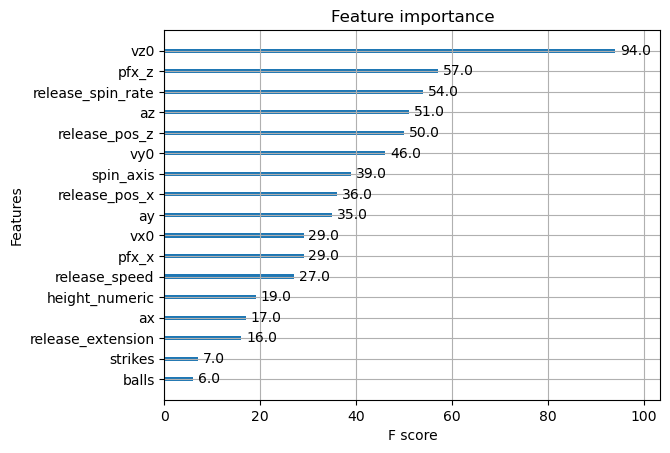

In [15]:
xgb.plot_importance(model)
plt.show()

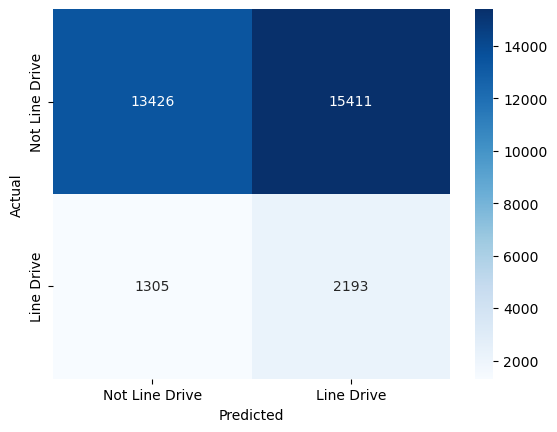

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-09 17:09:23,559] A new study created in memory with name: no-name-1bb19f3f-8829-42d8-bed3-3df17ee5b202


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68588
[4]	eval-logloss:0.68480
[5]	eval-logloss:0.68370
[6]	eval-logloss:0.68309
[7]	eval-logloss:0.68208
[8]	eval-logloss:0.68147
[9]	eval-logloss:0.68064
[10]	eval-logloss:0.68031
[11]	eval-logloss:0.67974
[12]	eval-logloss:0.67936
[13]	eval-logloss:0.67898
[14]	eval-logloss:0.67834
[15]	eval-logloss:0.67748
[16]	eval-logloss:0.67758
[17]	eval-logloss:0.67690
[18]	eval-logloss:0.67641
[19]	eval-logloss:0.67589
[20]	eval-logloss:0.67561
[21]	eval-logloss:0.67563
[22]	eval-logloss:0.67528
[23]	eval-logloss:0.67428
[24]	eval-logloss:0.67367
[25]	eval-logloss:0.67337
[26]	eval-logloss:0.67298
[27]	eval-logloss:0.67262
[28]	eval-logloss:0.67202
[29]	eval-logloss:0.67197
[30]	eval-logloss:0.67159
[31]	eval-logloss:0.67143
[32]	eval-logloss:0.67109
[33]	eval-logloss:0.67065
[34]	eval-logloss:0.67046
[35]	eval-logloss:0.67035
[36]	eval-logloss:0.67029
[37]	eval-logloss:0.66981
[38]	eval-logloss:0.66

[I 2023-11-09 17:09:25,170] Trial 0 finished with value: 0.6561133086385116 and parameters: {'max_depth': 5, 'eta': 0.11733903813685963, 'subsample': 0.8327466470287539, 'colsample_bytree': 0.9532703527048652}. Best is trial 0 with value: 0.6561133086385116.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67487
[3]	eval-logloss:0.67063
[4]	eval-logloss:0.66711
[5]	eval-logloss:0.66381
[6]	eval-logloss:0.66079
[7]	eval-logloss:0.65776
[8]	eval-logloss:0.65450
[9]	eval-logloss:0.65187
[10]	eval-logloss:0.64946
[11]	eval-logloss:0.64765
[12]	eval-logloss:0.64646
[13]	eval-logloss:0.64460
[14]	eval-logloss:0.64333
[15]	eval-logloss:0.64143
[16]	eval-logloss:0.64085
[17]	eval-logloss:0.63915
[18]	eval-logloss:0.63702
[19]	eval-logloss:0.63510
[20]	eval-logloss:0.63346
[21]	eval-logloss:0.63223
[22]	eval-logloss:0.63018
[23]	eval-logloss:0.62785
[24]	eval-logloss:0.62684
[25]	eval-logloss:0.62489
[26]	eval-logloss:0.62402
[27]	eval-logloss:0.62279
[28]	eval-logloss:0.62223
[29]	eval-logloss:0.62100
[30]	eval-logloss:0.62038
[31]	eval-logloss:0.61887
[32]	eval-logloss:0.61799
[33]	eval-logloss:0.61650
[34]	eval-logloss:0.61575
[35]	eval-logloss:0.61541
[36]	eval-logloss:0.61498
[37]	eval-logloss:0.61294
[38]	eval-logloss:0.61

[I 2023-11-09 17:09:27,800] Trial 1 finished with value: 0.5569693051153497 and parameters: {'max_depth': 9, 'eta': 0.12288683334920851, 'subsample': 0.7366187272445318, 'colsample_bytree': 0.9098699737466529}. Best is trial 0 with value: 0.6561133086385116.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68831
[3]	eval-logloss:0.68687
[4]	eval-logloss:0.68564
[5]	eval-logloss:0.68428
[6]	eval-logloss:0.68327
[7]	eval-logloss:0.68211
[8]	eval-logloss:0.68107
[9]	eval-logloss:0.67997
[10]	eval-logloss:0.67912
[11]	eval-logloss:0.67823
[12]	eval-logloss:0.67752
[13]	eval-logloss:0.67681
[14]	eval-logloss:0.67607
[15]	eval-logloss:0.67531
[16]	eval-logloss:0.67478
[17]	eval-logloss:0.67396
[18]	eval-logloss:0.67326
[19]	eval-logloss:0.67256
[20]	eval-logloss:0.67192
[21]	eval-logloss:0.67158
[22]	eval-logloss:0.67117
[23]	eval-logloss:0.67021
[24]	eval-logloss:0.66948
[25]	eval-logloss:0.66897
[26]	eval-logloss:0.66850
[27]	eval-logloss:0.66803
[28]	eval-logloss:0.66749
[29]	eval-logloss:0.66714
[30]	eval-logloss:0.66670
[31]	eval-logloss:0.66616
[32]	eval-logloss:0.66562
[33]	eval-logloss:0.66509
[34]	eval-logloss:0.66463
[35]	eval-logloss:0.66430
[36]	eval-logloss:0.66382
[37]	eval-logloss:0.66328
[38]	eval-logloss:0.66

[I 2023-11-09 17:09:29,939] Trial 2 finished with value: 0.6449917587335735 and parameters: {'max_depth': 7, 'eta': 0.05215994462623347, 'subsample': 0.8502416046801005, 'colsample_bytree': 0.9370890773526923}. Best is trial 0 with value: 0.6561133086385116.


[0]	eval-logloss:0.69003
[1]	eval-logloss:0.68548
[2]	eval-logloss:0.68354
[3]	eval-logloss:0.68021
[4]	eval-logloss:0.67937
[5]	eval-logloss:0.67618
[6]	eval-logloss:0.67416
[7]	eval-logloss:0.67317
[8]	eval-logloss:0.67198
[9]	eval-logloss:0.67070
[10]	eval-logloss:0.66835
[11]	eval-logloss:0.66713
[12]	eval-logloss:0.66658
[13]	eval-logloss:0.66637
[14]	eval-logloss:0.66575
[15]	eval-logloss:0.66476
[16]	eval-logloss:0.66432
[17]	eval-logloss:0.66231
[18]	eval-logloss:0.66126
[19]	eval-logloss:0.65978
[20]	eval-logloss:0.65954
[21]	eval-logloss:0.65994
[22]	eval-logloss:0.65929
[23]	eval-logloss:0.65817
[24]	eval-logloss:0.65727
[25]	eval-logloss:0.65660
[26]	eval-logloss:0.65593
[27]	eval-logloss:0.65586
[28]	eval-logloss:0.65536
[29]	eval-logloss:0.65505
[30]	eval-logloss:0.65432
[31]	eval-logloss:0.65429
[32]	eval-logloss:0.65364
[33]	eval-logloss:0.65323
[34]	eval-logloss:0.65325
[35]	eval-logloss:0.65241
[36]	eval-logloss:0.65277
[37]	eval-logloss:0.65210
[38]	eval-logloss:0.65

[I 2023-11-09 17:09:31,812] Trial 3 finished with value: 0.6221487487292283 and parameters: {'max_depth': 7, 'eta': 0.13250664712135174, 'subsample': 0.60733576041799, 'colsample_bytree': 0.589393663223388}. Best is trial 0 with value: 0.6561133086385116.


[0]	eval-logloss:0.68878
[1]	eval-logloss:0.68570
[2]	eval-logloss:0.68417
[3]	eval-logloss:0.68180
[4]	eval-logloss:0.68071
[5]	eval-logloss:0.67879
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67666
[8]	eval-logloss:0.67552
[9]	eval-logloss:0.67431
[10]	eval-logloss:0.67333
[11]	eval-logloss:0.67229
[12]	eval-logloss:0.67145
[13]	eval-logloss:0.67075
[14]	eval-logloss:0.66988
[15]	eval-logloss:0.66888
[16]	eval-logloss:0.66836
[17]	eval-logloss:0.66727
[18]	eval-logloss:0.66655
[19]	eval-logloss:0.66593
[20]	eval-logloss:0.66514
[21]	eval-logloss:0.66535
[22]	eval-logloss:0.66466
[23]	eval-logloss:0.66312
[24]	eval-logloss:0.66255
[25]	eval-logloss:0.66213
[26]	eval-logloss:0.66165
[27]	eval-logloss:0.66074
[28]	eval-logloss:0.66003
[29]	eval-logloss:0.66003
[30]	eval-logloss:0.65985
[31]	eval-logloss:0.65957
[32]	eval-logloss:0.65843
[33]	eval-logloss:0.65745
[34]	eval-logloss:0.65699
[35]	eval-logloss:0.65708
[36]	eval-logloss:0.65623
[37]	eval-logloss:0.65532
[38]	eval-logloss:0.65

[I 2023-11-09 17:09:33,552] Trial 4 finished with value: 0.626315260556288 and parameters: {'max_depth': 6, 'eta': 0.19009870735388223, 'subsample': 0.8474538103872571, 'colsample_bytree': 0.8806268531473629}. Best is trial 0 with value: 0.6561133086385116.


[0]	eval-logloss:0.68748
[1]	eval-logloss:0.68320
[2]	eval-logloss:0.67922
[3]	eval-logloss:0.67570
[4]	eval-logloss:0.67274
[5]	eval-logloss:0.66977
[6]	eval-logloss:0.66714
[7]	eval-logloss:0.66429
[8]	eval-logloss:0.66228
[9]	eval-logloss:0.66004
[10]	eval-logloss:0.65750
[11]	eval-logloss:0.65561
[12]	eval-logloss:0.65362
[13]	eval-logloss:0.65181
[14]	eval-logloss:0.64980
[15]	eval-logloss:0.64805
[16]	eval-logloss:0.64648
[17]	eval-logloss:0.64455
[18]	eval-logloss:0.64279
[19]	eval-logloss:0.64168
[20]	eval-logloss:0.64033
[21]	eval-logloss:0.63961
[22]	eval-logloss:0.63851
[23]	eval-logloss:0.63707
[24]	eval-logloss:0.63597
[25]	eval-logloss:0.63488
[26]	eval-logloss:0.63379
[27]	eval-logloss:0.63238
[28]	eval-logloss:0.63122
[29]	eval-logloss:0.63050
[30]	eval-logloss:0.62942
[31]	eval-logloss:0.62872
[32]	eval-logloss:0.62800
[33]	eval-logloss:0.62609
[34]	eval-logloss:0.62507
[35]	eval-logloss:0.62455
[36]	eval-logloss:0.62385
[37]	eval-logloss:0.62227
[38]	eval-logloss:0.62

[I 2023-11-09 17:09:36,163] Trial 5 finished with value: 0.574974009875577 and parameters: {'max_depth': 9, 'eta': 0.09258875214871994, 'subsample': 0.8577960381863128, 'colsample_bytree': 0.9803871831235728}. Best is trial 0 with value: 0.6561133086385116.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68960
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68682
[6]	eval-logloss:0.68642
[7]	eval-logloss:0.68557
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68417
[10]	eval-logloss:0.68344
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68352
[13]	eval-logloss:0.68353
[14]	eval-logloss:0.68280
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68279
[17]	eval-logloss:0.68149
[18]	eval-logloss:0.68120
[19]	eval-logloss:0.68027
[20]	eval-logloss:0.68072
[21]	eval-logloss:0.68158
[22]	eval-logloss:0.68133
[23]	eval-logloss:0.68024
[24]	eval-logloss:0.67964
[25]	eval-logloss:0.67956
[26]	eval-logloss:0.67962
[27]	eval-logloss:0.68021
[28]	eval-logloss:0.68037
[29]	eval-logloss:0.68043
[30]	eval-logloss:0.67952
[31]	eval-logloss:0.67997
[32]	eval-logloss:0.67952
[33]	eval-logloss:0.67950
[34]	eval-logloss:0.67973
[35]	eval-logloss:0.67936
[36]	eval-logloss:0.68019
[37]	eval-logloss:0.67943
[38]	eval-logloss:0.67

[I 2023-11-09 17:09:37,489] Trial 6 finished with value: 0.6721196465973778 and parameters: {'max_depth': 3, 'eta': 0.18903960581757726, 'subsample': 0.6868130057841699, 'colsample_bytree': 0.590715281511064}. Best is trial 6 with value: 0.6721196465973778.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68523
[2]	eval-logloss:0.68385
[3]	eval-logloss:0.68202
[4]	eval-logloss:0.68142
[5]	eval-logloss:0.67961
[6]	eval-logloss:0.67957
[7]	eval-logloss:0.67809
[8]	eval-logloss:0.67734
[9]	eval-logloss:0.67634
[10]	eval-logloss:0.67595
[11]	eval-logloss:0.67560
[12]	eval-logloss:0.67499
[13]	eval-logloss:0.67452
[14]	eval-logloss:0.67413
[15]	eval-logloss:0.67317
[16]	eval-logloss:0.67303
[17]	eval-logloss:0.67188
[18]	eval-logloss:0.67158
[19]	eval-logloss:0.67080
[20]	eval-logloss:0.67042
[21]	eval-logloss:0.67065
[22]	eval-logloss:0.67038
[23]	eval-logloss:0.66876
[24]	eval-logloss:0.66844
[25]	eval-logloss:0.66822
[26]	eval-logloss:0.66747
[27]	eval-logloss:0.66737
[28]	eval-logloss:0.66655
[29]	eval-logloss:0.66674
[30]	eval-logloss:0.66635
[31]	eval-logloss:0.66641
[32]	eval-logloss:0.66595
[33]	eval-logloss:0.66519
[34]	eval-logloss:0.66524
[35]	eval-logloss:0.66545
[36]	eval-logloss:0.66529
[37]	eval-logloss:0.66406
[38]	eval-logloss:0.66

[I 2023-11-09 17:09:39,065] Trial 7 finished with value: 0.6423516743332999 and parameters: {'max_depth': 5, 'eta': 0.26147709590079393, 'subsample': 0.8820290674154702, 'colsample_bytree': 0.9750360368554947}. Best is trial 6 with value: 0.6721196465973778.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67632
[3]	eval-logloss:0.67308
[4]	eval-logloss:0.67194
[5]	eval-logloss:0.66903
[6]	eval-logloss:0.66737
[7]	eval-logloss:0.66656
[8]	eval-logloss:0.66617
[9]	eval-logloss:0.66378
[10]	eval-logloss:0.66284
[11]	eval-logloss:0.66149
[12]	eval-logloss:0.66190
[13]	eval-logloss:0.66062
[14]	eval-logloss:0.65947
[15]	eval-logloss:0.65804
[16]	eval-logloss:0.65855
[17]	eval-logloss:0.65568
[18]	eval-logloss:0.65514
[19]	eval-logloss:0.65342
[20]	eval-logloss:0.65406
[21]	eval-logloss:0.65457
[22]	eval-logloss:0.65329
[23]	eval-logloss:0.65097
[24]	eval-logloss:0.64935
[25]	eval-logloss:0.64827
[26]	eval-logloss:0.64793
[27]	eval-logloss:0.64842
[28]	eval-logloss:0.64809
[29]	eval-logloss:0.64733
[30]	eval-logloss:0.64561
[31]	eval-logloss:0.64594
[32]	eval-logloss:0.64557
[33]	eval-logloss:0.64464
[34]	eval-logloss:0.64491
[35]	eval-logloss:0.64351
[36]	eval-logloss:0.64360
[37]	eval-logloss:0.64180
[38]	eval-logloss:0.64

[I 2023-11-09 17:09:41,062] Trial 8 finished with value: 0.5997584882291395 and parameters: {'max_depth': 7, 'eta': 0.22735286865598103, 'subsample': 0.6225867776307649, 'colsample_bytree': 0.7952909015426713}. Best is trial 6 with value: 0.6721196465973778.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68801
[2]	eval-logloss:0.68731
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68472
[5]	eval-logloss:0.68377
[6]	eval-logloss:0.68396
[7]	eval-logloss:0.68284
[8]	eval-logloss:0.68231
[9]	eval-logloss:0.68135
[10]	eval-logloss:0.68075
[11]	eval-logloss:0.68038
[12]	eval-logloss:0.68066
[13]	eval-logloss:0.68053
[14]	eval-logloss:0.67999
[15]	eval-logloss:0.67914
[16]	eval-logloss:0.67961
[17]	eval-logloss:0.67883
[18]	eval-logloss:0.67847
[19]	eval-logloss:0.67790
[20]	eval-logloss:0.67775
[21]	eval-logloss:0.67800
[22]	eval-logloss:0.67792
[23]	eval-logloss:0.67685
[24]	eval-logloss:0.67661
[25]	eval-logloss:0.67645
[26]	eval-logloss:0.67609
[27]	eval-logloss:0.67644
[28]	eval-logloss:0.67590
[29]	eval-logloss:0.67596
[30]	eval-logloss:0.67558
[31]	eval-logloss:0.67553
[32]	eval-logloss:0.67545
[33]	eval-logloss:0.67511
[34]	eval-logloss:0.67501
[35]	eval-logloss:0.67499
[36]	eval-logloss:0.67520
[37]	eval-logloss:0.67493
[38]	eval-logloss:0.67

[I 2023-11-09 17:09:42,487] Trial 9 finished with value: 0.6644737636530839 and parameters: {'max_depth': 4, 'eta': 0.18622164477530384, 'subsample': 0.8027097676525785, 'colsample_bytree': 0.8367030127114117}. Best is trial 6 with value: 0.6721196465973778.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68976
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68752
[4]	eval-logloss:0.68720
[5]	eval-logloss:0.68608
[6]	eval-logloss:0.68543
[7]	eval-logloss:0.68399
[8]	eval-logloss:0.68371
[9]	eval-logloss:0.68284
[10]	eval-logloss:0.68192
[11]	eval-logloss:0.68154
[12]	eval-logloss:0.68239
[13]	eval-logloss:0.68242
[14]	eval-logloss:0.68159
[15]	eval-logloss:0.68104
[16]	eval-logloss:0.68212
[17]	eval-logloss:0.68020
[18]	eval-logloss:0.68004
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67943
[21]	eval-logloss:0.68075
[22]	eval-logloss:0.68040
[23]	eval-logloss:0.67887
[24]	eval-logloss:0.67828
[25]	eval-logloss:0.67822
[26]	eval-logloss:0.67859
[27]	eval-logloss:0.67970
[28]	eval-logloss:0.67986
[29]	eval-logloss:0.67994
[30]	eval-logloss:0.67863
[31]	eval-logloss:0.67923
[32]	eval-logloss:0.67876
[33]	eval-logloss:0.67890
[34]	eval-logloss:0.67889
[35]	eval-logloss:0.67855
[36]	eval-logloss:0.67973
[37]	eval-logloss:0.67846
[38]	eval-logloss:0.67

[I 2023-11-09 17:09:43,833] Trial 10 finished with value: 0.6709822369900194 and parameters: {'max_depth': 3, 'eta': 0.27717577276122296, 'subsample': 0.6890423218744449, 'colsample_bytree': 0.5060911000492598}. Best is trial 6 with value: 0.6721196465973778.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68979
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68734
[4]	eval-logloss:0.68729
[5]	eval-logloss:0.68600
[6]	eval-logloss:0.68544
[7]	eval-logloss:0.68415
[8]	eval-logloss:0.68354
[9]	eval-logloss:0.68274
[10]	eval-logloss:0.68220
[11]	eval-logloss:0.68197
[12]	eval-logloss:0.68273
[13]	eval-logloss:0.68310
[14]	eval-logloss:0.68171
[15]	eval-logloss:0.68081
[16]	eval-logloss:0.68204
[17]	eval-logloss:0.68012
[18]	eval-logloss:0.67995
[19]	eval-logloss:0.67894
[20]	eval-logloss:0.67987
[21]	eval-logloss:0.68145
[22]	eval-logloss:0.68113
[23]	eval-logloss:0.67925
[24]	eval-logloss:0.67857
[25]	eval-logloss:0.67854
[26]	eval-logloss:0.67874
[27]	eval-logloss:0.68003
[28]	eval-logloss:0.68006
[29]	eval-logloss:0.67975
[30]	eval-logloss:0.67823
[31]	eval-logloss:0.67896
[32]	eval-logloss:0.67857
[33]	eval-logloss:0.67862
[34]	eval-logloss:0.67922
[35]	eval-logloss:0.67866
[36]	eval-logloss:0.68011
[37]	eval-logloss:0.67871
[38]	eval-logloss:0.67

[I 2023-11-09 17:09:45,160] Trial 11 finished with value: 0.6699872230967256 and parameters: {'max_depth': 3, 'eta': 0.29721160855361584, 'subsample': 0.6842183771621626, 'colsample_bytree': 0.5010120616252688}. Best is trial 6 with value: 0.6721196465973778.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68725
[4]	eval-logloss:0.68691
[5]	eval-logloss:0.68599
[6]	eval-logloss:0.68557
[7]	eval-logloss:0.68424
[8]	eval-logloss:0.68338
[9]	eval-logloss:0.68250
[10]	eval-logloss:0.68211
[11]	eval-logloss:0.68198
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68217
[14]	eval-logloss:0.68144
[15]	eval-logloss:0.68076
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68041
[18]	eval-logloss:0.68026
[19]	eval-logloss:0.67926
[20]	eval-logloss:0.67984
[21]	eval-logloss:0.68079
[22]	eval-logloss:0.68081
[23]	eval-logloss:0.67955
[24]	eval-logloss:0.67910
[25]	eval-logloss:0.67903
[26]	eval-logloss:0.67910
[27]	eval-logloss:0.67994
[28]	eval-logloss:0.67991
[29]	eval-logloss:0.68004
[30]	eval-logloss:0.67884
[31]	eval-logloss:0.67948
[32]	eval-logloss:0.67904
[33]	eval-logloss:0.67884
[34]	eval-logloss:0.67913
[35]	eval-logloss:0.67893
[36]	eval-logloss:0.67979
[37]	eval-logloss:0.67885
[38]	eval-logloss:0.67

[I 2023-11-09 17:09:46,573] Trial 12 finished with value: 0.6713652676341131 and parameters: {'max_depth': 3, 'eta': 0.23196229828956433, 'subsample': 0.6934473081702989, 'colsample_bytree': 0.6550199577699233}. Best is trial 6 with value: 0.6721196465973778.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68904
[2]	eval-logloss:0.68824
[3]	eval-logloss:0.68686
[4]	eval-logloss:0.68658
[5]	eval-logloss:0.68584
[6]	eval-logloss:0.68541
[7]	eval-logloss:0.68421
[8]	eval-logloss:0.68336
[9]	eval-logloss:0.68206
[10]	eval-logloss:0.68205
[11]	eval-logloss:0.68180
[12]	eval-logloss:0.68199
[13]	eval-logloss:0.68211
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68121
[16]	eval-logloss:0.68161
[17]	eval-logloss:0.68046
[18]	eval-logloss:0.68053
[19]	eval-logloss:0.67980
[20]	eval-logloss:0.68015
[21]	eval-logloss:0.68064
[22]	eval-logloss:0.68044
[23]	eval-logloss:0.67964
[24]	eval-logloss:0.67908
[25]	eval-logloss:0.67879
[26]	eval-logloss:0.67864
[27]	eval-logloss:0.67932
[28]	eval-logloss:0.67942
[29]	eval-logloss:0.67967
[30]	eval-logloss:0.67881
[31]	eval-logloss:0.67904
[32]	eval-logloss:0.67893
[33]	eval-logloss:0.67851
[34]	eval-logloss:0.67890
[35]	eval-logloss:0.67929
[36]	eval-logloss:0.67961
[37]	eval-logloss:0.67874
[38]	eval-logloss:0.67

[I 2023-11-09 17:09:47,915] Trial 13 finished with value: 0.6714241665068372 and parameters: {'max_depth': 3, 'eta': 0.22180740646001945, 'subsample': 0.7424102925193948, 'colsample_bytree': 0.6846646060567978}. Best is trial 6 with value: 0.6721196465973778.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68596
[4]	eval-logloss:0.68569
[5]	eval-logloss:0.68437
[6]	eval-logloss:0.68406
[7]	eval-logloss:0.68311
[8]	eval-logloss:0.68245
[9]	eval-logloss:0.68128
[10]	eval-logloss:0.68060
[11]	eval-logloss:0.68025
[12]	eval-logloss:0.68053
[13]	eval-logloss:0.68064
[14]	eval-logloss:0.68027
[15]	eval-logloss:0.67952
[16]	eval-logloss:0.67964
[17]	eval-logloss:0.67894
[18]	eval-logloss:0.67852
[19]	eval-logloss:0.67779
[20]	eval-logloss:0.67749
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67791
[23]	eval-logloss:0.67691
[24]	eval-logloss:0.67626
[25]	eval-logloss:0.67604
[26]	eval-logloss:0.67577
[27]	eval-logloss:0.67616
[28]	eval-logloss:0.67578
[29]	eval-logloss:0.67594
[30]	eval-logloss:0.67527
[31]	eval-logloss:0.67524
[32]	eval-logloss:0.67506
[33]	eval-logloss:0.67475
[34]	eval-logloss:0.67496
[35]	eval-logloss:0.67528
[36]	eval-logloss:0.67529
[37]	eval-logloss:0.67476
[38]	eval-logloss:0.67

[I 2023-11-09 17:09:49,358] Trial 14 finished with value: 0.6639095043008063 and parameters: {'max_depth': 4, 'eta': 0.18111698357551423, 'subsample': 0.7790420488993157, 'colsample_bytree': 0.7098545491760133}. Best is trial 6 with value: 0.6721196465973778.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68714
[3]	eval-logloss:0.68547
[4]	eval-logloss:0.68523
[5]	eval-logloss:0.68389
[6]	eval-logloss:0.68323
[7]	eval-logloss:0.68202
[8]	eval-logloss:0.68138
[9]	eval-logloss:0.67998
[10]	eval-logloss:0.67971
[11]	eval-logloss:0.67956
[12]	eval-logloss:0.67961
[13]	eval-logloss:0.67982
[14]	eval-logloss:0.67912
[15]	eval-logloss:0.67851
[16]	eval-logloss:0.67907
[17]	eval-logloss:0.67796
[18]	eval-logloss:0.67795
[19]	eval-logloss:0.67732
[20]	eval-logloss:0.67775
[21]	eval-logloss:0.67805
[22]	eval-logloss:0.67766
[23]	eval-logloss:0.67679
[24]	eval-logloss:0.67618
[25]	eval-logloss:0.67591
[26]	eval-logloss:0.67562
[27]	eval-logloss:0.67622
[28]	eval-logloss:0.67626
[29]	eval-logloss:0.67642
[30]	eval-logloss:0.67563
[31]	eval-logloss:0.67575
[32]	eval-logloss:0.67558
[33]	eval-logloss:0.67528
[34]	eval-logloss:0.67559
[35]	eval-logloss:0.67586
[36]	eval-logloss:0.67601
[37]	eval-logloss:0.67490
[38]	eval-logloss:0.67

[I 2023-11-09 17:09:50,857] Trial 15 finished with value: 0.6619033954415465 and parameters: {'max_depth': 4, 'eta': 0.2184957362862184, 'subsample': 0.740793334302439, 'colsample_bytree': 0.7187458115558514}. Best is trial 6 with value: 0.6721196465973778.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68737
[3]	eval-logloss:0.68506
[4]	eval-logloss:0.68454
[5]	eval-logloss:0.68277
[6]	eval-logloss:0.68205
[7]	eval-logloss:0.68099
[8]	eval-logloss:0.68009
[9]	eval-logloss:0.67884
[10]	eval-logloss:0.67819
[11]	eval-logloss:0.67748
[12]	eval-logloss:0.67774
[13]	eval-logloss:0.67737
[14]	eval-logloss:0.67686
[15]	eval-logloss:0.67617
[16]	eval-logloss:0.67583
[17]	eval-logloss:0.67471
[18]	eval-logloss:0.67420
[19]	eval-logloss:0.67340
[20]	eval-logloss:0.67288
[21]	eval-logloss:0.67319
[22]	eval-logloss:0.67304
[23]	eval-logloss:0.67184
[24]	eval-logloss:0.67119
[25]	eval-logloss:0.67071
[26]	eval-logloss:0.67020
[27]	eval-logloss:0.67056
[28]	eval-logloss:0.67031
[29]	eval-logloss:0.67035
[30]	eval-logloss:0.66981
[31]	eval-logloss:0.66978
[32]	eval-logloss:0.66948
[33]	eval-logloss:0.66902
[34]	eval-logloss:0.66901
[35]	eval-logloss:0.66889
[36]	eval-logloss:0.66902
[37]	eval-logloss:0.66845
[38]	eval-logloss:0.66

[I 2023-11-09 17:09:52,417] Trial 16 finished with value: 0.6519090543476276 and parameters: {'max_depth': 5, 'eta': 0.1634850206066313, 'subsample': 0.7605293541386264, 'colsample_bytree': 0.6272078351592167}. Best is trial 6 with value: 0.6721196465973778.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68693
[6]	eval-logloss:0.68651
[7]	eval-logloss:0.68533
[8]	eval-logloss:0.68481
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68367
[11]	eval-logloss:0.68359
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68295
[15]	eval-logloss:0.68243
[16]	eval-logloss:0.68278
[17]	eval-logloss:0.68183
[18]	eval-logloss:0.68177
[19]	eval-logloss:0.68132
[20]	eval-logloss:0.68150
[21]	eval-logloss:0.68187
[22]	eval-logloss:0.68177
[23]	eval-logloss:0.68125
[24]	eval-logloss:0.68087
[25]	eval-logloss:0.68051
[26]	eval-logloss:0.68049
[27]	eval-logloss:0.68107
[28]	eval-logloss:0.68104
[29]	eval-logloss:0.68108
[30]	eval-logloss:0.68057
[31]	eval-logloss:0.68070
[32]	eval-logloss:0.68063
[33]	eval-logloss:0.68035
[34]	eval-logloss:0.68050
[35]	eval-logloss:0.68047
[36]	eval-logloss:0.68097
[37]	eval-logloss:0.68026
[38]	eval-logloss:0.67

[I 2023-11-09 17:09:53,785] Trial 17 finished with value: 0.6739000633630602 and parameters: {'max_depth': 3, 'eta': 0.15328199743446858, 'subsample': 0.7223160556261758, 'colsample_bytree': 0.761841250231939}. Best is trial 17 with value: 0.6739000633630602.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69159
[5]	eval-logloss:0.69129
[6]	eval-logloss:0.69103
[7]	eval-logloss:0.69073
[8]	eval-logloss:0.69046
[9]	eval-logloss:0.69017
[10]	eval-logloss:0.68987
[11]	eval-logloss:0.68964
[12]	eval-logloss:0.68948
[13]	eval-logloss:0.68928
[14]	eval-logloss:0.68903
[15]	eval-logloss:0.68887
[16]	eval-logloss:0.68878
[17]	eval-logloss:0.68847
[18]	eval-logloss:0.68828
[19]	eval-logloss:0.68801
[20]	eval-logloss:0.68798
[21]	eval-logloss:0.68801
[22]	eval-logloss:0.68781
[23]	eval-logloss:0.68750
[24]	eval-logloss:0.68730
[25]	eval-logloss:0.68722
[26]	eval-logloss:0.68701
[27]	eval-logloss:0.68691
[28]	eval-logloss:0.68684
[29]	eval-logloss:0.68674
[30]	eval-logloss:0.68655
[31]	eval-logloss:0.68643
[32]	eval-logloss:0.68624
[33]	eval-logloss:0.68609
[34]	eval-logloss:0.68601
[35]	eval-logloss:0.68585
[36]	eval-logloss:0.68595
[37]	eval-logloss:0.68582
[38]	eval-logloss:0.68

[I 2023-11-09 17:09:55,366] Trial 18 finished with value: 0.6805644265010935 and parameters: {'max_depth': 4, 'eta': 0.019076487012925025, 'subsample': 0.6591031705529301, 'colsample_bytree': 0.7685989945943974}. Best is trial 18 with value: 0.6805644265010935.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69166
[6]	eval-logloss:0.69146
[7]	eval-logloss:0.69121
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69074
[10]	eval-logloss:0.69049
[11]	eval-logloss:0.69029
[12]	eval-logloss:0.69016
[13]	eval-logloss:0.68998
[14]	eval-logloss:0.68977
[15]	eval-logloss:0.68966
[16]	eval-logloss:0.68956
[17]	eval-logloss:0.68932
[18]	eval-logloss:0.68917
[19]	eval-logloss:0.68889
[20]	eval-logloss:0.68877
[21]	eval-logloss:0.68879
[22]	eval-logloss:0.68862
[23]	eval-logloss:0.68835
[24]	eval-logloss:0.68816
[25]	eval-logloss:0.68807
[26]	eval-logloss:0.68792
[27]	eval-logloss:0.68782
[28]	eval-logloss:0.68774
[29]	eval-logloss:0.68760
[30]	eval-logloss:0.68743
[31]	eval-logloss:0.68732
[32]	eval-logloss:0.68717
[33]	eval-logloss:0.68703
[34]	eval-logloss:0.68694
[35]	eval-logloss:0.68683
[36]	eval-logloss:0.68687
[37]	eval-logloss:0.68675
[38]	eval-logloss:0.68

[I 2023-11-09 17:09:56,886] Trial 19 finished with value: 0.681831922167302 and parameters: {'max_depth': 4, 'eta': 0.01497499192393939, 'subsample': 0.6462546596713197, 'colsample_bytree': 0.7936163749279821}. Best is trial 19 with value: 0.681831922167302.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69130
[3]	eval-logloss:0.69070
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68920
[7]	eval-logloss:0.68864
[8]	eval-logloss:0.68817
[9]	eval-logloss:0.68765
[10]	eval-logloss:0.68709
[11]	eval-logloss:0.68666
[12]	eval-logloss:0.68627
[13]	eval-logloss:0.68590
[14]	eval-logloss:0.68547
[15]	eval-logloss:0.68514
[16]	eval-logloss:0.68488
[17]	eval-logloss:0.68438
[18]	eval-logloss:0.68400
[19]	eval-logloss:0.68355
[20]	eval-logloss:0.68330
[21]	eval-logloss:0.68322
[22]	eval-logloss:0.68282
[23]	eval-logloss:0.68232
[24]	eval-logloss:0.68196
[25]	eval-logloss:0.68175
[26]	eval-logloss:0.68142
[27]	eval-logloss:0.68118
[28]	eval-logloss:0.68101
[29]	eval-logloss:0.68073
[30]	eval-logloss:0.68040
[31]	eval-logloss:0.68015
[32]	eval-logloss:0.67985
[33]	eval-logloss:0.67957
[34]	eval-logloss:0.67938
[35]	eval-logloss:0.67918
[36]	eval-logloss:0.67915
[37]	eval-logloss:0.67890
[38]	eval-logloss:0.67

[I 2023-11-09 17:09:58,695] Trial 20 finished with value: 0.6685805566590635 and parameters: {'max_depth': 6, 'eta': 0.021734851650184146, 'subsample': 0.6365522569155336, 'colsample_bytree': 0.8185358297826791}. Best is trial 19 with value: 0.681831922167302.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69241
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69169
[6]	eval-logloss:0.69148
[7]	eval-logloss:0.69124
[8]	eval-logloss:0.69102
[9]	eval-logloss:0.69078
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69033
[12]	eval-logloss:0.69020
[13]	eval-logloss:0.69003
[14]	eval-logloss:0.68983
[15]	eval-logloss:0.68969
[16]	eval-logloss:0.68961
[17]	eval-logloss:0.68936
[18]	eval-logloss:0.68919
[19]	eval-logloss:0.68897
[20]	eval-logloss:0.68894
[21]	eval-logloss:0.68896
[22]	eval-logloss:0.68880
[23]	eval-logloss:0.68854
[24]	eval-logloss:0.68837
[25]	eval-logloss:0.68828
[26]	eval-logloss:0.68814
[27]	eval-logloss:0.68803
[28]	eval-logloss:0.68795
[29]	eval-logloss:0.68788
[30]	eval-logloss:0.68771
[31]	eval-logloss:0.68760
[32]	eval-logloss:0.68744
[33]	eval-logloss:0.68730
[34]	eval-logloss:0.68722
[35]	eval-logloss:0.68710
[36]	eval-logloss:0.68713
[37]	eval-logloss:0.68701
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:00,193] Trial 21 finished with value: 0.6820668832909963 and parameters: {'max_depth': 4, 'eta': 0.014796592366778957, 'subsample': 0.6546403300893765, 'colsample_bytree': 0.7439618276607347}. Best is trial 21 with value: 0.6820668832909963.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69150
[7]	eval-logloss:0.69127
[8]	eval-logloss:0.69106
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69058
[11]	eval-logloss:0.69038
[12]	eval-logloss:0.69025
[13]	eval-logloss:0.69008
[14]	eval-logloss:0.68988
[15]	eval-logloss:0.68975
[16]	eval-logloss:0.68967
[17]	eval-logloss:0.68942
[18]	eval-logloss:0.68925
[19]	eval-logloss:0.68898
[20]	eval-logloss:0.68895
[21]	eval-logloss:0.68898
[22]	eval-logloss:0.68881
[23]	eval-logloss:0.68855
[24]	eval-logloss:0.68838
[25]	eval-logloss:0.68829
[26]	eval-logloss:0.68811
[27]	eval-logloss:0.68801
[28]	eval-logloss:0.68793
[29]	eval-logloss:0.68786
[30]	eval-logloss:0.68770
[31]	eval-logloss:0.68759
[32]	eval-logloss:0.68743
[33]	eval-logloss:0.68730
[34]	eval-logloss:0.68723
[35]	eval-logloss:0.68711
[36]	eval-logloss:0.68714
[37]	eval-logloss:0.68702
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:01,720] Trial 22 finished with value: 0.6821264349834909 and parameters: {'max_depth': 4, 'eta': 0.014462324103198051, 'subsample': 0.6534738002385426, 'colsample_bytree': 0.744936366991006}. Best is trial 22 with value: 0.6821264349834909.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68752
[7]	eval-logloss:0.68678
[8]	eval-logloss:0.68616
[9]	eval-logloss:0.68555
[10]	eval-logloss:0.68489
[11]	eval-logloss:0.68441
[12]	eval-logloss:0.68409
[13]	eval-logloss:0.68374
[14]	eval-logloss:0.68326
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68292
[17]	eval-logloss:0.68232
[18]	eval-logloss:0.68204
[19]	eval-logloss:0.68151
[20]	eval-logloss:0.68152
[21]	eval-logloss:0.68167
[22]	eval-logloss:0.68129
[23]	eval-logloss:0.68071
[24]	eval-logloss:0.68040
[25]	eval-logloss:0.68029
[26]	eval-logloss:0.68005
[27]	eval-logloss:0.67996
[28]	eval-logloss:0.67978
[29]	eval-logloss:0.67964
[30]	eval-logloss:0.67925
[31]	eval-logloss:0.67906
[32]	eval-logloss:0.67875
[33]	eval-logloss:0.67848
[34]	eval-logloss:0.67840
[35]	eval-logloss:0.67819
[36]	eval-logloss:0.67844
[37]	eval-logloss:0.67819
[38]	eval-logloss:0.67

[I 2023-11-09 17:10:03,340] Trial 23 finished with value: 0.6695053493983188 and parameters: {'max_depth': 5, 'eta': 0.0455885776139069, 'subsample': 0.6477023645253331, 'colsample_bytree': 0.7409315809350998}. Best is trial 22 with value: 0.6821264349834909.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69209
[5]	eval-logloss:0.69188
[6]	eval-logloss:0.69171
[7]	eval-logloss:0.69150
[8]	eval-logloss:0.69135
[9]	eval-logloss:0.69109
[10]	eval-logloss:0.69088
[11]	eval-logloss:0.69070
[12]	eval-logloss:0.69055
[13]	eval-logloss:0.69040
[14]	eval-logloss:0.69022
[15]	eval-logloss:0.69011
[16]	eval-logloss:0.69002
[17]	eval-logloss:0.68979
[18]	eval-logloss:0.68963
[19]	eval-logloss:0.68935
[20]	eval-logloss:0.68925
[21]	eval-logloss:0.68923
[22]	eval-logloss:0.68904
[23]	eval-logloss:0.68880
[24]	eval-logloss:0.68866
[25]	eval-logloss:0.68857
[26]	eval-logloss:0.68839
[27]	eval-logloss:0.68831
[28]	eval-logloss:0.68829
[29]	eval-logloss:0.68821
[30]	eval-logloss:0.68806
[31]	eval-logloss:0.68796
[32]	eval-logloss:0.68781
[33]	eval-logloss:0.68769
[34]	eval-logloss:0.68761
[35]	eval-logloss:0.68748
[36]	eval-logloss:0.68747
[37]	eval-logloss:0.68736
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:04,925] Trial 24 finished with value: 0.6825474725793963 and parameters: {'max_depth': 4, 'eta': 0.012230561559454095, 'subsample': 0.6033772014868592, 'colsample_bytree': 0.8542878488616584}. Best is trial 24 with value: 0.6825474725793963.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68843
[4]	eval-logloss:0.68762
[5]	eval-logloss:0.68660
[6]	eval-logloss:0.68580
[7]	eval-logloss:0.68498
[8]	eval-logloss:0.68449
[9]	eval-logloss:0.68361
[10]	eval-logloss:0.68274
[11]	eval-logloss:0.68226
[12]	eval-logloss:0.68194
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68099
[15]	eval-logloss:0.68069
[16]	eval-logloss:0.68065
[17]	eval-logloss:0.67985
[18]	eval-logloss:0.67948
[19]	eval-logloss:0.67882
[20]	eval-logloss:0.67871
[21]	eval-logloss:0.67883
[22]	eval-logloss:0.67837
[23]	eval-logloss:0.67761
[24]	eval-logloss:0.67719
[25]	eval-logloss:0.67700
[26]	eval-logloss:0.67681
[27]	eval-logloss:0.67687
[28]	eval-logloss:0.67670
[29]	eval-logloss:0.67659
[30]	eval-logloss:0.67603
[31]	eval-logloss:0.67585
[32]	eval-logloss:0.67553
[33]	eval-logloss:0.67546
[34]	eval-logloss:0.67544
[35]	eval-logloss:0.67519
[36]	eval-logloss:0.67537
[37]	eval-logloss:0.67508
[38]	eval-logloss:0.67

[I 2023-11-09 17:10:06,564] Trial 25 finished with value: 0.6653166523967883 and parameters: {'max_depth': 5, 'eta': 0.06117488912759521, 'subsample': 0.6318594593655119, 'colsample_bytree': 0.8536626044082547}. Best is trial 24 with value: 0.6825474725793963.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.68950
[3]	eval-logloss:0.68847
[4]	eval-logloss:0.68781
[5]	eval-logloss:0.68687
[6]	eval-logloss:0.68641
[7]	eval-logloss:0.68556
[8]	eval-logloss:0.68517
[9]	eval-logloss:0.68424
[10]	eval-logloss:0.68353
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68292
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68237
[15]	eval-logloss:0.68216
[16]	eval-logloss:0.68220
[17]	eval-logloss:0.68148
[18]	eval-logloss:0.68117
[19]	eval-logloss:0.68032
[20]	eval-logloss:0.68039
[21]	eval-logloss:0.68075
[22]	eval-logloss:0.68037
[23]	eval-logloss:0.67968
[24]	eval-logloss:0.67937
[25]	eval-logloss:0.67926
[26]	eval-logloss:0.67904
[27]	eval-logloss:0.67939
[28]	eval-logloss:0.67944
[29]	eval-logloss:0.67937
[30]	eval-logloss:0.67891
[31]	eval-logloss:0.67888
[32]	eval-logloss:0.67865
[33]	eval-logloss:0.67851
[34]	eval-logloss:0.67866
[35]	eval-logloss:0.67862
[36]	eval-logloss:0.67906
[37]	eval-logloss:0.67883
[38]	eval-logloss:0.67

[I 2023-11-09 17:10:08,056] Trial 26 finished with value: 0.6711480447371655 and parameters: {'max_depth': 4, 'eta': 0.07559944194949145, 'subsample': 0.6064451342159194, 'colsample_bytree': 0.8633287694435685}. Best is trial 24 with value: 0.6825474725793963.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69086
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68739
[6]	eval-logloss:0.68663
[7]	eval-logloss:0.68573
[8]	eval-logloss:0.68510
[9]	eval-logloss:0.68426
[10]	eval-logloss:0.68337
[11]	eval-logloss:0.68270
[12]	eval-logloss:0.68224
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68111
[15]	eval-logloss:0.68079
[16]	eval-logloss:0.68047
[17]	eval-logloss:0.67976
[18]	eval-logloss:0.67926
[19]	eval-logloss:0.67860
[20]	eval-logloss:0.67833
[21]	eval-logloss:0.67831
[22]	eval-logloss:0.67792
[23]	eval-logloss:0.67726
[24]	eval-logloss:0.67683
[25]	eval-logloss:0.67662
[26]	eval-logloss:0.67626
[27]	eval-logloss:0.67616
[28]	eval-logloss:0.67603
[29]	eval-logloss:0.67578
[30]	eval-logloss:0.67548
[31]	eval-logloss:0.67522
[32]	eval-logloss:0.67488
[33]	eval-logloss:0.67451
[34]	eval-logloss:0.67438
[35]	eval-logloss:0.67416
[36]	eval-logloss:0.67434
[37]	eval-logloss:0.67412
[38]	eval-logloss:0.67

[I 2023-11-09 17:10:09,899] Trial 27 finished with value: 0.6628823261547712 and parameters: {'max_depth': 6, 'eta': 0.0368045031581241, 'subsample': 0.6127308651822361, 'colsample_bytree': 0.8098429175920178}. Best is trial 24 with value: 0.6825474725793963.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68966
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68530
[5]	eval-logloss:0.68384
[6]	eval-logloss:0.68264
[7]	eval-logloss:0.68138
[8]	eval-logloss:0.68023
[9]	eval-logloss:0.67901
[10]	eval-logloss:0.67770
[11]	eval-logloss:0.67670
[12]	eval-logloss:0.67585
[13]	eval-logloss:0.67494
[14]	eval-logloss:0.67401
[15]	eval-logloss:0.67317
[16]	eval-logloss:0.67256
[17]	eval-logloss:0.67155
[18]	eval-logloss:0.67055
[19]	eval-logloss:0.66941
[20]	eval-logloss:0.66859
[21]	eval-logloss:0.66803
[22]	eval-logloss:0.66732
[23]	eval-logloss:0.66642
[24]	eval-logloss:0.66562
[25]	eval-logloss:0.66490
[26]	eval-logloss:0.66410
[27]	eval-logloss:0.66380
[28]	eval-logloss:0.66335
[29]	eval-logloss:0.66262
[30]	eval-logloss:0.66175
[31]	eval-logloss:0.66129
[32]	eval-logloss:0.66069
[33]	eval-logloss:0.66002
[34]	eval-logloss:0.65944
[35]	eval-logloss:0.65918
[36]	eval-logloss:0.65896
[37]	eval-logloss:0.65843
[38]	eval-logloss:0.65

[I 2023-11-09 17:10:12,298] Trial 28 finished with value: 0.6391217692290341 and parameters: {'max_depth': 8, 'eta': 0.03298304779176548, 'subsample': 0.6003981944395917, 'colsample_bytree': 0.8932982035766277}. Best is trial 24 with value: 0.6825474725793963.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69160
[5]	eval-logloss:0.69130
[6]	eval-logloss:0.69103
[7]	eval-logloss:0.69073
[8]	eval-logloss:0.69046
[9]	eval-logloss:0.69018
[10]	eval-logloss:0.68988
[11]	eval-logloss:0.68962
[12]	eval-logloss:0.68940
[13]	eval-logloss:0.68917
[14]	eval-logloss:0.68892
[15]	eval-logloss:0.68876
[16]	eval-logloss:0.68865
[17]	eval-logloss:0.68837
[18]	eval-logloss:0.68814
[19]	eval-logloss:0.68783
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68776
[22]	eval-logloss:0.68755
[23]	eval-logloss:0.68725
[24]	eval-logloss:0.68703
[25]	eval-logloss:0.68691
[26]	eval-logloss:0.68671
[27]	eval-logloss:0.68658
[28]	eval-logloss:0.68647
[29]	eval-logloss:0.68637
[30]	eval-logloss:0.68617
[31]	eval-logloss:0.68602
[32]	eval-logloss:0.68583
[33]	eval-logloss:0.68565
[34]	eval-logloss:0.68554
[35]	eval-logloss:0.68538
[36]	eval-logloss:0.68539
[37]	eval-logloss:0.68522
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:14,030] Trial 29 finished with value: 0.6786989949350432 and parameters: {'max_depth': 5, 'eta': 0.014512978071159876, 'subsample': 0.6554770424594816, 'colsample_bytree': 0.7698721801105374}. Best is trial 24 with value: 0.6825474725793963.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68962
[2]	eval-logloss:0.68859
[3]	eval-logloss:0.68733
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68547
[6]	eval-logloss:0.68463
[7]	eval-logloss:0.68361
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68201
[10]	eval-logloss:0.68126
[11]	eval-logloss:0.68078
[12]	eval-logloss:0.68047
[13]	eval-logloss:0.68021
[14]	eval-logloss:0.67962
[15]	eval-logloss:0.67929
[16]	eval-logloss:0.67929
[17]	eval-logloss:0.67830
[18]	eval-logloss:0.67788
[19]	eval-logloss:0.67703
[20]	eval-logloss:0.67706
[21]	eval-logloss:0.67728
[22]	eval-logloss:0.67686
[23]	eval-logloss:0.67609
[24]	eval-logloss:0.67567
[25]	eval-logloss:0.67540
[26]	eval-logloss:0.67505
[27]	eval-logloss:0.67505
[28]	eval-logloss:0.67496
[29]	eval-logloss:0.67455
[30]	eval-logloss:0.67372
[31]	eval-logloss:0.67369
[32]	eval-logloss:0.67340
[33]	eval-logloss:0.67320
[34]	eval-logloss:0.67318
[35]	eval-logloss:0.67291
[36]	eval-logloss:0.67322
[37]	eval-logloss:0.67301
[38]	eval-logloss:0.67

[I 2023-11-09 17:10:15,683] Trial 30 finished with value: 0.6617002062095938 and parameters: {'max_depth': 5, 'eta': 0.08238599749419538, 'subsample': 0.6667140749287639, 'colsample_bytree': 0.8294495472298904}. Best is trial 24 with value: 0.6825474725793963.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69202
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69148
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69096
[8]	eval-logloss:0.69072
[9]	eval-logloss:0.69044
[10]	eval-logloss:0.69015
[11]	eval-logloss:0.68993
[12]	eval-logloss:0.68976
[13]	eval-logloss:0.68957
[14]	eval-logloss:0.68934
[15]	eval-logloss:0.68919
[16]	eval-logloss:0.68912
[17]	eval-logloss:0.68882
[18]	eval-logloss:0.68864
[19]	eval-logloss:0.68836
[20]	eval-logloss:0.68825
[21]	eval-logloss:0.68828
[22]	eval-logloss:0.68808
[23]	eval-logloss:0.68778
[24]	eval-logloss:0.68758
[25]	eval-logloss:0.68750
[26]	eval-logloss:0.68736
[27]	eval-logloss:0.68728
[28]	eval-logloss:0.68719
[29]	eval-logloss:0.68707
[30]	eval-logloss:0.68689
[31]	eval-logloss:0.68676
[32]	eval-logloss:0.68661
[33]	eval-logloss:0.68647
[34]	eval-logloss:0.68637
[35]	eval-logloss:0.68624
[36]	eval-logloss:0.68631
[37]	eval-logloss:0.68616
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:17,298] Trial 31 finished with value: 0.6809003284128287 and parameters: {'max_depth': 4, 'eta': 0.017141673954385324, 'subsample': 0.636187906869522, 'colsample_bytree': 0.7935142741707297}. Best is trial 24 with value: 0.6825474725793963.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69060
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68956
[6]	eval-logloss:0.68910
[7]	eval-logloss:0.68854
[8]	eval-logloss:0.68827
[9]	eval-logloss:0.68771
[10]	eval-logloss:0.68718
[11]	eval-logloss:0.68685
[12]	eval-logloss:0.68666
[13]	eval-logloss:0.68638
[14]	eval-logloss:0.68605
[15]	eval-logloss:0.68586
[16]	eval-logloss:0.68587
[17]	eval-logloss:0.68533
[18]	eval-logloss:0.68507
[19]	eval-logloss:0.68460
[20]	eval-logloss:0.68457
[21]	eval-logloss:0.68468
[22]	eval-logloss:0.68437
[23]	eval-logloss:0.68388
[24]	eval-logloss:0.68360
[25]	eval-logloss:0.68350
[26]	eval-logloss:0.68332
[27]	eval-logloss:0.68329
[28]	eval-logloss:0.68324
[29]	eval-logloss:0.68317
[30]	eval-logloss:0.68286
[31]	eval-logloss:0.68271
[32]	eval-logloss:0.68251
[33]	eval-logloss:0.68238
[34]	eval-logloss:0.68233
[35]	eval-logloss:0.68218
[36]	eval-logloss:0.68247
[37]	eval-logloss:0.68227
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:18,858] Trial 32 finished with value: 0.6760057948388409 and parameters: {'max_depth': 4, 'eta': 0.03983906202944393, 'subsample': 0.6251847937541033, 'colsample_bytree': 0.731269045497508}. Best is trial 24 with value: 0.6825474725793963.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69212
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69176
[7]	eval-logloss:0.69155
[8]	eval-logloss:0.69135
[9]	eval-logloss:0.69114
[10]	eval-logloss:0.69094
[11]	eval-logloss:0.69077
[12]	eval-logloss:0.69064
[13]	eval-logloss:0.69050
[14]	eval-logloss:0.69031
[15]	eval-logloss:0.69014
[16]	eval-logloss:0.69008
[17]	eval-logloss:0.68985
[18]	eval-logloss:0.68970
[19]	eval-logloss:0.68951
[20]	eval-logloss:0.68942
[21]	eval-logloss:0.68934
[22]	eval-logloss:0.68920
[23]	eval-logloss:0.68900
[24]	eval-logloss:0.68884
[25]	eval-logloss:0.68870
[26]	eval-logloss:0.68854
[27]	eval-logloss:0.68846
[28]	eval-logloss:0.68835
[29]	eval-logloss:0.68823
[30]	eval-logloss:0.68806
[31]	eval-logloss:0.68797
[32]	eval-logloss:0.68784
[33]	eval-logloss:0.68774
[34]	eval-logloss:0.68767
[35]	eval-logloss:0.68756
[36]	eval-logloss:0.68752
[37]	eval-logloss:0.68742
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:20,389] Trial 33 finished with value: 0.6827562359400153 and parameters: {'max_depth': 4, 'eta': 0.012209687027319081, 'subsample': 0.6698914443280309, 'colsample_bytree': 0.914894838919107}. Best is trial 33 with value: 0.6827562359400153.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68868
[4]	eval-logloss:0.68778
[5]	eval-logloss:0.68710
[6]	eval-logloss:0.68644
[7]	eval-logloss:0.68541
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68395
[10]	eval-logloss:0.68343
[11]	eval-logloss:0.68299
[12]	eval-logloss:0.68266
[13]	eval-logloss:0.68224
[14]	eval-logloss:0.68169
[15]	eval-logloss:0.68115
[16]	eval-logloss:0.68106
[17]	eval-logloss:0.68034
[18]	eval-logloss:0.68008
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67946
[21]	eval-logloss:0.67936
[22]	eval-logloss:0.67902
[23]	eval-logloss:0.67852
[24]	eval-logloss:0.67815
[25]	eval-logloss:0.67779
[26]	eval-logloss:0.67759
[27]	eval-logloss:0.67757
[28]	eval-logloss:0.67748
[29]	eval-logloss:0.67736
[30]	eval-logloss:0.67697
[31]	eval-logloss:0.67685
[32]	eval-logloss:0.67662
[33]	eval-logloss:0.67636
[34]	eval-logloss:0.67634
[35]	eval-logloss:0.67621
[36]	eval-logloss:0.67626
[37]	eval-logloss:0.67590
[38]	eval-logloss:0.67

[I 2023-11-09 17:10:22,061] Trial 34 finished with value: 0.6661249078027002 and parameters: {'max_depth': 5, 'eta': 0.05971894618954608, 'subsample': 0.7127505118344677, 'colsample_bytree': 0.9210449198627809}. Best is trial 33 with value: 0.6827562359400153.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69240
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69188
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69133
[10]	eval-logloss:0.69113
[11]	eval-logloss:0.69098
[12]	eval-logloss:0.69087
[13]	eval-logloss:0.69074
[14]	eval-logloss:0.69057
[15]	eval-logloss:0.69041
[16]	eval-logloss:0.69034
[17]	eval-logloss:0.69014
[18]	eval-logloss:0.68999
[19]	eval-logloss:0.68982
[20]	eval-logloss:0.68973
[21]	eval-logloss:0.68964
[22]	eval-logloss:0.68951
[23]	eval-logloss:0.68931
[24]	eval-logloss:0.68917
[25]	eval-logloss:0.68906
[26]	eval-logloss:0.68891
[27]	eval-logloss:0.68882
[28]	eval-logloss:0.68871
[29]	eval-logloss:0.68858
[30]	eval-logloss:0.68842
[31]	eval-logloss:0.68834
[32]	eval-logloss:0.68820
[33]	eval-logloss:0.68809
[34]	eval-logloss:0.68802
[35]	eval-logloss:0.68790
[36]	eval-logloss:0.68788
[37]	eval-logloss:0.68779
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:23,570] Trial 35 finished with value: 0.6833517792636751 and parameters: {'max_depth': 4, 'eta': 0.010877528989701526, 'subsample': 0.6599892351766323, 'colsample_bytree': 0.9410532027744776}. Best is trial 35 with value: 0.6833517792636751.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69164
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.68970
[6]	eval-logloss:0.68935
[7]	eval-logloss:0.68880
[8]	eval-logloss:0.68836
[9]	eval-logloss:0.68786
[10]	eval-logloss:0.68750
[11]	eval-logloss:0.68724
[12]	eval-logloss:0.68712
[13]	eval-logloss:0.68689
[14]	eval-logloss:0.68657
[15]	eval-logloss:0.68626
[16]	eval-logloss:0.68628
[17]	eval-logloss:0.68578
[18]	eval-logloss:0.68556
[19]	eval-logloss:0.68511
[20]	eval-logloss:0.68517
[21]	eval-logloss:0.68529
[22]	eval-logloss:0.68507
[23]	eval-logloss:0.68463
[24]	eval-logloss:0.68435
[25]	eval-logloss:0.68417
[26]	eval-logloss:0.68403
[27]	eval-logloss:0.68416
[28]	eval-logloss:0.68401
[29]	eval-logloss:0.68386
[30]	eval-logloss:0.68348
[31]	eval-logloss:0.68352
[32]	eval-logloss:0.68339
[33]	eval-logloss:0.68329
[34]	eval-logloss:0.68334
[35]	eval-logloss:0.68320
[36]	eval-logloss:0.68346
[37]	eval-logloss:0.68333
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:24,954] Trial 36 finished with value: 0.6783461199292056 and parameters: {'max_depth': 3, 'eta': 0.053001499865019425, 'subsample': 0.6692279379853798, 'colsample_bytree': 0.9455307109215758}. Best is trial 35 with value: 0.6833517792636751.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68541
[3]	eval-logloss:0.68362
[4]	eval-logloss:0.68238
[5]	eval-logloss:0.68063
[6]	eval-logloss:0.67967
[7]	eval-logloss:0.67847
[8]	eval-logloss:0.67769
[9]	eval-logloss:0.67604
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67356
[12]	eval-logloss:0.67349
[13]	eval-logloss:0.67300
[14]	eval-logloss:0.67227
[15]	eval-logloss:0.67161
[16]	eval-logloss:0.67157
[17]	eval-logloss:0.67052
[18]	eval-logloss:0.67006
[19]	eval-logloss:0.66899
[20]	eval-logloss:0.66905
[21]	eval-logloss:0.66936
[22]	eval-logloss:0.66892
[23]	eval-logloss:0.66790
[24]	eval-logloss:0.66718
[25]	eval-logloss:0.66700
[26]	eval-logloss:0.66649
[27]	eval-logloss:0.66653
[28]	eval-logloss:0.66625
[29]	eval-logloss:0.66610
[30]	eval-logloss:0.66520
[31]	eval-logloss:0.66479
[32]	eval-logloss:0.66444
[33]	eval-logloss:0.66404
[34]	eval-logloss:0.66408
[35]	eval-logloss:0.66375
[36]	eval-logloss:0.66426
[37]	eval-logloss:0.66371
[38]	eval-logloss:0.66

[I 2023-11-09 17:10:26,759] Trial 37 finished with value: 0.6443869926707356 and parameters: {'max_depth': 6, 'eta': 0.10540484412165996, 'subsample': 0.6181738556080214, 'colsample_bytree': 0.9149039139793735}. Best is trial 35 with value: 0.6833517792636751.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69203
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69118
[4]	eval-logloss:0.69069
[5]	eval-logloss:0.69028
[6]	eval-logloss:0.68993
[7]	eval-logloss:0.68946
[8]	eval-logloss:0.68901
[9]	eval-logloss:0.68857
[10]	eval-logloss:0.68819
[11]	eval-logloss:0.68787
[12]	eval-logloss:0.68767
[13]	eval-logloss:0.68745
[14]	eval-logloss:0.68708
[15]	eval-logloss:0.68677
[16]	eval-logloss:0.68670
[17]	eval-logloss:0.68626
[18]	eval-logloss:0.68601
[19]	eval-logloss:0.68564
[20]	eval-logloss:0.68554
[21]	eval-logloss:0.68546
[22]	eval-logloss:0.68523
[23]	eval-logloss:0.68486
[24]	eval-logloss:0.68463
[25]	eval-logloss:0.68445
[26]	eval-logloss:0.68430
[27]	eval-logloss:0.68429
[28]	eval-logloss:0.68412
[29]	eval-logloss:0.68393
[30]	eval-logloss:0.68364
[31]	eval-logloss:0.68358
[32]	eval-logloss:0.68339
[33]	eval-logloss:0.68331
[34]	eval-logloss:0.68327
[35]	eval-logloss:0.68312
[36]	eval-logloss:0.68316
[37]	eval-logloss:0.68300
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:28,311] Trial 38 finished with value: 0.6771612193935589 and parameters: {'max_depth': 4, 'eta': 0.03305788304770364, 'subsample': 0.6758703254795323, 'colsample_bytree': 0.994155743112797}. Best is trial 35 with value: 0.6833517792636751.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68906
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68699
[5]	eval-logloss:0.68624
[6]	eval-logloss:0.68561
[7]	eval-logloss:0.68448
[8]	eval-logloss:0.68380
[9]	eval-logloss:0.68295
[10]	eval-logloss:0.68237
[11]	eval-logloss:0.68184
[12]	eval-logloss:0.68150
[13]	eval-logloss:0.68115
[14]	eval-logloss:0.68066
[15]	eval-logloss:0.68008
[16]	eval-logloss:0.68008
[17]	eval-logloss:0.67922
[18]	eval-logloss:0.67889
[19]	eval-logloss:0.67834
[20]	eval-logloss:0.67810
[21]	eval-logloss:0.67806
[22]	eval-logloss:0.67780
[23]	eval-logloss:0.67721
[24]	eval-logloss:0.67672
[25]	eval-logloss:0.67624
[26]	eval-logloss:0.67608
[27]	eval-logloss:0.67617
[28]	eval-logloss:0.67604
[29]	eval-logloss:0.67586
[30]	eval-logloss:0.67546
[31]	eval-logloss:0.67549
[32]	eval-logloss:0.67534
[33]	eval-logloss:0.67512
[34]	eval-logloss:0.67507
[35]	eval-logloss:0.67493
[36]	eval-logloss:0.67508
[37]	eval-logloss:0.67472
[38]	eval-logloss:0.67

[I 2023-11-09 17:10:29,949] Trial 39 finished with value: 0.664398507358542 and parameters: {'max_depth': 5, 'eta': 0.06859405656371617, 'subsample': 0.7053378015226526, 'colsample_bytree': 0.9616860013729143}. Best is trial 35 with value: 0.6833517792636751.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68802
[3]	eval-logloss:0.68654
[4]	eval-logloss:0.68531
[5]	eval-logloss:0.68407
[6]	eval-logloss:0.68282
[7]	eval-logloss:0.68147
[8]	eval-logloss:0.68024
[9]	eval-logloss:0.67908
[10]	eval-logloss:0.67805
[11]	eval-logloss:0.67724
[12]	eval-logloss:0.67655
[13]	eval-logloss:0.67600
[14]	eval-logloss:0.67513
[15]	eval-logloss:0.67439
[16]	eval-logloss:0.67395
[17]	eval-logloss:0.67304
[18]	eval-logloss:0.67235
[19]	eval-logloss:0.67163
[20]	eval-logloss:0.67117
[21]	eval-logloss:0.67093
[22]	eval-logloss:0.67036
[23]	eval-logloss:0.66946
[24]	eval-logloss:0.66891
[25]	eval-logloss:0.66834
[26]	eval-logloss:0.66792
[27]	eval-logloss:0.66762
[28]	eval-logloss:0.66718
[29]	eval-logloss:0.66646
[30]	eval-logloss:0.66551
[31]	eval-logloss:0.66518
[32]	eval-logloss:0.66481
[33]	eval-logloss:0.66448
[34]	eval-logloss:0.66429
[35]	eval-logloss:0.66372
[36]	eval-logloss:0.66353
[37]	eval-logloss:0.66324
[38]	eval-logloss:0.66

[I 2023-11-09 17:10:31,987] Trial 40 finished with value: 0.6452796693589148 and parameters: {'max_depth': 7, 'eta': 0.05024912181556742, 'subsample': 0.6713766801978002, 'colsample_bytree': 0.8898723291040195}. Best is trial 35 with value: 0.6833517792636751.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69068
[5]	eval-logloss:0.69013
[6]	eval-logloss:0.68974
[7]	eval-logloss:0.68919
[8]	eval-logloss:0.68878
[9]	eval-logloss:0.68833
[10]	eval-logloss:0.68788
[11]	eval-logloss:0.68755
[12]	eval-logloss:0.68732
[13]	eval-logloss:0.68706
[14]	eval-logloss:0.68672
[15]	eval-logloss:0.68642
[16]	eval-logloss:0.68635
[17]	eval-logloss:0.68590
[18]	eval-logloss:0.68570
[19]	eval-logloss:0.68527
[20]	eval-logloss:0.68521
[21]	eval-logloss:0.68520
[22]	eval-logloss:0.68497
[23]	eval-logloss:0.68461
[24]	eval-logloss:0.68432
[25]	eval-logloss:0.68417
[26]	eval-logloss:0.68400
[27]	eval-logloss:0.68398
[28]	eval-logloss:0.68381
[29]	eval-logloss:0.68369
[30]	eval-logloss:0.68338
[31]	eval-logloss:0.68330
[32]	eval-logloss:0.68312
[33]	eval-logloss:0.68295
[34]	eval-logloss:0.68293
[35]	eval-logloss:0.68278
[36]	eval-logloss:0.68290
[37]	eval-logloss:0.68276
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:33,490] Trial 41 finished with value: 0.676891928615904 and parameters: {'max_depth': 4, 'eta': 0.03308275844060213, 'subsample': 0.6487016714956796, 'colsample_bytree': 0.936363586993115}. Best is trial 35 with value: 0.6833517792636751.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69215
[5]	eval-logloss:0.69195
[6]	eval-logloss:0.69177
[7]	eval-logloss:0.69158
[8]	eval-logloss:0.69142
[9]	eval-logloss:0.69119
[10]	eval-logloss:0.69099
[11]	eval-logloss:0.69081
[12]	eval-logloss:0.69069
[13]	eval-logloss:0.69055
[14]	eval-logloss:0.69038
[15]	eval-logloss:0.69028
[16]	eval-logloss:0.69021
[17]	eval-logloss:0.68999
[18]	eval-logloss:0.68985
[19]	eval-logloss:0.68961
[20]	eval-logloss:0.68951
[21]	eval-logloss:0.68949
[22]	eval-logloss:0.68933
[23]	eval-logloss:0.68912
[24]	eval-logloss:0.68897
[25]	eval-logloss:0.68890
[26]	eval-logloss:0.68874
[27]	eval-logloss:0.68867
[28]	eval-logloss:0.68863
[29]	eval-logloss:0.68853
[30]	eval-logloss:0.68836
[31]	eval-logloss:0.68826
[32]	eval-logloss:0.68813
[33]	eval-logloss:0.68801
[34]	eval-logloss:0.68794
[35]	eval-logloss:0.68783
[36]	eval-logloss:0.68781
[37]	eval-logloss:0.68769
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:35,094] Trial 42 finished with value: 0.6830108340798662 and parameters: {'max_depth': 4, 'eta': 0.011535197170893666, 'subsample': 0.6201299855581682, 'colsample_bytree': 0.8706443796862473}. Best is trial 35 with value: 0.6833517792636751.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69241
[5]	eval-logloss:0.69225
[6]	eval-logloss:0.69215
[7]	eval-logloss:0.69200
[8]	eval-logloss:0.69189
[9]	eval-logloss:0.69171
[10]	eval-logloss:0.69154
[11]	eval-logloss:0.69140
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69122
[14]	eval-logloss:0.69107
[15]	eval-logloss:0.69099
[16]	eval-logloss:0.69095
[17]	eval-logloss:0.69077
[18]	eval-logloss:0.69066
[19]	eval-logloss:0.69043
[20]	eval-logloss:0.69038
[21]	eval-logloss:0.69038
[22]	eval-logloss:0.69023
[23]	eval-logloss:0.69007
[24]	eval-logloss:0.68996
[25]	eval-logloss:0.68990
[26]	eval-logloss:0.68978
[27]	eval-logloss:0.68973
[28]	eval-logloss:0.68971
[29]	eval-logloss:0.68965
[30]	eval-logloss:0.68953
[31]	eval-logloss:0.68946
[32]	eval-logloss:0.68934
[33]	eval-logloss:0.68925
[34]	eval-logloss:0.68920
[35]	eval-logloss:0.68912
[36]	eval-logloss:0.68913
[37]	eval-logloss:0.68906
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:36,487] Trial 43 finished with value: 0.6853121091864843 and parameters: {'max_depth': 3, 'eta': 0.011273146665302103, 'subsample': 0.601596462115887, 'colsample_bytree': 0.8665640196964163}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69077
[6]	eval-logloss:0.69051
[7]	eval-logloss:0.69013
[8]	eval-logloss:0.68990
[9]	eval-logloss:0.68945
[10]	eval-logloss:0.68906
[11]	eval-logloss:0.68879
[12]	eval-logloss:0.68869
[13]	eval-logloss:0.68847
[14]	eval-logloss:0.68817
[15]	eval-logloss:0.68802
[16]	eval-logloss:0.68803
[17]	eval-logloss:0.68766
[18]	eval-logloss:0.68744
[19]	eval-logloss:0.68703
[20]	eval-logloss:0.68696
[21]	eval-logloss:0.68709
[22]	eval-logloss:0.68687
[23]	eval-logloss:0.68647
[24]	eval-logloss:0.68627
[25]	eval-logloss:0.68622
[26]	eval-logloss:0.68608
[27]	eval-logloss:0.68610
[28]	eval-logloss:0.68612
[29]	eval-logloss:0.68608
[30]	eval-logloss:0.68584
[31]	eval-logloss:0.68574
[32]	eval-logloss:0.68559
[33]	eval-logloss:0.68543
[34]	eval-logloss:0.68540
[35]	eval-logloss:0.68529
[36]	eval-logloss:0.68542
[37]	eval-logloss:0.68530
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:37,938] Trial 44 finished with value: 0.6802977589618209 and parameters: {'max_depth': 3, 'eta': 0.03263791731552332, 'subsample': 0.6152331120221491, 'colsample_bytree': 0.8589328234657778}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69173
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69078
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68962
[7]	eval-logloss:0.68927
[8]	eval-logloss:0.68902
[9]	eval-logloss:0.68846
[10]	eval-logloss:0.68796
[11]	eval-logloss:0.68759
[12]	eval-logloss:0.68750
[13]	eval-logloss:0.68725
[14]	eval-logloss:0.68692
[15]	eval-logloss:0.68662
[16]	eval-logloss:0.68653
[17]	eval-logloss:0.68606
[18]	eval-logloss:0.68582
[19]	eval-logloss:0.68520
[20]	eval-logloss:0.68518
[21]	eval-logloss:0.68532
[22]	eval-logloss:0.68501
[23]	eval-logloss:0.68462
[24]	eval-logloss:0.68446
[25]	eval-logloss:0.68431
[26]	eval-logloss:0.68413
[27]	eval-logloss:0.68426
[28]	eval-logloss:0.68427
[29]	eval-logloss:0.68428
[30]	eval-logloss:0.68399
[31]	eval-logloss:0.68395
[32]	eval-logloss:0.68377
[33]	eval-logloss:0.68358
[34]	eval-logloss:0.68361
[35]	eval-logloss:0.68351
[36]	eval-logloss:0.68384
[37]	eval-logloss:0.68370
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:39,342] Trial 45 finished with value: 0.6788485254644131 and parameters: {'max_depth': 3, 'eta': 0.04677760683538219, 'subsample': 0.6001199072920966, 'colsample_bytree': 0.8968645046401573}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69269
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69160
[5]	eval-logloss:0.69128
[6]	eval-logloss:0.69106
[7]	eval-logloss:0.69073
[8]	eval-logloss:0.69055
[9]	eval-logloss:0.69020
[10]	eval-logloss:0.68988
[11]	eval-logloss:0.68967
[12]	eval-logloss:0.68958
[13]	eval-logloss:0.68939
[14]	eval-logloss:0.68913
[15]	eval-logloss:0.68901
[16]	eval-logloss:0.68900
[17]	eval-logloss:0.68870
[18]	eval-logloss:0.68853
[19]	eval-logloss:0.68820
[20]	eval-logloss:0.68812
[21]	eval-logloss:0.68822
[22]	eval-logloss:0.68799
[23]	eval-logloss:0.68764
[24]	eval-logloss:0.68743
[25]	eval-logloss:0.68737
[26]	eval-logloss:0.68723
[27]	eval-logloss:0.68719
[28]	eval-logloss:0.68715
[29]	eval-logloss:0.68702
[30]	eval-logloss:0.68680
[31]	eval-logloss:0.68670
[32]	eval-logloss:0.68655
[33]	eval-logloss:0.68642
[34]	eval-logloss:0.68639
[35]	eval-logloss:0.68624
[36]	eval-logloss:0.68633
[37]	eval-logloss:0.68621
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:40,735] Trial 46 finished with value: 0.6814856470707225 and parameters: {'max_depth': 3, 'eta': 0.02591181616785973, 'subsample': 0.6269384616144398, 'colsample_bytree': 0.8783747426595279}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68671
[2]	eval-logloss:0.68417
[3]	eval-logloss:0.68190
[4]	eval-logloss:0.67987
[5]	eval-logloss:0.67764
[6]	eval-logloss:0.67571
[7]	eval-logloss:0.67376
[8]	eval-logloss:0.67225
[9]	eval-logloss:0.67005
[10]	eval-logloss:0.66804
[11]	eval-logloss:0.66677
[12]	eval-logloss:0.66589
[13]	eval-logloss:0.66479
[14]	eval-logloss:0.66366
[15]	eval-logloss:0.66256
[16]	eval-logloss:0.66189
[17]	eval-logloss:0.66038
[18]	eval-logloss:0.65936
[19]	eval-logloss:0.65834
[20]	eval-logloss:0.65756
[21]	eval-logloss:0.65694
[22]	eval-logloss:0.65638
[23]	eval-logloss:0.65513
[24]	eval-logloss:0.65414
[25]	eval-logloss:0.65313
[26]	eval-logloss:0.65232
[27]	eval-logloss:0.65203
[28]	eval-logloss:0.65149
[29]	eval-logloss:0.65099
[30]	eval-logloss:0.65023
[31]	eval-logloss:0.64971
[32]	eval-logloss:0.64911
[33]	eval-logloss:0.64885
[34]	eval-logloss:0.64854
[35]	eval-logloss:0.64821
[36]	eval-logloss:0.64822
[37]	eval-logloss:0.64772
[38]	eval-logloss:0.64

[I 2023-11-09 17:10:43,055] Trial 47 finished with value: 0.6237427555000108 and parameters: {'max_depth': 8, 'eta': 0.06348946548859766, 'subsample': 0.6170856636036524, 'colsample_bytree': 0.9286507547905449}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69146
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69065
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68976
[7]	eval-logloss:0.68928
[8]	eval-logloss:0.68901
[9]	eval-logloss:0.68856
[10]	eval-logloss:0.68809
[11]	eval-logloss:0.68777
[12]	eval-logloss:0.68767
[13]	eval-logloss:0.68742
[14]	eval-logloss:0.68708
[15]	eval-logloss:0.68682
[16]	eval-logloss:0.68690
[17]	eval-logloss:0.68643
[18]	eval-logloss:0.68629
[19]	eval-logloss:0.68581
[20]	eval-logloss:0.68578
[21]	eval-logloss:0.68587
[22]	eval-logloss:0.68559
[23]	eval-logloss:0.68512
[24]	eval-logloss:0.68493
[25]	eval-logloss:0.68482
[26]	eval-logloss:0.68471
[27]	eval-logloss:0.68478
[28]	eval-logloss:0.68456
[29]	eval-logloss:0.68453
[30]	eval-logloss:0.68417
[31]	eval-logloss:0.68411
[32]	eval-logloss:0.68398
[33]	eval-logloss:0.68387
[34]	eval-logloss:0.68384
[35]	eval-logloss:0.68369
[36]	eval-logloss:0.68396
[37]	eval-logloss:0.68381
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:44,486] Trial 48 finished with value: 0.679076050234568 and parameters: {'max_depth': 3, 'eta': 0.04463636184503493, 'subsample': 0.6363326944018636, 'colsample_bytree': 0.9678664775052046}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69201
[3]	eval-logloss:0.69167
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69113
[6]	eval-logloss:0.69093
[7]	eval-logloss:0.69063
[8]	eval-logloss:0.69042
[9]	eval-logloss:0.69004
[10]	eval-logloss:0.68969
[11]	eval-logloss:0.68942
[12]	eval-logloss:0.68930
[13]	eval-logloss:0.68910
[14]	eval-logloss:0.68884
[15]	eval-logloss:0.68862
[16]	eval-logloss:0.68859
[17]	eval-logloss:0.68826
[18]	eval-logloss:0.68806
[19]	eval-logloss:0.68763
[20]	eval-logloss:0.68756
[21]	eval-logloss:0.68758
[22]	eval-logloss:0.68734
[23]	eval-logloss:0.68705
[24]	eval-logloss:0.68688
[25]	eval-logloss:0.68674
[26]	eval-logloss:0.68656
[27]	eval-logloss:0.68658
[28]	eval-logloss:0.68646
[29]	eval-logloss:0.68640
[30]	eval-logloss:0.68616
[31]	eval-logloss:0.68611
[32]	eval-logloss:0.68595
[33]	eval-logloss:0.68580
[34]	eval-logloss:0.68578
[35]	eval-logloss:0.68569
[36]	eval-logloss:0.68585
[37]	eval-logloss:0.68574
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:45,902] Trial 49 finished with value: 0.6811772917191286 and parameters: {'max_depth': 3, 'eta': 0.027564309099575808, 'subsample': 0.6007745540206326, 'colsample_bytree': 0.9085289482062008}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69180
[6]	eval-logloss:0.69161
[7]	eval-logloss:0.69138
[8]	eval-logloss:0.69119
[9]	eval-logloss:0.69092
[10]	eval-logloss:0.69070
[11]	eval-logloss:0.69051
[12]	eval-logloss:0.69039
[13]	eval-logloss:0.69023
[14]	eval-logloss:0.69004
[15]	eval-logloss:0.68985
[16]	eval-logloss:0.68978
[17]	eval-logloss:0.68954
[18]	eval-logloss:0.68938
[19]	eval-logloss:0.68912
[20]	eval-logloss:0.68901
[21]	eval-logloss:0.68893
[22]	eval-logloss:0.68876
[23]	eval-logloss:0.68853
[24]	eval-logloss:0.68837
[25]	eval-logloss:0.68824
[26]	eval-logloss:0.68808
[27]	eval-logloss:0.68801
[28]	eval-logloss:0.68792
[29]	eval-logloss:0.68782
[30]	eval-logloss:0.68765
[31]	eval-logloss:0.68754
[32]	eval-logloss:0.68742
[33]	eval-logloss:0.68730
[34]	eval-logloss:0.68723
[35]	eval-logloss:0.68714
[36]	eval-logloss:0.68713
[37]	eval-logloss:0.68702
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:47,462] Trial 50 finished with value: 0.6819609756684082 and parameters: {'max_depth': 4, 'eta': 0.013009971695990583, 'subsample': 0.6158235785812063, 'colsample_bytree': 0.9520606368628051}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69155
[9]	eval-logloss:0.69136
[10]	eval-logloss:0.69118
[11]	eval-logloss:0.69103
[12]	eval-logloss:0.69091
[13]	eval-logloss:0.69077
[14]	eval-logloss:0.69062
[15]	eval-logloss:0.69053
[16]	eval-logloss:0.69046
[17]	eval-logloss:0.69028
[18]	eval-logloss:0.69014
[19]	eval-logloss:0.68993
[20]	eval-logloss:0.68982
[21]	eval-logloss:0.68982
[22]	eval-logloss:0.68967
[23]	eval-logloss:0.68947
[24]	eval-logloss:0.68933
[25]	eval-logloss:0.68925
[26]	eval-logloss:0.68913
[27]	eval-logloss:0.68904
[28]	eval-logloss:0.68897
[29]	eval-logloss:0.68886
[30]	eval-logloss:0.68870
[31]	eval-logloss:0.68860
[32]	eval-logloss:0.68847
[33]	eval-logloss:0.68837
[34]	eval-logloss:0.68827
[35]	eval-logloss:0.68816
[36]	eval-logloss:0.68813
[37]	eval-logloss:0.68802
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:49,047] Trial 51 finished with value: 0.6835318744561849 and parameters: {'max_depth': 4, 'eta': 0.01057698802764708, 'subsample': 0.6410971129488052, 'colsample_bytree': 0.8465785911336994}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69202
[2]	eval-logloss:0.69169
[3]	eval-logloss:0.69124
[4]	eval-logloss:0.69087
[5]	eval-logloss:0.69041
[6]	eval-logloss:0.69004
[7]	eval-logloss:0.68959
[8]	eval-logloss:0.68926
[9]	eval-logloss:0.68881
[10]	eval-logloss:0.68837
[11]	eval-logloss:0.68807
[12]	eval-logloss:0.68792
[13]	eval-logloss:0.68766
[14]	eval-logloss:0.68734
[15]	eval-logloss:0.68717
[16]	eval-logloss:0.68711
[17]	eval-logloss:0.68669
[18]	eval-logloss:0.68646
[19]	eval-logloss:0.68602
[20]	eval-logloss:0.68591
[21]	eval-logloss:0.68600
[22]	eval-logloss:0.68572
[23]	eval-logloss:0.68539
[24]	eval-logloss:0.68513
[25]	eval-logloss:0.68506
[26]	eval-logloss:0.68486
[27]	eval-logloss:0.68479
[28]	eval-logloss:0.68473
[29]	eval-logloss:0.68458
[30]	eval-logloss:0.68429
[31]	eval-logloss:0.68415
[32]	eval-logloss:0.68397
[33]	eval-logloss:0.68382
[34]	eval-logloss:0.68378
[35]	eval-logloss:0.68359
[36]	eval-logloss:0.68368
[37]	eval-logloss:0.68350
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:50,592] Trial 52 finished with value: 0.6775399682035755 and parameters: {'max_depth': 4, 'eta': 0.02877536146984564, 'subsample': 0.6275501796613376, 'colsample_bytree': 0.8456891155193582}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69184
[6]	eval-logloss:0.69164
[7]	eval-logloss:0.69141
[8]	eval-logloss:0.69121
[9]	eval-logloss:0.69098
[10]	eval-logloss:0.69076
[11]	eval-logloss:0.69057
[12]	eval-logloss:0.69040
[13]	eval-logloss:0.69021
[14]	eval-logloss:0.69003
[15]	eval-logloss:0.68992
[16]	eval-logloss:0.68982
[17]	eval-logloss:0.68960
[18]	eval-logloss:0.68943
[19]	eval-logloss:0.68921
[20]	eval-logloss:0.68908
[21]	eval-logloss:0.68904
[22]	eval-logloss:0.68884
[23]	eval-logloss:0.68861
[24]	eval-logloss:0.68843
[25]	eval-logloss:0.68832
[26]	eval-logloss:0.68816
[27]	eval-logloss:0.68803
[28]	eval-logloss:0.68795
[29]	eval-logloss:0.68781
[30]	eval-logloss:0.68761
[31]	eval-logloss:0.68748
[32]	eval-logloss:0.68733
[33]	eval-logloss:0.68719
[34]	eval-logloss:0.68707
[35]	eval-logloss:0.68692
[36]	eval-logloss:0.68686
[37]	eval-logloss:0.68672
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:52,358] Trial 53 finished with value: 0.6808995855696641 and parameters: {'max_depth': 5, 'eta': 0.010133602109034382, 'subsample': 0.6427342869606462, 'colsample_bytree': 0.8791646032265451}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69067
[6]	eval-logloss:0.69033
[7]	eval-logloss:0.68992
[8]	eval-logloss:0.68961
[9]	eval-logloss:0.68919
[10]	eval-logloss:0.68878
[11]	eval-logloss:0.68850
[12]	eval-logloss:0.68834
[13]	eval-logloss:0.68809
[14]	eval-logloss:0.68779
[15]	eval-logloss:0.68762
[16]	eval-logloss:0.68755
[17]	eval-logloss:0.68717
[18]	eval-logloss:0.68694
[19]	eval-logloss:0.68653
[20]	eval-logloss:0.68642
[21]	eval-logloss:0.68650
[22]	eval-logloss:0.68624
[23]	eval-logloss:0.68591
[24]	eval-logloss:0.68566
[25]	eval-logloss:0.68559
[26]	eval-logloss:0.68541
[27]	eval-logloss:0.68534
[28]	eval-logloss:0.68528
[29]	eval-logloss:0.68514
[30]	eval-logloss:0.68486
[31]	eval-logloss:0.68473
[32]	eval-logloss:0.68456
[33]	eval-logloss:0.68441
[34]	eval-logloss:0.68436
[35]	eval-logloss:0.68418
[36]	eval-logloss:0.68424
[37]	eval-logloss:0.68408
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:53,914] Trial 54 finished with value: 0.6782784196848978 and parameters: {'max_depth': 4, 'eta': 0.02583485761401492, 'subsample': 0.6269304612038894, 'colsample_bytree': 0.8713859823218782}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69178
[3]	eval-logloss:0.69136
[4]	eval-logloss:0.69097
[5]	eval-logloss:0.69064
[6]	eval-logloss:0.69034
[7]	eval-logloss:0.68988
[8]	eval-logloss:0.68955
[9]	eval-logloss:0.68912
[10]	eval-logloss:0.68879
[11]	eval-logloss:0.68851
[12]	eval-logloss:0.68840
[13]	eval-logloss:0.68822
[14]	eval-logloss:0.68796
[15]	eval-logloss:0.68773
[16]	eval-logloss:0.68772
[17]	eval-logloss:0.68726
[18]	eval-logloss:0.68703
[19]	eval-logloss:0.68669
[20]	eval-logloss:0.68662
[21]	eval-logloss:0.68676
[22]	eval-logloss:0.68660
[23]	eval-logloss:0.68622
[24]	eval-logloss:0.68597
[25]	eval-logloss:0.68589
[26]	eval-logloss:0.68579
[27]	eval-logloss:0.68580
[28]	eval-logloss:0.68576
[29]	eval-logloss:0.68562
[30]	eval-logloss:0.68532
[31]	eval-logloss:0.68528
[32]	eval-logloss:0.68507
[33]	eval-logloss:0.68498
[34]	eval-logloss:0.68497
[35]	eval-logloss:0.68483
[36]	eval-logloss:0.68493
[37]	eval-logloss:0.68478
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:55,249] Trial 55 finished with value: 0.6801146064227181 and parameters: {'max_depth': 3, 'eta': 0.040134738105135515, 'subsample': 0.6823226956428806, 'colsample_bytree': 0.8399244894520891}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69230
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69198
[7]	eval-logloss:0.69180
[8]	eval-logloss:0.69163
[9]	eval-logloss:0.69146
[10]	eval-logloss:0.69127
[11]	eval-logloss:0.69112
[12]	eval-logloss:0.69101
[13]	eval-logloss:0.69089
[14]	eval-logloss:0.69073
[15]	eval-logloss:0.69058
[16]	eval-logloss:0.69051
[17]	eval-logloss:0.69032
[18]	eval-logloss:0.69019
[19]	eval-logloss:0.69002
[20]	eval-logloss:0.68993
[21]	eval-logloss:0.68985
[22]	eval-logloss:0.68973
[23]	eval-logloss:0.68954
[24]	eval-logloss:0.68941
[25]	eval-logloss:0.68930
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68907
[28]	eval-logloss:0.68897
[29]	eval-logloss:0.68885
[30]	eval-logloss:0.68870
[31]	eval-logloss:0.68862
[32]	eval-logloss:0.68849
[33]	eval-logloss:0.68839
[34]	eval-logloss:0.68832
[35]	eval-logloss:0.68820
[36]	eval-logloss:0.68818
[37]	eval-logloss:0.68809
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:56,878] Trial 56 finished with value: 0.6837662895261459 and parameters: {'max_depth': 4, 'eta': 0.01018429477116883, 'subsample': 0.6612292830123917, 'colsample_bytree': 0.919282560036694}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69083
[4]	eval-logloss:0.69034
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68953
[7]	eval-logloss:0.68903
[8]	eval-logloss:0.68869
[9]	eval-logloss:0.68820
[10]	eval-logloss:0.68770
[11]	eval-logloss:0.68741
[12]	eval-logloss:0.68725
[13]	eval-logloss:0.68703
[14]	eval-logloss:0.68674
[15]	eval-logloss:0.68636
[16]	eval-logloss:0.68640
[17]	eval-logloss:0.68591
[18]	eval-logloss:0.68570
[19]	eval-logloss:0.68523
[20]	eval-logloss:0.68525
[21]	eval-logloss:0.68536
[22]	eval-logloss:0.68518
[23]	eval-logloss:0.68473
[24]	eval-logloss:0.68456
[25]	eval-logloss:0.68440
[26]	eval-logloss:0.68426
[27]	eval-logloss:0.68435
[28]	eval-logloss:0.68426
[29]	eval-logloss:0.68416
[30]	eval-logloss:0.68373
[31]	eval-logloss:0.68372
[32]	eval-logloss:0.68354
[33]	eval-logloss:0.68344
[34]	eval-logloss:0.68347
[35]	eval-logloss:0.68331
[36]	eval-logloss:0.68362
[37]	eval-logloss:0.68351
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:58,285] Trial 57 finished with value: 0.6784034027038718 and parameters: {'max_depth': 3, 'eta': 0.05237356650511666, 'subsample': 0.656940847954199, 'colsample_bytree': 0.9041881133543019}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69074
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68977
[6]	eval-logloss:0.68931
[7]	eval-logloss:0.68878
[8]	eval-logloss:0.68835
[9]	eval-logloss:0.68787
[10]	eval-logloss:0.68737
[11]	eval-logloss:0.68698
[12]	eval-logloss:0.68669
[13]	eval-logloss:0.68637
[14]	eval-logloss:0.68602
[15]	eval-logloss:0.68569
[16]	eval-logloss:0.68557
[17]	eval-logloss:0.68512
[18]	eval-logloss:0.68486
[19]	eval-logloss:0.68442
[20]	eval-logloss:0.68426
[21]	eval-logloss:0.68415
[22]	eval-logloss:0.68381
[23]	eval-logloss:0.68337
[24]	eval-logloss:0.68303
[25]	eval-logloss:0.68278
[26]	eval-logloss:0.68260
[27]	eval-logloss:0.68249
[28]	eval-logloss:0.68229
[29]	eval-logloss:0.68209
[30]	eval-logloss:0.68179
[31]	eval-logloss:0.68161
[32]	eval-logloss:0.68136
[33]	eval-logloss:0.68116
[34]	eval-logloss:0.68105
[35]	eval-logloss:0.68085
[36]	eval-logloss:0.68090
[37]	eval-logloss:0.68070
[38]	eval-logloss:0.68

[I 2023-11-09 17:10:59,981] Trial 58 finished with value: 0.6730557095619191 and parameters: {'max_depth': 5, 'eta': 0.027030878535581022, 'subsample': 0.6428469311491867, 'colsample_bytree': 0.9336043705586567}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69248
[4]	eval-logloss:0.69231
[5]	eval-logloss:0.69215
[6]	eval-logloss:0.69202
[7]	eval-logloss:0.69183
[8]	eval-logloss:0.69166
[9]	eval-logloss:0.69148
[10]	eval-logloss:0.69132
[11]	eval-logloss:0.69119
[12]	eval-logloss:0.69109
[13]	eval-logloss:0.69097
[14]	eval-logloss:0.69082
[15]	eval-logloss:0.69068
[16]	eval-logloss:0.69062
[17]	eval-logloss:0.69043
[18]	eval-logloss:0.69029
[19]	eval-logloss:0.69014
[20]	eval-logloss:0.69003
[21]	eval-logloss:0.68995
[22]	eval-logloss:0.68983
[23]	eval-logloss:0.68967
[24]	eval-logloss:0.68952
[25]	eval-logloss:0.68941
[26]	eval-logloss:0.68929
[27]	eval-logloss:0.68920
[28]	eval-logloss:0.68911
[29]	eval-logloss:0.68901
[30]	eval-logloss:0.68887
[31]	eval-logloss:0.68880
[32]	eval-logloss:0.68869
[33]	eval-logloss:0.68860
[34]	eval-logloss:0.68852
[35]	eval-logloss:0.68843
[36]	eval-logloss:0.68838
[37]	eval-logloss:0.68827
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:01,578] Trial 59 finished with value: 0.6836972367728236 and parameters: {'max_depth': 4, 'eta': 0.010188267696357856, 'subsample': 0.6886899399691369, 'colsample_bytree': 0.9807549081347968}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69234
[2]	eval-logloss:0.69206
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69137
[5]	eval-logloss:0.69106
[6]	eval-logloss:0.69081
[7]	eval-logloss:0.69043
[8]	eval-logloss:0.69012
[9]	eval-logloss:0.68978
[10]	eval-logloss:0.68950
[11]	eval-logloss:0.68928
[12]	eval-logloss:0.68912
[13]	eval-logloss:0.68890
[14]	eval-logloss:0.68864
[15]	eval-logloss:0.68838
[16]	eval-logloss:0.68831
[17]	eval-logloss:0.68797
[18]	eval-logloss:0.68774
[19]	eval-logloss:0.68746
[20]	eval-logloss:0.68731
[21]	eval-logloss:0.68717
[22]	eval-logloss:0.68701
[23]	eval-logloss:0.68675
[24]	eval-logloss:0.68655
[25]	eval-logloss:0.68637
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68616
[28]	eval-logloss:0.68603
[29]	eval-logloss:0.68590
[30]	eval-logloss:0.68570
[31]	eval-logloss:0.68561
[32]	eval-logloss:0.68546
[33]	eval-logloss:0.68532
[34]	eval-logloss:0.68523
[35]	eval-logloss:0.68512
[36]	eval-logloss:0.68509
[37]	eval-logloss:0.68494
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:03,109] Trial 60 finished with value: 0.6794884230730865 and parameters: {'max_depth': 4, 'eta': 0.02241943077899724, 'subsample': 0.693643637424216, 'colsample_bytree': 0.9805381269466583}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69181
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69118
[6]	eval-logloss:0.69092
[7]	eval-logloss:0.69060
[8]	eval-logloss:0.69029
[9]	eval-logloss:0.68997
[10]	eval-logloss:0.68966
[11]	eval-logloss:0.68942
[12]	eval-logloss:0.68922
[13]	eval-logloss:0.68902
[14]	eval-logloss:0.68874
[15]	eval-logloss:0.68850
[16]	eval-logloss:0.68844
[17]	eval-logloss:0.68809
[18]	eval-logloss:0.68789
[19]	eval-logloss:0.68762
[20]	eval-logloss:0.68751
[21]	eval-logloss:0.68741
[22]	eval-logloss:0.68721
[23]	eval-logloss:0.68693
[24]	eval-logloss:0.68671
[25]	eval-logloss:0.68653
[26]	eval-logloss:0.68636
[27]	eval-logloss:0.68628
[28]	eval-logloss:0.68617
[29]	eval-logloss:0.68599
[30]	eval-logloss:0.68574
[31]	eval-logloss:0.68564
[32]	eval-logloss:0.68546
[33]	eval-logloss:0.68531
[34]	eval-logloss:0.68525
[35]	eval-logloss:0.68510
[36]	eval-logloss:0.68512
[37]	eval-logloss:0.68500
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:04,646] Trial 61 finished with value: 0.6797391692978567 and parameters: {'max_depth': 4, 'eta': 0.020596346552552644, 'subsample': 0.664087416766147, 'colsample_bytree': 0.9538912406021365}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69196
[7]	eval-logloss:0.69177
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69140
[10]	eval-logloss:0.69123
[11]	eval-logloss:0.69107
[12]	eval-logloss:0.69096
[13]	eval-logloss:0.69083
[14]	eval-logloss:0.69066
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69043
[17]	eval-logloss:0.69024
[18]	eval-logloss:0.69010
[19]	eval-logloss:0.68993
[20]	eval-logloss:0.68983
[21]	eval-logloss:0.68977
[22]	eval-logloss:0.68964
[23]	eval-logloss:0.68946
[24]	eval-logloss:0.68932
[25]	eval-logloss:0.68918
[26]	eval-logloss:0.68904
[27]	eval-logloss:0.68896
[28]	eval-logloss:0.68886
[29]	eval-logloss:0.68873
[30]	eval-logloss:0.68858
[31]	eval-logloss:0.68850
[32]	eval-logloss:0.68836
[33]	eval-logloss:0.68825
[34]	eval-logloss:0.68817
[35]	eval-logloss:0.68807
[36]	eval-logloss:0.68803
[37]	eval-logloss:0.68793
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:06,213] Trial 62 finished with value: 0.6833904824672409 and parameters: {'max_depth': 4, 'eta': 0.010760535954034423, 'subsample': 0.6723432529124159, 'colsample_bytree': 0.918143561106273}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69097
[4]	eval-logloss:0.69046
[5]	eval-logloss:0.69001
[6]	eval-logloss:0.68964
[7]	eval-logloss:0.68913
[8]	eval-logloss:0.68864
[9]	eval-logloss:0.68815
[10]	eval-logloss:0.68774
[11]	eval-logloss:0.68741
[12]	eval-logloss:0.68721
[13]	eval-logloss:0.68699
[14]	eval-logloss:0.68661
[15]	eval-logloss:0.68628
[16]	eval-logloss:0.68624
[17]	eval-logloss:0.68577
[18]	eval-logloss:0.68551
[19]	eval-logloss:0.68512
[20]	eval-logloss:0.68501
[21]	eval-logloss:0.68495
[22]	eval-logloss:0.68474
[23]	eval-logloss:0.68435
[24]	eval-logloss:0.68408
[25]	eval-logloss:0.68388
[26]	eval-logloss:0.68375
[27]	eval-logloss:0.68375
[28]	eval-logloss:0.68358
[29]	eval-logloss:0.68340
[30]	eval-logloss:0.68310
[31]	eval-logloss:0.68307
[32]	eval-logloss:0.68289
[33]	eval-logloss:0.68276
[34]	eval-logloss:0.68274
[35]	eval-logloss:0.68263
[36]	eval-logloss:0.68268
[37]	eval-logloss:0.68254
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:07,721] Trial 63 finished with value: 0.6767376632225265 and parameters: {'max_depth': 4, 'eta': 0.03636973855552065, 'subsample': 0.6789896044571831, 'colsample_bytree': 0.9402365813336238}. Best is trial 43 with value: 0.6853121091864843.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69263
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69175
[11]	eval-logloss:0.69164
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69147
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69122
[16]	eval-logloss:0.69119
[17]	eval-logloss:0.69102
[18]	eval-logloss:0.69092
[19]	eval-logloss:0.69079
[20]	eval-logloss:0.69073
[21]	eval-logloss:0.69068
[22]	eval-logloss:0.69058
[23]	eval-logloss:0.69044
[24]	eval-logloss:0.69033
[25]	eval-logloss:0.69026
[26]	eval-logloss:0.69017
[27]	eval-logloss:0.69011
[28]	eval-logloss:0.69003
[29]	eval-logloss:0.68993
[30]	eval-logloss:0.68980
[31]	eval-logloss:0.68974
[32]	eval-logloss:0.68964
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.68952
[35]	eval-logloss:0.68944
[36]	eval-logloss:0.68943
[37]	eval-logloss:0.68936
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:09,151] Trial 64 finished with value: 0.6858566940653136 and parameters: {'max_depth': 3, 'eta': 0.01018959820555059, 'subsample': 0.6621862461681112, 'colsample_bytree': 0.9988076968040082}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69211
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69144
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69090
[9]	eval-logloss:0.69061
[10]	eval-logloss:0.69039
[11]	eval-logloss:0.69021
[12]	eval-logloss:0.69012
[13]	eval-logloss:0.68998
[14]	eval-logloss:0.68975
[15]	eval-logloss:0.68954
[16]	eval-logloss:0.68952
[17]	eval-logloss:0.68923
[18]	eval-logloss:0.68905
[19]	eval-logloss:0.68883
[20]	eval-logloss:0.68874
[21]	eval-logloss:0.68869
[22]	eval-logloss:0.68854
[23]	eval-logloss:0.68833
[24]	eval-logloss:0.68816
[25]	eval-logloss:0.68800
[26]	eval-logloss:0.68793
[27]	eval-logloss:0.68786
[28]	eval-logloss:0.68777
[29]	eval-logloss:0.68766
[30]	eval-logloss:0.68748
[31]	eval-logloss:0.68744
[32]	eval-logloss:0.68733
[33]	eval-logloss:0.68724
[34]	eval-logloss:0.68717
[35]	eval-logloss:0.68709
[36]	eval-logloss:0.68708
[37]	eval-logloss:0.68696
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:10,610] Trial 65 finished with value: 0.6826432144701506 and parameters: {'max_depth': 3, 'eta': 0.021730812662404914, 'subsample': 0.6900434846389754, 'colsample_bytree': 0.9869005046482349}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69245
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69076
[5]	eval-logloss:0.69030
[6]	eval-logloss:0.68999
[7]	eval-logloss:0.68956
[8]	eval-logloss:0.68920
[9]	eval-logloss:0.68874
[10]	eval-logloss:0.68832
[11]	eval-logloss:0.68804
[12]	eval-logloss:0.68792
[13]	eval-logloss:0.68772
[14]	eval-logloss:0.68746
[15]	eval-logloss:0.68711
[16]	eval-logloss:0.68709
[17]	eval-logloss:0.68664
[18]	eval-logloss:0.68643
[19]	eval-logloss:0.68604
[20]	eval-logloss:0.68606
[21]	eval-logloss:0.68611
[22]	eval-logloss:0.68591
[23]	eval-logloss:0.68551
[24]	eval-logloss:0.68531
[25]	eval-logloss:0.68515
[26]	eval-logloss:0.68496
[27]	eval-logloss:0.68500
[28]	eval-logloss:0.68492
[29]	eval-logloss:0.68480
[30]	eval-logloss:0.68443
[31]	eval-logloss:0.68441
[32]	eval-logloss:0.68422
[33]	eval-logloss:0.68410
[34]	eval-logloss:0.68412
[35]	eval-logloss:0.68395
[36]	eval-logloss:0.68416
[37]	eval-logloss:0.68408
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:11,963] Trial 66 finished with value: 0.679488562809287 and parameters: {'max_depth': 3, 'eta': 0.04278539541125921, 'subsample': 0.6607670615456988, 'colsample_bytree': 0.9965459206576388}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69202
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69152
[6]	eval-logloss:0.69133
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69079
[9]	eval-logloss:0.69051
[10]	eval-logloss:0.69024
[11]	eval-logloss:0.69006
[12]	eval-logloss:0.68995
[13]	eval-logloss:0.68977
[14]	eval-logloss:0.68954
[15]	eval-logloss:0.68937
[16]	eval-logloss:0.68939
[17]	eval-logloss:0.68911
[18]	eval-logloss:0.68897
[19]	eval-logloss:0.68870
[20]	eval-logloss:0.68864
[21]	eval-logloss:0.68863
[22]	eval-logloss:0.68847
[23]	eval-logloss:0.68820
[24]	eval-logloss:0.68800
[25]	eval-logloss:0.68785
[26]	eval-logloss:0.68774
[27]	eval-logloss:0.68771
[28]	eval-logloss:0.68756
[29]	eval-logloss:0.68743
[30]	eval-logloss:0.68719
[31]	eval-logloss:0.68711
[32]	eval-logloss:0.68698
[33]	eval-logloss:0.68685
[34]	eval-logloss:0.68679
[35]	eval-logloss:0.68666
[36]	eval-logloss:0.68675
[37]	eval-logloss:0.68664
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:13,407] Trial 67 finished with value: 0.6824022982085635 and parameters: {'max_depth': 3, 'eta': 0.022259996946319777, 'subsample': 0.6464941045501458, 'colsample_bytree': 0.9709742534564868}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69188
[6]	eval-logloss:0.69168
[7]	eval-logloss:0.69146
[8]	eval-logloss:0.69124
[9]	eval-logloss:0.69101
[10]	eval-logloss:0.69080
[11]	eval-logloss:0.69061
[12]	eval-logloss:0.69045
[13]	eval-logloss:0.69029
[14]	eval-logloss:0.69011
[15]	eval-logloss:0.68991
[16]	eval-logloss:0.68982
[17]	eval-logloss:0.68959
[18]	eval-logloss:0.68942
[19]	eval-logloss:0.68923
[20]	eval-logloss:0.68909
[21]	eval-logloss:0.68897
[22]	eval-logloss:0.68882
[23]	eval-logloss:0.68862
[24]	eval-logloss:0.68844
[25]	eval-logloss:0.68831
[26]	eval-logloss:0.68816
[27]	eval-logloss:0.68804
[28]	eval-logloss:0.68791
[29]	eval-logloss:0.68777
[30]	eval-logloss:0.68759
[31]	eval-logloss:0.68749
[32]	eval-logloss:0.68732
[33]	eval-logloss:0.68719
[34]	eval-logloss:0.68710
[35]	eval-logloss:0.68697
[36]	eval-logloss:0.68689
[37]	eval-logloss:0.68675
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:15,120] Trial 68 finished with value: 0.6809529239693474 and parameters: {'max_depth': 5, 'eta': 0.010033481641267486, 'subsample': 0.6787915558678569, 'colsample_bytree': 0.9627896221792265}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69149
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69070
[6]	eval-logloss:0.69043
[7]	eval-logloss:0.69003
[8]	eval-logloss:0.68971
[9]	eval-logloss:0.68933
[10]	eval-logloss:0.68896
[11]	eval-logloss:0.68869
[12]	eval-logloss:0.68852
[13]	eval-logloss:0.68832
[14]	eval-logloss:0.68800
[15]	eval-logloss:0.68774
[16]	eval-logloss:0.68773
[17]	eval-logloss:0.68733
[18]	eval-logloss:0.68714
[19]	eval-logloss:0.68680
[20]	eval-logloss:0.68680
[21]	eval-logloss:0.68682
[22]	eval-logloss:0.68661
[23]	eval-logloss:0.68625
[24]	eval-logloss:0.68605
[25]	eval-logloss:0.68590
[26]	eval-logloss:0.68572
[27]	eval-logloss:0.68574
[28]	eval-logloss:0.68566
[29]	eval-logloss:0.68552
[30]	eval-logloss:0.68518
[31]	eval-logloss:0.68515
[32]	eval-logloss:0.68495
[33]	eval-logloss:0.68484
[34]	eval-logloss:0.68484
[35]	eval-logloss:0.68471
[36]	eval-logloss:0.68490
[37]	eval-logloss:0.68481
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:16,493] Trial 69 finished with value: 0.6802524019733727 and parameters: {'max_depth': 3, 'eta': 0.03612544707486623, 'subsample': 0.6579253472916949, 'colsample_bytree': 0.9240462168554285}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68658
[2]	eval-logloss:0.68373
[3]	eval-logloss:0.68120
[4]	eval-logloss:0.67877
[5]	eval-logloss:0.67613
[6]	eval-logloss:0.67387
[7]	eval-logloss:0.67136
[8]	eval-logloss:0.66952
[9]	eval-logloss:0.66742
[10]	eval-logloss:0.66538
[11]	eval-logloss:0.66386
[12]	eval-logloss:0.66250
[13]	eval-logloss:0.66121
[14]	eval-logloss:0.65973
[15]	eval-logloss:0.65860
[16]	eval-logloss:0.65754
[17]	eval-logloss:0.65589
[18]	eval-logloss:0.65460
[19]	eval-logloss:0.65334
[20]	eval-logloss:0.65239
[21]	eval-logloss:0.65138
[22]	eval-logloss:0.65075
[23]	eval-logloss:0.64938
[24]	eval-logloss:0.64830
[25]	eval-logloss:0.64725
[26]	eval-logloss:0.64670
[27]	eval-logloss:0.64590
[28]	eval-logloss:0.64540
[29]	eval-logloss:0.64440
[30]	eval-logloss:0.64296
[31]	eval-logloss:0.64216
[32]	eval-logloss:0.64123
[33]	eval-logloss:0.64090
[34]	eval-logloss:0.64002
[35]	eval-logloss:0.63939
[36]	eval-logloss:0.63853
[37]	eval-logloss:0.63788
[38]	eval-logloss:0.63

[I 2023-11-09 17:11:19,097] Trial 70 finished with value: 0.6072925883722683 and parameters: {'max_depth': 9, 'eta': 0.054937477875566784, 'subsample': 0.6988887370685773, 'colsample_bytree': 0.9773811461534596}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69124
[6]	eval-logloss:0.69096
[7]	eval-logloss:0.69063
[8]	eval-logloss:0.69037
[9]	eval-logloss:0.69006
[10]	eval-logloss:0.68975
[11]	eval-logloss:0.68950
[12]	eval-logloss:0.68933
[13]	eval-logloss:0.68912
[14]	eval-logloss:0.68887
[15]	eval-logloss:0.68875
[16]	eval-logloss:0.68870
[17]	eval-logloss:0.68837
[18]	eval-logloss:0.68817
[19]	eval-logloss:0.68785
[20]	eval-logloss:0.68773
[21]	eval-logloss:0.68773
[22]	eval-logloss:0.68752
[23]	eval-logloss:0.68719
[24]	eval-logloss:0.68697
[25]	eval-logloss:0.68688
[26]	eval-logloss:0.68671
[27]	eval-logloss:0.68663
[28]	eval-logloss:0.68654
[29]	eval-logloss:0.68641
[30]	eval-logloss:0.68619
[31]	eval-logloss:0.68606
[32]	eval-logloss:0.68589
[33]	eval-logloss:0.68575
[34]	eval-logloss:0.68567
[35]	eval-logloss:0.68552
[36]	eval-logloss:0.68553
[37]	eval-logloss:0.68537
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:20,709] Trial 71 finished with value: 0.679991151520463 and parameters: {'max_depth': 4, 'eta': 0.019605220811187873, 'subsample': 0.6386758500173899, 'colsample_bytree': 0.8886915258736335}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69100
[5]	eval-logloss:0.69056
[6]	eval-logloss:0.69021
[7]	eval-logloss:0.68980
[8]	eval-logloss:0.68943
[9]	eval-logloss:0.68902
[10]	eval-logloss:0.68862
[11]	eval-logloss:0.68831
[12]	eval-logloss:0.68811
[13]	eval-logloss:0.68785
[14]	eval-logloss:0.68753
[15]	eval-logloss:0.68723
[16]	eval-logloss:0.68714
[17]	eval-logloss:0.68675
[18]	eval-logloss:0.68652
[19]	eval-logloss:0.68615
[20]	eval-logloss:0.68608
[21]	eval-logloss:0.68603
[22]	eval-logloss:0.68582
[23]	eval-logloss:0.68544
[24]	eval-logloss:0.68518
[25]	eval-logloss:0.68501
[26]	eval-logloss:0.68486
[27]	eval-logloss:0.68481
[28]	eval-logloss:0.68465
[29]	eval-logloss:0.68448
[30]	eval-logloss:0.68422
[31]	eval-logloss:0.68412
[32]	eval-logloss:0.68396
[33]	eval-logloss:0.68378
[34]	eval-logloss:0.68374
[35]	eval-logloss:0.68358
[36]	eval-logloss:0.68366
[37]	eval-logloss:0.68353
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:22,181] Trial 72 finished with value: 0.6780165520204687 and parameters: {'max_depth': 4, 'eta': 0.027970067888855428, 'subsample': 0.651245605715122, 'colsample_bytree': 0.9054117183963356}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69157
[9]	eval-logloss:0.69138
[10]	eval-logloss:0.69119
[11]	eval-logloss:0.69104
[12]	eval-logloss:0.69093
[13]	eval-logloss:0.69080
[14]	eval-logloss:0.69064
[15]	eval-logloss:0.69049
[16]	eval-logloss:0.69044
[17]	eval-logloss:0.69025
[18]	eval-logloss:0.69012
[19]	eval-logloss:0.68991
[20]	eval-logloss:0.68981
[21]	eval-logloss:0.68973
[22]	eval-logloss:0.68958
[23]	eval-logloss:0.68937
[24]	eval-logloss:0.68923
[25]	eval-logloss:0.68912
[26]	eval-logloss:0.68898
[27]	eval-logloss:0.68890
[28]	eval-logloss:0.68879
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68854
[31]	eval-logloss:0.68845
[32]	eval-logloss:0.68834
[33]	eval-logloss:0.68824
[34]	eval-logloss:0.68816
[35]	eval-logloss:0.68806
[36]	eval-logloss:0.68805
[37]	eval-logloss:0.68794
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:23,793] Trial 73 finished with value: 0.6832681519135007 and parameters: {'max_depth': 4, 'eta': 0.010398435906337227, 'subsample': 0.6302198749650522, 'colsample_bytree': 0.9491771911375269}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69045
[4]	eval-logloss:0.69004
[5]	eval-logloss:0.68939
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68840
[8]	eval-logloss:0.68797
[9]	eval-logloss:0.68738
[10]	eval-logloss:0.68685
[11]	eval-logloss:0.68648
[12]	eval-logloss:0.68624
[13]	eval-logloss:0.68597
[14]	eval-logloss:0.68557
[15]	eval-logloss:0.68526
[16]	eval-logloss:0.68526
[17]	eval-logloss:0.68471
[18]	eval-logloss:0.68444
[19]	eval-logloss:0.68392
[20]	eval-logloss:0.68389
[21]	eval-logloss:0.68389
[22]	eval-logloss:0.68357
[23]	eval-logloss:0.68308
[24]	eval-logloss:0.68281
[25]	eval-logloss:0.68268
[26]	eval-logloss:0.68249
[27]	eval-logloss:0.68252
[28]	eval-logloss:0.68236
[29]	eval-logloss:0.68230
[30]	eval-logloss:0.68196
[31]	eval-logloss:0.68186
[32]	eval-logloss:0.68166
[33]	eval-logloss:0.68154
[34]	eval-logloss:0.68150
[35]	eval-logloss:0.68134
[36]	eval-logloss:0.68154
[37]	eval-logloss:0.68136
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:25,350] Trial 74 finished with value: 0.6751248805463408 and parameters: {'max_depth': 4, 'eta': 0.04198475883071474, 'subsample': 0.6323055328329492, 'colsample_bytree': 0.9492804430490476}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69152
[4]	eval-logloss:0.69114
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69049
[7]	eval-logloss:0.69010
[8]	eval-logloss:0.68973
[9]	eval-logloss:0.68936
[10]	eval-logloss:0.68904
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68847
[13]	eval-logloss:0.68823
[14]	eval-logloss:0.68792
[15]	eval-logloss:0.68762
[16]	eval-logloss:0.68748
[17]	eval-logloss:0.68713
[18]	eval-logloss:0.68688
[19]	eval-logloss:0.68659
[20]	eval-logloss:0.68641
[21]	eval-logloss:0.68626
[22]	eval-logloss:0.68602
[23]	eval-logloss:0.68569
[24]	eval-logloss:0.68542
[25]	eval-logloss:0.68522
[26]	eval-logloss:0.68499
[27]	eval-logloss:0.68488
[28]	eval-logloss:0.68475
[29]	eval-logloss:0.68452
[30]	eval-logloss:0.68424
[31]	eval-logloss:0.68412
[32]	eval-logloss:0.68391
[33]	eval-logloss:0.68374
[34]	eval-logloss:0.68362
[35]	eval-logloss:0.68344
[36]	eval-logloss:0.68338
[37]	eval-logloss:0.68319
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:27,022] Trial 75 finished with value: 0.6761023341473019 and parameters: {'max_depth': 5, 'eta': 0.01882849425993112, 'subsample': 0.6732543652152456, 'colsample_bytree': 0.9772669577411734}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69236
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69211
[8]	eval-logloss:0.69197
[9]	eval-logloss:0.69182
[10]	eval-logloss:0.69167
[11]	eval-logloss:0.69156
[12]	eval-logloss:0.69147
[13]	eval-logloss:0.69137
[14]	eval-logloss:0.69123
[15]	eval-logloss:0.69111
[16]	eval-logloss:0.69108
[17]	eval-logloss:0.69093
[18]	eval-logloss:0.69082
[19]	eval-logloss:0.69068
[20]	eval-logloss:0.69062
[21]	eval-logloss:0.69057
[22]	eval-logloss:0.69046
[23]	eval-logloss:0.69031
[24]	eval-logloss:0.69019
[25]	eval-logloss:0.69012
[26]	eval-logloss:0.69003
[27]	eval-logloss:0.68997
[28]	eval-logloss:0.68989
[29]	eval-logloss:0.68978
[30]	eval-logloss:0.68964
[31]	eval-logloss:0.68958
[32]	eval-logloss:0.68948
[33]	eval-logloss:0.68939
[34]	eval-logloss:0.68935
[35]	eval-logloss:0.68927
[36]	eval-logloss:0.68925
[37]	eval-logloss:0.68919
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:28,460] Trial 76 finished with value: 0.6856079317342636 and parameters: {'max_depth': 3, 'eta': 0.010772627246172955, 'subsample': 0.6642782171963904, 'colsample_bytree': 0.9994241353175317}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69120
[6]	eval-logloss:0.69096
[7]	eval-logloss:0.69062
[8]	eval-logloss:0.69036
[9]	eval-logloss:0.69003
[10]	eval-logloss:0.68974
[11]	eval-logloss:0.68954
[12]	eval-logloss:0.68939
[13]	eval-logloss:0.68922
[14]	eval-logloss:0.68894
[15]	eval-logloss:0.68872
[16]	eval-logloss:0.68870
[17]	eval-logloss:0.68838
[18]	eval-logloss:0.68819
[19]	eval-logloss:0.68790
[20]	eval-logloss:0.68787
[21]	eval-logloss:0.68785
[22]	eval-logloss:0.68765
[23]	eval-logloss:0.68734
[24]	eval-logloss:0.68714
[25]	eval-logloss:0.68696
[26]	eval-logloss:0.68684
[27]	eval-logloss:0.68679
[28]	eval-logloss:0.68670
[29]	eval-logloss:0.68653
[30]	eval-logloss:0.68625
[31]	eval-logloss:0.68622
[32]	eval-logloss:0.68606
[33]	eval-logloss:0.68595
[34]	eval-logloss:0.68591
[35]	eval-logloss:0.68577
[36]	eval-logloss:0.68585
[37]	eval-logloss:0.68574
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:29,788] Trial 77 finished with value: 0.6814548327675437 and parameters: {'max_depth': 3, 'eta': 0.027737809813932188, 'subsample': 0.66589430079789, 'colsample_bytree': 0.9965088580971918}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69175
[6]	eval-logloss:0.69158
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69108
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69045
[12]	eval-logloss:0.69037
[13]	eval-logloss:0.69024
[14]	eval-logloss:0.69004
[15]	eval-logloss:0.68984
[16]	eval-logloss:0.68980
[17]	eval-logloss:0.68953
[18]	eval-logloss:0.68936
[19]	eval-logloss:0.68916
[20]	eval-logloss:0.68908
[21]	eval-logloss:0.68902
[22]	eval-logloss:0.68888
[23]	eval-logloss:0.68868
[24]	eval-logloss:0.68853
[25]	eval-logloss:0.68839
[26]	eval-logloss:0.68830
[27]	eval-logloss:0.68824
[28]	eval-logloss:0.68815
[29]	eval-logloss:0.68805
[30]	eval-logloss:0.68785
[31]	eval-logloss:0.68781
[32]	eval-logloss:0.68769
[33]	eval-logloss:0.68759
[34]	eval-logloss:0.68753
[35]	eval-logloss:0.68744
[36]	eval-logloss:0.68744
[37]	eval-logloss:0.68731
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:31,232] Trial 78 finished with value: 0.6830627610688055 and parameters: {'max_depth': 3, 'eta': 0.019824557817743435, 'subsample': 0.6860636957213323, 'colsample_bytree': 0.9997173817079595}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.69127
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.69047
[6]	eval-logloss:0.69019
[7]	eval-logloss:0.68976
[8]	eval-logloss:0.68940
[9]	eval-logloss:0.68899
[10]	eval-logloss:0.68860
[11]	eval-logloss:0.68834
[12]	eval-logloss:0.68820
[13]	eval-logloss:0.68800
[14]	eval-logloss:0.68775
[15]	eval-logloss:0.68741
[16]	eval-logloss:0.68740
[17]	eval-logloss:0.68698
[18]	eval-logloss:0.68677
[19]	eval-logloss:0.68638
[20]	eval-logloss:0.68640
[21]	eval-logloss:0.68642
[22]	eval-logloss:0.68621
[23]	eval-logloss:0.68582
[24]	eval-logloss:0.68560
[25]	eval-logloss:0.68544
[26]	eval-logloss:0.68531
[27]	eval-logloss:0.68533
[28]	eval-logloss:0.68521
[29]	eval-logloss:0.68506
[30]	eval-logloss:0.68470
[31]	eval-logloss:0.68472
[32]	eval-logloss:0.68454
[33]	eval-logloss:0.68444
[34]	eval-logloss:0.68443
[35]	eval-logloss:0.68429
[36]	eval-logloss:0.68447
[37]	eval-logloss:0.68437
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:32,611] Trial 79 finished with value: 0.6797389431567035 and parameters: {'max_depth': 3, 'eta': 0.039572550833804926, 'subsample': 0.6632363713393721, 'colsample_bytree': 0.9597686362668882}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69153
[3]	eval-logloss:0.69106
[4]	eval-logloss:0.69068
[5]	eval-logloss:0.69014
[6]	eval-logloss:0.68980
[7]	eval-logloss:0.68928
[8]	eval-logloss:0.68896
[9]	eval-logloss:0.68849
[10]	eval-logloss:0.68803
[11]	eval-logloss:0.68774
[12]	eval-logloss:0.68761
[13]	eval-logloss:0.68734
[14]	eval-logloss:0.68700
[15]	eval-logloss:0.68674
[16]	eval-logloss:0.68682
[17]	eval-logloss:0.68634
[18]	eval-logloss:0.68617
[19]	eval-logloss:0.68572
[20]	eval-logloss:0.68573
[21]	eval-logloss:0.68582
[22]	eval-logloss:0.68560
[23]	eval-logloss:0.68518
[24]	eval-logloss:0.68493
[25]	eval-logloss:0.68479
[26]	eval-logloss:0.68467
[27]	eval-logloss:0.68472
[28]	eval-logloss:0.68452
[29]	eval-logloss:0.68447
[30]	eval-logloss:0.68410
[31]	eval-logloss:0.68407
[32]	eval-logloss:0.68390
[33]	eval-logloss:0.68375
[34]	eval-logloss:0.68376
[35]	eval-logloss:0.68364
[36]	eval-logloss:0.68389
[37]	eval-logloss:0.68377
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:34,016] Trial 80 finished with value: 0.6791828993575606 and parameters: {'max_depth': 3, 'eta': 0.04616072218038148, 'subsample': 0.650519065663357, 'colsample_bytree': 0.927521722344613}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69237
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69161
[8]	eval-logloss:0.69143
[9]	eval-logloss:0.69123
[10]	eval-logloss:0.69104
[11]	eval-logloss:0.69087
[12]	eval-logloss:0.69075
[13]	eval-logloss:0.69060
[14]	eval-logloss:0.69043
[15]	eval-logloss:0.69029
[16]	eval-logloss:0.69021
[17]	eval-logloss:0.69001
[18]	eval-logloss:0.68988
[19]	eval-logloss:0.68966
[20]	eval-logloss:0.68955
[21]	eval-logloss:0.68949
[22]	eval-logloss:0.68934
[23]	eval-logloss:0.68913
[24]	eval-logloss:0.68898
[25]	eval-logloss:0.68886
[26]	eval-logloss:0.68873
[27]	eval-logloss:0.68864
[28]	eval-logloss:0.68851
[29]	eval-logloss:0.68840
[30]	eval-logloss:0.68825
[31]	eval-logloss:0.68815
[32]	eval-logloss:0.68802
[33]	eval-logloss:0.68791
[34]	eval-logloss:0.68782
[35]	eval-logloss:0.68770
[36]	eval-logloss:0.68768
[37]	eval-logloss:0.68758
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:35,653] Trial 81 finished with value: 0.6829886399815361 and parameters: {'max_depth': 4, 'eta': 0.01133322161884007, 'subsample': 0.6429265675615302, 'colsample_bytree': 0.9402944616126498}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69085
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68997
[6]	eval-logloss:0.68960
[7]	eval-logloss:0.68911
[8]	eval-logloss:0.68875
[9]	eval-logloss:0.68821
[10]	eval-logloss:0.68774
[11]	eval-logloss:0.68738
[12]	eval-logloss:0.68721
[13]	eval-logloss:0.68691
[14]	eval-logloss:0.68657
[15]	eval-logloss:0.68628
[16]	eval-logloss:0.68621
[17]	eval-logloss:0.68572
[18]	eval-logloss:0.68543
[19]	eval-logloss:0.68494
[20]	eval-logloss:0.68482
[21]	eval-logloss:0.68480
[22]	eval-logloss:0.68453
[23]	eval-logloss:0.68413
[24]	eval-logloss:0.68391
[25]	eval-logloss:0.68371
[26]	eval-logloss:0.68351
[27]	eval-logloss:0.68350
[28]	eval-logloss:0.68341
[29]	eval-logloss:0.68332
[30]	eval-logloss:0.68304
[31]	eval-logloss:0.68294
[32]	eval-logloss:0.68275
[33]	eval-logloss:0.68261
[34]	eval-logloss:0.68258
[35]	eval-logloss:0.68247
[36]	eval-logloss:0.68258
[37]	eval-logloss:0.68243
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:37,204] Trial 82 finished with value: 0.6764957010256619 and parameters: {'max_depth': 4, 'eta': 0.03340759279014289, 'subsample': 0.610310336843712, 'colsample_bytree': 0.9847454925474857}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69250
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69218
[6]	eval-logloss:0.69204
[7]	eval-logloss:0.69186
[8]	eval-logloss:0.69168
[9]	eval-logloss:0.69150
[10]	eval-logloss:0.69134
[11]	eval-logloss:0.69120
[12]	eval-logloss:0.69109
[13]	eval-logloss:0.69097
[14]	eval-logloss:0.69080
[15]	eval-logloss:0.69066
[16]	eval-logloss:0.69059
[17]	eval-logloss:0.69039
[18]	eval-logloss:0.69026
[19]	eval-logloss:0.69010
[20]	eval-logloss:0.68999
[21]	eval-logloss:0.68990
[22]	eval-logloss:0.68978
[23]	eval-logloss:0.68962
[24]	eval-logloss:0.68948
[25]	eval-logloss:0.68937
[26]	eval-logloss:0.68924
[27]	eval-logloss:0.68916
[28]	eval-logloss:0.68906
[29]	eval-logloss:0.68894
[30]	eval-logloss:0.68879
[31]	eval-logloss:0.68871
[32]	eval-logloss:0.68859
[33]	eval-logloss:0.68849
[34]	eval-logloss:0.68842
[35]	eval-logloss:0.68833
[36]	eval-logloss:0.68828
[37]	eval-logloss:0.68818
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:38,815] Trial 83 finished with value: 0.6836870606994366 and parameters: {'max_depth': 4, 'eta': 0.010158891202803793, 'subsample': 0.6762680186934752, 'colsample_bytree': 0.967625154853843}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69241
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69173
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69126
[8]	eval-logloss:0.69102
[9]	eval-logloss:0.69076
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69035
[12]	eval-logloss:0.69022
[13]	eval-logloss:0.69008
[14]	eval-logloss:0.68986
[15]	eval-logloss:0.68968
[16]	eval-logloss:0.68964
[17]	eval-logloss:0.68936
[18]	eval-logloss:0.68920
[19]	eval-logloss:0.68898
[20]	eval-logloss:0.68892
[21]	eval-logloss:0.68889
[22]	eval-logloss:0.68875
[23]	eval-logloss:0.68851
[24]	eval-logloss:0.68833
[25]	eval-logloss:0.68818
[26]	eval-logloss:0.68808
[27]	eval-logloss:0.68803
[28]	eval-logloss:0.68793
[29]	eval-logloss:0.68779
[30]	eval-logloss:0.68756
[31]	eval-logloss:0.68752
[32]	eval-logloss:0.68737
[33]	eval-logloss:0.68728
[34]	eval-logloss:0.68726
[35]	eval-logloss:0.68714
[36]	eval-logloss:0.68717
[37]	eval-logloss:0.68708
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:40,224] Trial 84 finished with value: 0.6828658713864441 and parameters: {'max_depth': 3, 'eta': 0.02036340236246982, 'subsample': 0.6721718978569162, 'colsample_bytree': 0.9668511101963844}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.69120
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.69035
[6]	eval-logloss:0.68992
[7]	eval-logloss:0.68945
[8]	eval-logloss:0.68900
[9]	eval-logloss:0.68857
[10]	eval-logloss:0.68812
[11]	eval-logloss:0.68774
[12]	eval-logloss:0.68744
[13]	eval-logloss:0.68710
[14]	eval-logloss:0.68670
[15]	eval-logloss:0.68634
[16]	eval-logloss:0.68615
[17]	eval-logloss:0.68571
[18]	eval-logloss:0.68539
[19]	eval-logloss:0.68506
[20]	eval-logloss:0.68479
[21]	eval-logloss:0.68456
[22]	eval-logloss:0.68428
[23]	eval-logloss:0.68391
[24]	eval-logloss:0.68355
[25]	eval-logloss:0.68329
[26]	eval-logloss:0.68299
[27]	eval-logloss:0.68277
[28]	eval-logloss:0.68255
[29]	eval-logloss:0.68226
[30]	eval-logloss:0.68193
[31]	eval-logloss:0.68175
[32]	eval-logloss:0.68148
[33]	eval-logloss:0.68125
[34]	eval-logloss:0.68109
[35]	eval-logloss:0.68089
[36]	eval-logloss:0.68074
[37]	eval-logloss:0.68050
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:42,221] Trial 85 finished with value: 0.6710348644316017 and parameters: {'max_depth': 6, 'eta': 0.017734904036579076, 'subsample': 0.6765692029189759, 'colsample_bytree': 0.9840478384098458}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69139
[4]	eval-logloss:0.69099
[5]	eval-logloss:0.69063
[6]	eval-logloss:0.69031
[7]	eval-logloss:0.68987
[8]	eval-logloss:0.68948
[9]	eval-logloss:0.68909
[10]	eval-logloss:0.68872
[11]	eval-logloss:0.68843
[12]	eval-logloss:0.68826
[13]	eval-logloss:0.68808
[14]	eval-logloss:0.68784
[15]	eval-logloss:0.68754
[16]	eval-logloss:0.68747
[17]	eval-logloss:0.68709
[18]	eval-logloss:0.68686
[19]	eval-logloss:0.68656
[20]	eval-logloss:0.68640
[21]	eval-logloss:0.68631
[22]	eval-logloss:0.68611
[23]	eval-logloss:0.68579
[24]	eval-logloss:0.68555
[25]	eval-logloss:0.68532
[26]	eval-logloss:0.68520
[27]	eval-logloss:0.68513
[28]	eval-logloss:0.68495
[29]	eval-logloss:0.68479
[30]	eval-logloss:0.68455
[31]	eval-logloss:0.68449
[32]	eval-logloss:0.68431
[33]	eval-logloss:0.68419
[34]	eval-logloss:0.68414
[35]	eval-logloss:0.68399
[36]	eval-logloss:0.68400
[37]	eval-logloss:0.68383
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:43,712] Trial 86 finished with value: 0.6783041379980317 and parameters: {'max_depth': 4, 'eta': 0.028129462726508132, 'subsample': 0.6838506655317312, 'colsample_bytree': 0.9132988394219181}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69230
[5]	eval-logloss:0.69214
[6]	eval-logloss:0.69199
[7]	eval-logloss:0.69181
[8]	eval-logloss:0.69165
[9]	eval-logloss:0.69148
[10]	eval-logloss:0.69130
[11]	eval-logloss:0.69116
[12]	eval-logloss:0.69105
[13]	eval-logloss:0.69093
[14]	eval-logloss:0.69077
[15]	eval-logloss:0.69062
[16]	eval-logloss:0.69055
[17]	eval-logloss:0.69037
[18]	eval-logloss:0.69024
[19]	eval-logloss:0.69007
[20]	eval-logloss:0.68999
[21]	eval-logloss:0.68990
[22]	eval-logloss:0.68979
[23]	eval-logloss:0.68960
[24]	eval-logloss:0.68947
[25]	eval-logloss:0.68936
[26]	eval-logloss:0.68922
[27]	eval-logloss:0.68914
[28]	eval-logloss:0.68904
[29]	eval-logloss:0.68892
[30]	eval-logloss:0.68877
[31]	eval-logloss:0.68869
[32]	eval-logloss:0.68856
[33]	eval-logloss:0.68846
[34]	eval-logloss:0.68839
[35]	eval-logloss:0.68828
[36]	eval-logloss:0.68825
[37]	eval-logloss:0.68816
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:45,333] Trial 87 finished with value: 0.6837259320701797 and parameters: {'max_depth': 4, 'eta': 0.010001930029171368, 'subsample': 0.661395835194111, 'colsample_bytree': 0.9699109600172561}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69114
[3]	eval-logloss:0.69049
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68933
[6]	eval-logloss:0.68880
[7]	eval-logloss:0.68818
[8]	eval-logloss:0.68766
[9]	eval-logloss:0.68715
[10]	eval-logloss:0.68662
[11]	eval-logloss:0.68619
[12]	eval-logloss:0.68589
[13]	eval-logloss:0.68555
[14]	eval-logloss:0.68513
[15]	eval-logloss:0.68475
[16]	eval-logloss:0.68457
[17]	eval-logloss:0.68411
[18]	eval-logloss:0.68379
[19]	eval-logloss:0.68333
[20]	eval-logloss:0.68322
[21]	eval-logloss:0.68311
[22]	eval-logloss:0.68279
[23]	eval-logloss:0.68237
[24]	eval-logloss:0.68203
[25]	eval-logloss:0.68181
[26]	eval-logloss:0.68158
[27]	eval-logloss:0.68151
[28]	eval-logloss:0.68131
[29]	eval-logloss:0.68106
[30]	eval-logloss:0.68067
[31]	eval-logloss:0.68051
[32]	eval-logloss:0.68031
[33]	eval-logloss:0.68006
[34]	eval-logloss:0.68000
[35]	eval-logloss:0.67980
[36]	eval-logloss:0.67990
[37]	eval-logloss:0.67971
[38]	eval-logloss:0.67

[I 2023-11-09 17:11:46,994] Trial 88 finished with value: 0.6714615234919677 and parameters: {'max_depth': 5, 'eta': 0.03226195148465877, 'subsample': 0.6543008185289988, 'colsample_bytree': 0.9700158897755355}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69246
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69184
[6]	eval-logloss:0.69167
[7]	eval-logloss:0.69142
[8]	eval-logloss:0.69121
[9]	eval-logloss:0.69095
[10]	eval-logloss:0.69077
[11]	eval-logloss:0.69062
[12]	eval-logloss:0.69052
[13]	eval-logloss:0.69038
[14]	eval-logloss:0.69019
[15]	eval-logloss:0.68999
[16]	eval-logloss:0.68996
[17]	eval-logloss:0.68971
[18]	eval-logloss:0.68957
[19]	eval-logloss:0.68937
[20]	eval-logloss:0.68927
[21]	eval-logloss:0.68919
[22]	eval-logloss:0.68907
[23]	eval-logloss:0.68888
[24]	eval-logloss:0.68872
[25]	eval-logloss:0.68856
[26]	eval-logloss:0.68849
[27]	eval-logloss:0.68842
[28]	eval-logloss:0.68832
[29]	eval-logloss:0.68826
[30]	eval-logloss:0.68809
[31]	eval-logloss:0.68803
[32]	eval-logloss:0.68792
[33]	eval-logloss:0.68781
[34]	eval-logloss:0.68774
[35]	eval-logloss:0.68766
[36]	eval-logloss:0.68764
[37]	eval-logloss:0.68753
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:48,400] Trial 89 finished with value: 0.6833825202078523 and parameters: {'max_depth': 3, 'eta': 0.018089317045700416, 'subsample': 0.6974941329595834, 'colsample_bytree': 0.9554485759501355}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69132
[3]	eval-logloss:0.69074
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68968
[6]	eval-logloss:0.68922
[7]	eval-logloss:0.68867
[8]	eval-logloss:0.68818
[9]	eval-logloss:0.68768
[10]	eval-logloss:0.68724
[11]	eval-logloss:0.68692
[12]	eval-logloss:0.68669
[13]	eval-logloss:0.68643
[14]	eval-logloss:0.68605
[15]	eval-logloss:0.68572
[16]	eval-logloss:0.68566
[17]	eval-logloss:0.68516
[18]	eval-logloss:0.68492
[19]	eval-logloss:0.68452
[20]	eval-logloss:0.68448
[21]	eval-logloss:0.68445
[22]	eval-logloss:0.68422
[23]	eval-logloss:0.68380
[24]	eval-logloss:0.68356
[25]	eval-logloss:0.68334
[26]	eval-logloss:0.68317
[27]	eval-logloss:0.68318
[28]	eval-logloss:0.68308
[29]	eval-logloss:0.68288
[30]	eval-logloss:0.68253
[31]	eval-logloss:0.68249
[32]	eval-logloss:0.68228
[33]	eval-logloss:0.68213
[34]	eval-logloss:0.68207
[35]	eval-logloss:0.68192
[36]	eval-logloss:0.68203
[37]	eval-logloss:0.68189
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:50,072] Trial 90 finished with value: 0.6757916251127357 and parameters: {'max_depth': 4, 'eta': 0.038420904154371834, 'subsample': 0.6673195910754184, 'colsample_bytree': 0.9867699077110014}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69212
[5]	eval-logloss:0.69193
[6]	eval-logloss:0.69177
[7]	eval-logloss:0.69154
[8]	eval-logloss:0.69134
[9]	eval-logloss:0.69110
[10]	eval-logloss:0.69093
[11]	eval-logloss:0.69079
[12]	eval-logloss:0.69070
[13]	eval-logloss:0.69056
[14]	eval-logloss:0.69038
[15]	eval-logloss:0.69019
[16]	eval-logloss:0.69016
[17]	eval-logloss:0.68993
[18]	eval-logloss:0.68979
[19]	eval-logloss:0.68960
[20]	eval-logloss:0.68950
[21]	eval-logloss:0.68942
[22]	eval-logloss:0.68932
[23]	eval-logloss:0.68913
[24]	eval-logloss:0.68899
[25]	eval-logloss:0.68884
[26]	eval-logloss:0.68877
[27]	eval-logloss:0.68870
[28]	eval-logloss:0.68861
[29]	eval-logloss:0.68852
[30]	eval-logloss:0.68836
[31]	eval-logloss:0.68831
[32]	eval-logloss:0.68820
[33]	eval-logloss:0.68810
[34]	eval-logloss:0.68803
[35]	eval-logloss:0.68795
[36]	eval-logloss:0.68794
[37]	eval-logloss:0.68783
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:51,495] Trial 91 finished with value: 0.6837362793870481 and parameters: {'max_depth': 3, 'eta': 0.016729456794771686, 'subsample': 0.6957629692715919, 'colsample_bytree': 0.9590523204303878}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69213
[5]	eval-logloss:0.69197
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69158
[8]	eval-logloss:0.69136
[9]	eval-logloss:0.69112
[10]	eval-logloss:0.69092
[11]	eval-logloss:0.69075
[12]	eval-logloss:0.69066
[13]	eval-logloss:0.69055
[14]	eval-logloss:0.69036
[15]	eval-logloss:0.69018
[16]	eval-logloss:0.69016
[17]	eval-logloss:0.68992
[18]	eval-logloss:0.68978
[19]	eval-logloss:0.68958
[20]	eval-logloss:0.68951
[21]	eval-logloss:0.68946
[22]	eval-logloss:0.68933
[23]	eval-logloss:0.68913
[24]	eval-logloss:0.68901
[25]	eval-logloss:0.68887
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68872
[28]	eval-logloss:0.68863
[29]	eval-logloss:0.68850
[30]	eval-logloss:0.68832
[31]	eval-logloss:0.68826
[32]	eval-logloss:0.68815
[33]	eval-logloss:0.68806
[34]	eval-logloss:0.68803
[35]	eval-logloss:0.68793
[36]	eval-logloss:0.68792
[37]	eval-logloss:0.68783
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:52,965] Trial 92 finished with value: 0.6837353712020318 and parameters: {'max_depth': 3, 'eta': 0.01717236586393914, 'subsample': 0.6817198771006444, 'colsample_bytree': 0.961403407223327}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69224
[3]	eval-logloss:0.69195
[4]	eval-logloss:0.69168
[5]	eval-logloss:0.69143
[6]	eval-logloss:0.69123
[7]	eval-logloss:0.69091
[8]	eval-logloss:0.69062
[9]	eval-logloss:0.69031
[10]	eval-logloss:0.69006
[11]	eval-logloss:0.68987
[12]	eval-logloss:0.68978
[13]	eval-logloss:0.68963
[14]	eval-logloss:0.68946
[15]	eval-logloss:0.68923
[16]	eval-logloss:0.68921
[17]	eval-logloss:0.68889
[18]	eval-logloss:0.68870
[19]	eval-logloss:0.68846
[20]	eval-logloss:0.68836
[21]	eval-logloss:0.68832
[22]	eval-logloss:0.68818
[23]	eval-logloss:0.68793
[24]	eval-logloss:0.68773
[25]	eval-logloss:0.68757
[26]	eval-logloss:0.68748
[27]	eval-logloss:0.68744
[28]	eval-logloss:0.68732
[29]	eval-logloss:0.68721
[30]	eval-logloss:0.68698
[31]	eval-logloss:0.68696
[32]	eval-logloss:0.68681
[33]	eval-logloss:0.68671
[34]	eval-logloss:0.68666
[35]	eval-logloss:0.68654
[36]	eval-logloss:0.68656
[37]	eval-logloss:0.68642
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:54,420] Trial 93 finished with value: 0.681959105826617 and parameters: {'max_depth': 3, 'eta': 0.024974442336621036, 'subsample': 0.6870006350407204, 'colsample_bytree': 0.9725857686041752}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69210
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69176
[7]	eval-logloss:0.69153
[8]	eval-logloss:0.69131
[9]	eval-logloss:0.69107
[10]	eval-logloss:0.69086
[11]	eval-logloss:0.69069
[12]	eval-logloss:0.69060
[13]	eval-logloss:0.69048
[14]	eval-logloss:0.69029
[15]	eval-logloss:0.69010
[16]	eval-logloss:0.69009
[17]	eval-logloss:0.68984
[18]	eval-logloss:0.68969
[19]	eval-logloss:0.68950
[20]	eval-logloss:0.68942
[21]	eval-logloss:0.68937
[22]	eval-logloss:0.68924
[23]	eval-logloss:0.68904
[24]	eval-logloss:0.68891
[25]	eval-logloss:0.68877
[26]	eval-logloss:0.68869
[27]	eval-logloss:0.68862
[28]	eval-logloss:0.68852
[29]	eval-logloss:0.68840
[30]	eval-logloss:0.68821
[31]	eval-logloss:0.68816
[32]	eval-logloss:0.68804
[33]	eval-logloss:0.68795
[34]	eval-logloss:0.68792
[35]	eval-logloss:0.68783
[36]	eval-logloss:0.68782
[37]	eval-logloss:0.68772
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:55,861] Trial 94 finished with value: 0.6836285532260722 and parameters: {'max_depth': 3, 'eta': 0.017705557196249576, 'subsample': 0.6817353639196494, 'colsample_bytree': 0.9603579499264469}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69161
[8]	eval-logloss:0.69143
[9]	eval-logloss:0.69120
[10]	eval-logloss:0.69104
[11]	eval-logloss:0.69090
[12]	eval-logloss:0.69081
[13]	eval-logloss:0.69068
[14]	eval-logloss:0.69049
[15]	eval-logloss:0.69032
[16]	eval-logloss:0.69029
[17]	eval-logloss:0.69006
[18]	eval-logloss:0.68992
[19]	eval-logloss:0.68974
[20]	eval-logloss:0.68964
[21]	eval-logloss:0.68957
[22]	eval-logloss:0.68946
[23]	eval-logloss:0.68928
[24]	eval-logloss:0.68913
[25]	eval-logloss:0.68900
[26]	eval-logloss:0.68892
[27]	eval-logloss:0.68886
[28]	eval-logloss:0.68877
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68854
[31]	eval-logloss:0.68849
[32]	eval-logloss:0.68838
[33]	eval-logloss:0.68829
[34]	eval-logloss:0.68824
[35]	eval-logloss:0.68816
[36]	eval-logloss:0.68814
[37]	eval-logloss:0.68804
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:57,349] Trial 95 finished with value: 0.6839247372741105 and parameters: {'max_depth': 3, 'eta': 0.01609365656432369, 'subsample': 0.6933790557576114, 'colsample_bytree': 0.9590849168345421}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69183
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69118
[6]	eval-logloss:0.69092
[7]	eval-logloss:0.69052
[8]	eval-logloss:0.69021
[9]	eval-logloss:0.68985
[10]	eval-logloss:0.68961
[11]	eval-logloss:0.68941
[12]	eval-logloss:0.68927
[13]	eval-logloss:0.68904
[14]	eval-logloss:0.68877
[15]	eval-logloss:0.68849
[16]	eval-logloss:0.68843
[17]	eval-logloss:0.68806
[18]	eval-logloss:0.68790
[19]	eval-logloss:0.68765
[20]	eval-logloss:0.68755
[21]	eval-logloss:0.68747
[22]	eval-logloss:0.68731
[23]	eval-logloss:0.68706
[24]	eval-logloss:0.68687
[25]	eval-logloss:0.68665
[26]	eval-logloss:0.68656
[27]	eval-logloss:0.68651
[28]	eval-logloss:0.68641
[29]	eval-logloss:0.68636
[30]	eval-logloss:0.68613
[31]	eval-logloss:0.68609
[32]	eval-logloss:0.68595
[33]	eval-logloss:0.68584
[34]	eval-logloss:0.68578
[35]	eval-logloss:0.68568
[36]	eval-logloss:0.68572
[37]	eval-logloss:0.68553
[38]	eval-logloss:0.68

[I 2023-11-09 17:11:58,740] Trial 96 finished with value: 0.6811995719630607 and parameters: {'max_depth': 3, 'eta': 0.030085980676123933, 'subsample': 0.7122419640351926, 'colsample_bytree': 0.9350382074725645}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69188
[6]	eval-logloss:0.69171
[7]	eval-logloss:0.69147
[8]	eval-logloss:0.69126
[9]	eval-logloss:0.69101
[10]	eval-logloss:0.69082
[11]	eval-logloss:0.69068
[12]	eval-logloss:0.69059
[13]	eval-logloss:0.69045
[14]	eval-logloss:0.69026
[15]	eval-logloss:0.69006
[16]	eval-logloss:0.69004
[17]	eval-logloss:0.68979
[18]	eval-logloss:0.68965
[19]	eval-logloss:0.68946
[20]	eval-logloss:0.68935
[21]	eval-logloss:0.68928
[22]	eval-logloss:0.68916
[23]	eval-logloss:0.68898
[24]	eval-logloss:0.68882
[25]	eval-logloss:0.68867
[26]	eval-logloss:0.68859
[27]	eval-logloss:0.68853
[28]	eval-logloss:0.68844
[29]	eval-logloss:0.68837
[30]	eval-logloss:0.68820
[31]	eval-logloss:0.68815
[32]	eval-logloss:0.68805
[33]	eval-logloss:0.68794
[34]	eval-logloss:0.68787
[35]	eval-logloss:0.68779
[36]	eval-logloss:0.68777
[37]	eval-logloss:0.68766
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:00,155] Trial 97 finished with value: 0.6835442858576031 and parameters: {'max_depth': 3, 'eta': 0.017502430950690144, 'subsample': 0.6966609397091691, 'colsample_bytree': 0.947249056986593}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69047
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68977
[7]	eval-logloss:0.68922
[8]	eval-logloss:0.68892
[9]	eval-logloss:0.68841
[10]	eval-logloss:0.68804
[11]	eval-logloss:0.68777
[12]	eval-logloss:0.68765
[13]	eval-logloss:0.68741
[14]	eval-logloss:0.68718
[15]	eval-logloss:0.68680
[16]	eval-logloss:0.68685
[17]	eval-logloss:0.68632
[18]	eval-logloss:0.68611
[19]	eval-logloss:0.68574
[20]	eval-logloss:0.68567
[21]	eval-logloss:0.68566
[22]	eval-logloss:0.68553
[23]	eval-logloss:0.68514
[24]	eval-logloss:0.68486
[25]	eval-logloss:0.68466
[26]	eval-logloss:0.68458
[27]	eval-logloss:0.68462
[28]	eval-logloss:0.68454
[29]	eval-logloss:0.68446
[30]	eval-logloss:0.68419
[31]	eval-logloss:0.68421
[32]	eval-logloss:0.68411
[33]	eval-logloss:0.68402
[34]	eval-logloss:0.68398
[35]	eval-logloss:0.68388
[36]	eval-logloss:0.68401
[37]	eval-logloss:0.68382
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:01,539] Trial 98 finished with value: 0.6789564948335154 and parameters: {'max_depth': 3, 'eta': 0.04951619158136901, 'subsample': 0.6923252228414565, 'colsample_bytree': 0.9925842390554961}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69196
[4]	eval-logloss:0.69167
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69028
[10]	eval-logloss:0.69006
[11]	eval-logloss:0.68987
[12]	eval-logloss:0.68976
[13]	eval-logloss:0.68958
[14]	eval-logloss:0.68935
[15]	eval-logloss:0.68910
[16]	eval-logloss:0.68907
[17]	eval-logloss:0.68875
[18]	eval-logloss:0.68859
[19]	eval-logloss:0.68836
[20]	eval-logloss:0.68824
[21]	eval-logloss:0.68817
[22]	eval-logloss:0.68803
[23]	eval-logloss:0.68780
[24]	eval-logloss:0.68761
[25]	eval-logloss:0.68741
[26]	eval-logloss:0.68733
[27]	eval-logloss:0.68729
[28]	eval-logloss:0.68718
[29]	eval-logloss:0.68710
[30]	eval-logloss:0.68687
[31]	eval-logloss:0.68683
[32]	eval-logloss:0.68670
[33]	eval-logloss:0.68659
[34]	eval-logloss:0.68653
[35]	eval-logloss:0.68643
[36]	eval-logloss:0.68645
[37]	eval-logloss:0.68630
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:02,981] Trial 99 finished with value: 0.6819397215872128 and parameters: {'max_depth': 3, 'eta': 0.025055093898479153, 'subsample': 0.701594441248634, 'colsample_bytree': 0.9768120840662563}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69191
[3]	eval-logloss:0.69157
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69084
[6]	eval-logloss:0.69057
[7]	eval-logloss:0.69010
[8]	eval-logloss:0.68977
[9]	eval-logloss:0.68936
[10]	eval-logloss:0.68911
[11]	eval-logloss:0.68892
[12]	eval-logloss:0.68878
[13]	eval-logloss:0.68855
[14]	eval-logloss:0.68827
[15]	eval-logloss:0.68798
[16]	eval-logloss:0.68792
[17]	eval-logloss:0.68750
[18]	eval-logloss:0.68734
[19]	eval-logloss:0.68707
[20]	eval-logloss:0.68696
[21]	eval-logloss:0.68692
[22]	eval-logloss:0.68676
[23]	eval-logloss:0.68650
[24]	eval-logloss:0.68631
[25]	eval-logloss:0.68607
[26]	eval-logloss:0.68598
[27]	eval-logloss:0.68595
[28]	eval-logloss:0.68584
[29]	eval-logloss:0.68578
[30]	eval-logloss:0.68552
[31]	eval-logloss:0.68550
[32]	eval-logloss:0.68536
[33]	eval-logloss:0.68524
[34]	eval-logloss:0.68517
[35]	eval-logloss:0.68505
[36]	eval-logloss:0.68511
[37]	eval-logloss:0.68495
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:04,349] Trial 100 finished with value: 0.680429135585495 and parameters: {'max_depth': 3, 'eta': 0.034748577260782204, 'subsample': 0.7066297948874383, 'colsample_bytree': 0.9642293775351168}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69196
[7]	eval-logloss:0.69177
[8]	eval-logloss:0.69157
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69118
[11]	eval-logloss:0.69104
[12]	eval-logloss:0.69095
[13]	eval-logloss:0.69084
[14]	eval-logloss:0.69067
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69049
[17]	eval-logloss:0.69027
[18]	eval-logloss:0.69014
[19]	eval-logloss:0.68997
[20]	eval-logloss:0.68990
[21]	eval-logloss:0.68985
[22]	eval-logloss:0.68973
[23]	eval-logloss:0.68955
[24]	eval-logloss:0.68943
[25]	eval-logloss:0.68930
[26]	eval-logloss:0.68922
[27]	eval-logloss:0.68915
[28]	eval-logloss:0.68906
[29]	eval-logloss:0.68896
[30]	eval-logloss:0.68879
[31]	eval-logloss:0.68874
[32]	eval-logloss:0.68862
[33]	eval-logloss:0.68854
[34]	eval-logloss:0.68850
[35]	eval-logloss:0.68841
[36]	eval-logloss:0.68839
[37]	eval-logloss:0.68831
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:05,722] Trial 101 finished with value: 0.6843258577552475 and parameters: {'max_depth': 3, 'eta': 0.014843447796376252, 'subsample': 0.6813230344351336, 'colsample_bytree': 0.955048741451595}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69214
[5]	eval-logloss:0.69196
[6]	eval-logloss:0.69181
[7]	eval-logloss:0.69160
[8]	eval-logloss:0.69141
[9]	eval-logloss:0.69119
[10]	eval-logloss:0.69098
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69071
[13]	eval-logloss:0.69058
[14]	eval-logloss:0.69039
[15]	eval-logloss:0.69022
[16]	eval-logloss:0.69019
[17]	eval-logloss:0.68997
[18]	eval-logloss:0.68983
[19]	eval-logloss:0.68964
[20]	eval-logloss:0.68957
[21]	eval-logloss:0.68952
[22]	eval-logloss:0.68938
[23]	eval-logloss:0.68916
[24]	eval-logloss:0.68901
[25]	eval-logloss:0.68891
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68872
[28]	eval-logloss:0.68863
[29]	eval-logloss:0.68850
[30]	eval-logloss:0.68831
[31]	eval-logloss:0.68825
[32]	eval-logloss:0.68813
[33]	eval-logloss:0.68802
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68788
[36]	eval-logloss:0.68790
[37]	eval-logloss:0.68783
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:07,148] Trial 102 finished with value: 0.6838725563204304 and parameters: {'max_depth': 3, 'eta': 0.016377973843116518, 'subsample': 0.6627088426919314, 'colsample_bytree': 0.9860606859553991}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69240
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69190
[7]	eval-logloss:0.69168
[8]	eval-logloss:0.69150
[9]	eval-logloss:0.69128
[10]	eval-logloss:0.69111
[11]	eval-logloss:0.69098
[12]	eval-logloss:0.69089
[13]	eval-logloss:0.69077
[14]	eval-logloss:0.69059
[15]	eval-logloss:0.69043
[16]	eval-logloss:0.69042
[17]	eval-logloss:0.69019
[18]	eval-logloss:0.69005
[19]	eval-logloss:0.68988
[20]	eval-logloss:0.68978
[21]	eval-logloss:0.68972
[22]	eval-logloss:0.68960
[23]	eval-logloss:0.68943
[24]	eval-logloss:0.68928
[25]	eval-logloss:0.68916
[26]	eval-logloss:0.68909
[27]	eval-logloss:0.68902
[28]	eval-logloss:0.68894
[29]	eval-logloss:0.68885
[30]	eval-logloss:0.68870
[31]	eval-logloss:0.68864
[32]	eval-logloss:0.68855
[33]	eval-logloss:0.68847
[34]	eval-logloss:0.68841
[35]	eval-logloss:0.68833
[36]	eval-logloss:0.68830
[37]	eval-logloss:0.68820
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:08,572] Trial 103 finished with value: 0.684143912671112 and parameters: {'max_depth': 3, 'eta': 0.015398943845583879, 'subsample': 0.6897971337645462, 'colsample_bytree': 0.9825731348220608}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69133
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69076
[9]	eval-logloss:0.69045
[10]	eval-logloss:0.69022
[11]	eval-logloss:0.69005
[12]	eval-logloss:0.68990
[13]	eval-logloss:0.68973
[14]	eval-logloss:0.68950
[15]	eval-logloss:0.68931
[16]	eval-logloss:0.68923
[17]	eval-logloss:0.68892
[18]	eval-logloss:0.68877
[19]	eval-logloss:0.68857
[20]	eval-logloss:0.68844
[21]	eval-logloss:0.68835
[22]	eval-logloss:0.68820
[23]	eval-logloss:0.68802
[24]	eval-logloss:0.68785
[25]	eval-logloss:0.68765
[26]	eval-logloss:0.68756
[27]	eval-logloss:0.68750
[28]	eval-logloss:0.68739
[29]	eval-logloss:0.68734
[30]	eval-logloss:0.68717
[31]	eval-logloss:0.68711
[32]	eval-logloss:0.68699
[33]	eval-logloss:0.68689
[34]	eval-logloss:0.68682
[35]	eval-logloss:0.68675
[36]	eval-logloss:0.68675
[37]	eval-logloss:0.68659
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:10,069] Trial 104 finished with value: 0.6823816924038891 and parameters: {'max_depth': 3, 'eta': 0.023677187623965965, 'subsample': 0.7229426280514346, 'colsample_bytree': 0.9989712858832084}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69198
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69162
[8]	eval-logloss:0.69144
[9]	eval-logloss:0.69122
[10]	eval-logloss:0.69101
[11]	eval-logloss:0.69085
[12]	eval-logloss:0.69075
[13]	eval-logloss:0.69062
[14]	eval-logloss:0.69043
[15]	eval-logloss:0.69027
[16]	eval-logloss:0.69024
[17]	eval-logloss:0.69002
[18]	eval-logloss:0.68989
[19]	eval-logloss:0.68969
[20]	eval-logloss:0.68963
[21]	eval-logloss:0.68958
[22]	eval-logloss:0.68945
[23]	eval-logloss:0.68924
[24]	eval-logloss:0.68910
[25]	eval-logloss:0.68899
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68880
[28]	eval-logloss:0.68871
[29]	eval-logloss:0.68859
[30]	eval-logloss:0.68840
[31]	eval-logloss:0.68834
[32]	eval-logloss:0.68820
[33]	eval-logloss:0.68810
[34]	eval-logloss:0.68806
[35]	eval-logloss:0.68795
[36]	eval-logloss:0.68797
[37]	eval-logloss:0.68789
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:11,608] Trial 105 finished with value: 0.6839155461294165 and parameters: {'max_depth': 3, 'eta': 0.01604925234040102, 'subsample': 0.6610948886936691, 'colsample_bytree': 0.9884631949038711}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69199
[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69131
[5]	eval-logloss:0.69100
[6]	eval-logloss:0.69073
[7]	eval-logloss:0.69035
[8]	eval-logloss:0.69000
[9]	eval-logloss:0.68964
[10]	eval-logloss:0.68933
[11]	eval-logloss:0.68909
[12]	eval-logloss:0.68899
[13]	eval-logloss:0.68883
[14]	eval-logloss:0.68863
[15]	eval-logloss:0.68837
[16]	eval-logloss:0.68835
[17]	eval-logloss:0.68797
[18]	eval-logloss:0.68777
[19]	eval-logloss:0.68748
[20]	eval-logloss:0.68741
[21]	eval-logloss:0.68741
[22]	eval-logloss:0.68726
[23]	eval-logloss:0.68694
[24]	eval-logloss:0.68673
[25]	eval-logloss:0.68655
[26]	eval-logloss:0.68647
[27]	eval-logloss:0.68645
[28]	eval-logloss:0.68630
[29]	eval-logloss:0.68617
[30]	eval-logloss:0.68591
[31]	eval-logloss:0.68587
[32]	eval-logloss:0.68574
[33]	eval-logloss:0.68566
[34]	eval-logloss:0.68565
[35]	eval-logloss:0.68553
[36]	eval-logloss:0.68559
[37]	eval-logloss:0.68546
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:13,214] Trial 106 finished with value: 0.6808022902627612 and parameters: {'max_depth': 3, 'eta': 0.03234503753973983, 'subsample': 0.6827609905747645, 'colsample_bytree': 0.9882316218639754}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69184
[6]	eval-logloss:0.69167
[7]	eval-logloss:0.69144
[8]	eval-logloss:0.69122
[9]	eval-logloss:0.69098
[10]	eval-logloss:0.69077
[11]	eval-logloss:0.69061
[12]	eval-logloss:0.69048
[13]	eval-logloss:0.69035
[14]	eval-logloss:0.69014
[15]	eval-logloss:0.68997
[16]	eval-logloss:0.68994
[17]	eval-logloss:0.68967
[18]	eval-logloss:0.68953
[19]	eval-logloss:0.68931
[20]	eval-logloss:0.68924
[21]	eval-logloss:0.68920
[22]	eval-logloss:0.68904
[23]	eval-logloss:0.68881
[24]	eval-logloss:0.68865
[25]	eval-logloss:0.68852
[26]	eval-logloss:0.68839
[27]	eval-logloss:0.68833
[28]	eval-logloss:0.68825
[29]	eval-logloss:0.68812
[30]	eval-logloss:0.68790
[31]	eval-logloss:0.68785
[32]	eval-logloss:0.68771
[33]	eval-logloss:0.68760
[34]	eval-logloss:0.68758
[35]	eval-logloss:0.68746
[36]	eval-logloss:0.68748
[37]	eval-logloss:0.68740
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:14,706] Trial 107 finished with value: 0.6833638107118589 and parameters: {'max_depth': 3, 'eta': 0.01800166460730962, 'subsample': 0.6669101583708811, 'colsample_bytree': 0.9573800993926892}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69183
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69110
[4]	eval-logloss:0.69069
[5]	eval-logloss:0.69016
[6]	eval-logloss:0.68985
[7]	eval-logloss:0.68939
[8]	eval-logloss:0.68907
[9]	eval-logloss:0.68862
[10]	eval-logloss:0.68816
[11]	eval-logloss:0.68785
[12]	eval-logloss:0.68768
[13]	eval-logloss:0.68743
[14]	eval-logloss:0.68717
[15]	eval-logloss:0.68690
[16]	eval-logloss:0.68688
[17]	eval-logloss:0.68641
[18]	eval-logloss:0.68621
[19]	eval-logloss:0.68577
[20]	eval-logloss:0.68576
[21]	eval-logloss:0.68586
[22]	eval-logloss:0.68565
[23]	eval-logloss:0.68522
[24]	eval-logloss:0.68501
[25]	eval-logloss:0.68485
[26]	eval-logloss:0.68471
[27]	eval-logloss:0.68478
[28]	eval-logloss:0.68466
[29]	eval-logloss:0.68457
[30]	eval-logloss:0.68421
[31]	eval-logloss:0.68420
[32]	eval-logloss:0.68405
[33]	eval-logloss:0.68391
[34]	eval-logloss:0.68394
[35]	eval-logloss:0.68379
[36]	eval-logloss:0.68402
[37]	eval-logloss:0.68390
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:16,266] Trial 108 finished with value: 0.6793625902023523 and parameters: {'max_depth': 3, 'eta': 0.04479907898279785, 'subsample': 0.6530325599382903, 'colsample_bytree': 0.9435412513911137}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69239
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69188
[7]	eval-logloss:0.69167
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69126
[10]	eval-logloss:0.69109
[11]	eval-logloss:0.69095
[12]	eval-logloss:0.69087
[13]	eval-logloss:0.69075
[14]	eval-logloss:0.69057
[15]	eval-logloss:0.69041
[16]	eval-logloss:0.69040
[17]	eval-logloss:0.69017
[18]	eval-logloss:0.69002
[19]	eval-logloss:0.68985
[20]	eval-logloss:0.68976
[21]	eval-logloss:0.68970
[22]	eval-logloss:0.68957
[23]	eval-logloss:0.68940
[24]	eval-logloss:0.68925
[25]	eval-logloss:0.68912
[26]	eval-logloss:0.68905
[27]	eval-logloss:0.68899
[28]	eval-logloss:0.68890
[29]	eval-logloss:0.68882
[30]	eval-logloss:0.68866
[31]	eval-logloss:0.68861
[32]	eval-logloss:0.68850
[33]	eval-logloss:0.68843
[34]	eval-logloss:0.68836
[35]	eval-logloss:0.68827
[36]	eval-logloss:0.68825
[37]	eval-logloss:0.68815
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:17,709] Trial 109 finished with value: 0.6841129622530506 and parameters: {'max_depth': 3, 'eta': 0.015598225566438336, 'subsample': 0.6885777090443945, 'colsample_bytree': 0.9296482702078802}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69196
[4]	eval-logloss:0.69168
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69087
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69027
[10]	eval-logloss:0.69002
[11]	eval-logloss:0.68983
[12]	eval-logloss:0.68973
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68934
[15]	eval-logloss:0.68912
[16]	eval-logloss:0.68911
[17]	eval-logloss:0.68879
[18]	eval-logloss:0.68860
[19]	eval-logloss:0.68836
[20]	eval-logloss:0.68827
[21]	eval-logloss:0.68822
[22]	eval-logloss:0.68808
[23]	eval-logloss:0.68784
[24]	eval-logloss:0.68765
[25]	eval-logloss:0.68748
[26]	eval-logloss:0.68741
[27]	eval-logloss:0.68736
[28]	eval-logloss:0.68726
[29]	eval-logloss:0.68717
[30]	eval-logloss:0.68696
[31]	eval-logloss:0.68693
[32]	eval-logloss:0.68682
[33]	eval-logloss:0.68673
[34]	eval-logloss:0.68665
[35]	eval-logloss:0.68654
[36]	eval-logloss:0.68655
[37]	eval-logloss:0.68641
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:19,249] Trial 110 finished with value: 0.681983112549488 and parameters: {'max_depth': 3, 'eta': 0.025174859543054925, 'subsample': 0.6889935282413118, 'colsample_bytree': 0.9288147057249608}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69239
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69188
[7]	eval-logloss:0.69168
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69108
[11]	eval-logloss:0.69093
[12]	eval-logloss:0.69082
[13]	eval-logloss:0.69070
[14]	eval-logloss:0.69051
[15]	eval-logloss:0.69035
[16]	eval-logloss:0.69033
[17]	eval-logloss:0.69010
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68978
[20]	eval-logloss:0.68970
[21]	eval-logloss:0.68965
[22]	eval-logloss:0.68953
[23]	eval-logloss:0.68934
[24]	eval-logloss:0.68918
[25]	eval-logloss:0.68905
[26]	eval-logloss:0.68896
[27]	eval-logloss:0.68890
[28]	eval-logloss:0.68881
[29]	eval-logloss:0.68869
[30]	eval-logloss:0.68850
[31]	eval-logloss:0.68845
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68823
[34]	eval-logloss:0.68820
[35]	eval-logloss:0.68810
[36]	eval-logloss:0.68809
[37]	eval-logloss:0.68801
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:20,682] Trial 111 finished with value: 0.6840099599602092 and parameters: {'max_depth': 3, 'eta': 0.015817240555411054, 'subsample': 0.6743110152706282, 'colsample_bytree': 0.9873283548522916}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69207
[2]	eval-logloss:0.69179
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69094
[5]	eval-logloss:0.69056
[6]	eval-logloss:0.69027
[7]	eval-logloss:0.68984
[8]	eval-logloss:0.68946
[9]	eval-logloss:0.68905
[10]	eval-logloss:0.68869
[11]	eval-logloss:0.68843
[12]	eval-logloss:0.68825
[13]	eval-logloss:0.68804
[14]	eval-logloss:0.68778
[15]	eval-logloss:0.68753
[16]	eval-logloss:0.68752
[17]	eval-logloss:0.68708
[18]	eval-logloss:0.68689
[19]	eval-logloss:0.68657
[20]	eval-logloss:0.68657
[21]	eval-logloss:0.68658
[22]	eval-logloss:0.68640
[23]	eval-logloss:0.68603
[24]	eval-logloss:0.68579
[25]	eval-logloss:0.68562
[26]	eval-logloss:0.68550
[27]	eval-logloss:0.68556
[28]	eval-logloss:0.68542
[29]	eval-logloss:0.68529
[30]	eval-logloss:0.68497
[31]	eval-logloss:0.68497
[32]	eval-logloss:0.68480
[33]	eval-logloss:0.68470
[34]	eval-logloss:0.68470
[35]	eval-logloss:0.68454
[36]	eval-logloss:0.68467
[37]	eval-logloss:0.68458
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:22,214] Trial 112 finished with value: 0.6799824164554161 and parameters: {'max_depth': 3, 'eta': 0.03840521917382479, 'subsample': 0.6701918239777374, 'colsample_bytree': 0.9892901314969542}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69185
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69107
[11]	eval-logloss:0.69091
[12]	eval-logloss:0.69081
[13]	eval-logloss:0.69068
[14]	eval-logloss:0.69049
[15]	eval-logloss:0.69033
[16]	eval-logloss:0.69028
[17]	eval-logloss:0.69007
[18]	eval-logloss:0.68994
[19]	eval-logloss:0.68974
[20]	eval-logloss:0.68969
[21]	eval-logloss:0.68964
[22]	eval-logloss:0.68950
[23]	eval-logloss:0.68930
[24]	eval-logloss:0.68917
[25]	eval-logloss:0.68907
[26]	eval-logloss:0.68897
[27]	eval-logloss:0.68890
[28]	eval-logloss:0.68882
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68851
[31]	eval-logloss:0.68844
[32]	eval-logloss:0.68830
[33]	eval-logloss:0.68820
[34]	eval-logloss:0.68816
[35]	eval-logloss:0.68806
[36]	eval-logloss:0.68808
[37]	eval-logloss:0.68801
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:23,738] Trial 113 finished with value: 0.6840349814595977 and parameters: {'max_depth': 3, 'eta': 0.015626863793295368, 'subsample': 0.6581599552483397, 'colsample_bytree': 0.9800026013900388}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69148
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69099
[8]	eval-logloss:0.69075
[9]	eval-logloss:0.69046
[10]	eval-logloss:0.69018
[11]	eval-logloss:0.68998
[12]	eval-logloss:0.68988
[13]	eval-logloss:0.68972
[14]	eval-logloss:0.68946
[15]	eval-logloss:0.68926
[16]	eval-logloss:0.68923
[17]	eval-logloss:0.68893
[18]	eval-logloss:0.68877
[19]	eval-logloss:0.68851
[20]	eval-logloss:0.68846
[21]	eval-logloss:0.68842
[22]	eval-logloss:0.68825
[23]	eval-logloss:0.68797
[24]	eval-logloss:0.68780
[25]	eval-logloss:0.68767
[26]	eval-logloss:0.68755
[27]	eval-logloss:0.68749
[28]	eval-logloss:0.68741
[29]	eval-logloss:0.68726
[30]	eval-logloss:0.68702
[31]	eval-logloss:0.68696
[32]	eval-logloss:0.68679
[33]	eval-logloss:0.68668
[34]	eval-logloss:0.68665
[35]	eval-logloss:0.68652
[36]	eval-logloss:0.68659
[37]	eval-logloss:0.68652
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:25,212] Trial 114 finished with value: 0.6822288533686041 and parameters: {'max_depth': 3, 'eta': 0.023683167288166114, 'subsample': 0.6583372528329346, 'colsample_bytree': 0.9795470518794535}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69227
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69147
[5]	eval-logloss:0.69108
[6]	eval-logloss:0.69082
[7]	eval-logloss:0.69044
[8]	eval-logloss:0.69017
[9]	eval-logloss:0.68983
[10]	eval-logloss:0.68950
[11]	eval-logloss:0.68928
[12]	eval-logloss:0.68915
[13]	eval-logloss:0.68895
[14]	eval-logloss:0.68868
[15]	eval-logloss:0.68847
[16]	eval-logloss:0.68850
[17]	eval-logloss:0.68817
[18]	eval-logloss:0.68805
[19]	eval-logloss:0.68770
[20]	eval-logloss:0.68765
[21]	eval-logloss:0.68767
[22]	eval-logloss:0.68748
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68692
[25]	eval-logloss:0.68678
[26]	eval-logloss:0.68665
[27]	eval-logloss:0.68664
[28]	eval-logloss:0.68648
[29]	eval-logloss:0.68635
[30]	eval-logloss:0.68606
[31]	eval-logloss:0.68599
[32]	eval-logloss:0.68584
[33]	eval-logloss:0.68571
[34]	eval-logloss:0.68568
[35]	eval-logloss:0.68554
[36]	eval-logloss:0.68566
[37]	eval-logloss:0.68555
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:26,752] Trial 115 finished with value: 0.6811738823831335 and parameters: {'max_depth': 3, 'eta': 0.02941573813386145, 'subsample': 0.6483355774829607, 'colsample_bytree': 0.9999383518505305}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69186
[7]	eval-logloss:0.69166
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69107
[11]	eval-logloss:0.69091
[12]	eval-logloss:0.69081
[13]	eval-logloss:0.69068
[14]	eval-logloss:0.69049
[15]	eval-logloss:0.69033
[16]	eval-logloss:0.69030
[17]	eval-logloss:0.69009
[18]	eval-logloss:0.68996
[19]	eval-logloss:0.68977
[20]	eval-logloss:0.68970
[21]	eval-logloss:0.68965
[22]	eval-logloss:0.68951
[23]	eval-logloss:0.68930
[24]	eval-logloss:0.68916
[25]	eval-logloss:0.68906
[26]	eval-logloss:0.68894
[27]	eval-logloss:0.68887
[28]	eval-logloss:0.68878
[29]	eval-logloss:0.68866
[30]	eval-logloss:0.68847
[31]	eval-logloss:0.68841
[32]	eval-logloss:0.68829
[33]	eval-logloss:0.68818
[34]	eval-logloss:0.68814
[35]	eval-logloss:0.68804
[36]	eval-logloss:0.68805
[37]	eval-logloss:0.68797
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:28,220] Trial 116 finished with value: 0.6840373794760565 and parameters: {'max_depth': 3, 'eta': 0.015645411120104515, 'subsample': 0.6626178178430582, 'colsample_bytree': 0.9769998083229475}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69215
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69179
[7]	eval-logloss:0.69158
[8]	eval-logloss:0.69145
[9]	eval-logloss:0.69122
[10]	eval-logloss:0.69099
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69073
[13]	eval-logloss:0.69060
[14]	eval-logloss:0.69041
[15]	eval-logloss:0.69025
[16]	eval-logloss:0.69024
[17]	eval-logloss:0.69002
[18]	eval-logloss:0.68989
[19]	eval-logloss:0.68967
[20]	eval-logloss:0.68961
[21]	eval-logloss:0.68958
[22]	eval-logloss:0.68943
[23]	eval-logloss:0.68922
[24]	eval-logloss:0.68907
[25]	eval-logloss:0.68895
[26]	eval-logloss:0.68884
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68872
[29]	eval-logloss:0.68863
[30]	eval-logloss:0.68845
[31]	eval-logloss:0.68837
[32]	eval-logloss:0.68827
[33]	eval-logloss:0.68816
[34]	eval-logloss:0.68813
[35]	eval-logloss:0.68804
[36]	eval-logloss:0.68807
[37]	eval-logloss:0.68796
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:29,697] Trial 117 finished with value: 0.683681829467549 and parameters: {'max_depth': 3, 'eta': 0.015545295247060094, 'subsample': 0.6216387134027523, 'colsample_bytree': 0.9879193602129639}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69165
[4]	eval-logloss:0.69129
[5]	eval-logloss:0.69098
[6]	eval-logloss:0.69070
[7]	eval-logloss:0.69033
[8]	eval-logloss:0.68996
[9]	eval-logloss:0.68959
[10]	eval-logloss:0.68930
[11]	eval-logloss:0.68905
[12]	eval-logloss:0.68892
[13]	eval-logloss:0.68876
[14]	eval-logloss:0.68844
[15]	eval-logloss:0.68823
[16]	eval-logloss:0.68822
[17]	eval-logloss:0.68781
[18]	eval-logloss:0.68760
[19]	eval-logloss:0.68730
[20]	eval-logloss:0.68723
[21]	eval-logloss:0.68723
[22]	eval-logloss:0.68706
[23]	eval-logloss:0.68672
[24]	eval-logloss:0.68650
[25]	eval-logloss:0.68632
[26]	eval-logloss:0.68624
[27]	eval-logloss:0.68623
[28]	eval-logloss:0.68607
[29]	eval-logloss:0.68592
[30]	eval-logloss:0.68565
[31]	eval-logloss:0.68563
[32]	eval-logloss:0.68547
[33]	eval-logloss:0.68539
[34]	eval-logloss:0.68537
[35]	eval-logloss:0.68525
[36]	eval-logloss:0.68532
[37]	eval-logloss:0.68519
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:31,110] Trial 118 finished with value: 0.6806495172726885 and parameters: {'max_depth': 3, 'eta': 0.03311078853778422, 'subsample': 0.6764065413260865, 'colsample_bytree': 0.9764821280577504}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69172
[5]	eval-logloss:0.69144
[6]	eval-logloss:0.69122
[7]	eval-logloss:0.69091
[8]	eval-logloss:0.69064
[9]	eval-logloss:0.69035
[10]	eval-logloss:0.69012
[11]	eval-logloss:0.68994
[12]	eval-logloss:0.68980
[13]	eval-logloss:0.68964
[14]	eval-logloss:0.68938
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68914
[17]	eval-logloss:0.68883
[18]	eval-logloss:0.68866
[19]	eval-logloss:0.68840
[20]	eval-logloss:0.68836
[21]	eval-logloss:0.68833
[22]	eval-logloss:0.68815
[23]	eval-logloss:0.68787
[24]	eval-logloss:0.68768
[25]	eval-logloss:0.68751
[26]	eval-logloss:0.68739
[27]	eval-logloss:0.68734
[28]	eval-logloss:0.68725
[29]	eval-logloss:0.68709
[30]	eval-logloss:0.68683
[31]	eval-logloss:0.68678
[32]	eval-logloss:0.68663
[33]	eval-logloss:0.68652
[34]	eval-logloss:0.68649
[35]	eval-logloss:0.68636
[36]	eval-logloss:0.68641
[37]	eval-logloss:0.68632
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:32,586] Trial 119 finished with value: 0.6820468199356745 and parameters: {'max_depth': 3, 'eta': 0.024016279437957484, 'subsample': 0.6671523562409868, 'colsample_bytree': 0.9505862752807844}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68727
[3]	eval-logloss:0.68539
[4]	eval-logloss:0.68395
[5]	eval-logloss:0.68228
[6]	eval-logloss:0.68061
[7]	eval-logloss:0.67920
[8]	eval-logloss:0.67780
[9]	eval-logloss:0.67661
[10]	eval-logloss:0.67528
[11]	eval-logloss:0.67430
[12]	eval-logloss:0.67337
[13]	eval-logloss:0.67236
[14]	eval-logloss:0.67117
[15]	eval-logloss:0.67036
[16]	eval-logloss:0.66975
[17]	eval-logloss:0.66864
[18]	eval-logloss:0.66790
[19]	eval-logloss:0.66708
[20]	eval-logloss:0.66650
[21]	eval-logloss:0.66591
[22]	eval-logloss:0.66510
[23]	eval-logloss:0.66411
[24]	eval-logloss:0.66315
[25]	eval-logloss:0.66253
[26]	eval-logloss:0.66195
[27]	eval-logloss:0.66151
[28]	eval-logloss:0.66090
[29]	eval-logloss:0.66034
[30]	eval-logloss:0.65958
[31]	eval-logloss:0.65911
[32]	eval-logloss:0.65838
[33]	eval-logloss:0.65787
[34]	eval-logloss:0.65747
[35]	eval-logloss:0.65715
[36]	eval-logloss:0.65679
[37]	eval-logloss:0.65620
[38]	eval-logloss:0.65

[I 2023-11-09 17:12:34,956] Trial 120 finished with value: 0.6349215695900131 and parameters: {'max_depth': 8, 'eta': 0.04083127341088961, 'subsample': 0.6543651933487413, 'colsample_bytree': 0.990132543600094}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69239
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69131
[10]	eval-logloss:0.69111
[11]	eval-logloss:0.69095
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69073
[14]	eval-logloss:0.69055
[15]	eval-logloss:0.69039
[16]	eval-logloss:0.69036
[17]	eval-logloss:0.69016
[18]	eval-logloss:0.69003
[19]	eval-logloss:0.68983
[20]	eval-logloss:0.68977
[21]	eval-logloss:0.68972
[22]	eval-logloss:0.68959
[23]	eval-logloss:0.68939
[24]	eval-logloss:0.68925
[25]	eval-logloss:0.68915
[26]	eval-logloss:0.68903
[27]	eval-logloss:0.68896
[28]	eval-logloss:0.68888
[29]	eval-logloss:0.68876
[30]	eval-logloss:0.68857
[31]	eval-logloss:0.68851
[32]	eval-logloss:0.68838
[33]	eval-logloss:0.68828
[34]	eval-logloss:0.68823
[35]	eval-logloss:0.68813
[36]	eval-logloss:0.68814
[37]	eval-logloss:0.68807
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:36,393] Trial 121 finished with value: 0.6841600920059696 and parameters: {'max_depth': 3, 'eta': 0.01525459587657881, 'subsample': 0.6612355658700761, 'colsample_bytree': 0.9716636882306047}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69211
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69166
[6]	eval-logloss:0.69146
[7]	eval-logloss:0.69120
[8]	eval-logloss:0.69099
[9]	eval-logloss:0.69073
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69027
[12]	eval-logloss:0.69018
[13]	eval-logloss:0.69001
[14]	eval-logloss:0.68980
[15]	eval-logloss:0.68960
[16]	eval-logloss:0.68959
[17]	eval-logloss:0.68933
[18]	eval-logloss:0.68918
[19]	eval-logloss:0.68893
[20]	eval-logloss:0.68887
[21]	eval-logloss:0.68886
[22]	eval-logloss:0.68868
[23]	eval-logloss:0.68843
[24]	eval-logloss:0.68826
[25]	eval-logloss:0.68814
[26]	eval-logloss:0.68805
[27]	eval-logloss:0.68801
[28]	eval-logloss:0.68788
[29]	eval-logloss:0.68778
[30]	eval-logloss:0.68757
[31]	eval-logloss:0.68748
[32]	eval-logloss:0.68735
[33]	eval-logloss:0.68724
[34]	eval-logloss:0.68719
[35]	eval-logloss:0.68708
[36]	eval-logloss:0.68715
[37]	eval-logloss:0.68703
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:37,793] Trial 122 finished with value: 0.6827331030241159 and parameters: {'max_depth': 3, 'eta': 0.020157922546569014, 'subsample': 0.6357802435043407, 'colsample_bytree': 0.9792363917520374}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69179
[7]	eval-logloss:0.69157
[8]	eval-logloss:0.69139
[9]	eval-logloss:0.69118
[10]	eval-logloss:0.69098
[11]	eval-logloss:0.69081
[12]	eval-logloss:0.69071
[13]	eval-logloss:0.69057
[14]	eval-logloss:0.69039
[15]	eval-logloss:0.69024
[16]	eval-logloss:0.69021
[17]	eval-logloss:0.69001
[18]	eval-logloss:0.68990
[19]	eval-logloss:0.68968
[20]	eval-logloss:0.68961
[21]	eval-logloss:0.68958
[22]	eval-logloss:0.68945
[23]	eval-logloss:0.68924
[24]	eval-logloss:0.68908
[25]	eval-logloss:0.68897
[26]	eval-logloss:0.68889
[27]	eval-logloss:0.68883
[28]	eval-logloss:0.68871
[29]	eval-logloss:0.68861
[30]	eval-logloss:0.68842
[31]	eval-logloss:0.68835
[32]	eval-logloss:0.68823
[33]	eval-logloss:0.68812
[34]	eval-logloss:0.68805
[35]	eval-logloss:0.68796
[36]	eval-logloss:0.68799
[37]	eval-logloss:0.68789
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:39,208] Trial 123 finished with value: 0.6839067639029389 and parameters: {'max_depth': 3, 'eta': 0.015834841534701195, 'subsample': 0.6457038064839883, 'colsample_bytree': 0.9710087907784183}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69217
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69166
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69113
[7]	eval-logloss:0.69081
[8]	eval-logloss:0.69055
[9]	eval-logloss:0.69024
[10]	eval-logloss:0.68995
[11]	eval-logloss:0.68975
[12]	eval-logloss:0.68964
[13]	eval-logloss:0.68945
[14]	eval-logloss:0.68920
[15]	eval-logloss:0.68901
[16]	eval-logloss:0.68903
[17]	eval-logloss:0.68874
[18]	eval-logloss:0.68860
[19]	eval-logloss:0.68830
[20]	eval-logloss:0.68825
[21]	eval-logloss:0.68826
[22]	eval-logloss:0.68807
[23]	eval-logloss:0.68780
[24]	eval-logloss:0.68759
[25]	eval-logloss:0.68743
[26]	eval-logloss:0.68733
[27]	eval-logloss:0.68729
[28]	eval-logloss:0.68714
[29]	eval-logloss:0.68706
[30]	eval-logloss:0.68682
[31]	eval-logloss:0.68673
[32]	eval-logloss:0.68659
[33]	eval-logloss:0.68648
[34]	eval-logloss:0.68641
[35]	eval-logloss:0.68628
[36]	eval-logloss:0.68637
[37]	eval-logloss:0.68625
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:40,645] Trial 124 finished with value: 0.6821276818946761 and parameters: {'max_depth': 3, 'eta': 0.024685269420131058, 'subsample': 0.6442694792234269, 'colsample_bytree': 0.970324208837031}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69208
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69142
[5]	eval-logloss:0.69113
[6]	eval-logloss:0.69086
[7]	eval-logloss:0.69052
[8]	eval-logloss:0.69019
[9]	eval-logloss:0.68985
[10]	eval-logloss:0.68957
[11]	eval-logloss:0.68933
[12]	eval-logloss:0.68920
[13]	eval-logloss:0.68904
[14]	eval-logloss:0.68875
[15]	eval-logloss:0.68851
[16]	eval-logloss:0.68850
[17]	eval-logloss:0.68813
[18]	eval-logloss:0.68794
[19]	eval-logloss:0.68765
[20]	eval-logloss:0.68760
[21]	eval-logloss:0.68759
[22]	eval-logloss:0.68741
[23]	eval-logloss:0.68710
[24]	eval-logloss:0.68690
[25]	eval-logloss:0.68675
[26]	eval-logloss:0.68665
[27]	eval-logloss:0.68663
[28]	eval-logloss:0.68654
[29]	eval-logloss:0.68639
[30]	eval-logloss:0.68612
[31]	eval-logloss:0.68607
[32]	eval-logloss:0.68590
[33]	eval-logloss:0.68582
[34]	eval-logloss:0.68581
[35]	eval-logloss:0.68567
[36]	eval-logloss:0.68572
[37]	eval-logloss:0.68561
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:42,115] Trial 125 finished with value: 0.6812180789159844 and parameters: {'max_depth': 3, 'eta': 0.030009351577843825, 'subsample': 0.6747607547329587, 'colsample_bytree': 0.9419495874284189}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69162
[8]	eval-logloss:0.69144
[9]	eval-logloss:0.69123
[10]	eval-logloss:0.69101
[11]	eval-logloss:0.69085
[12]	eval-logloss:0.69075
[13]	eval-logloss:0.69061
[14]	eval-logloss:0.69042
[15]	eval-logloss:0.69027
[16]	eval-logloss:0.69027
[17]	eval-logloss:0.69005
[18]	eval-logloss:0.68993
[19]	eval-logloss:0.68972
[20]	eval-logloss:0.68965
[21]	eval-logloss:0.68962
[22]	eval-logloss:0.68949
[23]	eval-logloss:0.68928
[24]	eval-logloss:0.68912
[25]	eval-logloss:0.68901
[26]	eval-logloss:0.68891
[27]	eval-logloss:0.68885
[28]	eval-logloss:0.68873
[29]	eval-logloss:0.68863
[30]	eval-logloss:0.68844
[31]	eval-logloss:0.68837
[32]	eval-logloss:0.68825
[33]	eval-logloss:0.68814
[34]	eval-logloss:0.68810
[35]	eval-logloss:0.68800
[36]	eval-logloss:0.68802
[37]	eval-logloss:0.68794
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:43,541] Trial 126 finished with value: 0.6839089910371282 and parameters: {'max_depth': 3, 'eta': 0.015860355414670912, 'subsample': 0.6488182989577126, 'colsample_bytree': 0.953336422974065}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69239
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69185
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69147
[9]	eval-logloss:0.69126
[10]	eval-logloss:0.69105
[11]	eval-logloss:0.69090
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69068
[14]	eval-logloss:0.69049
[15]	eval-logloss:0.69032
[16]	eval-logloss:0.69027
[17]	eval-logloss:0.69005
[18]	eval-logloss:0.68992
[19]	eval-logloss:0.68972
[20]	eval-logloss:0.68965
[21]	eval-logloss:0.68961
[22]	eval-logloss:0.68947
[23]	eval-logloss:0.68927
[24]	eval-logloss:0.68913
[25]	eval-logloss:0.68903
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68887
[28]	eval-logloss:0.68877
[29]	eval-logloss:0.68866
[30]	eval-logloss:0.68846
[31]	eval-logloss:0.68839
[32]	eval-logloss:0.68826
[33]	eval-logloss:0.68816
[34]	eval-logloss:0.68812
[35]	eval-logloss:0.68803
[36]	eval-logloss:0.68805
[37]	eval-logloss:0.68796
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:45,007] Trial 127 finished with value: 0.6839632881199545 and parameters: {'max_depth': 3, 'eta': 0.015649084244936003, 'subsample': 0.6550556211145581, 'colsample_bytree': 0.9507843408514491}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68872
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68738
[5]	eval-logloss:0.68622
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68527
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68405
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68266
[12]	eval-logloss:0.68290
[13]	eval-logloss:0.68271
[14]	eval-logloss:0.68240
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68256
[17]	eval-logloss:0.68166
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68019
[20]	eval-logloss:0.68059
[21]	eval-logloss:0.68133
[22]	eval-logloss:0.68090
[23]	eval-logloss:0.68005
[24]	eval-logloss:0.68006
[25]	eval-logloss:0.67992
[26]	eval-logloss:0.67957
[27]	eval-logloss:0.68040
[28]	eval-logloss:0.68066
[29]	eval-logloss:0.68074
[30]	eval-logloss:0.68006
[31]	eval-logloss:0.68028
[32]	eval-logloss:0.68012
[33]	eval-logloss:0.67989
[34]	eval-logloss:0.68012
[35]	eval-logloss:0.67995
[36]	eval-logloss:0.68084
[37]	eval-logloss:0.68060
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:46,559] Trial 128 finished with value: 0.6740141513306215 and parameters: {'max_depth': 3, 'eta': 0.12819909746624314, 'subsample': 0.6086598515299397, 'colsample_bytree': 0.9995189379681733}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68972
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68813
[5]	eval-logloss:0.68744
[6]	eval-logloss:0.68702
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68568
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68443
[11]	eval-logloss:0.68399
[12]	eval-logloss:0.68403
[13]	eval-logloss:0.68387
[14]	eval-logloss:0.68343
[15]	eval-logloss:0.68298
[16]	eval-logloss:0.68337
[17]	eval-logloss:0.68257
[18]	eval-logloss:0.68238
[19]	eval-logloss:0.68167
[20]	eval-logloss:0.68207
[21]	eval-logloss:0.68257
[22]	eval-logloss:0.68241
[23]	eval-logloss:0.68170
[24]	eval-logloss:0.68136
[25]	eval-logloss:0.68123
[26]	eval-logloss:0.68110
[27]	eval-logloss:0.68147
[28]	eval-logloss:0.68149
[29]	eval-logloss:0.68129
[30]	eval-logloss:0.68057
[31]	eval-logloss:0.68074
[32]	eval-logloss:0.68054
[33]	eval-logloss:0.68046
[34]	eval-logloss:0.68075
[35]	eval-logloss:0.68055
[36]	eval-logloss:0.68111
[37]	eval-logloss:0.68087
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:47,954] Trial 129 finished with value: 0.674958040254131 and parameters: {'max_depth': 3, 'eta': 0.10834478138984507, 'subsample': 0.6695934313188425, 'colsample_bytree': 0.9375306346920291}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69213
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69152
[4]	eval-logloss:0.69116
[5]	eval-logloss:0.69075
[6]	eval-logloss:0.69048
[7]	eval-logloss:0.69010
[8]	eval-logloss:0.68978
[9]	eval-logloss:0.68941
[10]	eval-logloss:0.68904
[11]	eval-logloss:0.68878
[12]	eval-logloss:0.68860
[13]	eval-logloss:0.68839
[14]	eval-logloss:0.68807
[15]	eval-logloss:0.68782
[16]	eval-logloss:0.68781
[17]	eval-logloss:0.68742
[18]	eval-logloss:0.68723
[19]	eval-logloss:0.68689
[20]	eval-logloss:0.68687
[21]	eval-logloss:0.68690
[22]	eval-logloss:0.68671
[23]	eval-logloss:0.68634
[24]	eval-logloss:0.68613
[25]	eval-logloss:0.68600
[26]	eval-logloss:0.68587
[27]	eval-logloss:0.68589
[28]	eval-logloss:0.68581
[29]	eval-logloss:0.68566
[30]	eval-logloss:0.68534
[31]	eval-logloss:0.68530
[32]	eval-logloss:0.68511
[33]	eval-logloss:0.68500
[34]	eval-logloss:0.68500
[35]	eval-logloss:0.68485
[36]	eval-logloss:0.68504
[37]	eval-logloss:0.68495
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:49,411] Trial 130 finished with value: 0.6803575186766653 and parameters: {'max_depth': 3, 'eta': 0.03537505391322063, 'subsample': 0.6575927211465455, 'colsample_bytree': 0.9293075335839278}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69147
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69106
[11]	eval-logloss:0.69090
[12]	eval-logloss:0.69081
[13]	eval-logloss:0.69068
[14]	eval-logloss:0.69050
[15]	eval-logloss:0.69034
[16]	eval-logloss:0.69032
[17]	eval-logloss:0.69010
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68977
[20]	eval-logloss:0.68971
[21]	eval-logloss:0.68969
[22]	eval-logloss:0.68955
[23]	eval-logloss:0.68934
[24]	eval-logloss:0.68919
[25]	eval-logloss:0.68908
[26]	eval-logloss:0.68900
[27]	eval-logloss:0.68895
[28]	eval-logloss:0.68883
[29]	eval-logloss:0.68874
[30]	eval-logloss:0.68856
[31]	eval-logloss:0.68847
[32]	eval-logloss:0.68836
[33]	eval-logloss:0.68826
[34]	eval-logloss:0.68820
[35]	eval-logloss:0.68810
[36]	eval-logloss:0.68813
[37]	eval-logloss:0.68803
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:50,853] Trial 131 finished with value: 0.6839886331503412 and parameters: {'max_depth': 3, 'eta': 0.01520304207113522, 'subsample': 0.6372324130410045, 'colsample_bytree': 0.9512556494829414}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69203
[4]	eval-logloss:0.69184
[5]	eval-logloss:0.69156
[6]	eval-logloss:0.69133
[7]	eval-logloss:0.69106
[8]	eval-logloss:0.69084
[9]	eval-logloss:0.69056
[10]	eval-logloss:0.69027
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.69001
[13]	eval-logloss:0.68984
[14]	eval-logloss:0.68960
[15]	eval-logloss:0.68939
[16]	eval-logloss:0.68938
[17]	eval-logloss:0.68909
[18]	eval-logloss:0.68893
[19]	eval-logloss:0.68867
[20]	eval-logloss:0.68862
[21]	eval-logloss:0.68859
[22]	eval-logloss:0.68840
[23]	eval-logloss:0.68813
[24]	eval-logloss:0.68794
[25]	eval-logloss:0.68782
[26]	eval-logloss:0.68772
[27]	eval-logloss:0.68769
[28]	eval-logloss:0.68757
[29]	eval-logloss:0.68746
[30]	eval-logloss:0.68724
[31]	eval-logloss:0.68716
[32]	eval-logloss:0.68703
[33]	eval-logloss:0.68691
[34]	eval-logloss:0.68685
[35]	eval-logloss:0.68673
[36]	eval-logloss:0.68680
[37]	eval-logloss:0.68671
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:52,351] Trial 132 finished with value: 0.6823314425421546 and parameters: {'max_depth': 3, 'eta': 0.021950173391973905, 'subsample': 0.6340390391024618, 'colsample_bytree': 0.9634899454704566}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69168
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69132
[10]	eval-logloss:0.69113
[11]	eval-logloss:0.69097
[12]	eval-logloss:0.69088
[13]	eval-logloss:0.69075
[14]	eval-logloss:0.69058
[15]	eval-logloss:0.69043
[16]	eval-logloss:0.69041
[17]	eval-logloss:0.69020
[18]	eval-logloss:0.69008
[19]	eval-logloss:0.68988
[20]	eval-logloss:0.68981
[21]	eval-logloss:0.68978
[22]	eval-logloss:0.68964
[23]	eval-logloss:0.68945
[24]	eval-logloss:0.68930
[25]	eval-logloss:0.68918
[26]	eval-logloss:0.68908
[27]	eval-logloss:0.68902
[28]	eval-logloss:0.68890
[29]	eval-logloss:0.68881
[30]	eval-logloss:0.68864
[31]	eval-logloss:0.68857
[32]	eval-logloss:0.68845
[33]	eval-logloss:0.68835
[34]	eval-logloss:0.68829
[35]	eval-logloss:0.68819
[36]	eval-logloss:0.68822
[37]	eval-logloss:0.68811
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:53,931] Trial 133 finished with value: 0.6841004160924721 and parameters: {'max_depth': 3, 'eta': 0.014619934183357306, 'subsample': 0.6394808312000275, 'colsample_bytree': 0.9490524291811158}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69196
[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69138
[5]	eval-logloss:0.69102
[6]	eval-logloss:0.69078
[7]	eval-logloss:0.69042
[8]	eval-logloss:0.69022
[9]	eval-logloss:0.68985
[10]	eval-logloss:0.68947
[11]	eval-logloss:0.68923
[12]	eval-logloss:0.68913
[13]	eval-logloss:0.68893
[14]	eval-logloss:0.68865
[15]	eval-logloss:0.68843
[16]	eval-logloss:0.68845
[17]	eval-logloss:0.68811
[18]	eval-logloss:0.68794
[19]	eval-logloss:0.68760
[20]	eval-logloss:0.68752
[21]	eval-logloss:0.68749
[22]	eval-logloss:0.68726
[23]	eval-logloss:0.68697
[24]	eval-logloss:0.68675
[25]	eval-logloss:0.68660
[26]	eval-logloss:0.68650
[27]	eval-logloss:0.68649
[28]	eval-logloss:0.68635
[29]	eval-logloss:0.68626
[30]	eval-logloss:0.68602
[31]	eval-logloss:0.68593
[32]	eval-logloss:0.68581
[33]	eval-logloss:0.68570
[34]	eval-logloss:0.68570
[35]	eval-logloss:0.68556
[36]	eval-logloss:0.68571
[37]	eval-logloss:0.68559
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:55,397] Trial 134 finished with value: 0.6808709759893589 and parameters: {'max_depth': 3, 'eta': 0.029160815176172535, 'subsample': 0.6246624819653196, 'colsample_bytree': 0.9499843951399951}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69227
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69194
[7]	eval-logloss:0.69175
[8]	eval-logloss:0.69160
[9]	eval-logloss:0.69140
[10]	eval-logloss:0.69121
[11]	eval-logloss:0.69106
[12]	eval-logloss:0.69098
[13]	eval-logloss:0.69085
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69053
[16]	eval-logloss:0.69051
[17]	eval-logloss:0.69031
[18]	eval-logloss:0.69018
[19]	eval-logloss:0.68999
[20]	eval-logloss:0.68992
[21]	eval-logloss:0.68988
[22]	eval-logloss:0.68975
[23]	eval-logloss:0.68956
[24]	eval-logloss:0.68942
[25]	eval-logloss:0.68932
[26]	eval-logloss:0.68921
[27]	eval-logloss:0.68916
[28]	eval-logloss:0.68904
[29]	eval-logloss:0.68896
[30]	eval-logloss:0.68879
[31]	eval-logloss:0.68871
[32]	eval-logloss:0.68860
[33]	eval-logloss:0.68851
[34]	eval-logloss:0.68845
[35]	eval-logloss:0.68836
[36]	eval-logloss:0.68837
[37]	eval-logloss:0.68827
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:56,935] Trial 135 finished with value: 0.6843339648160648 and parameters: {'max_depth': 3, 'eta': 0.014044081689276065, 'subsample': 0.6400538751791277, 'colsample_bytree': 0.9213012580679021}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69150
[6]	eval-logloss:0.69130
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69080
[9]	eval-logloss:0.69052
[10]	eval-logloss:0.69021
[11]	eval-logloss:0.69002
[12]	eval-logloss:0.68992
[13]	eval-logloss:0.68974
[14]	eval-logloss:0.68951
[15]	eval-logloss:0.68930
[16]	eval-logloss:0.68930
[17]	eval-logloss:0.68901
[18]	eval-logloss:0.68885
[19]	eval-logloss:0.68859
[20]	eval-logloss:0.68852
[21]	eval-logloss:0.68850
[22]	eval-logloss:0.68831
[23]	eval-logloss:0.68804
[24]	eval-logloss:0.68786
[25]	eval-logloss:0.68771
[26]	eval-logloss:0.68761
[27]	eval-logloss:0.68757
[28]	eval-logloss:0.68742
[29]	eval-logloss:0.68731
[30]	eval-logloss:0.68709
[31]	eval-logloss:0.68699
[32]	eval-logloss:0.68686
[33]	eval-logloss:0.68674
[34]	eval-logloss:0.68670
[35]	eval-logloss:0.68657
[36]	eval-logloss:0.68665
[37]	eval-logloss:0.68654
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:58,388] Trial 136 finished with value: 0.6822287809936294 and parameters: {'max_depth': 3, 'eta': 0.022312604309893267, 'subsample': 0.6370972186232783, 'colsample_bytree': 0.9207969527604514}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69235
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69204
[7]	eval-logloss:0.69187
[8]	eval-logloss:0.69173
[9]	eval-logloss:0.69153
[10]	eval-logloss:0.69134
[11]	eval-logloss:0.69120
[12]	eval-logloss:0.69112
[13]	eval-logloss:0.69100
[14]	eval-logloss:0.69085
[15]	eval-logloss:0.69071
[16]	eval-logloss:0.69069
[17]	eval-logloss:0.69051
[18]	eval-logloss:0.69039
[19]	eval-logloss:0.69022
[20]	eval-logloss:0.69016
[21]	eval-logloss:0.69012
[22]	eval-logloss:0.68999
[23]	eval-logloss:0.68980
[24]	eval-logloss:0.68966
[25]	eval-logloss:0.68959
[26]	eval-logloss:0.68949
[27]	eval-logloss:0.68944
[28]	eval-logloss:0.68935
[29]	eval-logloss:0.68928
[30]	eval-logloss:0.68912
[31]	eval-logloss:0.68904
[32]	eval-logloss:0.68893
[33]	eval-logloss:0.68884
[34]	eval-logloss:0.68879
[35]	eval-logloss:0.68870
[36]	eval-logloss:0.68872
[37]	eval-logloss:0.68863
[38]	eval-logloss:0.68

[I 2023-11-09 17:12:59,873] Trial 137 finished with value: 0.6847031162206749 and parameters: {'max_depth': 3, 'eta': 0.0127913163035852, 'subsample': 0.6297405586728739, 'colsample_bytree': 0.9002944634059046}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69213
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69170
[11]	eval-logloss:0.69158
[12]	eval-logloss:0.69152
[13]	eval-logloss:0.69142
[14]	eval-logloss:0.69128
[15]	eval-logloss:0.69117
[16]	eval-logloss:0.69114
[17]	eval-logloss:0.69100
[18]	eval-logloss:0.69090
[19]	eval-logloss:0.69075
[20]	eval-logloss:0.69069
[21]	eval-logloss:0.69065
[22]	eval-logloss:0.69054
[23]	eval-logloss:0.69038
[24]	eval-logloss:0.69027
[25]	eval-logloss:0.69020
[26]	eval-logloss:0.69011
[27]	eval-logloss:0.69006
[28]	eval-logloss:0.68997
[29]	eval-logloss:0.68991
[30]	eval-logloss:0.68978
[31]	eval-logloss:0.68971
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68953
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68939
[36]	eval-logloss:0.68940
[37]	eval-logloss:0.68932
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:01,310] Trial 138 finished with value: 0.685731655488838 and parameters: {'max_depth': 3, 'eta': 0.01020689047686701, 'subsample': 0.6312746623816416, 'colsample_bytree': 0.9083204173538988}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69262
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69122
[16]	eval-logloss:0.69120
[17]	eval-logloss:0.69104
[18]	eval-logloss:0.69094
[19]	eval-logloss:0.69079
[20]	eval-logloss:0.69072
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69057
[23]	eval-logloss:0.69042
[24]	eval-logloss:0.69030
[25]	eval-logloss:0.69024
[26]	eval-logloss:0.69015
[27]	eval-logloss:0.69010
[28]	eval-logloss:0.69002
[29]	eval-logloss:0.68995
[30]	eval-logloss:0.68983
[31]	eval-logloss:0.68976
[32]	eval-logloss:0.68967
[33]	eval-logloss:0.68959
[34]	eval-logloss:0.68954
[35]	eval-logloss:0.68947
[36]	eval-logloss:0.68947
[37]	eval-logloss:0.68939
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:02,712] Trial 139 finished with value: 0.6857939963029279 and parameters: {'max_depth': 3, 'eta': 0.010010835915898256, 'subsample': 0.6278608470722139, 'colsample_bytree': 0.9042934026846939}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69253
[4]	eval-logloss:0.69242
[5]	eval-logloss:0.69227
[6]	eval-logloss:0.69215
[7]	eval-logloss:0.69199
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69170
[10]	eval-logloss:0.69154
[11]	eval-logloss:0.69140
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69121
[14]	eval-logloss:0.69107
[15]	eval-logloss:0.69094
[16]	eval-logloss:0.69092
[17]	eval-logloss:0.69074
[18]	eval-logloss:0.69062
[19]	eval-logloss:0.69042
[20]	eval-logloss:0.69037
[21]	eval-logloss:0.69032
[22]	eval-logloss:0.69019
[23]	eval-logloss:0.69003
[24]	eval-logloss:0.68992
[25]	eval-logloss:0.68984
[26]	eval-logloss:0.68974
[27]	eval-logloss:0.68970
[28]	eval-logloss:0.68964
[29]	eval-logloss:0.68958
[30]	eval-logloss:0.68945
[31]	eval-logloss:0.68938
[32]	eval-logloss:0.68928
[33]	eval-logloss:0.68919
[34]	eval-logloss:0.68915
[35]	eval-logloss:0.68907
[36]	eval-logloss:0.68907
[37]	eval-logloss:0.68900
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:04,139] Trial 140 finished with value: 0.6852626908968718 and parameters: {'max_depth': 3, 'eta': 0.011077272679071751, 'subsample': 0.613905613617451, 'colsample_bytree': 0.8998582740108828}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69250
[4]	eval-logloss:0.69240
[5]	eval-logloss:0.69223
[6]	eval-logloss:0.69211
[7]	eval-logloss:0.69195
[8]	eval-logloss:0.69182
[9]	eval-logloss:0.69163
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69132
[12]	eval-logloss:0.69125
[13]	eval-logloss:0.69112
[14]	eval-logloss:0.69098
[15]	eval-logloss:0.69085
[16]	eval-logloss:0.69083
[17]	eval-logloss:0.69064
[18]	eval-logloss:0.69053
[19]	eval-logloss:0.69032
[20]	eval-logloss:0.69026
[21]	eval-logloss:0.69022
[22]	eval-logloss:0.69009
[23]	eval-logloss:0.68992
[24]	eval-logloss:0.68980
[25]	eval-logloss:0.68973
[26]	eval-logloss:0.68961
[27]	eval-logloss:0.68957
[28]	eval-logloss:0.68950
[29]	eval-logloss:0.68943
[30]	eval-logloss:0.68930
[31]	eval-logloss:0.68923
[32]	eval-logloss:0.68913
[33]	eval-logloss:0.68903
[34]	eval-logloss:0.68899
[35]	eval-logloss:0.68891
[36]	eval-logloss:0.68892
[37]	eval-logloss:0.68884
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:05,522] Trial 141 finished with value: 0.6849803356857384 and parameters: {'max_depth': 3, 'eta': 0.011694289397443847, 'subsample': 0.6153467704048476, 'colsample_bytree': 0.8915963335089512}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69228
[6]	eval-logloss:0.69216
[7]	eval-logloss:0.69201
[8]	eval-logloss:0.69189
[9]	eval-logloss:0.69170
[10]	eval-logloss:0.69154
[11]	eval-logloss:0.69141
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69121
[14]	eval-logloss:0.69107
[15]	eval-logloss:0.69094
[16]	eval-logloss:0.69092
[17]	eval-logloss:0.69075
[18]	eval-logloss:0.69064
[19]	eval-logloss:0.69044
[20]	eval-logloss:0.69038
[21]	eval-logloss:0.69034
[22]	eval-logloss:0.69021
[23]	eval-logloss:0.69006
[24]	eval-logloss:0.68994
[25]	eval-logloss:0.68986
[26]	eval-logloss:0.68976
[27]	eval-logloss:0.68972
[28]	eval-logloss:0.68965
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68945
[31]	eval-logloss:0.68938
[32]	eval-logloss:0.68929
[33]	eval-logloss:0.68919
[34]	eval-logloss:0.68915
[35]	eval-logloss:0.68907
[36]	eval-logloss:0.68908
[37]	eval-logloss:0.68901
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:06,991] Trial 142 finished with value: 0.6851955124199961 and parameters: {'max_depth': 3, 'eta': 0.011174839304234222, 'subsample': 0.6169285956817292, 'colsample_bytree': 0.8937407971813995}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69248
[4]	eval-logloss:0.69237
[5]	eval-logloss:0.69220
[6]	eval-logloss:0.69207
[7]	eval-logloss:0.69190
[8]	eval-logloss:0.69178
[9]	eval-logloss:0.69158
[10]	eval-logloss:0.69141
[11]	eval-logloss:0.69126
[12]	eval-logloss:0.69119
[13]	eval-logloss:0.69106
[14]	eval-logloss:0.69091
[15]	eval-logloss:0.69077
[16]	eval-logloss:0.69075
[17]	eval-logloss:0.69056
[18]	eval-logloss:0.69044
[19]	eval-logloss:0.69022
[20]	eval-logloss:0.69016
[21]	eval-logloss:0.69012
[22]	eval-logloss:0.68998
[23]	eval-logloss:0.68981
[24]	eval-logloss:0.68969
[25]	eval-logloss:0.68961
[26]	eval-logloss:0.68950
[27]	eval-logloss:0.68946
[28]	eval-logloss:0.68939
[29]	eval-logloss:0.68933
[30]	eval-logloss:0.68919
[31]	eval-logloss:0.68912
[32]	eval-logloss:0.68901
[33]	eval-logloss:0.68892
[34]	eval-logloss:0.68887
[35]	eval-logloss:0.68879
[36]	eval-logloss:0.68880
[37]	eval-logloss:0.68872
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:08,401] Trial 143 finished with value: 0.6848458023213561 and parameters: {'max_depth': 3, 'eta': 0.012051159657208179, 'subsample': 0.6135680092639156, 'colsample_bytree': 0.8987323159972767}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69228
[6]	eval-logloss:0.69217
[7]	eval-logloss:0.69201
[8]	eval-logloss:0.69189
[9]	eval-logloss:0.69171
[10]	eval-logloss:0.69156
[11]	eval-logloss:0.69142
[12]	eval-logloss:0.69135
[13]	eval-logloss:0.69123
[14]	eval-logloss:0.69109
[15]	eval-logloss:0.69096
[16]	eval-logloss:0.69094
[17]	eval-logloss:0.69076
[18]	eval-logloss:0.69065
[19]	eval-logloss:0.69045
[20]	eval-logloss:0.69037
[21]	eval-logloss:0.69033
[22]	eval-logloss:0.69021
[23]	eval-logloss:0.69005
[24]	eval-logloss:0.68994
[25]	eval-logloss:0.68986
[26]	eval-logloss:0.68975
[27]	eval-logloss:0.68971
[28]	eval-logloss:0.68965
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68946
[31]	eval-logloss:0.68939
[32]	eval-logloss:0.68929
[33]	eval-logloss:0.68920
[34]	eval-logloss:0.68915
[35]	eval-logloss:0.68908
[36]	eval-logloss:0.68908
[37]	eval-logloss:0.68901
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:09,837] Trial 144 finished with value: 0.6852683014238303 and parameters: {'max_depth': 3, 'eta': 0.010982692230166118, 'subsample': 0.6133994885839523, 'colsample_bytree': 0.8999731191332021}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69221
[7]	eval-logloss:0.69207
[8]	eval-logloss:0.69196
[9]	eval-logloss:0.69179
[10]	eval-logloss:0.69164
[11]	eval-logloss:0.69151
[12]	eval-logloss:0.69144
[13]	eval-logloss:0.69133
[14]	eval-logloss:0.69119
[15]	eval-logloss:0.69108
[16]	eval-logloss:0.69105
[17]	eval-logloss:0.69088
[18]	eval-logloss:0.69077
[19]	eval-logloss:0.69058
[20]	eval-logloss:0.69051
[21]	eval-logloss:0.69047
[22]	eval-logloss:0.69034
[23]	eval-logloss:0.69019
[24]	eval-logloss:0.69009
[25]	eval-logloss:0.69001
[26]	eval-logloss:0.68991
[27]	eval-logloss:0.68988
[28]	eval-logloss:0.68981
[29]	eval-logloss:0.68976
[30]	eval-logloss:0.68964
[31]	eval-logloss:0.68957
[32]	eval-logloss:0.68947
[33]	eval-logloss:0.68938
[34]	eval-logloss:0.68934
[35]	eval-logloss:0.68926
[36]	eval-logloss:0.68927
[37]	eval-logloss:0.68920
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:11,339] Trial 145 finished with value: 0.6855709696062613 and parameters: {'max_depth': 3, 'eta': 0.010329611771816065, 'subsample': 0.6139059525673461, 'colsample_bytree': 0.8974028107292666}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69186
[4]	eval-logloss:0.69165
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69117
[7]	eval-logloss:0.69086
[8]	eval-logloss:0.69067
[9]	eval-logloss:0.69034
[10]	eval-logloss:0.69004
[11]	eval-logloss:0.68979
[12]	eval-logloss:0.68966
[13]	eval-logloss:0.68948
[14]	eval-logloss:0.68925
[15]	eval-logloss:0.68905
[16]	eval-logloss:0.68903
[17]	eval-logloss:0.68872
[18]	eval-logloss:0.68853
[19]	eval-logloss:0.68819
[20]	eval-logloss:0.68814
[21]	eval-logloss:0.68810
[22]	eval-logloss:0.68789
[23]	eval-logloss:0.68762
[24]	eval-logloss:0.68745
[25]	eval-logloss:0.68732
[26]	eval-logloss:0.68716
[27]	eval-logloss:0.68715
[28]	eval-logloss:0.68709
[29]	eval-logloss:0.68702
[30]	eval-logloss:0.68684
[31]	eval-logloss:0.68677
[32]	eval-logloss:0.68661
[33]	eval-logloss:0.68650
[34]	eval-logloss:0.68648
[35]	eval-logloss:0.68640
[36]	eval-logloss:0.68649
[37]	eval-logloss:0.68638
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:12,868] Trial 146 finished with value: 0.681796061480416 and parameters: {'max_depth': 3, 'eta': 0.02327905988126017, 'subsample': 0.6061637429230557, 'colsample_bytree': 0.8990179244489567}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69241
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69212
[7]	eval-logloss:0.69196
[8]	eval-logloss:0.69185
[9]	eval-logloss:0.69166
[10]	eval-logloss:0.69150
[11]	eval-logloss:0.69136
[12]	eval-logloss:0.69129
[13]	eval-logloss:0.69118
[14]	eval-logloss:0.69103
[15]	eval-logloss:0.69095
[16]	eval-logloss:0.69092
[17]	eval-logloss:0.69074
[18]	eval-logloss:0.69062
[19]	eval-logloss:0.69042
[20]	eval-logloss:0.69036
[21]	eval-logloss:0.69037
[22]	eval-logloss:0.69024
[23]	eval-logloss:0.69007
[24]	eval-logloss:0.68995
[25]	eval-logloss:0.68990
[26]	eval-logloss:0.68979
[27]	eval-logloss:0.68974
[28]	eval-logloss:0.68973
[29]	eval-logloss:0.68967
[30]	eval-logloss:0.68954
[31]	eval-logloss:0.68947
[32]	eval-logloss:0.68936
[33]	eval-logloss:0.68926
[34]	eval-logloss:0.68922
[35]	eval-logloss:0.68913
[36]	eval-logloss:0.68913
[37]	eval-logloss:0.68906
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:14,347] Trial 147 finished with value: 0.6852982971543938 and parameters: {'max_depth': 3, 'eta': 0.011473286407386166, 'subsample': 0.6144008961097018, 'colsample_bytree': 0.8873909071501447}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69192
[3]	eval-logloss:0.69153
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69079
[6]	eval-logloss:0.69044
[7]	eval-logloss:0.69002
[8]	eval-logloss:0.68966
[9]	eval-logloss:0.68928
[10]	eval-logloss:0.68888
[11]	eval-logloss:0.68850
[12]	eval-logloss:0.68822
[13]	eval-logloss:0.68788
[14]	eval-logloss:0.68753
[15]	eval-logloss:0.68721
[16]	eval-logloss:0.68696
[17]	eval-logloss:0.68661
[18]	eval-logloss:0.68630
[19]	eval-logloss:0.68591
[20]	eval-logloss:0.68564
[21]	eval-logloss:0.68538
[22]	eval-logloss:0.68504
[23]	eval-logloss:0.68468
[24]	eval-logloss:0.68436
[25]	eval-logloss:0.68408
[26]	eval-logloss:0.68375
[27]	eval-logloss:0.68354
[28]	eval-logloss:0.68333
[29]	eval-logloss:0.68306
[30]	eval-logloss:0.68276
[31]	eval-logloss:0.68253
[32]	eval-logloss:0.68224
[33]	eval-logloss:0.68199
[34]	eval-logloss:0.68176
[35]	eval-logloss:0.68154
[36]	eval-logloss:0.68134
[37]	eval-logloss:0.68111
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:16,656] Trial 148 finished with value: 0.6701418929812286 and parameters: {'max_depth': 7, 'eta': 0.01025146730616635, 'subsample': 0.6140143198652287, 'colsample_bytree': 0.8895061308877501}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69252
[4]	eval-logloss:0.69242
[5]	eval-logloss:0.69226
[6]	eval-logloss:0.69215
[7]	eval-logloss:0.69199
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69169
[10]	eval-logloss:0.69154
[11]	eval-logloss:0.69140
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69122
[14]	eval-logloss:0.69107
[15]	eval-logloss:0.69095
[16]	eval-logloss:0.69093
[17]	eval-logloss:0.69075
[18]	eval-logloss:0.69064
[19]	eval-logloss:0.69044
[20]	eval-logloss:0.69038
[21]	eval-logloss:0.69034
[22]	eval-logloss:0.69021
[23]	eval-logloss:0.69006
[24]	eval-logloss:0.68994
[25]	eval-logloss:0.68986
[26]	eval-logloss:0.68975
[27]	eval-logloss:0.68971
[28]	eval-logloss:0.68964
[29]	eval-logloss:0.68958
[30]	eval-logloss:0.68945
[31]	eval-logloss:0.68938
[32]	eval-logloss:0.68928
[33]	eval-logloss:0.68918
[34]	eval-logloss:0.68914
[35]	eval-logloss:0.68906
[36]	eval-logloss:0.68906
[37]	eval-logloss:0.68899
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:18,267] Trial 149 finished with value: 0.6852157353215509 and parameters: {'max_depth': 3, 'eta': 0.011180375947890231, 'subsample': 0.6148220526460868, 'colsample_bytree': 0.9046517832548829}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69042
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68919
[4]	eval-logloss:0.68872
[5]	eval-logloss:0.68782
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68689
[8]	eval-logloss:0.68658
[9]	eval-logloss:0.68583
[10]	eval-logloss:0.68512
[11]	eval-logloss:0.68471
[12]	eval-logloss:0.68488
[13]	eval-logloss:0.68463
[14]	eval-logloss:0.68420
[15]	eval-logloss:0.68383
[16]	eval-logloss:0.68409
[17]	eval-logloss:0.68340
[18]	eval-logloss:0.68320
[19]	eval-logloss:0.68237
[20]	eval-logloss:0.68248
[21]	eval-logloss:0.68294
[22]	eval-logloss:0.68271
[23]	eval-logloss:0.68206
[24]	eval-logloss:0.68183
[25]	eval-logloss:0.68169
[26]	eval-logloss:0.68155
[27]	eval-logloss:0.68200
[28]	eval-logloss:0.68197
[29]	eval-logloss:0.68198
[30]	eval-logloss:0.68145
[31]	eval-logloss:0.68149
[32]	eval-logloss:0.68137
[33]	eval-logloss:0.68123
[34]	eval-logloss:0.68145
[35]	eval-logloss:0.68136
[36]	eval-logloss:0.68199
[37]	eval-logloss:0.68178
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:19,856] Trial 150 finished with value: 0.6758110318845392 and parameters: {'max_depth': 3, 'eta': 0.08916807812482258, 'subsample': 0.6184030046725655, 'colsample_bytree': 0.9053779437198611}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69252
[4]	eval-logloss:0.69241
[5]	eval-logloss:0.69225
[6]	eval-logloss:0.69215
[7]	eval-logloss:0.69199
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69169
[10]	eval-logloss:0.69153
[11]	eval-logloss:0.69139
[12]	eval-logloss:0.69132
[13]	eval-logloss:0.69121
[14]	eval-logloss:0.69107
[15]	eval-logloss:0.69100
[16]	eval-logloss:0.69096
[17]	eval-logloss:0.69078
[18]	eval-logloss:0.69067
[19]	eval-logloss:0.69046
[20]	eval-logloss:0.69038
[21]	eval-logloss:0.69038
[22]	eval-logloss:0.69026
[23]	eval-logloss:0.69010
[24]	eval-logloss:0.68998
[25]	eval-logloss:0.68993
[26]	eval-logloss:0.68981
[27]	eval-logloss:0.68978
[28]	eval-logloss:0.68977
[29]	eval-logloss:0.68970
[30]	eval-logloss:0.68957
[31]	eval-logloss:0.68951
[32]	eval-logloss:0.68940
[33]	eval-logloss:0.68931
[34]	eval-logloss:0.68926
[35]	eval-logloss:0.68918
[36]	eval-logloss:0.68918
[37]	eval-logloss:0.68911
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:21,368] Trial 151 finished with value: 0.6853770156537582 and parameters: {'max_depth': 3, 'eta': 0.011224733747786497, 'subsample': 0.611815719750112, 'colsample_bytree': 0.8830429155046512}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69182
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69148
[13]	eval-logloss:0.69138
[14]	eval-logloss:0.69125
[15]	eval-logloss:0.69117
[16]	eval-logloss:0.69114
[17]	eval-logloss:0.69098
[18]	eval-logloss:0.69087
[19]	eval-logloss:0.69068
[20]	eval-logloss:0.69060
[21]	eval-logloss:0.69061
[22]	eval-logloss:0.69049
[23]	eval-logloss:0.69034
[24]	eval-logloss:0.69024
[25]	eval-logloss:0.69018
[26]	eval-logloss:0.69006
[27]	eval-logloss:0.69003
[28]	eval-logloss:0.69001
[29]	eval-logloss:0.68995
[30]	eval-logloss:0.68983
[31]	eval-logloss:0.68976
[32]	eval-logloss:0.68966
[33]	eval-logloss:0.68958
[34]	eval-logloss:0.68953
[35]	eval-logloss:0.68945
[36]	eval-logloss:0.68944
[37]	eval-logloss:0.68937
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:23,032] Trial 152 finished with value: 0.685765838709387 and parameters: {'max_depth': 3, 'eta': 0.010049921098690708, 'subsample': 0.6106704916223141, 'colsample_bytree': 0.8789151282110419}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69187
[4]	eval-logloss:0.69165
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69115
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69063
[9]	eval-logloss:0.69029
[10]	eval-logloss:0.68999
[11]	eval-logloss:0.68974
[12]	eval-logloss:0.68963
[13]	eval-logloss:0.68944
[14]	eval-logloss:0.68920
[15]	eval-logloss:0.68908
[16]	eval-logloss:0.68906
[17]	eval-logloss:0.68874
[18]	eval-logloss:0.68855
[19]	eval-logloss:0.68823
[20]	eval-logloss:0.68815
[21]	eval-logloss:0.68820
[22]	eval-logloss:0.68799
[23]	eval-logloss:0.68771
[24]	eval-logloss:0.68754
[25]	eval-logloss:0.68745
[26]	eval-logloss:0.68728
[27]	eval-logloss:0.68728
[28]	eval-logloss:0.68729
[29]	eval-logloss:0.68721
[30]	eval-logloss:0.68702
[31]	eval-logloss:0.68693
[32]	eval-logloss:0.68677
[33]	eval-logloss:0.68665
[34]	eval-logloss:0.68662
[35]	eval-logloss:0.68652
[36]	eval-logloss:0.68658
[37]	eval-logloss:0.68649
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:24,535] Trial 153 finished with value: 0.6819209032219623 and parameters: {'max_depth': 3, 'eta': 0.02382792452286771, 'subsample': 0.6129855165894739, 'colsample_bytree': 0.87729215627443}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69246
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69209
[8]	eval-logloss:0.69198
[9]	eval-logloss:0.69181
[10]	eval-logloss:0.69166
[11]	eval-logloss:0.69152
[12]	eval-logloss:0.69145
[13]	eval-logloss:0.69135
[14]	eval-logloss:0.69122
[15]	eval-logloss:0.69114
[16]	eval-logloss:0.69110
[17]	eval-logloss:0.69093
[18]	eval-logloss:0.69082
[19]	eval-logloss:0.69062
[20]	eval-logloss:0.69055
[21]	eval-logloss:0.69055
[22]	eval-logloss:0.69042
[23]	eval-logloss:0.69027
[24]	eval-logloss:0.69016
[25]	eval-logloss:0.69011
[26]	eval-logloss:0.68999
[27]	eval-logloss:0.68994
[28]	eval-logloss:0.68993
[29]	eval-logloss:0.68988
[30]	eval-logloss:0.68976
[31]	eval-logloss:0.68970
[32]	eval-logloss:0.68958
[33]	eval-logloss:0.68950
[34]	eval-logloss:0.68945
[35]	eval-logloss:0.68937
[36]	eval-logloss:0.68938
[37]	eval-logloss:0.68931
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:25,994] Trial 154 finished with value: 0.6857054461464148 and parameters: {'max_depth': 3, 'eta': 0.010263007759787522, 'subsample': 0.6033584397558754, 'colsample_bytree': 0.8846917648084469}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69235
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69184
[10]	eval-logloss:0.69169
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69148
[13]	eval-logloss:0.69138
[14]	eval-logloss:0.69125
[15]	eval-logloss:0.69118
[16]	eval-logloss:0.69114
[17]	eval-logloss:0.69098
[18]	eval-logloss:0.69088
[19]	eval-logloss:0.69068
[20]	eval-logloss:0.69061
[21]	eval-logloss:0.69062
[22]	eval-logloss:0.69050
[23]	eval-logloss:0.69034
[24]	eval-logloss:0.69024
[25]	eval-logloss:0.69018
[26]	eval-logloss:0.69006
[27]	eval-logloss:0.69002
[28]	eval-logloss:0.69001
[29]	eval-logloss:0.68996
[30]	eval-logloss:0.68984
[31]	eval-logloss:0.68977
[32]	eval-logloss:0.68967
[33]	eval-logloss:0.68958
[34]	eval-logloss:0.68953
[35]	eval-logloss:0.68946
[36]	eval-logloss:0.68946
[37]	eval-logloss:0.68939
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:27,611] Trial 155 finished with value: 0.6858515373044244 and parameters: {'max_depth': 3, 'eta': 0.010035627518938111, 'subsample': 0.6048881985877986, 'colsample_bytree': 0.8860481028856413}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69231
[6]	eval-logloss:0.69221
[7]	eval-logloss:0.69207
[8]	eval-logloss:0.69196
[9]	eval-logloss:0.69179
[10]	eval-logloss:0.69163
[11]	eval-logloss:0.69150
[12]	eval-logloss:0.69142
[13]	eval-logloss:0.69132
[14]	eval-logloss:0.69119
[15]	eval-logloss:0.69111
[16]	eval-logloss:0.69106
[17]	eval-logloss:0.69089
[18]	eval-logloss:0.69079
[19]	eval-logloss:0.69058
[20]	eval-logloss:0.69051
[21]	eval-logloss:0.69051
[22]	eval-logloss:0.69038
[23]	eval-logloss:0.69023
[24]	eval-logloss:0.69012
[25]	eval-logloss:0.69006
[26]	eval-logloss:0.68994
[27]	eval-logloss:0.68989
[28]	eval-logloss:0.68988
[29]	eval-logloss:0.68983
[30]	eval-logloss:0.68971
[31]	eval-logloss:0.68964
[32]	eval-logloss:0.68953
[33]	eval-logloss:0.68944
[34]	eval-logloss:0.68939
[35]	eval-logloss:0.68932
[36]	eval-logloss:0.68932
[37]	eval-logloss:0.68925
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:29,108] Trial 156 finished with value: 0.685616733374656 and parameters: {'max_depth': 3, 'eta': 0.010457225356917177, 'subsample': 0.6033409053772192, 'colsample_bytree': 0.86565071210884}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69233
[6]	eval-logloss:0.69224
[7]	eval-logloss:0.69211
[8]	eval-logloss:0.69201
[9]	eval-logloss:0.69184
[10]	eval-logloss:0.69169
[11]	eval-logloss:0.69156
[12]	eval-logloss:0.69149
[13]	eval-logloss:0.69139
[14]	eval-logloss:0.69126
[15]	eval-logloss:0.69119
[16]	eval-logloss:0.69115
[17]	eval-logloss:0.69099
[18]	eval-logloss:0.69089
[19]	eval-logloss:0.69068
[20]	eval-logloss:0.69062
[21]	eval-logloss:0.69062
[22]	eval-logloss:0.69048
[23]	eval-logloss:0.69032
[24]	eval-logloss:0.69022
[25]	eval-logloss:0.69016
[26]	eval-logloss:0.69005
[27]	eval-logloss:0.69001
[28]	eval-logloss:0.68998
[29]	eval-logloss:0.68992
[30]	eval-logloss:0.68981
[31]	eval-logloss:0.68974
[32]	eval-logloss:0.68964
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.68951
[35]	eval-logloss:0.68944
[36]	eval-logloss:0.68944
[37]	eval-logloss:0.68938
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:30,622] Trial 157 finished with value: 0.6857740873611283 and parameters: {'max_depth': 3, 'eta': 0.010202814921524273, 'subsample': 0.6003273276719767, 'colsample_bytree': 0.8654053087103922}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69161
[4]	eval-logloss:0.69140
[5]	eval-logloss:0.69105
[6]	eval-logloss:0.69084
[7]	eval-logloss:0.69052
[8]	eval-logloss:0.69033
[9]	eval-logloss:0.68993
[10]	eval-logloss:0.68959
[11]	eval-logloss:0.68931
[12]	eval-logloss:0.68919
[13]	eval-logloss:0.68898
[14]	eval-logloss:0.68871
[15]	eval-logloss:0.68857
[16]	eval-logloss:0.68855
[17]	eval-logloss:0.68820
[18]	eval-logloss:0.68800
[19]	eval-logloss:0.68758
[20]	eval-logloss:0.68753
[21]	eval-logloss:0.68762
[22]	eval-logloss:0.68736
[23]	eval-logloss:0.68705
[24]	eval-logloss:0.68687
[25]	eval-logloss:0.68678
[26]	eval-logloss:0.68664
[27]	eval-logloss:0.68663
[28]	eval-logloss:0.68664
[29]	eval-logloss:0.68658
[30]	eval-logloss:0.68634
[31]	eval-logloss:0.68627
[32]	eval-logloss:0.68610
[33]	eval-logloss:0.68596
[34]	eval-logloss:0.68595
[35]	eval-logloss:0.68585
[36]	eval-logloss:0.68599
[37]	eval-logloss:0.68587
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:32,102] Trial 158 finished with value: 0.6811055519610785 and parameters: {'max_depth': 3, 'eta': 0.02815106855477364, 'subsample': 0.6019743227521676, 'colsample_bytree': 0.8642014596950013}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69144
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69097
[8]	eval-logloss:0.69080
[9]	eval-logloss:0.69047
[10]	eval-logloss:0.69019
[11]	eval-logloss:0.68995
[12]	eval-logloss:0.68983
[13]	eval-logloss:0.68966
[14]	eval-logloss:0.68943
[15]	eval-logloss:0.68931
[16]	eval-logloss:0.68929
[17]	eval-logloss:0.68899
[18]	eval-logloss:0.68881
[19]	eval-logloss:0.68845
[20]	eval-logloss:0.68840
[21]	eval-logloss:0.68844
[22]	eval-logloss:0.68822
[23]	eval-logloss:0.68796
[24]	eval-logloss:0.68778
[25]	eval-logloss:0.68769
[26]	eval-logloss:0.68752
[27]	eval-logloss:0.68750
[28]	eval-logloss:0.68751
[29]	eval-logloss:0.68744
[30]	eval-logloss:0.68726
[31]	eval-logloss:0.68718
[32]	eval-logloss:0.68702
[33]	eval-logloss:0.68690
[34]	eval-logloss:0.68687
[35]	eval-logloss:0.68678
[36]	eval-logloss:0.68685
[37]	eval-logloss:0.68675
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:33,592] Trial 159 finished with value: 0.6823033093843056 and parameters: {'max_depth': 3, 'eta': 0.02185397543702885, 'subsample': 0.6068964149347349, 'colsample_bytree': 0.8793119001683477}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69105
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68895
[6]	eval-logloss:0.68833
[7]	eval-logloss:0.68763
[8]	eval-logloss:0.68701
[9]	eval-logloss:0.68640
[10]	eval-logloss:0.68572
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68458
[13]	eval-logloss:0.68404
[14]	eval-logloss:0.68341
[15]	eval-logloss:0.68298
[16]	eval-logloss:0.68246
[17]	eval-logloss:0.68184
[18]	eval-logloss:0.68126
[19]	eval-logloss:0.68070
[20]	eval-logloss:0.68016
[21]	eval-logloss:0.67976
[22]	eval-logloss:0.67921
[23]	eval-logloss:0.67860
[24]	eval-logloss:0.67806
[25]	eval-logloss:0.67767
[26]	eval-logloss:0.67712
[27]	eval-logloss:0.67670
[28]	eval-logloss:0.67636
[29]	eval-logloss:0.67591
[30]	eval-logloss:0.67542
[31]	eval-logloss:0.67496
[32]	eval-logloss:0.67442
[33]	eval-logloss:0.67397
[34]	eval-logloss:0.67346
[35]	eval-logloss:0.67306
[36]	eval-logloss:0.67269
[37]	eval-logloss:0.67224
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:36,657] Trial 160 finished with value: 0.6525403879299458 and parameters: {'max_depth': 9, 'eta': 0.0104279186971246, 'subsample': 0.6037673575018452, 'colsample_bytree': 0.8711033951851594}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69224
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69152
[6]	eval-logloss:0.69133
[7]	eval-logloss:0.69104
[8]	eval-logloss:0.69085
[9]	eval-logloss:0.69054
[10]	eval-logloss:0.69025
[11]	eval-logloss:0.69003
[12]	eval-logloss:0.68994
[13]	eval-logloss:0.68976
[14]	eval-logloss:0.68953
[15]	eval-logloss:0.68940
[16]	eval-logloss:0.68940
[17]	eval-logloss:0.68913
[18]	eval-logloss:0.68898
[19]	eval-logloss:0.68871
[20]	eval-logloss:0.68863
[21]	eval-logloss:0.68868
[22]	eval-logloss:0.68847
[23]	eval-logloss:0.68821
[24]	eval-logloss:0.68802
[25]	eval-logloss:0.68794
[26]	eval-logloss:0.68781
[27]	eval-logloss:0.68779
[28]	eval-logloss:0.68775
[29]	eval-logloss:0.68765
[30]	eval-logloss:0.68745
[31]	eval-logloss:0.68736
[32]	eval-logloss:0.68724
[33]	eval-logloss:0.68712
[34]	eval-logloss:0.68709
[35]	eval-logloss:0.68697
[36]	eval-logloss:0.68705
[37]	eval-logloss:0.68694
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:38,104] Trial 161 finished with value: 0.6824351331212535 and parameters: {'max_depth': 3, 'eta': 0.021800402132839992, 'subsample': 0.6230229861882902, 'colsample_bytree': 0.8822795826901723}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68828
[3]	eval-logloss:0.68723
[4]	eval-logloss:0.68705
[5]	eval-logloss:0.68590
[6]	eval-logloss:0.68592
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68490
[9]	eval-logloss:0.68392
[10]	eval-logloss:0.68299
[11]	eval-logloss:0.68254
[12]	eval-logloss:0.68284
[13]	eval-logloss:0.68273
[14]	eval-logloss:0.68223
[15]	eval-logloss:0.68204
[16]	eval-logloss:0.68248
[17]	eval-logloss:0.68155
[18]	eval-logloss:0.68143
[19]	eval-logloss:0.67977
[20]	eval-logloss:0.68019
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68056
[23]	eval-logloss:0.67957
[24]	eval-logloss:0.67957
[25]	eval-logloss:0.67952
[26]	eval-logloss:0.67923
[27]	eval-logloss:0.67986
[28]	eval-logloss:0.68009
[29]	eval-logloss:0.68037
[30]	eval-logloss:0.67948
[31]	eval-logloss:0.67977
[32]	eval-logloss:0.67954
[33]	eval-logloss:0.67926
[34]	eval-logloss:0.67965
[35]	eval-logloss:0.67945
[36]	eval-logloss:0.68056
[37]	eval-logloss:0.68017
[38]	eval-logloss:0.67

[I 2023-11-09 17:13:39,534] Trial 162 finished with value: 0.6734365258292895 and parameters: {'max_depth': 3, 'eta': 0.14257421740988463, 'subsample': 0.600249728627961, 'colsample_bytree': 0.8648377693664455}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69224
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69182
[10]	eval-logloss:0.69167
[11]	eval-logloss:0.69154
[12]	eval-logloss:0.69147
[13]	eval-logloss:0.69137
[14]	eval-logloss:0.69124
[15]	eval-logloss:0.69117
[16]	eval-logloss:0.69114
[17]	eval-logloss:0.69097
[18]	eval-logloss:0.69087
[19]	eval-logloss:0.69067
[20]	eval-logloss:0.69059
[21]	eval-logloss:0.69060
[22]	eval-logloss:0.69047
[23]	eval-logloss:0.69032
[24]	eval-logloss:0.69021
[25]	eval-logloss:0.69015
[26]	eval-logloss:0.69003
[27]	eval-logloss:0.68999
[28]	eval-logloss:0.68998
[29]	eval-logloss:0.68992
[30]	eval-logloss:0.68980
[31]	eval-logloss:0.68974
[32]	eval-logloss:0.68963
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68950
[35]	eval-logloss:0.68943
[36]	eval-logloss:0.68943
[37]	eval-logloss:0.68936
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:41,044] Trial 163 finished with value: 0.6857879250788533 and parameters: {'max_depth': 3, 'eta': 0.010111073809702921, 'subsample': 0.6075629780804764, 'colsample_bytree': 0.855863607526401}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69202
[4]	eval-logloss:0.69184
[5]	eval-logloss:0.69156
[6]	eval-logloss:0.69139
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69063
[10]	eval-logloss:0.69036
[11]	eval-logloss:0.69014
[12]	eval-logloss:0.69003
[13]	eval-logloss:0.68986
[14]	eval-logloss:0.68965
[15]	eval-logloss:0.68953
[16]	eval-logloss:0.68951
[17]	eval-logloss:0.68923
[18]	eval-logloss:0.68905
[19]	eval-logloss:0.68872
[20]	eval-logloss:0.68864
[21]	eval-logloss:0.68868
[22]	eval-logloss:0.68848
[23]	eval-logloss:0.68823
[24]	eval-logloss:0.68807
[25]	eval-logloss:0.68799
[26]	eval-logloss:0.68782
[27]	eval-logloss:0.68779
[28]	eval-logloss:0.68781
[29]	eval-logloss:0.68773
[30]	eval-logloss:0.68757
[31]	eval-logloss:0.68748
[32]	eval-logloss:0.68733
[33]	eval-logloss:0.68721
[34]	eval-logloss:0.68717
[35]	eval-logloss:0.68708
[36]	eval-logloss:0.68714
[37]	eval-logloss:0.68705
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:42,549] Trial 164 finished with value: 0.6826248368246639 and parameters: {'max_depth': 3, 'eta': 0.020232768616442083, 'subsample': 0.6084782474483893, 'colsample_bytree': 0.8601643860254755}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69197
[3]	eval-logloss:0.69161
[4]	eval-logloss:0.69138
[5]	eval-logloss:0.69102
[6]	eval-logloss:0.69081
[7]	eval-logloss:0.69046
[8]	eval-logloss:0.69027
[9]	eval-logloss:0.68987
[10]	eval-logloss:0.68952
[11]	eval-logloss:0.68925
[12]	eval-logloss:0.68915
[13]	eval-logloss:0.68892
[14]	eval-logloss:0.68868
[15]	eval-logloss:0.68854
[16]	eval-logloss:0.68852
[17]	eval-logloss:0.68816
[18]	eval-logloss:0.68794
[19]	eval-logloss:0.68752
[20]	eval-logloss:0.68746
[21]	eval-logloss:0.68756
[22]	eval-logloss:0.68733
[23]	eval-logloss:0.68701
[24]	eval-logloss:0.68683
[25]	eval-logloss:0.68675
[26]	eval-logloss:0.68662
[27]	eval-logloss:0.68662
[28]	eval-logloss:0.68665
[29]	eval-logloss:0.68657
[30]	eval-logloss:0.68632
[31]	eval-logloss:0.68625
[32]	eval-logloss:0.68607
[33]	eval-logloss:0.68595
[34]	eval-logloss:0.68589
[35]	eval-logloss:0.68578
[36]	eval-logloss:0.68588
[37]	eval-logloss:0.68578
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:44,450] Trial 165 finished with value: 0.6810280153534669 and parameters: {'max_depth': 3, 'eta': 0.028395309168806834, 'subsample': 0.6100013610367534, 'colsample_bytree': 0.8543200127891194}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69222
[7]	eval-logloss:0.69207
[8]	eval-logloss:0.69197
[9]	eval-logloss:0.69180
[10]	eval-logloss:0.69164
[11]	eval-logloss:0.69151
[12]	eval-logloss:0.69144
[13]	eval-logloss:0.69134
[14]	eval-logloss:0.69121
[15]	eval-logloss:0.69108
[16]	eval-logloss:0.69106
[17]	eval-logloss:0.69090
[18]	eval-logloss:0.69081
[19]	eval-logloss:0.69062
[20]	eval-logloss:0.69057
[21]	eval-logloss:0.69053
[22]	eval-logloss:0.69041
[23]	eval-logloss:0.69026
[24]	eval-logloss:0.69014
[25]	eval-logloss:0.69007
[26]	eval-logloss:0.68997
[27]	eval-logloss:0.68993
[28]	eval-logloss:0.68986
[29]	eval-logloss:0.68978
[30]	eval-logloss:0.68965
[31]	eval-logloss:0.68958
[32]	eval-logloss:0.68950
[33]	eval-logloss:0.68941
[34]	eval-logloss:0.68937
[35]	eval-logloss:0.68929
[36]	eval-logloss:0.68930
[37]	eval-logloss:0.68922
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:46,189] Trial 166 finished with value: 0.6854793932350767 and parameters: {'max_depth': 3, 'eta': 0.010496454084268511, 'subsample': 0.6210197583676332, 'colsample_bytree': 0.9110232372727225}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69209
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69183
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69149
[13]	eval-logloss:0.69139
[14]	eval-logloss:0.69126
[15]	eval-logloss:0.69119
[16]	eval-logloss:0.69116
[17]	eval-logloss:0.69101
[18]	eval-logloss:0.69091
[19]	eval-logloss:0.69073
[20]	eval-logloss:0.69067
[21]	eval-logloss:0.69068
[22]	eval-logloss:0.69056
[23]	eval-logloss:0.69041
[24]	eval-logloss:0.69029
[25]	eval-logloss:0.69023
[26]	eval-logloss:0.69014
[27]	eval-logloss:0.69010
[28]	eval-logloss:0.69007
[29]	eval-logloss:0.69000
[30]	eval-logloss:0.68987
[31]	eval-logloss:0.68980
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.68962
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68950
[36]	eval-logloss:0.68950
[37]	eval-logloss:0.68942
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:48,838] Trial 167 finished with value: 0.685779516423555 and parameters: {'max_depth': 3, 'eta': 0.010280745929977367, 'subsample': 0.621728697159852, 'colsample_bytree': 0.8844426744324476}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69204
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69139
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69068
[10]	eval-logloss:0.69040
[11]	eval-logloss:0.69018
[12]	eval-logloss:0.69008
[13]	eval-logloss:0.68991
[14]	eval-logloss:0.68969
[15]	eval-logloss:0.68955
[16]	eval-logloss:0.68954
[17]	eval-logloss:0.68927
[18]	eval-logloss:0.68912
[19]	eval-logloss:0.68885
[20]	eval-logloss:0.68876
[21]	eval-logloss:0.68883
[22]	eval-logloss:0.68864
[23]	eval-logloss:0.68840
[24]	eval-logloss:0.68821
[25]	eval-logloss:0.68814
[26]	eval-logloss:0.68801
[27]	eval-logloss:0.68799
[28]	eval-logloss:0.68795
[29]	eval-logloss:0.68784
[30]	eval-logloss:0.68765
[31]	eval-logloss:0.68756
[32]	eval-logloss:0.68744
[33]	eval-logloss:0.68731
[34]	eval-logloss:0.68727
[35]	eval-logloss:0.68716
[36]	eval-logloss:0.68723
[37]	eval-logloss:0.68712
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:50,897] Trial 168 finished with value: 0.6825001444469586 and parameters: {'max_depth': 3, 'eta': 0.020809571116958685, 'subsample': 0.6217501700385114, 'colsample_bytree': 0.8818716634894385}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69235
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69213
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69171
[11]	eval-logloss:0.69159
[12]	eval-logloss:0.69152
[13]	eval-logloss:0.69142
[14]	eval-logloss:0.69129
[15]	eval-logloss:0.69122
[16]	eval-logloss:0.69118
[17]	eval-logloss:0.69102
[18]	eval-logloss:0.69092
[19]	eval-logloss:0.69072
[20]	eval-logloss:0.69066
[21]	eval-logloss:0.69066
[22]	eval-logloss:0.69052
[23]	eval-logloss:0.69037
[24]	eval-logloss:0.69026
[25]	eval-logloss:0.69021
[26]	eval-logloss:0.69010
[27]	eval-logloss:0.69005
[28]	eval-logloss:0.69003
[29]	eval-logloss:0.68997
[30]	eval-logloss:0.68985
[31]	eval-logloss:0.68979
[32]	eval-logloss:0.68969
[33]	eval-logloss:0.68961
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.68949
[36]	eval-logloss:0.68949
[37]	eval-logloss:0.68943
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:52,848] Trial 169 finished with value: 0.6858512252980626 and parameters: {'max_depth': 3, 'eta': 0.010025946187568625, 'subsample': 0.6003053115304354, 'colsample_bytree': 0.8483638781161816}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69203
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69115
[6]	eval-logloss:0.69094
[7]	eval-logloss:0.69059
[8]	eval-logloss:0.69040
[9]	eval-logloss:0.69002
[10]	eval-logloss:0.68968
[11]	eval-logloss:0.68940
[12]	eval-logloss:0.68926
[13]	eval-logloss:0.68907
[14]	eval-logloss:0.68882
[15]	eval-logloss:0.68868
[16]	eval-logloss:0.68868
[17]	eval-logloss:0.68834
[18]	eval-logloss:0.68814
[19]	eval-logloss:0.68777
[20]	eval-logloss:0.68770
[21]	eval-logloss:0.68780
[22]	eval-logloss:0.68757
[23]	eval-logloss:0.68725
[24]	eval-logloss:0.68707
[25]	eval-logloss:0.68697
[26]	eval-logloss:0.68681
[27]	eval-logloss:0.68679
[28]	eval-logloss:0.68682
[29]	eval-logloss:0.68676
[30]	eval-logloss:0.68652
[31]	eval-logloss:0.68644
[32]	eval-logloss:0.68626
[33]	eval-logloss:0.68613
[34]	eval-logloss:0.68609
[35]	eval-logloss:0.68601
[36]	eval-logloss:0.68612
[37]	eval-logloss:0.68601
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:54,553] Trial 170 finished with value: 0.6813191506503683 and parameters: {'max_depth': 3, 'eta': 0.026879920070073764, 'subsample': 0.6053583693179506, 'colsample_bytree': 0.8466072025495787}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69183
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69148
[13]	eval-logloss:0.69138
[14]	eval-logloss:0.69124
[15]	eval-logloss:0.69118
[16]	eval-logloss:0.69113
[17]	eval-logloss:0.69097
[18]	eval-logloss:0.69087
[19]	eval-logloss:0.69066
[20]	eval-logloss:0.69060
[21]	eval-logloss:0.69060
[22]	eval-logloss:0.69046
[23]	eval-logloss:0.69031
[24]	eval-logloss:0.69020
[25]	eval-logloss:0.69015
[26]	eval-logloss:0.69004
[27]	eval-logloss:0.68999
[28]	eval-logloss:0.68998
[29]	eval-logloss:0.68992
[30]	eval-logloss:0.68980
[31]	eval-logloss:0.68974
[32]	eval-logloss:0.68963
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68950
[35]	eval-logloss:0.68942
[36]	eval-logloss:0.68943
[37]	eval-logloss:0.68936
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:56,228] Trial 171 finished with value: 0.685744881874267 and parameters: {'max_depth': 3, 'eta': 0.010212713623997158, 'subsample': 0.6016468042847709, 'colsample_bytree': 0.8750136097905097}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69209
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69167
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69128
[8]	eval-logloss:0.69111
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69057
[11]	eval-logloss:0.69035
[12]	eval-logloss:0.69025
[13]	eval-logloss:0.69009
[14]	eval-logloss:0.68988
[15]	eval-logloss:0.68977
[16]	eval-logloss:0.68973
[17]	eval-logloss:0.68947
[18]	eval-logloss:0.68930
[19]	eval-logloss:0.68896
[20]	eval-logloss:0.68889
[21]	eval-logloss:0.68892
[22]	eval-logloss:0.68872
[23]	eval-logloss:0.68848
[24]	eval-logloss:0.68833
[25]	eval-logloss:0.68824
[26]	eval-logloss:0.68808
[27]	eval-logloss:0.68803
[28]	eval-logloss:0.68801
[29]	eval-logloss:0.68795
[30]	eval-logloss:0.68779
[31]	eval-logloss:0.68772
[32]	eval-logloss:0.68758
[33]	eval-logloss:0.68745
[34]	eval-logloss:0.68740
[35]	eval-logloss:0.68730
[36]	eval-logloss:0.68736
[37]	eval-logloss:0.68727
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:58,212] Trial 172 finished with value: 0.6830054671284013 and parameters: {'max_depth': 3, 'eta': 0.019158485985142873, 'subsample': 0.601210374476893, 'colsample_bytree': 0.8716157913322113}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69224
[7]	eval-logloss:0.69209
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69182
[10]	eval-logloss:0.69167
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69147
[13]	eval-logloss:0.69137
[14]	eval-logloss:0.69124
[15]	eval-logloss:0.69117
[16]	eval-logloss:0.69114
[17]	eval-logloss:0.69097
[18]	eval-logloss:0.69087
[19]	eval-logloss:0.69067
[20]	eval-logloss:0.69059
[21]	eval-logloss:0.69059
[22]	eval-logloss:0.69047
[23]	eval-logloss:0.69032
[24]	eval-logloss:0.69021
[25]	eval-logloss:0.69015
[26]	eval-logloss:0.69003
[27]	eval-logloss:0.68999
[28]	eval-logloss:0.68998
[29]	eval-logloss:0.68993
[30]	eval-logloss:0.68981
[31]	eval-logloss:0.68974
[32]	eval-logloss:0.68964
[33]	eval-logloss:0.68955
[34]	eval-logloss:0.68950
[35]	eval-logloss:0.68944
[36]	eval-logloss:0.68943
[37]	eval-logloss:0.68936
[38]	eval-logloss:0.68

[I 2023-11-09 17:13:59,961] Trial 173 finished with value: 0.6858119105117157 and parameters: {'max_depth': 3, 'eta': 0.010098954056951522, 'subsample': 0.6080813303670642, 'colsample_bytree': 0.8849815148085831}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69183
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69148
[13]	eval-logloss:0.69138
[14]	eval-logloss:0.69125
[15]	eval-logloss:0.69118
[16]	eval-logloss:0.69115
[17]	eval-logloss:0.69099
[18]	eval-logloss:0.69088
[19]	eval-logloss:0.69068
[20]	eval-logloss:0.69060
[21]	eval-logloss:0.69061
[22]	eval-logloss:0.69048
[23]	eval-logloss:0.69033
[24]	eval-logloss:0.69022
[25]	eval-logloss:0.69017
[26]	eval-logloss:0.69004
[27]	eval-logloss:0.69000
[28]	eval-logloss:0.68999
[29]	eval-logloss:0.68994
[30]	eval-logloss:0.68982
[31]	eval-logloss:0.68975
[32]	eval-logloss:0.68965
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.68951
[35]	eval-logloss:0.68945
[36]	eval-logloss:0.68944
[37]	eval-logloss:0.68938
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:01,837] Trial 174 finished with value: 0.6858187193246471 and parameters: {'max_depth': 3, 'eta': 0.010050477846040894, 'subsample': 0.6075531256296158, 'colsample_bytree': 0.8350244196869825}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69164
[6]	eval-logloss:0.69145
[7]	eval-logloss:0.69118
[8]	eval-logloss:0.69102
[9]	eval-logloss:0.69073
[10]	eval-logloss:0.69044
[11]	eval-logloss:0.69025
[12]	eval-logloss:0.69016
[13]	eval-logloss:0.69000
[14]	eval-logloss:0.68978
[15]	eval-logloss:0.68966
[16]	eval-logloss:0.68965
[17]	eval-logloss:0.68939
[18]	eval-logloss:0.68924
[19]	eval-logloss:0.68898
[20]	eval-logloss:0.68890
[21]	eval-logloss:0.68896
[22]	eval-logloss:0.68877
[23]	eval-logloss:0.68852
[24]	eval-logloss:0.68833
[25]	eval-logloss:0.68827
[26]	eval-logloss:0.68815
[27]	eval-logloss:0.68810
[28]	eval-logloss:0.68807
[29]	eval-logloss:0.68796
[30]	eval-logloss:0.68776
[31]	eval-logloss:0.68767
[32]	eval-logloss:0.68754
[33]	eval-logloss:0.68742
[34]	eval-logloss:0.68737
[35]	eval-logloss:0.68725
[36]	eval-logloss:0.68731
[37]	eval-logloss:0.68721
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:03,691] Trial 175 finished with value: 0.6827386631061835 and parameters: {'max_depth': 3, 'eta': 0.020451995827789032, 'subsample': 0.6257377871981226, 'colsample_bytree': 0.8350974946626629}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68857
[2]	eval-logloss:0.68784
[3]	eval-logloss:0.68675
[4]	eval-logloss:0.68638
[5]	eval-logloss:0.68534
[6]	eval-logloss:0.68534
[7]	eval-logloss:0.68435
[8]	eval-logloss:0.68422
[9]	eval-logloss:0.68315
[10]	eval-logloss:0.68255
[11]	eval-logloss:0.68206
[12]	eval-logloss:0.68242
[13]	eval-logloss:0.68226
[14]	eval-logloss:0.68174
[15]	eval-logloss:0.68154
[16]	eval-logloss:0.68217
[17]	eval-logloss:0.68116
[18]	eval-logloss:0.68090
[19]	eval-logloss:0.67948
[20]	eval-logloss:0.68002
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68044
[23]	eval-logloss:0.67939
[24]	eval-logloss:0.67934
[25]	eval-logloss:0.67932
[26]	eval-logloss:0.67898
[27]	eval-logloss:0.67977
[28]	eval-logloss:0.68015
[29]	eval-logloss:0.68036
[30]	eval-logloss:0.67952
[31]	eval-logloss:0.67960
[32]	eval-logloss:0.67928
[33]	eval-logloss:0.67904
[34]	eval-logloss:0.67949
[35]	eval-logloss:0.67933
[36]	eval-logloss:0.68031
[37]	eval-logloss:0.67996
[38]	eval-logloss:0.67

[I 2023-11-09 17:14:05,463] Trial 176 finished with value: 0.6727297003937603 and parameters: {'max_depth': 3, 'eta': 0.1616649220628925, 'subsample': 0.6069540310704773, 'colsample_bytree': 0.8530929418713803}. Best is trial 64 with value: 0.6858566940653136.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69236
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69211
[8]	eval-logloss:0.69201
[9]	eval-logloss:0.69185
[10]	eval-logloss:0.69170
[11]	eval-logloss:0.69158
[12]	eval-logloss:0.69151
[13]	eval-logloss:0.69141
[14]	eval-logloss:0.69128
[15]	eval-logloss:0.69121
[16]	eval-logloss:0.69119
[17]	eval-logloss:0.69103
[18]	eval-logloss:0.69094
[19]	eval-logloss:0.69076
[20]	eval-logloss:0.69070
[21]	eval-logloss:0.69071
[22]	eval-logloss:0.69059
[23]	eval-logloss:0.69045
[24]	eval-logloss:0.69033
[25]	eval-logloss:0.69028
[26]	eval-logloss:0.69019
[27]	eval-logloss:0.69015
[28]	eval-logloss:0.69012
[29]	eval-logloss:0.69004
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.68987
[32]	eval-logloss:0.68979
[33]	eval-logloss:0.68970
[34]	eval-logloss:0.68966
[35]	eval-logloss:0.68957
[36]	eval-logloss:0.68962
[37]	eval-logloss:0.68954
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:07,312] Trial 177 finished with value: 0.6859413983395934 and parameters: {'max_depth': 3, 'eta': 0.010179763081559438, 'subsample': 0.6210615794930343, 'colsample_bytree': 0.8262716764889861}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68760
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68501
[6]	eval-logloss:0.68477
[7]	eval-logloss:0.68388
[8]	eval-logloss:0.68388
[9]	eval-logloss:0.68286
[10]	eval-logloss:0.68185
[11]	eval-logloss:0.68135
[12]	eval-logloss:0.68206
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68139
[15]	eval-logloss:0.68112
[16]	eval-logloss:0.68196
[17]	eval-logloss:0.68080
[18]	eval-logloss:0.68107
[19]	eval-logloss:0.67960
[20]	eval-logloss:0.68005
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68054
[23]	eval-logloss:0.67943
[24]	eval-logloss:0.67928
[25]	eval-logloss:0.67930
[26]	eval-logloss:0.67919
[27]	eval-logloss:0.68011
[28]	eval-logloss:0.68006
[29]	eval-logloss:0.67989
[30]	eval-logloss:0.67889
[31]	eval-logloss:0.67915
[32]	eval-logloss:0.67923
[33]	eval-logloss:0.67887
[34]	eval-logloss:0.67948
[35]	eval-logloss:0.67914
[36]	eval-logloss:0.68039
[37]	eval-logloss:0.67973
[38]	eval-logloss:0.67

[I 2023-11-09 17:14:09,085] Trial 178 finished with value: 0.6728286610155104 and parameters: {'max_depth': 3, 'eta': 0.17769510293888854, 'subsample': 0.620637821874543, 'colsample_bytree': 0.8340855480006083}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69203
[4]	eval-logloss:0.69185
[5]	eval-logloss:0.69157
[6]	eval-logloss:0.69140
[7]	eval-logloss:0.69113
[8]	eval-logloss:0.69095
[9]	eval-logloss:0.69064
[10]	eval-logloss:0.69038
[11]	eval-logloss:0.69017
[12]	eval-logloss:0.69006
[13]	eval-logloss:0.68989
[14]	eval-logloss:0.68968
[15]	eval-logloss:0.68956
[16]	eval-logloss:0.68953
[17]	eval-logloss:0.68926
[18]	eval-logloss:0.68909
[19]	eval-logloss:0.68875
[20]	eval-logloss:0.68867
[21]	eval-logloss:0.68871
[22]	eval-logloss:0.68851
[23]	eval-logloss:0.68826
[24]	eval-logloss:0.68810
[25]	eval-logloss:0.68801
[26]	eval-logloss:0.68785
[27]	eval-logloss:0.68782
[28]	eval-logloss:0.68783
[29]	eval-logloss:0.68776
[30]	eval-logloss:0.68759
[31]	eval-logloss:0.68751
[32]	eval-logloss:0.68736
[33]	eval-logloss:0.68724
[34]	eval-logloss:0.68720
[35]	eval-logloss:0.68711
[36]	eval-logloss:0.68715
[37]	eval-logloss:0.68707
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:10,948] Trial 179 finished with value: 0.6826460273193591 and parameters: {'max_depth': 3, 'eta': 0.020146919676194888, 'subsample': 0.6082087541935995, 'colsample_bytree': 0.8436615296192012}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69220
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69163
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69106
[6]	eval-logloss:0.69083
[7]	eval-logloss:0.69049
[8]	eval-logloss:0.69031
[9]	eval-logloss:0.68991
[10]	eval-logloss:0.68954
[11]	eval-logloss:0.68928
[12]	eval-logloss:0.68918
[13]	eval-logloss:0.68897
[14]	eval-logloss:0.68869
[15]	eval-logloss:0.68854
[16]	eval-logloss:0.68855
[17]	eval-logloss:0.68819
[18]	eval-logloss:0.68802
[19]	eval-logloss:0.68767
[20]	eval-logloss:0.68761
[21]	eval-logloss:0.68771
[22]	eval-logloss:0.68748
[23]	eval-logloss:0.68717
[24]	eval-logloss:0.68696
[25]	eval-logloss:0.68689
[26]	eval-logloss:0.68674
[27]	eval-logloss:0.68675
[28]	eval-logloss:0.68670
[29]	eval-logloss:0.68658
[30]	eval-logloss:0.68635
[31]	eval-logloss:0.68625
[32]	eval-logloss:0.68613
[33]	eval-logloss:0.68598
[34]	eval-logloss:0.68598
[35]	eval-logloss:0.68585
[36]	eval-logloss:0.68608
[37]	eval-logloss:0.68594
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:12,777] Trial 180 finished with value: 0.681107082338655 and parameters: {'max_depth': 3, 'eta': 0.02943082238946609, 'subsample': 0.6209980450547732, 'colsample_bytree': 0.8199056516323691}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69211
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69156
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69116
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69041
[12]	eval-logloss:0.69031
[13]	eval-logloss:0.69015
[14]	eval-logloss:0.68995
[15]	eval-logloss:0.68984
[16]	eval-logloss:0.68980
[17]	eval-logloss:0.68954
[18]	eval-logloss:0.68938
[19]	eval-logloss:0.68904
[20]	eval-logloss:0.68897
[21]	eval-logloss:0.68900
[22]	eval-logloss:0.68879
[23]	eval-logloss:0.68855
[24]	eval-logloss:0.68840
[25]	eval-logloss:0.68832
[26]	eval-logloss:0.68816
[27]	eval-logloss:0.68812
[28]	eval-logloss:0.68810
[29]	eval-logloss:0.68803
[30]	eval-logloss:0.68788
[31]	eval-logloss:0.68780
[32]	eval-logloss:0.68766
[33]	eval-logloss:0.68753
[34]	eval-logloss:0.68748
[35]	eval-logloss:0.68738
[36]	eval-logloss:0.68744
[37]	eval-logloss:0.68734
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:14,562] Trial 181 finished with value: 0.6830887806639561 and parameters: {'max_depth': 3, 'eta': 0.018869404652069613, 'subsample': 0.6006189303648665, 'colsample_bytree': 0.8718812912085951}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69218
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69138
[6]	eval-logloss:0.69117
[7]	eval-logloss:0.69086
[8]	eval-logloss:0.69069
[9]	eval-logloss:0.69036
[10]	eval-logloss:0.69005
[11]	eval-logloss:0.68984
[12]	eval-logloss:0.68973
[13]	eval-logloss:0.68955
[14]	eval-logloss:0.68930
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68917
[17]	eval-logloss:0.68887
[18]	eval-logloss:0.68870
[19]	eval-logloss:0.68839
[20]	eval-logloss:0.68831
[21]	eval-logloss:0.68840
[22]	eval-logloss:0.68818
[23]	eval-logloss:0.68788
[24]	eval-logloss:0.68767
[25]	eval-logloss:0.68761
[26]	eval-logloss:0.68747
[27]	eval-logloss:0.68743
[28]	eval-logloss:0.68739
[29]	eval-logloss:0.68729
[30]	eval-logloss:0.68708
[31]	eval-logloss:0.68698
[32]	eval-logloss:0.68682
[33]	eval-logloss:0.68669
[34]	eval-logloss:0.68665
[35]	eval-logloss:0.68651
[36]	eval-logloss:0.68660
[37]	eval-logloss:0.68648
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:16,433] Trial 182 finished with value: 0.6818758259553612 and parameters: {'max_depth': 3, 'eta': 0.02444222030531987, 'subsample': 0.6272687430466214, 'colsample_bytree': 0.8601054235729203}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69231
[6]	eval-logloss:0.69222
[7]	eval-logloss:0.69207
[8]	eval-logloss:0.69197
[9]	eval-logloss:0.69180
[10]	eval-logloss:0.69165
[11]	eval-logloss:0.69152
[12]	eval-logloss:0.69145
[13]	eval-logloss:0.69134
[14]	eval-logloss:0.69121
[15]	eval-logloss:0.69110
[16]	eval-logloss:0.69106
[17]	eval-logloss:0.69090
[18]	eval-logloss:0.69079
[19]	eval-logloss:0.69058
[20]	eval-logloss:0.69051
[21]	eval-logloss:0.69047
[22]	eval-logloss:0.69034
[23]	eval-logloss:0.69019
[24]	eval-logloss:0.69009
[25]	eval-logloss:0.68999
[26]	eval-logloss:0.68987
[27]	eval-logloss:0.68983
[28]	eval-logloss:0.68977
[29]	eval-logloss:0.68971
[30]	eval-logloss:0.68959
[31]	eval-logloss:0.68953
[32]	eval-logloss:0.68943
[33]	eval-logloss:0.68934
[34]	eval-logloss:0.68929
[35]	eval-logloss:0.68923
[36]	eval-logloss:0.68922
[37]	eval-logloss:0.68916
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:18,513] Trial 183 finished with value: 0.6855392582265409 and parameters: {'max_depth': 3, 'eta': 0.010299460002183769, 'subsample': 0.6083704110248241, 'colsample_bytree': 0.9126328389258588}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69233
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69208
[8]	eval-logloss:0.69198
[9]	eval-logloss:0.69181
[10]	eval-logloss:0.69166
[11]	eval-logloss:0.69153
[12]	eval-logloss:0.69145
[13]	eval-logloss:0.69135
[14]	eval-logloss:0.69122
[15]	eval-logloss:0.69115
[16]	eval-logloss:0.69112
[17]	eval-logloss:0.69095
[18]	eval-logloss:0.69085
[19]	eval-logloss:0.69065
[20]	eval-logloss:0.69057
[21]	eval-logloss:0.69058
[22]	eval-logloss:0.69045
[23]	eval-logloss:0.69030
[24]	eval-logloss:0.69019
[25]	eval-logloss:0.69014
[26]	eval-logloss:0.69002
[27]	eval-logloss:0.68998
[28]	eval-logloss:0.68997
[29]	eval-logloss:0.68991
[30]	eval-logloss:0.68979
[31]	eval-logloss:0.68973
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68949
[35]	eval-logloss:0.68943
[36]	eval-logloss:0.68943
[37]	eval-logloss:0.68935
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:20,378] Trial 184 finished with value: 0.6857928535082998 and parameters: {'max_depth': 3, 'eta': 0.0100978275685667, 'subsample': 0.6066307594108312, 'colsample_bytree': 0.8498451995832674}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69233
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69208
[8]	eval-logloss:0.69198
[9]	eval-logloss:0.69182
[10]	eval-logloss:0.69167
[11]	eval-logloss:0.69154
[12]	eval-logloss:0.69147
[13]	eval-logloss:0.69137
[14]	eval-logloss:0.69124
[15]	eval-logloss:0.69116
[16]	eval-logloss:0.69113
[17]	eval-logloss:0.69097
[18]	eval-logloss:0.69086
[19]	eval-logloss:0.69066
[20]	eval-logloss:0.69059
[21]	eval-logloss:0.69059
[22]	eval-logloss:0.69047
[23]	eval-logloss:0.69032
[24]	eval-logloss:0.69021
[25]	eval-logloss:0.69015
[26]	eval-logloss:0.69003
[27]	eval-logloss:0.68999
[28]	eval-logloss:0.68998
[29]	eval-logloss:0.68992
[30]	eval-logloss:0.68980
[31]	eval-logloss:0.68973
[32]	eval-logloss:0.68963
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68949
[35]	eval-logloss:0.68943
[36]	eval-logloss:0.68942
[37]	eval-logloss:0.68936
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:22,195] Trial 185 finished with value: 0.685778497025801 and parameters: {'max_depth': 3, 'eta': 0.010113595273371743, 'subsample': 0.6072218257390427, 'colsample_bytree': 0.8508544362169403}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69155
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69115
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69062
[11]	eval-logloss:0.69041
[12]	eval-logloss:0.69031
[13]	eval-logloss:0.69015
[14]	eval-logloss:0.68994
[15]	eval-logloss:0.68983
[16]	eval-logloss:0.68979
[17]	eval-logloss:0.68954
[18]	eval-logloss:0.68938
[19]	eval-logloss:0.68903
[20]	eval-logloss:0.68896
[21]	eval-logloss:0.68898
[22]	eval-logloss:0.68878
[23]	eval-logloss:0.68854
[24]	eval-logloss:0.68839
[25]	eval-logloss:0.68831
[26]	eval-logloss:0.68815
[27]	eval-logloss:0.68811
[28]	eval-logloss:0.68808
[29]	eval-logloss:0.68802
[30]	eval-logloss:0.68786
[31]	eval-logloss:0.68779
[32]	eval-logloss:0.68765
[33]	eval-logloss:0.68752
[34]	eval-logloss:0.68747
[35]	eval-logloss:0.68737
[36]	eval-logloss:0.68743
[37]	eval-logloss:0.68734
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:24,113] Trial 186 finished with value: 0.6831044178992852 and parameters: {'max_depth': 3, 'eta': 0.018906148439264955, 'subsample': 0.6005034521731282, 'colsample_bytree': 0.8526362796322382}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69151
[7]	eval-logloss:0.69127
[8]	eval-logloss:0.69109
[9]	eval-logloss:0.69081
[10]	eval-logloss:0.69056
[11]	eval-logloss:0.69035
[12]	eval-logloss:0.69023
[13]	eval-logloss:0.69007
[14]	eval-logloss:0.68986
[15]	eval-logloss:0.68975
[16]	eval-logloss:0.68971
[17]	eval-logloss:0.68944
[18]	eval-logloss:0.68927
[19]	eval-logloss:0.68894
[20]	eval-logloss:0.68886
[21]	eval-logloss:0.68891
[22]	eval-logloss:0.68872
[23]	eval-logloss:0.68848
[24]	eval-logloss:0.68831
[25]	eval-logloss:0.68823
[26]	eval-logloss:0.68807
[27]	eval-logloss:0.68804
[28]	eval-logloss:0.68804
[29]	eval-logloss:0.68797
[30]	eval-logloss:0.68783
[31]	eval-logloss:0.68775
[32]	eval-logloss:0.68760
[33]	eval-logloss:0.68749
[34]	eval-logloss:0.68745
[35]	eval-logloss:0.68737
[36]	eval-logloss:0.68748
[37]	eval-logloss:0.68739
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:25,972] Trial 187 finished with value: 0.6831209643666237 and parameters: {'max_depth': 3, 'eta': 0.018937701522771168, 'subsample': 0.606486378476247, 'colsample_bytree': 0.8230478880051705}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69079
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68845
[6]	eval-logloss:0.68814
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68720
[9]	eval-logloss:0.68653
[10]	eval-logloss:0.68586
[11]	eval-logloss:0.68553
[12]	eval-logloss:0.68558
[13]	eval-logloss:0.68532
[14]	eval-logloss:0.68490
[15]	eval-logloss:0.68475
[16]	eval-logloss:0.68492
[17]	eval-logloss:0.68433
[18]	eval-logloss:0.68407
[19]	eval-logloss:0.68340
[20]	eval-logloss:0.68347
[21]	eval-logloss:0.68386
[22]	eval-logloss:0.68349
[23]	eval-logloss:0.68276
[24]	eval-logloss:0.68252
[25]	eval-logloss:0.68250
[26]	eval-logloss:0.68237
[27]	eval-logloss:0.68260
[28]	eval-logloss:0.68255
[29]	eval-logloss:0.68252
[30]	eval-logloss:0.68197
[31]	eval-logloss:0.68195
[32]	eval-logloss:0.68176
[33]	eval-logloss:0.68164
[34]	eval-logloss:0.68175
[35]	eval-logloss:0.68155
[36]	eval-logloss:0.68209
[37]	eval-logloss:0.68186
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:27,773] Trial 188 finished with value: 0.6765342597729391 and parameters: {'max_depth': 3, 'eta': 0.0775473785704394, 'subsample': 0.6300441340271931, 'colsample_bytree': 0.8462083927541474}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69134
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69065
[6]	eval-logloss:0.69041
[7]	eval-logloss:0.69002
[8]	eval-logloss:0.68981
[9]	eval-logloss:0.68935
[10]	eval-logloss:0.68896
[11]	eval-logloss:0.68867
[12]	eval-logloss:0.68855
[13]	eval-logloss:0.68831
[14]	eval-logloss:0.68804
[15]	eval-logloss:0.68789
[16]	eval-logloss:0.68789
[17]	eval-logloss:0.68749
[18]	eval-logloss:0.68726
[19]	eval-logloss:0.68682
[20]	eval-logloss:0.68677
[21]	eval-logloss:0.68692
[22]	eval-logloss:0.68668
[23]	eval-logloss:0.68630
[24]	eval-logloss:0.68612
[25]	eval-logloss:0.68604
[26]	eval-logloss:0.68587
[27]	eval-logloss:0.68592
[28]	eval-logloss:0.68597
[29]	eval-logloss:0.68590
[30]	eval-logloss:0.68563
[31]	eval-logloss:0.68554
[32]	eval-logloss:0.68537
[33]	eval-logloss:0.68525
[34]	eval-logloss:0.68520
[35]	eval-logloss:0.68509
[36]	eval-logloss:0.68522
[37]	eval-logloss:0.68510
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:29,492] Trial 189 finished with value: 0.6802739131318627 and parameters: {'max_depth': 3, 'eta': 0.033518817113597, 'subsample': 0.6088354923093493, 'colsample_bytree': 0.8673965989655736}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69231
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69180
[4]	eval-logloss:0.69161
[5]	eval-logloss:0.69129
[6]	eval-logloss:0.69109
[7]	eval-logloss:0.69078
[8]	eval-logloss:0.69062
[9]	eval-logloss:0.69027
[10]	eval-logloss:0.68994
[11]	eval-logloss:0.68970
[12]	eval-logloss:0.68962
[13]	eval-logloss:0.68944
[14]	eval-logloss:0.68918
[15]	eval-logloss:0.68903
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68872
[18]	eval-logloss:0.68855
[19]	eval-logloss:0.68821
[20]	eval-logloss:0.68813
[21]	eval-logloss:0.68821
[22]	eval-logloss:0.68801
[23]	eval-logloss:0.68772
[24]	eval-logloss:0.68752
[25]	eval-logloss:0.68743
[26]	eval-logloss:0.68728
[27]	eval-logloss:0.68726
[28]	eval-logloss:0.68723
[29]	eval-logloss:0.68712
[30]	eval-logloss:0.68692
[31]	eval-logloss:0.68683
[32]	eval-logloss:0.68670
[33]	eval-logloss:0.68656
[34]	eval-logloss:0.68654
[35]	eval-logloss:0.68643
[36]	eval-logloss:0.68661
[37]	eval-logloss:0.68649
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:31,316] Trial 190 finished with value: 0.681792416142969 and parameters: {'max_depth': 3, 'eta': 0.02541115457127584, 'subsample': 0.619862163355877, 'colsample_bytree': 0.8304847346782623}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69246
[5]	eval-logloss:0.69231
[6]	eval-logloss:0.69221
[7]	eval-logloss:0.69206
[8]	eval-logloss:0.69196
[9]	eval-logloss:0.69179
[10]	eval-logloss:0.69164
[11]	eval-logloss:0.69151
[12]	eval-logloss:0.69143
[13]	eval-logloss:0.69133
[14]	eval-logloss:0.69119
[15]	eval-logloss:0.69112
[16]	eval-logloss:0.69108
[17]	eval-logloss:0.69092
[18]	eval-logloss:0.69081
[19]	eval-logloss:0.69060
[20]	eval-logloss:0.69053
[21]	eval-logloss:0.69054
[22]	eval-logloss:0.69041
[23]	eval-logloss:0.69026
[24]	eval-logloss:0.69014
[25]	eval-logloss:0.69009
[26]	eval-logloss:0.68997
[27]	eval-logloss:0.68993
[28]	eval-logloss:0.68992
[29]	eval-logloss:0.68986
[30]	eval-logloss:0.68974
[31]	eval-logloss:0.68968
[32]	eval-logloss:0.68957
[33]	eval-logloss:0.68948
[34]	eval-logloss:0.68944
[35]	eval-logloss:0.68937
[36]	eval-logloss:0.68937
[37]	eval-logloss:0.68929
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:33,113] Trial 191 finished with value: 0.6856863122321448 and parameters: {'max_depth': 3, 'eta': 0.010343545217350359, 'subsample': 0.6063856793378134, 'colsample_bytree': 0.8775554421772033}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69174
[6]	eval-logloss:0.69158
[7]	eval-logloss:0.69133
[8]	eval-logloss:0.69115
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69061
[11]	eval-logloss:0.69039
[12]	eval-logloss:0.69028
[13]	eval-logloss:0.69013
[14]	eval-logloss:0.68993
[15]	eval-logloss:0.68983
[16]	eval-logloss:0.68980
[17]	eval-logloss:0.68954
[18]	eval-logloss:0.68938
[19]	eval-logloss:0.68906
[20]	eval-logloss:0.68899
[21]	eval-logloss:0.68902
[22]	eval-logloss:0.68884
[23]	eval-logloss:0.68860
[24]	eval-logloss:0.68845
[25]	eval-logloss:0.68837
[26]	eval-logloss:0.68821
[27]	eval-logloss:0.68817
[28]	eval-logloss:0.68816
[29]	eval-logloss:0.68810
[30]	eval-logloss:0.68794
[31]	eval-logloss:0.68786
[32]	eval-logloss:0.68771
[33]	eval-logloss:0.68760
[34]	eval-logloss:0.68756
[35]	eval-logloss:0.68747
[36]	eval-logloss:0.68751
[37]	eval-logloss:0.68741
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:34,887] Trial 192 finished with value: 0.6830825616335291 and parameters: {'max_depth': 3, 'eta': 0.018377056238141946, 'subsample': 0.6046404601714278, 'colsample_bytree': 0.8759568562786546}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69230
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69204
[8]	eval-logloss:0.69193
[9]	eval-logloss:0.69176
[10]	eval-logloss:0.69160
[11]	eval-logloss:0.69148
[12]	eval-logloss:0.69141
[13]	eval-logloss:0.69130
[14]	eval-logloss:0.69117
[15]	eval-logloss:0.69109
[16]	eval-logloss:0.69106
[17]	eval-logloss:0.69089
[18]	eval-logloss:0.69078
[19]	eval-logloss:0.69058
[20]	eval-logloss:0.69050
[21]	eval-logloss:0.69051
[22]	eval-logloss:0.69039
[23]	eval-logloss:0.69023
[24]	eval-logloss:0.69012
[25]	eval-logloss:0.69006
[26]	eval-logloss:0.68996
[27]	eval-logloss:0.68992
[28]	eval-logloss:0.68991
[29]	eval-logloss:0.68984
[30]	eval-logloss:0.68972
[31]	eval-logloss:0.68965
[32]	eval-logloss:0.68955
[33]	eval-logloss:0.68947
[34]	eval-logloss:0.68941
[35]	eval-logloss:0.68934
[36]	eval-logloss:0.68934
[37]	eval-logloss:0.68927
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:36,725] Trial 193 finished with value: 0.685589376896536 and parameters: {'max_depth': 3, 'eta': 0.010561075851379248, 'subsample': 0.6110071446744357, 'colsample_bytree': 0.853693270175598}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69165
[7]	eval-logloss:0.69142
[8]	eval-logloss:0.69127
[9]	eval-logloss:0.69100
[10]	eval-logloss:0.69076
[11]	eval-logloss:0.69057
[12]	eval-logloss:0.69047
[13]	eval-logloss:0.69032
[14]	eval-logloss:0.69012
[15]	eval-logloss:0.69001
[16]	eval-logloss:0.68996
[17]	eval-logloss:0.68972
[18]	eval-logloss:0.68957
[19]	eval-logloss:0.68924
[20]	eval-logloss:0.68917
[21]	eval-logloss:0.68919
[22]	eval-logloss:0.68900
[23]	eval-logloss:0.68878
[24]	eval-logloss:0.68862
[25]	eval-logloss:0.68855
[26]	eval-logloss:0.68839
[27]	eval-logloss:0.68835
[28]	eval-logloss:0.68833
[29]	eval-logloss:0.68826
[30]	eval-logloss:0.68812
[31]	eval-logloss:0.68804
[32]	eval-logloss:0.68790
[33]	eval-logloss:0.68777
[34]	eval-logloss:0.68772
[35]	eval-logloss:0.68763
[36]	eval-logloss:0.68768
[37]	eval-logloss:0.68759
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:38,533] Trial 194 finished with value: 0.6833995932356249 and parameters: {'max_depth': 3, 'eta': 0.017661568549955507, 'subsample': 0.6002262993623781, 'colsample_bytree': 0.8569339378345842}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68722
[2]	eval-logloss:0.68663
[3]	eval-logloss:0.68535
[4]	eval-logloss:0.68554
[5]	eval-logloss:0.68405
[6]	eval-logloss:0.68426
[7]	eval-logloss:0.68316
[8]	eval-logloss:0.68312
[9]	eval-logloss:0.68193
[10]	eval-logloss:0.68098
[11]	eval-logloss:0.68044
[12]	eval-logloss:0.68127
[13]	eval-logloss:0.68098
[14]	eval-logloss:0.68043
[15]	eval-logloss:0.68012
[16]	eval-logloss:0.68117
[17]	eval-logloss:0.67980
[18]	eval-logloss:0.67968
[19]	eval-logloss:0.67770
[20]	eval-logloss:0.67847
[21]	eval-logloss:0.68010
[22]	eval-logloss:0.67933
[23]	eval-logloss:0.67807
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67801
[26]	eval-logloss:0.67759
[27]	eval-logloss:0.67904
[28]	eval-logloss:0.67956
[29]	eval-logloss:0.67961
[30]	eval-logloss:0.67851
[31]	eval-logloss:0.67876
[32]	eval-logloss:0.67828
[33]	eval-logloss:0.67800
[34]	eval-logloss:0.67855
[35]	eval-logloss:0.67826
[36]	eval-logloss:0.67963
[37]	eval-logloss:0.67911
[38]	eval-logloss:0.67

[I 2023-11-09 17:14:40,270] Trial 195 finished with value: 0.6708328084912716 and parameters: {'max_depth': 3, 'eta': 0.21946760034492246, 'subsample': 0.6086804793705481, 'colsample_bytree': 0.8388134579720781}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69124
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69021
[4]	eval-logloss:0.68981
[5]	eval-logloss:0.68913
[6]	eval-logloss:0.68885
[7]	eval-logloss:0.68823
[8]	eval-logloss:0.68795
[9]	eval-logloss:0.68729
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68638
[12]	eval-logloss:0.68641
[13]	eval-logloss:0.68621
[14]	eval-logloss:0.68579
[15]	eval-logloss:0.68561
[16]	eval-logloss:0.68575
[17]	eval-logloss:0.68519
[18]	eval-logloss:0.68497
[19]	eval-logloss:0.68431
[20]	eval-logloss:0.68432
[21]	eval-logloss:0.68460
[22]	eval-logloss:0.68434
[23]	eval-logloss:0.68381
[24]	eval-logloss:0.68358
[25]	eval-logloss:0.68356
[26]	eval-logloss:0.68342
[27]	eval-logloss:0.68365
[28]	eval-logloss:0.68365
[29]	eval-logloss:0.68355
[30]	eval-logloss:0.68315
[31]	eval-logloss:0.68314
[32]	eval-logloss:0.68307
[33]	eval-logloss:0.68293
[34]	eval-logloss:0.68303
[35]	eval-logloss:0.68292
[36]	eval-logloss:0.68331
[37]	eval-logloss:0.68314
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:42,094] Trial 196 finished with value: 0.6776277119307978 and parameters: {'max_depth': 3, 'eta': 0.06080599368384286, 'subsample': 0.6190669098230717, 'colsample_bytree': 0.8649086122972588}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69227
[4]	eval-logloss:0.69212
[5]	eval-logloss:0.69190
[6]	eval-logloss:0.69174
[7]	eval-logloss:0.69151
[8]	eval-logloss:0.69138
[9]	eval-logloss:0.69113
[10]	eval-logloss:0.69090
[11]	eval-logloss:0.69073
[12]	eval-logloss:0.69065
[13]	eval-logloss:0.69051
[14]	eval-logloss:0.69032
[15]	eval-logloss:0.69022
[16]	eval-logloss:0.69020
[17]	eval-logloss:0.68998
[18]	eval-logloss:0.68984
[19]	eval-logloss:0.68962
[20]	eval-logloss:0.68955
[21]	eval-logloss:0.68960
[22]	eval-logloss:0.68943
[23]	eval-logloss:0.68921
[24]	eval-logloss:0.68905
[25]	eval-logloss:0.68899
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68882
[28]	eval-logloss:0.68879
[29]	eval-logloss:0.68868
[30]	eval-logloss:0.68850
[31]	eval-logloss:0.68841
[32]	eval-logloss:0.68828
[33]	eval-logloss:0.68817
[34]	eval-logloss:0.68813
[35]	eval-logloss:0.68802
[36]	eval-logloss:0.68806
[37]	eval-logloss:0.68796
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:43,911] Trial 197 finished with value: 0.6837346826072476 and parameters: {'max_depth': 3, 'eta': 0.016684134722544958, 'subsample': 0.6267102421304577, 'colsample_bytree': 0.8491479874899396}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69229
[6]	eval-logloss:0.69219
[7]	eval-logloss:0.69204
[8]	eval-logloss:0.69193
[9]	eval-logloss:0.69175
[10]	eval-logloss:0.69160
[11]	eval-logloss:0.69147
[12]	eval-logloss:0.69140
[13]	eval-logloss:0.69129
[14]	eval-logloss:0.69116
[15]	eval-logloss:0.69108
[16]	eval-logloss:0.69104
[17]	eval-logloss:0.69087
[18]	eval-logloss:0.69076
[19]	eval-logloss:0.69056
[20]	eval-logloss:0.69048
[21]	eval-logloss:0.69049
[22]	eval-logloss:0.69037
[23]	eval-logloss:0.69021
[24]	eval-logloss:0.69010
[25]	eval-logloss:0.69004
[26]	eval-logloss:0.68993
[27]	eval-logloss:0.68989
[28]	eval-logloss:0.68988
[29]	eval-logloss:0.68982
[30]	eval-logloss:0.68970
[31]	eval-logloss:0.68963
[32]	eval-logloss:0.68952
[33]	eval-logloss:0.68943
[34]	eval-logloss:0.68938
[35]	eval-logloss:0.68931
[36]	eval-logloss:0.68930
[37]	eval-logloss:0.68923
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:45,799] Trial 198 finished with value: 0.685561127080146 and parameters: {'max_depth': 3, 'eta': 0.010622663995185105, 'subsample': 0.6109423755860599, 'colsample_bytree': 0.8872450613856466}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68943
[6]	eval-logloss:0.68917
[7]	eval-logloss:0.68869
[8]	eval-logloss:0.68832
[9]	eval-logloss:0.68771
[10]	eval-logloss:0.68715
[11]	eval-logloss:0.68670
[12]	eval-logloss:0.68664
[13]	eval-logloss:0.68640
[14]	eval-logloss:0.68611
[15]	eval-logloss:0.68596
[16]	eval-logloss:0.68601
[17]	eval-logloss:0.68547
[18]	eval-logloss:0.68521
[19]	eval-logloss:0.68455
[20]	eval-logloss:0.68457
[21]	eval-logloss:0.68489
[22]	eval-logloss:0.68458
[23]	eval-logloss:0.68405
[24]	eval-logloss:0.68384
[25]	eval-logloss:0.68374
[26]	eval-logloss:0.68347
[27]	eval-logloss:0.68364
[28]	eval-logloss:0.68372
[29]	eval-logloss:0.68377
[30]	eval-logloss:0.68348
[31]	eval-logloss:0.68344
[32]	eval-logloss:0.68323
[33]	eval-logloss:0.68305
[34]	eval-logloss:0.68310
[35]	eval-logloss:0.68302
[36]	eval-logloss:0.68340
[37]	eval-logloss:0.68324
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:47,677] Trial 199 finished with value: 0.6781624774381471 and parameters: {'max_depth': 3, 'eta': 0.05580088791939239, 'subsample': 0.6047906040248868, 'colsample_bytree': 0.8129191456236543}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68675
[2]	eval-logloss:0.68489
[3]	eval-logloss:0.68302
[4]	eval-logloss:0.68158
[5]	eval-logloss:0.67964
[6]	eval-logloss:0.67867
[7]	eval-logloss:0.67749
[8]	eval-logloss:0.67668
[9]	eval-logloss:0.67512
[10]	eval-logloss:0.67380
[11]	eval-logloss:0.67302
[12]	eval-logloss:0.67291
[13]	eval-logloss:0.67238
[14]	eval-logloss:0.67183
[15]	eval-logloss:0.67147
[16]	eval-logloss:0.67156
[17]	eval-logloss:0.67031
[18]	eval-logloss:0.66952
[19]	eval-logloss:0.66810
[20]	eval-logloss:0.66817
[21]	eval-logloss:0.66861
[22]	eval-logloss:0.66803
[23]	eval-logloss:0.66711
[24]	eval-logloss:0.66637
[25]	eval-logloss:0.66602
[26]	eval-logloss:0.66574
[27]	eval-logloss:0.66582
[28]	eval-logloss:0.66561
[29]	eval-logloss:0.66540
[30]	eval-logloss:0.66440
[31]	eval-logloss:0.66402
[32]	eval-logloss:0.66375
[33]	eval-logloss:0.66331
[34]	eval-logloss:0.66359
[35]	eval-logloss:0.66320
[36]	eval-logloss:0.66371
[37]	eval-logloss:0.66308
[38]	eval-logloss:0.66

[I 2023-11-09 17:14:49,979] Trial 200 finished with value: 0.6441147453042818 and parameters: {'max_depth': 6, 'eta': 0.11334643859357667, 'subsample': 0.6164514817128426, 'colsample_bytree': 0.8749384099844386}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69228
[6]	eval-logloss:0.69218
[7]	eval-logloss:0.69202
[8]	eval-logloss:0.69192
[9]	eval-logloss:0.69174
[10]	eval-logloss:0.69158
[11]	eval-logloss:0.69145
[12]	eval-logloss:0.69138
[13]	eval-logloss:0.69127
[14]	eval-logloss:0.69114
[15]	eval-logloss:0.69107
[16]	eval-logloss:0.69103
[17]	eval-logloss:0.69086
[18]	eval-logloss:0.69075
[19]	eval-logloss:0.69054
[20]	eval-logloss:0.69046
[21]	eval-logloss:0.69047
[22]	eval-logloss:0.69035
[23]	eval-logloss:0.69019
[24]	eval-logloss:0.69008
[25]	eval-logloss:0.69002
[26]	eval-logloss:0.68991
[27]	eval-logloss:0.68988
[28]	eval-logloss:0.68986
[29]	eval-logloss:0.68980
[30]	eval-logloss:0.68967
[31]	eval-logloss:0.68961
[32]	eval-logloss:0.68950
[33]	eval-logloss:0.68942
[34]	eval-logloss:0.68937
[35]	eval-logloss:0.68930
[36]	eval-logloss:0.68929
[37]	eval-logloss:0.68922
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:51,744] Trial 201 finished with value: 0.6855275631333353 and parameters: {'max_depth': 3, 'eta': 0.010803346045678648, 'subsample': 0.6114736483204967, 'colsample_bytree': 0.8614123458440847}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69230
[6]	eval-logloss:0.69219
[7]	eval-logloss:0.69203
[8]	eval-logloss:0.69192
[9]	eval-logloss:0.69175
[10]	eval-logloss:0.69160
[11]	eval-logloss:0.69146
[12]	eval-logloss:0.69138
[13]	eval-logloss:0.69128
[14]	eval-logloss:0.69114
[15]	eval-logloss:0.69106
[16]	eval-logloss:0.69103
[17]	eval-logloss:0.69086
[18]	eval-logloss:0.69075
[19]	eval-logloss:0.69056
[20]	eval-logloss:0.69050
[21]	eval-logloss:0.69050
[22]	eval-logloss:0.69038
[23]	eval-logloss:0.69022
[24]	eval-logloss:0.69011
[25]	eval-logloss:0.69006
[26]	eval-logloss:0.68995
[27]	eval-logloss:0.68991
[28]	eval-logloss:0.68990
[29]	eval-logloss:0.68984
[30]	eval-logloss:0.68972
[31]	eval-logloss:0.68965
[32]	eval-logloss:0.68955
[33]	eval-logloss:0.68946
[34]	eval-logloss:0.68941
[35]	eval-logloss:0.68933
[36]	eval-logloss:0.68933
[37]	eval-logloss:0.68926
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:53,502] Trial 202 finished with value: 0.6856270370547175 and parameters: {'max_depth': 3, 'eta': 0.01072599815044443, 'subsample': 0.6140576001523801, 'colsample_bytree': 0.8869678687964524}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69184
[6]	eval-logloss:0.69170
[7]	eval-logloss:0.69147
[8]	eval-logloss:0.69131
[9]	eval-logloss:0.69105
[10]	eval-logloss:0.69082
[11]	eval-logloss:0.69063
[12]	eval-logloss:0.69052
[13]	eval-logloss:0.69038
[14]	eval-logloss:0.69019
[15]	eval-logloss:0.69008
[16]	eval-logloss:0.69004
[17]	eval-logloss:0.68980
[18]	eval-logloss:0.68964
[19]	eval-logloss:0.68936
[20]	eval-logloss:0.68928
[21]	eval-logloss:0.68931
[22]	eval-logloss:0.68913
[23]	eval-logloss:0.68891
[24]	eval-logloss:0.68876
[25]	eval-logloss:0.68869
[26]	eval-logloss:0.68853
[27]	eval-logloss:0.68849
[28]	eval-logloss:0.68848
[29]	eval-logloss:0.68842
[30]	eval-logloss:0.68825
[31]	eval-logloss:0.68817
[32]	eval-logloss:0.68804
[33]	eval-logloss:0.68793
[34]	eval-logloss:0.68789
[35]	eval-logloss:0.68781
[36]	eval-logloss:0.68784
[37]	eval-logloss:0.68776
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:55,353] Trial 203 finished with value: 0.6835852178714352 and parameters: {'max_depth': 3, 'eta': 0.016538265115102063, 'subsample': 0.6065644925107525, 'colsample_bytree': 0.8834080167586804}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68755
[5]	eval-logloss:0.68658
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68588
[8]	eval-logloss:0.68549
[9]	eval-logloss:0.68461
[10]	eval-logloss:0.68379
[11]	eval-logloss:0.68335
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68343
[14]	eval-logloss:0.68292
[15]	eval-logloss:0.68271
[16]	eval-logloss:0.68298
[17]	eval-logloss:0.68216
[18]	eval-logloss:0.68198
[19]	eval-logloss:0.68060
[20]	eval-logloss:0.68089
[21]	eval-logloss:0.68160
[22]	eval-logloss:0.68106
[23]	eval-logloss:0.68031
[24]	eval-logloss:0.68033
[25]	eval-logloss:0.68021
[26]	eval-logloss:0.68006
[27]	eval-logloss:0.68066
[28]	eval-logloss:0.68084
[29]	eval-logloss:0.68110
[30]	eval-logloss:0.68050
[31]	eval-logloss:0.68064
[32]	eval-logloss:0.68038
[33]	eval-logloss:0.68013
[34]	eval-logloss:0.68045
[35]	eval-logloss:0.68028
[36]	eval-logloss:0.68121
[37]	eval-logloss:0.68091
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:57,090] Trial 204 finished with value: 0.674252268445687 and parameters: {'max_depth': 3, 'eta': 0.1212577298522894, 'subsample': 0.600175709431222, 'colsample_bytree': 0.8410176921748006}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69216
[3]	eval-logloss:0.69186
[4]	eval-logloss:0.69165
[5]	eval-logloss:0.69135
[6]	eval-logloss:0.69114
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69062
[9]	eval-logloss:0.69027
[10]	eval-logloss:0.68995
[11]	eval-logloss:0.68973
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68947
[14]	eval-logloss:0.68922
[15]	eval-logloss:0.68909
[16]	eval-logloss:0.68908
[17]	eval-logloss:0.68877
[18]	eval-logloss:0.68860
[19]	eval-logloss:0.68828
[20]	eval-logloss:0.68819
[21]	eval-logloss:0.68825
[22]	eval-logloss:0.68806
[23]	eval-logloss:0.68779
[24]	eval-logloss:0.68759
[25]	eval-logloss:0.68754
[26]	eval-logloss:0.68739
[27]	eval-logloss:0.68737
[28]	eval-logloss:0.68734
[29]	eval-logloss:0.68724
[30]	eval-logloss:0.68704
[31]	eval-logloss:0.68695
[32]	eval-logloss:0.68681
[33]	eval-logloss:0.68666
[34]	eval-logloss:0.68663
[35]	eval-logloss:0.68653
[36]	eval-logloss:0.68661
[37]	eval-logloss:0.68651
[38]	eval-logloss:0.68

[I 2023-11-09 17:14:59,028] Trial 205 finished with value: 0.6818470159805556 and parameters: {'max_depth': 3, 'eta': 0.024035586658174513, 'subsample': 0.6182231772769055, 'colsample_bytree': 0.8702754753242958}. Best is trial 177 with value: 0.6859413983395934.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69235
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69211
[8]	eval-logloss:0.69201
[9]	eval-logloss:0.69185
[10]	eval-logloss:0.69170
[11]	eval-logloss:0.69158
[12]	eval-logloss:0.69152
[13]	eval-logloss:0.69143
[14]	eval-logloss:0.69130
[15]	eval-logloss:0.69122
[16]	eval-logloss:0.69121
[17]	eval-logloss:0.69106
[18]	eval-logloss:0.69096
[19]	eval-logloss:0.69082
[20]	eval-logloss:0.69075
[21]	eval-logloss:0.69075
[22]	eval-logloss:0.69063
[23]	eval-logloss:0.69048
[24]	eval-logloss:0.69036
[25]	eval-logloss:0.69031
[26]	eval-logloss:0.69022
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69014
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.68998
[31]	eval-logloss:0.68990
[32]	eval-logloss:0.68981
[33]	eval-logloss:0.68973
[34]	eval-logloss:0.68968
[35]	eval-logloss:0.68961
[36]	eval-logloss:0.68966
[37]	eval-logloss:0.68958
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:00,794] Trial 206 finished with value: 0.6859877655503999 and parameters: {'max_depth': 3, 'eta': 0.010152343006905271, 'subsample': 0.6249595873417542, 'colsample_bytree': 0.8265549509138932}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69194
[3]	eval-logloss:0.69157
[4]	eval-logloss:0.69124
[5]	eval-logloss:0.69085
[6]	eval-logloss:0.69053
[7]	eval-logloss:0.69013
[8]	eval-logloss:0.68981
[9]	eval-logloss:0.68943
[10]	eval-logloss:0.68905
[11]	eval-logloss:0.68872
[12]	eval-logloss:0.68845
[13]	eval-logloss:0.68813
[14]	eval-logloss:0.68779
[15]	eval-logloss:0.68756
[16]	eval-logloss:0.68733
[17]	eval-logloss:0.68698
[18]	eval-logloss:0.68666
[19]	eval-logloss:0.68633
[20]	eval-logloss:0.68605
[21]	eval-logloss:0.68591
[22]	eval-logloss:0.68560
[23]	eval-logloss:0.68522
[24]	eval-logloss:0.68491
[25]	eval-logloss:0.68476
[26]	eval-logloss:0.68444
[27]	eval-logloss:0.68422
[28]	eval-logloss:0.68404
[29]	eval-logloss:0.68379
[30]	eval-logloss:0.68354
[31]	eval-logloss:0.68331
[32]	eval-logloss:0.68305
[33]	eval-logloss:0.68279
[34]	eval-logloss:0.68258
[35]	eval-logloss:0.68233
[36]	eval-logloss:0.68224
[37]	eval-logloss:0.68196
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:03,527] Trial 207 finished with value: 0.6710106283419851 and parameters: {'max_depth': 7, 'eta': 0.010267399886425785, 'subsample': 0.630472180504237, 'colsample_bytree': 0.8235763989182296}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69209
[5]	eval-logloss:0.69186
[6]	eval-logloss:0.69170
[7]	eval-logloss:0.69148
[8]	eval-logloss:0.69131
[9]	eval-logloss:0.69106
[10]	eval-logloss:0.69082
[11]	eval-logloss:0.69064
[12]	eval-logloss:0.69057
[13]	eval-logloss:0.69042
[14]	eval-logloss:0.69023
[15]	eval-logloss:0.69007
[16]	eval-logloss:0.69006
[17]	eval-logloss:0.68983
[18]	eval-logloss:0.68970
[19]	eval-logloss:0.68947
[20]	eval-logloss:0.68941
[21]	eval-logloss:0.68936
[22]	eval-logloss:0.68919
[23]	eval-logloss:0.68896
[24]	eval-logloss:0.68880
[25]	eval-logloss:0.68867
[26]	eval-logloss:0.68856
[27]	eval-logloss:0.68851
[28]	eval-logloss:0.68842
[29]	eval-logloss:0.68834
[30]	eval-logloss:0.68816
[31]	eval-logloss:0.68807
[32]	eval-logloss:0.68795
[33]	eval-logloss:0.68786
[34]	eval-logloss:0.68782
[35]	eval-logloss:0.68772
[36]	eval-logloss:0.68777
[37]	eval-logloss:0.68766
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:05,331] Trial 208 finished with value: 0.6833798484728283 and parameters: {'max_depth': 3, 'eta': 0.016943885810314536, 'subsample': 0.62511493063677, 'colsample_bytree': 0.8914104420087385}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69173
[5]	eval-logloss:0.69144
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69095
[8]	eval-logloss:0.69074
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69011
[11]	eval-logloss:0.68986
[12]	eval-logloss:0.68977
[13]	eval-logloss:0.68959
[14]	eval-logloss:0.68935
[15]	eval-logloss:0.68922
[16]	eval-logloss:0.68921
[17]	eval-logloss:0.68891
[18]	eval-logloss:0.68875
[19]	eval-logloss:0.68844
[20]	eval-logloss:0.68837
[21]	eval-logloss:0.68841
[22]	eval-logloss:0.68823
[23]	eval-logloss:0.68797
[24]	eval-logloss:0.68778
[25]	eval-logloss:0.68773
[26]	eval-logloss:0.68757
[27]	eval-logloss:0.68755
[28]	eval-logloss:0.68752
[29]	eval-logloss:0.68743
[30]	eval-logloss:0.68723
[31]	eval-logloss:0.68714
[32]	eval-logloss:0.68700
[33]	eval-logloss:0.68685
[34]	eval-logloss:0.68683
[35]	eval-logloss:0.68672
[36]	eval-logloss:0.68680
[37]	eval-logloss:0.68670
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:07,135] Trial 209 finished with value: 0.6821120257358386 and parameters: {'max_depth': 3, 'eta': 0.022689069234611184, 'subsample': 0.618052990080906, 'colsample_bytree': 0.834814096670411}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68978
[3]	eval-logloss:0.68910
[4]	eval-logloss:0.68868
[5]	eval-logloss:0.68781
[6]	eval-logloss:0.68740
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68640
[9]	eval-logloss:0.68561
[10]	eval-logloss:0.68487
[11]	eval-logloss:0.68454
[12]	eval-logloss:0.68469
[13]	eval-logloss:0.68450
[14]	eval-logloss:0.68401
[15]	eval-logloss:0.68379
[16]	eval-logloss:0.68412
[17]	eval-logloss:0.68344
[18]	eval-logloss:0.68318
[19]	eval-logloss:0.68229
[20]	eval-logloss:0.68248
[21]	eval-logloss:0.68301
[22]	eval-logloss:0.68269
[23]	eval-logloss:0.68178
[24]	eval-logloss:0.68157
[25]	eval-logloss:0.68158
[26]	eval-logloss:0.68149
[27]	eval-logloss:0.68182
[28]	eval-logloss:0.68175
[29]	eval-logloss:0.68176
[30]	eval-logloss:0.68114
[31]	eval-logloss:0.68121
[32]	eval-logloss:0.68104
[33]	eval-logloss:0.68090
[34]	eval-logloss:0.68101
[35]	eval-logloss:0.68079
[36]	eval-logloss:0.68154
[37]	eval-logloss:0.68128
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:08,895] Trial 210 finished with value: 0.675535716276132 and parameters: {'max_depth': 3, 'eta': 0.09906924600719025, 'subsample': 0.631803996686408, 'colsample_bytree': 0.8024279881851805}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69233
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69208
[8]	eval-logloss:0.69198
[9]	eval-logloss:0.69181
[10]	eval-logloss:0.69166
[11]	eval-logloss:0.69153
[12]	eval-logloss:0.69147
[13]	eval-logloss:0.69137
[14]	eval-logloss:0.69124
[15]	eval-logloss:0.69117
[16]	eval-logloss:0.69114
[17]	eval-logloss:0.69097
[18]	eval-logloss:0.69086
[19]	eval-logloss:0.69067
[20]	eval-logloss:0.69059
[21]	eval-logloss:0.69060
[22]	eval-logloss:0.69048
[23]	eval-logloss:0.69033
[24]	eval-logloss:0.69022
[25]	eval-logloss:0.69017
[26]	eval-logloss:0.69006
[27]	eval-logloss:0.69003
[28]	eval-logloss:0.69001
[29]	eval-logloss:0.68995
[30]	eval-logloss:0.68983
[31]	eval-logloss:0.68977
[32]	eval-logloss:0.68966
[33]	eval-logloss:0.68958
[34]	eval-logloss:0.68953
[35]	eval-logloss:0.68947
[36]	eval-logloss:0.68946
[37]	eval-logloss:0.68939
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:10,696] Trial 211 finished with value: 0.6857860925700655 and parameters: {'max_depth': 3, 'eta': 0.010196054620277688, 'subsample': 0.6113589346729342, 'colsample_bytree': 0.8594904522757391}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69246
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69211
[5]	eval-logloss:0.69189
[6]	eval-logloss:0.69175
[7]	eval-logloss:0.69152
[8]	eval-logloss:0.69136
[9]	eval-logloss:0.69111
[10]	eval-logloss:0.69088
[11]	eval-logloss:0.69069
[12]	eval-logloss:0.69058
[13]	eval-logloss:0.69044
[14]	eval-logloss:0.69026
[15]	eval-logloss:0.69015
[16]	eval-logloss:0.69011
[17]	eval-logloss:0.68987
[18]	eval-logloss:0.68972
[19]	eval-logloss:0.68943
[20]	eval-logloss:0.68936
[21]	eval-logloss:0.68939
[22]	eval-logloss:0.68922
[23]	eval-logloss:0.68900
[24]	eval-logloss:0.68885
[25]	eval-logloss:0.68878
[26]	eval-logloss:0.68864
[27]	eval-logloss:0.68860
[28]	eval-logloss:0.68859
[29]	eval-logloss:0.68852
[30]	eval-logloss:0.68836
[31]	eval-logloss:0.68828
[32]	eval-logloss:0.68815
[33]	eval-logloss:0.68803
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68791
[36]	eval-logloss:0.68793
[37]	eval-logloss:0.68785
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:12,505] Trial 212 finished with value: 0.6837303908479572 and parameters: {'max_depth': 3, 'eta': 0.016116493202409703, 'subsample': 0.6051469598624801, 'colsample_bytree': 0.8787849946482603}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69214
[5]	eval-logloss:0.69193
[6]	eval-logloss:0.69178
[7]	eval-logloss:0.69157
[8]	eval-logloss:0.69141
[9]	eval-logloss:0.69116
[10]	eval-logloss:0.69095
[11]	eval-logloss:0.69077
[12]	eval-logloss:0.69068
[13]	eval-logloss:0.69053
[14]	eval-logloss:0.69035
[15]	eval-logloss:0.69025
[16]	eval-logloss:0.69023
[17]	eval-logloss:0.69000
[18]	eval-logloss:0.68986
[19]	eval-logloss:0.68962
[20]	eval-logloss:0.68956
[21]	eval-logloss:0.68958
[22]	eval-logloss:0.68943
[23]	eval-logloss:0.68922
[24]	eval-logloss:0.68907
[25]	eval-logloss:0.68902
[26]	eval-logloss:0.68889
[27]	eval-logloss:0.68886
[28]	eval-logloss:0.68885
[29]	eval-logloss:0.68877
[30]	eval-logloss:0.68862
[31]	eval-logloss:0.68853
[32]	eval-logloss:0.68841
[33]	eval-logloss:0.68829
[34]	eval-logloss:0.68825
[35]	eval-logloss:0.68814
[36]	eval-logloss:0.68817
[37]	eval-logloss:0.68808
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:14,336] Trial 213 finished with value: 0.6838323635806131 and parameters: {'max_depth': 3, 'eta': 0.015692581203177715, 'subsample': 0.6154049301060126, 'colsample_bytree': 0.8634755551563496}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69236
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69212
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69187
[10]	eval-logloss:0.69171
[11]	eval-logloss:0.69160
[12]	eval-logloss:0.69153
[13]	eval-logloss:0.69144
[14]	eval-logloss:0.69131
[15]	eval-logloss:0.69123
[16]	eval-logloss:0.69121
[17]	eval-logloss:0.69105
[18]	eval-logloss:0.69096
[19]	eval-logloss:0.69079
[20]	eval-logloss:0.69072
[21]	eval-logloss:0.69072
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69045
[24]	eval-logloss:0.69033
[25]	eval-logloss:0.69028
[26]	eval-logloss:0.69019
[27]	eval-logloss:0.69014
[28]	eval-logloss:0.69012
[29]	eval-logloss:0.69005
[30]	eval-logloss:0.68992
[31]	eval-logloss:0.68985
[32]	eval-logloss:0.68976
[33]	eval-logloss:0.68968
[34]	eval-logloss:0.68964
[35]	eval-logloss:0.68956
[36]	eval-logloss:0.68957
[37]	eval-logloss:0.68949
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:16,123] Trial 214 finished with value: 0.6859212896793748 and parameters: {'max_depth': 3, 'eta': 0.010013992983251632, 'subsample': 0.6238404298741688, 'colsample_bytree': 0.8463350532833197}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69232
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69164
[6]	eval-logloss:0.69146
[7]	eval-logloss:0.69119
[8]	eval-logloss:0.69104
[9]	eval-logloss:0.69075
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69028
[12]	eval-logloss:0.69018
[13]	eval-logloss:0.69002
[14]	eval-logloss:0.68980
[15]	eval-logloss:0.68969
[16]	eval-logloss:0.68968
[17]	eval-logloss:0.68941
[18]	eval-logloss:0.68926
[19]	eval-logloss:0.68901
[20]	eval-logloss:0.68892
[21]	eval-logloss:0.68896
[22]	eval-logloss:0.68877
[23]	eval-logloss:0.68853
[24]	eval-logloss:0.68834
[25]	eval-logloss:0.68827
[26]	eval-logloss:0.68814
[27]	eval-logloss:0.68811
[28]	eval-logloss:0.68809
[29]	eval-logloss:0.68800
[30]	eval-logloss:0.68780
[31]	eval-logloss:0.68770
[32]	eval-logloss:0.68758
[33]	eval-logloss:0.68746
[34]	eval-logloss:0.68744
[35]	eval-logloss:0.68731
[36]	eval-logloss:0.68738
[37]	eval-logloss:0.68727
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:17,893] Trial 215 finished with value: 0.6828550273309677 and parameters: {'max_depth': 3, 'eta': 0.020004610184461497, 'subsample': 0.6242572085403256, 'colsample_bytree': 0.844985397338113}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69183
[10]	eval-logloss:0.69167
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69147
[13]	eval-logloss:0.69138
[14]	eval-logloss:0.69125
[15]	eval-logloss:0.69118
[16]	eval-logloss:0.69113
[17]	eval-logloss:0.69097
[18]	eval-logloss:0.69086
[19]	eval-logloss:0.69066
[20]	eval-logloss:0.69060
[21]	eval-logloss:0.69059
[22]	eval-logloss:0.69046
[23]	eval-logloss:0.69031
[24]	eval-logloss:0.69021
[25]	eval-logloss:0.69015
[26]	eval-logloss:0.69004
[27]	eval-logloss:0.68999
[28]	eval-logloss:0.68997
[29]	eval-logloss:0.68991
[30]	eval-logloss:0.68979
[31]	eval-logloss:0.68973
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68953
[34]	eval-logloss:0.68947
[35]	eval-logloss:0.68940
[36]	eval-logloss:0.68941
[37]	eval-logloss:0.68935
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:19,661] Trial 216 finished with value: 0.685723734178835 and parameters: {'max_depth': 3, 'eta': 0.010294694751818427, 'subsample': 0.6001828970954978, 'colsample_bytree': 0.8575285369722783}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69090
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68836
[6]	eval-logloss:0.68810
[7]	eval-logloss:0.68755
[8]	eval-logloss:0.68724
[9]	eval-logloss:0.68651
[10]	eval-logloss:0.68587
[11]	eval-logloss:0.68553
[12]	eval-logloss:0.68560
[13]	eval-logloss:0.68534
[14]	eval-logloss:0.68497
[15]	eval-logloss:0.68477
[16]	eval-logloss:0.68496
[17]	eval-logloss:0.68433
[18]	eval-logloss:0.68405
[19]	eval-logloss:0.68324
[20]	eval-logloss:0.68327
[21]	eval-logloss:0.68370
[22]	eval-logloss:0.68338
[23]	eval-logloss:0.68274
[24]	eval-logloss:0.68254
[25]	eval-logloss:0.68246
[26]	eval-logloss:0.68217
[27]	eval-logloss:0.68252
[28]	eval-logloss:0.68261
[29]	eval-logloss:0.68261
[30]	eval-logloss:0.68220
[31]	eval-logloss:0.68224
[32]	eval-logloss:0.68206
[33]	eval-logloss:0.68197
[34]	eval-logloss:0.68208
[35]	eval-logloss:0.68200
[36]	eval-logloss:0.68243
[37]	eval-logloss:0.68226
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:21,413] Trial 217 finished with value: 0.6766269249300153 and parameters: {'max_depth': 3, 'eta': 0.07364430613450806, 'subsample': 0.6109633390575228, 'colsample_bytree': 0.8286377670735392}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68624
[4]	eval-logloss:0.68590
[5]	eval-logloss:0.68464
[6]	eval-logloss:0.68454
[7]	eval-logloss:0.68348
[8]	eval-logloss:0.68350
[9]	eval-logloss:0.68242
[10]	eval-logloss:0.68146
[11]	eval-logloss:0.68104
[12]	eval-logloss:0.68183
[13]	eval-logloss:0.68158
[14]	eval-logloss:0.68120
[15]	eval-logloss:0.68087
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68070
[18]	eval-logloss:0.68092
[19]	eval-logloss:0.67926
[20]	eval-logloss:0.67982
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68033
[23]	eval-logloss:0.67912
[24]	eval-logloss:0.67894
[25]	eval-logloss:0.67895
[26]	eval-logloss:0.67890
[27]	eval-logloss:0.67995
[28]	eval-logloss:0.68003
[29]	eval-logloss:0.67991
[30]	eval-logloss:0.67870
[31]	eval-logloss:0.67896
[32]	eval-logloss:0.67887
[33]	eval-logloss:0.67866
[34]	eval-logloss:0.67930
[35]	eval-logloss:0.67890
[36]	eval-logloss:0.68030
[37]	eval-logloss:0.67955
[38]	eval-logloss:0.67

[I 2023-11-09 17:15:23,212] Trial 218 finished with value: 0.6728850041332828 and parameters: {'max_depth': 3, 'eta': 0.19794036874095475, 'subsample': 0.6221816744995088, 'colsample_bytree': 0.8548345470408186}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68856
[5]	eval-logloss:0.68765
[6]	eval-logloss:0.68742
[7]	eval-logloss:0.68679
[8]	eval-logloss:0.68646
[9]	eval-logloss:0.68567
[10]	eval-logloss:0.68496
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68469
[13]	eval-logloss:0.68440
[14]	eval-logloss:0.68401
[15]	eval-logloss:0.68384
[16]	eval-logloss:0.68409
[17]	eval-logloss:0.68335
[18]	eval-logloss:0.68309
[19]	eval-logloss:0.68213
[20]	eval-logloss:0.68222
[21]	eval-logloss:0.68279
[22]	eval-logloss:0.68246
[23]	eval-logloss:0.68175
[24]	eval-logloss:0.68161
[25]	eval-logloss:0.68147
[26]	eval-logloss:0.68122
[27]	eval-logloss:0.68167
[28]	eval-logloss:0.68180
[29]	eval-logloss:0.68181
[30]	eval-logloss:0.68131
[31]	eval-logloss:0.68138
[32]	eval-logloss:0.68122
[33]	eval-logloss:0.68113
[34]	eval-logloss:0.68129
[35]	eval-logloss:0.68118
[36]	eval-logloss:0.68171
[37]	eval-logloss:0.68154
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:24,864] Trial 219 finished with value: 0.6755261535690619 and parameters: {'max_depth': 3, 'eta': 0.08897834249523469, 'subsample': 0.6107034268308772, 'colsample_bytree': 0.8883797938465844}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68661
[2]	eval-logloss:0.68594
[3]	eval-logloss:0.68465
[4]	eval-logloss:0.68463
[5]	eval-logloss:0.68327
[6]	eval-logloss:0.68361
[7]	eval-logloss:0.68230
[8]	eval-logloss:0.68244
[9]	eval-logloss:0.68109
[10]	eval-logloss:0.67995
[11]	eval-logloss:0.67930
[12]	eval-logloss:0.68023
[13]	eval-logloss:0.68016
[14]	eval-logloss:0.67964
[15]	eval-logloss:0.67928
[16]	eval-logloss:0.68051
[17]	eval-logloss:0.67895
[18]	eval-logloss:0.67897
[19]	eval-logloss:0.67683
[20]	eval-logloss:0.67816
[21]	eval-logloss:0.67993
[22]	eval-logloss:0.67896
[23]	eval-logloss:0.67746
[24]	eval-logloss:0.67731
[25]	eval-logloss:0.67732
[26]	eval-logloss:0.67701
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67884
[29]	eval-logloss:0.67905
[30]	eval-logloss:0.67777
[31]	eval-logloss:0.67801
[32]	eval-logloss:0.67728
[33]	eval-logloss:0.67710
[34]	eval-logloss:0.67781
[35]	eval-logloss:0.67754
[36]	eval-logloss:0.67931
[37]	eval-logloss:0.67846
[38]	eval-logloss:0.67

[I 2023-11-09 17:15:26,628] Trial 220 finished with value: 0.671255042466333 and parameters: {'max_depth': 3, 'eta': 0.25729007090069167, 'subsample': 0.6043991155727388, 'colsample_bytree': 0.8382628111594322}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69253
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69229
[6]	eval-logloss:0.69219
[7]	eval-logloss:0.69205
[8]	eval-logloss:0.69195
[9]	eval-logloss:0.69177
[10]	eval-logloss:0.69161
[11]	eval-logloss:0.69148
[12]	eval-logloss:0.69141
[13]	eval-logloss:0.69130
[14]	eval-logloss:0.69117
[15]	eval-logloss:0.69110
[16]	eval-logloss:0.69106
[17]	eval-logloss:0.69089
[18]	eval-logloss:0.69078
[19]	eval-logloss:0.69057
[20]	eval-logloss:0.69051
[21]	eval-logloss:0.69051
[22]	eval-logloss:0.69036
[23]	eval-logloss:0.69021
[24]	eval-logloss:0.69010
[25]	eval-logloss:0.69004
[26]	eval-logloss:0.68992
[27]	eval-logloss:0.68987
[28]	eval-logloss:0.68985
[29]	eval-logloss:0.68979
[30]	eval-logloss:0.68967
[31]	eval-logloss:0.68961
[32]	eval-logloss:0.68950
[33]	eval-logloss:0.68941
[34]	eval-logloss:0.68936
[35]	eval-logloss:0.68928
[36]	eval-logloss:0.68929
[37]	eval-logloss:0.68922
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:28,346] Trial 221 finished with value: 0.6855266249138283 and parameters: {'max_depth': 3, 'eta': 0.010751789416684964, 'subsample': 0.6011152018204939, 'colsample_bytree': 0.871377222965287}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68988
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68874
[6]	eval-logloss:0.68843
[7]	eval-logloss:0.68793
[8]	eval-logloss:0.68760
[9]	eval-logloss:0.68687
[10]	eval-logloss:0.68625
[11]	eval-logloss:0.68585
[12]	eval-logloss:0.68589
[13]	eval-logloss:0.68565
[14]	eval-logloss:0.68526
[15]	eval-logloss:0.68509
[16]	eval-logloss:0.68519
[17]	eval-logloss:0.68465
[18]	eval-logloss:0.68438
[19]	eval-logloss:0.68368
[20]	eval-logloss:0.68377
[21]	eval-logloss:0.68413
[22]	eval-logloss:0.68386
[23]	eval-logloss:0.68326
[24]	eval-logloss:0.68303
[25]	eval-logloss:0.68299
[26]	eval-logloss:0.68274
[27]	eval-logloss:0.68302
[28]	eval-logloss:0.68306
[29]	eval-logloss:0.68306
[30]	eval-logloss:0.68264
[31]	eval-logloss:0.68266
[32]	eval-logloss:0.68257
[33]	eval-logloss:0.68240
[34]	eval-logloss:0.68255
[35]	eval-logloss:0.68245
[36]	eval-logloss:0.68291
[37]	eval-logloss:0.68278
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:30,082] Trial 222 finished with value: 0.6769073035380321 and parameters: {'max_depth': 3, 'eta': 0.0684565490555551, 'subsample': 0.6161538935646842, 'colsample_bytree': 0.8581584318253617}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69233
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69183
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69147
[13]	eval-logloss:0.69138
[14]	eval-logloss:0.69125
[15]	eval-logloss:0.69118
[16]	eval-logloss:0.69114
[17]	eval-logloss:0.69097
[18]	eval-logloss:0.69087
[19]	eval-logloss:0.69066
[20]	eval-logloss:0.69060
[21]	eval-logloss:0.69060
[22]	eval-logloss:0.69046
[23]	eval-logloss:0.69030
[24]	eval-logloss:0.69020
[25]	eval-logloss:0.69014
[26]	eval-logloss:0.69003
[27]	eval-logloss:0.68998
[28]	eval-logloss:0.68996
[29]	eval-logloss:0.68990
[30]	eval-logloss:0.68978
[31]	eval-logloss:0.68972
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68952
[34]	eval-logloss:0.68947
[35]	eval-logloss:0.68940
[36]	eval-logloss:0.68940
[37]	eval-logloss:0.68934
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:31,849] Trial 223 finished with value: 0.6857092187942881 and parameters: {'max_depth': 3, 'eta': 0.010305404809570942, 'subsample': 0.6004212939584354, 'colsample_bytree': 0.8777463877965543}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69221
[4]	eval-logloss:0.69207
[5]	eval-logloss:0.69185
[6]	eval-logloss:0.69171
[7]	eval-logloss:0.69149
[8]	eval-logloss:0.69134
[9]	eval-logloss:0.69108
[10]	eval-logloss:0.69085
[11]	eval-logloss:0.69066
[12]	eval-logloss:0.69056
[13]	eval-logloss:0.69042
[14]	eval-logloss:0.69023
[15]	eval-logloss:0.69012
[16]	eval-logloss:0.69007
[17]	eval-logloss:0.68984
[18]	eval-logloss:0.68969
[19]	eval-logloss:0.68937
[20]	eval-logloss:0.68931
[21]	eval-logloss:0.68932
[22]	eval-logloss:0.68913
[23]	eval-logloss:0.68891
[24]	eval-logloss:0.68876
[25]	eval-logloss:0.68868
[26]	eval-logloss:0.68853
[27]	eval-logloss:0.68849
[28]	eval-logloss:0.68846
[29]	eval-logloss:0.68840
[30]	eval-logloss:0.68826
[31]	eval-logloss:0.68819
[32]	eval-logloss:0.68805
[33]	eval-logloss:0.68792
[34]	eval-logloss:0.68787
[35]	eval-logloss:0.68778
[36]	eval-logloss:0.68782
[37]	eval-logloss:0.68774
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:33,600] Trial 224 finished with value: 0.683599909455447 and parameters: {'max_depth': 3, 'eta': 0.016912548105761982, 'subsample': 0.6002387187769826, 'colsample_bytree': 0.8787576200769677}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69212
[5]	eval-logloss:0.69190
[6]	eval-logloss:0.69176
[7]	eval-logloss:0.69154
[8]	eval-logloss:0.69139
[9]	eval-logloss:0.69114
[10]	eval-logloss:0.69092
[11]	eval-logloss:0.69075
[12]	eval-logloss:0.69065
[13]	eval-logloss:0.69051
[14]	eval-logloss:0.69032
[15]	eval-logloss:0.69021
[16]	eval-logloss:0.69018
[17]	eval-logloss:0.68994
[18]	eval-logloss:0.68979
[19]	eval-logloss:0.68951
[20]	eval-logloss:0.68943
[21]	eval-logloss:0.68946
[22]	eval-logloss:0.68929
[23]	eval-logloss:0.68908
[24]	eval-logloss:0.68894
[25]	eval-logloss:0.68887
[26]	eval-logloss:0.68873
[27]	eval-logloss:0.68869
[28]	eval-logloss:0.68869
[29]	eval-logloss:0.68862
[30]	eval-logloss:0.68845
[31]	eval-logloss:0.68837
[32]	eval-logloss:0.68824
[33]	eval-logloss:0.68814
[34]	eval-logloss:0.68809
[35]	eval-logloss:0.68800
[36]	eval-logloss:0.68802
[37]	eval-logloss:0.68793
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:35,379] Trial 225 finished with value: 0.6837795410175511 and parameters: {'max_depth': 3, 'eta': 0.015735754350784916, 'subsample': 0.6090679103551835, 'colsample_bytree': 0.8478036188844644}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69219
[3]	eval-logloss:0.69189
[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69139
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69091
[8]	eval-logloss:0.69076
[9]	eval-logloss:0.69042
[10]	eval-logloss:0.69012
[11]	eval-logloss:0.68988
[12]	eval-logloss:0.68975
[13]	eval-logloss:0.68957
[14]	eval-logloss:0.68934
[15]	eval-logloss:0.68915
[16]	eval-logloss:0.68913
[17]	eval-logloss:0.68882
[18]	eval-logloss:0.68864
[19]	eval-logloss:0.68832
[20]	eval-logloss:0.68826
[21]	eval-logloss:0.68822
[22]	eval-logloss:0.68800
[23]	eval-logloss:0.68773
[24]	eval-logloss:0.68756
[25]	eval-logloss:0.68744
[26]	eval-logloss:0.68727
[27]	eval-logloss:0.68726
[28]	eval-logloss:0.68719
[29]	eval-logloss:0.68713
[30]	eval-logloss:0.68695
[31]	eval-logloss:0.68688
[32]	eval-logloss:0.68672
[33]	eval-logloss:0.68661
[34]	eval-logloss:0.68658
[35]	eval-logloss:0.68651
[36]	eval-logloss:0.68659
[37]	eval-logloss:0.68649
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:37,298] Trial 226 finished with value: 0.682039995902358 and parameters: {'max_depth': 3, 'eta': 0.022656056264521475, 'subsample': 0.6063622689030216, 'colsample_bytree': 0.8923428370806163}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69237
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69212
[8]	eval-logloss:0.69201
[9]	eval-logloss:0.69185
[10]	eval-logloss:0.69170
[11]	eval-logloss:0.69158
[12]	eval-logloss:0.69151
[13]	eval-logloss:0.69141
[14]	eval-logloss:0.69128
[15]	eval-logloss:0.69121
[16]	eval-logloss:0.69118
[17]	eval-logloss:0.69103
[18]	eval-logloss:0.69093
[19]	eval-logloss:0.69074
[20]	eval-logloss:0.69069
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69058
[23]	eval-logloss:0.69043
[24]	eval-logloss:0.69032
[25]	eval-logloss:0.69028
[26]	eval-logloss:0.69018
[27]	eval-logloss:0.69014
[28]	eval-logloss:0.69012
[29]	eval-logloss:0.69005
[30]	eval-logloss:0.68995
[31]	eval-logloss:0.68989
[32]	eval-logloss:0.68980
[33]	eval-logloss:0.68970
[34]	eval-logloss:0.68967
[35]	eval-logloss:0.68959
[36]	eval-logloss:0.68963
[37]	eval-logloss:0.68956
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:39,539] Trial 227 finished with value: 0.6859484112530071 and parameters: {'max_depth': 3, 'eta': 0.01003272094469206, 'subsample': 0.6165875671949105, 'colsample_bytree': 0.8129736600633147}. Best is trial 206 with value: 0.6859877655503999.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69262
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69145
[14]	eval-logloss:0.69132
[15]	eval-logloss:0.69125
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69098
[19]	eval-logloss:0.69083
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69079
[22]	eval-logloss:0.69067
[23]	eval-logloss:0.69053
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69028
[27]	eval-logloss:0.69023
[28]	eval-logloss:0.69019
[29]	eval-logloss:0.69013
[30]	eval-logloss:0.69003
[31]	eval-logloss:0.68996
[32]	eval-logloss:0.68986
[33]	eval-logloss:0.68978
[34]	eval-logloss:0.68972
[35]	eval-logloss:0.68964
[36]	eval-logloss:0.68968
[37]	eval-logloss:0.68961
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:42,657] Trial 228 finished with value: 0.6861382182031827 and parameters: {'max_depth': 3, 'eta': 0.01001015837507009, 'subsample': 0.6324633754280979, 'colsample_bytree': 0.8109844602789227}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69178
[7]	eval-logloss:0.69158
[8]	eval-logloss:0.69140
[9]	eval-logloss:0.69117
[10]	eval-logloss:0.69094
[11]	eval-logloss:0.69078
[12]	eval-logloss:0.69068
[13]	eval-logloss:0.69055
[14]	eval-logloss:0.69035
[15]	eval-logloss:0.69024
[16]	eval-logloss:0.69023
[17]	eval-logloss:0.69001
[18]	eval-logloss:0.68987
[19]	eval-logloss:0.68964
[20]	eval-logloss:0.68958
[21]	eval-logloss:0.68962
[22]	eval-logloss:0.68946
[23]	eval-logloss:0.68924
[24]	eval-logloss:0.68908
[25]	eval-logloss:0.68903
[26]	eval-logloss:0.68891
[27]	eval-logloss:0.68887
[28]	eval-logloss:0.68882
[29]	eval-logloss:0.68873
[30]	eval-logloss:0.68858
[31]	eval-logloss:0.68848
[32]	eval-logloss:0.68835
[33]	eval-logloss:0.68824
[34]	eval-logloss:0.68818
[35]	eval-logloss:0.68807
[36]	eval-logloss:0.68816
[37]	eval-logloss:0.68805
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:45,174] Trial 229 finished with value: 0.6839184980714013 and parameters: {'max_depth': 3, 'eta': 0.016481390606128115, 'subsample': 0.6321021168876089, 'colsample_bytree': 0.8168465602266232}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69236
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69212
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69171
[11]	eval-logloss:0.69160
[12]	eval-logloss:0.69153
[13]	eval-logloss:0.69144
[14]	eval-logloss:0.69131
[15]	eval-logloss:0.69124
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69107
[18]	eval-logloss:0.69098
[19]	eval-logloss:0.69083
[20]	eval-logloss:0.69076
[21]	eval-logloss:0.69077
[22]	eval-logloss:0.69065
[23]	eval-logloss:0.69049
[24]	eval-logloss:0.69037
[25]	eval-logloss:0.69033
[26]	eval-logloss:0.69024
[27]	eval-logloss:0.69019
[28]	eval-logloss:0.69016
[29]	eval-logloss:0.69010
[30]	eval-logloss:0.68999
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.68983
[33]	eval-logloss:0.68975
[34]	eval-logloss:0.68970
[35]	eval-logloss:0.68962
[36]	eval-logloss:0.68967
[37]	eval-logloss:0.68959
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:47,687] Trial 230 finished with value: 0.6860160028114571 and parameters: {'max_depth': 3, 'eta': 0.010080392090263037, 'subsample': 0.6249569301778152, 'colsample_bytree': 0.8232521614355754}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69237
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69213
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69171
[11]	eval-logloss:0.69159
[12]	eval-logloss:0.69153
[13]	eval-logloss:0.69144
[14]	eval-logloss:0.69131
[15]	eval-logloss:0.69123
[16]	eval-logloss:0.69121
[17]	eval-logloss:0.69107
[18]	eval-logloss:0.69097
[19]	eval-logloss:0.69082
[20]	eval-logloss:0.69075
[21]	eval-logloss:0.69077
[22]	eval-logloss:0.69065
[23]	eval-logloss:0.69050
[24]	eval-logloss:0.69038
[25]	eval-logloss:0.69034
[26]	eval-logloss:0.69025
[27]	eval-logloss:0.69019
[28]	eval-logloss:0.69017
[29]	eval-logloss:0.69009
[30]	eval-logloss:0.68999
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.68983
[33]	eval-logloss:0.68974
[34]	eval-logloss:0.68969
[35]	eval-logloss:0.68961
[36]	eval-logloss:0.68965
[37]	eval-logloss:0.68957
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:49,982] Trial 231 finished with value: 0.6860212061550394 and parameters: {'max_depth': 3, 'eta': 0.010200298567224967, 'subsample': 0.6258933913764541, 'colsample_bytree': 0.8007153795593643}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69198
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69162
[8]	eval-logloss:0.69149
[9]	eval-logloss:0.69126
[10]	eval-logloss:0.69104
[11]	eval-logloss:0.69088
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69066
[14]	eval-logloss:0.69048
[15]	eval-logloss:0.69038
[16]	eval-logloss:0.69036
[17]	eval-logloss:0.69015
[18]	eval-logloss:0.69002
[19]	eval-logloss:0.68980
[20]	eval-logloss:0.68973
[21]	eval-logloss:0.68977
[22]	eval-logloss:0.68961
[23]	eval-logloss:0.68939
[24]	eval-logloss:0.68922
[25]	eval-logloss:0.68916
[26]	eval-logloss:0.68905
[27]	eval-logloss:0.68900
[28]	eval-logloss:0.68897
[29]	eval-logloss:0.68888
[30]	eval-logloss:0.68874
[31]	eval-logloss:0.68865
[32]	eval-logloss:0.68853
[33]	eval-logloss:0.68842
[34]	eval-logloss:0.68837
[35]	eval-logloss:0.68826
[36]	eval-logloss:0.68835
[37]	eval-logloss:0.68825
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:51,982] Trial 232 finished with value: 0.6840707978664521 and parameters: {'max_depth': 3, 'eta': 0.015690958890909764, 'subsample': 0.6264867797502013, 'colsample_bytree': 0.8073836095216618}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69228
[3]	eval-logloss:0.69204
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69138
[7]	eval-logloss:0.69111
[8]	eval-logloss:0.69090
[9]	eval-logloss:0.69062
[10]	eval-logloss:0.69033
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.69003
[13]	eval-logloss:0.68987
[14]	eval-logloss:0.68965
[15]	eval-logloss:0.68953
[16]	eval-logloss:0.68952
[17]	eval-logloss:0.68926
[18]	eval-logloss:0.68909
[19]	eval-logloss:0.68882
[20]	eval-logloss:0.68874
[21]	eval-logloss:0.68881
[22]	eval-logloss:0.68861
[23]	eval-logloss:0.68833
[24]	eval-logloss:0.68814
[25]	eval-logloss:0.68808
[26]	eval-logloss:0.68794
[27]	eval-logloss:0.68789
[28]	eval-logloss:0.68785
[29]	eval-logloss:0.68775
[30]	eval-logloss:0.68756
[31]	eval-logloss:0.68746
[32]	eval-logloss:0.68731
[33]	eval-logloss:0.68719
[34]	eval-logloss:0.68714
[35]	eval-logloss:0.68700
[36]	eval-logloss:0.68716
[37]	eval-logloss:0.68705
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:53,838] Trial 233 finished with value: 0.6826042065570801 and parameters: {'max_depth': 3, 'eta': 0.0214571537364924, 'subsample': 0.6299961188381524, 'colsample_bytree': 0.798722368717231}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69132
[10]	eval-logloss:0.69110
[11]	eval-logloss:0.69094
[12]	eval-logloss:0.69086
[13]	eval-logloss:0.69072
[14]	eval-logloss:0.69054
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69042
[17]	eval-logloss:0.69021
[18]	eval-logloss:0.69008
[19]	eval-logloss:0.68988
[20]	eval-logloss:0.68981
[21]	eval-logloss:0.68985
[22]	eval-logloss:0.68969
[23]	eval-logloss:0.68949
[24]	eval-logloss:0.68933
[25]	eval-logloss:0.68927
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68910
[28]	eval-logloss:0.68907
[29]	eval-logloss:0.68899
[30]	eval-logloss:0.68884
[31]	eval-logloss:0.68875
[32]	eval-logloss:0.68865
[33]	eval-logloss:0.68855
[34]	eval-logloss:0.68850
[35]	eval-logloss:0.68841
[36]	eval-logloss:0.68849
[37]	eval-logloss:0.68839
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:55,642] Trial 234 finished with value: 0.6843010448970245 and parameters: {'max_depth': 3, 'eta': 0.014807323433125092, 'subsample': 0.6233343222856292, 'colsample_bytree': 0.7888694353520838}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69187
[10]	eval-logloss:0.69172
[11]	eval-logloss:0.69160
[12]	eval-logloss:0.69153
[13]	eval-logloss:0.69143
[14]	eval-logloss:0.69130
[15]	eval-logloss:0.69123
[16]	eval-logloss:0.69120
[17]	eval-logloss:0.69105
[18]	eval-logloss:0.69095
[19]	eval-logloss:0.69081
[20]	eval-logloss:0.69075
[21]	eval-logloss:0.69077
[22]	eval-logloss:0.69065
[23]	eval-logloss:0.69050
[24]	eval-logloss:0.69038
[25]	eval-logloss:0.69034
[26]	eval-logloss:0.69025
[27]	eval-logloss:0.69019
[28]	eval-logloss:0.69016
[29]	eval-logloss:0.69009
[30]	eval-logloss:0.68998
[31]	eval-logloss:0.68991
[32]	eval-logloss:0.68981
[33]	eval-logloss:0.68973
[34]	eval-logloss:0.68967
[35]	eval-logloss:0.68958
[36]	eval-logloss:0.68963
[37]	eval-logloss:0.68955
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:57,625] Trial 235 finished with value: 0.6860547374957875 and parameters: {'max_depth': 3, 'eta': 0.010220905468094572, 'subsample': 0.6322768368978604, 'colsample_bytree': 0.8272176593171885}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69219
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69169
[5]	eval-logloss:0.69136
[6]	eval-logloss:0.69113
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69061
[9]	eval-logloss:0.69033
[10]	eval-logloss:0.69000
[11]	eval-logloss:0.68979
[12]	eval-logloss:0.68971
[13]	eval-logloss:0.68952
[14]	eval-logloss:0.68927
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68916
[17]	eval-logloss:0.68884
[18]	eval-logloss:0.68868
[19]	eval-logloss:0.68838
[20]	eval-logloss:0.68832
[21]	eval-logloss:0.68840
[22]	eval-logloss:0.68820
[23]	eval-logloss:0.68791
[24]	eval-logloss:0.68770
[25]	eval-logloss:0.68763
[26]	eval-logloss:0.68751
[27]	eval-logloss:0.68746
[28]	eval-logloss:0.68739
[29]	eval-logloss:0.68727
[30]	eval-logloss:0.68706
[31]	eval-logloss:0.68695
[32]	eval-logloss:0.68681
[33]	eval-logloss:0.68669
[34]	eval-logloss:0.68664
[35]	eval-logloss:0.68651
[36]	eval-logloss:0.68668
[37]	eval-logloss:0.68656
[38]	eval-logloss:0.68

[I 2023-11-09 17:15:59,844] Trial 236 finished with value: 0.6820762628160624 and parameters: {'max_depth': 3, 'eta': 0.024681178600315185, 'subsample': 0.6374548815242231, 'colsample_bytree': 0.8233284359795886}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69262
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69187
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69161
[12]	eval-logloss:0.69154
[13]	eval-logloss:0.69145
[14]	eval-logloss:0.69132
[15]	eval-logloss:0.69124
[16]	eval-logloss:0.69121
[17]	eval-logloss:0.69106
[18]	eval-logloss:0.69096
[19]	eval-logloss:0.69082
[20]	eval-logloss:0.69076
[21]	eval-logloss:0.69078
[22]	eval-logloss:0.69067
[23]	eval-logloss:0.69051
[24]	eval-logloss:0.69039
[25]	eval-logloss:0.69035
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69021
[28]	eval-logloss:0.69017
[29]	eval-logloss:0.69009
[30]	eval-logloss:0.68999
[31]	eval-logloss:0.68992
[32]	eval-logloss:0.68983
[33]	eval-logloss:0.68975
[34]	eval-logloss:0.68970
[35]	eval-logloss:0.68961
[36]	eval-logloss:0.68965
[37]	eval-logloss:0.68958
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:02,030] Trial 237 finished with value: 0.6860683676690859 and parameters: {'max_depth': 3, 'eta': 0.010115182283115969, 'subsample': 0.6337311032503, 'colsample_bytree': 0.8128732380105163}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69175
[6]	eval-logloss:0.69155
[7]	eval-logloss:0.69131
[8]	eval-logloss:0.69111
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69058
[11]	eval-logloss:0.69040
[12]	eval-logloss:0.69030
[13]	eval-logloss:0.69014
[14]	eval-logloss:0.68993
[15]	eval-logloss:0.68979
[16]	eval-logloss:0.68978
[17]	eval-logloss:0.68952
[18]	eval-logloss:0.68937
[19]	eval-logloss:0.68913
[20]	eval-logloss:0.68907
[21]	eval-logloss:0.68913
[22]	eval-logloss:0.68895
[23]	eval-logloss:0.68870
[24]	eval-logloss:0.68851
[25]	eval-logloss:0.68846
[26]	eval-logloss:0.68837
[27]	eval-logloss:0.68832
[28]	eval-logloss:0.68827
[29]	eval-logloss:0.68816
[30]	eval-logloss:0.68798
[31]	eval-logloss:0.68789
[32]	eval-logloss:0.68776
[33]	eval-logloss:0.68765
[34]	eval-logloss:0.68759
[35]	eval-logloss:0.68747
[36]	eval-logloss:0.68759
[37]	eval-logloss:0.68749
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:04,145] Trial 238 finished with value: 0.6831291382213166 and parameters: {'max_depth': 3, 'eta': 0.019398709020035633, 'subsample': 0.6335927581098653, 'colsample_bytree': 0.8155890294773082}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69214
[5]	eval-logloss:0.69192
[6]	eval-logloss:0.69176
[7]	eval-logloss:0.69154
[8]	eval-logloss:0.69136
[9]	eval-logloss:0.69115
[10]	eval-logloss:0.69093
[11]	eval-logloss:0.69075
[12]	eval-logloss:0.69066
[13]	eval-logloss:0.69051
[14]	eval-logloss:0.69032
[15]	eval-logloss:0.69025
[16]	eval-logloss:0.69021
[17]	eval-logloss:0.69000
[18]	eval-logloss:0.68987
[19]	eval-logloss:0.68963
[20]	eval-logloss:0.68956
[21]	eval-logloss:0.68959
[22]	eval-logloss:0.68944
[23]	eval-logloss:0.68923
[24]	eval-logloss:0.68907
[25]	eval-logloss:0.68900
[26]	eval-logloss:0.68891
[27]	eval-logloss:0.68886
[28]	eval-logloss:0.68880
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68855
[31]	eval-logloss:0.68846
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68821
[34]	eval-logloss:0.68814
[35]	eval-logloss:0.68804
[36]	eval-logloss:0.68813
[37]	eval-logloss:0.68802
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:06,182] Trial 239 finished with value: 0.6840383819805717 and parameters: {'max_depth': 3, 'eta': 0.016510047290399357, 'subsample': 0.642300144891808, 'colsample_bytree': 0.8308930306990636}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68909
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68770
[6]	eval-logloss:0.68730
[7]	eval-logloss:0.68665
[8]	eval-logloss:0.68626
[9]	eval-logloss:0.68551
[10]	eval-logloss:0.68476
[11]	eval-logloss:0.68444
[12]	eval-logloss:0.68461
[13]	eval-logloss:0.68440
[14]	eval-logloss:0.68393
[15]	eval-logloss:0.68369
[16]	eval-logloss:0.68403
[17]	eval-logloss:0.68326
[18]	eval-logloss:0.68304
[19]	eval-logloss:0.68237
[20]	eval-logloss:0.68266
[21]	eval-logloss:0.68318
[22]	eval-logloss:0.68275
[23]	eval-logloss:0.68198
[24]	eval-logloss:0.68172
[25]	eval-logloss:0.68168
[26]	eval-logloss:0.68159
[27]	eval-logloss:0.68185
[28]	eval-logloss:0.68176
[29]	eval-logloss:0.68176
[30]	eval-logloss:0.68112
[31]	eval-logloss:0.68117
[32]	eval-logloss:0.68106
[33]	eval-logloss:0.68096
[34]	eval-logloss:0.68110
[35]	eval-logloss:0.68088
[36]	eval-logloss:0.68162
[37]	eval-logloss:0.68133
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:08,124] Trial 240 finished with value: 0.6753002802468 and parameters: {'max_depth': 3, 'eta': 0.0998388178947448, 'subsample': 0.6338269561666463, 'colsample_bytree': 0.8046557716341778}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69134
[15]	eval-logloss:0.69127
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69110
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69086
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69081
[22]	eval-logloss:0.69069
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69042
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69028
[27]	eval-logloss:0.69023
[28]	eval-logloss:0.69020
[29]	eval-logloss:0.69013
[30]	eval-logloss:0.69003
[31]	eval-logloss:0.68996
[32]	eval-logloss:0.68986
[33]	eval-logloss:0.68978
[34]	eval-logloss:0.68973
[35]	eval-logloss:0.68965
[36]	eval-logloss:0.68969
[37]	eval-logloss:0.68961
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:10,280] Trial 241 finished with value: 0.6860651602537813 and parameters: {'max_depth': 3, 'eta': 0.010045553388439874, 'subsample': 0.6263136694655289, 'colsample_bytree': 0.8271955687754307}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69162
[8]	eval-logloss:0.69149
[9]	eval-logloss:0.69126
[10]	eval-logloss:0.69104
[11]	eval-logloss:0.69088
[12]	eval-logloss:0.69081
[13]	eval-logloss:0.69067
[14]	eval-logloss:0.69049
[15]	eval-logloss:0.69039
[16]	eval-logloss:0.69037
[17]	eval-logloss:0.69016
[18]	eval-logloss:0.69003
[19]	eval-logloss:0.68981
[20]	eval-logloss:0.68974
[21]	eval-logloss:0.68979
[22]	eval-logloss:0.68963
[23]	eval-logloss:0.68941
[24]	eval-logloss:0.68925
[25]	eval-logloss:0.68920
[26]	eval-logloss:0.68909
[27]	eval-logloss:0.68904
[28]	eval-logloss:0.68900
[29]	eval-logloss:0.68892
[30]	eval-logloss:0.68878
[31]	eval-logloss:0.68869
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68846
[34]	eval-logloss:0.68841
[35]	eval-logloss:0.68831
[36]	eval-logloss:0.68839
[37]	eval-logloss:0.68828
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:12,290] Trial 242 finished with value: 0.684112232585859 and parameters: {'max_depth': 3, 'eta': 0.015599076987427669, 'subsample': 0.6268412165608017, 'colsample_bytree': 0.8275353119107873}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69186
[7]	eval-logloss:0.69167
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69131
[10]	eval-logloss:0.69110
[11]	eval-logloss:0.69093
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69072
[14]	eval-logloss:0.69054
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69041
[17]	eval-logloss:0.69020
[18]	eval-logloss:0.69008
[19]	eval-logloss:0.68987
[20]	eval-logloss:0.68980
[21]	eval-logloss:0.68985
[22]	eval-logloss:0.68969
[23]	eval-logloss:0.68949
[24]	eval-logloss:0.68934
[25]	eval-logloss:0.68927
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68911
[28]	eval-logloss:0.68908
[29]	eval-logloss:0.68899
[30]	eval-logloss:0.68885
[31]	eval-logloss:0.68876
[32]	eval-logloss:0.68866
[33]	eval-logloss:0.68855
[34]	eval-logloss:0.68851
[35]	eval-logloss:0.68841
[36]	eval-logloss:0.68849
[37]	eval-logloss:0.68839
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:14,420] Trial 243 finished with value: 0.6842770978092472 and parameters: {'max_depth': 3, 'eta': 0.014909093025078523, 'subsample': 0.6220589354676992, 'colsample_bytree': 0.8218471593813934}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69127
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69084
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69079
[22]	eval-logloss:0.69067
[23]	eval-logloss:0.69052
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69035
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69021
[28]	eval-logloss:0.69018
[29]	eval-logloss:0.69011
[30]	eval-logloss:0.69001
[31]	eval-logloss:0.68995
[32]	eval-logloss:0.68985
[33]	eval-logloss:0.68976
[34]	eval-logloss:0.68971
[35]	eval-logloss:0.68964
[36]	eval-logloss:0.68968
[37]	eval-logloss:0.68960
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:16,575] Trial 244 finished with value: 0.6860860248417714 and parameters: {'max_depth': 3, 'eta': 0.010061942042178038, 'subsample': 0.6280965121475641, 'colsample_bytree': 0.8111709570850709}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69224
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69182
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69148
[13]	eval-logloss:0.69138
[14]	eval-logloss:0.69125
[15]	eval-logloss:0.69118
[16]	eval-logloss:0.69116
[17]	eval-logloss:0.69100
[18]	eval-logloss:0.69090
[19]	eval-logloss:0.69072
[20]	eval-logloss:0.69065
[21]	eval-logloss:0.69065
[22]	eval-logloss:0.69054
[23]	eval-logloss:0.69039
[24]	eval-logloss:0.69027
[25]	eval-logloss:0.69023
[26]	eval-logloss:0.69014
[27]	eval-logloss:0.69009
[28]	eval-logloss:0.69007
[29]	eval-logloss:0.69000
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.68983
[32]	eval-logloss:0.68974
[33]	eval-logloss:0.68964
[34]	eval-logloss:0.68960
[35]	eval-logloss:0.68952
[36]	eval-logloss:0.68957
[37]	eval-logloss:0.68949
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:18,629] Trial 245 finished with value: 0.6859091721977374 and parameters: {'max_depth': 3, 'eta': 0.010214313573405659, 'subsample': 0.6183877977500312, 'colsample_bytree': 0.8171041639666545}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69189
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69144
[7]	eval-logloss:0.69118
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69072
[10]	eval-logloss:0.69045
[11]	eval-logloss:0.69023
[12]	eval-logloss:0.69014
[13]	eval-logloss:0.68997
[14]	eval-logloss:0.68974
[15]	eval-logloss:0.68962
[16]	eval-logloss:0.68960
[17]	eval-logloss:0.68932
[18]	eval-logloss:0.68916
[19]	eval-logloss:0.68888
[20]	eval-logloss:0.68881
[21]	eval-logloss:0.68885
[22]	eval-logloss:0.68867
[23]	eval-logloss:0.68843
[24]	eval-logloss:0.68825
[25]	eval-logloss:0.68819
[26]	eval-logloss:0.68806
[27]	eval-logloss:0.68803
[28]	eval-logloss:0.68801
[29]	eval-logloss:0.68788
[30]	eval-logloss:0.68771
[31]	eval-logloss:0.68763
[32]	eval-logloss:0.68750
[33]	eval-logloss:0.68736
[34]	eval-logloss:0.68733
[35]	eval-logloss:0.68722
[36]	eval-logloss:0.68736
[37]	eval-logloss:0.68725
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:20,581] Trial 246 finished with value: 0.6828064245410026 and parameters: {'max_depth': 3, 'eta': 0.020421326957436377, 'subsample': 0.6185057683192842, 'colsample_bytree': 0.8163878475991481}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68902
[3]	eval-logloss:0.68820
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68657
[6]	eval-logloss:0.68625
[7]	eval-logloss:0.68542
[8]	eval-logloss:0.68513
[9]	eval-logloss:0.68427
[10]	eval-logloss:0.68345
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68368
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68313
[15]	eval-logloss:0.68296
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68251
[18]	eval-logloss:0.68256
[19]	eval-logloss:0.68139
[20]	eval-logloss:0.68167
[21]	eval-logloss:0.68234
[22]	eval-logloss:0.68191
[23]	eval-logloss:0.68097
[24]	eval-logloss:0.68073
[25]	eval-logloss:0.68074
[26]	eval-logloss:0.68063
[27]	eval-logloss:0.68110
[28]	eval-logloss:0.68112
[29]	eval-logloss:0.68117
[30]	eval-logloss:0.68042
[31]	eval-logloss:0.68051
[32]	eval-logloss:0.68038
[33]	eval-logloss:0.68030
[34]	eval-logloss:0.68060
[35]	eval-logloss:0.68031
[36]	eval-logloss:0.68126
[37]	eval-logloss:0.68082
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:22,576] Trial 247 finished with value: 0.6745161286437773 and parameters: {'max_depth': 3, 'eta': 0.12692809627074408, 'subsample': 0.626772436063399, 'colsample_bytree': 0.8078730598474161}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69203
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69112
[6]	eval-logloss:0.69085
[7]	eval-logloss:0.69052
[8]	eval-logloss:0.69027
[9]	eval-logloss:0.68995
[10]	eval-logloss:0.68961
[11]	eval-logloss:0.68938
[12]	eval-logloss:0.68929
[13]	eval-logloss:0.68909
[14]	eval-logloss:0.68882
[15]	eval-logloss:0.68871
[16]	eval-logloss:0.68871
[17]	eval-logloss:0.68836
[18]	eval-logloss:0.68818
[19]	eval-logloss:0.68785
[20]	eval-logloss:0.68779
[21]	eval-logloss:0.68789
[22]	eval-logloss:0.68768
[23]	eval-logloss:0.68736
[24]	eval-logloss:0.68714
[25]	eval-logloss:0.68706
[26]	eval-logloss:0.68692
[27]	eval-logloss:0.68688
[28]	eval-logloss:0.68682
[29]	eval-logloss:0.68675
[30]	eval-logloss:0.68652
[31]	eval-logloss:0.68640
[32]	eval-logloss:0.68625
[33]	eval-logloss:0.68612
[34]	eval-logloss:0.68607
[35]	eval-logloss:0.68592
[36]	eval-logloss:0.68613
[37]	eval-logloss:0.68601
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:24,649] Trial 248 finished with value: 0.6814054391028374 and parameters: {'max_depth': 3, 'eta': 0.028435836751213715, 'subsample': 0.6383327280280011, 'colsample_bytree': 0.7849951473859149}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69235
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69211
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69184
[10]	eval-logloss:0.69169
[11]	eval-logloss:0.69157
[12]	eval-logloss:0.69150
[13]	eval-logloss:0.69140
[14]	eval-logloss:0.69127
[15]	eval-logloss:0.69119
[16]	eval-logloss:0.69117
[17]	eval-logloss:0.69101
[18]	eval-logloss:0.69092
[19]	eval-logloss:0.69074
[20]	eval-logloss:0.69068
[21]	eval-logloss:0.69069
[22]	eval-logloss:0.69057
[23]	eval-logloss:0.69043
[24]	eval-logloss:0.69031
[25]	eval-logloss:0.69025
[26]	eval-logloss:0.69016
[27]	eval-logloss:0.69012
[28]	eval-logloss:0.69009
[29]	eval-logloss:0.69002
[30]	eval-logloss:0.68991
[31]	eval-logloss:0.68985
[32]	eval-logloss:0.68976
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.68963
[35]	eval-logloss:0.68954
[36]	eval-logloss:0.68959
[37]	eval-logloss:0.68951
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:26,744] Trial 249 finished with value: 0.6858935657978306 and parameters: {'max_depth': 3, 'eta': 0.010246182766739694, 'subsample': 0.6213931104881529, 'colsample_bytree': 0.81238297223542}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69151
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69008
[4]	eval-logloss:0.68935
[5]	eval-logloss:0.68856
[6]	eval-logloss:0.68787
[7]	eval-logloss:0.68712
[8]	eval-logloss:0.68650
[9]	eval-logloss:0.68578
[10]	eval-logloss:0.68503
[11]	eval-logloss:0.68441
[12]	eval-logloss:0.68385
[13]	eval-logloss:0.68324
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68214
[16]	eval-logloss:0.68163
[17]	eval-logloss:0.68103
[18]	eval-logloss:0.68042
[19]	eval-logloss:0.67979
[20]	eval-logloss:0.67926
[21]	eval-logloss:0.67891
[22]	eval-logloss:0.67842
[23]	eval-logloss:0.67774
[24]	eval-logloss:0.67714
[25]	eval-logloss:0.67687
[26]	eval-logloss:0.67630
[27]	eval-logloss:0.67597
[28]	eval-logloss:0.67564
[29]	eval-logloss:0.67506
[30]	eval-logloss:0.67464
[31]	eval-logloss:0.67415
[32]	eval-logloss:0.67364
[33]	eval-logloss:0.67322
[34]	eval-logloss:0.67284
[35]	eval-logloss:0.67239
[36]	eval-logloss:0.67217
[37]	eval-logloss:0.67167
[38]	eval-logloss:0.67

[I 2023-11-09 17:16:29,666] Trial 250 finished with value: 0.6546113566360654 and parameters: {'max_depth': 8, 'eta': 0.01611584131125074, 'subsample': 0.6251185505585627, 'colsample_bytree': 0.828985140885215}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69182
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69136
[7]	eval-logloss:0.69109
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69064
[10]	eval-logloss:0.69036
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.69004
[13]	eval-logloss:0.68988
[14]	eval-logloss:0.68965
[15]	eval-logloss:0.68952
[16]	eval-logloss:0.68951
[17]	eval-logloss:0.68922
[18]	eval-logloss:0.68906
[19]	eval-logloss:0.68877
[20]	eval-logloss:0.68869
[21]	eval-logloss:0.68873
[22]	eval-logloss:0.68854
[23]	eval-logloss:0.68830
[24]	eval-logloss:0.68811
[25]	eval-logloss:0.68805
[26]	eval-logloss:0.68791
[27]	eval-logloss:0.68788
[28]	eval-logloss:0.68785
[29]	eval-logloss:0.68771
[30]	eval-logloss:0.68755
[31]	eval-logloss:0.68746
[32]	eval-logloss:0.68733
[33]	eval-logloss:0.68720
[34]	eval-logloss:0.68717
[35]	eval-logloss:0.68707
[36]	eval-logloss:0.68721
[37]	eval-logloss:0.68709
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:31,274] Trial 251 finished with value: 0.6825819757418207 and parameters: {'max_depth': 3, 'eta': 0.021279348153162493, 'subsample': 0.6195204363213231, 'colsample_bytree': 0.8112126687606631}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68801
[4]	eval-logloss:0.68751
[5]	eval-logloss:0.68644
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68532
[8]	eval-logloss:0.68495
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68291
[12]	eval-logloss:0.68331
[13]	eval-logloss:0.68317
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68248
[16]	eval-logloss:0.68304
[17]	eval-logloss:0.68206
[18]	eval-logloss:0.68183
[19]	eval-logloss:0.68069
[20]	eval-logloss:0.68109
[21]	eval-logloss:0.68198
[22]	eval-logloss:0.68148
[23]	eval-logloss:0.68059
[24]	eval-logloss:0.68038
[25]	eval-logloss:0.68047
[26]	eval-logloss:0.68036
[27]	eval-logloss:0.68087
[28]	eval-logloss:0.68077
[29]	eval-logloss:0.68085
[30]	eval-logloss:0.67991
[31]	eval-logloss:0.68001
[32]	eval-logloss:0.67982
[33]	eval-logloss:0.67964
[34]	eval-logloss:0.67982
[35]	eval-logloss:0.67953
[36]	eval-logloss:0.68061
[37]	eval-logloss:0.68023
[38]	eval-logloss:0.67

[I 2023-11-09 17:16:32,936] Trial 252 finished with value: 0.673627678575797 and parameters: {'max_depth': 3, 'eta': 0.13794863981133265, 'subsample': 0.6321924613474217, 'colsample_bytree': 0.8135472568512817}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.69029
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68921
[5]	eval-logloss:0.68840
[6]	eval-logloss:0.68801
[7]	eval-logloss:0.68743
[8]	eval-logloss:0.68702
[9]	eval-logloss:0.68638
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68532
[12]	eval-logloss:0.68539
[13]	eval-logloss:0.68506
[14]	eval-logloss:0.68462
[15]	eval-logloss:0.68452
[16]	eval-logloss:0.68476
[17]	eval-logloss:0.68407
[18]	eval-logloss:0.68389
[19]	eval-logloss:0.68323
[20]	eval-logloss:0.68338
[21]	eval-logloss:0.68382
[22]	eval-logloss:0.68350
[23]	eval-logloss:0.68288
[24]	eval-logloss:0.68257
[25]	eval-logloss:0.68247
[26]	eval-logloss:0.68238
[27]	eval-logloss:0.68262
[28]	eval-logloss:0.68248
[29]	eval-logloss:0.68243
[30]	eval-logloss:0.68190
[31]	eval-logloss:0.68186
[32]	eval-logloss:0.68164
[33]	eval-logloss:0.68146
[34]	eval-logloss:0.68155
[35]	eval-logloss:0.68137
[36]	eval-logloss:0.68198
[37]	eval-logloss:0.68178
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:34,535] Trial 253 finished with value: 0.6766089674825515 and parameters: {'max_depth': 3, 'eta': 0.08228314918188885, 'subsample': 0.6421639135636532, 'colsample_bytree': 0.7984912666604269}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68831
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68710
[5]	eval-logloss:0.68610
[6]	eval-logloss:0.68581
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68481
[9]	eval-logloss:0.68378
[10]	eval-logloss:0.68314
[11]	eval-logloss:0.68271
[12]	eval-logloss:0.68329
[13]	eval-logloss:0.68314
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68249
[16]	eval-logloss:0.68310
[17]	eval-logloss:0.68210
[18]	eval-logloss:0.68201
[19]	eval-logloss:0.68064
[20]	eval-logloss:0.68114
[21]	eval-logloss:0.68208
[22]	eval-logloss:0.68160
[23]	eval-logloss:0.68054
[24]	eval-logloss:0.68043
[25]	eval-logloss:0.68045
[26]	eval-logloss:0.68023
[27]	eval-logloss:0.68096
[28]	eval-logloss:0.68102
[29]	eval-logloss:0.68100
[30]	eval-logloss:0.68006
[31]	eval-logloss:0.68022
[32]	eval-logloss:0.68020
[33]	eval-logloss:0.67990
[34]	eval-logloss:0.68034
[35]	eval-logloss:0.68016
[36]	eval-logloss:0.68120
[37]	eval-logloss:0.68083
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:36,068] Trial 254 finished with value: 0.6734627270718331 and parameters: {'max_depth': 3, 'eta': 0.14875231298467204, 'subsample': 0.6189652626475586, 'colsample_bytree': 0.8374580944066953}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69262
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69174
[11]	eval-logloss:0.69163
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69147
[14]	eval-logloss:0.69134
[15]	eval-logloss:0.69128
[16]	eval-logloss:0.69126
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69101
[19]	eval-logloss:0.69086
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69081
[22]	eval-logloss:0.69069
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69042
[25]	eval-logloss:0.69038
[26]	eval-logloss:0.69028
[27]	eval-logloss:0.69023
[28]	eval-logloss:0.69020
[29]	eval-logloss:0.69013
[30]	eval-logloss:0.69003
[31]	eval-logloss:0.68997
[32]	eval-logloss:0.68987
[33]	eval-logloss:0.68978
[34]	eval-logloss:0.68973
[35]	eval-logloss:0.68966
[36]	eval-logloss:0.68970
[37]	eval-logloss:0.68962
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:37,810] Trial 255 finished with value: 0.6860783643333608 and parameters: {'max_depth': 3, 'eta': 0.010020421834080088, 'subsample': 0.6277571969137159, 'colsample_bytree': 0.8223554583544921}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69233
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69198
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69162
[8]	eval-logloss:0.69146
[9]	eval-logloss:0.69123
[10]	eval-logloss:0.69101
[11]	eval-logloss:0.69085
[12]	eval-logloss:0.69077
[13]	eval-logloss:0.69064
[14]	eval-logloss:0.69045
[15]	eval-logloss:0.69035
[16]	eval-logloss:0.69033
[17]	eval-logloss:0.69010
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68975
[20]	eval-logloss:0.68968
[21]	eval-logloss:0.68973
[22]	eval-logloss:0.68957
[23]	eval-logloss:0.68935
[24]	eval-logloss:0.68919
[25]	eval-logloss:0.68913
[26]	eval-logloss:0.68901
[27]	eval-logloss:0.68897
[28]	eval-logloss:0.68893
[29]	eval-logloss:0.68885
[30]	eval-logloss:0.68870
[31]	eval-logloss:0.68861
[32]	eval-logloss:0.68848
[33]	eval-logloss:0.68838
[34]	eval-logloss:0.68833
[35]	eval-logloss:0.68823
[36]	eval-logloss:0.68831
[37]	eval-logloss:0.68821
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:39,477] Trial 256 finished with value: 0.6840486748535625 and parameters: {'max_depth': 3, 'eta': 0.015788026725139785, 'subsample': 0.6273268316237337, 'colsample_bytree': 0.8222298695902444}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69262
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69213
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69174
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69127
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69109
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69085
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69080
[22]	eval-logloss:0.69069
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69042
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69023
[28]	eval-logloss:0.69018
[29]	eval-logloss:0.69010
[30]	eval-logloss:0.69000
[31]	eval-logloss:0.68993
[32]	eval-logloss:0.68984
[33]	eval-logloss:0.68975
[34]	eval-logloss:0.68970
[35]	eval-logloss:0.68961
[36]	eval-logloss:0.68965
[37]	eval-logloss:0.68957
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:41,043] Trial 257 finished with value: 0.686121461188642 and parameters: {'max_depth': 3, 'eta': 0.010018220203988628, 'subsample': 0.6379713728277991, 'colsample_bytree': 0.8085642024513999}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69219
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69171
[5]	eval-logloss:0.69139
[6]	eval-logloss:0.69116
[7]	eval-logloss:0.69087
[8]	eval-logloss:0.69064
[9]	eval-logloss:0.69035
[10]	eval-logloss:0.69003
[11]	eval-logloss:0.68981
[12]	eval-logloss:0.68973
[13]	eval-logloss:0.68954
[14]	eval-logloss:0.68930
[15]	eval-logloss:0.68915
[16]	eval-logloss:0.68915
[17]	eval-logloss:0.68884
[18]	eval-logloss:0.68868
[19]	eval-logloss:0.68839
[20]	eval-logloss:0.68833
[21]	eval-logloss:0.68842
[22]	eval-logloss:0.68822
[23]	eval-logloss:0.68793
[24]	eval-logloss:0.68774
[25]	eval-logloss:0.68767
[26]	eval-logloss:0.68755
[27]	eval-logloss:0.68751
[28]	eval-logloss:0.68744
[29]	eval-logloss:0.68732
[30]	eval-logloss:0.68712
[31]	eval-logloss:0.68701
[32]	eval-logloss:0.68687
[33]	eval-logloss:0.68675
[34]	eval-logloss:0.68670
[35]	eval-logloss:0.68657
[36]	eval-logloss:0.68674
[37]	eval-logloss:0.68661
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:42,703] Trial 258 finished with value: 0.6821348640471999 and parameters: {'max_depth': 3, 'eta': 0.02434638230145411, 'subsample': 0.6366938563953995, 'colsample_bytree': 0.8086302154933085}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69215
[5]	eval-logloss:0.69193
[6]	eval-logloss:0.69176
[7]	eval-logloss:0.69156
[8]	eval-logloss:0.69138
[9]	eval-logloss:0.69115
[10]	eval-logloss:0.69093
[11]	eval-logloss:0.69076
[12]	eval-logloss:0.69067
[13]	eval-logloss:0.69053
[14]	eval-logloss:0.69034
[15]	eval-logloss:0.69022
[16]	eval-logloss:0.69021
[17]	eval-logloss:0.68998
[18]	eval-logloss:0.68984
[19]	eval-logloss:0.68962
[20]	eval-logloss:0.68956
[21]	eval-logloss:0.68961
[22]	eval-logloss:0.68944
[23]	eval-logloss:0.68922
[24]	eval-logloss:0.68906
[25]	eval-logloss:0.68901
[26]	eval-logloss:0.68889
[27]	eval-logloss:0.68885
[28]	eval-logloss:0.68880
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68854
[31]	eval-logloss:0.68846
[32]	eval-logloss:0.68834
[33]	eval-logloss:0.68823
[34]	eval-logloss:0.68817
[35]	eval-logloss:0.68806
[36]	eval-logloss:0.68815
[37]	eval-logloss:0.68805
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:44,320] Trial 259 finished with value: 0.6838739915487564 and parameters: {'max_depth': 3, 'eta': 0.01657125905036621, 'subsample': 0.633286826920166, 'colsample_bytree': 0.796338955462448}. Best is trial 228 with value: 0.6861382182031827.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69263
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69174
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69145
[14]	eval-logloss:0.69132
[15]	eval-logloss:0.69125
[16]	eval-logloss:0.69120
[17]	eval-logloss:0.69105
[18]	eval-logloss:0.69097
[19]	eval-logloss:0.69082
[20]	eval-logloss:0.69075
[21]	eval-logloss:0.69078
[22]	eval-logloss:0.69068
[23]	eval-logloss:0.69052
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69036
[26]	eval-logloss:0.69027
[27]	eval-logloss:0.69021
[28]	eval-logloss:0.69016
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.68997
[31]	eval-logloss:0.68991
[32]	eval-logloss:0.68982
[33]	eval-logloss:0.68973
[34]	eval-logloss:0.68968
[35]	eval-logloss:0.68960
[36]	eval-logloss:0.68964
[37]	eval-logloss:0.68958
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:45,992] Trial 260 finished with value: 0.6861748680818331 and parameters: {'max_depth': 3, 'eta': 0.010133568081677948, 'subsample': 0.6474341173394159, 'colsample_bytree': 0.828916440956352}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69164
[6]	eval-logloss:0.69145
[7]	eval-logloss:0.69118
[8]	eval-logloss:0.69096
[9]	eval-logloss:0.69070
[10]	eval-logloss:0.69045
[11]	eval-logloss:0.69025
[12]	eval-logloss:0.69013
[13]	eval-logloss:0.68996
[14]	eval-logloss:0.68974
[15]	eval-logloss:0.68964
[16]	eval-logloss:0.68959
[17]	eval-logloss:0.68932
[18]	eval-logloss:0.68919
[19]	eval-logloss:0.68893
[20]	eval-logloss:0.68887
[21]	eval-logloss:0.68894
[22]	eval-logloss:0.68878
[23]	eval-logloss:0.68852
[24]	eval-logloss:0.68832
[25]	eval-logloss:0.68826
[26]	eval-logloss:0.68815
[27]	eval-logloss:0.68811
[28]	eval-logloss:0.68806
[29]	eval-logloss:0.68794
[30]	eval-logloss:0.68774
[31]	eval-logloss:0.68766
[32]	eval-logloss:0.68752
[33]	eval-logloss:0.68738
[34]	eval-logloss:0.68732
[35]	eval-logloss:0.68720
[36]	eval-logloss:0.68731
[37]	eval-logloss:0.68720
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:47,527] Trial 261 finished with value: 0.6829731535229775 and parameters: {'max_depth': 3, 'eta': 0.020943329734614307, 'subsample': 0.6464139469801916, 'colsample_bytree': 0.8307961409178823}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69208
[3]	eval-logloss:0.69177
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69118
[6]	eval-logloss:0.69095
[7]	eval-logloss:0.69062
[8]	eval-logloss:0.69036
[9]	eval-logloss:0.69003
[10]	eval-logloss:0.68970
[11]	eval-logloss:0.68949
[12]	eval-logloss:0.68939
[13]	eval-logloss:0.68919
[14]	eval-logloss:0.68892
[15]	eval-logloss:0.68881
[16]	eval-logloss:0.68881
[17]	eval-logloss:0.68849
[18]	eval-logloss:0.68830
[19]	eval-logloss:0.68798
[20]	eval-logloss:0.68791
[21]	eval-logloss:0.68799
[22]	eval-logloss:0.68778
[23]	eval-logloss:0.68747
[24]	eval-logloss:0.68725
[25]	eval-logloss:0.68718
[26]	eval-logloss:0.68705
[27]	eval-logloss:0.68700
[28]	eval-logloss:0.68693
[29]	eval-logloss:0.68686
[30]	eval-logloss:0.68665
[31]	eval-logloss:0.68653
[32]	eval-logloss:0.68637
[33]	eval-logloss:0.68624
[34]	eval-logloss:0.68618
[35]	eval-logloss:0.68604
[36]	eval-logloss:0.68623
[37]	eval-logloss:0.68608
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:49,091] Trial 262 finished with value: 0.6815221994698614 and parameters: {'max_depth': 3, 'eta': 0.027648777349192383, 'subsample': 0.6402541217094411, 'colsample_bytree': 0.8191785956852771}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69237
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69157
[9]	eval-logloss:0.69136
[10]	eval-logloss:0.69120
[11]	eval-logloss:0.69104
[12]	eval-logloss:0.69096
[13]	eval-logloss:0.69086
[14]	eval-logloss:0.69072
[15]	eval-logloss:0.69060
[16]	eval-logloss:0.69054
[17]	eval-logloss:0.69035
[18]	eval-logloss:0.69021
[19]	eval-logloss:0.69007
[20]	eval-logloss:0.68993
[21]	eval-logloss:0.68992
[22]	eval-logloss:0.68981
[23]	eval-logloss:0.68963
[24]	eval-logloss:0.68948
[25]	eval-logloss:0.68942
[26]	eval-logloss:0.68931
[27]	eval-logloss:0.68925
[28]	eval-logloss:0.68917
[29]	eval-logloss:0.68910
[30]	eval-logloss:0.68900
[31]	eval-logloss:0.68891
[32]	eval-logloss:0.68879
[33]	eval-logloss:0.68867
[34]	eval-logloss:0.68859
[35]	eval-logloss:0.68854
[36]	eval-logloss:0.68852
[37]	eval-logloss:0.68844
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:50,661] Trial 263 finished with value: 0.6844962087265352 and parameters: {'max_depth': 3, 'eta': 0.01578012580968276, 'subsample': 0.776810551023612, 'colsample_bytree': 0.8101231536373165}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69248
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69207
[4]	eval-logloss:0.69189
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69143
[7]	eval-logloss:0.69117
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69068
[10]	eval-logloss:0.69039
[11]	eval-logloss:0.69020
[12]	eval-logloss:0.69010
[13]	eval-logloss:0.68995
[14]	eval-logloss:0.68972
[15]	eval-logloss:0.68961
[16]	eval-logloss:0.68960
[17]	eval-logloss:0.68934
[18]	eval-logloss:0.68918
[19]	eval-logloss:0.68891
[20]	eval-logloss:0.68884
[21]	eval-logloss:0.68890
[22]	eval-logloss:0.68870
[23]	eval-logloss:0.68843
[24]	eval-logloss:0.68824
[25]	eval-logloss:0.68819
[26]	eval-logloss:0.68805
[27]	eval-logloss:0.68800
[28]	eval-logloss:0.68797
[29]	eval-logloss:0.68787
[30]	eval-logloss:0.68765
[31]	eval-logloss:0.68755
[32]	eval-logloss:0.68740
[33]	eval-logloss:0.68729
[34]	eval-logloss:0.68724
[35]	eval-logloss:0.68712
[36]	eval-logloss:0.68719
[37]	eval-logloss:0.68708
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:52,194] Trial 264 finished with value: 0.6826635041972058 and parameters: {'max_depth': 3, 'eta': 0.02078601727300109, 'subsample': 0.6292402919735912, 'colsample_bytree': 0.8355455536196681}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69262
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69145
[14]	eval-logloss:0.69132
[15]	eval-logloss:0.69126
[16]	eval-logloss:0.69123
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69085
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69080
[22]	eval-logloss:0.69068
[23]	eval-logloss:0.69053
[24]	eval-logloss:0.69042
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69023
[28]	eval-logloss:0.69019
[29]	eval-logloss:0.69011
[30]	eval-logloss:0.69001
[31]	eval-logloss:0.68994
[32]	eval-logloss:0.68984
[33]	eval-logloss:0.68976
[34]	eval-logloss:0.68971
[35]	eval-logloss:0.68963
[36]	eval-logloss:0.68968
[37]	eval-logloss:0.68960
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:53,736] Trial 265 finished with value: 0.6861247142527516 and parameters: {'max_depth': 3, 'eta': 0.010033124614094054, 'subsample': 0.6358696313515025, 'colsample_bytree': 0.7815877480621182}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69145
[9]	eval-logloss:0.69124
[10]	eval-logloss:0.69103
[11]	eval-logloss:0.69086
[12]	eval-logloss:0.69076
[13]	eval-logloss:0.69062
[14]	eval-logloss:0.69044
[15]	eval-logloss:0.69034
[16]	eval-logloss:0.69033
[17]	eval-logloss:0.69011
[18]	eval-logloss:0.68999
[19]	eval-logloss:0.68978
[20]	eval-logloss:0.68971
[21]	eval-logloss:0.68976
[22]	eval-logloss:0.68963
[23]	eval-logloss:0.68941
[24]	eval-logloss:0.68924
[25]	eval-logloss:0.68918
[26]	eval-logloss:0.68908
[27]	eval-logloss:0.68903
[28]	eval-logloss:0.68898
[29]	eval-logloss:0.68888
[30]	eval-logloss:0.68872
[31]	eval-logloss:0.68864
[32]	eval-logloss:0.68852
[33]	eval-logloss:0.68840
[34]	eval-logloss:0.68834
[35]	eval-logloss:0.68825
[36]	eval-logloss:0.68833
[37]	eval-logloss:0.68824
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:55,314] Trial 266 finished with value: 0.6842795967960117 and parameters: {'max_depth': 3, 'eta': 0.01593960964739688, 'subsample': 0.6475527347078518, 'colsample_bytree': 0.7863277089364803}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68905
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68655
[6]	eval-logloss:0.68612
[7]	eval-logloss:0.68536
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68407
[10]	eval-logloss:0.68320
[11]	eval-logloss:0.68292
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68317
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68240
[16]	eval-logloss:0.68298
[17]	eval-logloss:0.68202
[18]	eval-logloss:0.68192
[19]	eval-logloss:0.68107
[20]	eval-logloss:0.68150
[21]	eval-logloss:0.68223
[22]	eval-logloss:0.68168
[23]	eval-logloss:0.68072
[24]	eval-logloss:0.68056
[25]	eval-logloss:0.68059
[26]	eval-logloss:0.68055
[27]	eval-logloss:0.68097
[28]	eval-logloss:0.68083
[29]	eval-logloss:0.68085
[30]	eval-logloss:0.67998
[31]	eval-logloss:0.68004
[32]	eval-logloss:0.67996
[33]	eval-logloss:0.67984
[34]	eval-logloss:0.68007
[35]	eval-logloss:0.67979
[36]	eval-logloss:0.68076
[37]	eval-logloss:0.68033
[38]	eval-logloss:0.67

[I 2023-11-09 17:16:56,744] Trial 267 finished with value: 0.6742175154360877 and parameters: {'max_depth': 3, 'eta': 0.13370711306312097, 'subsample': 0.6353352280363121, 'colsample_bytree': 0.8009260294936388}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69190
[3]	eval-logloss:0.69154
[4]	eval-logloss:0.69128
[5]	eval-logloss:0.69088
[6]	eval-logloss:0.69059
[7]	eval-logloss:0.69021
[8]	eval-logloss:0.68994
[9]	eval-logloss:0.68960
[10]	eval-logloss:0.68922
[11]	eval-logloss:0.68897
[12]	eval-logloss:0.68887
[13]	eval-logloss:0.68864
[14]	eval-logloss:0.68836
[15]	eval-logloss:0.68821
[16]	eval-logloss:0.68822
[17]	eval-logloss:0.68784
[18]	eval-logloss:0.68766
[19]	eval-logloss:0.68730
[20]	eval-logloss:0.68726
[21]	eval-logloss:0.68740
[22]	eval-logloss:0.68716
[23]	eval-logloss:0.68676
[24]	eval-logloss:0.68657
[25]	eval-logloss:0.68649
[26]	eval-logloss:0.68635
[27]	eval-logloss:0.68633
[28]	eval-logloss:0.68623
[29]	eval-logloss:0.68617
[30]	eval-logloss:0.68592
[31]	eval-logloss:0.68582
[32]	eval-logloss:0.68565
[33]	eval-logloss:0.68554
[34]	eval-logloss:0.68545
[35]	eval-logloss:0.68530
[36]	eval-logloss:0.68554
[37]	eval-logloss:0.68540
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:58,269] Trial 268 finished with value: 0.6806819082471471 and parameters: {'max_depth': 3, 'eta': 0.03241824572235433, 'subsample': 0.6375874869922887, 'colsample_bytree': 0.8226649656535664}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69239
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69192
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69151
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69113
[11]	eval-logloss:0.69099
[12]	eval-logloss:0.69088
[13]	eval-logloss:0.69077
[14]	eval-logloss:0.69060
[15]	eval-logloss:0.69048
[16]	eval-logloss:0.69042
[17]	eval-logloss:0.69022
[18]	eval-logloss:0.69010
[19]	eval-logloss:0.68995
[20]	eval-logloss:0.68985
[21]	eval-logloss:0.68984
[22]	eval-logloss:0.68971
[23]	eval-logloss:0.68955
[24]	eval-logloss:0.68942
[25]	eval-logloss:0.68934
[26]	eval-logloss:0.68923
[27]	eval-logloss:0.68916
[28]	eval-logloss:0.68913
[29]	eval-logloss:0.68907
[30]	eval-logloss:0.68898
[31]	eval-logloss:0.68891
[32]	eval-logloss:0.68879
[33]	eval-logloss:0.68868
[34]	eval-logloss:0.68861
[35]	eval-logloss:0.68857
[36]	eval-logloss:0.68857
[37]	eval-logloss:0.68846
[38]	eval-logloss:0.68

[I 2023-11-09 17:16:59,785] Trial 269 finished with value: 0.6845207095573779 and parameters: {'max_depth': 3, 'eta': 0.01574072926046346, 'subsample': 0.737584835239474, 'colsample_bytree': 0.7905559697655586}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69176
[5]	eval-logloss:0.69145
[6]	eval-logloss:0.69122
[7]	eval-logloss:0.69093
[8]	eval-logloss:0.69069
[9]	eval-logloss:0.69040
[10]	eval-logloss:0.69010
[11]	eval-logloss:0.68987
[12]	eval-logloss:0.68976
[13]	eval-logloss:0.68958
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68926
[17]	eval-logloss:0.68897
[18]	eval-logloss:0.68880
[19]	eval-logloss:0.68853
[20]	eval-logloss:0.68853
[21]	eval-logloss:0.68861
[22]	eval-logloss:0.68842
[23]	eval-logloss:0.68814
[24]	eval-logloss:0.68794
[25]	eval-logloss:0.68786
[26]	eval-logloss:0.68776
[27]	eval-logloss:0.68771
[28]	eval-logloss:0.68763
[29]	eval-logloss:0.68757
[30]	eval-logloss:0.68737
[31]	eval-logloss:0.68727
[32]	eval-logloss:0.68711
[33]	eval-logloss:0.68697
[34]	eval-logloss:0.68691
[35]	eval-logloss:0.68678
[36]	eval-logloss:0.68695
[37]	eval-logloss:0.68682
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:01,368] Trial 270 finished with value: 0.6823586923309944 and parameters: {'max_depth': 3, 'eta': 0.023862562603887486, 'subsample': 0.6420342820070375, 'colsample_bytree': 0.7732921327837813}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69235
[6]	eval-logloss:0.69224
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69198
[9]	eval-logloss:0.69182
[10]	eval-logloss:0.69166
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69148
[13]	eval-logloss:0.69139
[14]	eval-logloss:0.69125
[15]	eval-logloss:0.69119
[16]	eval-logloss:0.69116
[17]	eval-logloss:0.69100
[18]	eval-logloss:0.69090
[19]	eval-logloss:0.69075
[20]	eval-logloss:0.69068
[21]	eval-logloss:0.69070
[22]	eval-logloss:0.69057
[23]	eval-logloss:0.69041
[24]	eval-logloss:0.69029
[25]	eval-logloss:0.69025
[26]	eval-logloss:0.69015
[27]	eval-logloss:0.69010
[28]	eval-logloss:0.69007
[29]	eval-logloss:0.69000
[30]	eval-logloss:0.68989
[31]	eval-logloss:0.68982
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.68963
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68950
[36]	eval-logloss:0.68955
[37]	eval-logloss:0.68946
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:02,871] Trial 271 finished with value: 0.6859066598628564 and parameters: {'max_depth': 3, 'eta': 0.01040934555263451, 'subsample': 0.6288871518666278, 'colsample_bytree': 0.805449209369263}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68992
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68868
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68726
[6]	eval-logloss:0.68692
[7]	eval-logloss:0.68623
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68504
[10]	eval-logloss:0.68428
[11]	eval-logloss:0.68393
[12]	eval-logloss:0.68420
[13]	eval-logloss:0.68399
[14]	eval-logloss:0.68352
[15]	eval-logloss:0.68335
[16]	eval-logloss:0.68375
[17]	eval-logloss:0.68302
[18]	eval-logloss:0.68283
[19]	eval-logloss:0.68190
[20]	eval-logloss:0.68209
[21]	eval-logloss:0.68267
[22]	eval-logloss:0.68226
[23]	eval-logloss:0.68144
[24]	eval-logloss:0.68121
[25]	eval-logloss:0.68125
[26]	eval-logloss:0.68108
[27]	eval-logloss:0.68144
[28]	eval-logloss:0.68139
[29]	eval-logloss:0.68142
[30]	eval-logloss:0.68064
[31]	eval-logloss:0.68070
[32]	eval-logloss:0.68044
[33]	eval-logloss:0.68032
[34]	eval-logloss:0.68052
[35]	eval-logloss:0.68026
[36]	eval-logloss:0.68114
[37]	eval-logloss:0.68081
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:04,362] Trial 272 finished with value: 0.674574268659247 and parameters: {'max_depth': 3, 'eta': 0.10981904779791486, 'subsample': 0.6295595518952605, 'colsample_bytree': 0.8053522727833816}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68869
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68731
[4]	eval-logloss:0.68688
[5]	eval-logloss:0.68573
[6]	eval-logloss:0.68538
[7]	eval-logloss:0.68446
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68244
[11]	eval-logloss:0.68219
[12]	eval-logloss:0.68287
[13]	eval-logloss:0.68274
[14]	eval-logloss:0.68237
[15]	eval-logloss:0.68209
[16]	eval-logloss:0.68272
[17]	eval-logloss:0.68161
[18]	eval-logloss:0.68155
[19]	eval-logloss:0.68021
[20]	eval-logloss:0.68073
[21]	eval-logloss:0.68157
[22]	eval-logloss:0.68107
[23]	eval-logloss:0.67999
[24]	eval-logloss:0.67975
[25]	eval-logloss:0.67979
[26]	eval-logloss:0.67965
[27]	eval-logloss:0.68032
[28]	eval-logloss:0.68042
[29]	eval-logloss:0.68046
[30]	eval-logloss:0.67947
[31]	eval-logloss:0.67967
[32]	eval-logloss:0.67949
[33]	eval-logloss:0.67931
[34]	eval-logloss:0.67967
[35]	eval-logloss:0.67933
[36]	eval-logloss:0.68058
[37]	eval-logloss:0.68011
[38]	eval-logloss:0.67

[I 2023-11-09 17:17:05,817] Trial 273 finished with value: 0.6733760846572453 and parameters: {'max_depth': 3, 'eta': 0.15773755102717232, 'subsample': 0.6255782773373495, 'colsample_bytree': 0.8177093862644537}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68937
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68806
[5]	eval-logloss:0.68701
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68540
[9]	eval-logloss:0.68463
[10]	eval-logloss:0.68382
[11]	eval-logloss:0.68354
[12]	eval-logloss:0.68385
[13]	eval-logloss:0.68368
[14]	eval-logloss:0.68328
[15]	eval-logloss:0.68305
[16]	eval-logloss:0.68340
[17]	eval-logloss:0.68254
[18]	eval-logloss:0.68234
[19]	eval-logloss:0.68159
[20]	eval-logloss:0.68200
[21]	eval-logloss:0.68263
[22]	eval-logloss:0.68217
[23]	eval-logloss:0.68126
[24]	eval-logloss:0.68094
[25]	eval-logloss:0.68095
[26]	eval-logloss:0.68088
[27]	eval-logloss:0.68123
[28]	eval-logloss:0.68114
[29]	eval-logloss:0.68114
[30]	eval-logloss:0.68037
[31]	eval-logloss:0.68050
[32]	eval-logloss:0.68030
[33]	eval-logloss:0.68025
[34]	eval-logloss:0.68042
[35]	eval-logloss:0.68015
[36]	eval-logloss:0.68100
[37]	eval-logloss:0.68066
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:07,254] Trial 274 finished with value: 0.6742725262377501 and parameters: {'max_depth': 3, 'eta': 0.11973669129496323, 'subsample': 0.6337385895578063, 'colsample_bytree': 0.8117422146446232}. Best is trial 260 with value: 0.6861748680818331.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69262
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69175
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69127
[16]	eval-logloss:0.69123
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69082
[20]	eval-logloss:0.69076
[21]	eval-logloss:0.69077
[22]	eval-logloss:0.69067
[23]	eval-logloss:0.69052
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69035
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69021
[28]	eval-logloss:0.69016
[29]	eval-logloss:0.69009
[30]	eval-logloss:0.68998
[31]	eval-logloss:0.68991
[32]	eval-logloss:0.68982
[33]	eval-logloss:0.68974
[34]	eval-logloss:0.68968
[35]	eval-logloss:0.68961
[36]	eval-logloss:0.68965
[37]	eval-logloss:0.68957
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:08,769] Trial 275 finished with value: 0.6861880097723739 and parameters: {'max_depth': 3, 'eta': 0.010005062892277015, 'subsample': 0.6435141831434434, 'colsample_bytree': 0.7985382843741238}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.69087
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.68999
[6]	eval-logloss:0.68964
[7]	eval-logloss:0.68922
[8]	eval-logloss:0.68892
[9]	eval-logloss:0.68844
[10]	eval-logloss:0.68798
[11]	eval-logloss:0.68763
[12]	eval-logloss:0.68749
[13]	eval-logloss:0.68721
[14]	eval-logloss:0.68686
[15]	eval-logloss:0.68667
[16]	eval-logloss:0.68668
[17]	eval-logloss:0.68619
[18]	eval-logloss:0.68602
[19]	eval-logloss:0.68551
[20]	eval-logloss:0.68557
[21]	eval-logloss:0.68580
[22]	eval-logloss:0.68557
[23]	eval-logloss:0.68506
[24]	eval-logloss:0.68478
[25]	eval-logloss:0.68474
[26]	eval-logloss:0.68460
[27]	eval-logloss:0.68466
[28]	eval-logloss:0.68455
[29]	eval-logloss:0.68450
[30]	eval-logloss:0.68415
[31]	eval-logloss:0.68413
[32]	eval-logloss:0.68398
[33]	eval-logloss:0.68382
[34]	eval-logloss:0.68380
[35]	eval-logloss:0.68365
[36]	eval-logloss:0.68403
[37]	eval-logloss:0.68394
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:10,168] Trial 276 finished with value: 0.6791974682146688 and parameters: {'max_depth': 3, 'eta': 0.049828177698928625, 'subsample': 0.6475827320842422, 'colsample_bytree': 0.7936793999100917}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69151
[7]	eval-logloss:0.69127
[8]	eval-logloss:0.69106
[9]	eval-logloss:0.69080
[10]	eval-logloss:0.69055
[11]	eval-logloss:0.69035
[12]	eval-logloss:0.69025
[13]	eval-logloss:0.69008
[14]	eval-logloss:0.68987
[15]	eval-logloss:0.68978
[16]	eval-logloss:0.68976
[17]	eval-logloss:0.68950
[18]	eval-logloss:0.68935
[19]	eval-logloss:0.68909
[20]	eval-logloss:0.68902
[21]	eval-logloss:0.68909
[22]	eval-logloss:0.68893
[23]	eval-logloss:0.68869
[24]	eval-logloss:0.68851
[25]	eval-logloss:0.68843
[26]	eval-logloss:0.68834
[27]	eval-logloss:0.68829
[28]	eval-logloss:0.68822
[29]	eval-logloss:0.68811
[30]	eval-logloss:0.68793
[31]	eval-logloss:0.68784
[32]	eval-logloss:0.68769
[33]	eval-logloss:0.68756
[34]	eval-logloss:0.68748
[35]	eval-logloss:0.68737
[36]	eval-logloss:0.68749
[37]	eval-logloss:0.68737
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:11,734] Trial 277 finished with value: 0.6830519338024532 and parameters: {'max_depth': 3, 'eta': 0.019777865296339618, 'subsample': 0.64145115837212, 'colsample_bytree': 0.7795140052788213}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69146
[9]	eval-logloss:0.69124
[10]	eval-logloss:0.69102
[11]	eval-logloss:0.69086
[12]	eval-logloss:0.69077
[13]	eval-logloss:0.69064
[14]	eval-logloss:0.69045
[15]	eval-logloss:0.69034
[16]	eval-logloss:0.69032
[17]	eval-logloss:0.69010
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68977
[20]	eval-logloss:0.68971
[21]	eval-logloss:0.68975
[22]	eval-logloss:0.68959
[23]	eval-logloss:0.68938
[24]	eval-logloss:0.68922
[25]	eval-logloss:0.68916
[26]	eval-logloss:0.68905
[27]	eval-logloss:0.68900
[28]	eval-logloss:0.68895
[29]	eval-logloss:0.68886
[30]	eval-logloss:0.68870
[31]	eval-logloss:0.68862
[32]	eval-logloss:0.68850
[33]	eval-logloss:0.68839
[34]	eval-logloss:0.68834
[35]	eval-logloss:0.68824
[36]	eval-logloss:0.68831
[37]	eval-logloss:0.68821
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:13,277] Trial 278 finished with value: 0.6841408571594625 and parameters: {'max_depth': 3, 'eta': 0.015663183411498326, 'subsample': 0.6336867332004472, 'colsample_bytree': 0.8013232071113281}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69127
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69109
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69085
[20]	eval-logloss:0.69078
[21]	eval-logloss:0.69080
[22]	eval-logloss:0.69068
[23]	eval-logloss:0.69053
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69036
[26]	eval-logloss:0.69027
[27]	eval-logloss:0.69022
[28]	eval-logloss:0.69019
[29]	eval-logloss:0.69012
[30]	eval-logloss:0.69002
[31]	eval-logloss:0.68995
[32]	eval-logloss:0.68986
[33]	eval-logloss:0.68977
[34]	eval-logloss:0.68972
[35]	eval-logloss:0.68964
[36]	eval-logloss:0.68969
[37]	eval-logloss:0.68961
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:14,773] Trial 279 finished with value: 0.6861043087066512 and parameters: {'max_depth': 3, 'eta': 0.010026205312620511, 'subsample': 0.6282181598641962, 'colsample_bytree': 0.7945826535576683}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69219
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69170
[5]	eval-logloss:0.69139
[6]	eval-logloss:0.69117
[7]	eval-logloss:0.69085
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69029
[10]	eval-logloss:0.68998
[11]	eval-logloss:0.68977
[12]	eval-logloss:0.68965
[13]	eval-logloss:0.68947
[14]	eval-logloss:0.68921
[15]	eval-logloss:0.68907
[16]	eval-logloss:0.68909
[17]	eval-logloss:0.68877
[18]	eval-logloss:0.68861
[19]	eval-logloss:0.68831
[20]	eval-logloss:0.68825
[21]	eval-logloss:0.68835
[22]	eval-logloss:0.68817
[23]	eval-logloss:0.68787
[24]	eval-logloss:0.68766
[25]	eval-logloss:0.68760
[26]	eval-logloss:0.68748
[27]	eval-logloss:0.68743
[28]	eval-logloss:0.68737
[29]	eval-logloss:0.68724
[30]	eval-logloss:0.68701
[31]	eval-logloss:0.68693
[32]	eval-logloss:0.68677
[33]	eval-logloss:0.68662
[34]	eval-logloss:0.68656
[35]	eval-logloss:0.68644
[36]	eval-logloss:0.68661
[37]	eval-logloss:0.68651
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:16,366] Trial 280 finished with value: 0.681930548462493 and parameters: {'max_depth': 3, 'eta': 0.025572590358584828, 'subsample': 0.6491534069614067, 'colsample_bytree': 0.794367297061552}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69150
[7]	eval-logloss:0.69126
[8]	eval-logloss:0.69111
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69056
[11]	eval-logloss:0.69036
[12]	eval-logloss:0.69027
[13]	eval-logloss:0.69010
[14]	eval-logloss:0.68989
[15]	eval-logloss:0.68977
[16]	eval-logloss:0.68977
[17]	eval-logloss:0.68950
[18]	eval-logloss:0.68935
[19]	eval-logloss:0.68910
[20]	eval-logloss:0.68901
[21]	eval-logloss:0.68907
[22]	eval-logloss:0.68888
[23]	eval-logloss:0.68863
[24]	eval-logloss:0.68844
[25]	eval-logloss:0.68836
[26]	eval-logloss:0.68823
[27]	eval-logloss:0.68820
[28]	eval-logloss:0.68817
[29]	eval-logloss:0.68807
[30]	eval-logloss:0.68790
[31]	eval-logloss:0.68780
[32]	eval-logloss:0.68769
[33]	eval-logloss:0.68757
[34]	eval-logloss:0.68753
[35]	eval-logloss:0.68742
[36]	eval-logloss:0.68756
[37]	eval-logloss:0.68746
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:17,968] Trial 281 finished with value: 0.6830132521858518 and parameters: {'max_depth': 3, 'eta': 0.01964765261356842, 'subsample': 0.6228220520464733, 'colsample_bytree': 0.7808393180769618}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69128
[10]	eval-logloss:0.69108
[11]	eval-logloss:0.69091
[12]	eval-logloss:0.69082
[13]	eval-logloss:0.69069
[14]	eval-logloss:0.69053
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69043
[17]	eval-logloss:0.69021
[18]	eval-logloss:0.69008
[19]	eval-logloss:0.68988
[20]	eval-logloss:0.68987
[21]	eval-logloss:0.68989
[22]	eval-logloss:0.68975
[23]	eval-logloss:0.68954
[24]	eval-logloss:0.68938
[25]	eval-logloss:0.68930
[26]	eval-logloss:0.68922
[27]	eval-logloss:0.68917
[28]	eval-logloss:0.68910
[29]	eval-logloss:0.68905
[30]	eval-logloss:0.68891
[31]	eval-logloss:0.68881
[32]	eval-logloss:0.68869
[33]	eval-logloss:0.68858
[34]	eval-logloss:0.68852
[35]	eval-logloss:0.68841
[36]	eval-logloss:0.68849
[37]	eval-logloss:0.68839
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:19,547] Trial 282 finished with value: 0.6843744698694764 and parameters: {'max_depth': 3, 'eta': 0.01528186448188001, 'subsample': 0.638446634077201, 'colsample_bytree': 0.7647224720081987}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68708
[4]	eval-logloss:0.68652
[5]	eval-logloss:0.68537
[6]	eval-logloss:0.68513
[7]	eval-logloss:0.68428
[8]	eval-logloss:0.68408
[9]	eval-logloss:0.68316
[10]	eval-logloss:0.68241
[11]	eval-logloss:0.68207
[12]	eval-logloss:0.68278
[13]	eval-logloss:0.68268
[14]	eval-logloss:0.68209
[15]	eval-logloss:0.68196
[16]	eval-logloss:0.68273
[17]	eval-logloss:0.68155
[18]	eval-logloss:0.68156
[19]	eval-logloss:0.68016
[20]	eval-logloss:0.68072
[21]	eval-logloss:0.68180
[22]	eval-logloss:0.68112
[23]	eval-logloss:0.67986
[24]	eval-logloss:0.67958
[25]	eval-logloss:0.67975
[26]	eval-logloss:0.67963
[27]	eval-logloss:0.68034
[28]	eval-logloss:0.68041
[29]	eval-logloss:0.68042
[30]	eval-logloss:0.67923
[31]	eval-logloss:0.67943
[32]	eval-logloss:0.67914
[33]	eval-logloss:0.67915
[34]	eval-logloss:0.67951
[35]	eval-logloss:0.67906
[36]	eval-logloss:0.68036
[37]	eval-logloss:0.67978
[38]	eval-logloss:0.67

[I 2023-11-09 17:17:20,991] Trial 283 finished with value: 0.672751877242349 and parameters: {'max_depth': 3, 'eta': 0.17022265752853313, 'subsample': 0.6290294266637138, 'colsample_bytree': 0.8019702524158261}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69264
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69216
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69190
[10]	eval-logloss:0.69175
[11]	eval-logloss:0.69164
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69147
[14]	eval-logloss:0.69134
[15]	eval-logloss:0.69126
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69107
[18]	eval-logloss:0.69097
[19]	eval-logloss:0.69080
[20]	eval-logloss:0.69074
[21]	eval-logloss:0.69076
[22]	eval-logloss:0.69065
[23]	eval-logloss:0.69051
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69036
[26]	eval-logloss:0.69027
[27]	eval-logloss:0.69021
[28]	eval-logloss:0.69017
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.68997
[31]	eval-logloss:0.68991
[32]	eval-logloss:0.68981
[33]	eval-logloss:0.68973
[34]	eval-logloss:0.68968
[35]	eval-logloss:0.68960
[36]	eval-logloss:0.68964
[37]	eval-logloss:0.68957
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:22,474] Trial 284 finished with value: 0.6861724542773395 and parameters: {'max_depth': 3, 'eta': 0.010052176455689218, 'subsample': 0.6540261664852091, 'colsample_bytree': 0.8266029700298259}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69207
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69146
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69077
[6]	eval-logloss:0.69047
[7]	eval-logloss:0.69007
[8]	eval-logloss:0.68974
[9]	eval-logloss:0.68935
[10]	eval-logloss:0.68896
[11]	eval-logloss:0.68870
[12]	eval-logloss:0.68857
[13]	eval-logloss:0.68834
[14]	eval-logloss:0.68803
[15]	eval-logloss:0.68786
[16]	eval-logloss:0.68781
[17]	eval-logloss:0.68740
[18]	eval-logloss:0.68722
[19]	eval-logloss:0.68684
[20]	eval-logloss:0.68682
[21]	eval-logloss:0.68698
[22]	eval-logloss:0.68678
[23]	eval-logloss:0.68637
[24]	eval-logloss:0.68615
[25]	eval-logloss:0.68610
[26]	eval-logloss:0.68596
[27]	eval-logloss:0.68596
[28]	eval-logloss:0.68591
[29]	eval-logloss:0.68578
[30]	eval-logloss:0.68550
[31]	eval-logloss:0.68543
[32]	eval-logloss:0.68525
[33]	eval-logloss:0.68509
[34]	eval-logloss:0.68505
[35]	eval-logloss:0.68490
[36]	eval-logloss:0.68515
[37]	eval-logloss:0.68503
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:24,006] Trial 285 finished with value: 0.6806161787708476 and parameters: {'max_depth': 3, 'eta': 0.036196522183651436, 'subsample': 0.6511979079891707, 'colsample_bytree': 0.8275283111796212}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69226
[2]	eval-logloss:0.69204
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69152
[5]	eval-logloss:0.69117
[6]	eval-logloss:0.69092
[7]	eval-logloss:0.69059
[8]	eval-logloss:0.69033
[9]	eval-logloss:0.69000
[10]	eval-logloss:0.68966
[11]	eval-logloss:0.68943
[12]	eval-logloss:0.68933
[13]	eval-logloss:0.68911
[14]	eval-logloss:0.68885
[15]	eval-logloss:0.68875
[16]	eval-logloss:0.68874
[17]	eval-logloss:0.68842
[18]	eval-logloss:0.68825
[19]	eval-logloss:0.68794
[20]	eval-logloss:0.68788
[21]	eval-logloss:0.68799
[22]	eval-logloss:0.68778
[23]	eval-logloss:0.68747
[24]	eval-logloss:0.68725
[25]	eval-logloss:0.68717
[26]	eval-logloss:0.68706
[27]	eval-logloss:0.68702
[28]	eval-logloss:0.68696
[29]	eval-logloss:0.68683
[30]	eval-logloss:0.68661
[31]	eval-logloss:0.68651
[32]	eval-logloss:0.68633
[33]	eval-logloss:0.68620
[34]	eval-logloss:0.68612
[35]	eval-logloss:0.68599
[36]	eval-logloss:0.68619
[37]	eval-logloss:0.68606
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:25,566] Trial 286 finished with value: 0.6814770741985821 and parameters: {'max_depth': 3, 'eta': 0.028003937659879206, 'subsample': 0.6423311011319918, 'colsample_bytree': 0.8170277976112423}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68948
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68831
[6]	eval-logloss:0.68792
[7]	eval-logloss:0.68712
[8]	eval-logloss:0.68675
[9]	eval-logloss:0.68604
[10]	eval-logloss:0.68568
[11]	eval-logloss:0.68542
[12]	eval-logloss:0.68529
[13]	eval-logloss:0.68509
[14]	eval-logloss:0.68463
[15]	eval-logloss:0.68422
[16]	eval-logloss:0.68427
[17]	eval-logloss:0.68351
[18]	eval-logloss:0.68337
[19]	eval-logloss:0.68294
[20]	eval-logloss:0.68292
[21]	eval-logloss:0.68309
[22]	eval-logloss:0.68297
[23]	eval-logloss:0.68258
[24]	eval-logloss:0.68238
[25]	eval-logloss:0.68213
[26]	eval-logloss:0.68205
[27]	eval-logloss:0.68238
[28]	eval-logloss:0.68234
[29]	eval-logloss:0.68236
[30]	eval-logloss:0.68210
[31]	eval-logloss:0.68215
[32]	eval-logloss:0.68212
[33]	eval-logloss:0.68189
[34]	eval-logloss:0.68194
[35]	eval-logloss:0.68193
[36]	eval-logloss:0.68224
[37]	eval-logloss:0.68176
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:27,106] Trial 287 finished with value: 0.6760059485804033 and parameters: {'max_depth': 3, 'eta': 0.09537421400649604, 'subsample': 0.7220522229595998, 'colsample_bytree': 0.8075743750857488}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68842
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68708
[4]	eval-logloss:0.68649
[5]	eval-logloss:0.68533
[6]	eval-logloss:0.68508
[7]	eval-logloss:0.68406
[8]	eval-logloss:0.68362
[9]	eval-logloss:0.68268
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68163
[12]	eval-logloss:0.68223
[13]	eval-logloss:0.68202
[14]	eval-logloss:0.68151
[15]	eval-logloss:0.68128
[16]	eval-logloss:0.68214
[17]	eval-logloss:0.68083
[18]	eval-logloss:0.68064
[19]	eval-logloss:0.67939
[20]	eval-logloss:0.68025
[21]	eval-logloss:0.68156
[22]	eval-logloss:0.68117
[23]	eval-logloss:0.67982
[24]	eval-logloss:0.67957
[25]	eval-logloss:0.67963
[26]	eval-logloss:0.67943
[27]	eval-logloss:0.68019
[28]	eval-logloss:0.68002
[29]	eval-logloss:0.68015
[30]	eval-logloss:0.67892
[31]	eval-logloss:0.67919
[32]	eval-logloss:0.67896
[33]	eval-logloss:0.67876
[34]	eval-logloss:0.67934
[35]	eval-logloss:0.67893
[36]	eval-logloss:0.68016
[37]	eval-logloss:0.67976
[38]	eval-logloss:0.67

[I 2023-11-09 17:17:28,570] Trial 288 finished with value: 0.6729208317058812 and parameters: {'max_depth': 3, 'eta': 0.1889204606453584, 'subsample': 0.6530422025643583, 'colsample_bytree': 0.790028158613047}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69173
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69142
[10]	eval-logloss:0.69129
[11]	eval-logloss:0.69114
[12]	eval-logloss:0.69103
[13]	eval-logloss:0.69091
[14]	eval-logloss:0.69078
[15]	eval-logloss:0.69065
[16]	eval-logloss:0.69058
[17]	eval-logloss:0.69041
[18]	eval-logloss:0.69026
[19]	eval-logloss:0.69012
[20]	eval-logloss:0.69002
[21]	eval-logloss:0.69000
[22]	eval-logloss:0.68987
[23]	eval-logloss:0.68966
[24]	eval-logloss:0.68952
[25]	eval-logloss:0.68947
[26]	eval-logloss:0.68934
[27]	eval-logloss:0.68923
[28]	eval-logloss:0.68915
[29]	eval-logloss:0.68907
[30]	eval-logloss:0.68901
[31]	eval-logloss:0.68892
[32]	eval-logloss:0.68882
[33]	eval-logloss:0.68870
[34]	eval-logloss:0.68861
[35]	eval-logloss:0.68853
[36]	eval-logloss:0.68849
[37]	eval-logloss:0.68838
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:30,071] Trial 289 finished with value: 0.6847249043854245 and parameters: {'max_depth': 3, 'eta': 0.01578280125862758, 'subsample': 0.8246303356593538, 'colsample_bytree': 0.8239707211100241}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68643
[3]	eval-logloss:0.68535
[4]	eval-logloss:0.68564
[5]	eval-logloss:0.68425
[6]	eval-logloss:0.68420
[7]	eval-logloss:0.68264
[8]	eval-logloss:0.68214
[9]	eval-logloss:0.68117
[10]	eval-logloss:0.68019
[11]	eval-logloss:0.67984
[12]	eval-logloss:0.68097
[13]	eval-logloss:0.68077
[14]	eval-logloss:0.68013
[15]	eval-logloss:0.67996
[16]	eval-logloss:0.68141
[17]	eval-logloss:0.67961
[18]	eval-logloss:0.68001
[19]	eval-logloss:0.67789
[20]	eval-logloss:0.67950
[21]	eval-logloss:0.68126
[22]	eval-logloss:0.68041
[23]	eval-logloss:0.67848
[24]	eval-logloss:0.67794
[25]	eval-logloss:0.67810
[26]	eval-logloss:0.67811
[27]	eval-logloss:0.67949
[28]	eval-logloss:0.67892
[29]	eval-logloss:0.67893
[30]	eval-logloss:0.67709
[31]	eval-logloss:0.67739
[32]	eval-logloss:0.67723
[33]	eval-logloss:0.67708
[34]	eval-logloss:0.67776
[35]	eval-logloss:0.67719
[36]	eval-logloss:0.67925
[37]	eval-logloss:0.67837
[38]	eval-logloss:0.67

[I 2023-11-09 17:17:31,494] Trial 290 finished with value: 0.6717959270661754 and parameters: {'max_depth': 3, 'eta': 0.2907103841717231, 'subsample': 0.6444773465916831, 'colsample_bytree': 0.8369894148446035}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69236
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69211
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69185
[10]	eval-logloss:0.69170
[11]	eval-logloss:0.69158
[12]	eval-logloss:0.69151
[13]	eval-logloss:0.69142
[14]	eval-logloss:0.69129
[15]	eval-logloss:0.69122
[16]	eval-logloss:0.69119
[17]	eval-logloss:0.69104
[18]	eval-logloss:0.69094
[19]	eval-logloss:0.69080
[20]	eval-logloss:0.69073
[21]	eval-logloss:0.69074
[22]	eval-logloss:0.69063
[23]	eval-logloss:0.69048
[24]	eval-logloss:0.69036
[25]	eval-logloss:0.69032
[26]	eval-logloss:0.69023
[27]	eval-logloss:0.69017
[28]	eval-logloss:0.69013
[29]	eval-logloss:0.69005
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.68986
[32]	eval-logloss:0.68977
[33]	eval-logloss:0.68969
[34]	eval-logloss:0.68963
[35]	eval-logloss:0.68955
[36]	eval-logloss:0.68958
[37]	eval-logloss:0.68950
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:33,006] Trial 291 finished with value: 0.6860041217212218 and parameters: {'max_depth': 3, 'eta': 0.010238332886335992, 'subsample': 0.6367509926844206, 'colsample_bytree': 0.8128513836116766}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69156
[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69081
[5]	eval-logloss:0.69031
[6]	eval-logloss:0.69000
[7]	eval-logloss:0.68956
[8]	eval-logloss:0.68931
[9]	eval-logloss:0.68886
[10]	eval-logloss:0.68842
[11]	eval-logloss:0.68815
[12]	eval-logloss:0.68807
[13]	eval-logloss:0.68782
[14]	eval-logloss:0.68749
[15]	eval-logloss:0.68732
[16]	eval-logloss:0.68737
[17]	eval-logloss:0.68693
[18]	eval-logloss:0.68673
[19]	eval-logloss:0.68632
[20]	eval-logloss:0.68629
[21]	eval-logloss:0.68646
[22]	eval-logloss:0.68618
[23]	eval-logloss:0.68571
[24]	eval-logloss:0.68548
[25]	eval-logloss:0.68544
[26]	eval-logloss:0.68531
[27]	eval-logloss:0.68533
[28]	eval-logloss:0.68526
[29]	eval-logloss:0.68522
[30]	eval-logloss:0.68495
[31]	eval-logloss:0.68486
[32]	eval-logloss:0.68468
[33]	eval-logloss:0.68457
[34]	eval-logloss:0.68452
[35]	eval-logloss:0.68434
[36]	eval-logloss:0.68468
[37]	eval-logloss:0.68452
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:34,421] Trial 292 finished with value: 0.6796043693196205 and parameters: {'max_depth': 3, 'eta': 0.0419089274830579, 'subsample': 0.6356391472185285, 'colsample_bytree': 0.8109456525921851}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69113
[3]	eval-logloss:0.69062
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68932
[7]	eval-logloss:0.68879
[8]	eval-logloss:0.68853
[9]	eval-logloss:0.68797
[10]	eval-logloss:0.68743
[11]	eval-logloss:0.68712
[12]	eval-logloss:0.68704
[13]	eval-logloss:0.68679
[14]	eval-logloss:0.68647
[15]	eval-logloss:0.68628
[16]	eval-logloss:0.68630
[17]	eval-logloss:0.68580
[18]	eval-logloss:0.68557
[19]	eval-logloss:0.68505
[20]	eval-logloss:0.68514
[21]	eval-logloss:0.68537
[22]	eval-logloss:0.68504
[23]	eval-logloss:0.68452
[24]	eval-logloss:0.68429
[25]	eval-logloss:0.68428
[26]	eval-logloss:0.68414
[27]	eval-logloss:0.68426
[28]	eval-logloss:0.68418
[29]	eval-logloss:0.68419
[30]	eval-logloss:0.68381
[31]	eval-logloss:0.68372
[32]	eval-logloss:0.68358
[33]	eval-logloss:0.68349
[34]	eval-logloss:0.68347
[35]	eval-logloss:0.68332
[36]	eval-logloss:0.68376
[37]	eval-logloss:0.68358
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:35,929] Trial 293 finished with value: 0.6787523665178748 and parameters: {'max_depth': 3, 'eta': 0.0541200751403915, 'subsample': 0.6320156736383619, 'colsample_bytree': 0.7598269569075184}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68707
[3]	eval-logloss:0.68595
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68453
[6]	eval-logloss:0.68442
[7]	eval-logloss:0.68332
[8]	eval-logloss:0.68313
[9]	eval-logloss:0.68224
[10]	eval-logloss:0.68108
[11]	eval-logloss:0.68074
[12]	eval-logloss:0.68169
[13]	eval-logloss:0.68154
[14]	eval-logloss:0.68101
[15]	eval-logloss:0.68065
[16]	eval-logloss:0.68179
[17]	eval-logloss:0.68018
[18]	eval-logloss:0.68028
[19]	eval-logloss:0.67872
[20]	eval-logloss:0.67977
[21]	eval-logloss:0.68133
[22]	eval-logloss:0.68058
[23]	eval-logloss:0.67897
[24]	eval-logloss:0.67856
[25]	eval-logloss:0.67857
[26]	eval-logloss:0.67848
[27]	eval-logloss:0.67947
[28]	eval-logloss:0.67922
[29]	eval-logloss:0.67934
[30]	eval-logloss:0.67796
[31]	eval-logloss:0.67817
[32]	eval-logloss:0.67829
[33]	eval-logloss:0.67808
[34]	eval-logloss:0.67855
[35]	eval-logloss:0.67788
[36]	eval-logloss:0.67957
[37]	eval-logloss:0.67874
[38]	eval-logloss:0.67

[I 2023-11-09 17:17:37,373] Trial 294 finished with value: 0.6721850468738039 and parameters: {'max_depth': 3, 'eta': 0.2329318798059005, 'subsample': 0.6381146543907961, 'colsample_bytree': 0.7983327017193264}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68726
[5]	eval-logloss:0.68626
[6]	eval-logloss:0.68592
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68489
[9]	eval-logloss:0.68399
[10]	eval-logloss:0.68332
[11]	eval-logloss:0.68301
[12]	eval-logloss:0.68351
[13]	eval-logloss:0.68335
[14]	eval-logloss:0.68286
[15]	eval-logloss:0.68260
[16]	eval-logloss:0.68326
[17]	eval-logloss:0.68226
[18]	eval-logloss:0.68240
[19]	eval-logloss:0.68117
[20]	eval-logloss:0.68144
[21]	eval-logloss:0.68242
[22]	eval-logloss:0.68177
[23]	eval-logloss:0.68074
[24]	eval-logloss:0.68038
[25]	eval-logloss:0.68035
[26]	eval-logloss:0.68018
[27]	eval-logloss:0.68082
[28]	eval-logloss:0.68086
[29]	eval-logloss:0.68085
[30]	eval-logloss:0.67992
[31]	eval-logloss:0.67999
[32]	eval-logloss:0.67985
[33]	eval-logloss:0.67970
[34]	eval-logloss:0.68015
[35]	eval-logloss:0.67985
[36]	eval-logloss:0.68095
[37]	eval-logloss:0.68049
[38]	eval-logloss:0.67

[I 2023-11-09 17:17:38,899] Trial 295 finished with value: 0.6736554839489727 and parameters: {'max_depth': 3, 'eta': 0.14635730513167441, 'subsample': 0.623661437653405, 'colsample_bytree': 0.8168563756071469}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69224
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69150
[6]	eval-logloss:0.69129
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69084
[9]	eval-logloss:0.69052
[10]	eval-logloss:0.69022
[11]	eval-logloss:0.69002
[12]	eval-logloss:0.68991
[13]	eval-logloss:0.68975
[14]	eval-logloss:0.68951
[15]	eval-logloss:0.68938
[16]	eval-logloss:0.68938
[17]	eval-logloss:0.68910
[18]	eval-logloss:0.68893
[19]	eval-logloss:0.68865
[20]	eval-logloss:0.68857
[21]	eval-logloss:0.68864
[22]	eval-logloss:0.68843
[23]	eval-logloss:0.68814
[24]	eval-logloss:0.68794
[25]	eval-logloss:0.68789
[26]	eval-logloss:0.68774
[27]	eval-logloss:0.68769
[28]	eval-logloss:0.68765
[29]	eval-logloss:0.68756
[30]	eval-logloss:0.68737
[31]	eval-logloss:0.68727
[32]	eval-logloss:0.68711
[33]	eval-logloss:0.68699
[34]	eval-logloss:0.68694
[35]	eval-logloss:0.68680
[36]	eval-logloss:0.68696
[37]	eval-logloss:0.68685
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:40,460] Trial 296 finished with value: 0.6823687828428728 and parameters: {'max_depth': 3, 'eta': 0.022739843808121996, 'subsample': 0.6300486677728742, 'colsample_bytree': 0.780400971055482}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68879
[3]	eval-logloss:0.68755
[4]	eval-logloss:0.68683
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68604
[7]	eval-logloss:0.68508
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68374
[10]	eval-logloss:0.68361
[11]	eval-logloss:0.68333
[12]	eval-logloss:0.68334
[13]	eval-logloss:0.68346
[14]	eval-logloss:0.68324
[15]	eval-logloss:0.68273
[16]	eval-logloss:0.68302
[17]	eval-logloss:0.68231
[18]	eval-logloss:0.68222
[19]	eval-logloss:0.68162
[20]	eval-logloss:0.68159
[21]	eval-logloss:0.68191
[22]	eval-logloss:0.68191
[23]	eval-logloss:0.68117
[24]	eval-logloss:0.68082
[25]	eval-logloss:0.68070
[26]	eval-logloss:0.68048
[27]	eval-logloss:0.68086
[28]	eval-logloss:0.68063
[29]	eval-logloss:0.68070
[30]	eval-logloss:0.68024
[31]	eval-logloss:0.68039
[32]	eval-logloss:0.68037
[33]	eval-logloss:0.68015
[34]	eval-logloss:0.68024
[35]	eval-logloss:0.68053
[36]	eval-logloss:0.68073
[37]	eval-logloss:0.68019
[38]	eval-logloss:0.67

[I 2023-11-09 17:17:41,859] Trial 297 finished with value: 0.6735910270052446 and parameters: {'max_depth': 3, 'eta': 0.1530585711187668, 'subsample': 0.7503974271574376, 'colsample_bytree': 0.8047058672410369}. Best is trial 275 with value: 0.6861880097723739.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69263
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69175
[11]	eval-logloss:0.69163
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69126
[16]	eval-logloss:0.69122
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69084
[20]	eval-logloss:0.69078
[21]	eval-logloss:0.69081
[22]	eval-logloss:0.69071
[23]	eval-logloss:0.69056
[24]	eval-logloss:0.69044
[25]	eval-logloss:0.69039
[26]	eval-logloss:0.69031
[27]	eval-logloss:0.69025
[28]	eval-logloss:0.69021
[29]	eval-logloss:0.69013
[30]	eval-logloss:0.69002
[31]	eval-logloss:0.68995
[32]	eval-logloss:0.68986
[33]	eval-logloss:0.68977
[34]	eval-logloss:0.68972
[35]	eval-logloss:0.68965
[36]	eval-logloss:0.68968
[37]	eval-logloss:0.68961
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:43,375] Trial 298 finished with value: 0.6862414872794267 and parameters: {'max_depth': 3, 'eta': 0.010008257003919403, 'subsample': 0.6467419939273203, 'colsample_bytree': 0.8278714570404665}. Best is trial 298 with value: 0.6862414872794267.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69196
[6]	eval-logloss:0.69179
[7]	eval-logloss:0.69158
[8]	eval-logloss:0.69140
[9]	eval-logloss:0.69119
[10]	eval-logloss:0.69097
[11]	eval-logloss:0.69080
[12]	eval-logloss:0.69069
[13]	eval-logloss:0.69055
[14]	eval-logloss:0.69036
[15]	eval-logloss:0.69025
[16]	eval-logloss:0.69020
[17]	eval-logloss:0.68997
[18]	eval-logloss:0.68983
[19]	eval-logloss:0.68960
[20]	eval-logloss:0.68954
[21]	eval-logloss:0.68959
[22]	eval-logloss:0.68945
[23]	eval-logloss:0.68924
[24]	eval-logloss:0.68909
[25]	eval-logloss:0.68902
[26]	eval-logloss:0.68892
[27]	eval-logloss:0.68886
[28]	eval-logloss:0.68881
[29]	eval-logloss:0.68870
[30]	eval-logloss:0.68855
[31]	eval-logloss:0.68847
[32]	eval-logloss:0.68834
[33]	eval-logloss:0.68822
[34]	eval-logloss:0.68818
[35]	eval-logloss:0.68809
[36]	eval-logloss:0.68818
[37]	eval-logloss:0.68809
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:44,916] Trial 299 finished with value: 0.6841238199566927 and parameters: {'max_depth': 3, 'eta': 0.016366443165126338, 'subsample': 0.653179775917687, 'colsample_bytree': 0.8284032477974012}. Best is trial 298 with value: 0.6862414872794267.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69166
[6]	eval-logloss:0.69146
[7]	eval-logloss:0.69120
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69072
[10]	eval-logloss:0.69047
[11]	eval-logloss:0.69027
[12]	eval-logloss:0.69016
[13]	eval-logloss:0.68999
[14]	eval-logloss:0.68977
[15]	eval-logloss:0.68968
[16]	eval-logloss:0.68969
[17]	eval-logloss:0.68943
[18]	eval-logloss:0.68929
[19]	eval-logloss:0.68904
[20]	eval-logloss:0.68898
[21]	eval-logloss:0.68904
[22]	eval-logloss:0.68888
[23]	eval-logloss:0.68862
[24]	eval-logloss:0.68843
[25]	eval-logloss:0.68836
[26]	eval-logloss:0.68824
[27]	eval-logloss:0.68820
[28]	eval-logloss:0.68814
[29]	eval-logloss:0.68803
[30]	eval-logloss:0.68783
[31]	eval-logloss:0.68775
[32]	eval-logloss:0.68760
[33]	eval-logloss:0.68748
[34]	eval-logloss:0.68740
[35]	eval-logloss:0.68729
[36]	eval-logloss:0.68742
[37]	eval-logloss:0.68731
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:46,406] Trial 300 finished with value: 0.6830566486708862 and parameters: {'max_depth': 3, 'eta': 0.02048748051993579, 'subsample': 0.6452562183947351, 'colsample_bytree': 0.8145235624504694}. Best is trial 298 with value: 0.6862414872794267.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68863
[5]	eval-logloss:0.68772
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68654
[8]	eval-logloss:0.68605
[9]	eval-logloss:0.68537
[10]	eval-logloss:0.68469
[11]	eval-logloss:0.68427
[12]	eval-logloss:0.68445
[13]	eval-logloss:0.68422
[14]	eval-logloss:0.68378
[15]	eval-logloss:0.68360
[16]	eval-logloss:0.68395
[17]	eval-logloss:0.68316
[18]	eval-logloss:0.68304
[19]	eval-logloss:0.68224
[20]	eval-logloss:0.68255
[21]	eval-logloss:0.68321
[22]	eval-logloss:0.68291
[23]	eval-logloss:0.68229
[24]	eval-logloss:0.68198
[25]	eval-logloss:0.68186
[26]	eval-logloss:0.68181
[27]	eval-logloss:0.68210
[28]	eval-logloss:0.68193
[29]	eval-logloss:0.68188
[30]	eval-logloss:0.68116
[31]	eval-logloss:0.68111
[32]	eval-logloss:0.68087
[33]	eval-logloss:0.68074
[34]	eval-logloss:0.68086
[35]	eval-logloss:0.68064
[36]	eval-logloss:0.68140
[37]	eval-logloss:0.68111
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:47,892] Trial 301 finished with value: 0.6754284038858166 and parameters: {'max_depth': 3, 'eta': 0.10402032490787629, 'subsample': 0.6438718248912239, 'colsample_bytree': 0.7932519530819133}. Best is trial 298 with value: 0.6862414872794267.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69262
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69174
[11]	eval-logloss:0.69163
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69146
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69127
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69109
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69086
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69080
[22]	eval-logloss:0.69070
[23]	eval-logloss:0.69055
[24]	eval-logloss:0.69043
[25]	eval-logloss:0.69038
[26]	eval-logloss:0.69030
[27]	eval-logloss:0.69024
[28]	eval-logloss:0.69019
[29]	eval-logloss:0.69011
[30]	eval-logloss:0.69001
[31]	eval-logloss:0.68994
[32]	eval-logloss:0.68985
[33]	eval-logloss:0.68977
[34]	eval-logloss:0.68971
[35]	eval-logloss:0.68962
[36]	eval-logloss:0.68966
[37]	eval-logloss:0.68958
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:49,494] Trial 302 finished with value: 0.6861451896901336 and parameters: {'max_depth': 3, 'eta': 0.010005572364906, 'subsample': 0.6379146678315976, 'colsample_bytree': 0.8249045933361541}. Best is trial 298 with value: 0.6862414872794267.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69106
[11]	eval-logloss:0.69090
[12]	eval-logloss:0.69081
[13]	eval-logloss:0.69067
[14]	eval-logloss:0.69051
[15]	eval-logloss:0.69041
[16]	eval-logloss:0.69039
[17]	eval-logloss:0.69017
[18]	eval-logloss:0.69005
[19]	eval-logloss:0.68985
[20]	eval-logloss:0.68984
[21]	eval-logloss:0.68987
[22]	eval-logloss:0.68972
[23]	eval-logloss:0.68951
[24]	eval-logloss:0.68935
[25]	eval-logloss:0.68929
[26]	eval-logloss:0.68921
[27]	eval-logloss:0.68916
[28]	eval-logloss:0.68910
[29]	eval-logloss:0.68905
[30]	eval-logloss:0.68890
[31]	eval-logloss:0.68881
[32]	eval-logloss:0.68868
[33]	eval-logloss:0.68857
[34]	eval-logloss:0.68850
[35]	eval-logloss:0.68840
[36]	eval-logloss:0.68849
[37]	eval-logloss:0.68838
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:50,973] Trial 303 finished with value: 0.6843050283113441 and parameters: {'max_depth': 3, 'eta': 0.01531273687445471, 'subsample': 0.6363000280969464, 'colsample_bytree': 0.7520393959801903}. Best is trial 298 with value: 0.6862414872794267.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69205
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69148
[5]	eval-logloss:0.69113
[6]	eval-logloss:0.69087
[7]	eval-logloss:0.69053
[8]	eval-logloss:0.69024
[9]	eval-logloss:0.68990
[10]	eval-logloss:0.68955
[11]	eval-logloss:0.68931
[12]	eval-logloss:0.68918
[13]	eval-logloss:0.68897
[14]	eval-logloss:0.68873
[15]	eval-logloss:0.68860
[16]	eval-logloss:0.68857
[17]	eval-logloss:0.68822
[18]	eval-logloss:0.68804
[19]	eval-logloss:0.68770
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68787
[22]	eval-logloss:0.68768
[23]	eval-logloss:0.68735
[24]	eval-logloss:0.68712
[25]	eval-logloss:0.68707
[26]	eval-logloss:0.68694
[27]	eval-logloss:0.68690
[28]	eval-logloss:0.68683
[29]	eval-logloss:0.68677
[30]	eval-logloss:0.68652
[31]	eval-logloss:0.68643
[32]	eval-logloss:0.68625
[33]	eval-logloss:0.68608
[34]	eval-logloss:0.68601
[35]	eval-logloss:0.68587
[36]	eval-logloss:0.68606
[37]	eval-logloss:0.68593
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:52,425] Trial 304 finished with value: 0.6813908171597762 and parameters: {'max_depth': 3, 'eta': 0.029933849269550034, 'subsample': 0.6510025151115314, 'colsample_bytree': 0.7717882533276055}. Best is trial 298 with value: 0.6862414872794267.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69205
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69136
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69088
[9]	eval-logloss:0.69061
[10]	eval-logloss:0.69035
[11]	eval-logloss:0.69016
[12]	eval-logloss:0.69005
[13]	eval-logloss:0.68988
[14]	eval-logloss:0.68965
[15]	eval-logloss:0.68955
[16]	eval-logloss:0.68955
[17]	eval-logloss:0.68927
[18]	eval-logloss:0.68910
[19]	eval-logloss:0.68880
[20]	eval-logloss:0.68872
[21]	eval-logloss:0.68877
[22]	eval-logloss:0.68860
[23]	eval-logloss:0.68834
[24]	eval-logloss:0.68815
[25]	eval-logloss:0.68807
[26]	eval-logloss:0.68797
[27]	eval-logloss:0.68791
[28]	eval-logloss:0.68785
[29]	eval-logloss:0.68773
[30]	eval-logloss:0.68755
[31]	eval-logloss:0.68745
[32]	eval-logloss:0.68731
[33]	eval-logloss:0.68719
[34]	eval-logloss:0.68712
[35]	eval-logloss:0.68700
[36]	eval-logloss:0.68714
[37]	eval-logloss:0.68702
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:54,019] Trial 305 finished with value: 0.682623901288789 and parameters: {'max_depth': 3, 'eta': 0.02158056089931841, 'subsample': 0.6396047745251681, 'colsample_bytree': 0.824564717169283}. Best is trial 298 with value: 0.6862414872794267.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68755
[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68602
[5]	eval-logloss:0.68498
[6]	eval-logloss:0.68484
[7]	eval-logloss:0.68384
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68291
[10]	eval-logloss:0.68185
[11]	eval-logloss:0.68170
[12]	eval-logloss:0.68270
[13]	eval-logloss:0.68246
[14]	eval-logloss:0.68195
[15]	eval-logloss:0.68173
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68136
[18]	eval-logloss:0.68136
[19]	eval-logloss:0.67972
[20]	eval-logloss:0.68045
[21]	eval-logloss:0.68172
[22]	eval-logloss:0.68098
[23]	eval-logloss:0.67955
[24]	eval-logloss:0.67939
[25]	eval-logloss:0.67968
[26]	eval-logloss:0.67950
[27]	eval-logloss:0.68028
[28]	eval-logloss:0.68033
[29]	eval-logloss:0.68033
[30]	eval-logloss:0.67904
[31]	eval-logloss:0.67916
[32]	eval-logloss:0.67895
[33]	eval-logloss:0.67891
[34]	eval-logloss:0.67936
[35]	eval-logloss:0.67892
[36]	eval-logloss:0.68039
[37]	eval-logloss:0.67952
[38]	eval-logloss:0.67

[I 2023-11-09 17:17:55,455] Trial 306 finished with value: 0.6723687303394424 and parameters: {'max_depth': 3, 'eta': 0.19854896347580958, 'subsample': 0.6276701216133886, 'colsample_bytree': 0.8013953207145287}. Best is trial 298 with value: 0.6862414872794267.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68850
[7]	eval-logloss:0.68799
[8]	eval-logloss:0.68755
[9]	eval-logloss:0.68700
[10]	eval-logloss:0.68645
[11]	eval-logloss:0.68609
[12]	eval-logloss:0.68600
[13]	eval-logloss:0.68578
[14]	eval-logloss:0.68539
[15]	eval-logloss:0.68516
[16]	eval-logloss:0.68535
[17]	eval-logloss:0.68477
[18]	eval-logloss:0.68451
[19]	eval-logloss:0.68402
[20]	eval-logloss:0.68423
[21]	eval-logloss:0.68455
[22]	eval-logloss:0.68429
[23]	eval-logloss:0.68368
[24]	eval-logloss:0.68344
[25]	eval-logloss:0.68338
[26]	eval-logloss:0.68320
[27]	eval-logloss:0.68335
[28]	eval-logloss:0.68334
[29]	eval-logloss:0.68325
[30]	eval-logloss:0.68269
[31]	eval-logloss:0.68269
[32]	eval-logloss:0.68241
[33]	eval-logloss:0.68228
[34]	eval-logloss:0.68239
[35]	eval-logloss:0.68222
[36]	eval-logloss:0.68270
[37]	eval-logloss:0.68255
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:56,991] Trial 307 finished with value: 0.6772663633293943 and parameters: {'max_depth': 3, 'eta': 0.07188677855351389, 'subsample': 0.6566588374988807, 'colsample_bytree': 0.7229747497575018}. Best is trial 298 with value: 0.6862414872794267.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69265
[5]	eval-logloss:0.69250
[6]	eval-logloss:0.69241
[7]	eval-logloss:0.69232
[8]	eval-logloss:0.69220
[9]	eval-logloss:0.69204
[10]	eval-logloss:0.69189
[11]	eval-logloss:0.69177
[12]	eval-logloss:0.69170
[13]	eval-logloss:0.69160
[14]	eval-logloss:0.69148
[15]	eval-logloss:0.69140
[16]	eval-logloss:0.69138
[17]	eval-logloss:0.69122
[18]	eval-logloss:0.69112
[19]	eval-logloss:0.69095
[20]	eval-logloss:0.69094
[21]	eval-logloss:0.69096
[22]	eval-logloss:0.69084
[23]	eval-logloss:0.69073
[24]	eval-logloss:0.69060
[25]	eval-logloss:0.69056
[26]	eval-logloss:0.69046
[27]	eval-logloss:0.69040
[28]	eval-logloss:0.69036
[29]	eval-logloss:0.69032
[30]	eval-logloss:0.69021
[31]	eval-logloss:0.69014
[32]	eval-logloss:0.69005
[33]	eval-logloss:0.68996
[34]	eval-logloss:0.68990
[35]	eval-logloss:0.68985
[36]	eval-logloss:0.68990
[37]	eval-logloss:0.68984
[38]	eval-logloss:0.68

[I 2023-11-09 17:17:58,581] Trial 308 finished with value: 0.6863271943816872 and parameters: {'max_depth': 3, 'eta': 0.010203142079869814, 'subsample': 0.6336046704572982, 'colsample_bytree': 0.7001771319999126}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69211
[1]	eval-logloss:0.69130
[2]	eval-logloss:0.69096
[3]	eval-logloss:0.69043
[4]	eval-logloss:0.69004
[5]	eval-logloss:0.68936
[6]	eval-logloss:0.68903
[7]	eval-logloss:0.68849
[8]	eval-logloss:0.68822
[9]	eval-logloss:0.68762
[10]	eval-logloss:0.68703
[11]	eval-logloss:0.68671
[12]	eval-logloss:0.68665
[13]	eval-logloss:0.68641
[14]	eval-logloss:0.68603
[15]	eval-logloss:0.68583
[16]	eval-logloss:0.68585
[17]	eval-logloss:0.68533
[18]	eval-logloss:0.68507
[19]	eval-logloss:0.68452
[20]	eval-logloss:0.68460
[21]	eval-logloss:0.68489
[22]	eval-logloss:0.68455
[23]	eval-logloss:0.68400
[24]	eval-logloss:0.68383
[25]	eval-logloss:0.68383
[26]	eval-logloss:0.68369
[27]	eval-logloss:0.68381
[28]	eval-logloss:0.68374
[29]	eval-logloss:0.68372
[30]	eval-logloss:0.68335
[31]	eval-logloss:0.68332
[32]	eval-logloss:0.68321
[33]	eval-logloss:0.68314
[34]	eval-logloss:0.68315
[35]	eval-logloss:0.68298
[36]	eval-logloss:0.68346
[37]	eval-logloss:0.68326
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:00,068] Trial 309 finished with value: 0.6778348605819626 and parameters: {'max_depth': 3, 'eta': 0.05962950157919203, 'subsample': 0.6328934551793484, 'colsample_bytree': 0.8150882953962868}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69224
[3]	eval-logloss:0.69195
[4]	eval-logloss:0.69168
[5]	eval-logloss:0.69137
[6]	eval-logloss:0.69112
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69057
[9]	eval-logloss:0.69028
[10]	eval-logloss:0.68998
[11]	eval-logloss:0.68974
[12]	eval-logloss:0.68954
[13]	eval-logloss:0.68931
[14]	eval-logloss:0.68906
[15]	eval-logloss:0.68890
[16]	eval-logloss:0.68875
[17]	eval-logloss:0.68848
[18]	eval-logloss:0.68824
[19]	eval-logloss:0.68794
[20]	eval-logloss:0.68775
[21]	eval-logloss:0.68767
[22]	eval-logloss:0.68743
[23]	eval-logloss:0.68715
[24]	eval-logloss:0.68689
[25]	eval-logloss:0.68678
[26]	eval-logloss:0.68654
[27]	eval-logloss:0.68638
[28]	eval-logloss:0.68628
[29]	eval-logloss:0.68610
[30]	eval-logloss:0.68591
[31]	eval-logloss:0.68574
[32]	eval-logloss:0.68556
[33]	eval-logloss:0.68536
[34]	eval-logloss:0.68521
[35]	eval-logloss:0.68501
[36]	eval-logloss:0.68497
[37]	eval-logloss:0.68478
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:02,342] Trial 310 finished with value: 0.6768470821327603 and parameters: {'max_depth': 6, 'eta': 0.01015234664766586, 'subsample': 0.6240871358688977, 'colsample_bytree': 0.8246414050538341}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69146
[9]	eval-logloss:0.69125
[10]	eval-logloss:0.69104
[11]	eval-logloss:0.69088
[12]	eval-logloss:0.69079
[13]	eval-logloss:0.69065
[14]	eval-logloss:0.69047
[15]	eval-logloss:0.69036
[16]	eval-logloss:0.69034
[17]	eval-logloss:0.69012
[18]	eval-logloss:0.68999
[19]	eval-logloss:0.68979
[20]	eval-logloss:0.68973
[21]	eval-logloss:0.68978
[22]	eval-logloss:0.68962
[23]	eval-logloss:0.68941
[24]	eval-logloss:0.68926
[25]	eval-logloss:0.68921
[26]	eval-logloss:0.68913
[27]	eval-logloss:0.68908
[28]	eval-logloss:0.68902
[29]	eval-logloss:0.68893
[30]	eval-logloss:0.68878
[31]	eval-logloss:0.68869
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68846
[34]	eval-logloss:0.68840
[35]	eval-logloss:0.68829
[36]	eval-logloss:0.68838
[37]	eval-logloss:0.68827
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:03,798] Trial 311 finished with value: 0.6841993214291507 and parameters: {'max_depth': 3, 'eta': 0.015513012470710203, 'subsample': 0.6350563977898478, 'colsample_bytree': 0.8092357410038628}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68953
[2]	eval-logloss:0.68914
[3]	eval-logloss:0.68823
[4]	eval-logloss:0.68784
[5]	eval-logloss:0.68681
[6]	eval-logloss:0.68643
[7]	eval-logloss:0.68567
[8]	eval-logloss:0.68522
[9]	eval-logloss:0.68442
[10]	eval-logloss:0.68367
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68354
[13]	eval-logloss:0.68332
[14]	eval-logloss:0.68284
[15]	eval-logloss:0.68266
[16]	eval-logloss:0.68315
[17]	eval-logloss:0.68228
[18]	eval-logloss:0.68204
[19]	eval-logloss:0.68109
[20]	eval-logloss:0.68148
[21]	eval-logloss:0.68218
[22]	eval-logloss:0.68185
[23]	eval-logloss:0.68110
[24]	eval-logloss:0.68080
[25]	eval-logloss:0.68067
[26]	eval-logloss:0.68061
[27]	eval-logloss:0.68098
[28]	eval-logloss:0.68079
[29]	eval-logloss:0.68072
[30]	eval-logloss:0.67992
[31]	eval-logloss:0.67998
[32]	eval-logloss:0.67990
[33]	eval-logloss:0.67976
[34]	eval-logloss:0.67987
[35]	eval-logloss:0.67964
[36]	eval-logloss:0.68055
[37]	eval-logloss:0.68017
[38]	eval-logloss:0.67

[I 2023-11-09 17:18:05,305] Trial 312 finished with value: 0.6744105191444701 and parameters: {'max_depth': 3, 'eta': 0.12710473544382095, 'subsample': 0.6417839593925787, 'colsample_bytree': 0.8362689343123423}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69183
[4]	eval-logloss:0.69162
[5]	eval-logloss:0.69130
[6]	eval-logloss:0.69107
[7]	eval-logloss:0.69077
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69024
[10]	eval-logloss:0.68990
[11]	eval-logloss:0.68969
[12]	eval-logloss:0.68959
[13]	eval-logloss:0.68940
[14]	eval-logloss:0.68915
[15]	eval-logloss:0.68901
[16]	eval-logloss:0.68901
[17]	eval-logloss:0.68870
[18]	eval-logloss:0.68852
[19]	eval-logloss:0.68821
[20]	eval-logloss:0.68817
[21]	eval-logloss:0.68825
[22]	eval-logloss:0.68803
[23]	eval-logloss:0.68770
[24]	eval-logloss:0.68749
[25]	eval-logloss:0.68744
[26]	eval-logloss:0.68728
[27]	eval-logloss:0.68724
[28]	eval-logloss:0.68721
[29]	eval-logloss:0.68708
[30]	eval-logloss:0.68686
[31]	eval-logloss:0.68676
[32]	eval-logloss:0.68659
[33]	eval-logloss:0.68647
[34]	eval-logloss:0.68642
[35]	eval-logloss:0.68627
[36]	eval-logloss:0.68646
[37]	eval-logloss:0.68634
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:06,747] Trial 313 finished with value: 0.681685795685012 and parameters: {'max_depth': 3, 'eta': 0.025821736502212603, 'subsample': 0.6292511108142622, 'colsample_bytree': 0.82006778471882}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69236
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69212
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69172
[11]	eval-logloss:0.69159
[12]	eval-logloss:0.69153
[13]	eval-logloss:0.69143
[14]	eval-logloss:0.69130
[15]	eval-logloss:0.69122
[16]	eval-logloss:0.69120
[17]	eval-logloss:0.69104
[18]	eval-logloss:0.69095
[19]	eval-logloss:0.69077
[20]	eval-logloss:0.69070
[21]	eval-logloss:0.69071
[22]	eval-logloss:0.69059
[23]	eval-logloss:0.69044
[24]	eval-logloss:0.69032
[25]	eval-logloss:0.69027
[26]	eval-logloss:0.69018
[27]	eval-logloss:0.69014
[28]	eval-logloss:0.69011
[29]	eval-logloss:0.69004
[30]	eval-logloss:0.68993
[31]	eval-logloss:0.68987
[32]	eval-logloss:0.68978
[33]	eval-logloss:0.68969
[34]	eval-logloss:0.68965
[35]	eval-logloss:0.68957
[36]	eval-logloss:0.68961
[37]	eval-logloss:0.68953
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:08,309] Trial 314 finished with value: 0.68598539286989 and parameters: {'max_depth': 3, 'eta': 0.01011839047581636, 'subsample': 0.62206685251505, 'colsample_bytree': 0.791450312219144}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69052
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68954
[6]	eval-logloss:0.68911
[7]	eval-logloss:0.68856
[8]	eval-logloss:0.68793
[9]	eval-logloss:0.68751
[10]	eval-logloss:0.68684
[11]	eval-logloss:0.68637
[12]	eval-logloss:0.68622
[13]	eval-logloss:0.68586
[14]	eval-logloss:0.68545
[15]	eval-logloss:0.68527
[16]	eval-logloss:0.68543
[17]	eval-logloss:0.68466
[18]	eval-logloss:0.68449
[19]	eval-logloss:0.68374
[20]	eval-logloss:0.68400
[21]	eval-logloss:0.68445
[22]	eval-logloss:0.68412
[23]	eval-logloss:0.68358
[24]	eval-logloss:0.68323
[25]	eval-logloss:0.68319
[26]	eval-logloss:0.68301
[27]	eval-logloss:0.68318
[28]	eval-logloss:0.68310
[29]	eval-logloss:0.68309
[30]	eval-logloss:0.68261
[31]	eval-logloss:0.68261
[32]	eval-logloss:0.68241
[33]	eval-logloss:0.68225
[34]	eval-logloss:0.68231
[35]	eval-logloss:0.68217
[36]	eval-logloss:0.68271
[37]	eval-logloss:0.68261
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:09,868] Trial 315 finished with value: 0.6773106710531162 and parameters: {'max_depth': 3, 'eta': 0.07852507073764582, 'subsample': 0.64712350074857, 'colsample_bytree': 0.6594155326223811}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69045
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68900
[4]	eval-logloss:0.68843
[5]	eval-logloss:0.68757
[6]	eval-logloss:0.68746
[7]	eval-logloss:0.68688
[8]	eval-logloss:0.68660
[9]	eval-logloss:0.68602
[10]	eval-logloss:0.68567
[11]	eval-logloss:0.68535
[12]	eval-logloss:0.68501
[13]	eval-logloss:0.68477
[14]	eval-logloss:0.68460
[15]	eval-logloss:0.68432
[16]	eval-logloss:0.68423
[17]	eval-logloss:0.68372
[18]	eval-logloss:0.68351
[19]	eval-logloss:0.68315
[20]	eval-logloss:0.68299
[21]	eval-logloss:0.68317
[22]	eval-logloss:0.68296
[23]	eval-logloss:0.68227
[24]	eval-logloss:0.68193
[25]	eval-logloss:0.68199
[26]	eval-logloss:0.68172
[27]	eval-logloss:0.68163
[28]	eval-logloss:0.68137
[29]	eval-logloss:0.68131
[30]	eval-logloss:0.68129
[31]	eval-logloss:0.68133
[32]	eval-logloss:0.68127
[33]	eval-logloss:0.68096
[34]	eval-logloss:0.68099
[35]	eval-logloss:0.68107
[36]	eval-logloss:0.68107
[37]	eval-logloss:0.68069
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:11,372] Trial 316 finished with value: 0.6751221967464381 and parameters: {'max_depth': 3, 'eta': 0.11617708619438713, 'subsample': 0.8740644189379371, 'colsample_bytree': 0.7876759166393305}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69199
[5]	eval-logloss:0.69172
[6]	eval-logloss:0.69153
[7]	eval-logloss:0.69129
[8]	eval-logloss:0.69109
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69060
[11]	eval-logloss:0.69040
[12]	eval-logloss:0.69030
[13]	eval-logloss:0.69014
[14]	eval-logloss:0.68995
[15]	eval-logloss:0.68985
[16]	eval-logloss:0.68984
[17]	eval-logloss:0.68957
[18]	eval-logloss:0.68942
[19]	eval-logloss:0.68917
[20]	eval-logloss:0.68917
[21]	eval-logloss:0.68921
[22]	eval-logloss:0.68904
[23]	eval-logloss:0.68879
[24]	eval-logloss:0.68861
[25]	eval-logloss:0.68854
[26]	eval-logloss:0.68844
[27]	eval-logloss:0.68839
[28]	eval-logloss:0.68832
[29]	eval-logloss:0.68827
[30]	eval-logloss:0.68810
[31]	eval-logloss:0.68799
[32]	eval-logloss:0.68785
[33]	eval-logloss:0.68773
[34]	eval-logloss:0.68766
[35]	eval-logloss:0.68755
[36]	eval-logloss:0.68767
[37]	eval-logloss:0.68755
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:13,026] Trial 317 finished with value: 0.6832749774757372 and parameters: {'max_depth': 3, 'eta': 0.019391766173683364, 'subsample': 0.6369890486808368, 'colsample_bytree': 0.7368326654065798}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69161
[12]	eval-logloss:0.69155
[13]	eval-logloss:0.69145
[14]	eval-logloss:0.69132
[15]	eval-logloss:0.69126
[16]	eval-logloss:0.69123
[17]	eval-logloss:0.69109
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69085
[20]	eval-logloss:0.69078
[21]	eval-logloss:0.69080
[22]	eval-logloss:0.69069
[23]	eval-logloss:0.69053
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69028
[27]	eval-logloss:0.69022
[28]	eval-logloss:0.69019
[29]	eval-logloss:0.69012
[30]	eval-logloss:0.69002
[31]	eval-logloss:0.68995
[32]	eval-logloss:0.68985
[33]	eval-logloss:0.68976
[34]	eval-logloss:0.68971
[35]	eval-logloss:0.68963
[36]	eval-logloss:0.68967
[37]	eval-logloss:0.68960
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:14,591] Trial 318 finished with value: 0.6861043771042085 and parameters: {'max_depth': 3, 'eta': 0.010064101626964988, 'subsample': 0.6304798249931034, 'colsample_bytree': 0.7972874692050622}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69213
[5]	eval-logloss:0.69191
[6]	eval-logloss:0.69177
[7]	eval-logloss:0.69156
[8]	eval-logloss:0.69141
[9]	eval-logloss:0.69117
[10]	eval-logloss:0.69094
[11]	eval-logloss:0.69077
[12]	eval-logloss:0.69068
[13]	eval-logloss:0.69054
[14]	eval-logloss:0.69035
[15]	eval-logloss:0.69024
[16]	eval-logloss:0.69023
[17]	eval-logloss:0.68999
[18]	eval-logloss:0.68986
[19]	eval-logloss:0.68965
[20]	eval-logloss:0.68957
[21]	eval-logloss:0.68962
[22]	eval-logloss:0.68946
[23]	eval-logloss:0.68923
[24]	eval-logloss:0.68907
[25]	eval-logloss:0.68900
[26]	eval-logloss:0.68888
[27]	eval-logloss:0.68883
[28]	eval-logloss:0.68880
[29]	eval-logloss:0.68871
[30]	eval-logloss:0.68855
[31]	eval-logloss:0.68846
[32]	eval-logloss:0.68835
[33]	eval-logloss:0.68825
[34]	eval-logloss:0.68821
[35]	eval-logloss:0.68811
[36]	eval-logloss:0.68820
[37]	eval-logloss:0.68809
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:16,196] Trial 319 finished with value: 0.683853755937608 and parameters: {'max_depth': 3, 'eta': 0.0162783335655826, 'subsample': 0.6235395375670449, 'colsample_bytree': 0.7938388235317656}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69089
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68991
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68884
[7]	eval-logloss:0.68839
[8]	eval-logloss:0.68798
[9]	eval-logloss:0.68745
[10]	eval-logloss:0.68690
[11]	eval-logloss:0.68653
[12]	eval-logloss:0.68645
[13]	eval-logloss:0.68612
[14]	eval-logloss:0.68576
[15]	eval-logloss:0.68563
[16]	eval-logloss:0.68578
[17]	eval-logloss:0.68525
[18]	eval-logloss:0.68501
[19]	eval-logloss:0.68439
[20]	eval-logloss:0.68444
[21]	eval-logloss:0.68476
[22]	eval-logloss:0.68454
[23]	eval-logloss:0.68399
[24]	eval-logloss:0.68370
[25]	eval-logloss:0.68363
[26]	eval-logloss:0.68352
[27]	eval-logloss:0.68366
[28]	eval-logloss:0.68353
[29]	eval-logloss:0.68353
[30]	eval-logloss:0.68314
[31]	eval-logloss:0.68309
[32]	eval-logloss:0.68290
[33]	eval-logloss:0.68273
[34]	eval-logloss:0.68270
[35]	eval-logloss:0.68255
[36]	eval-logloss:0.68302
[37]	eval-logloss:0.68283
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:17,779] Trial 320 finished with value: 0.6777733552548051 and parameters: {'max_depth': 3, 'eta': 0.06254846541375897, 'subsample': 0.6414019762697873, 'colsample_bytree': 0.8314767444113931}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69207
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69141
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69065
[10]	eval-logloss:0.69038
[11]	eval-logloss:0.69018
[12]	eval-logloss:0.69009
[13]	eval-logloss:0.68992
[14]	eval-logloss:0.68972
[15]	eval-logloss:0.68957
[16]	eval-logloss:0.68955
[17]	eval-logloss:0.68928
[18]	eval-logloss:0.68911
[19]	eval-logloss:0.68886
[20]	eval-logloss:0.68887
[21]	eval-logloss:0.68893
[22]	eval-logloss:0.68873
[23]	eval-logloss:0.68846
[24]	eval-logloss:0.68826
[25]	eval-logloss:0.68822
[26]	eval-logloss:0.68812
[27]	eval-logloss:0.68807
[28]	eval-logloss:0.68802
[29]	eval-logloss:0.68797
[30]	eval-logloss:0.68778
[31]	eval-logloss:0.68768
[32]	eval-logloss:0.68754
[33]	eval-logloss:0.68742
[34]	eval-logloss:0.68736
[35]	eval-logloss:0.68723
[36]	eval-logloss:0.68738
[37]	eval-logloss:0.68728
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:19,314] Trial 321 finished with value: 0.6827723298187345 and parameters: {'max_depth': 3, 'eta': 0.021372414382509745, 'subsample': 0.6334770937190869, 'colsample_bytree': 0.7755306351828885}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68991
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68873
[6]	eval-logloss:0.68845
[7]	eval-logloss:0.68793
[8]	eval-logloss:0.68765
[9]	eval-logloss:0.68694
[10]	eval-logloss:0.68632
[11]	eval-logloss:0.68596
[12]	eval-logloss:0.68603
[13]	eval-logloss:0.68582
[14]	eval-logloss:0.68538
[15]	eval-logloss:0.68520
[16]	eval-logloss:0.68527
[17]	eval-logloss:0.68472
[18]	eval-logloss:0.68449
[19]	eval-logloss:0.68380
[20]	eval-logloss:0.68385
[21]	eval-logloss:0.68419
[22]	eval-logloss:0.68392
[23]	eval-logloss:0.68330
[24]	eval-logloss:0.68306
[25]	eval-logloss:0.68302
[26]	eval-logloss:0.68289
[27]	eval-logloss:0.68318
[28]	eval-logloss:0.68318
[29]	eval-logloss:0.68315
[30]	eval-logloss:0.68272
[31]	eval-logloss:0.68268
[32]	eval-logloss:0.68258
[33]	eval-logloss:0.68243
[34]	eval-logloss:0.68256
[35]	eval-logloss:0.68244
[36]	eval-logloss:0.68300
[37]	eval-logloss:0.68282
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:20,778] Trial 322 finished with value: 0.6769779319243099 and parameters: {'max_depth': 3, 'eta': 0.06908138747810229, 'subsample': 0.6186839118109521, 'colsample_bytree': 0.7840560015278685}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.68994
[4]	eval-logloss:0.68984
[5]	eval-logloss:0.68893
[6]	eval-logloss:0.68850
[7]	eval-logloss:0.68803
[8]	eval-logloss:0.68744
[9]	eval-logloss:0.68665
[10]	eval-logloss:0.68596
[11]	eval-logloss:0.68559
[12]	eval-logloss:0.68552
[13]	eval-logloss:0.68521
[14]	eval-logloss:0.68476
[15]	eval-logloss:0.68459
[16]	eval-logloss:0.68477
[17]	eval-logloss:0.68409
[18]	eval-logloss:0.68384
[19]	eval-logloss:0.68317
[20]	eval-logloss:0.68340
[21]	eval-logloss:0.68381
[22]	eval-logloss:0.68345
[23]	eval-logloss:0.68286
[24]	eval-logloss:0.68260
[25]	eval-logloss:0.68260
[26]	eval-logloss:0.68242
[27]	eval-logloss:0.68263
[28]	eval-logloss:0.68262
[29]	eval-logloss:0.68267
[30]	eval-logloss:0.68218
[31]	eval-logloss:0.68216
[32]	eval-logloss:0.68196
[33]	eval-logloss:0.68190
[34]	eval-logloss:0.68199
[35]	eval-logloss:0.68178
[36]	eval-logloss:0.68241
[37]	eval-logloss:0.68219
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:22,397] Trial 323 finished with value: 0.6765324308326187 and parameters: {'max_depth': 3, 'eta': 0.08220286145563757, 'subsample': 0.6295993292071274, 'colsample_bytree': 0.6997630908459765}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69158
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.69019
[4]	eval-logloss:0.68950
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68810
[7]	eval-logloss:0.68738
[8]	eval-logloss:0.68677
[9]	eval-logloss:0.68615
[10]	eval-logloss:0.68545
[11]	eval-logloss:0.68484
[12]	eval-logloss:0.68436
[13]	eval-logloss:0.68377
[14]	eval-logloss:0.68316
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68224
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68111
[19]	eval-logloss:0.68058
[20]	eval-logloss:0.68012
[21]	eval-logloss:0.67988
[22]	eval-logloss:0.67936
[23]	eval-logloss:0.67877
[24]	eval-logloss:0.67827
[25]	eval-logloss:0.67796
[26]	eval-logloss:0.67753
[27]	eval-logloss:0.67714
[28]	eval-logloss:0.67679
[29]	eval-logloss:0.67627
[30]	eval-logloss:0.67581
[31]	eval-logloss:0.67538
[32]	eval-logloss:0.67485
[33]	eval-logloss:0.67443
[34]	eval-logloss:0.67406
[35]	eval-logloss:0.67356
[36]	eval-logloss:0.67329
[37]	eval-logloss:0.67285
[38]	eval-logloss:0.67

[I 2023-11-09 17:18:25,212] Trial 324 finished with value: 0.656015980746102 and parameters: {'max_depth': 8, 'eta': 0.015044353132781695, 'subsample': 0.6464670469149542, 'colsample_bytree': 0.7980482334897318}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69217
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69179
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69162
[13]	eval-logloss:0.69153
[14]	eval-logloss:0.69141
[15]	eval-logloss:0.69132
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69103
[19]	eval-logloss:0.69089
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69080
[22]	eval-logloss:0.69070
[23]	eval-logloss:0.69059
[24]	eval-logloss:0.69049
[25]	eval-logloss:0.69042
[26]	eval-logloss:0.69034
[27]	eval-logloss:0.69028
[28]	eval-logloss:0.69024
[29]	eval-logloss:0.69018
[30]	eval-logloss:0.69011
[31]	eval-logloss:0.69006
[32]	eval-logloss:0.68998
[33]	eval-logloss:0.68989
[34]	eval-logloss:0.68984
[35]	eval-logloss:0.68979
[36]	eval-logloss:0.68979
[37]	eval-logloss:0.68972
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:26,806] Trial 325 finished with value: 0.686317726330545 and parameters: {'max_depth': 3, 'eta': 0.010106187882677765, 'subsample': 0.7312218661876196, 'colsample_bytree': 0.8273827692740299}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69109
[6]	eval-logloss:0.69082
[7]	eval-logloss:0.69047
[8]	eval-logloss:0.69021
[9]	eval-logloss:0.68988
[10]	eval-logloss:0.68954
[11]	eval-logloss:0.68930
[12]	eval-logloss:0.68921
[13]	eval-logloss:0.68900
[14]	eval-logloss:0.68873
[15]	eval-logloss:0.68861
[16]	eval-logloss:0.68862
[17]	eval-logloss:0.68826
[18]	eval-logloss:0.68809
[19]	eval-logloss:0.68776
[20]	eval-logloss:0.68771
[21]	eval-logloss:0.68782
[22]	eval-logloss:0.68760
[23]	eval-logloss:0.68727
[24]	eval-logloss:0.68706
[25]	eval-logloss:0.68698
[26]	eval-logloss:0.68685
[27]	eval-logloss:0.68682
[28]	eval-logloss:0.68674
[29]	eval-logloss:0.68661
[30]	eval-logloss:0.68635
[31]	eval-logloss:0.68624
[32]	eval-logloss:0.68608
[33]	eval-logloss:0.68597
[34]	eval-logloss:0.68592
[35]	eval-logloss:0.68577
[36]	eval-logloss:0.68589
[37]	eval-logloss:0.68576
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:28,253] Trial 326 finished with value: 0.6812752798106531 and parameters: {'max_depth': 3, 'eta': 0.028956650215961437, 'subsample': 0.6372912556513582, 'colsample_bytree': 0.8370224473775035}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69215
[5]	eval-logloss:0.69197
[6]	eval-logloss:0.69181
[7]	eval-logloss:0.69159
[8]	eval-logloss:0.69139
[9]	eval-logloss:0.69116
[10]	eval-logloss:0.69100
[11]	eval-logloss:0.69086
[12]	eval-logloss:0.69076
[13]	eval-logloss:0.69061
[14]	eval-logloss:0.69044
[15]	eval-logloss:0.69029
[16]	eval-logloss:0.69024
[17]	eval-logloss:0.69000
[18]	eval-logloss:0.68987
[19]	eval-logloss:0.68966
[20]	eval-logloss:0.68956
[21]	eval-logloss:0.68955
[22]	eval-logloss:0.68944
[23]	eval-logloss:0.68925
[24]	eval-logloss:0.68911
[25]	eval-logloss:0.68901
[26]	eval-logloss:0.68890
[27]	eval-logloss:0.68884
[28]	eval-logloss:0.68881
[29]	eval-logloss:0.68871
[30]	eval-logloss:0.68858
[31]	eval-logloss:0.68852
[32]	eval-logloss:0.68840
[33]	eval-logloss:0.68829
[34]	eval-logloss:0.68822
[35]	eval-logloss:0.68813
[36]	eval-logloss:0.68817
[37]	eval-logloss:0.68806
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:29,766] Trial 327 finished with value: 0.684035937462205 and parameters: {'max_depth': 3, 'eta': 0.016550320648911584, 'subsample': 0.7049415724619378, 'colsample_bytree': 0.8280764921081905}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69134
[7]	eval-logloss:0.69101
[8]	eval-logloss:0.69075
[9]	eval-logloss:0.69045
[10]	eval-logloss:0.69024
[11]	eval-logloss:0.69005
[12]	eval-logloss:0.68993
[13]	eval-logloss:0.68974
[14]	eval-logloss:0.68952
[15]	eval-logloss:0.68934
[16]	eval-logloss:0.68928
[17]	eval-logloss:0.68897
[18]	eval-logloss:0.68882
[19]	eval-logloss:0.68861
[20]	eval-logloss:0.68851
[21]	eval-logloss:0.68852
[22]	eval-logloss:0.68836
[23]	eval-logloss:0.68814
[24]	eval-logloss:0.68797
[25]	eval-logloss:0.68786
[26]	eval-logloss:0.68774
[27]	eval-logloss:0.68768
[28]	eval-logloss:0.68766
[29]	eval-logloss:0.68754
[30]	eval-logloss:0.68734
[31]	eval-logloss:0.68729
[32]	eval-logloss:0.68715
[33]	eval-logloss:0.68702
[34]	eval-logloss:0.68695
[35]	eval-logloss:0.68685
[36]	eval-logloss:0.68686
[37]	eval-logloss:0.68672
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:31,217] Trial 328 finished with value: 0.6824831414033764 and parameters: {'max_depth': 3, 'eta': 0.02391019282229128, 'subsample': 0.7100770449242264, 'colsample_bytree': 0.8408862629747436}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69181
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69108
[5]	eval-logloss:0.69071
[6]	eval-logloss:0.69043
[7]	eval-logloss:0.68998
[8]	eval-logloss:0.68965
[9]	eval-logloss:0.68919
[10]	eval-logloss:0.68897
[11]	eval-logloss:0.68869
[12]	eval-logloss:0.68851
[13]	eval-logloss:0.68832
[14]	eval-logloss:0.68806
[15]	eval-logloss:0.68787
[16]	eval-logloss:0.68780
[17]	eval-logloss:0.68742
[18]	eval-logloss:0.68723
[19]	eval-logloss:0.68696
[20]	eval-logloss:0.68684
[21]	eval-logloss:0.68685
[22]	eval-logloss:0.68667
[23]	eval-logloss:0.68639
[24]	eval-logloss:0.68621
[25]	eval-logloss:0.68611
[26]	eval-logloss:0.68598
[27]	eval-logloss:0.68595
[28]	eval-logloss:0.68593
[29]	eval-logloss:0.68591
[30]	eval-logloss:0.68575
[31]	eval-logloss:0.68565
[32]	eval-logloss:0.68553
[33]	eval-logloss:0.68539
[34]	eval-logloss:0.68535
[35]	eval-logloss:0.68534
[36]	eval-logloss:0.68542
[37]	eval-logloss:0.68527
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:32,825] Trial 329 finished with value: 0.6807624598153825 and parameters: {'max_depth': 3, 'eta': 0.03822727081774015, 'subsample': 0.7430001350252121, 'colsample_bytree': 0.8072804980483043}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69264
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69203
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69174
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69154
[13]	eval-logloss:0.69145
[14]	eval-logloss:0.69132
[15]	eval-logloss:0.69124
[16]	eval-logloss:0.69120
[17]	eval-logloss:0.69104
[18]	eval-logloss:0.69095
[19]	eval-logloss:0.69077
[20]	eval-logloss:0.69072
[21]	eval-logloss:0.69075
[22]	eval-logloss:0.69064
[23]	eval-logloss:0.69050
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69035
[26]	eval-logloss:0.69026
[27]	eval-logloss:0.69020
[28]	eval-logloss:0.69017
[29]	eval-logloss:0.69008
[30]	eval-logloss:0.68997
[31]	eval-logloss:0.68991
[32]	eval-logloss:0.68981
[33]	eval-logloss:0.68973
[34]	eval-logloss:0.68968
[35]	eval-logloss:0.68960
[36]	eval-logloss:0.68964
[37]	eval-logloss:0.68957
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:34,382] Trial 330 finished with value: 0.6861971766085688 and parameters: {'max_depth': 3, 'eta': 0.010114457331960893, 'subsample': 0.6526140936968463, 'colsample_bytree': 0.8200020763156907}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69235
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69166
[8]	eval-logloss:0.69151
[9]	eval-logloss:0.69126
[10]	eval-logloss:0.69113
[11]	eval-logloss:0.69097
[12]	eval-logloss:0.69090
[13]	eval-logloss:0.69078
[14]	eval-logloss:0.69063
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69045
[17]	eval-logloss:0.69025
[18]	eval-logloss:0.69012
[19]	eval-logloss:0.68999
[20]	eval-logloss:0.68987
[21]	eval-logloss:0.68986
[22]	eval-logloss:0.68975
[23]	eval-logloss:0.68957
[24]	eval-logloss:0.68943
[25]	eval-logloss:0.68936
[26]	eval-logloss:0.68924
[27]	eval-logloss:0.68918
[28]	eval-logloss:0.68911
[29]	eval-logloss:0.68905
[30]	eval-logloss:0.68896
[31]	eval-logloss:0.68887
[32]	eval-logloss:0.68876
[33]	eval-logloss:0.68864
[34]	eval-logloss:0.68857
[35]	eval-logloss:0.68851
[36]	eval-logloss:0.68850
[37]	eval-logloss:0.68841
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:35,977] Trial 331 finished with value: 0.6845052840694457 and parameters: {'max_depth': 3, 'eta': 0.01564207746469116, 'subsample': 0.762018306878672, 'colsample_bytree': 0.8182414428351763}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69121
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69074
[10]	eval-logloss:0.69048
[11]	eval-logloss:0.69028
[12]	eval-logloss:0.69016
[13]	eval-logloss:0.69001
[14]	eval-logloss:0.68979
[15]	eval-logloss:0.68966
[16]	eval-logloss:0.68960
[17]	eval-logloss:0.68934
[18]	eval-logloss:0.68917
[19]	eval-logloss:0.68891
[20]	eval-logloss:0.68886
[21]	eval-logloss:0.68893
[22]	eval-logloss:0.68877
[23]	eval-logloss:0.68851
[24]	eval-logloss:0.68833
[25]	eval-logloss:0.68827
[26]	eval-logloss:0.68815
[27]	eval-logloss:0.68810
[28]	eval-logloss:0.68805
[29]	eval-logloss:0.68792
[30]	eval-logloss:0.68772
[31]	eval-logloss:0.68765
[32]	eval-logloss:0.68749
[33]	eval-logloss:0.68737
[34]	eval-logloss:0.68732
[35]	eval-logloss:0.68721
[36]	eval-logloss:0.68733
[37]	eval-logloss:0.68723
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:37,546] Trial 332 finished with value: 0.6829346677920399 and parameters: {'max_depth': 3, 'eta': 0.020754341515385445, 'subsample': 0.6544992041587262, 'colsample_bytree': 0.7995519084701483}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69216
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69177
[11]	eval-logloss:0.69168
[12]	eval-logloss:0.69160
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69139
[15]	eval-logloss:0.69130
[16]	eval-logloss:0.69125
[17]	eval-logloss:0.69109
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69086
[20]	eval-logloss:0.69078
[21]	eval-logloss:0.69076
[22]	eval-logloss:0.69067
[23]	eval-logloss:0.69056
[24]	eval-logloss:0.69045
[25]	eval-logloss:0.69038
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69023
[28]	eval-logloss:0.69020
[29]	eval-logloss:0.69013
[30]	eval-logloss:0.69006
[31]	eval-logloss:0.69000
[32]	eval-logloss:0.68992
[33]	eval-logloss:0.68983
[34]	eval-logloss:0.68977
[35]	eval-logloss:0.68971
[36]	eval-logloss:0.68971
[37]	eval-logloss:0.68962
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:39,094] Trial 333 finished with value: 0.6862313709470814 and parameters: {'max_depth': 3, 'eta': 0.010240098619565803, 'subsample': 0.7223371199953316, 'colsample_bytree': 0.7877697855811941}. Best is trial 308 with value: 0.6863271943816872.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69233
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69206
[9]	eval-logloss:0.69191
[10]	eval-logloss:0.69181
[11]	eval-logloss:0.69172
[12]	eval-logloss:0.69164
[13]	eval-logloss:0.69155
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69130
[17]	eval-logloss:0.69115
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69082
[22]	eval-logloss:0.69072
[23]	eval-logloss:0.69061
[24]	eval-logloss:0.69051
[25]	eval-logloss:0.69044
[26]	eval-logloss:0.69036
[27]	eval-logloss:0.69030
[28]	eval-logloss:0.69027
[29]	eval-logloss:0.69021
[30]	eval-logloss:0.69014
[31]	eval-logloss:0.69009
[32]	eval-logloss:0.69001
[33]	eval-logloss:0.68992
[34]	eval-logloss:0.68987
[35]	eval-logloss:0.68982
[36]	eval-logloss:0.68983
[37]	eval-logloss:0.68976
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:40,593] Trial 334 finished with value: 0.6863567553565595 and parameters: {'max_depth': 3, 'eta': 0.010020535077748551, 'subsample': 0.730624858212937, 'colsample_bytree': 0.780828164909669}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69240
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69129
[10]	eval-logloss:0.69115
[11]	eval-logloss:0.69102
[12]	eval-logloss:0.69091
[13]	eval-logloss:0.69079
[14]	eval-logloss:0.69063
[15]	eval-logloss:0.69050
[16]	eval-logloss:0.69045
[17]	eval-logloss:0.69024
[18]	eval-logloss:0.69011
[19]	eval-logloss:0.68996
[20]	eval-logloss:0.68991
[21]	eval-logloss:0.68990
[22]	eval-logloss:0.68977
[23]	eval-logloss:0.68962
[24]	eval-logloss:0.68948
[25]	eval-logloss:0.68938
[26]	eval-logloss:0.68927
[27]	eval-logloss:0.68921
[28]	eval-logloss:0.68917
[29]	eval-logloss:0.68915
[30]	eval-logloss:0.68906
[31]	eval-logloss:0.68899
[32]	eval-logloss:0.68887
[33]	eval-logloss:0.68876
[34]	eval-logloss:0.68869
[35]	eval-logloss:0.68864
[36]	eval-logloss:0.68866
[37]	eval-logloss:0.68854
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:42,119] Trial 335 finished with value: 0.6844879945039046 and parameters: {'max_depth': 3, 'eta': 0.015627697727060862, 'subsample': 0.7272792018772753, 'colsample_bytree': 0.7775200815503701}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68772
[2]	eval-logloss:0.68680
[3]	eval-logloss:0.68554
[4]	eval-logloss:0.68484
[5]	eval-logloss:0.68386
[6]	eval-logloss:0.68349
[7]	eval-logloss:0.68238
[8]	eval-logloss:0.68171
[9]	eval-logloss:0.68076
[10]	eval-logloss:0.67997
[11]	eval-logloss:0.67938
[12]	eval-logloss:0.67954
[13]	eval-logloss:0.67937
[14]	eval-logloss:0.67858
[15]	eval-logloss:0.67805
[16]	eval-logloss:0.67859
[17]	eval-logloss:0.67745
[18]	eval-logloss:0.67745
[19]	eval-logloss:0.67653
[20]	eval-logloss:0.67721
[21]	eval-logloss:0.67799
[22]	eval-logloss:0.67740
[23]	eval-logloss:0.67628
[24]	eval-logloss:0.67591
[25]	eval-logloss:0.67582
[26]	eval-logloss:0.67544
[27]	eval-logloss:0.67603
[28]	eval-logloss:0.67604
[29]	eval-logloss:0.67569
[30]	eval-logloss:0.67466
[31]	eval-logloss:0.67486
[32]	eval-logloss:0.67448
[33]	eval-logloss:0.67420
[34]	eval-logloss:0.67461
[35]	eval-logloss:0.67423
[36]	eval-logloss:0.67526
[37]	eval-logloss:0.67486
[38]	eval-logloss:0.67

[I 2023-11-09 17:18:43,649] Trial 336 finished with value: 0.6648795161653782 and parameters: {'max_depth': 4, 'eta': 0.17179007547351102, 'subsample': 0.657939158372494, 'colsample_bytree': 0.7858128062648593}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69154
[3]	eval-logloss:0.69107
[4]	eval-logloss:0.69066
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68993
[7]	eval-logloss:0.68942
[8]	eval-logloss:0.68901
[9]	eval-logloss:0.68855
[10]	eval-logloss:0.68825
[11]	eval-logloss:0.68803
[12]	eval-logloss:0.68783
[13]	eval-logloss:0.68759
[14]	eval-logloss:0.68727
[15]	eval-logloss:0.68700
[16]	eval-logloss:0.68691
[17]	eval-logloss:0.68646
[18]	eval-logloss:0.68628
[19]	eval-logloss:0.68600
[20]	eval-logloss:0.68601
[21]	eval-logloss:0.68606
[22]	eval-logloss:0.68588
[23]	eval-logloss:0.68558
[24]	eval-logloss:0.68536
[25]	eval-logloss:0.68520
[26]	eval-logloss:0.68507
[27]	eval-logloss:0.68514
[28]	eval-logloss:0.68510
[29]	eval-logloss:0.68506
[30]	eval-logloss:0.68488
[31]	eval-logloss:0.68482
[32]	eval-logloss:0.68466
[33]	eval-logloss:0.68452
[34]	eval-logloss:0.68450
[35]	eval-logloss:0.68448
[36]	eval-logloss:0.68463
[37]	eval-logloss:0.68435
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:45,139] Trial 337 finished with value: 0.6796397705135587 and parameters: {'max_depth': 3, 'eta': 0.047998827017747527, 'subsample': 0.720375673234921, 'colsample_bytree': 0.7659000957184192}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.69032
[3]	eval-logloss:0.68961
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68847
[6]	eval-logloss:0.68809
[7]	eval-logloss:0.68730
[8]	eval-logloss:0.68700
[9]	eval-logloss:0.68626
[10]	eval-logloss:0.68595
[11]	eval-logloss:0.68565
[12]	eval-logloss:0.68545
[13]	eval-logloss:0.68528
[14]	eval-logloss:0.68490
[15]	eval-logloss:0.68449
[16]	eval-logloss:0.68451
[17]	eval-logloss:0.68381
[18]	eval-logloss:0.68357
[19]	eval-logloss:0.68313
[20]	eval-logloss:0.68319
[21]	eval-logloss:0.68338
[22]	eval-logloss:0.68318
[23]	eval-logloss:0.68269
[24]	eval-logloss:0.68246
[25]	eval-logloss:0.68225
[26]	eval-logloss:0.68217
[27]	eval-logloss:0.68240
[28]	eval-logloss:0.68232
[29]	eval-logloss:0.68250
[30]	eval-logloss:0.68218
[31]	eval-logloss:0.68222
[32]	eval-logloss:0.68213
[33]	eval-logloss:0.68188
[34]	eval-logloss:0.68194
[35]	eval-logloss:0.68203
[36]	eval-logloss:0.68228
[37]	eval-logloss:0.68199
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:46,618] Trial 338 finished with value: 0.6762612805250171 and parameters: {'max_depth': 3, 'eta': 0.09141773168580833, 'subsample': 0.7307153201628043, 'colsample_bytree': 0.7533923599375019}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69195
[4]	eval-logloss:0.69167
[5]	eval-logloss:0.69141
[6]	eval-logloss:0.69118
[7]	eval-logloss:0.69083
[8]	eval-logloss:0.69056
[9]	eval-logloss:0.69023
[10]	eval-logloss:0.69001
[11]	eval-logloss:0.68983
[12]	eval-logloss:0.68969
[13]	eval-logloss:0.68949
[14]	eval-logloss:0.68925
[15]	eval-logloss:0.68906
[16]	eval-logloss:0.68899
[17]	eval-logloss:0.68867
[18]	eval-logloss:0.68853
[19]	eval-logloss:0.68831
[20]	eval-logloss:0.68821
[21]	eval-logloss:0.68822
[22]	eval-logloss:0.68807
[23]	eval-logloss:0.68785
[24]	eval-logloss:0.68766
[25]	eval-logloss:0.68754
[26]	eval-logloss:0.68744
[27]	eval-logloss:0.68741
[28]	eval-logloss:0.68738
[29]	eval-logloss:0.68728
[30]	eval-logloss:0.68716
[31]	eval-logloss:0.68708
[32]	eval-logloss:0.68694
[33]	eval-logloss:0.68678
[34]	eval-logloss:0.68671
[35]	eval-logloss:0.68663
[36]	eval-logloss:0.68670
[37]	eval-logloss:0.68652
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:48,134] Trial 339 finished with value: 0.6822328012497704 and parameters: {'max_depth': 3, 'eta': 0.02633165988147139, 'subsample': 0.7171059835294173, 'colsample_bytree': 0.7895406272096105}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69223
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69149
[4]	eval-logloss:0.69112
[5]	eval-logloss:0.69076
[6]	eval-logloss:0.69042
[7]	eval-logloss:0.69005
[8]	eval-logloss:0.68972
[9]	eval-logloss:0.68932
[10]	eval-logloss:0.68900
[11]	eval-logloss:0.68873
[12]	eval-logloss:0.68846
[13]	eval-logloss:0.68819
[14]	eval-logloss:0.68791
[15]	eval-logloss:0.68769
[16]	eval-logloss:0.68755
[17]	eval-logloss:0.68719
[18]	eval-logloss:0.68693
[19]	eval-logloss:0.68665
[20]	eval-logloss:0.68653
[21]	eval-logloss:0.68645
[22]	eval-logloss:0.68621
[23]	eval-logloss:0.68592
[24]	eval-logloss:0.68565
[25]	eval-logloss:0.68548
[26]	eval-logloss:0.68524
[27]	eval-logloss:0.68511
[28]	eval-logloss:0.68499
[29]	eval-logloss:0.68493
[30]	eval-logloss:0.68474
[31]	eval-logloss:0.68457
[32]	eval-logloss:0.68437
[33]	eval-logloss:0.68416
[34]	eval-logloss:0.68402
[35]	eval-logloss:0.68389
[36]	eval-logloss:0.68383
[37]	eval-logloss:0.68363
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:49,964] Trial 340 finished with value: 0.6765275183493213 and parameters: {'max_depth': 5, 'eta': 0.01978396924600098, 'subsample': 0.7271570250438738, 'colsample_bytree': 0.774544209220755}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69228
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69198
[7]	eval-logloss:0.69176
[8]	eval-logloss:0.69158
[9]	eval-logloss:0.69135
[10]	eval-logloss:0.69122
[11]	eval-logloss:0.69108
[12]	eval-logloss:0.69098
[13]	eval-logloss:0.69087
[14]	eval-logloss:0.69071
[15]	eval-logloss:0.69059
[16]	eval-logloss:0.69054
[17]	eval-logloss:0.69034
[18]	eval-logloss:0.69022
[19]	eval-logloss:0.69008
[20]	eval-logloss:0.68999
[21]	eval-logloss:0.68997
[22]	eval-logloss:0.68984
[23]	eval-logloss:0.68969
[24]	eval-logloss:0.68956
[25]	eval-logloss:0.68948
[26]	eval-logloss:0.68937
[27]	eval-logloss:0.68931
[28]	eval-logloss:0.68927
[29]	eval-logloss:0.68922
[30]	eval-logloss:0.68913
[31]	eval-logloss:0.68906
[32]	eval-logloss:0.68895
[33]	eval-logloss:0.68884
[34]	eval-logloss:0.68878
[35]	eval-logloss:0.68873
[36]	eval-logloss:0.68873
[37]	eval-logloss:0.68862
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:51,426] Trial 341 finished with value: 0.6847765440785883 and parameters: {'max_depth': 3, 'eta': 0.01499121440098223, 'subsample': 0.7384424980890065, 'colsample_bytree': 0.7940440885984479}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69035
[4]	eval-logloss:0.68985
[5]	eval-logloss:0.68936
[6]	eval-logloss:0.68901
[7]	eval-logloss:0.68837
[8]	eval-logloss:0.68801
[9]	eval-logloss:0.68738
[10]	eval-logloss:0.68708
[11]	eval-logloss:0.68678
[12]	eval-logloss:0.68655
[13]	eval-logloss:0.68634
[14]	eval-logloss:0.68598
[15]	eval-logloss:0.68565
[16]	eval-logloss:0.68564
[17]	eval-logloss:0.68511
[18]	eval-logloss:0.68491
[19]	eval-logloss:0.68451
[20]	eval-logloss:0.68451
[21]	eval-logloss:0.68464
[22]	eval-logloss:0.68444
[23]	eval-logloss:0.68414
[24]	eval-logloss:0.68401
[25]	eval-logloss:0.68380
[26]	eval-logloss:0.68368
[27]	eval-logloss:0.68381
[28]	eval-logloss:0.68378
[29]	eval-logloss:0.68385
[30]	eval-logloss:0.68367
[31]	eval-logloss:0.68366
[32]	eval-logloss:0.68351
[33]	eval-logloss:0.68327
[34]	eval-logloss:0.68331
[35]	eval-logloss:0.68336
[36]	eval-logloss:0.68351
[37]	eval-logloss:0.68318
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:52,914] Trial 342 finished with value: 0.6777907640911459 and parameters: {'max_depth': 3, 'eta': 0.06649390328832795, 'subsample': 0.7330942072356856, 'colsample_bytree': 0.7666936864312621}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69092
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68939
[5]	eval-logloss:0.68866
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68721
[9]	eval-logloss:0.68660
[10]	eval-logloss:0.68602
[11]	eval-logloss:0.68566
[12]	eval-logloss:0.68558
[13]	eval-logloss:0.68530
[14]	eval-logloss:0.68490
[15]	eval-logloss:0.68473
[16]	eval-logloss:0.68495
[17]	eval-logloss:0.68434
[18]	eval-logloss:0.68416
[19]	eval-logloss:0.68347
[20]	eval-logloss:0.68364
[21]	eval-logloss:0.68404
[22]	eval-logloss:0.68383
[23]	eval-logloss:0.68320
[24]	eval-logloss:0.68289
[25]	eval-logloss:0.68287
[26]	eval-logloss:0.68278
[27]	eval-logloss:0.68299
[28]	eval-logloss:0.68284
[29]	eval-logloss:0.68276
[30]	eval-logloss:0.68226
[31]	eval-logloss:0.68228
[32]	eval-logloss:0.68206
[33]	eval-logloss:0.68191
[34]	eval-logloss:0.68198
[35]	eval-logloss:0.68181
[36]	eval-logloss:0.68238
[37]	eval-logloss:0.68223
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:54,347] Trial 343 finished with value: 0.677141507087112 and parameters: {'max_depth': 3, 'eta': 0.07602547624407166, 'subsample': 0.6456519699684412, 'colsample_bytree': 0.8029552222742145}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69143
[5]	eval-logloss:0.69111
[6]	eval-logloss:0.69080
[7]	eval-logloss:0.69044
[8]	eval-logloss:0.69012
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.68945
[11]	eval-logloss:0.68916
[12]	eval-logloss:0.68890
[13]	eval-logloss:0.68863
[14]	eval-logloss:0.68832
[15]	eval-logloss:0.68810
[16]	eval-logloss:0.68787
[17]	eval-logloss:0.68754
[18]	eval-logloss:0.68724
[19]	eval-logloss:0.68694
[20]	eval-logloss:0.68668
[21]	eval-logloss:0.68654
[22]	eval-logloss:0.68626
[23]	eval-logloss:0.68596
[24]	eval-logloss:0.68568
[25]	eval-logloss:0.68548
[26]	eval-logloss:0.68519
[27]	eval-logloss:0.68497
[28]	eval-logloss:0.68484
[29]	eval-logloss:0.68462
[30]	eval-logloss:0.68443
[31]	eval-logloss:0.68420
[32]	eval-logloss:0.68395
[33]	eval-logloss:0.68370
[34]	eval-logloss:0.68347
[35]	eval-logloss:0.68326
[36]	eval-logloss:0.68317
[37]	eval-logloss:0.68291
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:56,611] Trial 344 finished with value: 0.6725227131892468 and parameters: {'max_depth': 7, 'eta': 0.010009440064053217, 'subsample': 0.7296579096857077, 'colsample_bytree': 0.7879067482452731}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68992
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68856
[5]	eval-logloss:0.68793
[6]	eval-logloss:0.68755
[7]	eval-logloss:0.68669
[8]	eval-logloss:0.68614
[9]	eval-logloss:0.68546
[10]	eval-logloss:0.68512
[11]	eval-logloss:0.68485
[12]	eval-logloss:0.68483
[13]	eval-logloss:0.68453
[14]	eval-logloss:0.68427
[15]	eval-logloss:0.68373
[16]	eval-logloss:0.68399
[17]	eval-logloss:0.68325
[18]	eval-logloss:0.68319
[19]	eval-logloss:0.68271
[20]	eval-logloss:0.68283
[21]	eval-logloss:0.68309
[22]	eval-logloss:0.68300
[23]	eval-logloss:0.68248
[24]	eval-logloss:0.68218
[25]	eval-logloss:0.68188
[26]	eval-logloss:0.68171
[27]	eval-logloss:0.68206
[28]	eval-logloss:0.68214
[29]	eval-logloss:0.68214
[30]	eval-logloss:0.68187
[31]	eval-logloss:0.68193
[32]	eval-logloss:0.68186
[33]	eval-logloss:0.68160
[34]	eval-logloss:0.68165
[35]	eval-logloss:0.68154
[36]	eval-logloss:0.68197
[37]	eval-logloss:0.68149
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:58,144] Trial 345 finished with value: 0.6757957979937717 and parameters: {'max_depth': 3, 'eta': 0.10997408712135506, 'subsample': 0.7157390793624054, 'colsample_bytree': 0.8068119665429414}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69205
[3]	eval-logloss:0.69172
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69112
[6]	eval-logloss:0.69089
[7]	eval-logloss:0.69051
[8]	eval-logloss:0.69021
[9]	eval-logloss:0.68981
[10]	eval-logloss:0.68960
[11]	eval-logloss:0.68939
[12]	eval-logloss:0.68921
[13]	eval-logloss:0.68904
[14]	eval-logloss:0.68879
[15]	eval-logloss:0.68863
[16]	eval-logloss:0.68856
[17]	eval-logloss:0.68823
[18]	eval-logloss:0.68805
[19]	eval-logloss:0.68782
[20]	eval-logloss:0.68769
[21]	eval-logloss:0.68770
[22]	eval-logloss:0.68753
[23]	eval-logloss:0.68729
[24]	eval-logloss:0.68710
[25]	eval-logloss:0.68698
[26]	eval-logloss:0.68687
[27]	eval-logloss:0.68682
[28]	eval-logloss:0.68678
[29]	eval-logloss:0.68676
[30]	eval-logloss:0.68661
[31]	eval-logloss:0.68652
[32]	eval-logloss:0.68637
[33]	eval-logloss:0.68626
[34]	eval-logloss:0.68619
[35]	eval-logloss:0.68617
[36]	eval-logloss:0.68623
[37]	eval-logloss:0.68607
[38]	eval-logloss:0.68

[I 2023-11-09 17:18:59,667] Trial 346 finished with value: 0.6816319887963254 and parameters: {'max_depth': 3, 'eta': 0.03105237716142535, 'subsample': 0.7416231064728313, 'colsample_bytree': 0.8272268091851551}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69219
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69173
[6]	eval-logloss:0.69155
[7]	eval-logloss:0.69126
[8]	eval-logloss:0.69103
[9]	eval-logloss:0.69076
[10]	eval-logloss:0.69058
[11]	eval-logloss:0.69041
[12]	eval-logloss:0.69031
[13]	eval-logloss:0.69013
[14]	eval-logloss:0.68993
[15]	eval-logloss:0.68976
[16]	eval-logloss:0.68972
[17]	eval-logloss:0.68944
[18]	eval-logloss:0.68929
[19]	eval-logloss:0.68910
[20]	eval-logloss:0.68905
[21]	eval-logloss:0.68906
[22]	eval-logloss:0.68892
[23]	eval-logloss:0.68871
[24]	eval-logloss:0.68856
[25]	eval-logloss:0.68845
[26]	eval-logloss:0.68833
[27]	eval-logloss:0.68826
[28]	eval-logloss:0.68823
[29]	eval-logloss:0.68818
[30]	eval-logloss:0.68806
[31]	eval-logloss:0.68799
[32]	eval-logloss:0.68785
[33]	eval-logloss:0.68771
[34]	eval-logloss:0.68764
[35]	eval-logloss:0.68755
[36]	eval-logloss:0.68760
[37]	eval-logloss:0.68746
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:01,365] Trial 347 finished with value: 0.6832304170809442 and parameters: {'max_depth': 3, 'eta': 0.02056510709594326, 'subsample': 0.7122930457749798, 'colsample_bytree': 0.7745713641654682}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69204
[6]	eval-logloss:0.69190
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69151
[9]	eval-logloss:0.69131
[10]	eval-logloss:0.69110
[11]	eval-logloss:0.69093
[12]	eval-logloss:0.69083
[13]	eval-logloss:0.69069
[14]	eval-logloss:0.69051
[15]	eval-logloss:0.69041
[16]	eval-logloss:0.69041
[17]	eval-logloss:0.69020
[18]	eval-logloss:0.69008
[19]	eval-logloss:0.68987
[20]	eval-logloss:0.68980
[21]	eval-logloss:0.68985
[22]	eval-logloss:0.68973
[23]	eval-logloss:0.68952
[24]	eval-logloss:0.68936
[25]	eval-logloss:0.68930
[26]	eval-logloss:0.68918
[27]	eval-logloss:0.68912
[28]	eval-logloss:0.68906
[29]	eval-logloss:0.68896
[30]	eval-logloss:0.68880
[31]	eval-logloss:0.68872
[32]	eval-logloss:0.68859
[33]	eval-logloss:0.68848
[34]	eval-logloss:0.68843
[35]	eval-logloss:0.68834
[36]	eval-logloss:0.68840
[37]	eval-logloss:0.68832
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:03,074] Trial 348 finished with value: 0.6843585151219004 and parameters: {'max_depth': 3, 'eta': 0.015416903072447759, 'subsample': 0.6489188417647567, 'colsample_bytree': 0.7967390170301168}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68824
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68667
[7]	eval-logloss:0.68559
[8]	eval-logloss:0.68509
[9]	eval-logloss:0.68443
[10]	eval-logloss:0.68396
[11]	eval-logloss:0.68380
[12]	eval-logloss:0.68377
[13]	eval-logloss:0.68362
[14]	eval-logloss:0.68329
[15]	eval-logloss:0.68279
[16]	eval-logloss:0.68303
[17]	eval-logloss:0.68219
[18]	eval-logloss:0.68214
[19]	eval-logloss:0.68165
[20]	eval-logloss:0.68177
[21]	eval-logloss:0.68206
[22]	eval-logloss:0.68191
[23]	eval-logloss:0.68140
[24]	eval-logloss:0.68106
[25]	eval-logloss:0.68072
[26]	eval-logloss:0.68067
[27]	eval-logloss:0.68114
[28]	eval-logloss:0.68117
[29]	eval-logloss:0.68117
[30]	eval-logloss:0.68077
[31]	eval-logloss:0.68082
[32]	eval-logloss:0.68069
[33]	eval-logloss:0.68043
[34]	eval-logloss:0.68057
[35]	eval-logloss:0.68051
[36]	eval-logloss:0.68100
[37]	eval-logloss:0.68039
[38]	eval-logloss:0.67

[I 2023-11-09 17:19:04,479] Trial 349 finished with value: 0.673737853436626 and parameters: {'max_depth': 3, 'eta': 0.14210546909224223, 'subsample': 0.7211747495799559, 'colsample_bytree': 0.7836976616283036}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68956
[4]	eval-logloss:0.68884
[5]	eval-logloss:0.68833
[6]	eval-logloss:0.68800
[7]	eval-logloss:0.68715
[8]	eval-logloss:0.68668
[9]	eval-logloss:0.68603
[10]	eval-logloss:0.68568
[11]	eval-logloss:0.68548
[12]	eval-logloss:0.68543
[13]	eval-logloss:0.68520
[14]	eval-logloss:0.68496
[15]	eval-logloss:0.68451
[16]	eval-logloss:0.68467
[17]	eval-logloss:0.68401
[18]	eval-logloss:0.68384
[19]	eval-logloss:0.68340
[20]	eval-logloss:0.68345
[21]	eval-logloss:0.68371
[22]	eval-logloss:0.68362
[23]	eval-logloss:0.68312
[24]	eval-logloss:0.68277
[25]	eval-logloss:0.68248
[26]	eval-logloss:0.68241
[27]	eval-logloss:0.68266
[28]	eval-logloss:0.68268
[29]	eval-logloss:0.68258
[30]	eval-logloss:0.68218
[31]	eval-logloss:0.68228
[32]	eval-logloss:0.68220
[33]	eval-logloss:0.68201
[34]	eval-logloss:0.68200
[35]	eval-logloss:0.68195
[36]	eval-logloss:0.68233
[37]	eval-logloss:0.68204
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:06,009] Trial 350 finished with value: 0.6765032012797835 and parameters: {'max_depth': 3, 'eta': 0.0899841981317224, 'subsample': 0.7058478921795986, 'colsample_bytree': 0.8186365019885877}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69193
[3]	eval-logloss:0.69151
[4]	eval-logloss:0.69119
[5]	eval-logloss:0.69087
[6]	eval-logloss:0.69062
[7]	eval-logloss:0.69024
[8]	eval-logloss:0.68997
[9]	eval-logloss:0.68953
[10]	eval-logloss:0.68932
[11]	eval-logloss:0.68909
[12]	eval-logloss:0.68893
[13]	eval-logloss:0.68878
[14]	eval-logloss:0.68857
[15]	eval-logloss:0.68839
[16]	eval-logloss:0.68831
[17]	eval-logloss:0.68799
[18]	eval-logloss:0.68781
[19]	eval-logloss:0.68754
[20]	eval-logloss:0.68750
[21]	eval-logloss:0.68752
[22]	eval-logloss:0.68737
[23]	eval-logloss:0.68710
[24]	eval-logloss:0.68692
[25]	eval-logloss:0.68683
[26]	eval-logloss:0.68668
[27]	eval-logloss:0.68661
[28]	eval-logloss:0.68654
[29]	eval-logloss:0.68649
[30]	eval-logloss:0.68634
[31]	eval-logloss:0.68625
[32]	eval-logloss:0.68610
[33]	eval-logloss:0.68594
[34]	eval-logloss:0.68587
[35]	eval-logloss:0.68585
[36]	eval-logloss:0.68589
[37]	eval-logloss:0.68571
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:07,559] Trial 351 finished with value: 0.6812717961989836 and parameters: {'max_depth': 3, 'eta': 0.0338090492467034, 'subsample': 0.7504034904390858, 'colsample_bytree': 0.7503171977956125}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69150
[6]	eval-logloss:0.69128
[7]	eval-logloss:0.69095
[8]	eval-logloss:0.69070
[9]	eval-logloss:0.69037
[10]	eval-logloss:0.69018
[11]	eval-logloss:0.69001
[12]	eval-logloss:0.68985
[13]	eval-logloss:0.68970
[14]	eval-logloss:0.68947
[15]	eval-logloss:0.68930
[16]	eval-logloss:0.68924
[17]	eval-logloss:0.68895
[18]	eval-logloss:0.68877
[19]	eval-logloss:0.68855
[20]	eval-logloss:0.68842
[21]	eval-logloss:0.68844
[22]	eval-logloss:0.68826
[23]	eval-logloss:0.68807
[24]	eval-logloss:0.68792
[25]	eval-logloss:0.68780
[26]	eval-logloss:0.68770
[27]	eval-logloss:0.68764
[28]	eval-logloss:0.68759
[29]	eval-logloss:0.68754
[30]	eval-logloss:0.68742
[31]	eval-logloss:0.68735
[32]	eval-logloss:0.68720
[33]	eval-logloss:0.68704
[34]	eval-logloss:0.68697
[35]	eval-logloss:0.68693
[36]	eval-logloss:0.68697
[37]	eval-logloss:0.68683
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:09,074] Trial 352 finished with value: 0.6824743977770824 and parameters: {'max_depth': 3, 'eta': 0.024647529619600816, 'subsample': 0.7329206724897495, 'colsample_bytree': 0.8101656123387727}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68859
[4]	eval-logloss:0.68795
[5]	eval-logloss:0.68740
[6]	eval-logloss:0.68698
[7]	eval-logloss:0.68618
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68438
[11]	eval-logloss:0.68404
[12]	eval-logloss:0.68430
[13]	eval-logloss:0.68428
[14]	eval-logloss:0.68387
[15]	eval-logloss:0.68340
[16]	eval-logloss:0.68382
[17]	eval-logloss:0.68306
[18]	eval-logloss:0.68281
[19]	eval-logloss:0.68220
[20]	eval-logloss:0.68246
[21]	eval-logloss:0.68300
[22]	eval-logloss:0.68288
[23]	eval-logloss:0.68219
[24]	eval-logloss:0.68183
[25]	eval-logloss:0.68166
[26]	eval-logloss:0.68160
[27]	eval-logloss:0.68196
[28]	eval-logloss:0.68194
[29]	eval-logloss:0.68182
[30]	eval-logloss:0.68124
[31]	eval-logloss:0.68138
[32]	eval-logloss:0.68114
[33]	eval-logloss:0.68101
[34]	eval-logloss:0.68126
[35]	eval-logloss:0.68107
[36]	eval-logloss:0.68169
[37]	eval-logloss:0.68134
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:10,598] Trial 353 finished with value: 0.674952424011484 and parameters: {'max_depth': 3, 'eta': 0.12146660668087841, 'subsample': 0.6837028256454405, 'colsample_bytree': 0.7307634899101789}. Best is trial 334 with value: 0.6863567553565595.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69287
[3]	eval-logloss:0.69275
[4]	eval-logloss:0.69271
[5]	eval-logloss:0.69257
[6]	eval-logloss:0.69247
[7]	eval-logloss:0.69238
[8]	eval-logloss:0.69231
[9]	eval-logloss:0.69224
[10]	eval-logloss:0.69209
[11]	eval-logloss:0.69196
[12]	eval-logloss:0.69188
[13]	eval-logloss:0.69181
[14]	eval-logloss:0.69174
[15]	eval-logloss:0.69168
[16]	eval-logloss:0.69166
[17]	eval-logloss:0.69150
[18]	eval-logloss:0.69140
[19]	eval-logloss:0.69122
[20]	eval-logloss:0.69120
[21]	eval-logloss:0.69121
[22]	eval-logloss:0.69110
[23]	eval-logloss:0.69100
[24]	eval-logloss:0.69087
[25]	eval-logloss:0.69083
[26]	eval-logloss:0.69073
[27]	eval-logloss:0.69066
[28]	eval-logloss:0.69062
[29]	eval-logloss:0.69058
[30]	eval-logloss:0.69049
[31]	eval-logloss:0.69046
[32]	eval-logloss:0.69035
[33]	eval-logloss:0.69031
[34]	eval-logloss:0.69024
[35]	eval-logloss:0.69019
[36]	eval-logloss:0.69023
[37]	eval-logloss:0.69018
[38]	eval-logloss:0.69

[I 2023-11-09 17:19:12,202] Trial 354 finished with value: 0.6868705992324897 and parameters: {'max_depth': 3, 'eta': 0.010022079274850132, 'subsample': 0.6417992631802658, 'colsample_bytree': 0.6019079448346963}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69207
[3]	eval-logloss:0.69156
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69090
[6]	eval-logloss:0.69060
[7]	eval-logloss:0.69026
[8]	eval-logloss:0.69003
[9]	eval-logloss:0.68977
[10]	eval-logloss:0.68927
[11]	eval-logloss:0.68891
[12]	eval-logloss:0.68866
[13]	eval-logloss:0.68847
[14]	eval-logloss:0.68823
[15]	eval-logloss:0.68802
[16]	eval-logloss:0.68807
[17]	eval-logloss:0.68752
[18]	eval-logloss:0.68730
[19]	eval-logloss:0.68674
[20]	eval-logloss:0.68682
[21]	eval-logloss:0.68703
[22]	eval-logloss:0.68677
[23]	eval-logloss:0.68642
[24]	eval-logloss:0.68611
[25]	eval-logloss:0.68603
[26]	eval-logloss:0.68578
[27]	eval-logloss:0.68577
[28]	eval-logloss:0.68571
[29]	eval-logloss:0.68564
[30]	eval-logloss:0.68532
[31]	eval-logloss:0.68529
[32]	eval-logloss:0.68504
[33]	eval-logloss:0.68499
[34]	eval-logloss:0.68490
[35]	eval-logloss:0.68479
[36]	eval-logloss:0.68510
[37]	eval-logloss:0.68498
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:13,687] Trial 355 finished with value: 0.6797907384403599 and parameters: {'max_depth': 3, 'eta': 0.044998193607242776, 'subsample': 0.651309257827394, 'colsample_bytree': 0.5576578168770507}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69230
[6]	eval-logloss:0.69217
[7]	eval-logloss:0.69203
[8]	eval-logloss:0.69185
[9]	eval-logloss:0.69173
[10]	eval-logloss:0.69158
[11]	eval-logloss:0.69144
[12]	eval-logloss:0.69132
[13]	eval-logloss:0.69118
[14]	eval-logloss:0.69101
[15]	eval-logloss:0.69088
[16]	eval-logloss:0.69086
[17]	eval-logloss:0.69062
[18]	eval-logloss:0.69048
[19]	eval-logloss:0.69025
[20]	eval-logloss:0.69022
[21]	eval-logloss:0.69022
[22]	eval-logloss:0.69010
[23]	eval-logloss:0.68996
[24]	eval-logloss:0.68980
[25]	eval-logloss:0.68973
[26]	eval-logloss:0.68961
[27]	eval-logloss:0.68953
[28]	eval-logloss:0.68951
[29]	eval-logloss:0.68948
[30]	eval-logloss:0.68937
[31]	eval-logloss:0.68936
[32]	eval-logloss:0.68924
[33]	eval-logloss:0.68912
[34]	eval-logloss:0.68905
[35]	eval-logloss:0.68901
[36]	eval-logloss:0.68903
[37]	eval-logloss:0.68895
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:15,224] Trial 356 finished with value: 0.6848763390876121 and parameters: {'max_depth': 3, 'eta': 0.015472216599515948, 'subsample': 0.6956076701381246, 'colsample_bytree': 0.6325505863062466}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69211
[4]	eval-logloss:0.69190
[5]	eval-logloss:0.69168
[6]	eval-logloss:0.69150
[7]	eval-logloss:0.69125
[8]	eval-logloss:0.69102
[9]	eval-logloss:0.69076
[10]	eval-logloss:0.69051
[11]	eval-logloss:0.69032
[12]	eval-logloss:0.69019
[13]	eval-logloss:0.69002
[14]	eval-logloss:0.68982
[15]	eval-logloss:0.68968
[16]	eval-logloss:0.68966
[17]	eval-logloss:0.68937
[18]	eval-logloss:0.68921
[19]	eval-logloss:0.68898
[20]	eval-logloss:0.68899
[21]	eval-logloss:0.68904
[22]	eval-logloss:0.68888
[23]	eval-logloss:0.68862
[24]	eval-logloss:0.68843
[25]	eval-logloss:0.68836
[26]	eval-logloss:0.68825
[27]	eval-logloss:0.68818
[28]	eval-logloss:0.68815
[29]	eval-logloss:0.68807
[30]	eval-logloss:0.68788
[31]	eval-logloss:0.68781
[32]	eval-logloss:0.68764
[33]	eval-logloss:0.68751
[34]	eval-logloss:0.68747
[35]	eval-logloss:0.68735
[36]	eval-logloss:0.68745
[37]	eval-logloss:0.68735
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:16,833] Trial 357 finished with value: 0.6831415199022501 and parameters: {'max_depth': 3, 'eta': 0.02078174751086936, 'subsample': 0.6634035477424048, 'colsample_bytree': 0.7613514079495021}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69253
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69225
[6]	eval-logloss:0.69211
[7]	eval-logloss:0.69198
[8]	eval-logloss:0.69181
[9]	eval-logloss:0.69169
[10]	eval-logloss:0.69148
[11]	eval-logloss:0.69131
[12]	eval-logloss:0.69120
[13]	eval-logloss:0.69104
[14]	eval-logloss:0.69086
[15]	eval-logloss:0.69078
[16]	eval-logloss:0.69076
[17]	eval-logloss:0.69053
[18]	eval-logloss:0.69039
[19]	eval-logloss:0.69012
[20]	eval-logloss:0.69010
[21]	eval-logloss:0.69013
[22]	eval-logloss:0.68997
[23]	eval-logloss:0.68982
[24]	eval-logloss:0.68965
[25]	eval-logloss:0.68958
[26]	eval-logloss:0.68946
[27]	eval-logloss:0.68938
[28]	eval-logloss:0.68932
[29]	eval-logloss:0.68928
[30]	eval-logloss:0.68913
[31]	eval-logloss:0.68910
[32]	eval-logloss:0.68896
[33]	eval-logloss:0.68884
[34]	eval-logloss:0.68875
[35]	eval-logloss:0.68868
[36]	eval-logloss:0.68874
[37]	eval-logloss:0.68866
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:18,363] Trial 358 finished with value: 0.6845590673808872 and parameters: {'max_depth': 3, 'eta': 0.015769693010439477, 'subsample': 0.6406188755967275, 'colsample_bytree': 0.6329585150130073}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69286
[3]	eval-logloss:0.69273
[4]	eval-logloss:0.69270
[5]	eval-logloss:0.69255
[6]	eval-logloss:0.69245
[7]	eval-logloss:0.69235
[8]	eval-logloss:0.69224
[9]	eval-logloss:0.69216
[10]	eval-logloss:0.69201
[11]	eval-logloss:0.69188
[12]	eval-logloss:0.69180
[13]	eval-logloss:0.69169
[14]	eval-logloss:0.69157
[15]	eval-logloss:0.69151
[16]	eval-logloss:0.69149
[17]	eval-logloss:0.69133
[18]	eval-logloss:0.69124
[19]	eval-logloss:0.69105
[20]	eval-logloss:0.69104
[21]	eval-logloss:0.69105
[22]	eval-logloss:0.69093
[23]	eval-logloss:0.69082
[24]	eval-logloss:0.69070
[25]	eval-logloss:0.69065
[26]	eval-logloss:0.69055
[27]	eval-logloss:0.69049
[28]	eval-logloss:0.69044
[29]	eval-logloss:0.69041
[30]	eval-logloss:0.69030
[31]	eval-logloss:0.69028
[32]	eval-logloss:0.69017
[33]	eval-logloss:0.69007
[34]	eval-logloss:0.69001
[35]	eval-logloss:0.68996
[36]	eval-logloss:0.69000
[37]	eval-logloss:0.68994
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:19,868] Trial 359 finished with value: 0.6865267154211622 and parameters: {'max_depth': 3, 'eta': 0.010339188128272342, 'subsample': 0.64238995424716, 'colsample_bytree': 0.618867377153529}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69185
[3]	eval-logloss:0.69128
[4]	eval-logloss:0.69115
[5]	eval-logloss:0.69050
[6]	eval-logloss:0.69015
[7]	eval-logloss:0.68976
[8]	eval-logloss:0.68951
[9]	eval-logloss:0.68919
[10]	eval-logloss:0.68864
[11]	eval-logloss:0.68825
[12]	eval-logloss:0.68804
[13]	eval-logloss:0.68787
[14]	eval-logloss:0.68763
[15]	eval-logloss:0.68750
[16]	eval-logloss:0.68761
[17]	eval-logloss:0.68705
[18]	eval-logloss:0.68680
[19]	eval-logloss:0.68621
[20]	eval-logloss:0.68633
[21]	eval-logloss:0.68658
[22]	eval-logloss:0.68624
[23]	eval-logloss:0.68584
[24]	eval-logloss:0.68549
[25]	eval-logloss:0.68536
[26]	eval-logloss:0.68513
[27]	eval-logloss:0.68518
[28]	eval-logloss:0.68508
[29]	eval-logloss:0.68508
[30]	eval-logloss:0.68476
[31]	eval-logloss:0.68474
[32]	eval-logloss:0.68452
[33]	eval-logloss:0.68446
[34]	eval-logloss:0.68435
[35]	eval-logloss:0.68422
[36]	eval-logloss:0.68461
[37]	eval-logloss:0.68451
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:21,470] Trial 360 finished with value: 0.6791415847895179 and parameters: {'max_depth': 3, 'eta': 0.052090773547557666, 'subsample': 0.6436441275272016, 'colsample_bytree': 0.5962837799165138}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69227
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69187
[6]	eval-logloss:0.69167
[7]	eval-logloss:0.69147
[8]	eval-logloss:0.69134
[9]	eval-logloss:0.69118
[10]	eval-logloss:0.69087
[11]	eval-logloss:0.69063
[12]	eval-logloss:0.69047
[13]	eval-logloss:0.69035
[14]	eval-logloss:0.69020
[15]	eval-logloss:0.69005
[16]	eval-logloss:0.69002
[17]	eval-logloss:0.68968
[18]	eval-logloss:0.68948
[19]	eval-logloss:0.68909
[20]	eval-logloss:0.68911
[21]	eval-logloss:0.68919
[22]	eval-logloss:0.68899
[23]	eval-logloss:0.68877
[24]	eval-logloss:0.68855
[25]	eval-logloss:0.68848
[26]	eval-logloss:0.68831
[27]	eval-logloss:0.68822
[28]	eval-logloss:0.68818
[29]	eval-logloss:0.68811
[30]	eval-logloss:0.68791
[31]	eval-logloss:0.68789
[32]	eval-logloss:0.68767
[33]	eval-logloss:0.68762
[34]	eval-logloss:0.68755
[35]	eval-logloss:0.68748
[36]	eval-logloss:0.68763
[37]	eval-logloss:0.68756
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:22,962] Trial 361 finished with value: 0.6830241926386628 and parameters: {'max_depth': 3, 'eta': 0.024236059172004505, 'subsample': 0.6534105292722059, 'colsample_bytree': 0.5961495705799688}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68945
[3]	eval-logloss:0.68811
[4]	eval-logloss:0.68809
[5]	eval-logloss:0.68657
[6]	eval-logloss:0.68612
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68467
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68270
[12]	eval-logloss:0.68295
[13]	eval-logloss:0.68266
[14]	eval-logloss:0.68225
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68282
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68136
[19]	eval-logloss:0.68011
[20]	eval-logloss:0.68072
[21]	eval-logloss:0.68178
[22]	eval-logloss:0.68131
[23]	eval-logloss:0.68019
[24]	eval-logloss:0.67986
[25]	eval-logloss:0.67969
[26]	eval-logloss:0.67960
[27]	eval-logloss:0.68022
[28]	eval-logloss:0.68004
[29]	eval-logloss:0.68012
[30]	eval-logloss:0.67927
[31]	eval-logloss:0.67946
[32]	eval-logloss:0.67937
[33]	eval-logloss:0.67922
[34]	eval-logloss:0.67939
[35]	eval-logloss:0.67914
[36]	eval-logloss:0.68024
[37]	eval-logloss:0.67975
[38]	eval-logloss:0.67

[I 2023-11-09 17:19:24,445] Trial 362 finished with value: 0.6740744417184567 and parameters: {'max_depth': 3, 'eta': 0.1606699149243071, 'subsample': 0.6396867809195769, 'colsample_bytree': 0.6127973079248461}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69170
[8]	eval-logloss:0.69153
[9]	eval-logloss:0.69131
[10]	eval-logloss:0.69116
[11]	eval-logloss:0.69102
[12]	eval-logloss:0.69093
[13]	eval-logloss:0.69080
[14]	eval-logloss:0.69065
[15]	eval-logloss:0.69052
[16]	eval-logloss:0.69050
[17]	eval-logloss:0.69027
[18]	eval-logloss:0.69013
[19]	eval-logloss:0.68997
[20]	eval-logloss:0.68993
[21]	eval-logloss:0.68994
[22]	eval-logloss:0.68982
[23]	eval-logloss:0.68964
[24]	eval-logloss:0.68949
[25]	eval-logloss:0.68940
[26]	eval-logloss:0.68930
[27]	eval-logloss:0.68923
[28]	eval-logloss:0.68919
[29]	eval-logloss:0.68914
[30]	eval-logloss:0.68903
[31]	eval-logloss:0.68896
[32]	eval-logloss:0.68885
[33]	eval-logloss:0.68873
[34]	eval-logloss:0.68865
[35]	eval-logloss:0.68857
[36]	eval-logloss:0.68859
[37]	eval-logloss:0.68848
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:26,022] Trial 363 finished with value: 0.6845234997703284 and parameters: {'max_depth': 3, 'eta': 0.015213921549061536, 'subsample': 0.6995508330271254, 'colsample_bytree': 0.7438797774976875}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.68861
[1]	eval-logloss:0.68237
[2]	eval-logloss:0.67863
[3]	eval-logloss:0.67346
[4]	eval-logloss:0.67052
[5]	eval-logloss:0.66592
[6]	eval-logloss:0.66269
[7]	eval-logloss:0.65982
[8]	eval-logloss:0.65693
[9]	eval-logloss:0.65449
[10]	eval-logloss:0.65159
[11]	eval-logloss:0.64955
[12]	eval-logloss:0.64740
[13]	eval-logloss:0.64594
[14]	eval-logloss:0.64365
[15]	eval-logloss:0.64207
[16]	eval-logloss:0.64090
[17]	eval-logloss:0.63839
[18]	eval-logloss:0.63645
[19]	eval-logloss:0.63477
[20]	eval-logloss:0.63302
[21]	eval-logloss:0.63257
[22]	eval-logloss:0.63124
[23]	eval-logloss:0.62910
[24]	eval-logloss:0.62818
[25]	eval-logloss:0.62671
[26]	eval-logloss:0.62520
[27]	eval-logloss:0.62422
[28]	eval-logloss:0.62348
[29]	eval-logloss:0.62295
[30]	eval-logloss:0.62145
[31]	eval-logloss:0.62008
[32]	eval-logloss:0.61922
[33]	eval-logloss:0.61797
[34]	eval-logloss:0.61583
[35]	eval-logloss:0.61534
[36]	eval-logloss:0.61480
[37]	eval-logloss:0.61347
[38]	eval-logloss:0.61

[I 2023-11-09 17:19:28,733] Trial 364 finished with value: 0.5559153733001285 and parameters: {'max_depth': 9, 'eta': 0.13337846725802863, 'subsample': 0.8072517294355478, 'colsample_bytree': 0.5695430445593518}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69289
[3]	eval-logloss:0.69277
[4]	eval-logloss:0.69273
[5]	eval-logloss:0.69260
[6]	eval-logloss:0.69251
[7]	eval-logloss:0.69242
[8]	eval-logloss:0.69231
[9]	eval-logloss:0.69223
[10]	eval-logloss:0.69209
[11]	eval-logloss:0.69196
[12]	eval-logloss:0.69187
[13]	eval-logloss:0.69177
[14]	eval-logloss:0.69164
[15]	eval-logloss:0.69158
[16]	eval-logloss:0.69157
[17]	eval-logloss:0.69142
[18]	eval-logloss:0.69133
[19]	eval-logloss:0.69114
[20]	eval-logloss:0.69112
[21]	eval-logloss:0.69113
[22]	eval-logloss:0.69102
[23]	eval-logloss:0.69091
[24]	eval-logloss:0.69078
[25]	eval-logloss:0.69075
[26]	eval-logloss:0.69065
[27]	eval-logloss:0.69059
[28]	eval-logloss:0.69055
[29]	eval-logloss:0.69050
[30]	eval-logloss:0.69039
[31]	eval-logloss:0.69037
[32]	eval-logloss:0.69027
[33]	eval-logloss:0.69017
[34]	eval-logloss:0.69011
[35]	eval-logloss:0.69006
[36]	eval-logloss:0.69010
[37]	eval-logloss:0.69006
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:30,304] Trial 365 finished with value: 0.6866798872696365 and parameters: {'max_depth': 3, 'eta': 0.010110640486878274, 'subsample': 0.6473408025724651, 'colsample_bytree': 0.6661996317456549}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69167
[6]	eval-logloss:0.69138
[7]	eval-logloss:0.69117
[8]	eval-logloss:0.69086
[9]	eval-logloss:0.69066
[10]	eval-logloss:0.69038
[11]	eval-logloss:0.69013
[12]	eval-logloss:0.68990
[13]	eval-logloss:0.68969
[14]	eval-logloss:0.68941
[15]	eval-logloss:0.68924
[16]	eval-logloss:0.68919
[17]	eval-logloss:0.68882
[18]	eval-logloss:0.68861
[19]	eval-logloss:0.68827
[20]	eval-logloss:0.68824
[21]	eval-logloss:0.68823
[22]	eval-logloss:0.68803
[23]	eval-logloss:0.68782
[24]	eval-logloss:0.68758
[25]	eval-logloss:0.68748
[26]	eval-logloss:0.68726
[27]	eval-logloss:0.68715
[28]	eval-logloss:0.68711
[29]	eval-logloss:0.68700
[30]	eval-logloss:0.68680
[31]	eval-logloss:0.68678
[32]	eval-logloss:0.68655
[33]	eval-logloss:0.68638
[34]	eval-logloss:0.68628
[35]	eval-logloss:0.68618
[36]	eval-logloss:0.68622
[37]	eval-logloss:0.68613
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:31,925] Trial 366 finished with value: 0.6807336305628506 and parameters: {'max_depth': 4, 'eta': 0.02012123736034997, 'subsample': 0.6680892280043708, 'colsample_bytree': 0.6226582638906998}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69116
[3]	eval-logloss:0.69029
[4]	eval-logloss:0.69019
[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68892
[7]	eval-logloss:0.68833
[8]	eval-logloss:0.68767
[9]	eval-logloss:0.68721
[10]	eval-logloss:0.68650
[11]	eval-logloss:0.68599
[12]	eval-logloss:0.68581
[13]	eval-logloss:0.68544
[14]	eval-logloss:0.68503
[15]	eval-logloss:0.68484
[16]	eval-logloss:0.68514
[17]	eval-logloss:0.68432
[18]	eval-logloss:0.68415
[19]	eval-logloss:0.68338
[20]	eval-logloss:0.68365
[21]	eval-logloss:0.68419
[22]	eval-logloss:0.68388
[23]	eval-logloss:0.68330
[24]	eval-logloss:0.68295
[25]	eval-logloss:0.68291
[26]	eval-logloss:0.68273
[27]	eval-logloss:0.68291
[28]	eval-logloss:0.68284
[29]	eval-logloss:0.68287
[30]	eval-logloss:0.68223
[31]	eval-logloss:0.68228
[32]	eval-logloss:0.68205
[33]	eval-logloss:0.68184
[34]	eval-logloss:0.68196
[35]	eval-logloss:0.68180
[36]	eval-logloss:0.68243
[37]	eval-logloss:0.68229
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:33,396] Trial 367 finished with value: 0.6767664816497657 and parameters: {'max_depth': 3, 'eta': 0.08753935503381717, 'subsample': 0.6489731878309858, 'colsample_bytree': 0.6438238246496661}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69264
[5]	eval-logloss:0.69252
[6]	eval-logloss:0.69243
[7]	eval-logloss:0.69234
[8]	eval-logloss:0.69222
[9]	eval-logloss:0.69208
[10]	eval-logloss:0.69193
[11]	eval-logloss:0.69181
[12]	eval-logloss:0.69173
[13]	eval-logloss:0.69164
[14]	eval-logloss:0.69152
[15]	eval-logloss:0.69144
[16]	eval-logloss:0.69141
[17]	eval-logloss:0.69125
[18]	eval-logloss:0.69115
[19]	eval-logloss:0.69098
[20]	eval-logloss:0.69098
[21]	eval-logloss:0.69099
[22]	eval-logloss:0.69088
[23]	eval-logloss:0.69078
[24]	eval-logloss:0.69066
[25]	eval-logloss:0.69061
[26]	eval-logloss:0.69051
[27]	eval-logloss:0.69045
[28]	eval-logloss:0.69042
[29]	eval-logloss:0.69037
[30]	eval-logloss:0.69026
[31]	eval-logloss:0.69019
[32]	eval-logloss:0.69008
[33]	eval-logloss:0.68999
[34]	eval-logloss:0.68994
[35]	eval-logloss:0.68989
[36]	eval-logloss:0.68993
[37]	eval-logloss:0.68989
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:34,953] Trial 368 finished with value: 0.686448949641684 and parameters: {'max_depth': 3, 'eta': 0.010163242450320933, 'subsample': 0.6579860524404696, 'colsample_bytree': 0.7042802236821867}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69244
[4]	eval-logloss:0.69236
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69202
[7]	eval-logloss:0.69190
[8]	eval-logloss:0.69171
[9]	eval-logloss:0.69149
[10]	eval-logloss:0.69127
[11]	eval-logloss:0.69110
[12]	eval-logloss:0.69100
[13]	eval-logloss:0.69086
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69057
[16]	eval-logloss:0.69054
[17]	eval-logloss:0.69031
[18]	eval-logloss:0.69017
[19]	eval-logloss:0.68992
[20]	eval-logloss:0.68992
[21]	eval-logloss:0.68995
[22]	eval-logloss:0.68981
[23]	eval-logloss:0.68965
[24]	eval-logloss:0.68948
[25]	eval-logloss:0.68942
[26]	eval-logloss:0.68928
[27]	eval-logloss:0.68920
[28]	eval-logloss:0.68917
[29]	eval-logloss:0.68910
[30]	eval-logloss:0.68895
[31]	eval-logloss:0.68887
[32]	eval-logloss:0.68870
[33]	eval-logloss:0.68857
[34]	eval-logloss:0.68852
[35]	eval-logloss:0.68845
[36]	eval-logloss:0.68854
[37]	eval-logloss:0.68849
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:36,447] Trial 369 finished with value: 0.6844234269593212 and parameters: {'max_depth': 3, 'eta': 0.016133814888404714, 'subsample': 0.658661696942563, 'colsample_bytree': 0.6891591848614236}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68967
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68766
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68647
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68526
[12]	eval-logloss:0.68528
[13]	eval-logloss:0.68503
[14]	eval-logloss:0.68455
[15]	eval-logloss:0.68430
[16]	eval-logloss:0.68454
[17]	eval-logloss:0.68375
[18]	eval-logloss:0.68349
[19]	eval-logloss:0.68273
[20]	eval-logloss:0.68311
[21]	eval-logloss:0.68369
[22]	eval-logloss:0.68336
[23]	eval-logloss:0.68269
[24]	eval-logloss:0.68239
[25]	eval-logloss:0.68233
[26]	eval-logloss:0.68215
[27]	eval-logloss:0.68243
[28]	eval-logloss:0.68236
[29]	eval-logloss:0.68224
[30]	eval-logloss:0.68146
[31]	eval-logloss:0.68156
[32]	eval-logloss:0.68126
[33]	eval-logloss:0.68112
[34]	eval-logloss:0.68133
[35]	eval-logloss:0.68116
[36]	eval-logloss:0.68183
[37]	eval-logloss:0.68167
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:37,936] Trial 370 finished with value: 0.6757945941249784 and parameters: {'max_depth': 3, 'eta': 0.10254834557115544, 'subsample': 0.6555593007993432, 'colsample_bytree': 0.6586092716979486}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69241
[3]	eval-logloss:0.69207
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69136
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69086
[9]	eval-logloss:0.69066
[10]	eval-logloss:0.69030
[11]	eval-logloss:0.69007
[12]	eval-logloss:0.68986
[13]	eval-logloss:0.68963
[14]	eval-logloss:0.68936
[15]	eval-logloss:0.68923
[16]	eval-logloss:0.68926
[17]	eval-logloss:0.68888
[18]	eval-logloss:0.68872
[19]	eval-logloss:0.68833
[20]	eval-logloss:0.68836
[21]	eval-logloss:0.68846
[22]	eval-logloss:0.68825
[23]	eval-logloss:0.68799
[24]	eval-logloss:0.68771
[25]	eval-logloss:0.68764
[26]	eval-logloss:0.68750
[27]	eval-logloss:0.68745
[28]	eval-logloss:0.68738
[29]	eval-logloss:0.68730
[30]	eval-logloss:0.68705
[31]	eval-logloss:0.68703
[32]	eval-logloss:0.68682
[33]	eval-logloss:0.68663
[34]	eval-logloss:0.68654
[35]	eval-logloss:0.68647
[36]	eval-logloss:0.68669
[37]	eval-logloss:0.68659
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:39,488] Trial 371 finished with value: 0.6818492048733279 and parameters: {'max_depth': 3, 'eta': 0.028972335711922436, 'subsample': 0.6462739435434544, 'colsample_bytree': 0.6571555433402312}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68962
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68847
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68686
[7]	eval-logloss:0.68617
[8]	eval-logloss:0.68542
[9]	eval-logloss:0.68457
[10]	eval-logloss:0.68383
[11]	eval-logloss:0.68352
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68356
[14]	eval-logloss:0.68312
[15]	eval-logloss:0.68286
[16]	eval-logloss:0.68335
[17]	eval-logloss:0.68236
[18]	eval-logloss:0.68218
[19]	eval-logloss:0.68123
[20]	eval-logloss:0.68181
[21]	eval-logloss:0.68252
[22]	eval-logloss:0.68231
[23]	eval-logloss:0.68138
[24]	eval-logloss:0.68094
[25]	eval-logloss:0.68088
[26]	eval-logloss:0.68057
[27]	eval-logloss:0.68103
[28]	eval-logloss:0.68118
[29]	eval-logloss:0.68098
[30]	eval-logloss:0.68010
[31]	eval-logloss:0.68030
[32]	eval-logloss:0.68003
[33]	eval-logloss:0.67988
[34]	eval-logloss:0.68023
[35]	eval-logloss:0.67994
[36]	eval-logloss:0.68085
[37]	eval-logloss:0.68068
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:40,919] Trial 372 finished with value: 0.6740211561979078 and parameters: {'max_depth': 3, 'eta': 0.13827972772820302, 'subsample': 0.6615583111644225, 'colsample_bytree': 0.7054081104449054}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68744
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68602
[9]	eval-logloss:0.68521
[10]	eval-logloss:0.68443
[11]	eval-logloss:0.68397
[12]	eval-logloss:0.68405
[13]	eval-logloss:0.68374
[14]	eval-logloss:0.68338
[15]	eval-logloss:0.68334
[16]	eval-logloss:0.68381
[17]	eval-logloss:0.68303
[18]	eval-logloss:0.68299
[19]	eval-logloss:0.68210
[20]	eval-logloss:0.68249
[21]	eval-logloss:0.68327
[22]	eval-logloss:0.68285
[23]	eval-logloss:0.68219
[24]	eval-logloss:0.68182
[25]	eval-logloss:0.68176
[26]	eval-logloss:0.68164
[27]	eval-logloss:0.68197
[28]	eval-logloss:0.68178
[29]	eval-logloss:0.68186
[30]	eval-logloss:0.68113
[31]	eval-logloss:0.68117
[32]	eval-logloss:0.68094
[33]	eval-logloss:0.68077
[34]	eval-logloss:0.68093
[35]	eval-logloss:0.68067
[36]	eval-logloss:0.68148
[37]	eval-logloss:0.68124
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:42,529] Trial 373 finished with value: 0.6754174252472648 and parameters: {'max_depth': 3, 'eta': 0.11469330408595349, 'subsample': 0.6442102378452269, 'colsample_bytree': 0.6691091031752512}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69196
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69162
[8]	eval-logloss:0.69139
[9]	eval-logloss:0.69113
[10]	eval-logloss:0.69085
[11]	eval-logloss:0.69066
[12]	eval-logloss:0.69053
[13]	eval-logloss:0.69036
[14]	eval-logloss:0.69016
[15]	eval-logloss:0.69006
[16]	eval-logloss:0.69003
[17]	eval-logloss:0.68976
[18]	eval-logloss:0.68961
[19]	eval-logloss:0.68930
[20]	eval-logloss:0.68930
[21]	eval-logloss:0.68937
[22]	eval-logloss:0.68921
[23]	eval-logloss:0.68903
[24]	eval-logloss:0.68882
[25]	eval-logloss:0.68875
[26]	eval-logloss:0.68864
[27]	eval-logloss:0.68857
[28]	eval-logloss:0.68851
[29]	eval-logloss:0.68845
[30]	eval-logloss:0.68826
[31]	eval-logloss:0.68817
[32]	eval-logloss:0.68799
[33]	eval-logloss:0.68785
[34]	eval-logloss:0.68779
[35]	eval-logloss:0.68773
[36]	eval-logloss:0.68782
[37]	eval-logloss:0.68776
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:44,072] Trial 374 finished with value: 0.6833373139577773 and parameters: {'max_depth': 3, 'eta': 0.020270310199590233, 'subsample': 0.6488587356823996, 'colsample_bytree': 0.7162599054140902}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69241
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69209
[7]	eval-logloss:0.69196
[8]	eval-logloss:0.69177
[9]	eval-logloss:0.69155
[10]	eval-logloss:0.69140
[11]	eval-logloss:0.69126
[12]	eval-logloss:0.69115
[13]	eval-logloss:0.69102
[14]	eval-logloss:0.69086
[15]	eval-logloss:0.69073
[16]	eval-logloss:0.69070
[17]	eval-logloss:0.69046
[18]	eval-logloss:0.69032
[19]	eval-logloss:0.69012
[20]	eval-logloss:0.69008
[21]	eval-logloss:0.69008
[22]	eval-logloss:0.68996
[23]	eval-logloss:0.68983
[24]	eval-logloss:0.68967
[25]	eval-logloss:0.68957
[26]	eval-logloss:0.68948
[27]	eval-logloss:0.68941
[28]	eval-logloss:0.68938
[29]	eval-logloss:0.68933
[30]	eval-logloss:0.68922
[31]	eval-logloss:0.68915
[32]	eval-logloss:0.68902
[33]	eval-logloss:0.68890
[34]	eval-logloss:0.68882
[35]	eval-logloss:0.68878
[36]	eval-logloss:0.68881
[37]	eval-logloss:0.68872
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:45,611] Trial 375 finished with value: 0.6847389598637108 and parameters: {'max_depth': 3, 'eta': 0.015454578027760887, 'subsample': 0.7006131398361728, 'colsample_bytree': 0.6718275463326687}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69264
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69190
[10]	eval-logloss:0.69178
[11]	eval-logloss:0.69168
[12]	eval-logloss:0.69162
[13]	eval-logloss:0.69153
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69132
[17]	eval-logloss:0.69116
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69093
[20]	eval-logloss:0.69090
[21]	eval-logloss:0.69091
[22]	eval-logloss:0.69081
[23]	eval-logloss:0.69068
[24]	eval-logloss:0.69056
[25]	eval-logloss:0.69051
[26]	eval-logloss:0.69043
[27]	eval-logloss:0.69037
[28]	eval-logloss:0.69034
[29]	eval-logloss:0.69031
[30]	eval-logloss:0.69022
[31]	eval-logloss:0.69017
[32]	eval-logloss:0.69008
[33]	eval-logloss:0.69001
[34]	eval-logloss:0.68995
[35]	eval-logloss:0.68988
[36]	eval-logloss:0.68989
[37]	eval-logloss:0.68981
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:47,235] Trial 376 finished with value: 0.6863935741825976 and parameters: {'max_depth': 3, 'eta': 0.010021927839308997, 'subsample': 0.688736894658633, 'colsample_bytree': 0.73178265083292}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69090
[4]	eval-logloss:0.69072
[5]	eval-logloss:0.69020
[6]	eval-logloss:0.68984
[7]	eval-logloss:0.68941
[8]	eval-logloss:0.68886
[9]	eval-logloss:0.68829
[10]	eval-logloss:0.68790
[11]	eval-logloss:0.68757
[12]	eval-logloss:0.68732
[13]	eval-logloss:0.68707
[14]	eval-logloss:0.68670
[15]	eval-logloss:0.68641
[16]	eval-logloss:0.68635
[17]	eval-logloss:0.68575
[18]	eval-logloss:0.68552
[19]	eval-logloss:0.68518
[20]	eval-logloss:0.68513
[21]	eval-logloss:0.68525
[22]	eval-logloss:0.68509
[23]	eval-logloss:0.68489
[24]	eval-logloss:0.68459
[25]	eval-logloss:0.68441
[26]	eval-logloss:0.68430
[27]	eval-logloss:0.68438
[28]	eval-logloss:0.68435
[29]	eval-logloss:0.68442
[30]	eval-logloss:0.68423
[31]	eval-logloss:0.68419
[32]	eval-logloss:0.68401
[33]	eval-logloss:0.68386
[34]	eval-logloss:0.68381
[35]	eval-logloss:0.68386
[36]	eval-logloss:0.68403
[37]	eval-logloss:0.68377
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:48,758] Trial 377 finished with value: 0.6784464748576535 and parameters: {'max_depth': 3, 'eta': 0.05929792244462001, 'subsample': 0.7262436785545869, 'colsample_bytree': 0.7111380192480699}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68773
[3]	eval-logloss:0.68630
[4]	eval-logloss:0.68590
[5]	eval-logloss:0.68491
[6]	eval-logloss:0.68465
[7]	eval-logloss:0.68353
[8]	eval-logloss:0.68275
[9]	eval-logloss:0.68166
[10]	eval-logloss:0.68122
[11]	eval-logloss:0.68116
[12]	eval-logloss:0.68197
[13]	eval-logloss:0.68203
[14]	eval-logloss:0.68118
[15]	eval-logloss:0.68072
[16]	eval-logloss:0.68204
[17]	eval-logloss:0.68011
[18]	eval-logloss:0.68021
[19]	eval-logloss:0.67879
[20]	eval-logloss:0.68011
[21]	eval-logloss:0.68166
[22]	eval-logloss:0.68109
[23]	eval-logloss:0.67913
[24]	eval-logloss:0.67839
[25]	eval-logloss:0.67827
[26]	eval-logloss:0.67827
[27]	eval-logloss:0.67941
[28]	eval-logloss:0.67947
[29]	eval-logloss:0.67923
[30]	eval-logloss:0.67760
[31]	eval-logloss:0.67830
[32]	eval-logloss:0.67792
[33]	eval-logloss:0.67777
[34]	eval-logloss:0.67861
[35]	eval-logloss:0.67808
[36]	eval-logloss:0.67958
[37]	eval-logloss:0.67883
[38]	eval-logloss:0.67

[I 2023-11-09 17:19:50,340] Trial 378 finished with value: 0.6705470292727148 and parameters: {'max_depth': 3, 'eta': 0.26387404919912943, 'subsample': 0.669562564849849, 'colsample_bytree': 0.7166365441231719}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69285
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69267
[5]	eval-logloss:0.69255
[6]	eval-logloss:0.69246
[7]	eval-logloss:0.69236
[8]	eval-logloss:0.69223
[9]	eval-logloss:0.69208
[10]	eval-logloss:0.69197
[11]	eval-logloss:0.69187
[12]	eval-logloss:0.69180
[13]	eval-logloss:0.69169
[14]	eval-logloss:0.69157
[15]	eval-logloss:0.69147
[16]	eval-logloss:0.69144
[17]	eval-logloss:0.69128
[18]	eval-logloss:0.69119
[19]	eval-logloss:0.69104
[20]	eval-logloss:0.69101
[21]	eval-logloss:0.69100
[22]	eval-logloss:0.69090
[23]	eval-logloss:0.69082
[24]	eval-logloss:0.69072
[25]	eval-logloss:0.69064
[26]	eval-logloss:0.69055
[27]	eval-logloss:0.69049
[28]	eval-logloss:0.69047
[29]	eval-logloss:0.69043
[30]	eval-logloss:0.69036
[31]	eval-logloss:0.69029
[32]	eval-logloss:0.69021
[33]	eval-logloss:0.69011
[34]	eval-logloss:0.69005
[35]	eval-logloss:0.69002
[36]	eval-logloss:0.69004
[37]	eval-logloss:0.68998
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:51,901] Trial 379 finished with value: 0.6866270342547265 and parameters: {'max_depth': 3, 'eta': 0.0101518994547125, 'subsample': 0.7123204084275744, 'colsample_bytree': 0.6951261597076529}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68950
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68851
[6]	eval-logloss:0.68806
[7]	eval-logloss:0.68732
[8]	eval-logloss:0.68655
[9]	eval-logloss:0.68584
[10]	eval-logloss:0.68543
[11]	eval-logloss:0.68515
[12]	eval-logloss:0.68508
[13]	eval-logloss:0.68472
[14]	eval-logloss:0.68435
[15]	eval-logloss:0.68386
[16]	eval-logloss:0.68404
[17]	eval-logloss:0.68329
[18]	eval-logloss:0.68313
[19]	eval-logloss:0.68264
[20]	eval-logloss:0.68280
[21]	eval-logloss:0.68307
[22]	eval-logloss:0.68293
[23]	eval-logloss:0.68254
[24]	eval-logloss:0.68232
[25]	eval-logloss:0.68195
[26]	eval-logloss:0.68173
[27]	eval-logloss:0.68202
[28]	eval-logloss:0.68211
[29]	eval-logloss:0.68211
[30]	eval-logloss:0.68172
[31]	eval-logloss:0.68181
[32]	eval-logloss:0.68157
[33]	eval-logloss:0.68133
[34]	eval-logloss:0.68137
[35]	eval-logloss:0.68133
[36]	eval-logloss:0.68180
[37]	eval-logloss:0.68135
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:53,372] Trial 380 finished with value: 0.6755980054763976 and parameters: {'max_depth': 3, 'eta': 0.10668840704615506, 'subsample': 0.7126097885385818, 'colsample_bytree': 0.6951706937213974}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69242
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69177
[4]	eval-logloss:0.69163
[5]	eval-logloss:0.69128
[6]	eval-logloss:0.69101
[7]	eval-logloss:0.69074
[8]	eval-logloss:0.69038
[9]	eval-logloss:0.68999
[10]	eval-logloss:0.68968
[11]	eval-logloss:0.68942
[12]	eval-logloss:0.68921
[13]	eval-logloss:0.68894
[14]	eval-logloss:0.68866
[15]	eval-logloss:0.68844
[16]	eval-logloss:0.68835
[17]	eval-logloss:0.68798
[18]	eval-logloss:0.68777
[19]	eval-logloss:0.68744
[20]	eval-logloss:0.68737
[21]	eval-logloss:0.68731
[22]	eval-logloss:0.68710
[23]	eval-logloss:0.68691
[24]	eval-logloss:0.68666
[25]	eval-logloss:0.68651
[26]	eval-logloss:0.68633
[27]	eval-logloss:0.68624
[28]	eval-logloss:0.68618
[29]	eval-logloss:0.68614
[30]	eval-logloss:0.68600
[31]	eval-logloss:0.68586
[32]	eval-logloss:0.68566
[33]	eval-logloss:0.68548
[34]	eval-logloss:0.68535
[35]	eval-logloss:0.68531
[36]	eval-logloss:0.68534
[37]	eval-logloss:0.68518
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:55,087] Trial 381 finished with value: 0.6796454511495726 and parameters: {'max_depth': 4, 'eta': 0.024822663096832336, 'subsample': 0.7222349435617784, 'colsample_bytree': 0.7003875275286234}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69161
[5]	eval-logloss:0.69128
[6]	eval-logloss:0.69106
[7]	eval-logloss:0.69080
[8]	eval-logloss:0.69041
[9]	eval-logloss:0.69002
[10]	eval-logloss:0.68969
[11]	eval-logloss:0.68945
[12]	eval-logloss:0.68929
[13]	eval-logloss:0.68909
[14]	eval-logloss:0.68884
[15]	eval-logloss:0.68866
[16]	eval-logloss:0.68864
[17]	eval-logloss:0.68823
[18]	eval-logloss:0.68798
[19]	eval-logloss:0.68762
[20]	eval-logloss:0.68762
[21]	eval-logloss:0.68771
[22]	eval-logloss:0.68751
[23]	eval-logloss:0.68730
[24]	eval-logloss:0.68705
[25]	eval-logloss:0.68697
[26]	eval-logloss:0.68685
[27]	eval-logloss:0.68681
[28]	eval-logloss:0.68680
[29]	eval-logloss:0.68675
[30]	eval-logloss:0.68652
[31]	eval-logloss:0.68645
[32]	eval-logloss:0.68624
[33]	eval-logloss:0.68611
[34]	eval-logloss:0.68602
[35]	eval-logloss:0.68595
[36]	eval-logloss:0.68606
[37]	eval-logloss:0.68591
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:56,592] Trial 382 finished with value: 0.6810421204136066 and parameters: {'max_depth': 3, 'eta': 0.03409251788535152, 'subsample': 0.6865482075691043, 'colsample_bytree': 0.6892506232781909}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69240
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69209
[7]	eval-logloss:0.69195
[8]	eval-logloss:0.69176
[9]	eval-logloss:0.69154
[10]	eval-logloss:0.69138
[11]	eval-logloss:0.69123
[12]	eval-logloss:0.69112
[13]	eval-logloss:0.69099
[14]	eval-logloss:0.69083
[15]	eval-logloss:0.69068
[16]	eval-logloss:0.69064
[17]	eval-logloss:0.69041
[18]	eval-logloss:0.69027
[19]	eval-logloss:0.69006
[20]	eval-logloss:0.69001
[21]	eval-logloss:0.69001
[22]	eval-logloss:0.68989
[23]	eval-logloss:0.68976
[24]	eval-logloss:0.68960
[25]	eval-logloss:0.68950
[26]	eval-logloss:0.68939
[27]	eval-logloss:0.68932
[28]	eval-logloss:0.68929
[29]	eval-logloss:0.68925
[30]	eval-logloss:0.68911
[31]	eval-logloss:0.68904
[32]	eval-logloss:0.68892
[33]	eval-logloss:0.68880
[34]	eval-logloss:0.68871
[35]	eval-logloss:0.68868
[36]	eval-logloss:0.68871
[37]	eval-logloss:0.68863
[38]	eval-logloss:0.68

[I 2023-11-09 17:19:58,085] Trial 383 finished with value: 0.6846031462214098 and parameters: {'max_depth': 3, 'eta': 0.01579131938853979, 'subsample': 0.7038123459728647, 'colsample_bytree': 0.6847102694533296}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69036
[4]	eval-logloss:0.69009
[5]	eval-logloss:0.68941
[6]	eval-logloss:0.68886
[7]	eval-logloss:0.68836
[8]	eval-logloss:0.68776
[9]	eval-logloss:0.68706
[10]	eval-logloss:0.68654
[11]	eval-logloss:0.68612
[12]	eval-logloss:0.68573
[13]	eval-logloss:0.68529
[14]	eval-logloss:0.68484
[15]	eval-logloss:0.68444
[16]	eval-logloss:0.68428
[17]	eval-logloss:0.68371
[18]	eval-logloss:0.68344
[19]	eval-logloss:0.68295
[20]	eval-logloss:0.68285
[21]	eval-logloss:0.68276
[22]	eval-logloss:0.68243
[23]	eval-logloss:0.68210
[24]	eval-logloss:0.68176
[25]	eval-logloss:0.68154
[26]	eval-logloss:0.68124
[27]	eval-logloss:0.68119
[28]	eval-logloss:0.68109
[29]	eval-logloss:0.68098
[30]	eval-logloss:0.68072
[31]	eval-logloss:0.68056
[32]	eval-logloss:0.68028
[33]	eval-logloss:0.67999
[34]	eval-logloss:0.67982
[35]	eval-logloss:0.67970
[36]	eval-logloss:0.67969
[37]	eval-logloss:0.67943
[38]	eval-logloss:0.67

[I 2023-11-09 17:19:59,883] Trial 384 finished with value: 0.6706683868728005 and parameters: {'max_depth': 5, 'eta': 0.03976426101569332, 'subsample': 0.7143186798617085, 'colsample_bytree': 0.7049010404684911}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68957
[3]	eval-logloss:0.68833
[4]	eval-logloss:0.68804
[5]	eval-logloss:0.68723
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68572
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68410
[10]	eval-logloss:0.68369
[11]	eval-logloss:0.68347
[12]	eval-logloss:0.68345
[13]	eval-logloss:0.68317
[14]	eval-logloss:0.68290
[15]	eval-logloss:0.68233
[16]	eval-logloss:0.68266
[17]	eval-logloss:0.68171
[18]	eval-logloss:0.68170
[19]	eval-logloss:0.68113
[20]	eval-logloss:0.68134
[21]	eval-logloss:0.68169
[22]	eval-logloss:0.68145
[23]	eval-logloss:0.68091
[24]	eval-logloss:0.68050
[25]	eval-logloss:0.68011
[26]	eval-logloss:0.68000
[27]	eval-logloss:0.68052
[28]	eval-logloss:0.68056
[29]	eval-logloss:0.68057
[30]	eval-logloss:0.68005
[31]	eval-logloss:0.68028
[32]	eval-logloss:0.68009
[33]	eval-logloss:0.67979
[34]	eval-logloss:0.67996
[35]	eval-logloss:0.67992
[36]	eval-logloss:0.68049
[37]	eval-logloss:0.67968
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:01,324] Trial 385 finished with value: 0.673320044879518 and parameters: {'max_depth': 3, 'eta': 0.15148344546081569, 'subsample': 0.7177563136676853, 'colsample_bytree': 0.7212606051700474}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69266
[5]	eval-logloss:0.69255
[6]	eval-logloss:0.69246
[7]	eval-logloss:0.69239
[8]	eval-logloss:0.69225
[9]	eval-logloss:0.69211
[10]	eval-logloss:0.69198
[11]	eval-logloss:0.69187
[12]	eval-logloss:0.69179
[13]	eval-logloss:0.69170
[14]	eval-logloss:0.69157
[15]	eval-logloss:0.69149
[16]	eval-logloss:0.69147
[17]	eval-logloss:0.69131
[18]	eval-logloss:0.69121
[19]	eval-logloss:0.69105
[20]	eval-logloss:0.69102
[21]	eval-logloss:0.69104
[22]	eval-logloss:0.69094
[23]	eval-logloss:0.69083
[24]	eval-logloss:0.69072
[25]	eval-logloss:0.69067
[26]	eval-logloss:0.69058
[27]	eval-logloss:0.69053
[28]	eval-logloss:0.69049
[29]	eval-logloss:0.69044
[30]	eval-logloss:0.69034
[31]	eval-logloss:0.69027
[32]	eval-logloss:0.69016
[33]	eval-logloss:0.69008
[34]	eval-logloss:0.69003
[35]	eval-logloss:0.68999
[36]	eval-logloss:0.69000
[37]	eval-logloss:0.68995
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:02,908] Trial 386 finished with value: 0.6865691209430818 and parameters: {'max_depth': 3, 'eta': 0.010013294389348682, 'subsample': 0.6747079027879017, 'colsample_bytree': 0.6942932914565992}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68761
[4]	eval-logloss:0.68709
[5]	eval-logloss:0.68615
[6]	eval-logloss:0.68542
[7]	eval-logloss:0.68449
[8]	eval-logloss:0.68353
[9]	eval-logloss:0.68251
[10]	eval-logloss:0.68217
[11]	eval-logloss:0.68196
[12]	eval-logloss:0.68240
[13]	eval-logloss:0.68234
[14]	eval-logloss:0.68169
[15]	eval-logloss:0.68122
[16]	eval-logloss:0.68220
[17]	eval-logloss:0.68071
[18]	eval-logloss:0.68064
[19]	eval-logloss:0.67968
[20]	eval-logloss:0.68055
[21]	eval-logloss:0.68164
[22]	eval-logloss:0.68136
[23]	eval-logloss:0.67990
[24]	eval-logloss:0.67922
[25]	eval-logloss:0.67910
[26]	eval-logloss:0.67908
[27]	eval-logloss:0.67992
[28]	eval-logloss:0.67992
[29]	eval-logloss:0.67957
[30]	eval-logloss:0.67833
[31]	eval-logloss:0.67883
[32]	eval-logloss:0.67843
[33]	eval-logloss:0.67822
[34]	eval-logloss:0.67884
[35]	eval-logloss:0.67847
[36]	eval-logloss:0.67966
[37]	eval-logloss:0.67920
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:04,345] Trial 387 finished with value: 0.6715470750742705 and parameters: {'max_depth': 3, 'eta': 0.21103858506744996, 'subsample': 0.6725505844643523, 'colsample_bytree': 0.6770521276439446}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69216
[5]	eval-logloss:0.69195
[6]	eval-logloss:0.69177
[7]	eval-logloss:0.69161
[8]	eval-logloss:0.69135
[9]	eval-logloss:0.69109
[10]	eval-logloss:0.69084
[11]	eval-logloss:0.69065
[12]	eval-logloss:0.69051
[13]	eval-logloss:0.69036
[14]	eval-logloss:0.69014
[15]	eval-logloss:0.69001
[16]	eval-logloss:0.68999
[17]	eval-logloss:0.68970
[18]	eval-logloss:0.68952
[19]	eval-logloss:0.68923
[20]	eval-logloss:0.68924
[21]	eval-logloss:0.68929
[22]	eval-logloss:0.68912
[23]	eval-logloss:0.68893
[24]	eval-logloss:0.68872
[25]	eval-logloss:0.68864
[26]	eval-logloss:0.68849
[27]	eval-logloss:0.68842
[28]	eval-logloss:0.68840
[29]	eval-logloss:0.68832
[30]	eval-logloss:0.68812
[31]	eval-logloss:0.68804
[32]	eval-logloss:0.68787
[33]	eval-logloss:0.68773
[34]	eval-logloss:0.68766
[35]	eval-logloss:0.68758
[36]	eval-logloss:0.68768
[37]	eval-logloss:0.68761
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:05,909] Trial 388 finished with value: 0.683328031390161 and parameters: {'max_depth': 3, 'eta': 0.020468062639439177, 'subsample': 0.6663468199289839, 'colsample_bytree': 0.6912449675771277}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69229
[6]	eval-logloss:0.69216
[7]	eval-logloss:0.69204
[8]	eval-logloss:0.69184
[9]	eval-logloss:0.69163
[10]	eval-logloss:0.69145
[11]	eval-logloss:0.69129
[12]	eval-logloss:0.69119
[13]	eval-logloss:0.69107
[14]	eval-logloss:0.69089
[15]	eval-logloss:0.69078
[16]	eval-logloss:0.69075
[17]	eval-logloss:0.69052
[18]	eval-logloss:0.69038
[19]	eval-logloss:0.69016
[20]	eval-logloss:0.69013
[21]	eval-logloss:0.69016
[22]	eval-logloss:0.69004
[23]	eval-logloss:0.68990
[24]	eval-logloss:0.68976
[25]	eval-logloss:0.68970
[26]	eval-logloss:0.68959
[27]	eval-logloss:0.68952
[28]	eval-logloss:0.68948
[29]	eval-logloss:0.68940
[30]	eval-logloss:0.68928
[31]	eval-logloss:0.68921
[32]	eval-logloss:0.68905
[33]	eval-logloss:0.68895
[34]	eval-logloss:0.68889
[35]	eval-logloss:0.68884
[36]	eval-logloss:0.68888
[37]	eval-logloss:0.68881
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:07,565] Trial 389 finished with value: 0.6848751339011193 and parameters: {'max_depth': 3, 'eta': 0.015002425854521747, 'subsample': 0.6776610091800761, 'colsample_bytree': 0.7083605809938606}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68838
[3]	eval-logloss:0.68749
[4]	eval-logloss:0.68690
[5]	eval-logloss:0.68600
[6]	eval-logloss:0.68567
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68432
[9]	eval-logloss:0.68367
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68252
[12]	eval-logloss:0.68299
[13]	eval-logloss:0.68288
[14]	eval-logloss:0.68233
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68146
[19]	eval-logloss:0.68030
[20]	eval-logloss:0.68111
[21]	eval-logloss:0.68220
[22]	eval-logloss:0.68177
[23]	eval-logloss:0.68048
[24]	eval-logloss:0.68028
[25]	eval-logloss:0.68026
[26]	eval-logloss:0.68003
[27]	eval-logloss:0.68063
[28]	eval-logloss:0.68062
[29]	eval-logloss:0.68043
[30]	eval-logloss:0.67924
[31]	eval-logloss:0.67953
[32]	eval-logloss:0.67914
[33]	eval-logloss:0.67896
[34]	eval-logloss:0.67943
[35]	eval-logloss:0.67908
[36]	eval-logloss:0.68023
[37]	eval-logloss:0.67987
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:09,107] Trial 390 finished with value: 0.673180083982634 and parameters: {'max_depth': 3, 'eta': 0.16909832782041717, 'subsample': 0.6573924921033719, 'colsample_bytree': 0.7277040698955842}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69123
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69038
[5]	eval-logloss:0.68986
[6]	eval-logloss:0.68947
[7]	eval-logloss:0.68907
[8]	eval-logloss:0.68835
[9]	eval-logloss:0.68777
[10]	eval-logloss:0.68728
[11]	eval-logloss:0.68692
[12]	eval-logloss:0.68679
[13]	eval-logloss:0.68653
[14]	eval-logloss:0.68614
[15]	eval-logloss:0.68587
[16]	eval-logloss:0.68596
[17]	eval-logloss:0.68528
[18]	eval-logloss:0.68501
[19]	eval-logloss:0.68457
[20]	eval-logloss:0.68466
[21]	eval-logloss:0.68497
[22]	eval-logloss:0.68482
[23]	eval-logloss:0.68441
[24]	eval-logloss:0.68420
[25]	eval-logloss:0.68416
[26]	eval-logloss:0.68400
[27]	eval-logloss:0.68410
[28]	eval-logloss:0.68410
[29]	eval-logloss:0.68398
[30]	eval-logloss:0.68357
[31]	eval-logloss:0.68358
[32]	eval-logloss:0.68328
[33]	eval-logloss:0.68317
[34]	eval-logloss:0.68328
[35]	eval-logloss:0.68317
[36]	eval-logloss:0.68345
[37]	eval-logloss:0.68326
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:10,702] Trial 391 finished with value: 0.677673674849628 and parameters: {'max_depth': 3, 'eta': 0.06858011998424261, 'subsample': 0.6778425848585868, 'colsample_bytree': 0.6963472518048761}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69204
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69141
[7]	eval-logloss:0.69120
[8]	eval-logloss:0.69091
[9]	eval-logloss:0.69058
[10]	eval-logloss:0.69025
[11]	eval-logloss:0.69004
[12]	eval-logloss:0.68987
[13]	eval-logloss:0.68968
[14]	eval-logloss:0.68944
[15]	eval-logloss:0.68932
[16]	eval-logloss:0.68928
[17]	eval-logloss:0.68893
[18]	eval-logloss:0.68874
[19]	eval-logloss:0.68841
[20]	eval-logloss:0.68845
[21]	eval-logloss:0.68855
[22]	eval-logloss:0.68837
[23]	eval-logloss:0.68815
[24]	eval-logloss:0.68793
[25]	eval-logloss:0.68785
[26]	eval-logloss:0.68772
[27]	eval-logloss:0.68767
[28]	eval-logloss:0.68759
[29]	eval-logloss:0.68752
[30]	eval-logloss:0.68730
[31]	eval-logloss:0.68720
[32]	eval-logloss:0.68701
[33]	eval-logloss:0.68684
[34]	eval-logloss:0.68677
[35]	eval-logloss:0.68670
[36]	eval-logloss:0.68686
[37]	eval-logloss:0.68678
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:12,192] Trial 392 finished with value: 0.6822105480896828 and parameters: {'max_depth': 3, 'eta': 0.026061466083394984, 'subsample': 0.6522723440546035, 'colsample_bytree': 0.7097187448776427}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69264
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69217
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69178
[11]	eval-logloss:0.69168
[12]	eval-logloss:0.69160
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69140
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69130
[17]	eval-logloss:0.69114
[18]	eval-logloss:0.69104
[19]	eval-logloss:0.69092
[20]	eval-logloss:0.69088
[21]	eval-logloss:0.69089
[22]	eval-logloss:0.69080
[23]	eval-logloss:0.69067
[24]	eval-logloss:0.69056
[25]	eval-logloss:0.69050
[26]	eval-logloss:0.69042
[27]	eval-logloss:0.69035
[28]	eval-logloss:0.69032
[29]	eval-logloss:0.69029
[30]	eval-logloss:0.69021
[31]	eval-logloss:0.69015
[32]	eval-logloss:0.69006
[33]	eval-logloss:0.68999
[34]	eval-logloss:0.68993
[35]	eval-logloss:0.68986
[36]	eval-logloss:0.68987
[37]	eval-logloss:0.68980
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:13,737] Trial 393 finished with value: 0.6863409219579538 and parameters: {'max_depth': 3, 'eta': 0.010090924533439767, 'subsample': 0.6922445706172242, 'colsample_bytree': 0.7350196030206798}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69170
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69125
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69073
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69038
[12]	eval-logloss:0.69028
[13]	eval-logloss:0.69011
[14]	eval-logloss:0.68991
[15]	eval-logloss:0.68976
[16]	eval-logloss:0.68974
[17]	eval-logloss:0.68947
[18]	eval-logloss:0.68930
[19]	eval-logloss:0.68908
[20]	eval-logloss:0.68905
[21]	eval-logloss:0.68907
[22]	eval-logloss:0.68894
[23]	eval-logloss:0.68872
[24]	eval-logloss:0.68855
[25]	eval-logloss:0.68846
[26]	eval-logloss:0.68838
[27]	eval-logloss:0.68830
[28]	eval-logloss:0.68827
[29]	eval-logloss:0.68822
[30]	eval-logloss:0.68808
[31]	eval-logloss:0.68802
[32]	eval-logloss:0.68791
[33]	eval-logloss:0.68778
[34]	eval-logloss:0.68770
[35]	eval-logloss:0.68761
[36]	eval-logloss:0.68765
[37]	eval-logloss:0.68752
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:15,411] Trial 394 finished with value: 0.6832448233111951 and parameters: {'max_depth': 3, 'eta': 0.020364502153558603, 'subsample': 0.6957486215914886, 'colsample_bytree': 0.7355080310687299}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69242
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69211
[7]	eval-logloss:0.69198
[8]	eval-logloss:0.69179
[9]	eval-logloss:0.69157
[10]	eval-logloss:0.69141
[11]	eval-logloss:0.69126
[12]	eval-logloss:0.69116
[13]	eval-logloss:0.69104
[14]	eval-logloss:0.69086
[15]	eval-logloss:0.69075
[16]	eval-logloss:0.69073
[17]	eval-logloss:0.69050
[18]	eval-logloss:0.69035
[19]	eval-logloss:0.69014
[20]	eval-logloss:0.69010
[21]	eval-logloss:0.69012
[22]	eval-logloss:0.68999
[23]	eval-logloss:0.68987
[24]	eval-logloss:0.68972
[25]	eval-logloss:0.68965
[26]	eval-logloss:0.68955
[27]	eval-logloss:0.68947
[28]	eval-logloss:0.68944
[29]	eval-logloss:0.68941
[30]	eval-logloss:0.68930
[31]	eval-logloss:0.68922
[32]	eval-logloss:0.68909
[33]	eval-logloss:0.68900
[34]	eval-logloss:0.68891
[35]	eval-logloss:0.68887
[36]	eval-logloss:0.68888
[37]	eval-logloss:0.68881
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:17,085] Trial 395 finished with value: 0.6847705417577898 and parameters: {'max_depth': 3, 'eta': 0.01530970201410507, 'subsample': 0.6903150837398729, 'colsample_bytree': 0.6835169573249611}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68827
[3]	eval-logloss:0.68678
[4]	eval-logloss:0.68657
[5]	eval-logloss:0.68583
[6]	eval-logloss:0.68528
[7]	eval-logloss:0.68402
[8]	eval-logloss:0.68289
[9]	eval-logloss:0.68213
[10]	eval-logloss:0.68186
[11]	eval-logloss:0.68169
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68174
[15]	eval-logloss:0.68108
[16]	eval-logloss:0.68217
[17]	eval-logloss:0.68070
[18]	eval-logloss:0.68054
[19]	eval-logloss:0.67962
[20]	eval-logloss:0.68029
[21]	eval-logloss:0.68137
[22]	eval-logloss:0.68095
[23]	eval-logloss:0.67965
[24]	eval-logloss:0.67875
[25]	eval-logloss:0.67876
[26]	eval-logloss:0.67887
[27]	eval-logloss:0.67984
[28]	eval-logloss:0.67996
[29]	eval-logloss:0.67992
[30]	eval-logloss:0.67868
[31]	eval-logloss:0.67931
[32]	eval-logloss:0.67877
[33]	eval-logloss:0.67858
[34]	eval-logloss:0.67889
[35]	eval-logloss:0.67857
[36]	eval-logloss:0.67945
[37]	eval-logloss:0.67824
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:18,788] Trial 396 finished with value: 0.6705238305341749 and parameters: {'max_depth': 3, 'eta': 0.24162084880299445, 'subsample': 0.6861786840226534, 'colsample_bytree': 0.7191451897718925}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.69014
[3]	eval-logloss:0.68941
[4]	eval-logloss:0.68868
[5]	eval-logloss:0.68814
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68691
[8]	eval-logloss:0.68643
[9]	eval-logloss:0.68579
[10]	eval-logloss:0.68543
[11]	eval-logloss:0.68523
[12]	eval-logloss:0.68515
[13]	eval-logloss:0.68494
[14]	eval-logloss:0.68469
[15]	eval-logloss:0.68419
[16]	eval-logloss:0.68438
[17]	eval-logloss:0.68374
[18]	eval-logloss:0.68359
[19]	eval-logloss:0.68314
[20]	eval-logloss:0.68327
[21]	eval-logloss:0.68354
[22]	eval-logloss:0.68344
[23]	eval-logloss:0.68299
[24]	eval-logloss:0.68275
[25]	eval-logloss:0.68247
[26]	eval-logloss:0.68237
[27]	eval-logloss:0.68261
[28]	eval-logloss:0.68264
[29]	eval-logloss:0.68269
[30]	eval-logloss:0.68229
[31]	eval-logloss:0.68243
[32]	eval-logloss:0.68227
[33]	eval-logloss:0.68207
[34]	eval-logloss:0.68207
[35]	eval-logloss:0.68198
[36]	eval-logloss:0.68232
[37]	eval-logloss:0.68204
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:20,471] Trial 397 finished with value: 0.6762642061769101 and parameters: {'max_depth': 3, 'eta': 0.09594340230611809, 'subsample': 0.7064817057027368, 'colsample_bytree': 0.7298622390671141}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69264
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69176
[11]	eval-logloss:0.69165
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69150
[14]	eval-logloss:0.69138
[15]	eval-logloss:0.69130
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69112
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69089
[20]	eval-logloss:0.69087
[21]	eval-logloss:0.69088
[22]	eval-logloss:0.69079
[23]	eval-logloss:0.69065
[24]	eval-logloss:0.69053
[25]	eval-logloss:0.69048
[26]	eval-logloss:0.69040
[27]	eval-logloss:0.69033
[28]	eval-logloss:0.69030
[29]	eval-logloss:0.69025
[30]	eval-logloss:0.69016
[31]	eval-logloss:0.69010
[32]	eval-logloss:0.69001
[33]	eval-logloss:0.68993
[34]	eval-logloss:0.68988
[35]	eval-logloss:0.68980
[36]	eval-logloss:0.68981
[37]	eval-logloss:0.68975
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:22,071] Trial 398 finished with value: 0.6863197772352699 and parameters: {'max_depth': 3, 'eta': 0.010207685640443725, 'subsample': 0.6810057970377601, 'colsample_bytree': 0.7466581554291122}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69194
[5]	eval-logloss:0.69172
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69129
[8]	eval-logloss:0.69107
[9]	eval-logloss:0.69079
[10]	eval-logloss:0.69058
[11]	eval-logloss:0.69042
[12]	eval-logloss:0.69033
[13]	eval-logloss:0.69017
[14]	eval-logloss:0.68996
[15]	eval-logloss:0.68982
[16]	eval-logloss:0.68980
[17]	eval-logloss:0.68952
[18]	eval-logloss:0.68935
[19]	eval-logloss:0.68914
[20]	eval-logloss:0.68911
[21]	eval-logloss:0.68915
[22]	eval-logloss:0.68900
[23]	eval-logloss:0.68879
[24]	eval-logloss:0.68861
[25]	eval-logloss:0.68853
[26]	eval-logloss:0.68846
[27]	eval-logloss:0.68839
[28]	eval-logloss:0.68835
[29]	eval-logloss:0.68831
[30]	eval-logloss:0.68817
[31]	eval-logloss:0.68811
[32]	eval-logloss:0.68795
[33]	eval-logloss:0.68786
[34]	eval-logloss:0.68778
[35]	eval-logloss:0.68768
[36]	eval-logloss:0.68771
[37]	eval-logloss:0.68759
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:23,521] Trial 399 finished with value: 0.6833438441991374 and parameters: {'max_depth': 3, 'eta': 0.02017783350791013, 'subsample': 0.6901222672771169, 'colsample_bytree': 0.7322617459239749}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69168
[8]	eval-logloss:0.69150
[9]	eval-logloss:0.69128
[10]	eval-logloss:0.69112
[11]	eval-logloss:0.69099
[12]	eval-logloss:0.69090
[13]	eval-logloss:0.69078
[14]	eval-logloss:0.69063
[15]	eval-logloss:0.69050
[16]	eval-logloss:0.69048
[17]	eval-logloss:0.69026
[18]	eval-logloss:0.69012
[19]	eval-logloss:0.68995
[20]	eval-logloss:0.68991
[21]	eval-logloss:0.68992
[22]	eval-logloss:0.68981
[23]	eval-logloss:0.68964
[24]	eval-logloss:0.68949
[25]	eval-logloss:0.68940
[26]	eval-logloss:0.68930
[27]	eval-logloss:0.68923
[28]	eval-logloss:0.68919
[29]	eval-logloss:0.68915
[30]	eval-logloss:0.68904
[31]	eval-logloss:0.68897
[32]	eval-logloss:0.68887
[33]	eval-logloss:0.68876
[34]	eval-logloss:0.68869
[35]	eval-logloss:0.68861
[36]	eval-logloss:0.68863
[37]	eval-logloss:0.68853
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:24,976] Trial 400 finished with value: 0.684577285727303 and parameters: {'max_depth': 3, 'eta': 0.015076661469279067, 'subsample': 0.6968839975008626, 'colsample_bytree': 0.7552428705025964}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.69003
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68867
[5]	eval-logloss:0.68810
[6]	eval-logloss:0.68771
[7]	eval-logloss:0.68699
[8]	eval-logloss:0.68635
[9]	eval-logloss:0.68561
[10]	eval-logloss:0.68513
[11]	eval-logloss:0.68476
[12]	eval-logloss:0.68483
[13]	eval-logloss:0.68474
[14]	eval-logloss:0.68423
[15]	eval-logloss:0.68390
[16]	eval-logloss:0.68419
[17]	eval-logloss:0.68350
[18]	eval-logloss:0.68323
[19]	eval-logloss:0.68262
[20]	eval-logloss:0.68281
[21]	eval-logloss:0.68333
[22]	eval-logloss:0.68312
[23]	eval-logloss:0.68250
[24]	eval-logloss:0.68216
[25]	eval-logloss:0.68210
[26]	eval-logloss:0.68206
[27]	eval-logloss:0.68231
[28]	eval-logloss:0.68227
[29]	eval-logloss:0.68215
[30]	eval-logloss:0.68157
[31]	eval-logloss:0.68164
[32]	eval-logloss:0.68135
[33]	eval-logloss:0.68126
[34]	eval-logloss:0.68146
[35]	eval-logloss:0.68128
[36]	eval-logloss:0.68174
[37]	eval-logloss:0.68144
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:26,469] Trial 401 finished with value: 0.6754265038497754 and parameters: {'max_depth': 3, 'eta': 0.10096263038206046, 'subsample': 0.6805753806894463, 'colsample_bytree': 0.7408765019195377}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69185
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69136
[7]	eval-logloss:0.69115
[8]	eval-logloss:0.69081
[9]	eval-logloss:0.69047
[10]	eval-logloss:0.69017
[11]	eval-logloss:0.68995
[12]	eval-logloss:0.68979
[13]	eval-logloss:0.68961
[14]	eval-logloss:0.68933
[15]	eval-logloss:0.68917
[16]	eval-logloss:0.68915
[17]	eval-logloss:0.68877
[18]	eval-logloss:0.68855
[19]	eval-logloss:0.68823
[20]	eval-logloss:0.68824
[21]	eval-logloss:0.68833
[22]	eval-logloss:0.68815
[23]	eval-logloss:0.68793
[24]	eval-logloss:0.68768
[25]	eval-logloss:0.68761
[26]	eval-logloss:0.68749
[27]	eval-logloss:0.68745
[28]	eval-logloss:0.68743
[29]	eval-logloss:0.68733
[30]	eval-logloss:0.68710
[31]	eval-logloss:0.68701
[32]	eval-logloss:0.68679
[33]	eval-logloss:0.68664
[34]	eval-logloss:0.68656
[35]	eval-logloss:0.68647
[36]	eval-logloss:0.68661
[37]	eval-logloss:0.68653
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:27,921] Trial 402 finished with value: 0.6819506069140746 and parameters: {'max_depth': 3, 'eta': 0.028089070245825257, 'subsample': 0.6731650715531298, 'colsample_bytree': 0.7015960014433247}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69263
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69217
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69176
[11]	eval-logloss:0.69164
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69136
[15]	eval-logloss:0.69129
[16]	eval-logloss:0.69126
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69101
[19]	eval-logloss:0.69087
[20]	eval-logloss:0.69086
[21]	eval-logloss:0.69088
[22]	eval-logloss:0.69078
[23]	eval-logloss:0.69063
[24]	eval-logloss:0.69053
[25]	eval-logloss:0.69048
[26]	eval-logloss:0.69038
[27]	eval-logloss:0.69031
[28]	eval-logloss:0.69028
[29]	eval-logloss:0.69023
[30]	eval-logloss:0.69012
[31]	eval-logloss:0.69006
[32]	eval-logloss:0.68995
[33]	eval-logloss:0.68986
[34]	eval-logloss:0.68982
[35]	eval-logloss:0.68973
[36]	eval-logloss:0.68977
[37]	eval-logloss:0.68970
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:29,490] Trial 403 finished with value: 0.6863082469853551 and parameters: {'max_depth': 3, 'eta': 0.010070660072386724, 'subsample': 0.6600214090449983, 'colsample_bytree': 0.7391214541050425}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69264
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69191
[10]	eval-logloss:0.69178
[11]	eval-logloss:0.69167
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69150
[14]	eval-logloss:0.69138
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69129
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69103
[19]	eval-logloss:0.69089
[20]	eval-logloss:0.69088
[21]	eval-logloss:0.69089
[22]	eval-logloss:0.69079
[23]	eval-logloss:0.69064
[24]	eval-logloss:0.69052
[25]	eval-logloss:0.69047
[26]	eval-logloss:0.69037
[27]	eval-logloss:0.69032
[28]	eval-logloss:0.69029
[29]	eval-logloss:0.69023
[30]	eval-logloss:0.69012
[31]	eval-logloss:0.69007
[32]	eval-logloss:0.68997
[33]	eval-logloss:0.68988
[34]	eval-logloss:0.68983
[35]	eval-logloss:0.68975
[36]	eval-logloss:0.68978
[37]	eval-logloss:0.68971
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:30,944] Trial 404 finished with value: 0.6863469388005059 and parameters: {'max_depth': 3, 'eta': 0.010013908292219828, 'subsample': 0.6662325417338208, 'colsample_bytree': 0.7371957931903602}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69177
[6]	eval-logloss:0.69159
[7]	eval-logloss:0.69135
[8]	eval-logloss:0.69113
[9]	eval-logloss:0.69088
[10]	eval-logloss:0.69064
[11]	eval-logloss:0.69045
[12]	eval-logloss:0.69034
[13]	eval-logloss:0.69020
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68987
[16]	eval-logloss:0.68984
[17]	eval-logloss:0.68957
[18]	eval-logloss:0.68941
[19]	eval-logloss:0.68918
[20]	eval-logloss:0.68919
[21]	eval-logloss:0.68924
[22]	eval-logloss:0.68910
[23]	eval-logloss:0.68885
[24]	eval-logloss:0.68867
[25]	eval-logloss:0.68861
[26]	eval-logloss:0.68846
[27]	eval-logloss:0.68839
[28]	eval-logloss:0.68836
[29]	eval-logloss:0.68828
[30]	eval-logloss:0.68810
[31]	eval-logloss:0.68803
[32]	eval-logloss:0.68786
[33]	eval-logloss:0.68773
[34]	eval-logloss:0.68768
[35]	eval-logloss:0.68756
[36]	eval-logloss:0.68766
[37]	eval-logloss:0.68756
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:32,471] Trial 405 finished with value: 0.6834539914162742 and parameters: {'max_depth': 3, 'eta': 0.019694449026718335, 'subsample': 0.6615538437419156, 'colsample_bytree': 0.7233871152383542}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68954
[4]	eval-logloss:0.68884
[5]	eval-logloss:0.68830
[6]	eval-logloss:0.68788
[7]	eval-logloss:0.68728
[8]	eval-logloss:0.68674
[9]	eval-logloss:0.68608
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68529
[12]	eval-logloss:0.68526
[13]	eval-logloss:0.68510
[14]	eval-logloss:0.68468
[15]	eval-logloss:0.68444
[16]	eval-logloss:0.68469
[17]	eval-logloss:0.68400
[18]	eval-logloss:0.68379
[19]	eval-logloss:0.68326
[20]	eval-logloss:0.68354
[21]	eval-logloss:0.68402
[22]	eval-logloss:0.68379
[23]	eval-logloss:0.68320
[24]	eval-logloss:0.68279
[25]	eval-logloss:0.68269
[26]	eval-logloss:0.68256
[27]	eval-logloss:0.68282
[28]	eval-logloss:0.68284
[29]	eval-logloss:0.68269
[30]	eval-logloss:0.68210
[31]	eval-logloss:0.68220
[32]	eval-logloss:0.68187
[33]	eval-logloss:0.68178
[34]	eval-logloss:0.68197
[35]	eval-logloss:0.68178
[36]	eval-logloss:0.68229
[37]	eval-logloss:0.68211
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:34,075] Trial 406 finished with value: 0.6762334014123524 and parameters: {'max_depth': 3, 'eta': 0.08709941214228634, 'subsample': 0.6696157027347779, 'colsample_bytree': 0.7393209783245183}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68877
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68752
[4]	eval-logloss:0.68691
[5]	eval-logloss:0.68615
[6]	eval-logloss:0.68589
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68453
[9]	eval-logloss:0.68377
[10]	eval-logloss:0.68320
[11]	eval-logloss:0.68282
[12]	eval-logloss:0.68311
[13]	eval-logloss:0.68305
[14]	eval-logloss:0.68254
[15]	eval-logloss:0.68217
[16]	eval-logloss:0.68285
[17]	eval-logloss:0.68186
[18]	eval-logloss:0.68185
[19]	eval-logloss:0.68096
[20]	eval-logloss:0.68175
[21]	eval-logloss:0.68264
[22]	eval-logloss:0.68229
[23]	eval-logloss:0.68107
[24]	eval-logloss:0.68077
[25]	eval-logloss:0.68072
[26]	eval-logloss:0.68037
[27]	eval-logloss:0.68091
[28]	eval-logloss:0.68100
[29]	eval-logloss:0.68079
[30]	eval-logloss:0.67974
[31]	eval-logloss:0.68007
[32]	eval-logloss:0.67966
[33]	eval-logloss:0.67942
[34]	eval-logloss:0.67987
[35]	eval-logloss:0.67949
[36]	eval-logloss:0.68061
[37]	eval-logloss:0.68033
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:35,641] Trial 407 finished with value: 0.6739011706066123 and parameters: {'max_depth': 3, 'eta': 0.16373213397144395, 'subsample': 0.6603869883917541, 'colsample_bytree': 0.7505737705844582}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.68977
[5]	eval-logloss:0.68925
[6]	eval-logloss:0.68888
[7]	eval-logloss:0.68841
[8]	eval-logloss:0.68801
[9]	eval-logloss:0.68744
[10]	eval-logloss:0.68693
[11]	eval-logloss:0.68660
[12]	eval-logloss:0.68646
[13]	eval-logloss:0.68628
[14]	eval-logloss:0.68591
[15]	eval-logloss:0.68564
[16]	eval-logloss:0.68573
[17]	eval-logloss:0.68510
[18]	eval-logloss:0.68487
[19]	eval-logloss:0.68439
[20]	eval-logloss:0.68458
[21]	eval-logloss:0.68484
[22]	eval-logloss:0.68462
[23]	eval-logloss:0.68405
[24]	eval-logloss:0.68375
[25]	eval-logloss:0.68374
[26]	eval-logloss:0.68358
[27]	eval-logloss:0.68369
[28]	eval-logloss:0.68369
[29]	eval-logloss:0.68361
[30]	eval-logloss:0.68315
[31]	eval-logloss:0.68316
[32]	eval-logloss:0.68290
[33]	eval-logloss:0.68273
[34]	eval-logloss:0.68283
[35]	eval-logloss:0.68268
[36]	eval-logloss:0.68308
[37]	eval-logloss:0.68297
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:37,061] Trial 408 finished with value: 0.6778816182814513 and parameters: {'max_depth': 3, 'eta': 0.06439628529892763, 'subsample': 0.6624707658631869, 'colsample_bytree': 0.7458217705169765}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69248
[4]	eval-logloss:0.69242
[5]	eval-logloss:0.69226
[6]	eval-logloss:0.69212
[7]	eval-logloss:0.69200
[8]	eval-logloss:0.69178
[9]	eval-logloss:0.69155
[10]	eval-logloss:0.69136
[11]	eval-logloss:0.69119
[12]	eval-logloss:0.69110
[13]	eval-logloss:0.69098
[14]	eval-logloss:0.69080
[15]	eval-logloss:0.69068
[16]	eval-logloss:0.69065
[17]	eval-logloss:0.69042
[18]	eval-logloss:0.69027
[19]	eval-logloss:0.69005
[20]	eval-logloss:0.69002
[21]	eval-logloss:0.69004
[22]	eval-logloss:0.68992
[23]	eval-logloss:0.68977
[24]	eval-logloss:0.68962
[25]	eval-logloss:0.68955
[26]	eval-logloss:0.68946
[27]	eval-logloss:0.68939
[28]	eval-logloss:0.68936
[29]	eval-logloss:0.68929
[30]	eval-logloss:0.68917
[31]	eval-logloss:0.68909
[32]	eval-logloss:0.68894
[33]	eval-logloss:0.68883
[34]	eval-logloss:0.68878
[35]	eval-logloss:0.68873
[36]	eval-logloss:0.68876
[37]	eval-logloss:0.68869
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:38,517] Trial 409 finished with value: 0.6846649212542477 and parameters: {'max_depth': 3, 'eta': 0.015951639374140368, 'subsample': 0.6803804207830124, 'colsample_bytree': 0.679049592767682}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69245
[2]	eval-logloss:0.69225
[3]	eval-logloss:0.69198
[4]	eval-logloss:0.69173
[5]	eval-logloss:0.69149
[6]	eval-logloss:0.69127
[7]	eval-logloss:0.69097
[8]	eval-logloss:0.69069
[9]	eval-logloss:0.69038
[10]	eval-logloss:0.69013
[11]	eval-logloss:0.68993
[12]	eval-logloss:0.68979
[13]	eval-logloss:0.68964
[14]	eval-logloss:0.68941
[15]	eval-logloss:0.68926
[16]	eval-logloss:0.68924
[17]	eval-logloss:0.68893
[18]	eval-logloss:0.68876
[19]	eval-logloss:0.68850
[20]	eval-logloss:0.68853
[21]	eval-logloss:0.68859
[22]	eval-logloss:0.68841
[23]	eval-logloss:0.68812
[24]	eval-logloss:0.68791
[25]	eval-logloss:0.68784
[26]	eval-logloss:0.68771
[27]	eval-logloss:0.68766
[28]	eval-logloss:0.68763
[29]	eval-logloss:0.68753
[30]	eval-logloss:0.68730
[31]	eval-logloss:0.68724
[32]	eval-logloss:0.68707
[33]	eval-logloss:0.68694
[34]	eval-logloss:0.68690
[35]	eval-logloss:0.68677
[36]	eval-logloss:0.68690
[37]	eval-logloss:0.68682
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:39,944] Trial 410 finished with value: 0.6824200280365024 and parameters: {'max_depth': 3, 'eta': 0.024192259947215793, 'subsample': 0.6674758800685276, 'colsample_bytree': 0.7442069270983798}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69231
[5]	eval-logloss:0.69214
[6]	eval-logloss:0.69200
[7]	eval-logloss:0.69183
[8]	eval-logloss:0.69167
[9]	eval-logloss:0.69150
[10]	eval-logloss:0.69133
[11]	eval-logloss:0.69118
[12]	eval-logloss:0.69108
[13]	eval-logloss:0.69095
[14]	eval-logloss:0.69080
[15]	eval-logloss:0.69070
[16]	eval-logloss:0.69064
[17]	eval-logloss:0.69046
[18]	eval-logloss:0.69033
[19]	eval-logloss:0.69014
[20]	eval-logloss:0.69011
[21]	eval-logloss:0.69010
[22]	eval-logloss:0.68997
[23]	eval-logloss:0.68978
[24]	eval-logloss:0.68965
[25]	eval-logloss:0.68959
[26]	eval-logloss:0.68945
[27]	eval-logloss:0.68936
[28]	eval-logloss:0.68931
[29]	eval-logloss:0.68925
[30]	eval-logloss:0.68912
[31]	eval-logloss:0.68904
[32]	eval-logloss:0.68890
[33]	eval-logloss:0.68879
[34]	eval-logloss:0.68872
[35]	eval-logloss:0.68861
[36]	eval-logloss:0.68863
[37]	eval-logloss:0.68853
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:41,576] Trial 411 finished with value: 0.6841357446407192 and parameters: {'max_depth': 4, 'eta': 0.010001879146329782, 'subsample': 0.6565006847156285, 'colsample_bytree': 0.7292207701030922}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68997
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68878
[4]	eval-logloss:0.68828
[5]	eval-logloss:0.68736
[6]	eval-logloss:0.68697
[7]	eval-logloss:0.68616
[8]	eval-logloss:0.68565
[9]	eval-logloss:0.68497
[10]	eval-logloss:0.68425
[11]	eval-logloss:0.68380
[12]	eval-logloss:0.68385
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68322
[15]	eval-logloss:0.68303
[16]	eval-logloss:0.68345
[17]	eval-logloss:0.68261
[18]	eval-logloss:0.68248
[19]	eval-logloss:0.68159
[20]	eval-logloss:0.68206
[21]	eval-logloss:0.68277
[22]	eval-logloss:0.68251
[23]	eval-logloss:0.68159
[24]	eval-logloss:0.68123
[25]	eval-logloss:0.68123
[26]	eval-logloss:0.68106
[27]	eval-logloss:0.68136
[28]	eval-logloss:0.68122
[29]	eval-logloss:0.68126
[30]	eval-logloss:0.68046
[31]	eval-logloss:0.68052
[32]	eval-logloss:0.68027
[33]	eval-logloss:0.68004
[34]	eval-logloss:0.68025
[35]	eval-logloss:0.68010
[36]	eval-logloss:0.68088
[37]	eval-logloss:0.68070
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:43,005] Trial 412 finished with value: 0.6746897559171883 and parameters: {'max_depth': 3, 'eta': 0.11699247347717674, 'subsample': 0.65040778744506, 'colsample_bytree': 0.762302433602678}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69259
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68911
[6]	eval-logloss:0.68844
[7]	eval-logloss:0.68794
[8]	eval-logloss:0.68719
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68582
[11]	eval-logloss:0.68521
[12]	eval-logloss:0.68478
[13]	eval-logloss:0.68432
[14]	eval-logloss:0.68372
[15]	eval-logloss:0.68333
[16]	eval-logloss:0.68317
[17]	eval-logloss:0.68251
[18]	eval-logloss:0.68209
[19]	eval-logloss:0.68158
[20]	eval-logloss:0.68140
[21]	eval-logloss:0.68129
[22]	eval-logloss:0.68085
[23]	eval-logloss:0.68035
[24]	eval-logloss:0.67990
[25]	eval-logloss:0.67971
[26]	eval-logloss:0.67938
[27]	eval-logloss:0.67915
[28]	eval-logloss:0.67896
[29]	eval-logloss:0.67871
[30]	eval-logloss:0.67834
[31]	eval-logloss:0.67809
[32]	eval-logloss:0.67770
[33]	eval-logloss:0.67738
[34]	eval-logloss:0.67716
[35]	eval-logloss:0.67698
[36]	eval-logloss:0.67707
[37]	eval-logloss:0.67689
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:44,995] Trial 413 finished with value: 0.6656016819392861 and parameters: {'max_depth': 6, 'eta': 0.03201179418125496, 'subsample': 0.6765351517762487, 'colsample_bytree': 0.7133624830263794}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68834
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68692
[5]	eval-logloss:0.68639
[6]	eval-logloss:0.68589
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68414
[9]	eval-logloss:0.68332
[10]	eval-logloss:0.68305
[11]	eval-logloss:0.68307
[12]	eval-logloss:0.68318
[13]	eval-logloss:0.68302
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68241
[17]	eval-logloss:0.68129
[18]	eval-logloss:0.68131
[19]	eval-logloss:0.68068
[20]	eval-logloss:0.68097
[21]	eval-logloss:0.68134
[22]	eval-logloss:0.68130
[23]	eval-logloss:0.68069
[24]	eval-logloss:0.68043
[25]	eval-logloss:0.67999
[26]	eval-logloss:0.67999
[27]	eval-logloss:0.68079
[28]	eval-logloss:0.68080
[29]	eval-logloss:0.68089
[30]	eval-logloss:0.68022
[31]	eval-logloss:0.68048
[32]	eval-logloss:0.68050
[33]	eval-logloss:0.68016
[34]	eval-logloss:0.68036
[35]	eval-logloss:0.68025
[36]	eval-logloss:0.68082
[37]	eval-logloss:0.67985
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:46,409] Trial 414 finished with value: 0.6731071708332305 and parameters: {'max_depth': 3, 'eta': 0.1878659044460591, 'subsample': 0.7227326411457506, 'colsample_bytree': 0.7402654547528685}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68889
[6]	eval-logloss:0.68830
[7]	eval-logloss:0.68780
[8]	eval-logloss:0.68698
[9]	eval-logloss:0.68619
[10]	eval-logloss:0.68573
[11]	eval-logloss:0.68536
[12]	eval-logloss:0.68533
[13]	eval-logloss:0.68506
[14]	eval-logloss:0.68462
[15]	eval-logloss:0.68439
[16]	eval-logloss:0.68464
[17]	eval-logloss:0.68385
[18]	eval-logloss:0.68354
[19]	eval-logloss:0.68298
[20]	eval-logloss:0.68326
[21]	eval-logloss:0.68381
[22]	eval-logloss:0.68363
[23]	eval-logloss:0.68304
[24]	eval-logloss:0.68263
[25]	eval-logloss:0.68252
[26]	eval-logloss:0.68236
[27]	eval-logloss:0.68263
[28]	eval-logloss:0.68267
[29]	eval-logloss:0.68251
[30]	eval-logloss:0.68191
[31]	eval-logloss:0.68195
[32]	eval-logloss:0.68166
[33]	eval-logloss:0.68154
[34]	eval-logloss:0.68169
[35]	eval-logloss:0.68146
[36]	eval-logloss:0.68198
[37]	eval-logloss:0.68184
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:47,894] Trial 415 finished with value: 0.6758672768719585 and parameters: {'max_depth': 3, 'eta': 0.09497255474173308, 'subsample': 0.6723438542951599, 'colsample_bytree': 0.6958005644996469}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69239
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69193
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69133
[10]	eval-logloss:0.69115
[11]	eval-logloss:0.69101
[12]	eval-logloss:0.69092
[13]	eval-logloss:0.69082
[14]	eval-logloss:0.69066
[15]	eval-logloss:0.69054
[16]	eval-logloss:0.69051
[17]	eval-logloss:0.69030
[18]	eval-logloss:0.69016
[19]	eval-logloss:0.69000
[20]	eval-logloss:0.68997
[21]	eval-logloss:0.69000
[22]	eval-logloss:0.68987
[23]	eval-logloss:0.68969
[24]	eval-logloss:0.68954
[25]	eval-logloss:0.68947
[26]	eval-logloss:0.68940
[27]	eval-logloss:0.68933
[28]	eval-logloss:0.68929
[29]	eval-logloss:0.68923
[30]	eval-logloss:0.68911
[31]	eval-logloss:0.68905
[32]	eval-logloss:0.68893
[33]	eval-logloss:0.68883
[34]	eval-logloss:0.68877
[35]	eval-logloss:0.68867
[36]	eval-logloss:0.68870
[37]	eval-logloss:0.68860
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:49,677] Trial 416 finished with value: 0.6845958073647093 and parameters: {'max_depth': 3, 'eta': 0.015225938518514434, 'subsample': 0.6843445723260174, 'colsample_bytree': 0.7243555056628407}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.68993
[2]	eval-logloss:0.68982
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68823
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68601
[8]	eval-logloss:0.68513
[9]	eval-logloss:0.68449
[10]	eval-logloss:0.68372
[11]	eval-logloss:0.68327
[12]	eval-logloss:0.68341
[13]	eval-logloss:0.68325
[14]	eval-logloss:0.68268
[15]	eval-logloss:0.68221
[16]	eval-logloss:0.68295
[17]	eval-logloss:0.68183
[18]	eval-logloss:0.68173
[19]	eval-logloss:0.68071
[20]	eval-logloss:0.68145
[21]	eval-logloss:0.68226
[22]	eval-logloss:0.68189
[23]	eval-logloss:0.68087
[24]	eval-logloss:0.68035
[25]	eval-logloss:0.68026
[26]	eval-logloss:0.68009
[27]	eval-logloss:0.68060
[28]	eval-logloss:0.68072
[29]	eval-logloss:0.68043
[30]	eval-logloss:0.67954
[31]	eval-logloss:0.67990
[32]	eval-logloss:0.67954
[33]	eval-logloss:0.67941
[34]	eval-logloss:0.67984
[35]	eval-logloss:0.67949
[36]	eval-logloss:0.68048
[37]	eval-logloss:0.68020
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:51,298] Trial 417 finished with value: 0.6736926479920612 and parameters: {'max_depth': 3, 'eta': 0.15653110649444815, 'subsample': 0.6646239622431431, 'colsample_bytree': 0.6651797678691785}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69237
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69126
[8]	eval-logloss:0.69103
[9]	eval-logloss:0.69075
[10]	eval-logloss:0.69056
[11]	eval-logloss:0.69039
[12]	eval-logloss:0.69029
[13]	eval-logloss:0.69013
[14]	eval-logloss:0.68992
[15]	eval-logloss:0.68977
[16]	eval-logloss:0.68976
[17]	eval-logloss:0.68948
[18]	eval-logloss:0.68931
[19]	eval-logloss:0.68910
[20]	eval-logloss:0.68907
[21]	eval-logloss:0.68910
[22]	eval-logloss:0.68896
[23]	eval-logloss:0.68874
[24]	eval-logloss:0.68855
[25]	eval-logloss:0.68847
[26]	eval-logloss:0.68840
[27]	eval-logloss:0.68832
[28]	eval-logloss:0.68829
[29]	eval-logloss:0.68824
[30]	eval-logloss:0.68810
[31]	eval-logloss:0.68803
[32]	eval-logloss:0.68792
[33]	eval-logloss:0.68781
[34]	eval-logloss:0.68774
[35]	eval-logloss:0.68764
[36]	eval-logloss:0.68768
[37]	eval-logloss:0.68757
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:53,072] Trial 418 finished with value: 0.6832798052709693 and parameters: {'max_depth': 3, 'eta': 0.020594323375994643, 'subsample': 0.6924641483160149, 'colsample_bytree': 0.7541231494426315}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68974
[6]	eval-logloss:0.68943
[7]	eval-logloss:0.68885
[8]	eval-logloss:0.68850
[9]	eval-logloss:0.68790
[10]	eval-logloss:0.68761
[11]	eval-logloss:0.68731
[12]	eval-logloss:0.68710
[13]	eval-logloss:0.68691
[14]	eval-logloss:0.68657
[15]	eval-logloss:0.68628
[16]	eval-logloss:0.68624
[17]	eval-logloss:0.68576
[18]	eval-logloss:0.68556
[19]	eval-logloss:0.68522
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68529
[22]	eval-logloss:0.68509
[23]	eval-logloss:0.68476
[24]	eval-logloss:0.68460
[25]	eval-logloss:0.68445
[26]	eval-logloss:0.68435
[27]	eval-logloss:0.68442
[28]	eval-logloss:0.68440
[29]	eval-logloss:0.68444
[30]	eval-logloss:0.68425
[31]	eval-logloss:0.68422
[32]	eval-logloss:0.68407
[33]	eval-logloss:0.68386
[34]	eval-logloss:0.68386
[35]	eval-logloss:0.68391
[36]	eval-logloss:0.68403
[37]	eval-logloss:0.68379
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:54,881] Trial 419 finished with value: 0.6785211849567445 and parameters: {'max_depth': 3, 'eta': 0.05844116606688757, 'subsample': 0.7361832853555594, 'colsample_bytree': 0.73746825172404}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68643
[5]	eval-logloss:0.68482
[6]	eval-logloss:0.68446
[7]	eval-logloss:0.68313
[8]	eval-logloss:0.68272
[9]	eval-logloss:0.68193
[10]	eval-logloss:0.68103
[11]	eval-logloss:0.68087
[12]	eval-logloss:0.68183
[13]	eval-logloss:0.68191
[14]	eval-logloss:0.68102
[15]	eval-logloss:0.68051
[16]	eval-logloss:0.68175
[17]	eval-logloss:0.67982
[18]	eval-logloss:0.67999
[19]	eval-logloss:0.67818
[20]	eval-logloss:0.67976
[21]	eval-logloss:0.68163
[22]	eval-logloss:0.68088
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67837
[25]	eval-logloss:0.67858
[26]	eval-logloss:0.67839
[27]	eval-logloss:0.67968
[28]	eval-logloss:0.67953
[29]	eval-logloss:0.67922
[30]	eval-logloss:0.67718
[31]	eval-logloss:0.67779
[32]	eval-logloss:0.67750
[33]	eval-logloss:0.67721
[34]	eval-logloss:0.67829
[35]	eval-logloss:0.67765
[36]	eval-logloss:0.67979
[37]	eval-logloss:0.67890
[38]	eval-logloss:0.67

[I 2023-11-09 17:20:56,499] Trial 420 finished with value: 0.6712758120172942 and parameters: {'max_depth': 3, 'eta': 0.2974563505302171, 'subsample': 0.6551977922708067, 'colsample_bytree': 0.6488115021867119}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69267
[5]	eval-logloss:0.69254
[6]	eval-logloss:0.69245
[7]	eval-logloss:0.69236
[8]	eval-logloss:0.69223
[9]	eval-logloss:0.69208
[10]	eval-logloss:0.69197
[11]	eval-logloss:0.69187
[12]	eval-logloss:0.69179
[13]	eval-logloss:0.69170
[14]	eval-logloss:0.69158
[15]	eval-logloss:0.69150
[16]	eval-logloss:0.69146
[17]	eval-logloss:0.69131
[18]	eval-logloss:0.69121
[19]	eval-logloss:0.69107
[20]	eval-logloss:0.69102
[21]	eval-logloss:0.69101
[22]	eval-logloss:0.69092
[23]	eval-logloss:0.69084
[24]	eval-logloss:0.69073
[25]	eval-logloss:0.69066
[26]	eval-logloss:0.69057
[27]	eval-logloss:0.69051
[28]	eval-logloss:0.69047
[29]	eval-logloss:0.69044
[30]	eval-logloss:0.69037
[31]	eval-logloss:0.69031
[32]	eval-logloss:0.69021
[33]	eval-logloss:0.69013
[34]	eval-logloss:0.69007
[35]	eval-logloss:0.69005
[36]	eval-logloss:0.69005
[37]	eval-logloss:0.68999
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:58,150] Trial 421 finished with value: 0.6866118344499249 and parameters: {'max_depth': 3, 'eta': 0.010197618024423864, 'subsample': 0.727741984274527, 'colsample_bytree': 0.6826768914610193}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69225
[6]	eval-logloss:0.69211
[7]	eval-logloss:0.69198
[8]	eval-logloss:0.69179
[9]	eval-logloss:0.69157
[10]	eval-logloss:0.69142
[11]	eval-logloss:0.69128
[12]	eval-logloss:0.69117
[13]	eval-logloss:0.69105
[14]	eval-logloss:0.69088
[15]	eval-logloss:0.69075
[16]	eval-logloss:0.69070
[17]	eval-logloss:0.69046
[18]	eval-logloss:0.69033
[19]	eval-logloss:0.69014
[20]	eval-logloss:0.69008
[21]	eval-logloss:0.69007
[22]	eval-logloss:0.68995
[23]	eval-logloss:0.68984
[24]	eval-logloss:0.68968
[25]	eval-logloss:0.68959
[26]	eval-logloss:0.68947
[27]	eval-logloss:0.68941
[28]	eval-logloss:0.68938
[29]	eval-logloss:0.68934
[30]	eval-logloss:0.68924
[31]	eval-logloss:0.68916
[32]	eval-logloss:0.68905
[33]	eval-logloss:0.68893
[34]	eval-logloss:0.68885
[35]	eval-logloss:0.68884
[36]	eval-logloss:0.68886
[37]	eval-logloss:0.68877
[38]	eval-logloss:0.68

[I 2023-11-09 17:20:59,756] Trial 422 finished with value: 0.684787171388553 and parameters: {'max_depth': 3, 'eta': 0.015553799490559687, 'subsample': 0.7251599253320212, 'colsample_bytree': 0.6773689639950202}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69173
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69131
[8]	eval-logloss:0.69106
[9]	eval-logloss:0.69073
[10]	eval-logloss:0.69052
[11]	eval-logloss:0.69033
[12]	eval-logloss:0.69017
[13]	eval-logloss:0.69000
[14]	eval-logloss:0.68978
[15]	eval-logloss:0.68960
[16]	eval-logloss:0.68954
[17]	eval-logloss:0.68922
[18]	eval-logloss:0.68904
[19]	eval-logloss:0.68879
[20]	eval-logloss:0.68873
[21]	eval-logloss:0.68874
[22]	eval-logloss:0.68856
[23]	eval-logloss:0.68841
[24]	eval-logloss:0.68821
[25]	eval-logloss:0.68809
[26]	eval-logloss:0.68796
[27]	eval-logloss:0.68790
[28]	eval-logloss:0.68785
[29]	eval-logloss:0.68784
[30]	eval-logloss:0.68771
[31]	eval-logloss:0.68761
[32]	eval-logloss:0.68745
[33]	eval-logloss:0.68729
[34]	eval-logloss:0.68722
[35]	eval-logloss:0.68722
[36]	eval-logloss:0.68727
[37]	eval-logloss:0.68716
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:01,478] Trial 423 finished with value: 0.6826195593276753 and parameters: {'max_depth': 3, 'eta': 0.02490090117800662, 'subsample': 0.7299227572890591, 'colsample_bytree': 0.6795569160655625}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69250
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69223
[6]	eval-logloss:0.69209
[7]	eval-logloss:0.69196
[8]	eval-logloss:0.69177
[9]	eval-logloss:0.69155
[10]	eval-logloss:0.69140
[11]	eval-logloss:0.69126
[12]	eval-logloss:0.69114
[13]	eval-logloss:0.69103
[14]	eval-logloss:0.69086
[15]	eval-logloss:0.69073
[16]	eval-logloss:0.69068
[17]	eval-logloss:0.69046
[18]	eval-logloss:0.69032
[19]	eval-logloss:0.69015
[20]	eval-logloss:0.69010
[21]	eval-logloss:0.69010
[22]	eval-logloss:0.68996
[23]	eval-logloss:0.68985
[24]	eval-logloss:0.68971
[25]	eval-logloss:0.68962
[26]	eval-logloss:0.68950
[27]	eval-logloss:0.68943
[28]	eval-logloss:0.68939
[29]	eval-logloss:0.68937
[30]	eval-logloss:0.68928
[31]	eval-logloss:0.68920
[32]	eval-logloss:0.68908
[33]	eval-logloss:0.68896
[34]	eval-logloss:0.68889
[35]	eval-logloss:0.68887
[36]	eval-logloss:0.68889
[37]	eval-logloss:0.68881
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:03,111] Trial 424 finished with value: 0.6847891485548483 and parameters: {'max_depth': 3, 'eta': 0.01558584280501407, 'subsample': 0.732108593260999, 'colsample_bytree': 0.6871249630409025}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69285
[3]	eval-logloss:0.69273
[4]	eval-logloss:0.69268
[5]	eval-logloss:0.69256
[6]	eval-logloss:0.69247
[7]	eval-logloss:0.69238
[8]	eval-logloss:0.69225
[9]	eval-logloss:0.69210
[10]	eval-logloss:0.69199
[11]	eval-logloss:0.69189
[12]	eval-logloss:0.69181
[13]	eval-logloss:0.69172
[14]	eval-logloss:0.69160
[15]	eval-logloss:0.69151
[16]	eval-logloss:0.69147
[17]	eval-logloss:0.69132
[18]	eval-logloss:0.69123
[19]	eval-logloss:0.69109
[20]	eval-logloss:0.69105
[21]	eval-logloss:0.69104
[22]	eval-logloss:0.69094
[23]	eval-logloss:0.69087
[24]	eval-logloss:0.69076
[25]	eval-logloss:0.69068
[26]	eval-logloss:0.69059
[27]	eval-logloss:0.69054
[28]	eval-logloss:0.69051
[29]	eval-logloss:0.69047
[30]	eval-logloss:0.69040
[31]	eval-logloss:0.69033
[32]	eval-logloss:0.69025
[33]	eval-logloss:0.69016
[34]	eval-logloss:0.69010
[35]	eval-logloss:0.69007
[36]	eval-logloss:0.69008
[37]	eval-logloss:0.69001
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:04,647] Trial 425 finished with value: 0.6867161803394587 and parameters: {'max_depth': 3, 'eta': 0.01007706619315609, 'subsample': 0.7192132083529778, 'colsample_bytree': 0.706269643797385}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68558
[2]	eval-logloss:0.68214
[3]	eval-logloss:0.67903
[4]	eval-logloss:0.67711
[5]	eval-logloss:0.67449
[6]	eval-logloss:0.67213
[7]	eval-logloss:0.67040
[8]	eval-logloss:0.66774
[9]	eval-logloss:0.66503
[10]	eval-logloss:0.66255
[11]	eval-logloss:0.66113
[12]	eval-logloss:0.65951
[13]	eval-logloss:0.65764
[14]	eval-logloss:0.65554
[15]	eval-logloss:0.65372
[16]	eval-logloss:0.65281
[17]	eval-logloss:0.65060
[18]	eval-logloss:0.64929
[19]	eval-logloss:0.64806
[20]	eval-logloss:0.64741
[21]	eval-logloss:0.64702
[22]	eval-logloss:0.64593
[23]	eval-logloss:0.64485
[24]	eval-logloss:0.64377
[25]	eval-logloss:0.64242
[26]	eval-logloss:0.64110
[27]	eval-logloss:0.64005
[28]	eval-logloss:0.63964
[29]	eval-logloss:0.63882
[30]	eval-logloss:0.63771
[31]	eval-logloss:0.63692
[32]	eval-logloss:0.63636
[33]	eval-logloss:0.63538
[34]	eval-logloss:0.63428
[35]	eval-logloss:0.63330
[36]	eval-logloss:0.63339
[37]	eval-logloss:0.63248
[38]	eval-logloss:0.63

[I 2023-11-09 17:21:07,419] Trial 426 finished with value: 0.5932307278838554 and parameters: {'max_depth': 9, 'eta': 0.07116356674025869, 'subsample': 0.7101224307141059, 'colsample_bytree': 0.7064519913967822}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68982
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68824
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68698
[7]	eval-logloss:0.68605
[8]	eval-logloss:0.68519
[9]	eval-logloss:0.68422
[10]	eval-logloss:0.68381
[11]	eval-logloss:0.68359
[12]	eval-logloss:0.68360
[13]	eval-logloss:0.68327
[14]	eval-logloss:0.68295
[15]	eval-logloss:0.68232
[16]	eval-logloss:0.68271
[17]	eval-logloss:0.68187
[18]	eval-logloss:0.68187
[19]	eval-logloss:0.68133
[20]	eval-logloss:0.68150
[21]	eval-logloss:0.68188
[22]	eval-logloss:0.68177
[23]	eval-logloss:0.68118
[24]	eval-logloss:0.68079
[25]	eval-logloss:0.68040
[26]	eval-logloss:0.68028
[27]	eval-logloss:0.68082
[28]	eval-logloss:0.68093
[29]	eval-logloss:0.68100
[30]	eval-logloss:0.68050
[31]	eval-logloss:0.68069
[32]	eval-logloss:0.68054
[33]	eval-logloss:0.68024
[34]	eval-logloss:0.68032
[35]	eval-logloss:0.68028
[36]	eval-logloss:0.68084
[37]	eval-logloss:0.68015
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:08,884] Trial 427 finished with value: 0.6737525809126093 and parameters: {'max_depth': 3, 'eta': 0.14404883028203674, 'subsample': 0.7154018078116785, 'colsample_bytree': 0.6950808904942833}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69199
[3]	eval-logloss:0.69156
[4]	eval-logloss:0.69139
[5]	eval-logloss:0.69102
[6]	eval-logloss:0.69075
[7]	eval-logloss:0.69040
[8]	eval-logloss:0.68997
[9]	eval-logloss:0.68949
[10]	eval-logloss:0.68916
[11]	eval-logloss:0.68889
[12]	eval-logloss:0.68866
[13]	eval-logloss:0.68839
[14]	eval-logloss:0.68808
[15]	eval-logloss:0.68782
[16]	eval-logloss:0.68777
[17]	eval-logloss:0.68730
[18]	eval-logloss:0.68711
[19]	eval-logloss:0.68679
[20]	eval-logloss:0.68680
[21]	eval-logloss:0.68684
[22]	eval-logloss:0.68665
[23]	eval-logloss:0.68646
[24]	eval-logloss:0.68620
[25]	eval-logloss:0.68606
[26]	eval-logloss:0.68593
[27]	eval-logloss:0.68591
[28]	eval-logloss:0.68589
[29]	eval-logloss:0.68585
[30]	eval-logloss:0.68570
[31]	eval-logloss:0.68559
[32]	eval-logloss:0.68541
[33]	eval-logloss:0.68522
[34]	eval-logloss:0.68515
[35]	eval-logloss:0.68512
[36]	eval-logloss:0.68524
[37]	eval-logloss:0.68502
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:10,294] Trial 428 finished with value: 0.6803476424659803 and parameters: {'max_depth': 3, 'eta': 0.04158015091129472, 'subsample': 0.7171160925980616, 'colsample_bytree': 0.7194844455885803}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68870
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68767
[6]	eval-logloss:0.68709
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68550
[9]	eval-logloss:0.68474
[10]	eval-logloss:0.68420
[11]	eval-logloss:0.68390
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68362
[14]	eval-logloss:0.68324
[15]	eval-logloss:0.68276
[16]	eval-logloss:0.68304
[17]	eval-logloss:0.68224
[18]	eval-logloss:0.68214
[19]	eval-logloss:0.68169
[20]	eval-logloss:0.68187
[21]	eval-logloss:0.68212
[22]	eval-logloss:0.68203
[23]	eval-logloss:0.68159
[24]	eval-logloss:0.68123
[25]	eval-logloss:0.68087
[26]	eval-logloss:0.68074
[27]	eval-logloss:0.68119
[28]	eval-logloss:0.68117
[29]	eval-logloss:0.68122
[30]	eval-logloss:0.68079
[31]	eval-logloss:0.68084
[32]	eval-logloss:0.68072
[33]	eval-logloss:0.68044
[34]	eval-logloss:0.68049
[35]	eval-logloss:0.68054
[36]	eval-logloss:0.68101
[37]	eval-logloss:0.68034
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:11,685] Trial 429 finished with value: 0.6747774160092969 and parameters: {'max_depth': 3, 'eta': 0.1340519423066923, 'subsample': 0.7216650839348394, 'colsample_bytree': 0.7075701354907671}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69130
[3]	eval-logloss:0.69063
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68963
[6]	eval-logloss:0.68907
[7]	eval-logloss:0.68863
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68730
[10]	eval-logloss:0.68671
[11]	eval-logloss:0.68617
[12]	eval-logloss:0.68571
[13]	eval-logloss:0.68522
[14]	eval-logloss:0.68467
[15]	eval-logloss:0.68422
[16]	eval-logloss:0.68390
[17]	eval-logloss:0.68328
[18]	eval-logloss:0.68282
[19]	eval-logloss:0.68227
[20]	eval-logloss:0.68205
[21]	eval-logloss:0.68180
[22]	eval-logloss:0.68138
[23]	eval-logloss:0.68101
[24]	eval-logloss:0.68053
[25]	eval-logloss:0.68022
[26]	eval-logloss:0.67979
[27]	eval-logloss:0.67949
[28]	eval-logloss:0.67928
[29]	eval-logloss:0.67904
[30]	eval-logloss:0.67871
[31]	eval-logloss:0.67836
[32]	eval-logloss:0.67796
[33]	eval-logloss:0.67755
[34]	eval-logloss:0.67721
[35]	eval-logloss:0.67704
[36]	eval-logloss:0.67683
[37]	eval-logloss:0.67658
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:14,076] Trial 430 finished with value: 0.6628454287087522 and parameters: {'max_depth': 7, 'eta': 0.02069354576612814, 'subsample': 0.7259702637168649, 'colsample_bytree': 0.690633765769817}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69267
[5]	eval-logloss:0.69254
[6]	eval-logloss:0.69245
[7]	eval-logloss:0.69236
[8]	eval-logloss:0.69223
[9]	eval-logloss:0.69209
[10]	eval-logloss:0.69198
[11]	eval-logloss:0.69187
[12]	eval-logloss:0.69179
[13]	eval-logloss:0.69170
[14]	eval-logloss:0.69158
[15]	eval-logloss:0.69148
[16]	eval-logloss:0.69145
[17]	eval-logloss:0.69129
[18]	eval-logloss:0.69119
[19]	eval-logloss:0.69104
[20]	eval-logloss:0.69101
[21]	eval-logloss:0.69100
[22]	eval-logloss:0.69091
[23]	eval-logloss:0.69081
[24]	eval-logloss:0.69070
[25]	eval-logloss:0.69063
[26]	eval-logloss:0.69055
[27]	eval-logloss:0.69049
[28]	eval-logloss:0.69045
[29]	eval-logloss:0.69042
[30]	eval-logloss:0.69033
[31]	eval-logloss:0.69026
[32]	eval-logloss:0.69018
[33]	eval-logloss:0.69008
[34]	eval-logloss:0.69002
[35]	eval-logloss:0.68999
[36]	eval-logloss:0.69000
[37]	eval-logloss:0.68994
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:15,510] Trial 431 finished with value: 0.6865587463473382 and parameters: {'max_depth': 3, 'eta': 0.010108220423552625, 'subsample': 0.7032925017931246, 'colsample_bytree': 0.6737757850537097}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69248
[4]	eval-logloss:0.69240
[5]	eval-logloss:0.69221
[6]	eval-logloss:0.69208
[7]	eval-logloss:0.69194
[8]	eval-logloss:0.69175
[9]	eval-logloss:0.69153
[10]	eval-logloss:0.69138
[11]	eval-logloss:0.69123
[12]	eval-logloss:0.69112
[13]	eval-logloss:0.69098
[14]	eval-logloss:0.69082
[15]	eval-logloss:0.69069
[16]	eval-logloss:0.69066
[17]	eval-logloss:0.69042
[18]	eval-logloss:0.69028
[19]	eval-logloss:0.69007
[20]	eval-logloss:0.69003
[21]	eval-logloss:0.69003
[22]	eval-logloss:0.68991
[23]	eval-logloss:0.68978
[24]	eval-logloss:0.68961
[25]	eval-logloss:0.68952
[26]	eval-logloss:0.68943
[27]	eval-logloss:0.68936
[28]	eval-logloss:0.68932
[29]	eval-logloss:0.68928
[30]	eval-logloss:0.68916
[31]	eval-logloss:0.68909
[32]	eval-logloss:0.68896
[33]	eval-logloss:0.68883
[34]	eval-logloss:0.68875
[35]	eval-logloss:0.68871
[36]	eval-logloss:0.68875
[37]	eval-logloss:0.68867
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:17,008] Trial 432 finished with value: 0.6846376435855909 and parameters: {'max_depth': 3, 'eta': 0.01573845372132649, 'subsample': 0.7013440828710414, 'colsample_bytree': 0.7004130920301405}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68874
[3]	eval-logloss:0.68720
[4]	eval-logloss:0.68679
[5]	eval-logloss:0.68601
[6]	eval-logloss:0.68551
[7]	eval-logloss:0.68434
[8]	eval-logloss:0.68369
[9]	eval-logloss:0.68264
[10]	eval-logloss:0.68230
[11]	eval-logloss:0.68223
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68222
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68102
[16]	eval-logloss:0.68166
[17]	eval-logloss:0.68041
[18]	eval-logloss:0.68071
[19]	eval-logloss:0.67987
[20]	eval-logloss:0.68039
[21]	eval-logloss:0.68102
[22]	eval-logloss:0.68070
[23]	eval-logloss:0.67985
[24]	eval-logloss:0.67936
[25]	eval-logloss:0.67890
[26]	eval-logloss:0.67887
[27]	eval-logloss:0.67972
[28]	eval-logloss:0.67990
[29]	eval-logloss:0.68000
[30]	eval-logloss:0.67913
[31]	eval-logloss:0.67976
[32]	eval-logloss:0.67945
[33]	eval-logloss:0.67893
[34]	eval-logloss:0.67925
[35]	eval-logloss:0.67913
[36]	eval-logloss:0.68011
[37]	eval-logloss:0.67921
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:18,467] Trial 433 finished with value: 0.6723730276787105 and parameters: {'max_depth': 3, 'eta': 0.21455505621791726, 'subsample': 0.7100158022927101, 'colsample_bytree': 0.6729702142155765}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69199
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69137
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69085
[9]	eval-logloss:0.69046
[10]	eval-logloss:0.69022
[11]	eval-logloss:0.68998
[12]	eval-logloss:0.68983
[13]	eval-logloss:0.68967
[14]	eval-logloss:0.68946
[15]	eval-logloss:0.68932
[16]	eval-logloss:0.68926
[17]	eval-logloss:0.68895
[18]	eval-logloss:0.68877
[19]	eval-logloss:0.68852
[20]	eval-logloss:0.68847
[21]	eval-logloss:0.68847
[22]	eval-logloss:0.68831
[23]	eval-logloss:0.68813
[24]	eval-logloss:0.68789
[25]	eval-logloss:0.68779
[26]	eval-logloss:0.68761
[27]	eval-logloss:0.68753
[28]	eval-logloss:0.68748
[29]	eval-logloss:0.68746
[30]	eval-logloss:0.68733
[31]	eval-logloss:0.68723
[32]	eval-logloss:0.68706
[33]	eval-logloss:0.68690
[34]	eval-logloss:0.68682
[35]	eval-logloss:0.68684
[36]	eval-logloss:0.68687
[37]	eval-logloss:0.68677
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:19,913] Trial 434 finished with value: 0.6822753278510016 and parameters: {'max_depth': 3, 'eta': 0.02761916921923686, 'subsample': 0.7446543927420841, 'colsample_bytree': 0.6761187637690943}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68743
[3]	eval-logloss:0.68590
[4]	eval-logloss:0.68547
[5]	eval-logloss:0.68426
[6]	eval-logloss:0.68357
[7]	eval-logloss:0.68244
[8]	eval-logloss:0.68140
[9]	eval-logloss:0.68029
[10]	eval-logloss:0.67991
[11]	eval-logloss:0.67972
[12]	eval-logloss:0.67983
[13]	eval-logloss:0.67964
[14]	eval-logloss:0.67899
[15]	eval-logloss:0.67797
[16]	eval-logloss:0.67865
[17]	eval-logloss:0.67744
[18]	eval-logloss:0.67753
[19]	eval-logloss:0.67659
[20]	eval-logloss:0.67683
[21]	eval-logloss:0.67735
[22]	eval-logloss:0.67705
[23]	eval-logloss:0.67597
[24]	eval-logloss:0.67536
[25]	eval-logloss:0.67469
[26]	eval-logloss:0.67483
[27]	eval-logloss:0.67546
[28]	eval-logloss:0.67549
[29]	eval-logloss:0.67553
[30]	eval-logloss:0.67451
[31]	eval-logloss:0.67479
[32]	eval-logloss:0.67444
[33]	eval-logloss:0.67381
[34]	eval-logloss:0.67389
[35]	eval-logloss:0.67357
[36]	eval-logloss:0.67444
[37]	eval-logloss:0.67352
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:21,464] Trial 435 finished with value: 0.6627203325497382 and parameters: {'max_depth': 4, 'eta': 0.19891885179721713, 'subsample': 0.703402751713946, 'colsample_bytree': 0.6849149755459729}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.67658
[2]	eval-logloss:0.67335
[3]	eval-logloss:0.66861
[4]	eval-logloss:0.66691
[5]	eval-logloss:0.66376
[6]	eval-logloss:0.66051
[7]	eval-logloss:0.65775
[8]	eval-logloss:0.65456
[9]	eval-logloss:0.65277
[10]	eval-logloss:0.65082
[11]	eval-logloss:0.64986
[12]	eval-logloss:0.64989
[13]	eval-logloss:0.64883
[14]	eval-logloss:0.64676
[15]	eval-logloss:0.64474
[16]	eval-logloss:0.64580
[17]	eval-logloss:0.64261
[18]	eval-logloss:0.64207
[19]	eval-logloss:0.63987
[20]	eval-logloss:0.64034
[21]	eval-logloss:0.64082
[22]	eval-logloss:0.64002
[23]	eval-logloss:0.63644
[24]	eval-logloss:0.63395
[25]	eval-logloss:0.63234
[26]	eval-logloss:0.63129
[27]	eval-logloss:0.63107
[28]	eval-logloss:0.63007
[29]	eval-logloss:0.62887
[30]	eval-logloss:0.62686
[31]	eval-logloss:0.62596
[32]	eval-logloss:0.62430
[33]	eval-logloss:0.62298
[34]	eval-logloss:0.62194
[35]	eval-logloss:0.62065
[36]	eval-logloss:0.61971
[37]	eval-logloss:0.61733
[38]	eval-logloss:0.61

[I 2023-11-09 17:21:23,776] Trial 436 finished with value: 0.556839975578388 and parameters: {'max_depth': 8, 'eta': 0.2800181362472548, 'subsample': 0.6957761379485692, 'colsample_bytree': 0.6664821717325647}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69268
[1]	eval-logloss:0.69204
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.69116
[4]	eval-logloss:0.69099
[5]	eval-logloss:0.69056
[6]	eval-logloss:0.69021
[7]	eval-logloss:0.68984
[8]	eval-logloss:0.68933
[9]	eval-logloss:0.68872
[10]	eval-logloss:0.68842
[11]	eval-logloss:0.68807
[12]	eval-logloss:0.68790
[13]	eval-logloss:0.68769
[14]	eval-logloss:0.68743
[15]	eval-logloss:0.68716
[16]	eval-logloss:0.68711
[17]	eval-logloss:0.68661
[18]	eval-logloss:0.68640
[19]	eval-logloss:0.68610
[20]	eval-logloss:0.68608
[21]	eval-logloss:0.68613
[22]	eval-logloss:0.68590
[23]	eval-logloss:0.68568
[24]	eval-logloss:0.68542
[25]	eval-logloss:0.68529
[26]	eval-logloss:0.68507
[27]	eval-logloss:0.68506
[28]	eval-logloss:0.68504
[29]	eval-logloss:0.68507
[30]	eval-logloss:0.68490
[31]	eval-logloss:0.68481
[32]	eval-logloss:0.68462
[33]	eval-logloss:0.68441
[34]	eval-logloss:0.68435
[35]	eval-logloss:0.68442
[36]	eval-logloss:0.68451
[37]	eval-logloss:0.68435
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:25,347] Trial 437 finished with value: 0.6795436502223894 and parameters: {'max_depth': 3, 'eta': 0.05158598445493142, 'subsample': 0.7375748055145965, 'colsample_bytree': 0.708088160094035}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69266
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69192
[7]	eval-logloss:0.69173
[8]	eval-logloss:0.69158
[9]	eval-logloss:0.69142
[10]	eval-logloss:0.69120
[11]	eval-logloss:0.69101
[12]	eval-logloss:0.69086
[13]	eval-logloss:0.69075
[14]	eval-logloss:0.69062
[15]	eval-logloss:0.69045
[16]	eval-logloss:0.69040
[17]	eval-logloss:0.69010
[18]	eval-logloss:0.68995
[19]	eval-logloss:0.68969
[20]	eval-logloss:0.68963
[21]	eval-logloss:0.68962
[22]	eval-logloss:0.68945
[23]	eval-logloss:0.68931
[24]	eval-logloss:0.68913
[25]	eval-logloss:0.68903
[26]	eval-logloss:0.68889
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68878
[29]	eval-logloss:0.68873
[30]	eval-logloss:0.68863
[31]	eval-logloss:0.68860
[32]	eval-logloss:0.68848
[33]	eval-logloss:0.68842
[34]	eval-logloss:0.68833
[35]	eval-logloss:0.68829
[36]	eval-logloss:0.68833
[37]	eval-logloss:0.68820
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:26,732] Trial 438 finished with value: 0.6839336785713135 and parameters: {'max_depth': 3, 'eta': 0.020887887997427444, 'subsample': 0.7176499850414112, 'colsample_bytree': 0.6079991345358818}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.68950
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68824
[6]	eval-logloss:0.68804
[7]	eval-logloss:0.68762
[8]	eval-logloss:0.68717
[9]	eval-logloss:0.68661
[10]	eval-logloss:0.68634
[11]	eval-logloss:0.68591
[12]	eval-logloss:0.68564
[13]	eval-logloss:0.68542
[14]	eval-logloss:0.68498
[15]	eval-logloss:0.68465
[16]	eval-logloss:0.68474
[17]	eval-logloss:0.68412
[18]	eval-logloss:0.68360
[19]	eval-logloss:0.68311
[20]	eval-logloss:0.68306
[21]	eval-logloss:0.68331
[22]	eval-logloss:0.68321
[23]	eval-logloss:0.68246
[24]	eval-logloss:0.68203
[25]	eval-logloss:0.68205
[26]	eval-logloss:0.68185
[27]	eval-logloss:0.68176
[28]	eval-logloss:0.68157
[29]	eval-logloss:0.68159
[30]	eval-logloss:0.68149
[31]	eval-logloss:0.68159
[32]	eval-logloss:0.68136
[33]	eval-logloss:0.68111
[34]	eval-logloss:0.68107
[35]	eval-logloss:0.68125
[36]	eval-logloss:0.68122
[37]	eval-logloss:0.68098
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:28,213] Trial 439 finished with value: 0.6759150794122123 and parameters: {'max_depth': 3, 'eta': 0.12192773049866158, 'subsample': 0.8455184018534967, 'colsample_bytree': 0.6480086140465837}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68973
[4]	eval-logloss:0.68914
[5]	eval-logloss:0.68863
[6]	eval-logloss:0.68826
[7]	eval-logloss:0.68763
[8]	eval-logloss:0.68710
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68603
[11]	eval-logloss:0.68569
[12]	eval-logloss:0.68568
[13]	eval-logloss:0.68548
[14]	eval-logloss:0.68513
[15]	eval-logloss:0.68482
[16]	eval-logloss:0.68507
[17]	eval-logloss:0.68439
[18]	eval-logloss:0.68404
[19]	eval-logloss:0.68352
[20]	eval-logloss:0.68361
[21]	eval-logloss:0.68397
[22]	eval-logloss:0.68381
[23]	eval-logloss:0.68328
[24]	eval-logloss:0.68299
[25]	eval-logloss:0.68290
[26]	eval-logloss:0.68285
[27]	eval-logloss:0.68306
[28]	eval-logloss:0.68305
[29]	eval-logloss:0.68299
[30]	eval-logloss:0.68252
[31]	eval-logloss:0.68261
[32]	eval-logloss:0.68248
[33]	eval-logloss:0.68240
[34]	eval-logloss:0.68241
[35]	eval-logloss:0.68231
[36]	eval-logloss:0.68269
[37]	eval-logloss:0.68236
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:29,619] Trial 440 finished with value: 0.6763961527799661 and parameters: {'max_depth': 3, 'eta': 0.08488408109736248, 'subsample': 0.688443753995332, 'colsample_bytree': 0.7304203961088647}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69290
[3]	eval-logloss:0.69278
[4]	eval-logloss:0.69273
[5]	eval-logloss:0.69260
[6]	eval-logloss:0.69251
[7]	eval-logloss:0.69242
[8]	eval-logloss:0.69230
[9]	eval-logloss:0.69222
[10]	eval-logloss:0.69211
[11]	eval-logloss:0.69201
[12]	eval-logloss:0.69192
[13]	eval-logloss:0.69182
[14]	eval-logloss:0.69170
[15]	eval-logloss:0.69160
[16]	eval-logloss:0.69157
[17]	eval-logloss:0.69141
[18]	eval-logloss:0.69132
[19]	eval-logloss:0.69117
[20]	eval-logloss:0.69113
[21]	eval-logloss:0.69111
[22]	eval-logloss:0.69101
[23]	eval-logloss:0.69093
[24]	eval-logloss:0.69082
[25]	eval-logloss:0.69075
[26]	eval-logloss:0.69066
[27]	eval-logloss:0.69060
[28]	eval-logloss:0.69058
[29]	eval-logloss:0.69054
[30]	eval-logloss:0.69045
[31]	eval-logloss:0.69044
[32]	eval-logloss:0.69035
[33]	eval-logloss:0.69026
[34]	eval-logloss:0.69019
[35]	eval-logloss:0.69015
[36]	eval-logloss:0.69016
[37]	eval-logloss:0.69010
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:31,108] Trial 441 finished with value: 0.6867586243102202 and parameters: {'max_depth': 3, 'eta': 0.010132209794868828, 'subsample': 0.7066153921371288, 'colsample_bytree': 0.665183499121403}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68890
[4]	eval-logloss:0.68850
[5]	eval-logloss:0.68786
[6]	eval-logloss:0.68723
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68472
[10]	eval-logloss:0.68438
[11]	eval-logloss:0.68418
[12]	eval-logloss:0.68420
[13]	eval-logloss:0.68397
[14]	eval-logloss:0.68367
[15]	eval-logloss:0.68314
[16]	eval-logloss:0.68339
[17]	eval-logloss:0.68256
[18]	eval-logloss:0.68247
[19]	eval-logloss:0.68194
[20]	eval-logloss:0.68208
[21]	eval-logloss:0.68237
[22]	eval-logloss:0.68209
[23]	eval-logloss:0.68164
[24]	eval-logloss:0.68128
[25]	eval-logloss:0.68088
[26]	eval-logloss:0.68078
[27]	eval-logloss:0.68124
[28]	eval-logloss:0.68129
[29]	eval-logloss:0.68147
[30]	eval-logloss:0.68090
[31]	eval-logloss:0.68114
[32]	eval-logloss:0.68096
[33]	eval-logloss:0.68065
[34]	eval-logloss:0.68071
[35]	eval-logloss:0.68061
[36]	eval-logloss:0.68108
[37]	eval-logloss:0.68060
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:32,512] Trial 442 finished with value: 0.6742418499747215 and parameters: {'max_depth': 3, 'eta': 0.1304808883872977, 'subsample': 0.7073107720965978, 'colsample_bytree': 0.6676503364267208}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69219
[7]	eval-logloss:0.69205
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69175
[10]	eval-logloss:0.69158
[11]	eval-logloss:0.69143
[12]	eval-logloss:0.69129
[13]	eval-logloss:0.69115
[14]	eval-logloss:0.69098
[15]	eval-logloss:0.69084
[16]	eval-logloss:0.69081
[17]	eval-logloss:0.69057
[18]	eval-logloss:0.69045
[19]	eval-logloss:0.69023
[20]	eval-logloss:0.69019
[21]	eval-logloss:0.69018
[22]	eval-logloss:0.69004
[23]	eval-logloss:0.68992
[24]	eval-logloss:0.68977
[25]	eval-logloss:0.68969
[26]	eval-logloss:0.68956
[27]	eval-logloss:0.68948
[28]	eval-logloss:0.68947
[29]	eval-logloss:0.68942
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.68929
[32]	eval-logloss:0.68917
[33]	eval-logloss:0.68904
[34]	eval-logloss:0.68896
[35]	eval-logloss:0.68892
[36]	eval-logloss:0.68895
[37]	eval-logloss:0.68887
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:34,016] Trial 443 finished with value: 0.6848820057651643 and parameters: {'max_depth': 3, 'eta': 0.015708238203147137, 'subsample': 0.7100980729686108, 'colsample_bytree': 0.6626796243113914}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69210
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69157
[5]	eval-logloss:0.69121
[6]	eval-logloss:0.69096
[7]	eval-logloss:0.69067
[8]	eval-logloss:0.69031
[9]	eval-logloss:0.68989
[10]	eval-logloss:0.68959
[11]	eval-logloss:0.68936
[12]	eval-logloss:0.68918
[13]	eval-logloss:0.68895
[14]	eval-logloss:0.68868
[15]	eval-logloss:0.68847
[16]	eval-logloss:0.68847
[17]	eval-logloss:0.68802
[18]	eval-logloss:0.68781
[19]	eval-logloss:0.68749
[20]	eval-logloss:0.68745
[21]	eval-logloss:0.68751
[22]	eval-logloss:0.68733
[23]	eval-logloss:0.68710
[24]	eval-logloss:0.68683
[25]	eval-logloss:0.68670
[26]	eval-logloss:0.68662
[27]	eval-logloss:0.68656
[28]	eval-logloss:0.68654
[29]	eval-logloss:0.68649
[30]	eval-logloss:0.68630
[31]	eval-logloss:0.68623
[32]	eval-logloss:0.68605
[33]	eval-logloss:0.68588
[34]	eval-logloss:0.68577
[35]	eval-logloss:0.68574
[36]	eval-logloss:0.68585
[37]	eval-logloss:0.68570
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:35,471] Trial 444 finished with value: 0.6808861874690272 and parameters: {'max_depth': 3, 'eta': 0.03500523855257619, 'subsample': 0.6992386014229601, 'colsample_bytree': 0.6856795658395458}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69084
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68833
[6]	eval-logloss:0.68795
[7]	eval-logloss:0.68715
[8]	eval-logloss:0.68631
[9]	eval-logloss:0.68558
[10]	eval-logloss:0.68509
[11]	eval-logloss:0.68483
[12]	eval-logloss:0.68468
[13]	eval-logloss:0.68439
[14]	eval-logloss:0.68400
[15]	eval-logloss:0.68346
[16]	eval-logloss:0.68367
[17]	eval-logloss:0.68291
[18]	eval-logloss:0.68283
[19]	eval-logloss:0.68243
[20]	eval-logloss:0.68259
[21]	eval-logloss:0.68289
[22]	eval-logloss:0.68279
[23]	eval-logloss:0.68240
[24]	eval-logloss:0.68200
[25]	eval-logloss:0.68164
[26]	eval-logloss:0.68151
[27]	eval-logloss:0.68181
[28]	eval-logloss:0.68190
[29]	eval-logloss:0.68192
[30]	eval-logloss:0.68155
[31]	eval-logloss:0.68160
[32]	eval-logloss:0.68142
[33]	eval-logloss:0.68121
[34]	eval-logloss:0.68123
[35]	eval-logloss:0.68120
[36]	eval-logloss:0.68169
[37]	eval-logloss:0.68116
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:36,854] Trial 445 finished with value: 0.6753830248764372 and parameters: {'max_depth': 3, 'eta': 0.11295657255555702, 'subsample': 0.7140382191002811, 'colsample_bytree': 0.6732002556485018}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69265
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69234
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69118
[11]	eval-logloss:0.69100
[12]	eval-logloss:0.69083
[13]	eval-logloss:0.69068
[14]	eval-logloss:0.69048
[15]	eval-logloss:0.69033
[16]	eval-logloss:0.69027
[17]	eval-logloss:0.69000
[18]	eval-logloss:0.68984
[19]	eval-logloss:0.68962
[20]	eval-logloss:0.68956
[21]	eval-logloss:0.68954
[22]	eval-logloss:0.68937
[23]	eval-logloss:0.68923
[24]	eval-logloss:0.68906
[25]	eval-logloss:0.68897
[26]	eval-logloss:0.68883
[27]	eval-logloss:0.68875
[28]	eval-logloss:0.68871
[29]	eval-logloss:0.68869
[30]	eval-logloss:0.68858
[31]	eval-logloss:0.68854
[32]	eval-logloss:0.68841
[33]	eval-logloss:0.68825
[34]	eval-logloss:0.68818
[35]	eval-logloss:0.68817
[36]	eval-logloss:0.68819
[37]	eval-logloss:0.68810
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:38,295] Trial 446 finished with value: 0.6838138158152345 and parameters: {'max_depth': 3, 'eta': 0.020230634722031966, 'subsample': 0.7300710193696464, 'colsample_bytree': 0.6555009089248629}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69252
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69227
[6]	eval-logloss:0.69214
[7]	eval-logloss:0.69201
[8]	eval-logloss:0.69183
[9]	eval-logloss:0.69162
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69133
[12]	eval-logloss:0.69122
[13]	eval-logloss:0.69109
[14]	eval-logloss:0.69093
[15]	eval-logloss:0.69081
[16]	eval-logloss:0.69075
[17]	eval-logloss:0.69053
[18]	eval-logloss:0.69040
[19]	eval-logloss:0.69021
[20]	eval-logloss:0.69016
[21]	eval-logloss:0.69015
[22]	eval-logloss:0.69002
[23]	eval-logloss:0.68992
[24]	eval-logloss:0.68977
[25]	eval-logloss:0.68968
[26]	eval-logloss:0.68956
[27]	eval-logloss:0.68949
[28]	eval-logloss:0.68945
[29]	eval-logloss:0.68940
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.68923
[32]	eval-logloss:0.68912
[33]	eval-logloss:0.68900
[34]	eval-logloss:0.68893
[35]	eval-logloss:0.68890
[36]	eval-logloss:0.68893
[37]	eval-logloss:0.68883
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:39,836] Trial 447 finished with value: 0.6849623069288282 and parameters: {'max_depth': 3, 'eta': 0.01501687670527358, 'subsample': 0.7228700211006965, 'colsample_bytree': 0.7174047660709886}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69265
[5]	eval-logloss:0.69251
[6]	eval-logloss:0.69242
[7]	eval-logloss:0.69233
[8]	eval-logloss:0.69221
[9]	eval-logloss:0.69206
[10]	eval-logloss:0.69192
[11]	eval-logloss:0.69179
[12]	eval-logloss:0.69172
[13]	eval-logloss:0.69162
[14]	eval-logloss:0.69150
[15]	eval-logloss:0.69143
[16]	eval-logloss:0.69140
[17]	eval-logloss:0.69124
[18]	eval-logloss:0.69114
[19]	eval-logloss:0.69096
[20]	eval-logloss:0.69095
[21]	eval-logloss:0.69097
[22]	eval-logloss:0.69086
[23]	eval-logloss:0.69076
[24]	eval-logloss:0.69064
[25]	eval-logloss:0.69060
[26]	eval-logloss:0.69050
[27]	eval-logloss:0.69044
[28]	eval-logloss:0.69039
[29]	eval-logloss:0.69035
[30]	eval-logloss:0.69024
[31]	eval-logloss:0.69017
[32]	eval-logloss:0.69007
[33]	eval-logloss:0.68998
[34]	eval-logloss:0.68993
[35]	eval-logloss:0.68988
[36]	eval-logloss:0.68991
[37]	eval-logloss:0.68987
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:41,302] Trial 448 finished with value: 0.6864419851810973 and parameters: {'max_depth': 3, 'eta': 0.01016509207294234, 'subsample': 0.6533656684448087, 'colsample_bytree': 0.6964744931538802}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69175
[6]	eval-logloss:0.69158
[7]	eval-logloss:0.69143
[8]	eval-logloss:0.69120
[9]	eval-logloss:0.69090
[10]	eval-logloss:0.69065
[11]	eval-logloss:0.69045
[12]	eval-logloss:0.69024
[13]	eval-logloss:0.69004
[14]	eval-logloss:0.68989
[15]	eval-logloss:0.68977
[16]	eval-logloss:0.68971
[17]	eval-logloss:0.68948
[18]	eval-logloss:0.68930
[19]	eval-logloss:0.68907
[20]	eval-logloss:0.68899
[21]	eval-logloss:0.68896
[22]	eval-logloss:0.68879
[23]	eval-logloss:0.68861
[24]	eval-logloss:0.68841
[25]	eval-logloss:0.68834
[26]	eval-logloss:0.68815
[27]	eval-logloss:0.68798
[28]	eval-logloss:0.68788
[29]	eval-logloss:0.68780
[30]	eval-logloss:0.68775
[31]	eval-logloss:0.68765
[32]	eval-logloss:0.68750
[33]	eval-logloss:0.68733
[34]	eval-logloss:0.68725
[35]	eval-logloss:0.68722
[36]	eval-logloss:0.68720
[37]	eval-logloss:0.68707
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:42,809] Trial 449 finished with value: 0.6830107028796362 and parameters: {'max_depth': 3, 'eta': 0.025583101490168497, 'subsample': 0.8931409944629041, 'colsample_bytree': 0.6965210611281067}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69170
[3]	eval-logloss:0.69120
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.69052
[6]	eval-logloss:0.69021
[7]	eval-logloss:0.68989
[8]	eval-logloss:0.68939
[9]	eval-logloss:0.68887
[10]	eval-logloss:0.68840
[11]	eval-logloss:0.68810
[12]	eval-logloss:0.68789
[13]	eval-logloss:0.68765
[14]	eval-logloss:0.68734
[15]	eval-logloss:0.68711
[16]	eval-logloss:0.68716
[17]	eval-logloss:0.68664
[18]	eval-logloss:0.68641
[19]	eval-logloss:0.68599
[20]	eval-logloss:0.68611
[21]	eval-logloss:0.68629
[22]	eval-logloss:0.68602
[23]	eval-logloss:0.68568
[24]	eval-logloss:0.68538
[25]	eval-logloss:0.68533
[26]	eval-logloss:0.68509
[27]	eval-logloss:0.68512
[28]	eval-logloss:0.68515
[29]	eval-logloss:0.68506
[30]	eval-logloss:0.68475
[31]	eval-logloss:0.68470
[32]	eval-logloss:0.68443
[33]	eval-logloss:0.68429
[34]	eval-logloss:0.68433
[35]	eval-logloss:0.68422
[36]	eval-logloss:0.68452
[37]	eval-logloss:0.68442
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:44,246] Trial 450 finished with value: 0.6792735286063185 and parameters: {'max_depth': 3, 'eta': 0.04812961887854485, 'subsample': 0.6638578948640332, 'colsample_bytree': 0.6840722170910134}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68907
[3]	eval-logloss:0.68769
[4]	eval-logloss:0.68753
[5]	eval-logloss:0.68615
[6]	eval-logloss:0.68558
[7]	eval-logloss:0.68472
[8]	eval-logloss:0.68418
[9]	eval-logloss:0.68370
[10]	eval-logloss:0.68273
[11]	eval-logloss:0.68226
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68276
[14]	eval-logloss:0.68215
[15]	eval-logloss:0.68177
[16]	eval-logloss:0.68266
[17]	eval-logloss:0.68124
[18]	eval-logloss:0.68134
[19]	eval-logloss:0.68006
[20]	eval-logloss:0.68116
[21]	eval-logloss:0.68241
[22]	eval-logloss:0.68197
[23]	eval-logloss:0.68046
[24]	eval-logloss:0.68019
[25]	eval-logloss:0.68028
[26]	eval-logloss:0.67997
[27]	eval-logloss:0.68076
[28]	eval-logloss:0.68085
[29]	eval-logloss:0.68060
[30]	eval-logloss:0.67922
[31]	eval-logloss:0.67976
[32]	eval-logloss:0.67939
[33]	eval-logloss:0.67917
[34]	eval-logloss:0.67972
[35]	eval-logloss:0.67932
[36]	eval-logloss:0.68081
[37]	eval-logloss:0.68029
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:45,681] Trial 451 finished with value: 0.6727343538214943 and parameters: {'max_depth': 3, 'eta': 0.20803032094928073, 'subsample': 0.6575875220401265, 'colsample_bytree': 0.6412697018369267}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69266
[5]	eval-logloss:0.69253
[6]	eval-logloss:0.69244
[7]	eval-logloss:0.69235
[8]	eval-logloss:0.69223
[9]	eval-logloss:0.69208
[10]	eval-logloss:0.69194
[11]	eval-logloss:0.69182
[12]	eval-logloss:0.69174
[13]	eval-logloss:0.69164
[14]	eval-logloss:0.69153
[15]	eval-logloss:0.69145
[16]	eval-logloss:0.69143
[17]	eval-logloss:0.69127
[18]	eval-logloss:0.69117
[19]	eval-logloss:0.69099
[20]	eval-logloss:0.69098
[21]	eval-logloss:0.69100
[22]	eval-logloss:0.69090
[23]	eval-logloss:0.69080
[24]	eval-logloss:0.69068
[25]	eval-logloss:0.69063
[26]	eval-logloss:0.69054
[27]	eval-logloss:0.69048
[28]	eval-logloss:0.69044
[29]	eval-logloss:0.69039
[30]	eval-logloss:0.69028
[31]	eval-logloss:0.69021
[32]	eval-logloss:0.69012
[33]	eval-logloss:0.69003
[34]	eval-logloss:0.68998
[35]	eval-logloss:0.68993
[36]	eval-logloss:0.68996
[37]	eval-logloss:0.68992
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:47,150] Trial 452 finished with value: 0.6865130154688275 and parameters: {'max_depth': 3, 'eta': 0.010009927197297885, 'subsample': 0.6528334198042469, 'colsample_bytree': 0.7103919965967259}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69225
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69177
[8]	eval-logloss:0.69151
[9]	eval-logloss:0.69125
[10]	eval-logloss:0.69101
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69071
[13]	eval-logloss:0.69057
[14]	eval-logloss:0.69037
[15]	eval-logloss:0.69023
[16]	eval-logloss:0.69020
[17]	eval-logloss:0.68992
[18]	eval-logloss:0.68976
[19]	eval-logloss:0.68950
[20]	eval-logloss:0.68948
[21]	eval-logloss:0.68952
[22]	eval-logloss:0.68939
[23]	eval-logloss:0.68922
[24]	eval-logloss:0.68904
[25]	eval-logloss:0.68897
[26]	eval-logloss:0.68887
[27]	eval-logloss:0.68879
[28]	eval-logloss:0.68876
[29]	eval-logloss:0.68869
[30]	eval-logloss:0.68855
[31]	eval-logloss:0.68847
[32]	eval-logloss:0.68830
[33]	eval-logloss:0.68819
[34]	eval-logloss:0.68813
[35]	eval-logloss:0.68807
[36]	eval-logloss:0.68811
[37]	eval-logloss:0.68803
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:48,666] Trial 453 finished with value: 0.6837360535776741 and parameters: {'max_depth': 3, 'eta': 0.019458428286333825, 'subsample': 0.6820737245349505, 'colsample_bytree': 0.7158191884845417}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69267
[5]	eval-logloss:0.69255
[6]	eval-logloss:0.69246
[7]	eval-logloss:0.69236
[8]	eval-logloss:0.69223
[9]	eval-logloss:0.69208
[10]	eval-logloss:0.69197
[11]	eval-logloss:0.69187
[12]	eval-logloss:0.69180
[13]	eval-logloss:0.69170
[14]	eval-logloss:0.69158
[15]	eval-logloss:0.69149
[16]	eval-logloss:0.69145
[17]	eval-logloss:0.69130
[18]	eval-logloss:0.69120
[19]	eval-logloss:0.69106
[20]	eval-logloss:0.69102
[21]	eval-logloss:0.69102
[22]	eval-logloss:0.69092
[23]	eval-logloss:0.69084
[24]	eval-logloss:0.69073
[25]	eval-logloss:0.69066
[26]	eval-logloss:0.69057
[27]	eval-logloss:0.69051
[28]	eval-logloss:0.69048
[29]	eval-logloss:0.69044
[30]	eval-logloss:0.69036
[31]	eval-logloss:0.69030
[32]	eval-logloss:0.69021
[33]	eval-logloss:0.69012
[34]	eval-logloss:0.69005
[35]	eval-logloss:0.69002
[36]	eval-logloss:0.69004
[37]	eval-logloss:0.68998
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:50,145] Trial 454 finished with value: 0.6865785462802682 and parameters: {'max_depth': 3, 'eta': 0.010107723162822466, 'subsample': 0.7067156872155969, 'colsample_bytree': 0.7013820368579956}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68674
[4]	eval-logloss:0.68633
[5]	eval-logloss:0.68546
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68408
[8]	eval-logloss:0.68357
[9]	eval-logloss:0.68226
[10]	eval-logloss:0.68215
[11]	eval-logloss:0.68213
[12]	eval-logloss:0.68258
[13]	eval-logloss:0.68246
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68104
[16]	eval-logloss:0.68191
[17]	eval-logloss:0.68028
[18]	eval-logloss:0.68031
[19]	eval-logloss:0.67942
[20]	eval-logloss:0.68002
[21]	eval-logloss:0.68070
[22]	eval-logloss:0.68048
[23]	eval-logloss:0.67921
[24]	eval-logloss:0.67843
[25]	eval-logloss:0.67804
[26]	eval-logloss:0.67832
[27]	eval-logloss:0.67941
[28]	eval-logloss:0.67946
[29]	eval-logloss:0.67952
[30]	eval-logloss:0.67838
[31]	eval-logloss:0.67905
[32]	eval-logloss:0.67878
[33]	eval-logloss:0.67847
[34]	eval-logloss:0.67865
[35]	eval-logloss:0.67845
[36]	eval-logloss:0.67947
[37]	eval-logloss:0.67840
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:51,562] Trial 455 finished with value: 0.6709596916607367 and parameters: {'max_depth': 3, 'eta': 0.24447638182491502, 'subsample': 0.7007524672518517, 'colsample_bytree': 0.7014631396612173}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.69002
[2]	eval-logloss:0.68954
[3]	eval-logloss:0.68840
[4]	eval-logloss:0.68799
[5]	eval-logloss:0.68725
[6]	eval-logloss:0.68680
[7]	eval-logloss:0.68586
[8]	eval-logloss:0.68508
[9]	eval-logloss:0.68424
[10]	eval-logloss:0.68388
[11]	eval-logloss:0.68366
[12]	eval-logloss:0.68368
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68309
[15]	eval-logloss:0.68250
[16]	eval-logloss:0.68287
[17]	eval-logloss:0.68187
[18]	eval-logloss:0.68182
[19]	eval-logloss:0.68117
[20]	eval-logloss:0.68141
[21]	eval-logloss:0.68187
[22]	eval-logloss:0.68168
[23]	eval-logloss:0.68106
[24]	eval-logloss:0.68063
[25]	eval-logloss:0.68022
[26]	eval-logloss:0.68010
[27]	eval-logloss:0.68067
[28]	eval-logloss:0.68073
[29]	eval-logloss:0.68074
[30]	eval-logloss:0.68001
[31]	eval-logloss:0.68036
[32]	eval-logloss:0.68011
[33]	eval-logloss:0.67982
[34]	eval-logloss:0.67992
[35]	eval-logloss:0.67980
[36]	eval-logloss:0.68038
[37]	eval-logloss:0.67984
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:52,951] Trial 456 finished with value: 0.6734627251464648 and parameters: {'max_depth': 3, 'eta': 0.15275567724872335, 'subsample': 0.7059873671201166, 'colsample_bytree': 0.6946791369760935}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69229
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69197
[6]	eval-logloss:0.69178
[7]	eval-logloss:0.69161
[8]	eval-logloss:0.69137
[9]	eval-logloss:0.69111
[10]	eval-logloss:0.69089
[11]	eval-logloss:0.69071
[12]	eval-logloss:0.69057
[13]	eval-logloss:0.69039
[14]	eval-logloss:0.69018
[15]	eval-logloss:0.69002
[16]	eval-logloss:0.68998
[17]	eval-logloss:0.68970
[18]	eval-logloss:0.68952
[19]	eval-logloss:0.68927
[20]	eval-logloss:0.68921
[21]	eval-logloss:0.68919
[22]	eval-logloss:0.68903
[23]	eval-logloss:0.68887
[24]	eval-logloss:0.68868
[25]	eval-logloss:0.68857
[26]	eval-logloss:0.68841
[27]	eval-logloss:0.68830
[28]	eval-logloss:0.68825
[29]	eval-logloss:0.68818
[30]	eval-logloss:0.68805
[31]	eval-logloss:0.68796
[32]	eval-logloss:0.68779
[33]	eval-logloss:0.68765
[34]	eval-logloss:0.68756
[35]	eval-logloss:0.68750
[36]	eval-logloss:0.68750
[37]	eval-logloss:0.68741
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:54,571] Trial 457 finished with value: 0.6823092776159766 and parameters: {'max_depth': 4, 'eta': 0.01529307359518184, 'subsample': 0.6944587981450652, 'colsample_bytree': 0.7118068083887067}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68751
[4]	eval-logloss:0.68655
[5]	eval-logloss:0.68603
[6]	eval-logloss:0.68567
[7]	eval-logloss:0.68444
[8]	eval-logloss:0.68393
[9]	eval-logloss:0.68312
[10]	eval-logloss:0.68308
[11]	eval-logloss:0.68284
[12]	eval-logloss:0.68305
[13]	eval-logloss:0.68277
[14]	eval-logloss:0.68247
[15]	eval-logloss:0.68193
[16]	eval-logloss:0.68253
[17]	eval-logloss:0.68158
[18]	eval-logloss:0.68162
[19]	eval-logloss:0.68086
[20]	eval-logloss:0.68118
[21]	eval-logloss:0.68169
[22]	eval-logloss:0.68149
[23]	eval-logloss:0.68086
[24]	eval-logloss:0.68058
[25]	eval-logloss:0.68014
[26]	eval-logloss:0.68024
[27]	eval-logloss:0.68096
[28]	eval-logloss:0.68094
[29]	eval-logloss:0.68100
[30]	eval-logloss:0.68028
[31]	eval-logloss:0.68077
[32]	eval-logloss:0.68057
[33]	eval-logloss:0.68022
[34]	eval-logloss:0.68040
[35]	eval-logloss:0.68024
[36]	eval-logloss:0.68096
[37]	eval-logloss:0.68027
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:56,068] Trial 458 finished with value: 0.673382150049066 and parameters: {'max_depth': 3, 'eta': 0.17317364124653298, 'subsample': 0.708449538532054, 'colsample_bytree': 0.7261594530664162}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69198
[4]	eval-logloss:0.69184
[5]	eval-logloss:0.69153
[6]	eval-logloss:0.69131
[7]	eval-logloss:0.69105
[8]	eval-logloss:0.69072
[9]	eval-logloss:0.69035
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68985
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68947
[14]	eval-logloss:0.68921
[15]	eval-logloss:0.68898
[16]	eval-logloss:0.68893
[17]	eval-logloss:0.68855
[18]	eval-logloss:0.68838
[19]	eval-logloss:0.68812
[20]	eval-logloss:0.68809
[21]	eval-logloss:0.68810
[22]	eval-logloss:0.68793
[23]	eval-logloss:0.68775
[24]	eval-logloss:0.68752
[25]	eval-logloss:0.68740
[26]	eval-logloss:0.68727
[27]	eval-logloss:0.68725
[28]	eval-logloss:0.68723
[29]	eval-logloss:0.68718
[30]	eval-logloss:0.68704
[31]	eval-logloss:0.68694
[32]	eval-logloss:0.68679
[33]	eval-logloss:0.68661
[34]	eval-logloss:0.68652
[35]	eval-logloss:0.68648
[36]	eval-logloss:0.68656
[37]	eval-logloss:0.68639
[38]	eval-logloss:0.68

[I 2023-11-09 17:21:57,491] Trial 459 finished with value: 0.6818176425813183 and parameters: {'max_depth': 3, 'eta': 0.029947473722189213, 'subsample': 0.7168673610752856, 'colsample_bytree': 0.7020971351961033}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68841
[3]	eval-logloss:0.68709
[4]	eval-logloss:0.68683
[5]	eval-logloss:0.68605
[6]	eval-logloss:0.68550
[7]	eval-logloss:0.68453
[8]	eval-logloss:0.68364
[9]	eval-logloss:0.68252
[10]	eval-logloss:0.68201
[11]	eval-logloss:0.68194
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68238
[14]	eval-logloss:0.68170
[15]	eval-logloss:0.68132
[16]	eval-logloss:0.68258
[17]	eval-logloss:0.68094
[18]	eval-logloss:0.68086
[19]	eval-logloss:0.67971
[20]	eval-logloss:0.68081
[21]	eval-logloss:0.68186
[22]	eval-logloss:0.68138
[23]	eval-logloss:0.67983
[24]	eval-logloss:0.67919
[25]	eval-logloss:0.67917
[26]	eval-logloss:0.67905
[27]	eval-logloss:0.67998
[28]	eval-logloss:0.68008
[29]	eval-logloss:0.67968
[30]	eval-logloss:0.67842
[31]	eval-logloss:0.67895
[32]	eval-logloss:0.67850
[33]	eval-logloss:0.67849
[34]	eval-logloss:0.67926
[35]	eval-logloss:0.67887
[36]	eval-logloss:0.68004
[37]	eval-logloss:0.67947
[38]	eval-logloss:0.67

[I 2023-11-09 17:21:58,952] Trial 460 finished with value: 0.67221213607978 and parameters: {'max_depth': 3, 'eta': 0.23082536533380066, 'subsample': 0.6738002929612724, 'colsample_bytree': 0.6885843463415385}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69265
[5]	eval-logloss:0.69253
[6]	eval-logloss:0.69244
[7]	eval-logloss:0.69235
[8]	eval-logloss:0.69222
[9]	eval-logloss:0.69207
[10]	eval-logloss:0.69196
[11]	eval-logloss:0.69186
[12]	eval-logloss:0.69178
[13]	eval-logloss:0.69168
[14]	eval-logloss:0.69157
[15]	eval-logloss:0.69148
[16]	eval-logloss:0.69145
[17]	eval-logloss:0.69129
[18]	eval-logloss:0.69119
[19]	eval-logloss:0.69104
[20]	eval-logloss:0.69100
[21]	eval-logloss:0.69100
[22]	eval-logloss:0.69090
[23]	eval-logloss:0.69081
[24]	eval-logloss:0.69070
[25]	eval-logloss:0.69063
[26]	eval-logloss:0.69055
[27]	eval-logloss:0.69049
[28]	eval-logloss:0.69046
[29]	eval-logloss:0.69043
[30]	eval-logloss:0.69034
[31]	eval-logloss:0.69028
[32]	eval-logloss:0.69019
[33]	eval-logloss:0.69010
[34]	eval-logloss:0.69003
[35]	eval-logloss:0.69000
[36]	eval-logloss:0.69002
[37]	eval-logloss:0.68996
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:00,406] Trial 461 finished with value: 0.686582147987887 and parameters: {'max_depth': 3, 'eta': 0.010136422898266257, 'subsample': 0.7018818777959148, 'colsample_bytree': 0.7139814035144231}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68863
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68739
[7]	eval-logloss:0.68661
[8]	eval-logloss:0.68580
[9]	eval-logloss:0.68496
[10]	eval-logloss:0.68463
[11]	eval-logloss:0.68436
[12]	eval-logloss:0.68442
[13]	eval-logloss:0.68418
[14]	eval-logloss:0.68390
[15]	eval-logloss:0.68332
[16]	eval-logloss:0.68366
[17]	eval-logloss:0.68284
[18]	eval-logloss:0.68264
[19]	eval-logloss:0.68196
[20]	eval-logloss:0.68212
[21]	eval-logloss:0.68250
[22]	eval-logloss:0.68242
[23]	eval-logloss:0.68185
[24]	eval-logloss:0.68156
[25]	eval-logloss:0.68123
[26]	eval-logloss:0.68122
[27]	eval-logloss:0.68165
[28]	eval-logloss:0.68170
[29]	eval-logloss:0.68175
[30]	eval-logloss:0.68112
[31]	eval-logloss:0.68135
[32]	eval-logloss:0.68121
[33]	eval-logloss:0.68090
[34]	eval-logloss:0.68100
[35]	eval-logloss:0.68092
[36]	eval-logloss:0.68147
[37]	eval-logloss:0.68094
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:01,815] Trial 462 finished with value: 0.6744191770851697 and parameters: {'max_depth': 3, 'eta': 0.12727551002312543, 'subsample': 0.7031403577123365, 'colsample_bytree': 0.713139106062881}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68988
[3]	eval-logloss:0.68912
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68799
[6]	eval-logloss:0.68767
[7]	eval-logloss:0.68689
[8]	eval-logloss:0.68639
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68524
[11]	eval-logloss:0.68498
[12]	eval-logloss:0.68506
[13]	eval-logloss:0.68490
[14]	eval-logloss:0.68453
[15]	eval-logloss:0.68418
[16]	eval-logloss:0.68452
[17]	eval-logloss:0.68373
[18]	eval-logloss:0.68342
[19]	eval-logloss:0.68287
[20]	eval-logloss:0.68303
[21]	eval-logloss:0.68349
[22]	eval-logloss:0.68336
[23]	eval-logloss:0.68281
[24]	eval-logloss:0.68247
[25]	eval-logloss:0.68231
[26]	eval-logloss:0.68235
[27]	eval-logloss:0.68261
[28]	eval-logloss:0.68263
[29]	eval-logloss:0.68265
[30]	eval-logloss:0.68221
[31]	eval-logloss:0.68233
[32]	eval-logloss:0.68219
[33]	eval-logloss:0.68209
[34]	eval-logloss:0.68207
[35]	eval-logloss:0.68196
[36]	eval-logloss:0.68237
[37]	eval-logloss:0.68202
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:03,187] Trial 463 finished with value: 0.6757218867245092 and parameters: {'max_depth': 3, 'eta': 0.10262269676421702, 'subsample': 0.6904249864210639, 'colsample_bytree': 0.7240579772565914}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69020
[5]	eval-logloss:0.68976
[6]	eval-logloss:0.68939
[7]	eval-logloss:0.68880
[8]	eval-logloss:0.68836
[9]	eval-logloss:0.68786
[10]	eval-logloss:0.68756
[11]	eval-logloss:0.68731
[12]	eval-logloss:0.68717
[13]	eval-logloss:0.68688
[14]	eval-logloss:0.68651
[15]	eval-logloss:0.68620
[16]	eval-logloss:0.68622
[17]	eval-logloss:0.68568
[18]	eval-logloss:0.68551
[19]	eval-logloss:0.68514
[20]	eval-logloss:0.68517
[21]	eval-logloss:0.68528
[22]	eval-logloss:0.68512
[23]	eval-logloss:0.68476
[24]	eval-logloss:0.68456
[25]	eval-logloss:0.68438
[26]	eval-logloss:0.68429
[27]	eval-logloss:0.68436
[28]	eval-logloss:0.68437
[29]	eval-logloss:0.68440
[30]	eval-logloss:0.68419
[31]	eval-logloss:0.68418
[32]	eval-logloss:0.68404
[33]	eval-logloss:0.68385
[34]	eval-logloss:0.68383
[35]	eval-logloss:0.68376
[36]	eval-logloss:0.68400
[37]	eval-logloss:0.68373
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:04,645] Trial 464 finished with value: 0.6788322855152046 and parameters: {'max_depth': 3, 'eta': 0.057066651645422684, 'subsample': 0.7111388922780005, 'colsample_bytree': 0.7455940532764841}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68906
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68736
[5]	eval-logloss:0.68653
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68506
[8]	eval-logloss:0.68445
[9]	eval-logloss:0.68332
[10]	eval-logloss:0.68308
[11]	eval-logloss:0.68292
[12]	eval-logloss:0.68312
[13]	eval-logloss:0.68297
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68202
[16]	eval-logloss:0.68267
[17]	eval-logloss:0.68140
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68044
[20]	eval-logloss:0.68080
[21]	eval-logloss:0.68137
[22]	eval-logloss:0.68130
[23]	eval-logloss:0.68045
[24]	eval-logloss:0.67995
[25]	eval-logloss:0.67956
[26]	eval-logloss:0.67963
[27]	eval-logloss:0.68035
[28]	eval-logloss:0.68034
[29]	eval-logloss:0.68044
[30]	eval-logloss:0.67958
[31]	eval-logloss:0.68007
[32]	eval-logloss:0.67986
[33]	eval-logloss:0.67944
[34]	eval-logloss:0.67965
[35]	eval-logloss:0.67955
[36]	eval-logloss:0.68028
[37]	eval-logloss:0.67948
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:06,060] Trial 465 finished with value: 0.6725460083902814 and parameters: {'max_depth': 3, 'eta': 0.17778310659375168, 'subsample': 0.701279572701487, 'colsample_bytree': 0.7045898893141583}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69182
[2]	eval-logloss:0.69130
[3]	eval-logloss:0.69071
[4]	eval-logloss:0.69017
[5]	eval-logloss:0.68964
[6]	eval-logloss:0.68915
[7]	eval-logloss:0.68861
[8]	eval-logloss:0.68811
[9]	eval-logloss:0.68757
[10]	eval-logloss:0.68709
[11]	eval-logloss:0.68668
[12]	eval-logloss:0.68630
[13]	eval-logloss:0.68588
[14]	eval-logloss:0.68548
[15]	eval-logloss:0.68511
[16]	eval-logloss:0.68488
[17]	eval-logloss:0.68440
[18]	eval-logloss:0.68408
[19]	eval-logloss:0.68361
[20]	eval-logloss:0.68347
[21]	eval-logloss:0.68334
[22]	eval-logloss:0.68300
[23]	eval-logloss:0.68260
[24]	eval-logloss:0.68227
[25]	eval-logloss:0.68199
[26]	eval-logloss:0.68165
[27]	eval-logloss:0.68145
[28]	eval-logloss:0.68126
[29]	eval-logloss:0.68107
[30]	eval-logloss:0.68080
[31]	eval-logloss:0.68057
[32]	eval-logloss:0.68032
[33]	eval-logloss:0.68002
[34]	eval-logloss:0.67981
[35]	eval-logloss:0.67951
[36]	eval-logloss:0.67936
[37]	eval-logloss:0.67902
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:08,011] Trial 466 finished with value: 0.6686475510828371 and parameters: {'max_depth': 6, 'eta': 0.02329356741988135, 'subsample': 0.7194820888249333, 'colsample_bytree': 0.7356103736666152}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69237
[5]	eval-logloss:0.69219
[6]	eval-logloss:0.69206
[7]	eval-logloss:0.69192
[8]	eval-logloss:0.69172
[9]	eval-logloss:0.69149
[10]	eval-logloss:0.69132
[11]	eval-logloss:0.69118
[12]	eval-logloss:0.69107
[13]	eval-logloss:0.69094
[14]	eval-logloss:0.69078
[15]	eval-logloss:0.69064
[16]	eval-logloss:0.69062
[17]	eval-logloss:0.69038
[18]	eval-logloss:0.69024
[19]	eval-logloss:0.69002
[20]	eval-logloss:0.68999
[21]	eval-logloss:0.69000
[22]	eval-logloss:0.68988
[23]	eval-logloss:0.68975
[24]	eval-logloss:0.68960
[25]	eval-logloss:0.68950
[26]	eval-logloss:0.68942
[27]	eval-logloss:0.68934
[28]	eval-logloss:0.68930
[29]	eval-logloss:0.68927
[30]	eval-logloss:0.68916
[31]	eval-logloss:0.68908
[32]	eval-logloss:0.68895
[33]	eval-logloss:0.68883
[34]	eval-logloss:0.68875
[35]	eval-logloss:0.68872
[36]	eval-logloss:0.68875
[37]	eval-logloss:0.68866
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:09,513] Trial 467 finished with value: 0.6846371849629938 and parameters: {'max_depth': 3, 'eta': 0.01572238949580753, 'subsample': 0.6969171547422659, 'colsample_bytree': 0.6787314315008405}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69232
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69185
[7]	eval-logloss:0.69167
[8]	eval-logloss:0.69143
[9]	eval-logloss:0.69117
[10]	eval-logloss:0.69098
[11]	eval-logloss:0.69081
[12]	eval-logloss:0.69068
[13]	eval-logloss:0.69052
[14]	eval-logloss:0.69033
[15]	eval-logloss:0.69017
[16]	eval-logloss:0.69012
[17]	eval-logloss:0.68984
[18]	eval-logloss:0.68969
[19]	eval-logloss:0.68948
[20]	eval-logloss:0.68943
[21]	eval-logloss:0.68944
[22]	eval-logloss:0.68930
[23]	eval-logloss:0.68915
[24]	eval-logloss:0.68897
[25]	eval-logloss:0.68886
[26]	eval-logloss:0.68872
[27]	eval-logloss:0.68865
[28]	eval-logloss:0.68863
[29]	eval-logloss:0.68857
[30]	eval-logloss:0.68843
[31]	eval-logloss:0.68835
[32]	eval-logloss:0.68822
[33]	eval-logloss:0.68809
[34]	eval-logloss:0.68799
[35]	eval-logloss:0.68794
[36]	eval-logloss:0.68800
[37]	eval-logloss:0.68790
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:11,084] Trial 468 finished with value: 0.6836735613385055 and parameters: {'max_depth': 3, 'eta': 0.019698833749409925, 'subsample': 0.7057788714444201, 'colsample_bytree': 0.715364635272568}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69235
[5]	eval-logloss:0.69214
[6]	eval-logloss:0.69199
[7]	eval-logloss:0.69184
[8]	eval-logloss:0.69164
[9]	eval-logloss:0.69139
[10]	eval-logloss:0.69123
[11]	eval-logloss:0.69109
[12]	eval-logloss:0.69097
[13]	eval-logloss:0.69083
[14]	eval-logloss:0.69065
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69046
[17]	eval-logloss:0.69021
[18]	eval-logloss:0.69007
[19]	eval-logloss:0.68989
[20]	eval-logloss:0.68983
[21]	eval-logloss:0.68982
[22]	eval-logloss:0.68968
[23]	eval-logloss:0.68957
[24]	eval-logloss:0.68940
[25]	eval-logloss:0.68930
[26]	eval-logloss:0.68917
[27]	eval-logloss:0.68911
[28]	eval-logloss:0.68907
[29]	eval-logloss:0.68904
[30]	eval-logloss:0.68893
[31]	eval-logloss:0.68885
[32]	eval-logloss:0.68873
[33]	eval-logloss:0.68860
[34]	eval-logloss:0.68853
[35]	eval-logloss:0.68851
[36]	eval-logloss:0.68855
[37]	eval-logloss:0.68845
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:12,536] Trial 469 finished with value: 0.6842901683918359 and parameters: {'max_depth': 3, 'eta': 0.017322401909725994, 'subsample': 0.7267629098899147, 'colsample_bytree': 0.695005213389306}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69255
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69233
[7]	eval-logloss:0.69218
[8]	eval-logloss:0.69205
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69179
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69162
[13]	eval-logloss:0.69152
[14]	eval-logloss:0.69140
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69104
[19]	eval-logloss:0.69090
[20]	eval-logloss:0.69087
[21]	eval-logloss:0.69086
[22]	eval-logloss:0.69077
[23]	eval-logloss:0.69065
[24]	eval-logloss:0.69055
[25]	eval-logloss:0.69047
[26]	eval-logloss:0.69038
[27]	eval-logloss:0.69032
[28]	eval-logloss:0.69030
[29]	eval-logloss:0.69026
[30]	eval-logloss:0.69019
[31]	eval-logloss:0.69013
[32]	eval-logloss:0.69004
[33]	eval-logloss:0.68996
[34]	eval-logloss:0.68990
[35]	eval-logloss:0.68983
[36]	eval-logloss:0.68985
[37]	eval-logloss:0.68976
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:14,031] Trial 470 finished with value: 0.6863680218570176 and parameters: {'max_depth': 3, 'eta': 0.01000806376466056, 'subsample': 0.7128368998632871, 'colsample_bytree': 0.7251974963888261}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69143
[4]	eval-logloss:0.69123
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69052
[7]	eval-logloss:0.69014
[8]	eval-logloss:0.68969
[9]	eval-logloss:0.68918
[10]	eval-logloss:0.68884
[11]	eval-logloss:0.68855
[12]	eval-logloss:0.68836
[13]	eval-logloss:0.68808
[14]	eval-logloss:0.68773
[15]	eval-logloss:0.68745
[16]	eval-logloss:0.68740
[17]	eval-logloss:0.68692
[18]	eval-logloss:0.68673
[19]	eval-logloss:0.68639
[20]	eval-logloss:0.68641
[21]	eval-logloss:0.68647
[22]	eval-logloss:0.68627
[23]	eval-logloss:0.68604
[24]	eval-logloss:0.68576
[25]	eval-logloss:0.68559
[26]	eval-logloss:0.68547
[27]	eval-logloss:0.68546
[28]	eval-logloss:0.68546
[29]	eval-logloss:0.68542
[30]	eval-logloss:0.68524
[31]	eval-logloss:0.68517
[32]	eval-logloss:0.68499
[33]	eval-logloss:0.68484
[34]	eval-logloss:0.68477
[35]	eval-logloss:0.68473
[36]	eval-logloss:0.68490
[37]	eval-logloss:0.68468
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:15,459] Trial 471 finished with value: 0.6799098840863977 and parameters: {'max_depth': 3, 'eta': 0.04505590161543349, 'subsample': 0.7131746685823132, 'colsample_bytree': 0.7212000437871391}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69253
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69217
[8]	eval-logloss:0.69204
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69177
[11]	eval-logloss:0.69167
[12]	eval-logloss:0.69160
[13]	eval-logloss:0.69150
[14]	eval-logloss:0.69139
[15]	eval-logloss:0.69129
[16]	eval-logloss:0.69126
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69087
[21]	eval-logloss:0.69087
[22]	eval-logloss:0.69077
[23]	eval-logloss:0.69065
[24]	eval-logloss:0.69054
[25]	eval-logloss:0.69047
[26]	eval-logloss:0.69038
[27]	eval-logloss:0.69032
[28]	eval-logloss:0.69029
[29]	eval-logloss:0.69026
[30]	eval-logloss:0.69018
[31]	eval-logloss:0.69013
[32]	eval-logloss:0.69004
[33]	eval-logloss:0.68995
[34]	eval-logloss:0.68988
[35]	eval-logloss:0.68981
[36]	eval-logloss:0.68983
[37]	eval-logloss:0.68975
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:16,943] Trial 472 finished with value: 0.6863230946412096 and parameters: {'max_depth': 3, 'eta': 0.010128982205646621, 'subsample': 0.7095727563083792, 'colsample_bytree': 0.7400836593636656}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69197
[4]	eval-logloss:0.69168
[5]	eval-logloss:0.69143
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69087
[8]	eval-logloss:0.69060
[9]	eval-logloss:0.69029
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68990
[12]	eval-logloss:0.68978
[13]	eval-logloss:0.68960
[14]	eval-logloss:0.68938
[15]	eval-logloss:0.68918
[16]	eval-logloss:0.68913
[17]	eval-logloss:0.68881
[18]	eval-logloss:0.68865
[19]	eval-logloss:0.68841
[20]	eval-logloss:0.68836
[21]	eval-logloss:0.68837
[22]	eval-logloss:0.68822
[23]	eval-logloss:0.68800
[24]	eval-logloss:0.68782
[25]	eval-logloss:0.68770
[26]	eval-logloss:0.68760
[27]	eval-logloss:0.68755
[28]	eval-logloss:0.68751
[29]	eval-logloss:0.68747
[30]	eval-logloss:0.68729
[31]	eval-logloss:0.68722
[32]	eval-logloss:0.68708
[33]	eval-logloss:0.68693
[34]	eval-logloss:0.68683
[35]	eval-logloss:0.68673
[36]	eval-logloss:0.68679
[37]	eval-logloss:0.68666
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:18,420] Trial 473 finished with value: 0.6822435448446986 and parameters: {'max_depth': 3, 'eta': 0.0251537997121125, 'subsample': 0.7063985089318938, 'colsample_bytree': 0.7325807765015994}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68879
[3]	eval-logloss:0.68790
[4]	eval-logloss:0.68738
[5]	eval-logloss:0.68679
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68544
[8]	eval-logloss:0.68485
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68350
[11]	eval-logloss:0.68325
[12]	eval-logloss:0.68354
[13]	eval-logloss:0.68340
[14]	eval-logloss:0.68300
[15]	eval-logloss:0.68256
[16]	eval-logloss:0.68329
[17]	eval-logloss:0.68227
[18]	eval-logloss:0.68199
[19]	eval-logloss:0.68127
[20]	eval-logloss:0.68154
[21]	eval-logloss:0.68209
[22]	eval-logloss:0.68198
[23]	eval-logloss:0.68116
[24]	eval-logloss:0.68075
[25]	eval-logloss:0.68060
[26]	eval-logloss:0.68059
[27]	eval-logloss:0.68098
[28]	eval-logloss:0.68102
[29]	eval-logloss:0.68100
[30]	eval-logloss:0.68034
[31]	eval-logloss:0.68070
[32]	eval-logloss:0.68051
[33]	eval-logloss:0.68033
[34]	eval-logloss:0.68046
[35]	eval-logloss:0.68035
[36]	eval-logloss:0.68098
[37]	eval-logloss:0.68048
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:19,818] Trial 474 finished with value: 0.6735339942107617 and parameters: {'max_depth': 3, 'eta': 0.14989993928926015, 'subsample': 0.6919277104641941, 'colsample_bytree': 0.7357438907638923}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69225
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69194
[7]	eval-logloss:0.69173
[8]	eval-logloss:0.69154
[9]	eval-logloss:0.69133
[10]	eval-logloss:0.69118
[11]	eval-logloss:0.69105
[12]	eval-logloss:0.69096
[13]	eval-logloss:0.69082
[14]	eval-logloss:0.69066
[15]	eval-logloss:0.69053
[16]	eval-logloss:0.69049
[17]	eval-logloss:0.69028
[18]	eval-logloss:0.69016
[19]	eval-logloss:0.69000
[20]	eval-logloss:0.68997
[21]	eval-logloss:0.68996
[22]	eval-logloss:0.68983
[23]	eval-logloss:0.68967
[24]	eval-logloss:0.68953
[25]	eval-logloss:0.68943
[26]	eval-logloss:0.68932
[27]	eval-logloss:0.68925
[28]	eval-logloss:0.68923
[29]	eval-logloss:0.68918
[30]	eval-logloss:0.68908
[31]	eval-logloss:0.68902
[32]	eval-logloss:0.68891
[33]	eval-logloss:0.68879
[34]	eval-logloss:0.68872
[35]	eval-logloss:0.68864
[36]	eval-logloss:0.68868
[37]	eval-logloss:0.68857
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:21,308] Trial 475 finished with value: 0.6846595322746021 and parameters: {'max_depth': 3, 'eta': 0.015100349782118785, 'subsample': 0.7110179011455693, 'colsample_bytree': 0.7557335161035597}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69263
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69201
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69175
[11]	eval-logloss:0.69165
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69149
[14]	eval-logloss:0.69138
[15]	eval-logloss:0.69129
[16]	eval-logloss:0.69127
[17]	eval-logloss:0.69111
[18]	eval-logloss:0.69101
[19]	eval-logloss:0.69089
[20]	eval-logloss:0.69086
[21]	eval-logloss:0.69086
[22]	eval-logloss:0.69077
[23]	eval-logloss:0.69064
[24]	eval-logloss:0.69053
[25]	eval-logloss:0.69046
[26]	eval-logloss:0.69038
[27]	eval-logloss:0.69032
[28]	eval-logloss:0.69028
[29]	eval-logloss:0.69026
[30]	eval-logloss:0.69018
[31]	eval-logloss:0.69012
[32]	eval-logloss:0.69003
[33]	eval-logloss:0.68995
[34]	eval-logloss:0.68989
[35]	eval-logloss:0.68982
[36]	eval-logloss:0.68983
[37]	eval-logloss:0.68975
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:22,738] Trial 476 finished with value: 0.6863369086080603 and parameters: {'max_depth': 3, 'eta': 0.010098417855968466, 'subsample': 0.697586438226178, 'colsample_bytree': 0.7432257655582161}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68975
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68828
[5]	eval-logloss:0.68776
[6]	eval-logloss:0.68737
[7]	eval-logloss:0.68659
[8]	eval-logloss:0.68602
[9]	eval-logloss:0.68526
[10]	eval-logloss:0.68491
[11]	eval-logloss:0.68465
[12]	eval-logloss:0.68472
[13]	eval-logloss:0.68455
[14]	eval-logloss:0.68415
[15]	eval-logloss:0.68369
[16]	eval-logloss:0.68412
[17]	eval-logloss:0.68335
[18]	eval-logloss:0.68309
[19]	eval-logloss:0.68248
[20]	eval-logloss:0.68264
[21]	eval-logloss:0.68298
[22]	eval-logloss:0.68291
[23]	eval-logloss:0.68222
[24]	eval-logloss:0.68185
[25]	eval-logloss:0.68166
[26]	eval-logloss:0.68166
[27]	eval-logloss:0.68192
[28]	eval-logloss:0.68190
[29]	eval-logloss:0.68187
[30]	eval-logloss:0.68142
[31]	eval-logloss:0.68164
[32]	eval-logloss:0.68149
[33]	eval-logloss:0.68132
[34]	eval-logloss:0.68134
[35]	eval-logloss:0.68124
[36]	eval-logloss:0.68167
[37]	eval-logloss:0.68129
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:24,117] Trial 477 finished with value: 0.6755592672025139 and parameters: {'max_depth': 3, 'eta': 0.1093066334594381, 'subsample': 0.6986313829164822, 'colsample_bytree': 0.7411046155783795}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68833
[3]	eval-logloss:0.68715
[4]	eval-logloss:0.68637
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68551
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68370
[9]	eval-logloss:0.68279
[10]	eval-logloss:0.68255
[11]	eval-logloss:0.68227
[12]	eval-logloss:0.68273
[13]	eval-logloss:0.68266
[14]	eval-logloss:0.68221
[15]	eval-logloss:0.68170
[16]	eval-logloss:0.68259
[17]	eval-logloss:0.68138
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68024
[20]	eval-logloss:0.68067
[21]	eval-logloss:0.68157
[22]	eval-logloss:0.68130
[23]	eval-logloss:0.68016
[24]	eval-logloss:0.67952
[25]	eval-logloss:0.67948
[26]	eval-logloss:0.67953
[27]	eval-logloss:0.68032
[28]	eval-logloss:0.68037
[29]	eval-logloss:0.68032
[30]	eval-logloss:0.67931
[31]	eval-logloss:0.67968
[32]	eval-logloss:0.67936
[33]	eval-logloss:0.67917
[34]	eval-logloss:0.67949
[35]	eval-logloss:0.67924
[36]	eval-logloss:0.68017
[37]	eval-logloss:0.67944
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:25,539] Trial 478 finished with value: 0.6717718200090276 and parameters: {'max_depth': 3, 'eta': 0.18879411592689854, 'subsample': 0.6868556576742172, 'colsample_bytree': 0.7261561506427398}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68759
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68557
[5]	eval-logloss:0.68486
[6]	eval-logloss:0.68461
[7]	eval-logloss:0.68336
[8]	eval-logloss:0.68288
[9]	eval-logloss:0.68212
[10]	eval-logloss:0.68203
[11]	eval-logloss:0.68195
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68230
[14]	eval-logloss:0.68184
[15]	eval-logloss:0.68108
[16]	eval-logloss:0.68223
[17]	eval-logloss:0.68075
[18]	eval-logloss:0.68077
[19]	eval-logloss:0.67978
[20]	eval-logloss:0.68039
[21]	eval-logloss:0.68107
[22]	eval-logloss:0.68101
[23]	eval-logloss:0.67984
[24]	eval-logloss:0.67938
[25]	eval-logloss:0.67897
[26]	eval-logloss:0.67931
[27]	eval-logloss:0.68020
[28]	eval-logloss:0.68012
[29]	eval-logloss:0.68024
[30]	eval-logloss:0.67928
[31]	eval-logloss:0.67993
[32]	eval-logloss:0.67972
[33]	eval-logloss:0.67953
[34]	eval-logloss:0.67968
[35]	eval-logloss:0.67937
[36]	eval-logloss:0.68023
[37]	eval-logloss:0.67936
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:26,912] Trial 479 finished with value: 0.6718535451908523 and parameters: {'max_depth': 3, 'eta': 0.22630325927742156, 'subsample': 0.7002863553952344, 'colsample_bytree': 0.7453264636145426}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68906
[3]	eval-logloss:0.68783
[4]	eval-logloss:0.68741
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68606
[7]	eval-logloss:0.68495
[8]	eval-logloss:0.68433
[9]	eval-logloss:0.68323
[10]	eval-logloss:0.68296
[11]	eval-logloss:0.68282
[12]	eval-logloss:0.68309
[13]	eval-logloss:0.68289
[14]	eval-logloss:0.68254
[15]	eval-logloss:0.68176
[16]	eval-logloss:0.68236
[17]	eval-logloss:0.68122
[18]	eval-logloss:0.68109
[19]	eval-logloss:0.68030
[20]	eval-logloss:0.68063
[21]	eval-logloss:0.68118
[22]	eval-logloss:0.68115
[23]	eval-logloss:0.68034
[24]	eval-logloss:0.67988
[25]	eval-logloss:0.67948
[26]	eval-logloss:0.67962
[27]	eval-logloss:0.68037
[28]	eval-logloss:0.68044
[29]	eval-logloss:0.68052
[30]	eval-logloss:0.67969
[31]	eval-logloss:0.68013
[32]	eval-logloss:0.67992
[33]	eval-logloss:0.67955
[34]	eval-logloss:0.67958
[35]	eval-logloss:0.67948
[36]	eval-logloss:0.68023
[37]	eval-logloss:0.67957
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:28,427] Trial 480 finished with value: 0.6730351515621649 and parameters: {'max_depth': 3, 'eta': 0.17675161853278956, 'subsample': 0.7051665452726442, 'colsample_bytree': 0.7103289163934112}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69211
[4]	eval-logloss:0.69187
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69146
[7]	eval-logloss:0.69118
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69066
[10]	eval-logloss:0.69046
[11]	eval-logloss:0.69029
[12]	eval-logloss:0.69018
[13]	eval-logloss:0.69001
[14]	eval-logloss:0.68980
[15]	eval-logloss:0.68964
[16]	eval-logloss:0.68962
[17]	eval-logloss:0.68935
[18]	eval-logloss:0.68918
[19]	eval-logloss:0.68896
[20]	eval-logloss:0.68892
[21]	eval-logloss:0.68894
[22]	eval-logloss:0.68881
[23]	eval-logloss:0.68858
[24]	eval-logloss:0.68839
[25]	eval-logloss:0.68830
[26]	eval-logloss:0.68823
[27]	eval-logloss:0.68815
[28]	eval-logloss:0.68813
[29]	eval-logloss:0.68810
[30]	eval-logloss:0.68796
[31]	eval-logloss:0.68791
[32]	eval-logloss:0.68778
[33]	eval-logloss:0.68767
[34]	eval-logloss:0.68760
[35]	eval-logloss:0.68750
[36]	eval-logloss:0.68754
[37]	eval-logloss:0.68742
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:29,885] Trial 481 finished with value: 0.6830340439984757 and parameters: {'max_depth': 3, 'eta': 0.02150681173645491, 'subsample': 0.6933319593280611, 'colsample_bytree': 0.7510061129984708}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69164
[4]	eval-logloss:0.69132
[5]	eval-logloss:0.69101
[6]	eval-logloss:0.69073
[7]	eval-logloss:0.69038
[8]	eval-logloss:0.69002
[9]	eval-logloss:0.68964
[10]	eval-logloss:0.68934
[11]	eval-logloss:0.68908
[12]	eval-logloss:0.68897
[13]	eval-logloss:0.68878
[14]	eval-logloss:0.68854
[15]	eval-logloss:0.68834
[16]	eval-logloss:0.68833
[17]	eval-logloss:0.68797
[18]	eval-logloss:0.68776
[19]	eval-logloss:0.68747
[20]	eval-logloss:0.68747
[21]	eval-logloss:0.68758
[22]	eval-logloss:0.68741
[23]	eval-logloss:0.68708
[24]	eval-logloss:0.68686
[25]	eval-logloss:0.68678
[26]	eval-logloss:0.68668
[27]	eval-logloss:0.68666
[28]	eval-logloss:0.68662
[29]	eval-logloss:0.68655
[30]	eval-logloss:0.68633
[31]	eval-logloss:0.68627
[32]	eval-logloss:0.68611
[33]	eval-logloss:0.68598
[34]	eval-logloss:0.68596
[35]	eval-logloss:0.68583
[36]	eval-logloss:0.68599
[37]	eval-logloss:0.68586
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:31,384] Trial 482 finished with value: 0.681352518937236 and parameters: {'max_depth': 3, 'eta': 0.03284980344309627, 'subsample': 0.6804192818153496, 'colsample_bytree': 0.7258963108985891}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69098
[2]	eval-logloss:0.69021
[3]	eval-logloss:0.68919
[4]	eval-logloss:0.68889
[5]	eval-logloss:0.68805
[6]	eval-logloss:0.68735
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68506
[10]	eval-logloss:0.68457
[11]	eval-logloss:0.68417
[12]	eval-logloss:0.68389
[13]	eval-logloss:0.68364
[14]	eval-logloss:0.68317
[15]	eval-logloss:0.68273
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68191
[18]	eval-logloss:0.68165
[19]	eval-logloss:0.68119
[20]	eval-logloss:0.68124
[21]	eval-logloss:0.68137
[22]	eval-logloss:0.68117
[23]	eval-logloss:0.68082
[24]	eval-logloss:0.68049
[25]	eval-logloss:0.68011
[26]	eval-logloss:0.67991
[27]	eval-logloss:0.68009
[28]	eval-logloss:0.68006
[29]	eval-logloss:0.68010
[30]	eval-logloss:0.67975
[31]	eval-logloss:0.67970
[32]	eval-logloss:0.67948
[33]	eval-logloss:0.67925
[34]	eval-logloss:0.67921
[35]	eval-logloss:0.67915
[36]	eval-logloss:0.67941
[37]	eval-logloss:0.67894
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:32,870] Trial 483 finished with value: 0.6710871278619418 and parameters: {'max_depth': 4, 'eta': 0.08437442405201777, 'subsample': 0.7194274849239055, 'colsample_bytree': 0.7054533597289488}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68885
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68724
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68624
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68443
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68357
[11]	eval-logloss:0.68341
[12]	eval-logloss:0.68359
[13]	eval-logloss:0.68329
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68219
[16]	eval-logloss:0.68267
[17]	eval-logloss:0.68168
[18]	eval-logloss:0.68174
[19]	eval-logloss:0.68105
[20]	eval-logloss:0.68134
[21]	eval-logloss:0.68177
[22]	eval-logloss:0.68170
[23]	eval-logloss:0.68102
[24]	eval-logloss:0.68064
[25]	eval-logloss:0.68018
[26]	eval-logloss:0.68006
[27]	eval-logloss:0.68062
[28]	eval-logloss:0.68071
[29]	eval-logloss:0.68080
[30]	eval-logloss:0.68023
[31]	eval-logloss:0.68047
[32]	eval-logloss:0.68026
[33]	eval-logloss:0.67993
[34]	eval-logloss:0.68014
[35]	eval-logloss:0.68004
[36]	eval-logloss:0.68075
[37]	eval-logloss:0.68004
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:34,259] Trial 484 finished with value: 0.6735614216528342 and parameters: {'max_depth': 3, 'eta': 0.16184833579856306, 'subsample': 0.7136930994132057, 'colsample_bytree': 0.7364208986934231}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69144
[2]	eval-logloss:0.69105
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.69001
[5]	eval-logloss:0.68948
[6]	eval-logloss:0.68908
[7]	eval-logloss:0.68852
[8]	eval-logloss:0.68782
[9]	eval-logloss:0.68717
[10]	eval-logloss:0.68677
[11]	eval-logloss:0.68647
[12]	eval-logloss:0.68626
[13]	eval-logloss:0.68586
[14]	eval-logloss:0.68556
[15]	eval-logloss:0.68521
[16]	eval-logloss:0.68536
[17]	eval-logloss:0.68466
[18]	eval-logloss:0.68446
[19]	eval-logloss:0.68402
[20]	eval-logloss:0.68403
[21]	eval-logloss:0.68423
[22]	eval-logloss:0.68408
[23]	eval-logloss:0.68379
[24]	eval-logloss:0.68347
[25]	eval-logloss:0.68318
[26]	eval-logloss:0.68310
[27]	eval-logloss:0.68327
[28]	eval-logloss:0.68330
[29]	eval-logloss:0.68336
[30]	eval-logloss:0.68305
[31]	eval-logloss:0.68311
[32]	eval-logloss:0.68289
[33]	eval-logloss:0.68264
[34]	eval-logloss:0.68264
[35]	eval-logloss:0.68261
[36]	eval-logloss:0.68293
[37]	eval-logloss:0.68265
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:35,713] Trial 485 finished with value: 0.6771465160553586 and parameters: {'max_depth': 3, 'eta': 0.07859602858374642, 'subsample': 0.7091882763055807, 'colsample_bytree': 0.717253238394277}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69213
[6]	eval-logloss:0.69199
[7]	eval-logloss:0.69184
[8]	eval-logloss:0.69162
[9]	eval-logloss:0.69138
[10]	eval-logloss:0.69121
[11]	eval-logloss:0.69107
[12]	eval-logloss:0.69096
[13]	eval-logloss:0.69082
[14]	eval-logloss:0.69064
[15]	eval-logloss:0.69050
[16]	eval-logloss:0.69048
[17]	eval-logloss:0.69024
[18]	eval-logloss:0.69009
[19]	eval-logloss:0.68985
[20]	eval-logloss:0.68982
[21]	eval-logloss:0.68983
[22]	eval-logloss:0.68971
[23]	eval-logloss:0.68957
[24]	eval-logloss:0.68941
[25]	eval-logloss:0.68931
[26]	eval-logloss:0.68921
[27]	eval-logloss:0.68913
[28]	eval-logloss:0.68911
[29]	eval-logloss:0.68906
[30]	eval-logloss:0.68894
[31]	eval-logloss:0.68887
[32]	eval-logloss:0.68873
[33]	eval-logloss:0.68861
[34]	eval-logloss:0.68854
[35]	eval-logloss:0.68850
[36]	eval-logloss:0.68852
[37]	eval-logloss:0.68843
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:37,153] Trial 486 finished with value: 0.6842140705977479 and parameters: {'max_depth': 3, 'eta': 0.01707435212462853, 'subsample': 0.6955157502647611, 'colsample_bytree': 0.6903070974405872}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69261
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69216
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69172
[11]	eval-logloss:0.69156
[12]	eval-logloss:0.69146
[13]	eval-logloss:0.69135
[14]	eval-logloss:0.69119
[15]	eval-logloss:0.69107
[16]	eval-logloss:0.69104
[17]	eval-logloss:0.69082
[18]	eval-logloss:0.69069
[19]	eval-logloss:0.69048
[20]	eval-logloss:0.69044
[21]	eval-logloss:0.69045
[22]	eval-logloss:0.69031
[23]	eval-logloss:0.69018
[24]	eval-logloss:0.69003
[25]	eval-logloss:0.68998
[26]	eval-logloss:0.68987
[27]	eval-logloss:0.68980
[28]	eval-logloss:0.68977
[29]	eval-logloss:0.68972
[30]	eval-logloss:0.68960
[31]	eval-logloss:0.68959
[32]	eval-logloss:0.68947
[33]	eval-logloss:0.68936
[34]	eval-logloss:0.68930
[35]	eval-logloss:0.68924
[36]	eval-logloss:0.68926
[37]	eval-logloss:0.68918
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:38,618] Trial 487 finished with value: 0.6851772744666417 and parameters: {'max_depth': 3, 'eta': 0.014459885710500355, 'subsample': 0.6849826581148211, 'colsample_bytree': 0.6633914008387359}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68888
[3]	eval-logloss:0.68751
[4]	eval-logloss:0.68708
[5]	eval-logloss:0.68603
[6]	eval-logloss:0.68575
[7]	eval-logloss:0.68469
[8]	eval-logloss:0.68426
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68280
[11]	eval-logloss:0.68270
[12]	eval-logloss:0.68294
[13]	eval-logloss:0.68282
[14]	eval-logloss:0.68204
[15]	eval-logloss:0.68124
[16]	eval-logloss:0.68234
[17]	eval-logloss:0.68082
[18]	eval-logloss:0.68076
[19]	eval-logloss:0.67989
[20]	eval-logloss:0.68044
[21]	eval-logloss:0.68105
[22]	eval-logloss:0.68112
[23]	eval-logloss:0.67993
[24]	eval-logloss:0.67917
[25]	eval-logloss:0.67887
[26]	eval-logloss:0.67908
[27]	eval-logloss:0.68002
[28]	eval-logloss:0.68006
[29]	eval-logloss:0.68023
[30]	eval-logloss:0.67917
[31]	eval-logloss:0.67970
[32]	eval-logloss:0.67960
[33]	eval-logloss:0.67933
[34]	eval-logloss:0.67953
[35]	eval-logloss:0.67939
[36]	eval-logloss:0.68036
[37]	eval-logloss:0.67940
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:40,141] Trial 488 finished with value: 0.6725766560165981 and parameters: {'max_depth': 3, 'eta': 0.2192733187608866, 'subsample': 0.7010665220240477, 'colsample_bytree': 0.5861879166529214}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69068
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68952
[5]	eval-logloss:0.68907
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68799
[8]	eval-logloss:0.68748
[9]	eval-logloss:0.68677
[10]	eval-logloss:0.68652
[11]	eval-logloss:0.68627
[12]	eval-logloss:0.68605
[13]	eval-logloss:0.68586
[14]	eval-logloss:0.68548
[15]	eval-logloss:0.68516
[16]	eval-logloss:0.68523
[17]	eval-logloss:0.68464
[18]	eval-logloss:0.68446
[19]	eval-logloss:0.68401
[20]	eval-logloss:0.68401
[21]	eval-logloss:0.68417
[22]	eval-logloss:0.68397
[23]	eval-logloss:0.68358
[24]	eval-logloss:0.68338
[25]	eval-logloss:0.68317
[26]	eval-logloss:0.68304
[27]	eval-logloss:0.68320
[28]	eval-logloss:0.68312
[29]	eval-logloss:0.68322
[30]	eval-logloss:0.68302
[31]	eval-logloss:0.68305
[32]	eval-logloss:0.68292
[33]	eval-logloss:0.68269
[34]	eval-logloss:0.68270
[35]	eval-logloss:0.68276
[36]	eval-logloss:0.68294
[37]	eval-logloss:0.68264
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:41,513] Trial 489 finished with value: 0.6770330474650205 and parameters: {'max_depth': 3, 'eta': 0.07668962504308764, 'subsample': 0.7337690413964734, 'colsample_bytree': 0.7477863324175305}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69285
[3]	eval-logloss:0.69273
[4]	eval-logloss:0.69268
[5]	eval-logloss:0.69256
[6]	eval-logloss:0.69247
[7]	eval-logloss:0.69238
[8]	eval-logloss:0.69225
[9]	eval-logloss:0.69210
[10]	eval-logloss:0.69198
[11]	eval-logloss:0.69188
[12]	eval-logloss:0.69180
[13]	eval-logloss:0.69170
[14]	eval-logloss:0.69158
[15]	eval-logloss:0.69149
[16]	eval-logloss:0.69146
[17]	eval-logloss:0.69131
[18]	eval-logloss:0.69122
[19]	eval-logloss:0.69108
[20]	eval-logloss:0.69104
[21]	eval-logloss:0.69103
[22]	eval-logloss:0.69094
[23]	eval-logloss:0.69086
[24]	eval-logloss:0.69075
[25]	eval-logloss:0.69068
[26]	eval-logloss:0.69058
[27]	eval-logloss:0.69052
[28]	eval-logloss:0.69050
[29]	eval-logloss:0.69046
[30]	eval-logloss:0.69040
[31]	eval-logloss:0.69033
[32]	eval-logloss:0.69024
[33]	eval-logloss:0.69015
[34]	eval-logloss:0.69008
[35]	eval-logloss:0.69005
[36]	eval-logloss:0.69007
[37]	eval-logloss:0.69000
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:43,017] Trial 490 finished with value: 0.686702261803866 and parameters: {'max_depth': 3, 'eta': 0.010024867795767953, 'subsample': 0.7161551671909303, 'colsample_bytree': 0.6795144155758246}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69238
[3]	eval-logloss:0.69209
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69167
[6]	eval-logloss:0.69147
[7]	eval-logloss:0.69124
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69061
[10]	eval-logloss:0.69036
[11]	eval-logloss:0.69015
[12]	eval-logloss:0.69000
[13]	eval-logloss:0.68979
[14]	eval-logloss:0.68954
[15]	eval-logloss:0.68934
[16]	eval-logloss:0.68929
[17]	eval-logloss:0.68894
[18]	eval-logloss:0.68879
[19]	eval-logloss:0.68851
[20]	eval-logloss:0.68846
[21]	eval-logloss:0.68847
[22]	eval-logloss:0.68830
[23]	eval-logloss:0.68814
[24]	eval-logloss:0.68792
[25]	eval-logloss:0.68780
[26]	eval-logloss:0.68764
[27]	eval-logloss:0.68758
[28]	eval-logloss:0.68757
[29]	eval-logloss:0.68752
[30]	eval-logloss:0.68739
[31]	eval-logloss:0.68729
[32]	eval-logloss:0.68715
[33]	eval-logloss:0.68699
[34]	eval-logloss:0.68689
[35]	eval-logloss:0.68684
[36]	eval-logloss:0.68691
[37]	eval-logloss:0.68676
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:44,467] Trial 491 finished with value: 0.6823930503572835 and parameters: {'max_depth': 3, 'eta': 0.0262016157827546, 'subsample': 0.7155798986177019, 'colsample_bytree': 0.6757763180921763}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68891
[6]	eval-logloss:0.68849
[7]	eval-logloss:0.68786
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68646
[10]	eval-logloss:0.68601
[11]	eval-logloss:0.68570
[12]	eval-logloss:0.68557
[13]	eval-logloss:0.68517
[14]	eval-logloss:0.68483
[15]	eval-logloss:0.68438
[16]	eval-logloss:0.68452
[17]	eval-logloss:0.68381
[18]	eval-logloss:0.68365
[19]	eval-logloss:0.68319
[20]	eval-logloss:0.68330
[21]	eval-logloss:0.68354
[22]	eval-logloss:0.68337
[23]	eval-logloss:0.68304
[24]	eval-logloss:0.68270
[25]	eval-logloss:0.68237
[26]	eval-logloss:0.68227
[27]	eval-logloss:0.68250
[28]	eval-logloss:0.68259
[29]	eval-logloss:0.68266
[30]	eval-logloss:0.68226
[31]	eval-logloss:0.68235
[32]	eval-logloss:0.68209
[33]	eval-logloss:0.68179
[34]	eval-logloss:0.68182
[35]	eval-logloss:0.68177
[36]	eval-logloss:0.68216
[37]	eval-logloss:0.68178
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:45,928] Trial 492 finished with value: 0.6760643595940627 and parameters: {'max_depth': 3, 'eta': 0.09478319177060862, 'subsample': 0.7102838085870525, 'colsample_bytree': 0.6826590491922218}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69172
[2]	eval-logloss:0.69134
[3]	eval-logloss:0.69073
[4]	eval-logloss:0.69056
[5]	eval-logloss:0.69003
[6]	eval-logloss:0.68963
[7]	eval-logloss:0.68921
[8]	eval-logloss:0.68860
[9]	eval-logloss:0.68801
[10]	eval-logloss:0.68758
[11]	eval-logloss:0.68726
[12]	eval-logloss:0.68704
[13]	eval-logloss:0.68678
[14]	eval-logloss:0.68641
[15]	eval-logloss:0.68608
[16]	eval-logloss:0.68602
[17]	eval-logloss:0.68541
[18]	eval-logloss:0.68519
[19]	eval-logloss:0.68484
[20]	eval-logloss:0.68483
[21]	eval-logloss:0.68498
[22]	eval-logloss:0.68480
[23]	eval-logloss:0.68455
[24]	eval-logloss:0.68425
[25]	eval-logloss:0.68404
[26]	eval-logloss:0.68398
[27]	eval-logloss:0.68410
[28]	eval-logloss:0.68411
[29]	eval-logloss:0.68413
[30]	eval-logloss:0.68392
[31]	eval-logloss:0.68390
[32]	eval-logloss:0.68375
[33]	eval-logloss:0.68359
[34]	eval-logloss:0.68355
[35]	eval-logloss:0.68357
[36]	eval-logloss:0.68377
[37]	eval-logloss:0.68346
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:47,305] Trial 493 finished with value: 0.6781833041670912 and parameters: {'max_depth': 3, 'eta': 0.06507681360557353, 'subsample': 0.723526701091741, 'colsample_bytree': 0.7036702321787287}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69186
[7]	eval-logloss:0.69168
[8]	eval-logloss:0.69144
[9]	eval-logloss:0.69117
[10]	eval-logloss:0.69097
[11]	eval-logloss:0.69079
[12]	eval-logloss:0.69065
[13]	eval-logloss:0.69048
[14]	eval-logloss:0.69028
[15]	eval-logloss:0.69011
[16]	eval-logloss:0.69006
[17]	eval-logloss:0.68977
[18]	eval-logloss:0.68963
[19]	eval-logloss:0.68939
[20]	eval-logloss:0.68935
[21]	eval-logloss:0.68934
[22]	eval-logloss:0.68919
[23]	eval-logloss:0.68906
[24]	eval-logloss:0.68888
[25]	eval-logloss:0.68877
[26]	eval-logloss:0.68865
[27]	eval-logloss:0.68858
[28]	eval-logloss:0.68855
[29]	eval-logloss:0.68850
[30]	eval-logloss:0.68839
[31]	eval-logloss:0.68830
[32]	eval-logloss:0.68817
[33]	eval-logloss:0.68803
[34]	eval-logloss:0.68794
[35]	eval-logloss:0.68790
[36]	eval-logloss:0.68794
[37]	eval-logloss:0.68781
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:48,864] Trial 494 finished with value: 0.6836509639255615 and parameters: {'max_depth': 3, 'eta': 0.02022874060972974, 'subsample': 0.7169744520790214, 'colsample_bytree': 0.6687038718802985}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68839
[2]	eval-logloss:0.68814
[3]	eval-logloss:0.68641
[4]	eval-logloss:0.68593
[5]	eval-logloss:0.68470
[6]	eval-logloss:0.68396
[7]	eval-logloss:0.68269
[8]	eval-logloss:0.68182
[9]	eval-logloss:0.68097
[10]	eval-logloss:0.68028
[11]	eval-logloss:0.67999
[12]	eval-logloss:0.68002
[13]	eval-logloss:0.67976
[14]	eval-logloss:0.67921
[15]	eval-logloss:0.67835
[16]	eval-logloss:0.67904
[17]	eval-logloss:0.67787
[18]	eval-logloss:0.67796
[19]	eval-logloss:0.67729
[20]	eval-logloss:0.67759
[21]	eval-logloss:0.67804
[22]	eval-logloss:0.67789
[23]	eval-logloss:0.67686
[24]	eval-logloss:0.67636
[25]	eval-logloss:0.67589
[26]	eval-logloss:0.67605
[27]	eval-logloss:0.67683
[28]	eval-logloss:0.67692
[29]	eval-logloss:0.67700
[30]	eval-logloss:0.67596
[31]	eval-logloss:0.67622
[32]	eval-logloss:0.67604
[33]	eval-logloss:0.67558
[34]	eval-logloss:0.67571
[35]	eval-logloss:0.67530
[36]	eval-logloss:0.67617
[37]	eval-logloss:0.67523
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:50,447] Trial 495 finished with value: 0.664482788610559 and parameters: {'max_depth': 4, 'eta': 0.1936816643081691, 'subsample': 0.7051166142298658, 'colsample_bytree': 0.654551204956208}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69155
[6]	eval-logloss:0.69129
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69079
[9]	eval-logloss:0.69047
[10]	eval-logloss:0.69017
[11]	eval-logloss:0.68992
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68946
[14]	eval-logloss:0.68920
[15]	eval-logloss:0.68901
[16]	eval-logloss:0.68892
[17]	eval-logloss:0.68861
[18]	eval-logloss:0.68837
[19]	eval-logloss:0.68807
[20]	eval-logloss:0.68799
[21]	eval-logloss:0.68795
[22]	eval-logloss:0.68772
[23]	eval-logloss:0.68752
[24]	eval-logloss:0.68727
[25]	eval-logloss:0.68714
[26]	eval-logloss:0.68693
[27]	eval-logloss:0.68677
[28]	eval-logloss:0.68668
[29]	eval-logloss:0.68659
[30]	eval-logloss:0.68643
[31]	eval-logloss:0.68629
[32]	eval-logloss:0.68606
[33]	eval-logloss:0.68589
[34]	eval-logloss:0.68575
[35]	eval-logloss:0.68566
[36]	eval-logloss:0.68562
[37]	eval-logloss:0.68551
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:52,169] Trial 496 finished with value: 0.6787891091347117 and parameters: {'max_depth': 5, 'eta': 0.015229731663675805, 'subsample': 0.691973060867319, 'colsample_bytree': 0.6957153853592387}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68884
[3]	eval-logloss:0.68717
[4]	eval-logloss:0.68705
[5]	eval-logloss:0.68606
[6]	eval-logloss:0.68585
[7]	eval-logloss:0.68495
[8]	eval-logloss:0.68429
[9]	eval-logloss:0.68319
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68255
[12]	eval-logloss:0.68289
[13]	eval-logloss:0.68292
[14]	eval-logloss:0.68266
[15]	eval-logloss:0.68210
[16]	eval-logloss:0.68238
[17]	eval-logloss:0.68135
[18]	eval-logloss:0.68116
[19]	eval-logloss:0.68055
[20]	eval-logloss:0.68067
[21]	eval-logloss:0.68127
[22]	eval-logloss:0.68117
[23]	eval-logloss:0.68029
[24]	eval-logloss:0.67981
[25]	eval-logloss:0.67961
[26]	eval-logloss:0.67929
[27]	eval-logloss:0.67993
[28]	eval-logloss:0.67966
[29]	eval-logloss:0.67983
[30]	eval-logloss:0.67910
[31]	eval-logloss:0.67938
[32]	eval-logloss:0.67919
[33]	eval-logloss:0.67892
[34]	eval-logloss:0.67924
[35]	eval-logloss:0.67943
[36]	eval-logloss:0.67970
[37]	eval-logloss:0.67917
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:53,603] Trial 497 finished with value: 0.6732394327897132 and parameters: {'max_depth': 3, 'eta': 0.20547748986043712, 'subsample': 0.7570908132259632, 'colsample_bytree': 0.6402064686461579}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69264
[5]	eval-logloss:0.69252
[6]	eval-logloss:0.69243
[7]	eval-logloss:0.69234
[8]	eval-logloss:0.69221
[9]	eval-logloss:0.69204
[10]	eval-logloss:0.69194
[11]	eval-logloss:0.69183
[12]	eval-logloss:0.69174
[13]	eval-logloss:0.69165
[14]	eval-logloss:0.69155
[15]	eval-logloss:0.69147
[16]	eval-logloss:0.69143
[17]	eval-logloss:0.69128
[18]	eval-logloss:0.69118
[19]	eval-logloss:0.69104
[20]	eval-logloss:0.69101
[21]	eval-logloss:0.69100
[22]	eval-logloss:0.69090
[23]	eval-logloss:0.69082
[24]	eval-logloss:0.69071
[25]	eval-logloss:0.69065
[26]	eval-logloss:0.69056
[27]	eval-logloss:0.69049
[28]	eval-logloss:0.69046
[29]	eval-logloss:0.69043
[30]	eval-logloss:0.69036
[31]	eval-logloss:0.69029
[32]	eval-logloss:0.69020
[33]	eval-logloss:0.69011
[34]	eval-logloss:0.69005
[35]	eval-logloss:0.69004
[36]	eval-logloss:0.69003
[37]	eval-logloss:0.68997
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:55,073] Trial 498 finished with value: 0.6866917926629014 and parameters: {'max_depth': 3, 'eta': 0.010281371905081854, 'subsample': 0.743243651939725, 'colsample_bytree': 0.6856335650572435}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69076
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68928
[4]	eval-logloss:0.68893
[5]	eval-logloss:0.68827
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68710
[8]	eval-logloss:0.68616
[9]	eval-logloss:0.68524
[10]	eval-logloss:0.68474
[11]	eval-logloss:0.68434
[12]	eval-logloss:0.68437
[13]	eval-logloss:0.68416
[14]	eval-logloss:0.68366
[15]	eval-logloss:0.68341
[16]	eval-logloss:0.68394
[17]	eval-logloss:0.68300
[18]	eval-logloss:0.68274
[19]	eval-logloss:0.68212
[20]	eval-logloss:0.68243
[21]	eval-logloss:0.68293
[22]	eval-logloss:0.68280
[23]	eval-logloss:0.68206
[24]	eval-logloss:0.68164
[25]	eval-logloss:0.68158
[26]	eval-logloss:0.68143
[27]	eval-logloss:0.68184
[28]	eval-logloss:0.68183
[29]	eval-logloss:0.68162
[30]	eval-logloss:0.68099
[31]	eval-logloss:0.68112
[32]	eval-logloss:0.68077
[33]	eval-logloss:0.68072
[34]	eval-logloss:0.68100
[35]	eval-logloss:0.68079
[36]	eval-logloss:0.68146
[37]	eval-logloss:0.68118
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:56,484] Trial 499 finished with value: 0.6740169148123104 and parameters: {'max_depth': 3, 'eta': 0.12274599916866386, 'subsample': 0.6759945182851099, 'colsample_bytree': 0.6861621511896884}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68900
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68738
[5]	eval-logloss:0.68653
[6]	eval-logloss:0.68608
[7]	eval-logloss:0.68515
[8]	eval-logloss:0.68445
[9]	eval-logloss:0.68349
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68310
[12]	eval-logloss:0.68339
[13]	eval-logloss:0.68324
[14]	eval-logloss:0.68276
[15]	eval-logloss:0.68214
[16]	eval-logloss:0.68275
[17]	eval-logloss:0.68148
[18]	eval-logloss:0.68144
[19]	eval-logloss:0.68068
[20]	eval-logloss:0.68104
[21]	eval-logloss:0.68151
[22]	eval-logloss:0.68150
[23]	eval-logloss:0.68065
[24]	eval-logloss:0.68015
[25]	eval-logloss:0.67983
[26]	eval-logloss:0.67992
[27]	eval-logloss:0.68066
[28]	eval-logloss:0.68074
[29]	eval-logloss:0.68088
[30]	eval-logloss:0.68006
[31]	eval-logloss:0.68050
[32]	eval-logloss:0.68029
[33]	eval-logloss:0.67990
[34]	eval-logloss:0.68003
[35]	eval-logloss:0.67986
[36]	eval-logloss:0.68058
[37]	eval-logloss:0.67986
[38]	eval-logloss:0.67

[I 2023-11-09 17:22:57,946] Trial 500 finished with value: 0.6727489953231518 and parameters: {'max_depth': 3, 'eta': 0.17936146042603077, 'subsample': 0.7005829615828567, 'colsample_bytree': 0.6766769902082077}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69236
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69183
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69141
[9]	eval-logloss:0.69120
[10]	eval-logloss:0.69100
[11]	eval-logloss:0.69080
[12]	eval-logloss:0.69061
[13]	eval-logloss:0.69046
[14]	eval-logloss:0.69024
[15]	eval-logloss:0.69009
[16]	eval-logloss:0.69005
[17]	eval-logloss:0.68977
[18]	eval-logloss:0.68961
[19]	eval-logloss:0.68939
[20]	eval-logloss:0.68934
[21]	eval-logloss:0.68933
[22]	eval-logloss:0.68914
[23]	eval-logloss:0.68899
[24]	eval-logloss:0.68881
[25]	eval-logloss:0.68873
[26]	eval-logloss:0.68858
[27]	eval-logloss:0.68850
[28]	eval-logloss:0.68848
[29]	eval-logloss:0.68844
[30]	eval-logloss:0.68832
[31]	eval-logloss:0.68829
[32]	eval-logloss:0.68817
[33]	eval-logloss:0.68801
[34]	eval-logloss:0.68792
[35]	eval-logloss:0.68792
[36]	eval-logloss:0.68792
[37]	eval-logloss:0.68781
[38]	eval-logloss:0.68

[I 2023-11-09 17:22:59,438] Trial 501 finished with value: 0.6835448315009677 and parameters: {'max_depth': 3, 'eta': 0.02193239279950282, 'subsample': 0.7384837315949868, 'colsample_bytree': 0.6195746880034834}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69204
[3]	eval-logloss:0.69161
[4]	eval-logloss:0.69144
[5]	eval-logloss:0.69109
[6]	eval-logloss:0.69082
[7]	eval-logloss:0.69054
[8]	eval-logloss:0.69019
[9]	eval-logloss:0.68970
[10]	eval-logloss:0.68941
[11]	eval-logloss:0.68913
[12]	eval-logloss:0.68896
[13]	eval-logloss:0.68878
[14]	eval-logloss:0.68854
[15]	eval-logloss:0.68834
[16]	eval-logloss:0.68831
[17]	eval-logloss:0.68795
[18]	eval-logloss:0.68775
[19]	eval-logloss:0.68747
[20]	eval-logloss:0.68741
[21]	eval-logloss:0.68744
[22]	eval-logloss:0.68727
[23]	eval-logloss:0.68703
[24]	eval-logloss:0.68676
[25]	eval-logloss:0.68667
[26]	eval-logloss:0.68645
[27]	eval-logloss:0.68641
[28]	eval-logloss:0.68634
[29]	eval-logloss:0.68633
[30]	eval-logloss:0.68617
[31]	eval-logloss:0.68608
[32]	eval-logloss:0.68596
[33]	eval-logloss:0.68580
[34]	eval-logloss:0.68571
[35]	eval-logloss:0.68578
[36]	eval-logloss:0.68584
[37]	eval-logloss:0.68571
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:00,941] Trial 502 finished with value: 0.6812543128914171 and parameters: {'max_depth': 3, 'eta': 0.0370532374305258, 'subsample': 0.7477408032521651, 'colsample_bytree': 0.6942479705869737}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68818
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68685
[6]	eval-logloss:0.68608
[7]	eval-logloss:0.68507
[8]	eval-logloss:0.68431
[9]	eval-logloss:0.68357
[10]	eval-logloss:0.68315
[11]	eval-logloss:0.68289
[12]	eval-logloss:0.68302
[13]	eval-logloss:0.68280
[14]	eval-logloss:0.68226
[15]	eval-logloss:0.68165
[16]	eval-logloss:0.68211
[17]	eval-logloss:0.68108
[18]	eval-logloss:0.68129
[19]	eval-logloss:0.68059
[20]	eval-logloss:0.68085
[21]	eval-logloss:0.68140
[22]	eval-logloss:0.68131
[23]	eval-logloss:0.68055
[24]	eval-logloss:0.68015
[25]	eval-logloss:0.67961
[26]	eval-logloss:0.67947
[27]	eval-logloss:0.68020
[28]	eval-logloss:0.68028
[29]	eval-logloss:0.68046
[30]	eval-logloss:0.67973
[31]	eval-logloss:0.68018
[32]	eval-logloss:0.67994
[33]	eval-logloss:0.67947
[34]	eval-logloss:0.67964
[35]	eval-logloss:0.67967
[36]	eval-logloss:0.68042
[37]	eval-logloss:0.67964
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:02,337] Trial 503 finished with value: 0.6725813191147683 and parameters: {'max_depth': 3, 'eta': 0.18457175127496095, 'subsample': 0.7083228102241971, 'colsample_bytree': 0.6512524401219792}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69233
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69206
[8]	eval-logloss:0.69190
[9]	eval-logloss:0.69178
[10]	eval-logloss:0.69162
[11]	eval-logloss:0.69147
[12]	eval-logloss:0.69135
[13]	eval-logloss:0.69123
[14]	eval-logloss:0.69105
[15]	eval-logloss:0.69093
[16]	eval-logloss:0.69091
[17]	eval-logloss:0.69067
[18]	eval-logloss:0.69052
[19]	eval-logloss:0.69031
[20]	eval-logloss:0.69027
[21]	eval-logloss:0.69029
[22]	eval-logloss:0.69015
[23]	eval-logloss:0.69002
[24]	eval-logloss:0.68985
[25]	eval-logloss:0.68979
[26]	eval-logloss:0.68968
[27]	eval-logloss:0.68960
[28]	eval-logloss:0.68958
[29]	eval-logloss:0.68954
[30]	eval-logloss:0.68942
[31]	eval-logloss:0.68941
[32]	eval-logloss:0.68929
[33]	eval-logloss:0.68919
[34]	eval-logloss:0.68911
[35]	eval-logloss:0.68906
[36]	eval-logloss:0.68908
[37]	eval-logloss:0.68900
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:03,844] Trial 504 finished with value: 0.6849834280791433 and parameters: {'max_depth': 3, 'eta': 0.015229258285210477, 'subsample': 0.689990312865919, 'colsample_bytree': 0.6307478935503483}. Best is trial 354 with value: 0.6868705992324897.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69265
[5]	eval-logloss:0.69253
[6]	eval-logloss:0.69246
[7]	eval-logloss:0.69238
[8]	eval-logloss:0.69226
[9]	eval-logloss:0.69212
[10]	eval-logloss:0.69201
[11]	eval-logloss:0.69191
[12]	eval-logloss:0.69183
[13]	eval-logloss:0.69175
[14]	eval-logloss:0.69165
[15]	eval-logloss:0.69155
[16]	eval-logloss:0.69152
[17]	eval-logloss:0.69139
[18]	eval-logloss:0.69128
[19]	eval-logloss:0.69116
[20]	eval-logloss:0.69111
[21]	eval-logloss:0.69110
[22]	eval-logloss:0.69100
[23]	eval-logloss:0.69091
[24]	eval-logloss:0.69081
[25]	eval-logloss:0.69076
[26]	eval-logloss:0.69066
[27]	eval-logloss:0.69059
[28]	eval-logloss:0.69052
[29]	eval-logloss:0.69049
[30]	eval-logloss:0.69044
[31]	eval-logloss:0.69036
[32]	eval-logloss:0.69028
[33]	eval-logloss:0.69018
[34]	eval-logloss:0.69011
[35]	eval-logloss:0.69008
[36]	eval-logloss:0.69006
[37]	eval-logloss:0.69003
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:05,303] Trial 505 finished with value: 0.6868791876631641 and parameters: {'max_depth': 3, 'eta': 0.010136129887294587, 'subsample': 0.8060865625804303, 'colsample_bytree': 0.66870797597791}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69246
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69161
[6]	eval-logloss:0.69145
[7]	eval-logloss:0.69127
[8]	eval-logloss:0.69104
[9]	eval-logloss:0.69084
[10]	eval-logloss:0.69065
[11]	eval-logloss:0.69039
[12]	eval-logloss:0.69018
[13]	eval-logloss:0.69001
[14]	eval-logloss:0.68978
[15]	eval-logloss:0.68962
[16]	eval-logloss:0.68956
[17]	eval-logloss:0.68928
[18]	eval-logloss:0.68904
[19]	eval-logloss:0.68876
[20]	eval-logloss:0.68866
[21]	eval-logloss:0.68867
[22]	eval-logloss:0.68848
[23]	eval-logloss:0.68823
[24]	eval-logloss:0.68798
[25]	eval-logloss:0.68792
[26]	eval-logloss:0.68773
[27]	eval-logloss:0.68758
[28]	eval-logloss:0.68750
[29]	eval-logloss:0.68743
[30]	eval-logloss:0.68735
[31]	eval-logloss:0.68731
[32]	eval-logloss:0.68715
[33]	eval-logloss:0.68699
[34]	eval-logloss:0.68685
[35]	eval-logloss:0.68685
[36]	eval-logloss:0.68681
[37]	eval-logloss:0.68672
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:06,731] Trial 506 finished with value: 0.682549856591822 and parameters: {'max_depth': 3, 'eta': 0.029591314728279614, 'subsample': 0.8446440245911282, 'colsample_bytree': 0.6651517848125378}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69266
[5]	eval-logloss:0.69254
[6]	eval-logloss:0.69245
[7]	eval-logloss:0.69236
[8]	eval-logloss:0.69224
[9]	eval-logloss:0.69208
[10]	eval-logloss:0.69197
[11]	eval-logloss:0.69186
[12]	eval-logloss:0.69178
[13]	eval-logloss:0.69170
[14]	eval-logloss:0.69159
[15]	eval-logloss:0.69151
[16]	eval-logloss:0.69148
[17]	eval-logloss:0.69133
[18]	eval-logloss:0.69124
[19]	eval-logloss:0.69110
[20]	eval-logloss:0.69107
[21]	eval-logloss:0.69106
[22]	eval-logloss:0.69096
[23]	eval-logloss:0.69088
[24]	eval-logloss:0.69077
[25]	eval-logloss:0.69071
[26]	eval-logloss:0.69062
[27]	eval-logloss:0.69056
[28]	eval-logloss:0.69053
[29]	eval-logloss:0.69050
[30]	eval-logloss:0.69043
[31]	eval-logloss:0.69036
[32]	eval-logloss:0.69027
[33]	eval-logloss:0.69018
[34]	eval-logloss:0.69012
[35]	eval-logloss:0.69011
[36]	eval-logloss:0.69010
[37]	eval-logloss:0.69005
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:08,251] Trial 507 finished with value: 0.6867416222371201 and parameters: {'max_depth': 3, 'eta': 0.0100262300519579, 'subsample': 0.7430297730941675, 'colsample_bytree': 0.6708579660361998}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69227
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69196
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69140
[9]	eval-logloss:0.69109
[10]	eval-logloss:0.69089
[11]	eval-logloss:0.69069
[12]	eval-logloss:0.69054
[13]	eval-logloss:0.69040
[14]	eval-logloss:0.69022
[15]	eval-logloss:0.69009
[16]	eval-logloss:0.69003
[17]	eval-logloss:0.68978
[18]	eval-logloss:0.68962
[19]	eval-logloss:0.68942
[20]	eval-logloss:0.68938
[21]	eval-logloss:0.68937
[22]	eval-logloss:0.68921
[23]	eval-logloss:0.68906
[24]	eval-logloss:0.68888
[25]	eval-logloss:0.68879
[26]	eval-logloss:0.68865
[27]	eval-logloss:0.68858
[28]	eval-logloss:0.68854
[29]	eval-logloss:0.68852
[30]	eval-logloss:0.68840
[31]	eval-logloss:0.68830
[32]	eval-logloss:0.68816
[33]	eval-logloss:0.68802
[34]	eval-logloss:0.68794
[35]	eval-logloss:0.68795
[36]	eval-logloss:0.68796
[37]	eval-logloss:0.68787
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:09,752] Trial 508 finished with value: 0.6836415540308601 and parameters: {'max_depth': 3, 'eta': 0.02047077035923362, 'subsample': 0.7448780362019859, 'colsample_bytree': 0.6722723483879234}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69250
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69214
[7]	eval-logloss:0.69204
[8]	eval-logloss:0.69191
[9]	eval-logloss:0.69172
[10]	eval-logloss:0.69158
[11]	eval-logloss:0.69143
[12]	eval-logloss:0.69131
[13]	eval-logloss:0.69119
[14]	eval-logloss:0.69107
[15]	eval-logloss:0.69099
[16]	eval-logloss:0.69091
[17]	eval-logloss:0.69074
[18]	eval-logloss:0.69060
[19]	eval-logloss:0.69043
[20]	eval-logloss:0.69037
[21]	eval-logloss:0.69036
[22]	eval-logloss:0.69025
[23]	eval-logloss:0.69011
[24]	eval-logloss:0.68998
[25]	eval-logloss:0.68993
[26]	eval-logloss:0.68980
[27]	eval-logloss:0.68970
[28]	eval-logloss:0.68962
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68955
[31]	eval-logloss:0.68946
[32]	eval-logloss:0.68936
[33]	eval-logloss:0.68923
[34]	eval-logloss:0.68915
[35]	eval-logloss:0.68913
[36]	eval-logloss:0.68909
[37]	eval-logloss:0.68902
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:11,196] Trial 509 finished with value: 0.6852825274252401 and parameters: {'max_depth': 3, 'eta': 0.015348130499902185, 'subsample': 0.8608023073512713, 'colsample_bytree': 0.6802752926708492}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69202
[3]	eval-logloss:0.69132
[4]	eval-logloss:0.69115
[5]	eval-logloss:0.69055
[6]	eval-logloss:0.69029
[7]	eval-logloss:0.68998
[8]	eval-logloss:0.68964
[9]	eval-logloss:0.68931
[10]	eval-logloss:0.68899
[11]	eval-logloss:0.68860
[12]	eval-logloss:0.68838
[13]	eval-logloss:0.68814
[14]	eval-logloss:0.68781
[15]	eval-logloss:0.68749
[16]	eval-logloss:0.68743
[17]	eval-logloss:0.68700
[18]	eval-logloss:0.68670
[19]	eval-logloss:0.68635
[20]	eval-logloss:0.68626
[21]	eval-logloss:0.68630
[22]	eval-logloss:0.68612
[23]	eval-logloss:0.68572
[24]	eval-logloss:0.68546
[25]	eval-logloss:0.68538
[26]	eval-logloss:0.68522
[27]	eval-logloss:0.68509
[28]	eval-logloss:0.68489
[29]	eval-logloss:0.68490
[30]	eval-logloss:0.68480
[31]	eval-logloss:0.68473
[32]	eval-logloss:0.68458
[33]	eval-logloss:0.68429
[34]	eval-logloss:0.68415
[35]	eval-logloss:0.68414
[36]	eval-logloss:0.68417
[37]	eval-logloss:0.68411
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:12,717] Trial 510 finished with value: 0.6795905596358248 and parameters: {'max_depth': 3, 'eta': 0.054122564486653264, 'subsample': 0.8178743557495127, 'colsample_bytree': 0.6594320993853711}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69266
[5]	eval-logloss:0.69254
[6]	eval-logloss:0.69245
[7]	eval-logloss:0.69236
[8]	eval-logloss:0.69223
[9]	eval-logloss:0.69207
[10]	eval-logloss:0.69197
[11]	eval-logloss:0.69186
[12]	eval-logloss:0.69178
[13]	eval-logloss:0.69170
[14]	eval-logloss:0.69159
[15]	eval-logloss:0.69151
[16]	eval-logloss:0.69148
[17]	eval-logloss:0.69133
[18]	eval-logloss:0.69123
[19]	eval-logloss:0.69109
[20]	eval-logloss:0.69106
[21]	eval-logloss:0.69105
[22]	eval-logloss:0.69095
[23]	eval-logloss:0.69087
[24]	eval-logloss:0.69076
[25]	eval-logloss:0.69070
[26]	eval-logloss:0.69061
[27]	eval-logloss:0.69054
[28]	eval-logloss:0.69051
[29]	eval-logloss:0.69048
[30]	eval-logloss:0.69041
[31]	eval-logloss:0.69035
[32]	eval-logloss:0.69026
[33]	eval-logloss:0.69017
[34]	eval-logloss:0.69011
[35]	eval-logloss:0.69009
[36]	eval-logloss:0.69009
[37]	eval-logloss:0.69003
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:14,131] Trial 511 finished with value: 0.6867660560335158 and parameters: {'max_depth': 3, 'eta': 0.010024478028902703, 'subsample': 0.7412454186039318, 'colsample_bytree': 0.6900432890994637}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69198
[5]	eval-logloss:0.69172
[6]	eval-logloss:0.69157
[7]	eval-logloss:0.69139
[8]	eval-logloss:0.69116
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69059
[11]	eval-logloss:0.69038
[12]	eval-logloss:0.69027
[13]	eval-logloss:0.69011
[14]	eval-logloss:0.68991
[15]	eval-logloss:0.68975
[16]	eval-logloss:0.68966
[17]	eval-logloss:0.68939
[18]	eval-logloss:0.68918
[19]	eval-logloss:0.68893
[20]	eval-logloss:0.68883
[21]	eval-logloss:0.68881
[22]	eval-logloss:0.68867
[23]	eval-logloss:0.68846
[24]	eval-logloss:0.68825
[25]	eval-logloss:0.68819
[26]	eval-logloss:0.68802
[27]	eval-logloss:0.68793
[28]	eval-logloss:0.68782
[29]	eval-logloss:0.68775
[30]	eval-logloss:0.68763
[31]	eval-logloss:0.68749
[32]	eval-logloss:0.68733
[33]	eval-logloss:0.68718
[34]	eval-logloss:0.68707
[35]	eval-logloss:0.68707
[36]	eval-logloss:0.68705
[37]	eval-logloss:0.68696
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:15,695] Trial 512 finished with value: 0.6827654942355255 and parameters: {'max_depth': 3, 'eta': 0.02568063790089791, 'subsample': 0.7906399045373366, 'colsample_bytree': 0.6676545604713022}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69023
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68788
[4]	eval-logloss:0.68778
[5]	eval-logloss:0.68679
[6]	eval-logloss:0.68677
[7]	eval-logloss:0.68609
[8]	eval-logloss:0.68553
[9]	eval-logloss:0.68467
[10]	eval-logloss:0.68443
[11]	eval-logloss:0.68395
[12]	eval-logloss:0.68396
[13]	eval-logloss:0.68389
[14]	eval-logloss:0.68347
[15]	eval-logloss:0.68278
[16]	eval-logloss:0.68312
[17]	eval-logloss:0.68247
[18]	eval-logloss:0.68189
[19]	eval-logloss:0.68138
[20]	eval-logloss:0.68142
[21]	eval-logloss:0.68191
[22]	eval-logloss:0.68163
[23]	eval-logloss:0.68049
[24]	eval-logloss:0.68016
[25]	eval-logloss:0.68005
[26]	eval-logloss:0.67979
[27]	eval-logloss:0.67976
[28]	eval-logloss:0.67938
[29]	eval-logloss:0.67948
[30]	eval-logloss:0.67935
[31]	eval-logloss:0.67951
[32]	eval-logloss:0.67936
[33]	eval-logloss:0.67909
[34]	eval-logloss:0.67905
[35]	eval-logloss:0.67919
[36]	eval-logloss:0.67923
[37]	eval-logloss:0.67907
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:17,110] Trial 513 finished with value: 0.6728745355757906 and parameters: {'max_depth': 3, 'eta': 0.1674796712190473, 'subsample': 0.8308242437287618, 'colsample_bytree': 0.6909921989616863}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69203
[7]	eval-logloss:0.69191
[8]	eval-logloss:0.69174
[9]	eval-logloss:0.69149
[10]	eval-logloss:0.69134
[11]	eval-logloss:0.69119
[12]	eval-logloss:0.69108
[13]	eval-logloss:0.69097
[14]	eval-logloss:0.69082
[15]	eval-logloss:0.69070
[16]	eval-logloss:0.69064
[17]	eval-logloss:0.69043
[18]	eval-logloss:0.69029
[19]	eval-logloss:0.69010
[20]	eval-logloss:0.69005
[21]	eval-logloss:0.69004
[22]	eval-logloss:0.68991
[23]	eval-logloss:0.68979
[24]	eval-logloss:0.68964
[25]	eval-logloss:0.68957
[26]	eval-logloss:0.68944
[27]	eval-logloss:0.68936
[28]	eval-logloss:0.68930
[29]	eval-logloss:0.68926
[30]	eval-logloss:0.68916
[31]	eval-logloss:0.68907
[32]	eval-logloss:0.68895
[33]	eval-logloss:0.68883
[34]	eval-logloss:0.68875
[35]	eval-logloss:0.68874
[36]	eval-logloss:0.68874
[37]	eval-logloss:0.68867
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:18,596] Trial 514 finished with value: 0.6847096638666935 and parameters: {'max_depth': 3, 'eta': 0.015966138653200776, 'subsample': 0.7524204477193313, 'colsample_bytree': 0.6847640030594321}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68835
[3]	eval-logloss:0.68676
[4]	eval-logloss:0.68639
[5]	eval-logloss:0.68549
[6]	eval-logloss:0.68532
[7]	eval-logloss:0.68393
[8]	eval-logloss:0.68325
[9]	eval-logloss:0.68169
[10]	eval-logloss:0.68177
[11]	eval-logloss:0.68137
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68154
[14]	eval-logloss:0.68111
[15]	eval-logloss:0.68055
[16]	eval-logloss:0.68140
[17]	eval-logloss:0.67997
[18]	eval-logloss:0.68002
[19]	eval-logloss:0.67926
[20]	eval-logloss:0.67998
[21]	eval-logloss:0.68053
[22]	eval-logloss:0.68025
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67836
[25]	eval-logloss:0.67827
[26]	eval-logloss:0.67823
[27]	eval-logloss:0.67912
[28]	eval-logloss:0.67925
[29]	eval-logloss:0.67944
[30]	eval-logloss:0.67847
[31]	eval-logloss:0.67890
[32]	eval-logloss:0.67876
[33]	eval-logloss:0.67846
[34]	eval-logloss:0.67907
[35]	eval-logloss:0.67950
[36]	eval-logloss:0.67985
[37]	eval-logloss:0.67878
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:19,978] Trial 515 finished with value: 0.670766928147827 and parameters: {'max_depth': 3, 'eta': 0.2691943699632538, 'subsample': 0.7433444036703426, 'colsample_bytree': 0.6614771657270485}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69225
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69170
[8]	eval-logloss:0.69147
[9]	eval-logloss:0.69117
[10]	eval-logloss:0.69097
[11]	eval-logloss:0.69081
[12]	eval-logloss:0.69066
[13]	eval-logloss:0.69053
[14]	eval-logloss:0.69034
[15]	eval-logloss:0.69020
[16]	eval-logloss:0.69015
[17]	eval-logloss:0.68990
[18]	eval-logloss:0.68975
[19]	eval-logloss:0.68955
[20]	eval-logloss:0.68951
[21]	eval-logloss:0.68950
[22]	eval-logloss:0.68934
[23]	eval-logloss:0.68921
[24]	eval-logloss:0.68904
[25]	eval-logloss:0.68895
[26]	eval-logloss:0.68881
[27]	eval-logloss:0.68875
[28]	eval-logloss:0.68871
[29]	eval-logloss:0.68869
[30]	eval-logloss:0.68859
[31]	eval-logloss:0.68850
[32]	eval-logloss:0.68835
[33]	eval-logloss:0.68822
[34]	eval-logloss:0.68814
[35]	eval-logloss:0.68814
[36]	eval-logloss:0.68814
[37]	eval-logloss:0.68804
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:21,448] Trial 516 finished with value: 0.683874764233385 and parameters: {'max_depth': 3, 'eta': 0.019475868795909686, 'subsample': 0.7402074545665763, 'colsample_bytree': 0.6735080720050427}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69260
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69205
[4]	eval-logloss:0.69185
[5]	eval-logloss:0.69151
[6]	eval-logloss:0.69121
[7]	eval-logloss:0.69097
[8]	eval-logloss:0.69063
[9]	eval-logloss:0.69037
[10]	eval-logloss:0.69008
[11]	eval-logloss:0.68977
[12]	eval-logloss:0.68950
[13]	eval-logloss:0.68921
[14]	eval-logloss:0.68894
[15]	eval-logloss:0.68871
[16]	eval-logloss:0.68856
[17]	eval-logloss:0.68823
[18]	eval-logloss:0.68794
[19]	eval-logloss:0.68761
[20]	eval-logloss:0.68747
[21]	eval-logloss:0.68728
[22]	eval-logloss:0.68700
[23]	eval-logloss:0.68678
[24]	eval-logloss:0.68650
[25]	eval-logloss:0.68631
[26]	eval-logloss:0.68603
[27]	eval-logloss:0.68581
[28]	eval-logloss:0.68564
[29]	eval-logloss:0.68547
[30]	eval-logloss:0.68529
[31]	eval-logloss:0.68512
[32]	eval-logloss:0.68485
[33]	eval-logloss:0.68457
[34]	eval-logloss:0.68434
[35]	eval-logloss:0.68418
[36]	eval-logloss:0.68407
[37]	eval-logloss:0.68392
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:23,735] Trial 517 finished with value: 0.6738619296426642 and parameters: {'max_depth': 7, 'eta': 0.010037377688585768, 'subsample': 0.7350183202842644, 'colsample_bytree': 0.6423371571420892}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69236
[3]	eval-logloss:0.69204
[4]	eval-logloss:0.69191
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69145
[7]	eval-logloss:0.69127
[8]	eval-logloss:0.69102
[9]	eval-logloss:0.69067
[10]	eval-logloss:0.69046
[11]	eval-logloss:0.69025
[12]	eval-logloss:0.69012
[13]	eval-logloss:0.68997
[14]	eval-logloss:0.68977
[15]	eval-logloss:0.68962
[16]	eval-logloss:0.68954
[17]	eval-logloss:0.68925
[18]	eval-logloss:0.68907
[19]	eval-logloss:0.68884
[20]	eval-logloss:0.68877
[21]	eval-logloss:0.68879
[22]	eval-logloss:0.68867
[23]	eval-logloss:0.68850
[24]	eval-logloss:0.68829
[25]	eval-logloss:0.68819
[26]	eval-logloss:0.68801
[27]	eval-logloss:0.68794
[28]	eval-logloss:0.68787
[29]	eval-logloss:0.68784
[30]	eval-logloss:0.68772
[31]	eval-logloss:0.68762
[32]	eval-logloss:0.68747
[33]	eval-logloss:0.68732
[34]	eval-logloss:0.68719
[35]	eval-logloss:0.68718
[36]	eval-logloss:0.68718
[37]	eval-logloss:0.68709
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:25,279] Trial 518 finished with value: 0.6826677713477127 and parameters: {'max_depth': 3, 'eta': 0.025068759636194746, 'subsample': 0.7551128206544693, 'colsample_bytree': 0.682204860524872}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68892
[3]	eval-logloss:0.68656
[4]	eval-logloss:0.68639
[5]	eval-logloss:0.68501
[6]	eval-logloss:0.68537
[7]	eval-logloss:0.68429
[8]	eval-logloss:0.68347
[9]	eval-logloss:0.68214
[10]	eval-logloss:0.68205
[11]	eval-logloss:0.68172
[12]	eval-logloss:0.68253
[13]	eval-logloss:0.68242
[14]	eval-logloss:0.68193
[15]	eval-logloss:0.68120
[16]	eval-logloss:0.68221
[17]	eval-logloss:0.68079
[18]	eval-logloss:0.68044
[19]	eval-logloss:0.67987
[20]	eval-logloss:0.67973
[21]	eval-logloss:0.68067
[22]	eval-logloss:0.68069
[23]	eval-logloss:0.67943
[24]	eval-logloss:0.67871
[25]	eval-logloss:0.67867
[26]	eval-logloss:0.67850
[27]	eval-logloss:0.67961
[28]	eval-logloss:0.67910
[29]	eval-logloss:0.67939
[30]	eval-logloss:0.67842
[31]	eval-logloss:0.67870
[32]	eval-logloss:0.67836
[33]	eval-logloss:0.67792
[34]	eval-logloss:0.67823
[35]	eval-logloss:0.67868
[36]	eval-logloss:0.67891
[37]	eval-logloss:0.67836
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:26,751] Trial 519 finished with value: 0.6705439803821527 and parameters: {'max_depth': 3, 'eta': 0.28370739345046847, 'subsample': 0.7741385387514277, 'colsample_bytree': 0.6522831443117179}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68964
[3]	eval-logloss:0.68845
[4]	eval-logloss:0.68813
[5]	eval-logloss:0.68740
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68623
[8]	eval-logloss:0.68548
[9]	eval-logloss:0.68431
[10]	eval-logloss:0.68406
[11]	eval-logloss:0.68363
[12]	eval-logloss:0.68354
[13]	eval-logloss:0.68346
[14]	eval-logloss:0.68317
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68308
[17]	eval-logloss:0.68238
[18]	eval-logloss:0.68215
[19]	eval-logloss:0.68165
[20]	eval-logloss:0.68183
[21]	eval-logloss:0.68205
[22]	eval-logloss:0.68187
[23]	eval-logloss:0.68126
[24]	eval-logloss:0.68080
[25]	eval-logloss:0.68065
[26]	eval-logloss:0.68049
[27]	eval-logloss:0.68088
[28]	eval-logloss:0.68079
[29]	eval-logloss:0.68098
[30]	eval-logloss:0.68050
[31]	eval-logloss:0.68056
[32]	eval-logloss:0.68048
[33]	eval-logloss:0.68020
[34]	eval-logloss:0.68028
[35]	eval-logloss:0.68057
[36]	eval-logloss:0.68076
[37]	eval-logloss:0.68029
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:28,169] Trial 520 finished with value: 0.6743201616145943 and parameters: {'max_depth': 3, 'eta': 0.1417138559331234, 'subsample': 0.7457960459355615, 'colsample_bytree': 0.7008238971263336}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69244
[4]	eval-logloss:0.69236
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69204
[7]	eval-logloss:0.69191
[8]	eval-logloss:0.69175
[9]	eval-logloss:0.69152
[10]	eval-logloss:0.69137
[11]	eval-logloss:0.69122
[12]	eval-logloss:0.69114
[13]	eval-logloss:0.69102
[14]	eval-logloss:0.69088
[15]	eval-logloss:0.69077
[16]	eval-logloss:0.69071
[17]	eval-logloss:0.69051
[18]	eval-logloss:0.69038
[19]	eval-logloss:0.69019
[20]	eval-logloss:0.69014
[21]	eval-logloss:0.69014
[22]	eval-logloss:0.69002
[23]	eval-logloss:0.68989
[24]	eval-logloss:0.68975
[25]	eval-logloss:0.68968
[26]	eval-logloss:0.68954
[27]	eval-logloss:0.68947
[28]	eval-logloss:0.68941
[29]	eval-logloss:0.68936
[30]	eval-logloss:0.68926
[31]	eval-logloss:0.68917
[32]	eval-logloss:0.68904
[33]	eval-logloss:0.68892
[34]	eval-logloss:0.68884
[35]	eval-logloss:0.68882
[36]	eval-logloss:0.68881
[37]	eval-logloss:0.68873
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:29,624] Trial 521 finished with value: 0.6847993460649465 and parameters: {'max_depth': 3, 'eta': 0.015512031850658137, 'subsample': 0.7589534271294189, 'colsample_bytree': 0.7115028282225742}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.68852
[1]	eval-logloss:0.68225
[2]	eval-logloss:0.67928
[3]	eval-logloss:0.67405
[4]	eval-logloss:0.67145
[5]	eval-logloss:0.66824
[6]	eval-logloss:0.66580
[7]	eval-logloss:0.66390
[8]	eval-logloss:0.66176
[9]	eval-logloss:0.65970
[10]	eval-logloss:0.65735
[11]	eval-logloss:0.65556
[12]	eval-logloss:0.65366
[13]	eval-logloss:0.65194
[14]	eval-logloss:0.65021
[15]	eval-logloss:0.64913
[16]	eval-logloss:0.64861
[17]	eval-logloss:0.64646
[18]	eval-logloss:0.64597
[19]	eval-logloss:0.64423
[20]	eval-logloss:0.64260
[21]	eval-logloss:0.64148
[22]	eval-logloss:0.64007
[23]	eval-logloss:0.63715
[24]	eval-logloss:0.63596
[25]	eval-logloss:0.63418
[26]	eval-logloss:0.63300
[27]	eval-logloss:0.63291
[28]	eval-logloss:0.63173
[29]	eval-logloss:0.63084
[30]	eval-logloss:0.62918
[31]	eval-logloss:0.62846
[32]	eval-logloss:0.62794
[33]	eval-logloss:0.62628
[34]	eval-logloss:0.62513
[35]	eval-logloss:0.62417
[36]	eval-logloss:0.62345
[37]	eval-logloss:0.62223
[38]	eval-logloss:0.62

[I 2023-11-09 17:23:31,910] Trial 522 finished with value: 0.5656981735261339 and parameters: {'max_depth': 8, 'eta': 0.2044772714694612, 'subsample': 0.8144062040935677, 'colsample_bytree': 0.606069636966426}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68960
[4]	eval-logloss:0.68932
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68827
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68691
[9]	eval-logloss:0.68601
[10]	eval-logloss:0.68563
[11]	eval-logloss:0.68528
[12]	eval-logloss:0.68511
[13]	eval-logloss:0.68486
[14]	eval-logloss:0.68449
[15]	eval-logloss:0.68407
[16]	eval-logloss:0.68424
[17]	eval-logloss:0.68360
[18]	eval-logloss:0.68341
[19]	eval-logloss:0.68303
[20]	eval-logloss:0.68314
[21]	eval-logloss:0.68336
[22]	eval-logloss:0.68317
[23]	eval-logloss:0.68287
[24]	eval-logloss:0.68255
[25]	eval-logloss:0.68236
[26]	eval-logloss:0.68216
[27]	eval-logloss:0.68241
[28]	eval-logloss:0.68235
[29]	eval-logloss:0.68241
[30]	eval-logloss:0.68213
[31]	eval-logloss:0.68217
[32]	eval-logloss:0.68201
[33]	eval-logloss:0.68173
[34]	eval-logloss:0.68176
[35]	eval-logloss:0.68191
[36]	eval-logloss:0.68216
[37]	eval-logloss:0.68183
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:33,371] Trial 523 finished with value: 0.6753727753055391 and parameters: {'max_depth': 3, 'eta': 0.10594064399162992, 'subsample': 0.7354380780711599, 'colsample_bytree': 0.6917321227409936}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69198
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69140
[9]	eval-logloss:0.69112
[10]	eval-logloss:0.69094
[11]	eval-logloss:0.69077
[12]	eval-logloss:0.69063
[13]	eval-logloss:0.69048
[14]	eval-logloss:0.69028
[15]	eval-logloss:0.69012
[16]	eval-logloss:0.69006
[17]	eval-logloss:0.68978
[18]	eval-logloss:0.68962
[19]	eval-logloss:0.68941
[20]	eval-logloss:0.68935
[21]	eval-logloss:0.68935
[22]	eval-logloss:0.68919
[23]	eval-logloss:0.68907
[24]	eval-logloss:0.68888
[25]	eval-logloss:0.68876
[26]	eval-logloss:0.68862
[27]	eval-logloss:0.68856
[28]	eval-logloss:0.68852
[29]	eval-logloss:0.68850
[30]	eval-logloss:0.68839
[31]	eval-logloss:0.68830
[32]	eval-logloss:0.68813
[33]	eval-logloss:0.68800
[34]	eval-logloss:0.68792
[35]	eval-logloss:0.68791
[36]	eval-logloss:0.68795
[37]	eval-logloss:0.68784
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:34,861] Trial 524 finished with value: 0.6834691207627386 and parameters: {'max_depth': 3, 'eta': 0.02041763920887456, 'subsample': 0.727938883441022, 'colsample_bytree': 0.67133678597713}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68726
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68600
[7]	eval-logloss:0.68519
[8]	eval-logloss:0.68460
[9]	eval-logloss:0.68339
[10]	eval-logloss:0.68308
[11]	eval-logloss:0.68258
[12]	eval-logloss:0.68291
[13]	eval-logloss:0.68299
[14]	eval-logloss:0.68277
[15]	eval-logloss:0.68232
[16]	eval-logloss:0.68252
[17]	eval-logloss:0.68174
[18]	eval-logloss:0.68137
[19]	eval-logloss:0.68100
[20]	eval-logloss:0.68101
[21]	eval-logloss:0.68152
[22]	eval-logloss:0.68156
[23]	eval-logloss:0.68071
[24]	eval-logloss:0.68016
[25]	eval-logloss:0.67995
[26]	eval-logloss:0.67971
[27]	eval-logloss:0.68028
[28]	eval-logloss:0.68007
[29]	eval-logloss:0.68027
[30]	eval-logloss:0.67960
[31]	eval-logloss:0.67965
[32]	eval-logloss:0.67935
[33]	eval-logloss:0.67898
[34]	eval-logloss:0.67921
[35]	eval-logloss:0.67953
[36]	eval-logloss:0.67969
[37]	eval-logloss:0.67926
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:36,230] Trial 525 finished with value: 0.673093696895745 and parameters: {'max_depth': 3, 'eta': 0.1834531158323371, 'subsample': 0.7679278149327442, 'colsample_bytree': 0.6802736959964895}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69224
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69169
[4]	eval-logloss:0.69152
[5]	eval-logloss:0.69107
[6]	eval-logloss:0.69078
[7]	eval-logloss:0.69046
[8]	eval-logloss:0.69009
[9]	eval-logloss:0.68970
[10]	eval-logloss:0.68939
[11]	eval-logloss:0.68908
[12]	eval-logloss:0.68885
[13]	eval-logloss:0.68866
[14]	eval-logloss:0.68840
[15]	eval-logloss:0.68816
[16]	eval-logloss:0.68812
[17]	eval-logloss:0.68768
[18]	eval-logloss:0.68749
[19]	eval-logloss:0.68714
[20]	eval-logloss:0.68710
[21]	eval-logloss:0.68714
[22]	eval-logloss:0.68688
[23]	eval-logloss:0.68665
[24]	eval-logloss:0.68638
[25]	eval-logloss:0.68626
[26]	eval-logloss:0.68606
[27]	eval-logloss:0.68601
[28]	eval-logloss:0.68600
[29]	eval-logloss:0.68600
[30]	eval-logloss:0.68583
[31]	eval-logloss:0.68579
[32]	eval-logloss:0.68568
[33]	eval-logloss:0.68547
[34]	eval-logloss:0.68540
[35]	eval-logloss:0.68544
[36]	eval-logloss:0.68548
[37]	eval-logloss:0.68534
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:37,731] Trial 526 finished with value: 0.6806190833061371 and parameters: {'max_depth': 3, 'eta': 0.041699475316102706, 'subsample': 0.7385551353145171, 'colsample_bytree': 0.6576349454520497}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69243
[2]	eval-logloss:0.69233
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69144
[6]	eval-logloss:0.69119
[7]	eval-logloss:0.69094
[8]	eval-logloss:0.69066
[9]	eval-logloss:0.69037
[10]	eval-logloss:0.69012
[11]	eval-logloss:0.68985
[12]	eval-logloss:0.68963
[13]	eval-logloss:0.68946
[14]	eval-logloss:0.68924
[15]	eval-logloss:0.68903
[16]	eval-logloss:0.68896
[17]	eval-logloss:0.68863
[18]	eval-logloss:0.68845
[19]	eval-logloss:0.68813
[20]	eval-logloss:0.68805
[21]	eval-logloss:0.68805
[22]	eval-logloss:0.68792
[23]	eval-logloss:0.68771
[24]	eval-logloss:0.68746
[25]	eval-logloss:0.68736
[26]	eval-logloss:0.68716
[27]	eval-logloss:0.68708
[28]	eval-logloss:0.68702
[29]	eval-logloss:0.68699
[30]	eval-logloss:0.68683
[31]	eval-logloss:0.68679
[32]	eval-logloss:0.68661
[33]	eval-logloss:0.68643
[34]	eval-logloss:0.68635
[35]	eval-logloss:0.68638
[36]	eval-logloss:0.68642
[37]	eval-logloss:0.68632
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:39,188] Trial 527 finished with value: 0.6817500019374315 and parameters: {'max_depth': 3, 'eta': 0.031936095976035, 'subsample': 0.750525639291781, 'colsample_bytree': 0.6288887935352202}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68853
[4]	eval-logloss:0.68832
[5]	eval-logloss:0.68750
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68645
[8]	eval-logloss:0.68583
[9]	eval-logloss:0.68484
[10]	eval-logloss:0.68450
[11]	eval-logloss:0.68398
[12]	eval-logloss:0.68403
[13]	eval-logloss:0.68391
[14]	eval-logloss:0.68372
[15]	eval-logloss:0.68340
[16]	eval-logloss:0.68339
[17]	eval-logloss:0.68274
[18]	eval-logloss:0.68236
[19]	eval-logloss:0.68198
[20]	eval-logloss:0.68193
[21]	eval-logloss:0.68223
[22]	eval-logloss:0.68223
[23]	eval-logloss:0.68170
[24]	eval-logloss:0.68124
[25]	eval-logloss:0.68109
[26]	eval-logloss:0.68084
[27]	eval-logloss:0.68124
[28]	eval-logloss:0.68104
[29]	eval-logloss:0.68114
[30]	eval-logloss:0.68068
[31]	eval-logloss:0.68067
[32]	eval-logloss:0.68043
[33]	eval-logloss:0.68017
[34]	eval-logloss:0.68022
[35]	eval-logloss:0.68048
[36]	eval-logloss:0.68061
[37]	eval-logloss:0.68031
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:40,673] Trial 528 finished with value: 0.6744392541591202 and parameters: {'max_depth': 3, 'eta': 0.13130227329445007, 'subsample': 0.765222005709287, 'colsample_bytree': 0.7050961166805979}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68528
[4]	eval-logloss:0.68522
[5]	eval-logloss:0.68468
[6]	eval-logloss:0.68443
[7]	eval-logloss:0.68314
[8]	eval-logloss:0.68285
[9]	eval-logloss:0.68111
[10]	eval-logloss:0.68134
[11]	eval-logloss:0.68108
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68162
[14]	eval-logloss:0.68109
[15]	eval-logloss:0.68030
[16]	eval-logloss:0.68084
[17]	eval-logloss:0.67963
[18]	eval-logloss:0.67946
[19]	eval-logloss:0.67878
[20]	eval-logloss:0.67917
[21]	eval-logloss:0.67996
[22]	eval-logloss:0.67973
[23]	eval-logloss:0.67835
[24]	eval-logloss:0.67758
[25]	eval-logloss:0.67759
[26]	eval-logloss:0.67734
[27]	eval-logloss:0.67858
[28]	eval-logloss:0.67835
[29]	eval-logloss:0.67862
[30]	eval-logloss:0.67752
[31]	eval-logloss:0.67786
[32]	eval-logloss:0.67776
[33]	eval-logloss:0.67741
[34]	eval-logloss:0.67750
[35]	eval-logloss:0.67819
[36]	eval-logloss:0.67849
[37]	eval-logloss:0.67745
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:42,249] Trial 529 finished with value: 0.6700578192235255 and parameters: {'max_depth': 3, 'eta': 0.299809303012095, 'subsample': 0.7525105473989913, 'colsample_bytree': 0.6924267578989635}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69227
[6]	eval-logloss:0.69215
[7]	eval-logloss:0.69202
[8]	eval-logloss:0.69185
[9]	eval-logloss:0.69162
[10]	eval-logloss:0.69148
[11]	eval-logloss:0.69133
[12]	eval-logloss:0.69122
[13]	eval-logloss:0.69110
[14]	eval-logloss:0.69096
[15]	eval-logloss:0.69086
[16]	eval-logloss:0.69081
[17]	eval-logloss:0.69061
[18]	eval-logloss:0.69048
[19]	eval-logloss:0.69030
[20]	eval-logloss:0.69026
[21]	eval-logloss:0.69025
[22]	eval-logloss:0.69012
[23]	eval-logloss:0.69000
[24]	eval-logloss:0.68986
[25]	eval-logloss:0.68979
[26]	eval-logloss:0.68967
[27]	eval-logloss:0.68959
[28]	eval-logloss:0.68955
[29]	eval-logloss:0.68951
[30]	eval-logloss:0.68941
[31]	eval-logloss:0.68932
[32]	eval-logloss:0.68923
[33]	eval-logloss:0.68911
[34]	eval-logloss:0.68905
[35]	eval-logloss:0.68904
[36]	eval-logloss:0.68904
[37]	eval-logloss:0.68897
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:43,778] Trial 530 finished with value: 0.6851023122969151 and parameters: {'max_depth': 3, 'eta': 0.014729234932672806, 'subsample': 0.7440133934913624, 'colsample_bytree': 0.716279602491027}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69250
[4]	eval-logloss:0.69242
[5]	eval-logloss:0.69226
[6]	eval-logloss:0.69216
[7]	eval-logloss:0.69204
[8]	eval-logloss:0.69189
[9]	eval-logloss:0.69168
[10]	eval-logloss:0.69152
[11]	eval-logloss:0.69137
[12]	eval-logloss:0.69128
[13]	eval-logloss:0.69117
[14]	eval-logloss:0.69103
[15]	eval-logloss:0.69091
[16]	eval-logloss:0.69086
[17]	eval-logloss:0.69067
[18]	eval-logloss:0.69052
[19]	eval-logloss:0.69035
[20]	eval-logloss:0.69028
[21]	eval-logloss:0.69025
[22]	eval-logloss:0.69014
[23]	eval-logloss:0.69001
[24]	eval-logloss:0.68987
[25]	eval-logloss:0.68982
[26]	eval-logloss:0.68971
[27]	eval-logloss:0.68963
[28]	eval-logloss:0.68955
[29]	eval-logloss:0.68950
[30]	eval-logloss:0.68941
[31]	eval-logloss:0.68930
[32]	eval-logloss:0.68920
[33]	eval-logloss:0.68908
[34]	eval-logloss:0.68899
[35]	eval-logloss:0.68899
[36]	eval-logloss:0.68897
[37]	eval-logloss:0.68891
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:45,259] Trial 531 finished with value: 0.6851648857983448 and parameters: {'max_depth': 3, 'eta': 0.01525617105308662, 'subsample': 0.7907510782554222, 'colsample_bytree': 0.6830240516038162}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68807
[3]	eval-logloss:0.68607
[4]	eval-logloss:0.68593
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68391
[8]	eval-logloss:0.68366
[9]	eval-logloss:0.68200
[10]	eval-logloss:0.68218
[11]	eval-logloss:0.68175
[12]	eval-logloss:0.68210
[13]	eval-logloss:0.68234
[14]	eval-logloss:0.68194
[15]	eval-logloss:0.68122
[16]	eval-logloss:0.68190
[17]	eval-logloss:0.68040
[18]	eval-logloss:0.68027
[19]	eval-logloss:0.67937
[20]	eval-logloss:0.67965
[21]	eval-logloss:0.68037
[22]	eval-logloss:0.68024
[23]	eval-logloss:0.67887
[24]	eval-logloss:0.67832
[25]	eval-logloss:0.67809
[26]	eval-logloss:0.67782
[27]	eval-logloss:0.67881
[28]	eval-logloss:0.67856
[29]	eval-logloss:0.67878
[30]	eval-logloss:0.67799
[31]	eval-logloss:0.67841
[32]	eval-logloss:0.67837
[33]	eval-logloss:0.67804
[34]	eval-logloss:0.67823
[35]	eval-logloss:0.67879
[36]	eval-logloss:0.67899
[37]	eval-logloss:0.67804
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:46,657] Trial 532 finished with value: 0.6712169014731757 and parameters: {'max_depth': 3, 'eta': 0.27240897024962385, 'subsample': 0.7503673243277297, 'colsample_bytree': 0.6171361415347176}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68712
[4]	eval-logloss:0.68683
[5]	eval-logloss:0.68577
[6]	eval-logloss:0.68520
[7]	eval-logloss:0.68432
[8]	eval-logloss:0.68345
[9]	eval-logloss:0.68243
[10]	eval-logloss:0.68212
[11]	eval-logloss:0.68182
[12]	eval-logloss:0.68157
[13]	eval-logloss:0.68145
[14]	eval-logloss:0.68087
[15]	eval-logloss:0.68027
[16]	eval-logloss:0.68034
[17]	eval-logloss:0.67945
[18]	eval-logloss:0.67922
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67861
[21]	eval-logloss:0.67886
[22]	eval-logloss:0.67851
[23]	eval-logloss:0.67802
[24]	eval-logloss:0.67759
[25]	eval-logloss:0.67711
[26]	eval-logloss:0.67697
[27]	eval-logloss:0.67749
[28]	eval-logloss:0.67739
[29]	eval-logloss:0.67754
[30]	eval-logloss:0.67691
[31]	eval-logloss:0.67698
[32]	eval-logloss:0.67676
[33]	eval-logloss:0.67633
[34]	eval-logloss:0.67644
[35]	eval-logloss:0.67645
[36]	eval-logloss:0.67678
[37]	eval-logloss:0.67626
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:48,236] Trial 533 finished with value: 0.6668098409982467 and parameters: {'max_depth': 4, 'eta': 0.14579325556218112, 'subsample': 0.7305541882406964, 'colsample_bytree': 0.6669888051824853}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69254
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69214
[5]	eval-logloss:0.69190
[6]	eval-logloss:0.69172
[7]	eval-logloss:0.69152
[8]	eval-logloss:0.69130
[9]	eval-logloss:0.69107
[10]	eval-logloss:0.69086
[11]	eval-logloss:0.69064
[12]	eval-logloss:0.69044
[13]	eval-logloss:0.69028
[14]	eval-logloss:0.69007
[15]	eval-logloss:0.68992
[16]	eval-logloss:0.68987
[17]	eval-logloss:0.68958
[18]	eval-logloss:0.68940
[19]	eval-logloss:0.68916
[20]	eval-logloss:0.68911
[21]	eval-logloss:0.68909
[22]	eval-logloss:0.68895
[23]	eval-logloss:0.68878
[24]	eval-logloss:0.68856
[25]	eval-logloss:0.68847
[26]	eval-logloss:0.68829
[27]	eval-logloss:0.68821
[28]	eval-logloss:0.68817
[29]	eval-logloss:0.68812
[30]	eval-logloss:0.68799
[31]	eval-logloss:0.68794
[32]	eval-logloss:0.68781
[33]	eval-logloss:0.68766
[34]	eval-logloss:0.68757
[35]	eval-logloss:0.68759
[36]	eval-logloss:0.68759
[37]	eval-logloss:0.68750
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:49,745] Trial 534 finished with value: 0.6831541795031996 and parameters: {'max_depth': 3, 'eta': 0.02389357419211381, 'subsample': 0.7454601560124277, 'colsample_bytree': 0.6402399928523955}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69226
[6]	eval-logloss:0.69214
[7]	eval-logloss:0.69203
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69167
[10]	eval-logloss:0.69152
[11]	eval-logloss:0.69137
[12]	eval-logloss:0.69128
[13]	eval-logloss:0.69116
[14]	eval-logloss:0.69102
[15]	eval-logloss:0.69090
[16]	eval-logloss:0.69084
[17]	eval-logloss:0.69065
[18]	eval-logloss:0.69051
[19]	eval-logloss:0.69034
[20]	eval-logloss:0.69027
[21]	eval-logloss:0.69025
[22]	eval-logloss:0.69014
[23]	eval-logloss:0.69001
[24]	eval-logloss:0.68988
[25]	eval-logloss:0.68982
[26]	eval-logloss:0.68970
[27]	eval-logloss:0.68963
[28]	eval-logloss:0.68957
[29]	eval-logloss:0.68952
[30]	eval-logloss:0.68944
[31]	eval-logloss:0.68934
[32]	eval-logloss:0.68921
[33]	eval-logloss:0.68909
[34]	eval-logloss:0.68902
[35]	eval-logloss:0.68901
[36]	eval-logloss:0.68899
[37]	eval-logloss:0.68893
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:51,230] Trial 535 finished with value: 0.6851785235999519 and parameters: {'max_depth': 3, 'eta': 0.014661081102085902, 'subsample': 0.7846949871050815, 'colsample_bytree': 0.7013408771286983}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68832
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68686
[6]	eval-logloss:0.68674
[7]	eval-logloss:0.68600
[8]	eval-logloss:0.68566
[9]	eval-logloss:0.68474
[10]	eval-logloss:0.68420
[11]	eval-logloss:0.68374
[12]	eval-logloss:0.68383
[13]	eval-logloss:0.68389
[14]	eval-logloss:0.68355
[15]	eval-logloss:0.68301
[16]	eval-logloss:0.68335
[17]	eval-logloss:0.68258
[18]	eval-logloss:0.68219
[19]	eval-logloss:0.68164
[20]	eval-logloss:0.68156
[21]	eval-logloss:0.68201
[22]	eval-logloss:0.68197
[23]	eval-logloss:0.68105
[24]	eval-logloss:0.68049
[25]	eval-logloss:0.68043
[26]	eval-logloss:0.68022
[27]	eval-logloss:0.68074
[28]	eval-logloss:0.68036
[29]	eval-logloss:0.68053
[30]	eval-logloss:0.67992
[31]	eval-logloss:0.67995
[32]	eval-logloss:0.67976
[33]	eval-logloss:0.67951
[34]	eval-logloss:0.67973
[35]	eval-logloss:0.68001
[36]	eval-logloss:0.68016
[37]	eval-logloss:0.67983
[38]	eval-logloss:0.67

[I 2023-11-09 17:23:52,675] Trial 536 finished with value: 0.6738591441724926 and parameters: {'max_depth': 3, 'eta': 0.1667793981166424, 'subsample': 0.773003908668233, 'colsample_bytree': 0.5820644410645376}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68629
[2]	eval-logloss:0.68516
[3]	eval-logloss:0.68209
[4]	eval-logloss:0.68133
[5]	eval-logloss:0.67936
[6]	eval-logloss:0.67936
[7]	eval-logloss:0.67807
[8]	eval-logloss:0.67720
[9]	eval-logloss:0.67635
[10]	eval-logloss:0.67579
[11]	eval-logloss:0.67519
[12]	eval-logloss:0.67461
[13]	eval-logloss:0.67408
[14]	eval-logloss:0.67365
[15]	eval-logloss:0.67259
[16]	eval-logloss:0.67268
[17]	eval-logloss:0.67180
[18]	eval-logloss:0.67122
[19]	eval-logloss:0.67040
[20]	eval-logloss:0.67003
[21]	eval-logloss:0.67045
[22]	eval-logloss:0.67001
[23]	eval-logloss:0.66848
[24]	eval-logloss:0.66785
[25]	eval-logloss:0.66773
[26]	eval-logloss:0.66706
[27]	eval-logloss:0.66678
[28]	eval-logloss:0.66611
[29]	eval-logloss:0.66601
[30]	eval-logloss:0.66560
[31]	eval-logloss:0.66555
[32]	eval-logloss:0.66510
[33]	eval-logloss:0.66443
[34]	eval-logloss:0.66444
[35]	eval-logloss:0.66497
[36]	eval-logloss:0.66461
[37]	eval-logloss:0.66334
[38]	eval-logloss:0.66

[I 2023-11-09 17:23:54,280] Trial 537 finished with value: 0.6415058248914107 and parameters: {'max_depth': 5, 'eta': 0.2912999969097632, 'subsample': 0.877724665424493, 'colsample_bytree': 0.6049415795105871}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69225
[4]	eval-logloss:0.69214
[5]	eval-logloss:0.69192
[6]	eval-logloss:0.69176
[7]	eval-logloss:0.69161
[8]	eval-logloss:0.69141
[9]	eval-logloss:0.69111
[10]	eval-logloss:0.69093
[11]	eval-logloss:0.69075
[12]	eval-logloss:0.69064
[13]	eval-logloss:0.69051
[14]	eval-logloss:0.69034
[15]	eval-logloss:0.69021
[16]	eval-logloss:0.69014
[17]	eval-logloss:0.68989
[18]	eval-logloss:0.68974
[19]	eval-logloss:0.68953
[20]	eval-logloss:0.68947
[21]	eval-logloss:0.68949
[22]	eval-logloss:0.68937
[23]	eval-logloss:0.68922
[24]	eval-logloss:0.68904
[25]	eval-logloss:0.68895
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68872
[28]	eval-logloss:0.68865
[29]	eval-logloss:0.68863
[30]	eval-logloss:0.68851
[31]	eval-logloss:0.68841
[32]	eval-logloss:0.68827
[33]	eval-logloss:0.68812
[34]	eval-logloss:0.68801
[35]	eval-logloss:0.68800
[36]	eval-logloss:0.68799
[37]	eval-logloss:0.68790
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:55,779] Trial 538 finished with value: 0.6836943169091074 and parameters: {'max_depth': 3, 'eta': 0.020044629419592636, 'subsample': 0.7562742733893597, 'colsample_bytree': 0.7198606403197636}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69151
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69033
[5]	eval-logloss:0.68957
[6]	eval-logloss:0.68927
[7]	eval-logloss:0.68885
[8]	eval-logloss:0.68839
[9]	eval-logloss:0.68794
[10]	eval-logloss:0.68766
[11]	eval-logloss:0.68726
[12]	eval-logloss:0.68693
[13]	eval-logloss:0.68672
[14]	eval-logloss:0.68634
[15]	eval-logloss:0.68596
[16]	eval-logloss:0.68601
[17]	eval-logloss:0.68552
[18]	eval-logloss:0.68508
[19]	eval-logloss:0.68468
[20]	eval-logloss:0.68466
[21]	eval-logloss:0.68484
[22]	eval-logloss:0.68459
[23]	eval-logloss:0.68402
[24]	eval-logloss:0.68367
[25]	eval-logloss:0.68357
[26]	eval-logloss:0.68337
[27]	eval-logloss:0.68324
[28]	eval-logloss:0.68305
[29]	eval-logloss:0.68307
[30]	eval-logloss:0.68297
[31]	eval-logloss:0.68296
[32]	eval-logloss:0.68279
[33]	eval-logloss:0.68252
[34]	eval-logloss:0.68240
[35]	eval-logloss:0.68246
[36]	eval-logloss:0.68251
[37]	eval-logloss:0.68239
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:57,197] Trial 539 finished with value: 0.6775620666016924 and parameters: {'max_depth': 3, 'eta': 0.08071063838371102, 'subsample': 0.8342947163630035, 'colsample_bytree': 0.650073885455676}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69263
[5]	eval-logloss:0.69251
[6]	eval-logloss:0.69242
[7]	eval-logloss:0.69233
[8]	eval-logloss:0.69222
[9]	eval-logloss:0.69206
[10]	eval-logloss:0.69195
[11]	eval-logloss:0.69184
[12]	eval-logloss:0.69178
[13]	eval-logloss:0.69169
[14]	eval-logloss:0.69159
[15]	eval-logloss:0.69151
[16]	eval-logloss:0.69147
[17]	eval-logloss:0.69133
[18]	eval-logloss:0.69123
[19]	eval-logloss:0.69110
[20]	eval-logloss:0.69105
[21]	eval-logloss:0.69104
[22]	eval-logloss:0.69095
[23]	eval-logloss:0.69087
[24]	eval-logloss:0.69075
[25]	eval-logloss:0.69070
[26]	eval-logloss:0.69060
[27]	eval-logloss:0.69054
[28]	eval-logloss:0.69049
[29]	eval-logloss:0.69045
[30]	eval-logloss:0.69038
[31]	eval-logloss:0.69031
[32]	eval-logloss:0.69020
[33]	eval-logloss:0.69010
[34]	eval-logloss:0.69003
[35]	eval-logloss:0.69002
[36]	eval-logloss:0.69000
[37]	eval-logloss:0.68995
[38]	eval-logloss:0.68

[I 2023-11-09 17:23:58,716] Trial 540 finished with value: 0.6866205884976297 and parameters: {'max_depth': 3, 'eta': 0.01018252327915746, 'subsample': 0.7627889480508464, 'colsample_bytree': 0.6918193689870324}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69175
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69128
[9]	eval-logloss:0.69111
[10]	eval-logloss:0.69085
[11]	eval-logloss:0.69058
[12]	eval-logloss:0.69038
[13]	eval-logloss:0.69031
[14]	eval-logloss:0.69016
[15]	eval-logloss:0.68997
[16]	eval-logloss:0.68989
[17]	eval-logloss:0.68954
[18]	eval-logloss:0.68933
[19]	eval-logloss:0.68902
[20]	eval-logloss:0.68896
[21]	eval-logloss:0.68898
[22]	eval-logloss:0.68879
[23]	eval-logloss:0.68861
[24]	eval-logloss:0.68835
[25]	eval-logloss:0.68826
[26]	eval-logloss:0.68805
[27]	eval-logloss:0.68796
[28]	eval-logloss:0.68790
[29]	eval-logloss:0.68786
[30]	eval-logloss:0.68774
[31]	eval-logloss:0.68769
[32]	eval-logloss:0.68748
[33]	eval-logloss:0.68742
[34]	eval-logloss:0.68728
[35]	eval-logloss:0.68728
[36]	eval-logloss:0.68728
[37]	eval-logloss:0.68718
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:00,151] Trial 541 finished with value: 0.6828555646836163 and parameters: {'max_depth': 3, 'eta': 0.028498712741170253, 'subsample': 0.7577102502002874, 'colsample_bytree': 0.5307804987239908}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69253
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69193
[6]	eval-logloss:0.69179
[7]	eval-logloss:0.69164
[8]	eval-logloss:0.69144
[9]	eval-logloss:0.69116
[10]	eval-logloss:0.69097
[11]	eval-logloss:0.69078
[12]	eval-logloss:0.69067
[13]	eval-logloss:0.69054
[14]	eval-logloss:0.69038
[15]	eval-logloss:0.69024
[16]	eval-logloss:0.69019
[17]	eval-logloss:0.68996
[18]	eval-logloss:0.68978
[19]	eval-logloss:0.68956
[20]	eval-logloss:0.68949
[21]	eval-logloss:0.68950
[22]	eval-logloss:0.68939
[23]	eval-logloss:0.68924
[24]	eval-logloss:0.68906
[25]	eval-logloss:0.68898
[26]	eval-logloss:0.68882
[27]	eval-logloss:0.68875
[28]	eval-logloss:0.68869
[29]	eval-logloss:0.68864
[30]	eval-logloss:0.68853
[31]	eval-logloss:0.68841
[32]	eval-logloss:0.68824
[33]	eval-logloss:0.68809
[34]	eval-logloss:0.68800
[35]	eval-logloss:0.68799
[36]	eval-logloss:0.68797
[37]	eval-logloss:0.68790
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:01,626] Trial 542 finished with value: 0.6837090170298955 and parameters: {'max_depth': 3, 'eta': 0.020002098409759535, 'subsample': 0.7693978234687697, 'colsample_bytree': 0.6945485906235551}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68875
[3]	eval-logloss:0.68744
[4]	eval-logloss:0.68715
[5]	eval-logloss:0.68643
[6]	eval-logloss:0.68597
[7]	eval-logloss:0.68495
[8]	eval-logloss:0.68413
[9]	eval-logloss:0.68283
[10]	eval-logloss:0.68266
[11]	eval-logloss:0.68230
[12]	eval-logloss:0.68240
[13]	eval-logloss:0.68242
[14]	eval-logloss:0.68204
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68202
[17]	eval-logloss:0.68098
[18]	eval-logloss:0.68086
[19]	eval-logloss:0.68030
[20]	eval-logloss:0.68073
[21]	eval-logloss:0.68114
[22]	eval-logloss:0.68095
[23]	eval-logloss:0.68029
[24]	eval-logloss:0.67982
[25]	eval-logloss:0.67964
[26]	eval-logloss:0.67943
[27]	eval-logloss:0.67994
[28]	eval-logloss:0.68002
[29]	eval-logloss:0.68025
[30]	eval-logloss:0.67949
[31]	eval-logloss:0.67966
[32]	eval-logloss:0.67961
[33]	eval-logloss:0.67925
[34]	eval-logloss:0.67958
[35]	eval-logloss:0.67990
[36]	eval-logloss:0.68024
[37]	eval-logloss:0.67955
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:03,011] Trial 543 finished with value: 0.6728804160552541 and parameters: {'max_depth': 3, 'eta': 0.1911564126852672, 'subsample': 0.7421203769654898, 'colsample_bytree': 0.6761805278019623}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69236
[2]	eval-logloss:0.69226
[3]	eval-logloss:0.69176
[4]	eval-logloss:0.69158
[5]	eval-logloss:0.69116
[6]	eval-logloss:0.69098
[7]	eval-logloss:0.69073
[8]	eval-logloss:0.69042
[9]	eval-logloss:0.69019
[10]	eval-logloss:0.68988
[11]	eval-logloss:0.68960
[12]	eval-logloss:0.68941
[13]	eval-logloss:0.68921
[14]	eval-logloss:0.68895
[15]	eval-logloss:0.68871
[16]	eval-logloss:0.68864
[17]	eval-logloss:0.68827
[18]	eval-logloss:0.68803
[19]	eval-logloss:0.68774
[20]	eval-logloss:0.68764
[21]	eval-logloss:0.68762
[22]	eval-logloss:0.68749
[23]	eval-logloss:0.68721
[24]	eval-logloss:0.68696
[25]	eval-logloss:0.68690
[26]	eval-logloss:0.68670
[27]	eval-logloss:0.68663
[28]	eval-logloss:0.68650
[29]	eval-logloss:0.68649
[30]	eval-logloss:0.68634
[31]	eval-logloss:0.68626
[32]	eval-logloss:0.68607
[33]	eval-logloss:0.68590
[34]	eval-logloss:0.68577
[35]	eval-logloss:0.68575
[36]	eval-logloss:0.68578
[37]	eval-logloss:0.68571
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:04,494] Trial 544 finished with value: 0.6812174838431625 and parameters: {'max_depth': 3, 'eta': 0.03769355468874486, 'subsample': 0.7998739087275558, 'colsample_bytree': 0.6230537899215896}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69265
[5]	eval-logloss:0.69253
[6]	eval-logloss:0.69246
[7]	eval-logloss:0.69239
[8]	eval-logloss:0.69227
[9]	eval-logloss:0.69212
[10]	eval-logloss:0.69202
[11]	eval-logloss:0.69191
[12]	eval-logloss:0.69184
[13]	eval-logloss:0.69175
[14]	eval-logloss:0.69165
[15]	eval-logloss:0.69156
[16]	eval-logloss:0.69153
[17]	eval-logloss:0.69139
[18]	eval-logloss:0.69128
[19]	eval-logloss:0.69116
[20]	eval-logloss:0.69111
[21]	eval-logloss:0.69109
[22]	eval-logloss:0.69100
[23]	eval-logloss:0.69091
[24]	eval-logloss:0.69081
[25]	eval-logloss:0.69076
[26]	eval-logloss:0.69066
[27]	eval-logloss:0.69059
[28]	eval-logloss:0.69052
[29]	eval-logloss:0.69049
[30]	eval-logloss:0.69044
[31]	eval-logloss:0.69036
[32]	eval-logloss:0.69027
[33]	eval-logloss:0.69016
[34]	eval-logloss:0.69008
[35]	eval-logloss:0.69005
[36]	eval-logloss:0.69003
[37]	eval-logloss:0.69000
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:05,961] Trial 545 finished with value: 0.686807483571149 and parameters: {'max_depth': 3, 'eta': 0.010263874770651538, 'subsample': 0.8106867202681871, 'colsample_bytree': 0.6887152350656668}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69227
[6]	eval-logloss:0.69213
[7]	eval-logloss:0.69200
[8]	eval-logloss:0.69182
[9]	eval-logloss:0.69160
[10]	eval-logloss:0.69144
[11]	eval-logloss:0.69131
[12]	eval-logloss:0.69120
[13]	eval-logloss:0.69107
[14]	eval-logloss:0.69091
[15]	eval-logloss:0.69079
[16]	eval-logloss:0.69074
[17]	eval-logloss:0.69052
[18]	eval-logloss:0.69038
[19]	eval-logloss:0.69019
[20]	eval-logloss:0.69014
[21]	eval-logloss:0.69013
[22]	eval-logloss:0.69000
[23]	eval-logloss:0.68990
[24]	eval-logloss:0.68975
[25]	eval-logloss:0.68966
[26]	eval-logloss:0.68955
[27]	eval-logloss:0.68948
[28]	eval-logloss:0.68944
[29]	eval-logloss:0.68941
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.68923
[32]	eval-logloss:0.68912
[33]	eval-logloss:0.68900
[34]	eval-logloss:0.68893
[35]	eval-logloss:0.68891
[36]	eval-logloss:0.68893
[37]	eval-logloss:0.68885
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:07,483] Trial 546 finished with value: 0.6849177735774297 and parameters: {'max_depth': 3, 'eta': 0.015187464057205894, 'subsample': 0.7275573594828622, 'colsample_bytree': 0.6912374471719336}. Best is trial 505 with value: 0.6868791876631641.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69294
[2]	eval-logloss:0.69285
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69265
[5]	eval-logloss:0.69252
[6]	eval-logloss:0.69245
[7]	eval-logloss:0.69237
[8]	eval-logloss:0.69226
[9]	eval-logloss:0.69212
[10]	eval-logloss:0.69200
[11]	eval-logloss:0.69190
[12]	eval-logloss:0.69182
[13]	eval-logloss:0.69174
[14]	eval-logloss:0.69165
[15]	eval-logloss:0.69156
[16]	eval-logloss:0.69152
[17]	eval-logloss:0.69139
[18]	eval-logloss:0.69128
[19]	eval-logloss:0.69115
[20]	eval-logloss:0.69111
[21]	eval-logloss:0.69109
[22]	eval-logloss:0.69099
[23]	eval-logloss:0.69091
[24]	eval-logloss:0.69081
[25]	eval-logloss:0.69077
[26]	eval-logloss:0.69068
[27]	eval-logloss:0.69061
[28]	eval-logloss:0.69055
[29]	eval-logloss:0.69052
[30]	eval-logloss:0.69046
[31]	eval-logloss:0.69038
[32]	eval-logloss:0.69029
[33]	eval-logloss:0.69018
[34]	eval-logloss:0.69011
[35]	eval-logloss:0.69010
[36]	eval-logloss:0.69008
[37]	eval-logloss:0.69004
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:08,991] Trial 547 finished with value: 0.6868985004352511 and parameters: {'max_depth': 3, 'eta': 0.01012371969615341, 'subsample': 0.7957050440995451, 'colsample_bytree': 0.6835723598645232}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69203
[5]	eval-logloss:0.69176
[6]	eval-logloss:0.69160
[7]	eval-logloss:0.69144
[8]	eval-logloss:0.69120
[9]	eval-logloss:0.69087
[10]	eval-logloss:0.69066
[11]	eval-logloss:0.69046
[12]	eval-logloss:0.69034
[13]	eval-logloss:0.69019
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68988
[16]	eval-logloss:0.68981
[17]	eval-logloss:0.68954
[18]	eval-logloss:0.68935
[19]	eval-logloss:0.68914
[20]	eval-logloss:0.68904
[21]	eval-logloss:0.68906
[22]	eval-logloss:0.68896
[23]	eval-logloss:0.68877
[24]	eval-logloss:0.68854
[25]	eval-logloss:0.68846
[26]	eval-logloss:0.68827
[27]	eval-logloss:0.68821
[28]	eval-logloss:0.68811
[29]	eval-logloss:0.68807
[30]	eval-logloss:0.68795
[31]	eval-logloss:0.68783
[32]	eval-logloss:0.68767
[33]	eval-logloss:0.68750
[34]	eval-logloss:0.68740
[35]	eval-logloss:0.68739
[36]	eval-logloss:0.68737
[37]	eval-logloss:0.68728
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:10,502] Trial 548 finished with value: 0.6830426067616724 and parameters: {'max_depth': 3, 'eta': 0.023444551954321817, 'subsample': 0.7744230030062841, 'colsample_bytree': 0.68572855587201}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69294
[2]	eval-logloss:0.69285
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69265
[5]	eval-logloss:0.69252
[6]	eval-logloss:0.69246
[7]	eval-logloss:0.69238
[8]	eval-logloss:0.69227
[9]	eval-logloss:0.69213
[10]	eval-logloss:0.69202
[11]	eval-logloss:0.69192
[12]	eval-logloss:0.69184
[13]	eval-logloss:0.69176
[14]	eval-logloss:0.69166
[15]	eval-logloss:0.69157
[16]	eval-logloss:0.69154
[17]	eval-logloss:0.69141
[18]	eval-logloss:0.69129
[19]	eval-logloss:0.69117
[20]	eval-logloss:0.69113
[21]	eval-logloss:0.69111
[22]	eval-logloss:0.69101
[23]	eval-logloss:0.69092
[24]	eval-logloss:0.69082
[25]	eval-logloss:0.69078
[26]	eval-logloss:0.69068
[27]	eval-logloss:0.69062
[28]	eval-logloss:0.69055
[29]	eval-logloss:0.69052
[30]	eval-logloss:0.69046
[31]	eval-logloss:0.69038
[32]	eval-logloss:0.69031
[33]	eval-logloss:0.69021
[34]	eval-logloss:0.69014
[35]	eval-logloss:0.69011
[36]	eval-logloss:0.69010
[37]	eval-logloss:0.69006
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:11,992] Trial 549 finished with value: 0.6868811556663956 and parameters: {'max_depth': 3, 'eta': 0.010111137394406161, 'subsample': 0.8029672817868185, 'colsample_bytree': 0.6688870343032886}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69262
[3]	eval-logloss:0.69237
[4]	eval-logloss:0.69228
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69196
[7]	eval-logloss:0.69183
[8]	eval-logloss:0.69164
[9]	eval-logloss:0.69141
[10]	eval-logloss:0.69123
[11]	eval-logloss:0.69105
[12]	eval-logloss:0.69095
[13]	eval-logloss:0.69084
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69054
[16]	eval-logloss:0.69049
[17]	eval-logloss:0.69027
[18]	eval-logloss:0.69010
[19]	eval-logloss:0.68991
[20]	eval-logloss:0.68985
[21]	eval-logloss:0.68982
[22]	eval-logloss:0.68973
[23]	eval-logloss:0.68959
[24]	eval-logloss:0.68943
[25]	eval-logloss:0.68936
[26]	eval-logloss:0.68923
[27]	eval-logloss:0.68914
[28]	eval-logloss:0.68904
[29]	eval-logloss:0.68902
[30]	eval-logloss:0.68893
[31]	eval-logloss:0.68882
[32]	eval-logloss:0.68871
[33]	eval-logloss:0.68860
[34]	eval-logloss:0.68850
[35]	eval-logloss:0.68848
[36]	eval-logloss:0.68847
[37]	eval-logloss:0.68841
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:13,448] Trial 550 finished with value: 0.6843910603454734 and parameters: {'max_depth': 3, 'eta': 0.018141307449957005, 'subsample': 0.7992072821945202, 'colsample_bytree': 0.6720738846388767}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69065
[2]	eval-logloss:0.69041
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68866
[5]	eval-logloss:0.68767
[6]	eval-logloss:0.68751
[7]	eval-logloss:0.68683
[8]	eval-logloss:0.68621
[9]	eval-logloss:0.68558
[10]	eval-logloss:0.68502
[11]	eval-logloss:0.68464
[12]	eval-logloss:0.68468
[13]	eval-logloss:0.68449
[14]	eval-logloss:0.68409
[15]	eval-logloss:0.68341
[16]	eval-logloss:0.68371
[17]	eval-logloss:0.68315
[18]	eval-logloss:0.68268
[19]	eval-logloss:0.68228
[20]	eval-logloss:0.68230
[21]	eval-logloss:0.68256
[22]	eval-logloss:0.68251
[23]	eval-logloss:0.68189
[24]	eval-logloss:0.68159
[25]	eval-logloss:0.68153
[26]	eval-logloss:0.68126
[27]	eval-logloss:0.68142
[28]	eval-logloss:0.68101
[29]	eval-logloss:0.68111
[30]	eval-logloss:0.68092
[31]	eval-logloss:0.68087
[32]	eval-logloss:0.68085
[33]	eval-logloss:0.68056
[34]	eval-logloss:0.68052
[35]	eval-logloss:0.68048
[36]	eval-logloss:0.68068
[37]	eval-logloss:0.68062
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:14,938] Trial 551 finished with value: 0.6747048223695378 and parameters: {'max_depth': 3, 'eta': 0.1364007226160963, 'subsample': 0.8047123292672274, 'colsample_bytree': 0.6618984273128004}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69236
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68889
[6]	eval-logloss:0.68859
[7]	eval-logloss:0.68814
[8]	eval-logloss:0.68758
[9]	eval-logloss:0.68681
[10]	eval-logloss:0.68640
[11]	eval-logloss:0.68597
[12]	eval-logloss:0.68592
[13]	eval-logloss:0.68565
[14]	eval-logloss:0.68533
[15]	eval-logloss:0.68491
[16]	eval-logloss:0.68491
[17]	eval-logloss:0.68442
[18]	eval-logloss:0.68402
[19]	eval-logloss:0.68367
[20]	eval-logloss:0.68359
[21]	eval-logloss:0.68367
[22]	eval-logloss:0.68354
[23]	eval-logloss:0.68303
[24]	eval-logloss:0.68278
[25]	eval-logloss:0.68267
[26]	eval-logloss:0.68238
[27]	eval-logloss:0.68246
[28]	eval-logloss:0.68216
[29]	eval-logloss:0.68226
[30]	eval-logloss:0.68211
[31]	eval-logloss:0.68202
[32]	eval-logloss:0.68199
[33]	eval-logloss:0.68173
[34]	eval-logloss:0.68160
[35]	eval-logloss:0.68159
[36]	eval-logloss:0.68169
[37]	eval-logloss:0.68162
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:16,348] Trial 552 finished with value: 0.6765803700716074 and parameters: {'max_depth': 3, 'eta': 0.09416615803017551, 'subsample': 0.8118832022108963, 'colsample_bytree': 0.680645323959639}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69240
[5]	eval-logloss:0.69223
[6]	eval-logloss:0.69213
[7]	eval-logloss:0.69202
[8]	eval-logloss:0.69185
[9]	eval-logloss:0.69164
[10]	eval-logloss:0.69148
[11]	eval-logloss:0.69133
[12]	eval-logloss:0.69122
[13]	eval-logloss:0.69110
[14]	eval-logloss:0.69096
[15]	eval-logloss:0.69083
[16]	eval-logloss:0.69078
[17]	eval-logloss:0.69059
[18]	eval-logloss:0.69044
[19]	eval-logloss:0.69027
[20]	eval-logloss:0.69021
[21]	eval-logloss:0.69019
[22]	eval-logloss:0.69010
[23]	eval-logloss:0.68997
[24]	eval-logloss:0.68984
[25]	eval-logloss:0.68977
[26]	eval-logloss:0.68964
[27]	eval-logloss:0.68955
[28]	eval-logloss:0.68946
[29]	eval-logloss:0.68941
[30]	eval-logloss:0.68934
[31]	eval-logloss:0.68923
[32]	eval-logloss:0.68914
[33]	eval-logloss:0.68904
[34]	eval-logloss:0.68894
[35]	eval-logloss:0.68890
[36]	eval-logloss:0.68889
[37]	eval-logloss:0.68884
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:17,848] Trial 553 finished with value: 0.685058368451955 and parameters: {'max_depth': 3, 'eta': 0.0156989474388904, 'subsample': 0.8056734197208197, 'colsample_bytree': 0.6716500010887367}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69139
[3]	eval-logloss:0.69067
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68985
[6]	eval-logloss:0.68954
[7]	eval-logloss:0.68919
[8]	eval-logloss:0.68872
[9]	eval-logloss:0.68812
[10]	eval-logloss:0.68768
[11]	eval-logloss:0.68728
[12]	eval-logloss:0.68708
[13]	eval-logloss:0.68681
[14]	eval-logloss:0.68651
[15]	eval-logloss:0.68621
[16]	eval-logloss:0.68613
[17]	eval-logloss:0.68569
[18]	eval-logloss:0.68535
[19]	eval-logloss:0.68499
[20]	eval-logloss:0.68488
[21]	eval-logloss:0.68485
[22]	eval-logloss:0.68468
[23]	eval-logloss:0.68433
[24]	eval-logloss:0.68403
[25]	eval-logloss:0.68394
[26]	eval-logloss:0.68376
[27]	eval-logloss:0.68363
[28]	eval-logloss:0.68340
[29]	eval-logloss:0.68337
[30]	eval-logloss:0.68319
[31]	eval-logloss:0.68302
[32]	eval-logloss:0.68286
[33]	eval-logloss:0.68263
[34]	eval-logloss:0.68249
[35]	eval-logloss:0.68247
[36]	eval-logloss:0.68248
[37]	eval-logloss:0.68241
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:19,454] Trial 554 finished with value: 0.6764088628216532 and parameters: {'max_depth': 4, 'eta': 0.04600351091491195, 'subsample': 0.7988667433116156, 'colsample_bytree': 0.698938767440759}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68697
[4]	eval-logloss:0.68687
[5]	eval-logloss:0.68572
[6]	eval-logloss:0.68577
[7]	eval-logloss:0.68496
[8]	eval-logloss:0.68443
[9]	eval-logloss:0.68344
[10]	eval-logloss:0.68319
[11]	eval-logloss:0.68298
[12]	eval-logloss:0.68332
[13]	eval-logloss:0.68316
[14]	eval-logloss:0.68265
[15]	eval-logloss:0.68186
[16]	eval-logloss:0.68218
[17]	eval-logloss:0.68149
[18]	eval-logloss:0.68110
[19]	eval-logloss:0.68043
[20]	eval-logloss:0.68048
[21]	eval-logloss:0.68081
[22]	eval-logloss:0.68072
[23]	eval-logloss:0.67953
[24]	eval-logloss:0.67940
[25]	eval-logloss:0.67942
[26]	eval-logloss:0.67915
[27]	eval-logloss:0.67944
[28]	eval-logloss:0.67883
[29]	eval-logloss:0.67921
[30]	eval-logloss:0.67891
[31]	eval-logloss:0.67895
[32]	eval-logloss:0.67889
[33]	eval-logloss:0.67836
[34]	eval-logloss:0.67848
[35]	eval-logloss:0.67850
[36]	eval-logloss:0.67883
[37]	eval-logloss:0.67866
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:20,836] Trial 555 finished with value: 0.6717856677621192 and parameters: {'max_depth': 3, 'eta': 0.21309268694540162, 'subsample': 0.8141036586228948, 'colsample_bytree': 0.6825997519708196}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68962
[6]	eval-logloss:0.68939
[7]	eval-logloss:0.68896
[8]	eval-logloss:0.68870
[9]	eval-logloss:0.68825
[10]	eval-logloss:0.68778
[11]	eval-logloss:0.68736
[12]	eval-logloss:0.68717
[13]	eval-logloss:0.68711
[14]	eval-logloss:0.68684
[15]	eval-logloss:0.68650
[16]	eval-logloss:0.68644
[17]	eval-logloss:0.68585
[18]	eval-logloss:0.68545
[19]	eval-logloss:0.68508
[20]	eval-logloss:0.68496
[21]	eval-logloss:0.68506
[22]	eval-logloss:0.68498
[23]	eval-logloss:0.68454
[24]	eval-logloss:0.68423
[25]	eval-logloss:0.68417
[26]	eval-logloss:0.68404
[27]	eval-logloss:0.68406
[28]	eval-logloss:0.68386
[29]	eval-logloss:0.68384
[30]	eval-logloss:0.68358
[31]	eval-logloss:0.68345
[32]	eval-logloss:0.68324
[33]	eval-logloss:0.68311
[34]	eval-logloss:0.68307
[35]	eval-logloss:0.68317
[36]	eval-logloss:0.68328
[37]	eval-logloss:0.68318
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:22,244] Trial 556 finished with value: 0.6779127702150833 and parameters: {'max_depth': 3, 'eta': 0.07601023854371596, 'subsample': 0.7931899133513917, 'colsample_bytree': 0.5981179460738358}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69076
[4]	eval-logloss:0.69058
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68958
[7]	eval-logloss:0.68918
[8]	eval-logloss:0.68873
[9]	eval-logloss:0.68832
[10]	eval-logloss:0.68794
[11]	eval-logloss:0.68757
[12]	eval-logloss:0.68733
[13]	eval-logloss:0.68705
[14]	eval-logloss:0.68665
[15]	eval-logloss:0.68625
[16]	eval-logloss:0.68628
[17]	eval-logloss:0.68583
[18]	eval-logloss:0.68548
[19]	eval-logloss:0.68517
[20]	eval-logloss:0.68508
[21]	eval-logloss:0.68517
[22]	eval-logloss:0.68497
[23]	eval-logloss:0.68449
[24]	eval-logloss:0.68425
[25]	eval-logloss:0.68419
[26]	eval-logloss:0.68396
[27]	eval-logloss:0.68388
[28]	eval-logloss:0.68370
[29]	eval-logloss:0.68367
[30]	eval-logloss:0.68352
[31]	eval-logloss:0.68349
[32]	eval-logloss:0.68338
[33]	eval-logloss:0.68305
[34]	eval-logloss:0.68294
[35]	eval-logloss:0.68295
[36]	eval-logloss:0.68303
[37]	eval-logloss:0.68293
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:23,656] Trial 557 finished with value: 0.6781568319645431 and parameters: {'max_depth': 3, 'eta': 0.07257647361392941, 'subsample': 0.8195282656693903, 'colsample_bytree': 0.6602421697677716}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69242
[3]	eval-logloss:0.69207
[4]	eval-logloss:0.69196
[5]	eval-logloss:0.69170
[6]	eval-logloss:0.69157
[7]	eval-logloss:0.69138
[8]	eval-logloss:0.69113
[9]	eval-logloss:0.69080
[10]	eval-logloss:0.69058
[11]	eval-logloss:0.69036
[12]	eval-logloss:0.69023
[13]	eval-logloss:0.69008
[14]	eval-logloss:0.68987
[15]	eval-logloss:0.68969
[16]	eval-logloss:0.68964
[17]	eval-logloss:0.68936
[18]	eval-logloss:0.68914
[19]	eval-logloss:0.68891
[20]	eval-logloss:0.68883
[21]	eval-logloss:0.68881
[22]	eval-logloss:0.68870
[23]	eval-logloss:0.68850
[24]	eval-logloss:0.68830
[25]	eval-logloss:0.68822
[26]	eval-logloss:0.68804
[27]	eval-logloss:0.68794
[28]	eval-logloss:0.68781
[29]	eval-logloss:0.68778
[30]	eval-logloss:0.68769
[31]	eval-logloss:0.68757
[32]	eval-logloss:0.68745
[33]	eval-logloss:0.68730
[34]	eval-logloss:0.68719
[35]	eval-logloss:0.68716
[36]	eval-logloss:0.68716
[37]	eval-logloss:0.68710
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:25,150] Trial 558 finished with value: 0.682862082973675 and parameters: {'max_depth': 3, 'eta': 0.025753394747065096, 'subsample': 0.8026361109516936, 'colsample_bytree': 0.6893104136685112}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69250
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69214
[7]	eval-logloss:0.69203
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69167
[10]	eval-logloss:0.69153
[11]	eval-logloss:0.69138
[12]	eval-logloss:0.69128
[13]	eval-logloss:0.69117
[14]	eval-logloss:0.69103
[15]	eval-logloss:0.69091
[16]	eval-logloss:0.69086
[17]	eval-logloss:0.69068
[18]	eval-logloss:0.69053
[19]	eval-logloss:0.69036
[20]	eval-logloss:0.69031
[21]	eval-logloss:0.69029
[22]	eval-logloss:0.69020
[23]	eval-logloss:0.69008
[24]	eval-logloss:0.68994
[25]	eval-logloss:0.68988
[26]	eval-logloss:0.68975
[27]	eval-logloss:0.68967
[28]	eval-logloss:0.68958
[29]	eval-logloss:0.68953
[30]	eval-logloss:0.68946
[31]	eval-logloss:0.68936
[32]	eval-logloss:0.68926
[33]	eval-logloss:0.68915
[34]	eval-logloss:0.68906
[35]	eval-logloss:0.68902
[36]	eval-logloss:0.68900
[37]	eval-logloss:0.68896
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:26,682] Trial 559 finished with value: 0.6852478375982862 and parameters: {'max_depth': 3, 'eta': 0.01493864389779144, 'subsample': 0.8081678947763762, 'colsample_bytree': 0.7078679340321183}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68981
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68731
[4]	eval-logloss:0.68719
[5]	eval-logloss:0.68630
[6]	eval-logloss:0.68644
[7]	eval-logloss:0.68562
[8]	eval-logloss:0.68500
[9]	eval-logloss:0.68406
[10]	eval-logloss:0.68363
[11]	eval-logloss:0.68343
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68264
[17]	eval-logloss:0.68189
[18]	eval-logloss:0.68141
[19]	eval-logloss:0.68098
[20]	eval-logloss:0.68101
[21]	eval-logloss:0.68135
[22]	eval-logloss:0.68134
[23]	eval-logloss:0.68032
[24]	eval-logloss:0.68007
[25]	eval-logloss:0.67991
[26]	eval-logloss:0.67960
[27]	eval-logloss:0.67992
[28]	eval-logloss:0.67936
[29]	eval-logloss:0.67956
[30]	eval-logloss:0.67921
[31]	eval-logloss:0.67918
[32]	eval-logloss:0.67919
[33]	eval-logloss:0.67879
[34]	eval-logloss:0.67878
[35]	eval-logloss:0.67889
[36]	eval-logloss:0.67916
[37]	eval-logloss:0.67905
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:28,121] Trial 560 finished with value: 0.6720401306163392 and parameters: {'max_depth': 3, 'eta': 0.19407481555834935, 'subsample': 0.8043688047513895, 'colsample_bytree': 0.670192540289313}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68870
[4]	eval-logloss:0.68834
[5]	eval-logloss:0.68730
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68633
[8]	eval-logloss:0.68565
[9]	eval-logloss:0.68501
[10]	eval-logloss:0.68440
[11]	eval-logloss:0.68408
[12]	eval-logloss:0.68419
[13]	eval-logloss:0.68425
[14]	eval-logloss:0.68392
[15]	eval-logloss:0.68330
[16]	eval-logloss:0.68356
[17]	eval-logloss:0.68296
[18]	eval-logloss:0.68243
[19]	eval-logloss:0.68196
[20]	eval-logloss:0.68190
[21]	eval-logloss:0.68223
[22]	eval-logloss:0.68221
[23]	eval-logloss:0.68151
[24]	eval-logloss:0.68111
[25]	eval-logloss:0.68107
[26]	eval-logloss:0.68094
[27]	eval-logloss:0.68114
[28]	eval-logloss:0.68071
[29]	eval-logloss:0.68086
[30]	eval-logloss:0.68046
[31]	eval-logloss:0.68044
[32]	eval-logloss:0.68028
[33]	eval-logloss:0.67998
[34]	eval-logloss:0.68010
[35]	eval-logloss:0.68029
[36]	eval-logloss:0.68053
[37]	eval-logloss:0.68040
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:29,562] Trial 561 finished with value: 0.6742172042050087 and parameters: {'max_depth': 3, 'eta': 0.15328850143505213, 'subsample': 0.7953970175822539, 'colsample_bytree': 0.613189477125659}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69211
[6]	eval-logloss:0.69198
[7]	eval-logloss:0.69184
[8]	eval-logloss:0.69165
[9]	eval-logloss:0.69150
[10]	eval-logloss:0.69132
[11]	eval-logloss:0.69114
[12]	eval-logloss:0.69101
[13]	eval-logloss:0.69087
[14]	eval-logloss:0.69068
[15]	eval-logloss:0.69052
[16]	eval-logloss:0.69046
[17]	eval-logloss:0.69024
[18]	eval-logloss:0.69005
[19]	eval-logloss:0.68984
[20]	eval-logloss:0.68977
[21]	eval-logloss:0.68974
[22]	eval-logloss:0.68962
[23]	eval-logloss:0.68945
[24]	eval-logloss:0.68929
[25]	eval-logloss:0.68923
[26]	eval-logloss:0.68907
[27]	eval-logloss:0.68895
[28]	eval-logloss:0.68885
[29]	eval-logloss:0.68882
[30]	eval-logloss:0.68875
[31]	eval-logloss:0.68868
[32]	eval-logloss:0.68855
[33]	eval-logloss:0.68840
[34]	eval-logloss:0.68829
[35]	eval-logloss:0.68824
[36]	eval-logloss:0.68824
[37]	eval-logloss:0.68819
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:31,005] Trial 562 finished with value: 0.6841538805573736 and parameters: {'max_depth': 3, 'eta': 0.01982046977768064, 'subsample': 0.8128656024306622, 'colsample_bytree': 0.6500757898229934}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69264
[5]	eval-logloss:0.69252
[6]	eval-logloss:0.69245
[7]	eval-logloss:0.69237
[8]	eval-logloss:0.69225
[9]	eval-logloss:0.69210
[10]	eval-logloss:0.69200
[11]	eval-logloss:0.69188
[12]	eval-logloss:0.69181
[13]	eval-logloss:0.69172
[14]	eval-logloss:0.69162
[15]	eval-logloss:0.69153
[16]	eval-logloss:0.69149
[17]	eval-logloss:0.69135
[18]	eval-logloss:0.69125
[19]	eval-logloss:0.69112
[20]	eval-logloss:0.69107
[21]	eval-logloss:0.69105
[22]	eval-logloss:0.69095
[23]	eval-logloss:0.69085
[24]	eval-logloss:0.69075
[25]	eval-logloss:0.69070
[26]	eval-logloss:0.69060
[27]	eval-logloss:0.69053
[28]	eval-logloss:0.69046
[29]	eval-logloss:0.69043
[30]	eval-logloss:0.69038
[31]	eval-logloss:0.69030
[32]	eval-logloss:0.69020
[33]	eval-logloss:0.69010
[34]	eval-logloss:0.69002
[35]	eval-logloss:0.68998
[36]	eval-logloss:0.68997
[37]	eval-logloss:0.68993
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:32,505] Trial 563 finished with value: 0.686727998979724 and parameters: {'max_depth': 3, 'eta': 0.01048249310702952, 'subsample': 0.8104119499510058, 'colsample_bytree': 0.6990801179929839}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69120
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68949
[4]	eval-logloss:0.68924
[5]	eval-logloss:0.68852
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68764
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68616
[10]	eval-logloss:0.68567
[11]	eval-logloss:0.68525
[12]	eval-logloss:0.68526
[13]	eval-logloss:0.68510
[14]	eval-logloss:0.68484
[15]	eval-logloss:0.68450
[16]	eval-logloss:0.68458
[17]	eval-logloss:0.68403
[18]	eval-logloss:0.68370
[19]	eval-logloss:0.68336
[20]	eval-logloss:0.68320
[21]	eval-logloss:0.68338
[22]	eval-logloss:0.68338
[23]	eval-logloss:0.68285
[24]	eval-logloss:0.68249
[25]	eval-logloss:0.68242
[26]	eval-logloss:0.68220
[27]	eval-logloss:0.68243
[28]	eval-logloss:0.68221
[29]	eval-logloss:0.68236
[30]	eval-logloss:0.68201
[31]	eval-logloss:0.68194
[32]	eval-logloss:0.68174
[33]	eval-logloss:0.68144
[34]	eval-logloss:0.68145
[35]	eval-logloss:0.68164
[36]	eval-logloss:0.68173
[37]	eval-logloss:0.68164
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:33,926] Trial 564 finished with value: 0.6759901608202533 and parameters: {'max_depth': 3, 'eta': 0.10318930757672375, 'subsample': 0.7783702128070303, 'colsample_bytree': 0.6991863338000534}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68932
[3]	eval-logloss:0.68767
[4]	eval-logloss:0.68758
[5]	eval-logloss:0.68645
[6]	eval-logloss:0.68637
[7]	eval-logloss:0.68560
[8]	eval-logloss:0.68511
[9]	eval-logloss:0.68417
[10]	eval-logloss:0.68384
[11]	eval-logloss:0.68349
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68368
[14]	eval-logloss:0.68333
[15]	eval-logloss:0.68257
[16]	eval-logloss:0.68289
[17]	eval-logloss:0.68215
[18]	eval-logloss:0.68173
[19]	eval-logloss:0.68126
[20]	eval-logloss:0.68135
[21]	eval-logloss:0.68174
[22]	eval-logloss:0.68157
[23]	eval-logloss:0.68065
[24]	eval-logloss:0.68035
[25]	eval-logloss:0.68035
[26]	eval-logloss:0.67996
[27]	eval-logloss:0.68027
[28]	eval-logloss:0.67987
[29]	eval-logloss:0.68005
[30]	eval-logloss:0.67975
[31]	eval-logloss:0.67973
[32]	eval-logloss:0.67960
[33]	eval-logloss:0.67922
[34]	eval-logloss:0.67925
[35]	eval-logloss:0.67933
[36]	eval-logloss:0.67954
[37]	eval-logloss:0.67949
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:35,444] Trial 565 finished with value: 0.6731373699385893 and parameters: {'max_depth': 3, 'eta': 0.1763908579916164, 'subsample': 0.8089080800926607, 'colsample_bytree': 0.6895045927362456}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69227
[3]	eval-logloss:0.69186
[4]	eval-logloss:0.69172
[5]	eval-logloss:0.69137
[6]	eval-logloss:0.69120
[7]	eval-logloss:0.69099
[8]	eval-logloss:0.69070
[9]	eval-logloss:0.69035
[10]	eval-logloss:0.69012
[11]	eval-logloss:0.68986
[12]	eval-logloss:0.68972
[13]	eval-logloss:0.68955
[14]	eval-logloss:0.68931
[15]	eval-logloss:0.68911
[16]	eval-logloss:0.68904
[17]	eval-logloss:0.68875
[18]	eval-logloss:0.68852
[19]	eval-logloss:0.68827
[20]	eval-logloss:0.68819
[21]	eval-logloss:0.68818
[22]	eval-logloss:0.68802
[23]	eval-logloss:0.68777
[24]	eval-logloss:0.68755
[25]	eval-logloss:0.68746
[26]	eval-logloss:0.68728
[27]	eval-logloss:0.68714
[28]	eval-logloss:0.68701
[29]	eval-logloss:0.68699
[30]	eval-logloss:0.68691
[31]	eval-logloss:0.68678
[32]	eval-logloss:0.68663
[33]	eval-logloss:0.68645
[34]	eval-logloss:0.68629
[35]	eval-logloss:0.68625
[36]	eval-logloss:0.68625
[37]	eval-logloss:0.68618
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:36,861] Trial 566 finished with value: 0.6819776636375403 and parameters: {'max_depth': 3, 'eta': 0.030929925988302895, 'subsample': 0.81659749782878, 'colsample_bytree': 0.6797658958772971}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69075
[4]	eval-logloss:0.69058
[5]	eval-logloss:0.68997
[6]	eval-logloss:0.68969
[7]	eval-logloss:0.68934
[8]	eval-logloss:0.68890
[9]	eval-logloss:0.68829
[10]	eval-logloss:0.68794
[11]	eval-logloss:0.68756
[12]	eval-logloss:0.68743
[13]	eval-logloss:0.68716
[14]	eval-logloss:0.68688
[15]	eval-logloss:0.68652
[16]	eval-logloss:0.68649
[17]	eval-logloss:0.68601
[18]	eval-logloss:0.68568
[19]	eval-logloss:0.68540
[20]	eval-logloss:0.68534
[21]	eval-logloss:0.68539
[22]	eval-logloss:0.68524
[23]	eval-logloss:0.68489
[24]	eval-logloss:0.68465
[25]	eval-logloss:0.68456
[26]	eval-logloss:0.68435
[27]	eval-logloss:0.68429
[28]	eval-logloss:0.68409
[29]	eval-logloss:0.68411
[30]	eval-logloss:0.68401
[31]	eval-logloss:0.68387
[32]	eval-logloss:0.68378
[33]	eval-logloss:0.68357
[34]	eval-logloss:0.68344
[35]	eval-logloss:0.68343
[36]	eval-logloss:0.68347
[37]	eval-logloss:0.68345
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:38,303] Trial 567 finished with value: 0.6789329389458308 and parameters: {'max_depth': 3, 'eta': 0.06276404496810964, 'subsample': 0.8094692434527022, 'colsample_bytree': 0.6974753902505777}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68880
[3]	eval-logloss:0.68675
[4]	eval-logloss:0.68661
[5]	eval-logloss:0.68555
[6]	eval-logloss:0.68581
[7]	eval-logloss:0.68476
[8]	eval-logloss:0.68438
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68316
[11]	eval-logloss:0.68296
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68359
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68199
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68114
[19]	eval-logloss:0.68067
[20]	eval-logloss:0.68084
[21]	eval-logloss:0.68126
[22]	eval-logloss:0.68138
[23]	eval-logloss:0.68014
[24]	eval-logloss:0.67981
[25]	eval-logloss:0.67979
[26]	eval-logloss:0.67953
[27]	eval-logloss:0.67998
[28]	eval-logloss:0.67929
[29]	eval-logloss:0.67950
[30]	eval-logloss:0.67902
[31]	eval-logloss:0.67902
[32]	eval-logloss:0.67908
[33]	eval-logloss:0.67859
[34]	eval-logloss:0.67876
[35]	eval-logloss:0.67883
[36]	eval-logloss:0.67924
[37]	eval-logloss:0.67890
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:39,778] Trial 568 finished with value: 0.6711778448587578 and parameters: {'max_depth': 3, 'eta': 0.24197568810174308, 'subsample': 0.8010955971358232, 'colsample_bytree': 0.6641340006582168}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69248
[4]	eval-logloss:0.69240
[5]	eval-logloss:0.69220
[6]	eval-logloss:0.69210
[7]	eval-logloss:0.69199
[8]	eval-logloss:0.69183
[9]	eval-logloss:0.69163
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69132
[12]	eval-logloss:0.69121
[13]	eval-logloss:0.69110
[14]	eval-logloss:0.69098
[15]	eval-logloss:0.69085
[16]	eval-logloss:0.69080
[17]	eval-logloss:0.69060
[18]	eval-logloss:0.69046
[19]	eval-logloss:0.69029
[20]	eval-logloss:0.69023
[21]	eval-logloss:0.69021
[22]	eval-logloss:0.69008
[23]	eval-logloss:0.68997
[24]	eval-logloss:0.68983
[25]	eval-logloss:0.68977
[26]	eval-logloss:0.68965
[27]	eval-logloss:0.68956
[28]	eval-logloss:0.68947
[29]	eval-logloss:0.68942
[30]	eval-logloss:0.68933
[31]	eval-logloss:0.68923
[32]	eval-logloss:0.68913
[33]	eval-logloss:0.68902
[34]	eval-logloss:0.68893
[35]	eval-logloss:0.68891
[36]	eval-logloss:0.68889
[37]	eval-logloss:0.68884
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:41,236] Trial 569 finished with value: 0.6850998671198839 and parameters: {'max_depth': 3, 'eta': 0.015479847246045682, 'subsample': 0.7974080179578107, 'colsample_bytree': 0.708319941794625}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69198
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69070
[5]	eval-logloss:0.69017
[6]	eval-logloss:0.68986
[7]	eval-logloss:0.68950
[8]	eval-logloss:0.68909
[9]	eval-logloss:0.68848
[10]	eval-logloss:0.68807
[11]	eval-logloss:0.68775
[12]	eval-logloss:0.68761
[13]	eval-logloss:0.68741
[14]	eval-logloss:0.68711
[15]	eval-logloss:0.68687
[16]	eval-logloss:0.68680
[17]	eval-logloss:0.68635
[18]	eval-logloss:0.68611
[19]	eval-logloss:0.68578
[20]	eval-logloss:0.68565
[21]	eval-logloss:0.68569
[22]	eval-logloss:0.68561
[23]	eval-logloss:0.68527
[24]	eval-logloss:0.68498
[25]	eval-logloss:0.68488
[26]	eval-logloss:0.68468
[27]	eval-logloss:0.68469
[28]	eval-logloss:0.68454
[29]	eval-logloss:0.68458
[30]	eval-logloss:0.68439
[31]	eval-logloss:0.68424
[32]	eval-logloss:0.68408
[33]	eval-logloss:0.68388
[34]	eval-logloss:0.68380
[35]	eval-logloss:0.68389
[36]	eval-logloss:0.68394
[37]	eval-logloss:0.68387
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:42,688] Trial 570 finished with value: 0.678975601775862 and parameters: {'max_depth': 3, 'eta': 0.057394311674703755, 'subsample': 0.7818186083467151, 'colsample_bytree': 0.6762449008565726}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69213
[5]	eval-logloss:0.69189
[6]	eval-logloss:0.69173
[7]	eval-logloss:0.69157
[8]	eval-logloss:0.69137
[9]	eval-logloss:0.69107
[10]	eval-logloss:0.69088
[11]	eval-logloss:0.69071
[12]	eval-logloss:0.69061
[13]	eval-logloss:0.69048
[14]	eval-logloss:0.69030
[15]	eval-logloss:0.69017
[16]	eval-logloss:0.69011
[17]	eval-logloss:0.68986
[18]	eval-logloss:0.68970
[19]	eval-logloss:0.68947
[20]	eval-logloss:0.68941
[21]	eval-logloss:0.68942
[22]	eval-logloss:0.68932
[23]	eval-logloss:0.68916
[24]	eval-logloss:0.68896
[25]	eval-logloss:0.68889
[26]	eval-logloss:0.68873
[27]	eval-logloss:0.68867
[28]	eval-logloss:0.68860
[29]	eval-logloss:0.68857
[30]	eval-logloss:0.68846
[31]	eval-logloss:0.68836
[32]	eval-logloss:0.68822
[33]	eval-logloss:0.68808
[34]	eval-logloss:0.68798
[35]	eval-logloss:0.68797
[36]	eval-logloss:0.68795
[37]	eval-logloss:0.68787
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:44,180] Trial 571 finished with value: 0.6836766754312564 and parameters: {'max_depth': 3, 'eta': 0.020357128385512718, 'subsample': 0.7606094074607461, 'colsample_bytree': 0.6873032462354278}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69266
[5]	eval-logloss:0.69252
[6]	eval-logloss:0.69245
[7]	eval-logloss:0.69237
[8]	eval-logloss:0.69225
[9]	eval-logloss:0.69212
[10]	eval-logloss:0.69202
[11]	eval-logloss:0.69191
[12]	eval-logloss:0.69183
[13]	eval-logloss:0.69174
[14]	eval-logloss:0.69163
[15]	eval-logloss:0.69154
[16]	eval-logloss:0.69151
[17]	eval-logloss:0.69138
[18]	eval-logloss:0.69128
[19]	eval-logloss:0.69116
[20]	eval-logloss:0.69112
[21]	eval-logloss:0.69110
[22]	eval-logloss:0.69101
[23]	eval-logloss:0.69091
[24]	eval-logloss:0.69080
[25]	eval-logloss:0.69076
[26]	eval-logloss:0.69066
[27]	eval-logloss:0.69058
[28]	eval-logloss:0.69051
[29]	eval-logloss:0.69048
[30]	eval-logloss:0.69042
[31]	eval-logloss:0.69034
[32]	eval-logloss:0.69026
[33]	eval-logloss:0.69015
[34]	eval-logloss:0.69007
[35]	eval-logloss:0.69004
[36]	eval-logloss:0.69002
[37]	eval-logloss:0.68998
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:45,671] Trial 572 finished with value: 0.6867566280089238 and parameters: {'max_depth': 3, 'eta': 0.01033980713056334, 'subsample': 0.82062726283909, 'colsample_bytree': 0.6971738133486756}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68716
[4]	eval-logloss:0.68716
[5]	eval-logloss:0.68609
[6]	eval-logloss:0.68618
[7]	eval-logloss:0.68542
[8]	eval-logloss:0.68498
[9]	eval-logloss:0.68402
[10]	eval-logloss:0.68391
[11]	eval-logloss:0.68355
[12]	eval-logloss:0.68346
[13]	eval-logloss:0.68344
[14]	eval-logloss:0.68287
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68200
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68091
[20]	eval-logloss:0.68105
[21]	eval-logloss:0.68158
[22]	eval-logloss:0.68130
[23]	eval-logloss:0.67998
[24]	eval-logloss:0.67978
[25]	eval-logloss:0.67989
[26]	eval-logloss:0.67965
[27]	eval-logloss:0.67967
[28]	eval-logloss:0.67911
[29]	eval-logloss:0.67932
[30]	eval-logloss:0.67898
[31]	eval-logloss:0.67917
[32]	eval-logloss:0.67911
[33]	eval-logloss:0.67869
[34]	eval-logloss:0.67874
[35]	eval-logloss:0.67886
[36]	eval-logloss:0.67893
[37]	eval-logloss:0.67865
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:47,127] Trial 573 finished with value: 0.6721598668680667 and parameters: {'max_depth': 3, 'eta': 0.2008115733726623, 'subsample': 0.8283740335717892, 'colsample_bytree': 0.6934803452022198}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68935
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68754
[5]	eval-logloss:0.68651
[6]	eval-logloss:0.68636
[7]	eval-logloss:0.68559
[8]	eval-logloss:0.68502
[9]	eval-logloss:0.68404
[10]	eval-logloss:0.68373
[11]	eval-logloss:0.68341
[12]	eval-logloss:0.68354
[13]	eval-logloss:0.68340
[14]	eval-logloss:0.68284
[15]	eval-logloss:0.68208
[16]	eval-logloss:0.68233
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68133
[19]	eval-logloss:0.68093
[20]	eval-logloss:0.68097
[21]	eval-logloss:0.68133
[22]	eval-logloss:0.68107
[23]	eval-logloss:0.67999
[24]	eval-logloss:0.67977
[25]	eval-logloss:0.67977
[26]	eval-logloss:0.67949
[27]	eval-logloss:0.67972
[28]	eval-logloss:0.67928
[29]	eval-logloss:0.67950
[30]	eval-logloss:0.67911
[31]	eval-logloss:0.67919
[32]	eval-logloss:0.67912
[33]	eval-logloss:0.67853
[34]	eval-logloss:0.67859
[35]	eval-logloss:0.67869
[36]	eval-logloss:0.67888
[37]	eval-logloss:0.67864
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:48,652] Trial 574 finished with value: 0.6725317010343087 and parameters: {'max_depth': 3, 'eta': 0.18200489830197983, 'subsample': 0.8188490459438491, 'colsample_bytree': 0.6782019539368807}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69022
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68844
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68714
[6]	eval-logloss:0.68708
[7]	eval-logloss:0.68631
[8]	eval-logloss:0.68580
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68490
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68457
[13]	eval-logloss:0.68437
[14]	eval-logloss:0.68386
[15]	eval-logloss:0.68318
[16]	eval-logloss:0.68345
[17]	eval-logloss:0.68292
[18]	eval-logloss:0.68238
[19]	eval-logloss:0.68204
[20]	eval-logloss:0.68204
[21]	eval-logloss:0.68242
[22]	eval-logloss:0.68224
[23]	eval-logloss:0.68123
[24]	eval-logloss:0.68088
[25]	eval-logloss:0.68087
[26]	eval-logloss:0.68051
[27]	eval-logloss:0.68057
[28]	eval-logloss:0.68016
[29]	eval-logloss:0.68026
[30]	eval-logloss:0.68001
[31]	eval-logloss:0.68008
[32]	eval-logloss:0.68004
[33]	eval-logloss:0.67959
[34]	eval-logloss:0.67960
[35]	eval-logloss:0.67969
[36]	eval-logloss:0.67981
[37]	eval-logloss:0.67956
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:50,127] Trial 575 finished with value: 0.6737670515095614 and parameters: {'max_depth': 3, 'eta': 0.159987765571393, 'subsample': 0.8225060128745888, 'colsample_bytree': 0.6347172767884458}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68892
[4]	eval-logloss:0.68862
[5]	eval-logloss:0.68753
[6]	eval-logloss:0.68733
[7]	eval-logloss:0.68668
[8]	eval-logloss:0.68607
[9]	eval-logloss:0.68542
[10]	eval-logloss:0.68487
[11]	eval-logloss:0.68448
[12]	eval-logloss:0.68454
[13]	eval-logloss:0.68438
[14]	eval-logloss:0.68405
[15]	eval-logloss:0.68342
[16]	eval-logloss:0.68371
[17]	eval-logloss:0.68309
[18]	eval-logloss:0.68259
[19]	eval-logloss:0.68220
[20]	eval-logloss:0.68224
[21]	eval-logloss:0.68249
[22]	eval-logloss:0.68241
[23]	eval-logloss:0.68163
[24]	eval-logloss:0.68134
[25]	eval-logloss:0.68126
[26]	eval-logloss:0.68092
[27]	eval-logloss:0.68114
[28]	eval-logloss:0.68082
[29]	eval-logloss:0.68093
[30]	eval-logloss:0.68072
[31]	eval-logloss:0.68064
[32]	eval-logloss:0.68061
[33]	eval-logloss:0.68034
[34]	eval-logloss:0.68024
[35]	eval-logloss:0.68020
[36]	eval-logloss:0.68036
[37]	eval-logloss:0.68028
[38]	eval-logloss:0.67

[I 2023-11-09 17:24:51,530] Trial 576 finished with value: 0.6744257165907735 and parameters: {'max_depth': 3, 'eta': 0.1420773784094157, 'subsample': 0.8083062331137937, 'colsample_bytree': 0.6555985361564273}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69105
[2]	eval-logloss:0.69052
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68912
[5]	eval-logloss:0.68830
[6]	eval-logloss:0.68806
[7]	eval-logloss:0.68761
[8]	eval-logloss:0.68704
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68591
[11]	eval-logloss:0.68556
[12]	eval-logloss:0.68542
[13]	eval-logloss:0.68515
[14]	eval-logloss:0.68472
[15]	eval-logloss:0.68418
[16]	eval-logloss:0.68440
[17]	eval-logloss:0.68397
[18]	eval-logloss:0.68357
[19]	eval-logloss:0.68328
[20]	eval-logloss:0.68324
[21]	eval-logloss:0.68347
[22]	eval-logloss:0.68326
[23]	eval-logloss:0.68251
[24]	eval-logloss:0.68222
[25]	eval-logloss:0.68222
[26]	eval-logloss:0.68199
[27]	eval-logloss:0.68199
[28]	eval-logloss:0.68172
[29]	eval-logloss:0.68177
[30]	eval-logloss:0.68159
[31]	eval-logloss:0.68162
[32]	eval-logloss:0.68157
[33]	eval-logloss:0.68127
[34]	eval-logloss:0.68118
[35]	eval-logloss:0.68122
[36]	eval-logloss:0.68123
[37]	eval-logloss:0.68106
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:53,088] Trial 577 finished with value: 0.6759986651983897 and parameters: {'max_depth': 3, 'eta': 0.1104348907779273, 'subsample': 0.8238146043965899, 'colsample_bytree': 0.704757581701829}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69249
[4]	eval-logloss:0.69241
[5]	eval-logloss:0.69225
[6]	eval-logloss:0.69215
[7]	eval-logloss:0.69203
[8]	eval-logloss:0.69187
[9]	eval-logloss:0.69166
[10]	eval-logloss:0.69150
[11]	eval-logloss:0.69135
[12]	eval-logloss:0.69126
[13]	eval-logloss:0.69116
[14]	eval-logloss:0.69101
[15]	eval-logloss:0.69089
[16]	eval-logloss:0.69083
[17]	eval-logloss:0.69064
[18]	eval-logloss:0.69049
[19]	eval-logloss:0.69032
[20]	eval-logloss:0.69024
[21]	eval-logloss:0.69021
[22]	eval-logloss:0.69011
[23]	eval-logloss:0.68998
[24]	eval-logloss:0.68984
[25]	eval-logloss:0.68978
[26]	eval-logloss:0.68966
[27]	eval-logloss:0.68958
[28]	eval-logloss:0.68951
[29]	eval-logloss:0.68947
[30]	eval-logloss:0.68938
[31]	eval-logloss:0.68927
[32]	eval-logloss:0.68917
[33]	eval-logloss:0.68905
[34]	eval-logloss:0.68897
[35]	eval-logloss:0.68896
[36]	eval-logloss:0.68893
[37]	eval-logloss:0.68887
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:54,657] Trial 578 finished with value: 0.6850831559653591 and parameters: {'max_depth': 3, 'eta': 0.015406388425498976, 'subsample': 0.7894139695190661, 'colsample_bytree': 0.6853213240909461}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69214
[5]	eval-logloss:0.69186
[6]	eval-logloss:0.69171
[7]	eval-logloss:0.69153
[8]	eval-logloss:0.69132
[9]	eval-logloss:0.69115
[10]	eval-logloss:0.69096
[11]	eval-logloss:0.69073
[12]	eval-logloss:0.69059
[13]	eval-logloss:0.69043
[14]	eval-logloss:0.69022
[15]	eval-logloss:0.69004
[16]	eval-logloss:0.68998
[17]	eval-logloss:0.68971
[18]	eval-logloss:0.68952
[19]	eval-logloss:0.68928
[20]	eval-logloss:0.68921
[21]	eval-logloss:0.68918
[22]	eval-logloss:0.68905
[23]	eval-logloss:0.68885
[24]	eval-logloss:0.68866
[25]	eval-logloss:0.68859
[26]	eval-logloss:0.68842
[27]	eval-logloss:0.68828
[28]	eval-logloss:0.68816
[29]	eval-logloss:0.68814
[30]	eval-logloss:0.68805
[31]	eval-logloss:0.68798
[32]	eval-logloss:0.68785
[33]	eval-logloss:0.68769
[34]	eval-logloss:0.68757
[35]	eval-logloss:0.68751
[36]	eval-logloss:0.68749
[37]	eval-logloss:0.68743
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:56,138] Trial 579 finished with value: 0.6832307096937273 and parameters: {'max_depth': 3, 'eta': 0.02456849570169377, 'subsample': 0.814262011480102, 'colsample_bytree': 0.6660401772353086}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69294
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69264
[5]	eval-logloss:0.69251
[6]	eval-logloss:0.69244
[7]	eval-logloss:0.69237
[8]	eval-logloss:0.69226
[9]	eval-logloss:0.69212
[10]	eval-logloss:0.69200
[11]	eval-logloss:0.69189
[12]	eval-logloss:0.69182
[13]	eval-logloss:0.69174
[14]	eval-logloss:0.69165
[15]	eval-logloss:0.69156
[16]	eval-logloss:0.69152
[17]	eval-logloss:0.69139
[18]	eval-logloss:0.69128
[19]	eval-logloss:0.69116
[20]	eval-logloss:0.69111
[21]	eval-logloss:0.69109
[22]	eval-logloss:0.69099
[23]	eval-logloss:0.69091
[24]	eval-logloss:0.69080
[25]	eval-logloss:0.69076
[26]	eval-logloss:0.69068
[27]	eval-logloss:0.69061
[28]	eval-logloss:0.69055
[29]	eval-logloss:0.69052
[30]	eval-logloss:0.69046
[31]	eval-logloss:0.69038
[32]	eval-logloss:0.69029
[33]	eval-logloss:0.69019
[34]	eval-logloss:0.69012
[35]	eval-logloss:0.69010
[36]	eval-logloss:0.69009
[37]	eval-logloss:0.69005
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:57,657] Trial 580 finished with value: 0.6868952366630101 and parameters: {'max_depth': 3, 'eta': 0.01016322704380831, 'subsample': 0.7969898813966625, 'colsample_bytree': 0.6949376654476945}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69255
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69195
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69167
[8]	eval-logloss:0.69148
[9]	eval-logloss:0.69121
[10]	eval-logloss:0.69100
[11]	eval-logloss:0.69082
[12]	eval-logloss:0.69072
[13]	eval-logloss:0.69059
[14]	eval-logloss:0.69042
[15]	eval-logloss:0.69027
[16]	eval-logloss:0.69020
[17]	eval-logloss:0.68995
[18]	eval-logloss:0.68978
[19]	eval-logloss:0.68956
[20]	eval-logloss:0.68948
[21]	eval-logloss:0.68945
[22]	eval-logloss:0.68934
[23]	eval-logloss:0.68917
[24]	eval-logloss:0.68898
[25]	eval-logloss:0.68891
[26]	eval-logloss:0.68878
[27]	eval-logloss:0.68868
[28]	eval-logloss:0.68860
[29]	eval-logloss:0.68855
[30]	eval-logloss:0.68845
[31]	eval-logloss:0.68833
[32]	eval-logloss:0.68818
[33]	eval-logloss:0.68803
[34]	eval-logloss:0.68793
[35]	eval-logloss:0.68793
[36]	eval-logloss:0.68791
[37]	eval-logloss:0.68784
[38]	eval-logloss:0.68

[I 2023-11-09 17:24:59,130] Trial 581 finished with value: 0.6838340722732719 and parameters: {'max_depth': 3, 'eta': 0.020330101528129644, 'subsample': 0.7885607847345034, 'colsample_bytree': 0.6733412847259872}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69231
[6]	eval-logloss:0.69221
[7]	eval-logloss:0.69210
[8]	eval-logloss:0.69195
[9]	eval-logloss:0.69184
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69153
[12]	eval-logloss:0.69142
[13]	eval-logloss:0.69131
[14]	eval-logloss:0.69118
[15]	eval-logloss:0.69106
[16]	eval-logloss:0.69101
[17]	eval-logloss:0.69082
[18]	eval-logloss:0.69067
[19]	eval-logloss:0.69050
[20]	eval-logloss:0.69043
[21]	eval-logloss:0.69041
[22]	eval-logloss:0.69028
[23]	eval-logloss:0.69016
[24]	eval-logloss:0.69002
[25]	eval-logloss:0.68997
[26]	eval-logloss:0.68985
[27]	eval-logloss:0.68977
[28]	eval-logloss:0.68969
[29]	eval-logloss:0.68964
[30]	eval-logloss:0.68955
[31]	eval-logloss:0.68950
[32]	eval-logloss:0.68939
[33]	eval-logloss:0.68928
[34]	eval-logloss:0.68919
[35]	eval-logloss:0.68916
[36]	eval-logloss:0.68915
[37]	eval-logloss:0.68910
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:00,576] Trial 582 finished with value: 0.6854099521581201 and parameters: {'max_depth': 3, 'eta': 0.015023060877875114, 'subsample': 0.7975791425537838, 'colsample_bytree': 0.6445726809442882}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69098
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68978
[5]	eval-logloss:0.68899
[6]	eval-logloss:0.68840
[7]	eval-logloss:0.68791
[8]	eval-logloss:0.68724
[9]	eval-logloss:0.68655
[10]	eval-logloss:0.68593
[11]	eval-logloss:0.68536
[12]	eval-logloss:0.68491
[13]	eval-logloss:0.68444
[14]	eval-logloss:0.68397
[15]	eval-logloss:0.68363
[16]	eval-logloss:0.68334
[17]	eval-logloss:0.68280
[18]	eval-logloss:0.68227
[19]	eval-logloss:0.68180
[20]	eval-logloss:0.68156
[21]	eval-logloss:0.68144
[22]	eval-logloss:0.68111
[23]	eval-logloss:0.68068
[24]	eval-logloss:0.68027
[25]	eval-logloss:0.68001
[26]	eval-logloss:0.67961
[27]	eval-logloss:0.67932
[28]	eval-logloss:0.67902
[29]	eval-logloss:0.67886
[30]	eval-logloss:0.67859
[31]	eval-logloss:0.67822
[32]	eval-logloss:0.67792
[33]	eval-logloss:0.67760
[34]	eval-logloss:0.67733
[35]	eval-logloss:0.67717
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67692
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:02,733] Trial 583 finished with value: 0.6654407263823942 and parameters: {'max_depth': 6, 'eta': 0.03414858322992103, 'subsample': 0.8076449337062419, 'colsample_bytree': 0.6845547298632296}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69259
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69218
[4]	eval-logloss:0.69206
[5]	eval-logloss:0.69174
[6]	eval-logloss:0.69155
[7]	eval-logloss:0.69136
[8]	eval-logloss:0.69124
[9]	eval-logloss:0.69104
[10]	eval-logloss:0.69077
[11]	eval-logloss:0.69052
[12]	eval-logloss:0.69037
[13]	eval-logloss:0.69030
[14]	eval-logloss:0.69017
[15]	eval-logloss:0.68998
[16]	eval-logloss:0.68991
[17]	eval-logloss:0.68963
[18]	eval-logloss:0.68943
[19]	eval-logloss:0.68915
[20]	eval-logloss:0.68906
[21]	eval-logloss:0.68903
[22]	eval-logloss:0.68892
[23]	eval-logloss:0.68872
[24]	eval-logloss:0.68849
[25]	eval-logloss:0.68841
[26]	eval-logloss:0.68825
[27]	eval-logloss:0.68816
[28]	eval-logloss:0.68807
[29]	eval-logloss:0.68803
[30]	eval-logloss:0.68792
[31]	eval-logloss:0.68785
[32]	eval-logloss:0.68767
[33]	eval-logloss:0.68761
[34]	eval-logloss:0.68750
[35]	eval-logloss:0.68752
[36]	eval-logloss:0.68750
[37]	eval-logloss:0.68744
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:04,174] Trial 584 finished with value: 0.6829778334681662 and parameters: {'max_depth': 3, 'eta': 0.025998205273714513, 'subsample': 0.7815617786669785, 'colsample_bytree': 0.5907940889023027}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69221
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69188
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69153
[9]	eval-logloss:0.69126
[10]	eval-logloss:0.69107
[11]	eval-logloss:0.69089
[12]	eval-logloss:0.69078
[13]	eval-logloss:0.69065
[14]	eval-logloss:0.69048
[15]	eval-logloss:0.69031
[16]	eval-logloss:0.69026
[17]	eval-logloss:0.69002
[18]	eval-logloss:0.68984
[19]	eval-logloss:0.68965
[20]	eval-logloss:0.68958
[21]	eval-logloss:0.68956
[22]	eval-logloss:0.68947
[23]	eval-logloss:0.68931
[24]	eval-logloss:0.68915
[25]	eval-logloss:0.68909
[26]	eval-logloss:0.68893
[27]	eval-logloss:0.68884
[28]	eval-logloss:0.68873
[29]	eval-logloss:0.68869
[30]	eval-logloss:0.68862
[31]	eval-logloss:0.68850
[32]	eval-logloss:0.68840
[33]	eval-logloss:0.68828
[34]	eval-logloss:0.68818
[35]	eval-logloss:0.68815
[36]	eval-logloss:0.68814
[37]	eval-logloss:0.68809
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:05,604] Trial 585 finished with value: 0.6840161045744275 and parameters: {'max_depth': 3, 'eta': 0.01998589063451068, 'subsample': 0.8030623008400516, 'colsample_bytree': 0.7004470227238583}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69271
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69226
[6]	eval-logloss:0.69217
[7]	eval-logloss:0.69205
[8]	eval-logloss:0.69190
[9]	eval-logloss:0.69171
[10]	eval-logloss:0.69158
[11]	eval-logloss:0.69143
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69121
[14]	eval-logloss:0.69106
[15]	eval-logloss:0.69094
[16]	eval-logloss:0.69090
[17]	eval-logloss:0.69073
[18]	eval-logloss:0.69059
[19]	eval-logloss:0.69043
[20]	eval-logloss:0.69038
[21]	eval-logloss:0.69037
[22]	eval-logloss:0.69024
[23]	eval-logloss:0.69010
[24]	eval-logloss:0.68996
[25]	eval-logloss:0.68990
[26]	eval-logloss:0.68977
[27]	eval-logloss:0.68968
[28]	eval-logloss:0.68959
[29]	eval-logloss:0.68953
[30]	eval-logloss:0.68946
[31]	eval-logloss:0.68936
[32]	eval-logloss:0.68925
[33]	eval-logloss:0.68911
[34]	eval-logloss:0.68902
[35]	eval-logloss:0.68899
[36]	eval-logloss:0.68897
[37]	eval-logloss:0.68893
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:07,132] Trial 586 finished with value: 0.6852628404288176 and parameters: {'max_depth': 3, 'eta': 0.014774324914362586, 'subsample': 0.821145053752924, 'colsample_bytree': 0.7086085034593106}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68845
[3]	eval-logloss:0.68634
[4]	eval-logloss:0.68630
[5]	eval-logloss:0.68516
[6]	eval-logloss:0.68533
[7]	eval-logloss:0.68434
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68271
[10]	eval-logloss:0.68257
[11]	eval-logloss:0.68242
[12]	eval-logloss:0.68300
[13]	eval-logloss:0.68286
[14]	eval-logloss:0.68206
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68188
[17]	eval-logloss:0.68111
[18]	eval-logloss:0.68055
[19]	eval-logloss:0.67986
[20]	eval-logloss:0.68001
[21]	eval-logloss:0.68056
[22]	eval-logloss:0.68047
[23]	eval-logloss:0.67897
[24]	eval-logloss:0.67886
[25]	eval-logloss:0.67894
[26]	eval-logloss:0.67864
[27]	eval-logloss:0.67890
[28]	eval-logloss:0.67827
[29]	eval-logloss:0.67877
[30]	eval-logloss:0.67821
[31]	eval-logloss:0.67830
[32]	eval-logloss:0.67821
[33]	eval-logloss:0.67760
[34]	eval-logloss:0.67767
[35]	eval-logloss:0.67769
[36]	eval-logloss:0.67816
[37]	eval-logloss:0.67785
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:08,513] Trial 587 finished with value: 0.6710169977238288 and parameters: {'max_depth': 3, 'eta': 0.2588399614962907, 'subsample': 0.813729090614652, 'colsample_bytree': 0.6912321928144125}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68857
[3]	eval-logloss:0.68675
[4]	eval-logloss:0.68658
[5]	eval-logloss:0.68547
[6]	eval-logloss:0.68559
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68390
[9]	eval-logloss:0.68289
[10]	eval-logloss:0.68235
[11]	eval-logloss:0.68204
[12]	eval-logloss:0.68243
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68216
[15]	eval-logloss:0.68138
[16]	eval-logloss:0.68171
[17]	eval-logloss:0.68100
[18]	eval-logloss:0.68041
[19]	eval-logloss:0.67994
[20]	eval-logloss:0.67999
[21]	eval-logloss:0.68053
[22]	eval-logloss:0.68063
[23]	eval-logloss:0.67952
[24]	eval-logloss:0.67911
[25]	eval-logloss:0.67910
[26]	eval-logloss:0.67892
[27]	eval-logloss:0.67930
[28]	eval-logloss:0.67863
[29]	eval-logloss:0.67888
[30]	eval-logloss:0.67837
[31]	eval-logloss:0.67841
[32]	eval-logloss:0.67815
[33]	eval-logloss:0.67770
[34]	eval-logloss:0.67791
[35]	eval-logloss:0.67830
[36]	eval-logloss:0.67866
[37]	eval-logloss:0.67822
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:09,969] Trial 588 finished with value: 0.6715018332758628 and parameters: {'max_depth': 3, 'eta': 0.22726344514606978, 'subsample': 0.7950817238854393, 'colsample_bytree': 0.6672358348733564}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69091
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68960
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68835
[7]	eval-logloss:0.68782
[8]	eval-logloss:0.68739
[9]	eval-logloss:0.68670
[10]	eval-logloss:0.68628
[11]	eval-logloss:0.68595
[12]	eval-logloss:0.68598
[13]	eval-logloss:0.68574
[14]	eval-logloss:0.68546
[15]	eval-logloss:0.68510
[16]	eval-logloss:0.68508
[17]	eval-logloss:0.68438
[18]	eval-logloss:0.68411
[19]	eval-logloss:0.68373
[20]	eval-logloss:0.68368
[21]	eval-logloss:0.68389
[22]	eval-logloss:0.68377
[23]	eval-logloss:0.68334
[24]	eval-logloss:0.68295
[25]	eval-logloss:0.68285
[26]	eval-logloss:0.68256
[27]	eval-logloss:0.68277
[28]	eval-logloss:0.68261
[29]	eval-logloss:0.68264
[30]	eval-logloss:0.68235
[31]	eval-logloss:0.68235
[32]	eval-logloss:0.68215
[33]	eval-logloss:0.68194
[34]	eval-logloss:0.68198
[35]	eval-logloss:0.68209
[36]	eval-logloss:0.68226
[37]	eval-logloss:0.68204
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:11,396] Trial 589 finished with value: 0.676310171467937 and parameters: {'max_depth': 3, 'eta': 0.09619060513619393, 'subsample': 0.7620214095431803, 'colsample_bytree': 0.6528274455976706}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69080
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68956
[5]	eval-logloss:0.68882
[6]	eval-logloss:0.68848
[7]	eval-logloss:0.68805
[8]	eval-logloss:0.68747
[9]	eval-logloss:0.68676
[10]	eval-logloss:0.68622
[11]	eval-logloss:0.68578
[12]	eval-logloss:0.68554
[13]	eval-logloss:0.68519
[14]	eval-logloss:0.68483
[15]	eval-logloss:0.68440
[16]	eval-logloss:0.68434
[17]	eval-logloss:0.68383
[18]	eval-logloss:0.68343
[19]	eval-logloss:0.68313
[20]	eval-logloss:0.68302
[21]	eval-logloss:0.68307
[22]	eval-logloss:0.68294
[23]	eval-logloss:0.68250
[24]	eval-logloss:0.68220
[25]	eval-logloss:0.68206
[26]	eval-logloss:0.68180
[27]	eval-logloss:0.68171
[28]	eval-logloss:0.68141
[29]	eval-logloss:0.68141
[30]	eval-logloss:0.68122
[31]	eval-logloss:0.68106
[32]	eval-logloss:0.68094
[33]	eval-logloss:0.68068
[34]	eval-logloss:0.68054
[35]	eval-logloss:0.68050
[36]	eval-logloss:0.68055
[37]	eval-logloss:0.68053
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:12,923] Trial 590 finished with value: 0.6735566609144358 and parameters: {'max_depth': 4, 'eta': 0.06553014988163924, 'subsample': 0.8038207676480026, 'colsample_bytree': 0.6765940893453583}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69265
[5]	eval-logloss:0.69252
[6]	eval-logloss:0.69244
[7]	eval-logloss:0.69236
[8]	eval-logloss:0.69226
[9]	eval-logloss:0.69211
[10]	eval-logloss:0.69199
[11]	eval-logloss:0.69189
[12]	eval-logloss:0.69182
[13]	eval-logloss:0.69173
[14]	eval-logloss:0.69163
[15]	eval-logloss:0.69155
[16]	eval-logloss:0.69151
[17]	eval-logloss:0.69137
[18]	eval-logloss:0.69127
[19]	eval-logloss:0.69114
[20]	eval-logloss:0.69108
[21]	eval-logloss:0.69106
[22]	eval-logloss:0.69097
[23]	eval-logloss:0.69088
[24]	eval-logloss:0.69077
[25]	eval-logloss:0.69072
[26]	eval-logloss:0.69063
[27]	eval-logloss:0.69056
[28]	eval-logloss:0.69050
[29]	eval-logloss:0.69047
[30]	eval-logloss:0.69040
[31]	eval-logloss:0.69032
[32]	eval-logloss:0.69022
[33]	eval-logloss:0.69012
[34]	eval-logloss:0.69006
[35]	eval-logloss:0.69004
[36]	eval-logloss:0.69002
[37]	eval-logloss:0.68998
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:14,424] Trial 591 finished with value: 0.6867382749638588 and parameters: {'max_depth': 3, 'eta': 0.010161255709924278, 'subsample': 0.7860475846293917, 'colsample_bytree': 0.6909259196735438}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68818
[3]	eval-logloss:0.68625
[4]	eval-logloss:0.68602
[5]	eval-logloss:0.68517
[6]	eval-logloss:0.68529
[7]	eval-logloss:0.68428
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68281
[10]	eval-logloss:0.68226
[11]	eval-logloss:0.68195
[12]	eval-logloss:0.68241
[13]	eval-logloss:0.68253
[14]	eval-logloss:0.68217
[15]	eval-logloss:0.68134
[16]	eval-logloss:0.68183
[17]	eval-logloss:0.68101
[18]	eval-logloss:0.68056
[19]	eval-logloss:0.67991
[20]	eval-logloss:0.68015
[21]	eval-logloss:0.68064
[22]	eval-logloss:0.68063
[23]	eval-logloss:0.67931
[24]	eval-logloss:0.67894
[25]	eval-logloss:0.67893
[26]	eval-logloss:0.67875
[27]	eval-logloss:0.67919
[28]	eval-logloss:0.67858
[29]	eval-logloss:0.67880
[30]	eval-logloss:0.67807
[31]	eval-logloss:0.67817
[32]	eval-logloss:0.67794
[33]	eval-logloss:0.67758
[34]	eval-logloss:0.67776
[35]	eval-logloss:0.67811
[36]	eval-logloss:0.67851
[37]	eval-logloss:0.67819
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:15,854] Trial 592 finished with value: 0.6714715516627775 and parameters: {'max_depth': 3, 'eta': 0.24669242844990788, 'subsample': 0.7964249141226938, 'colsample_bytree': 0.6874910666340235}. Best is trial 547 with value: 0.6868985004352511.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69290
[3]	eval-logloss:0.69276
[4]	eval-logloss:0.69271
[5]	eval-logloss:0.69260
[6]	eval-logloss:0.69251
[7]	eval-logloss:0.69243
[8]	eval-logloss:0.69238
[9]	eval-logloss:0.69229
[10]	eval-logloss:0.69218
[11]	eval-logloss:0.69207
[12]	eval-logloss:0.69199
[13]	eval-logloss:0.69195
[14]	eval-logloss:0.69189
[15]	eval-logloss:0.69180
[16]	eval-logloss:0.69176
[17]	eval-logloss:0.69162
[18]	eval-logloss:0.69152
[19]	eval-logloss:0.69138
[20]	eval-logloss:0.69133
[21]	eval-logloss:0.69130
[22]	eval-logloss:0.69121
[23]	eval-logloss:0.69112
[24]	eval-logloss:0.69101
[25]	eval-logloss:0.69096
[26]	eval-logloss:0.69087
[27]	eval-logloss:0.69080
[28]	eval-logloss:0.69076
[29]	eval-logloss:0.69072
[30]	eval-logloss:0.69066
[31]	eval-logloss:0.69062
[32]	eval-logloss:0.69053
[33]	eval-logloss:0.69049
[34]	eval-logloss:0.69042
[35]	eval-logloss:0.69041
[36]	eval-logloss:0.69039
[37]	eval-logloss:0.69035
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:17,422] Trial 593 finished with value: 0.6872188062468295 and parameters: {'max_depth': 3, 'eta': 0.010020665561616574, 'subsample': 0.7842401152660089, 'colsample_bytree': 0.5779468878405463}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.69003
[5]	eval-logloss:0.68927
[6]	eval-logloss:0.68902
[7]	eval-logloss:0.68848
[8]	eval-logloss:0.68824
[9]	eval-logloss:0.68773
[10]	eval-logloss:0.68720
[11]	eval-logloss:0.68673
[12]	eval-logloss:0.68659
[13]	eval-logloss:0.68652
[14]	eval-logloss:0.68620
[15]	eval-logloss:0.68582
[16]	eval-logloss:0.68584
[17]	eval-logloss:0.68515
[18]	eval-logloss:0.68478
[19]	eval-logloss:0.68436
[20]	eval-logloss:0.68422
[21]	eval-logloss:0.68433
[22]	eval-logloss:0.68429
[23]	eval-logloss:0.68373
[24]	eval-logloss:0.68339
[25]	eval-logloss:0.68334
[26]	eval-logloss:0.68325
[27]	eval-logloss:0.68334
[28]	eval-logloss:0.68321
[29]	eval-logloss:0.68324
[30]	eval-logloss:0.68299
[31]	eval-logloss:0.68289
[32]	eval-logloss:0.68267
[33]	eval-logloss:0.68258
[34]	eval-logloss:0.68253
[35]	eval-logloss:0.68270
[36]	eval-logloss:0.68275
[37]	eval-logloss:0.68264
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:18,878] Trial 594 finished with value: 0.6773723191824088 and parameters: {'max_depth': 3, 'eta': 0.08646339393341654, 'subsample': 0.7884177172015384, 'colsample_bytree': 0.5888954411610393}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69224
[3]	eval-logloss:0.69162
[4]	eval-logloss:0.69141
[5]	eval-logloss:0.69082
[6]	eval-logloss:0.69058
[7]	eval-logloss:0.69024
[8]	eval-logloss:0.69016
[9]	eval-logloss:0.68995
[10]	eval-logloss:0.68953
[11]	eval-logloss:0.68917
[12]	eval-logloss:0.68891
[13]	eval-logloss:0.68884
[14]	eval-logloss:0.68862
[15]	eval-logloss:0.68832
[16]	eval-logloss:0.68824
[17]	eval-logloss:0.68770
[18]	eval-logloss:0.68736
[19]	eval-logloss:0.68703
[20]	eval-logloss:0.68692
[21]	eval-logloss:0.68693
[22]	eval-logloss:0.68684
[23]	eval-logloss:0.68652
[24]	eval-logloss:0.68617
[25]	eval-logloss:0.68607
[26]	eval-logloss:0.68587
[27]	eval-logloss:0.68577
[28]	eval-logloss:0.68564
[29]	eval-logloss:0.68564
[30]	eval-logloss:0.68549
[31]	eval-logloss:0.68538
[32]	eval-logloss:0.68513
[33]	eval-logloss:0.68505
[34]	eval-logloss:0.68492
[35]	eval-logloss:0.68500
[36]	eval-logloss:0.68505
[37]	eval-logloss:0.68497
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:20,288] Trial 595 finished with value: 0.6802473904877357 and parameters: {'max_depth': 3, 'eta': 0.05096289190958481, 'subsample': 0.7886685465351285, 'colsample_bytree': 0.5500429560433119}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69229
[6]	eval-logloss:0.69217
[7]	eval-logloss:0.69205
[8]	eval-logloss:0.69190
[9]	eval-logloss:0.69177
[10]	eval-logloss:0.69161
[11]	eval-logloss:0.69144
[12]	eval-logloss:0.69132
[13]	eval-logloss:0.69122
[14]	eval-logloss:0.69107
[15]	eval-logloss:0.69097
[16]	eval-logloss:0.69092
[17]	eval-logloss:0.69072
[18]	eval-logloss:0.69057
[19]	eval-logloss:0.69039
[20]	eval-logloss:0.69031
[21]	eval-logloss:0.69028
[22]	eval-logloss:0.69016
[23]	eval-logloss:0.69003
[24]	eval-logloss:0.68988
[25]	eval-logloss:0.68981
[26]	eval-logloss:0.68968
[27]	eval-logloss:0.68961
[28]	eval-logloss:0.68955
[29]	eval-logloss:0.68950
[30]	eval-logloss:0.68941
[31]	eval-logloss:0.68935
[32]	eval-logloss:0.68924
[33]	eval-logloss:0.68910
[34]	eval-logloss:0.68901
[35]	eval-logloss:0.68901
[36]	eval-logloss:0.68898
[37]	eval-logloss:0.68892
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:21,803] Trial 596 finished with value: 0.6850534057273934 and parameters: {'max_depth': 3, 'eta': 0.01567713913614008, 'subsample': 0.7773182089197435, 'colsample_bytree': 0.6140418029710623}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69230
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69192
[6]	eval-logloss:0.69175
[7]	eval-logloss:0.69158
[8]	eval-logloss:0.69146
[9]	eval-logloss:0.69129
[10]	eval-logloss:0.69106
[11]	eval-logloss:0.69084
[12]	eval-logloss:0.69070
[13]	eval-logloss:0.69063
[14]	eval-logloss:0.69051
[15]	eval-logloss:0.69034
[16]	eval-logloss:0.69027
[17]	eval-logloss:0.69000
[18]	eval-logloss:0.68981
[19]	eval-logloss:0.68956
[20]	eval-logloss:0.68946
[21]	eval-logloss:0.68944
[22]	eval-logloss:0.68929
[23]	eval-logloss:0.68911
[24]	eval-logloss:0.68892
[25]	eval-logloss:0.68883
[26]	eval-logloss:0.68868
[27]	eval-logloss:0.68859
[28]	eval-logloss:0.68851
[29]	eval-logloss:0.68846
[30]	eval-logloss:0.68835
[31]	eval-logloss:0.68828
[32]	eval-logloss:0.68813
[33]	eval-logloss:0.68807
[34]	eval-logloss:0.68798
[35]	eval-logloss:0.68798
[36]	eval-logloss:0.68797
[37]	eval-logloss:0.68791
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:23,243] Trial 597 finished with value: 0.6837062379120856 and parameters: {'max_depth': 3, 'eta': 0.022473096853919586, 'subsample': 0.7832211094421793, 'colsample_bytree': 0.5764837883083879}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69143
[7]	eval-logloss:0.69122
[8]	eval-logloss:0.69109
[9]	eval-logloss:0.69086
[10]	eval-logloss:0.69060
[11]	eval-logloss:0.69035
[12]	eval-logloss:0.69017
[13]	eval-logloss:0.69009
[14]	eval-logloss:0.68995
[15]	eval-logloss:0.68977
[16]	eval-logloss:0.68969
[17]	eval-logloss:0.68934
[18]	eval-logloss:0.68911
[19]	eval-logloss:0.68881
[20]	eval-logloss:0.68871
[21]	eval-logloss:0.68868
[22]	eval-logloss:0.68858
[23]	eval-logloss:0.68835
[24]	eval-logloss:0.68812
[25]	eval-logloss:0.68805
[26]	eval-logloss:0.68788
[27]	eval-logloss:0.68777
[28]	eval-logloss:0.68768
[29]	eval-logloss:0.68763
[30]	eval-logloss:0.68752
[31]	eval-logloss:0.68743
[32]	eval-logloss:0.68725
[33]	eval-logloss:0.68716
[34]	eval-logloss:0.68703
[35]	eval-logloss:0.68705
[36]	eval-logloss:0.68705
[37]	eval-logloss:0.68697
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:24,693] Trial 598 finished with value: 0.6825788240463488 and parameters: {'max_depth': 3, 'eta': 0.02896996409753861, 'subsample': 0.7876151439632817, 'colsample_bytree': 0.574131865674573}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69221
[7]	eval-logloss:0.69208
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69172
[11]	eval-logloss:0.69157
[12]	eval-logloss:0.69146
[13]	eval-logloss:0.69141
[14]	eval-logloss:0.69132
[15]	eval-logloss:0.69120
[16]	eval-logloss:0.69115
[17]	eval-logloss:0.69096
[18]	eval-logloss:0.69082
[19]	eval-logloss:0.69064
[20]	eval-logloss:0.69057
[21]	eval-logloss:0.69054
[22]	eval-logloss:0.69042
[23]	eval-logloss:0.69030
[24]	eval-logloss:0.69015
[25]	eval-logloss:0.69008
[26]	eval-logloss:0.68996
[27]	eval-logloss:0.68987
[28]	eval-logloss:0.68981
[29]	eval-logloss:0.68977
[30]	eval-logloss:0.68969
[31]	eval-logloss:0.68963
[32]	eval-logloss:0.68953
[33]	eval-logloss:0.68948
[34]	eval-logloss:0.68939
[35]	eval-logloss:0.68938
[36]	eval-logloss:0.68936
[37]	eval-logloss:0.68930
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:26,186] Trial 599 finished with value: 0.6855535818251371 and parameters: {'max_depth': 3, 'eta': 0.01481380094553724, 'subsample': 0.7822631193648446, 'colsample_bytree': 0.5854771143182476}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68669
[4]	eval-logloss:0.68638
[5]	eval-logloss:0.68525
[6]	eval-logloss:0.68555
[7]	eval-logloss:0.68445
[8]	eval-logloss:0.68403
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68256
[11]	eval-logloss:0.68229
[12]	eval-logloss:0.68272
[13]	eval-logloss:0.68289
[14]	eval-logloss:0.68249
[15]	eval-logloss:0.68162
[16]	eval-logloss:0.68229
[17]	eval-logloss:0.68135
[18]	eval-logloss:0.68091
[19]	eval-logloss:0.68056
[20]	eval-logloss:0.68055
[21]	eval-logloss:0.68106
[22]	eval-logloss:0.68109
[23]	eval-logloss:0.67993
[24]	eval-logloss:0.67949
[25]	eval-logloss:0.67950
[26]	eval-logloss:0.67951
[27]	eval-logloss:0.67999
[28]	eval-logloss:0.67924
[29]	eval-logloss:0.67953
[30]	eval-logloss:0.67891
[31]	eval-logloss:0.67888
[32]	eval-logloss:0.67872
[33]	eval-logloss:0.67840
[34]	eval-logloss:0.67861
[35]	eval-logloss:0.67894
[36]	eval-logloss:0.67937
[37]	eval-logloss:0.67899
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:27,548] Trial 600 finished with value: 0.6720551836772796 and parameters: {'max_depth': 3, 'eta': 0.2500739791559853, 'subsample': 0.7967701815855174, 'colsample_bytree': 0.6243245395907253}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68588
[3]	eval-logloss:0.68302
[4]	eval-logloss:0.68221
[5]	eval-logloss:0.68031
[6]	eval-logloss:0.67923
[7]	eval-logloss:0.67800
[8]	eval-logloss:0.67717
[9]	eval-logloss:0.67591
[10]	eval-logloss:0.67503
[11]	eval-logloss:0.67408
[12]	eval-logloss:0.67381
[13]	eval-logloss:0.67362
[14]	eval-logloss:0.67291
[15]	eval-logloss:0.67212
[16]	eval-logloss:0.67215
[17]	eval-logloss:0.67096
[18]	eval-logloss:0.67007
[19]	eval-logloss:0.66911
[20]	eval-logloss:0.66836
[21]	eval-logloss:0.66836
[22]	eval-logloss:0.66794
[23]	eval-logloss:0.66709
[24]	eval-logloss:0.66625
[25]	eval-logloss:0.66563
[26]	eval-logloss:0.66506
[27]	eval-logloss:0.66505
[28]	eval-logloss:0.66460
[29]	eval-logloss:0.66451
[30]	eval-logloss:0.66378
[31]	eval-logloss:0.66359
[32]	eval-logloss:0.66301
[33]	eval-logloss:0.66286
[34]	eval-logloss:0.66281
[35]	eval-logloss:0.66256
[36]	eval-logloss:0.66225
[37]	eval-logloss:0.66123
[38]	eval-logloss:0.65

[I 2023-11-09 17:25:29,357] Trial 601 finished with value: 0.6376752197640286 and parameters: {'max_depth': 6, 'eta': 0.1558544752654892, 'subsample': 0.765332869901944, 'colsample_bytree': 0.5637767417734564}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69069
[2]	eval-logloss:0.69040
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68868
[5]	eval-logloss:0.68774
[6]	eval-logloss:0.68758
[7]	eval-logloss:0.68690
[8]	eval-logloss:0.68623
[9]	eval-logloss:0.68563
[10]	eval-logloss:0.68501
[11]	eval-logloss:0.68461
[12]	eval-logloss:0.68467
[13]	eval-logloss:0.68456
[14]	eval-logloss:0.68418
[15]	eval-logloss:0.68368
[16]	eval-logloss:0.68380
[17]	eval-logloss:0.68324
[18]	eval-logloss:0.68269
[19]	eval-logloss:0.68225
[20]	eval-logloss:0.68218
[21]	eval-logloss:0.68248
[22]	eval-logloss:0.68251
[23]	eval-logloss:0.68182
[24]	eval-logloss:0.68142
[25]	eval-logloss:0.68139
[26]	eval-logloss:0.68117
[27]	eval-logloss:0.68135
[28]	eval-logloss:0.68090
[29]	eval-logloss:0.68107
[30]	eval-logloss:0.68067
[31]	eval-logloss:0.68058
[32]	eval-logloss:0.68046
[33]	eval-logloss:0.68016
[34]	eval-logloss:0.68026
[35]	eval-logloss:0.68043
[36]	eval-logloss:0.68068
[37]	eval-logloss:0.68054
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:30,833] Trial 602 finished with value: 0.6746671396567492 and parameters: {'max_depth': 3, 'eta': 0.13881962493304817, 'subsample': 0.7947498215440713, 'colsample_bytree': 0.6600240572622945}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68371
[2]	eval-logloss:0.68026
[3]	eval-logloss:0.67715
[4]	eval-logloss:0.67547
[5]	eval-logloss:0.67315
[6]	eval-logloss:0.67191
[7]	eval-logloss:0.66981
[8]	eval-logloss:0.66776
[9]	eval-logloss:0.66616
[10]	eval-logloss:0.66448
[11]	eval-logloss:0.66369
[12]	eval-logloss:0.66307
[13]	eval-logloss:0.66243
[14]	eval-logloss:0.66146
[15]	eval-logloss:0.65873
[16]	eval-logloss:0.65864
[17]	eval-logloss:0.65744
[18]	eval-logloss:0.65636
[19]	eval-logloss:0.65447
[20]	eval-logloss:0.65393
[21]	eval-logloss:0.65387
[22]	eval-logloss:0.65310
[23]	eval-logloss:0.65119
[24]	eval-logloss:0.65046
[25]	eval-logloss:0.64955
[26]	eval-logloss:0.64814
[27]	eval-logloss:0.64816
[28]	eval-logloss:0.64696
[29]	eval-logloss:0.64639
[30]	eval-logloss:0.64571
[31]	eval-logloss:0.64469
[32]	eval-logloss:0.64421
[33]	eval-logloss:0.64301
[34]	eval-logloss:0.64226
[35]	eval-logloss:0.64088
[36]	eval-logloss:0.64061
[37]	eval-logloss:0.63885
[38]	eval-logloss:0.63

[I 2023-11-09 17:25:32,911] Trial 603 finished with value: 0.5934164000069565 and parameters: {'max_depth': 7, 'eta': 0.22250370525050653, 'subsample': 0.8005108915671584, 'colsample_bytree': 0.6757370965451367}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69137
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68989
[5]	eval-logloss:0.68910
[6]	eval-logloss:0.68885
[7]	eval-logloss:0.68838
[8]	eval-logloss:0.68812
[9]	eval-logloss:0.68761
[10]	eval-logloss:0.68709
[11]	eval-logloss:0.68676
[12]	eval-logloss:0.68653
[13]	eval-logloss:0.68648
[14]	eval-logloss:0.68616
[15]	eval-logloss:0.68578
[16]	eval-logloss:0.68578
[17]	eval-logloss:0.68518
[18]	eval-logloss:0.68475
[19]	eval-logloss:0.68436
[20]	eval-logloss:0.68423
[21]	eval-logloss:0.68437
[22]	eval-logloss:0.68430
[23]	eval-logloss:0.68384
[24]	eval-logloss:0.68349
[25]	eval-logloss:0.68348
[26]	eval-logloss:0.68340
[27]	eval-logloss:0.68348
[28]	eval-logloss:0.68327
[29]	eval-logloss:0.68333
[30]	eval-logloss:0.68304
[31]	eval-logloss:0.68290
[32]	eval-logloss:0.68270
[33]	eval-logloss:0.68255
[34]	eval-logloss:0.68250
[35]	eval-logloss:0.68262
[36]	eval-logloss:0.68272
[37]	eval-logloss:0.68262
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:34,441] Trial 604 finished with value: 0.6773130093356463 and parameters: {'max_depth': 3, 'eta': 0.089278234956776, 'subsample': 0.7923073510164769, 'colsample_bytree': 0.6063266349608962}. Best is trial 593 with value: 0.6872188062468295.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69298
[2]	eval-logloss:0.69295
[3]	eval-logloss:0.69282
[4]	eval-logloss:0.69276
[5]	eval-logloss:0.69264
[6]	eval-logloss:0.69256
[7]	eval-logloss:0.69247
[8]	eval-logloss:0.69245
[9]	eval-logloss:0.69239
[10]	eval-logloss:0.69227
[11]	eval-logloss:0.69215
[12]	eval-logloss:0.69207
[13]	eval-logloss:0.69202
[14]	eval-logloss:0.69196
[15]	eval-logloss:0.69187
[16]	eval-logloss:0.69183
[17]	eval-logloss:0.69168
[18]	eval-logloss:0.69157
[19]	eval-logloss:0.69143
[20]	eval-logloss:0.69137
[21]	eval-logloss:0.69135
[22]	eval-logloss:0.69126
[23]	eval-logloss:0.69116
[24]	eval-logloss:0.69105
[25]	eval-logloss:0.69100
[26]	eval-logloss:0.69089
[27]	eval-logloss:0.69082
[28]	eval-logloss:0.69077
[29]	eval-logloss:0.69073
[30]	eval-logloss:0.69067
[31]	eval-logloss:0.69062
[32]	eval-logloss:0.69054
[33]	eval-logloss:0.69049
[34]	eval-logloss:0.69042
[35]	eval-logloss:0.69041
[36]	eval-logloss:0.69038
[37]	eval-logloss:0.69034
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:35,915] Trial 605 finished with value: 0.6872996052935563 and parameters: {'max_depth': 3, 'eta': 0.010448096138127628, 'subsample': 0.7844377548417699, 'colsample_bytree': 0.5444426073364986}. Best is trial 605 with value: 0.6872996052935563.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.69009
[3]	eval-logloss:0.68805
[4]	eval-logloss:0.68788
[5]	eval-logloss:0.68656
[6]	eval-logloss:0.68599
[7]	eval-logloss:0.68496
[8]	eval-logloss:0.68499
[9]	eval-logloss:0.68424
[10]	eval-logloss:0.68357
[11]	eval-logloss:0.68290
[12]	eval-logloss:0.68331
[13]	eval-logloss:0.68358
[14]	eval-logloss:0.68304
[15]	eval-logloss:0.68235
[16]	eval-logloss:0.68257
[17]	eval-logloss:0.68169
[18]	eval-logloss:0.68147
[19]	eval-logloss:0.68094
[20]	eval-logloss:0.68090
[21]	eval-logloss:0.68131
[22]	eval-logloss:0.68145
[23]	eval-logloss:0.68043
[24]	eval-logloss:0.67992
[25]	eval-logloss:0.67976
[26]	eval-logloss:0.67959
[27]	eval-logloss:0.68022
[28]	eval-logloss:0.67987
[29]	eval-logloss:0.68016
[30]	eval-logloss:0.67945
[31]	eval-logloss:0.67951
[32]	eval-logloss:0.67926
[33]	eval-logloss:0.67905
[34]	eval-logloss:0.67941
[35]	eval-logloss:0.67983
[36]	eval-logloss:0.68005
[37]	eval-logloss:0.67961
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:37,331] Trial 606 finished with value: 0.6729339209570369 and parameters: {'max_depth': 3, 'eta': 0.2143209845875444, 'subsample': 0.7817298670078319, 'colsample_bytree': 0.5506283587282326}. Best is trial 605 with value: 0.6872996052935563.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68749
[4]	eval-logloss:0.68710
[5]	eval-logloss:0.68534
[6]	eval-logloss:0.68455
[7]	eval-logloss:0.68374
[8]	eval-logloss:0.68366
[9]	eval-logloss:0.68286
[10]	eval-logloss:0.68225
[11]	eval-logloss:0.68163
[12]	eval-logloss:0.68162
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68124
[15]	eval-logloss:0.68070
[16]	eval-logloss:0.68077
[17]	eval-logloss:0.67983
[18]	eval-logloss:0.67917
[19]	eval-logloss:0.67844
[20]	eval-logloss:0.67829
[21]	eval-logloss:0.67859
[22]	eval-logloss:0.67855
[23]	eval-logloss:0.67776
[24]	eval-logloss:0.67704
[25]	eval-logloss:0.67694
[26]	eval-logloss:0.67655
[27]	eval-logloss:0.67705
[28]	eval-logloss:0.67670
[29]	eval-logloss:0.67679
[30]	eval-logloss:0.67619
[31]	eval-logloss:0.67615
[32]	eval-logloss:0.67578
[33]	eval-logloss:0.67553
[34]	eval-logloss:0.67556
[35]	eval-logloss:0.67567
[36]	eval-logloss:0.67590
[37]	eval-logloss:0.67540
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:38,929] Trial 607 finished with value: 0.6656877531691687 and parameters: {'max_depth': 4, 'eta': 0.16911467511374384, 'subsample': 0.7703660708578705, 'colsample_bytree': 0.5336866176274795}. Best is trial 605 with value: 0.6872996052935563.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69299
[2]	eval-logloss:0.69296
[3]	eval-logloss:0.69282
[4]	eval-logloss:0.69277
[5]	eval-logloss:0.69264
[6]	eval-logloss:0.69256
[7]	eval-logloss:0.69248
[8]	eval-logloss:0.69245
[9]	eval-logloss:0.69239
[10]	eval-logloss:0.69228
[11]	eval-logloss:0.69216
[12]	eval-logloss:0.69208
[13]	eval-logloss:0.69204
[14]	eval-logloss:0.69199
[15]	eval-logloss:0.69190
[16]	eval-logloss:0.69187
[17]	eval-logloss:0.69172
[18]	eval-logloss:0.69162
[19]	eval-logloss:0.69148
[20]	eval-logloss:0.69142
[21]	eval-logloss:0.69141
[22]	eval-logloss:0.69132
[23]	eval-logloss:0.69123
[24]	eval-logloss:0.69112
[25]	eval-logloss:0.69107
[26]	eval-logloss:0.69097
[27]	eval-logloss:0.69091
[28]	eval-logloss:0.69086
[29]	eval-logloss:0.69084
[30]	eval-logloss:0.69077
[31]	eval-logloss:0.69073
[32]	eval-logloss:0.69065
[33]	eval-logloss:0.69060
[34]	eval-logloss:0.69053
[35]	eval-logloss:0.69051
[36]	eval-logloss:0.69048
[37]	eval-logloss:0.69044
[38]	eval-logloss:0.69

[I 2023-11-09 17:25:40,418] Trial 608 finished with value: 0.6874033203216423 and parameters: {'max_depth': 3, 'eta': 0.010031356374912677, 'subsample': 0.77675243681528, 'colsample_bytree': 0.5453602665550462}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69252
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69195
[4]	eval-logloss:0.69179
[5]	eval-logloss:0.69136
[6]	eval-logloss:0.69110
[7]	eval-logloss:0.69084
[8]	eval-logloss:0.69077
[9]	eval-logloss:0.69058
[10]	eval-logloss:0.69025
[11]	eval-logloss:0.68990
[12]	eval-logloss:0.68967
[13]	eval-logloss:0.68960
[14]	eval-logloss:0.68941
[15]	eval-logloss:0.68919
[16]	eval-logloss:0.68913
[17]	eval-logloss:0.68871
[18]	eval-logloss:0.68842
[19]	eval-logloss:0.68809
[20]	eval-logloss:0.68800
[21]	eval-logloss:0.68804
[22]	eval-logloss:0.68789
[23]	eval-logloss:0.68767
[24]	eval-logloss:0.68734
[25]	eval-logloss:0.68723
[26]	eval-logloss:0.68697
[27]	eval-logloss:0.68691
[28]	eval-logloss:0.68682
[29]	eval-logloss:0.68678
[30]	eval-logloss:0.68662
[31]	eval-logloss:0.68655
[32]	eval-logloss:0.68632
[33]	eval-logloss:0.68625
[34]	eval-logloss:0.68613
[35]	eval-logloss:0.68617
[36]	eval-logloss:0.68618
[37]	eval-logloss:0.68608
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:41,862] Trial 609 finished with value: 0.6813453940356317 and parameters: {'max_depth': 3, 'eta': 0.03805275265724153, 'subsample': 0.7696561797881633, 'colsample_bytree': 0.5191683027992537}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69253
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69220
[6]	eval-logloss:0.69205
[7]	eval-logloss:0.69190
[8]	eval-logloss:0.69185
[9]	eval-logloss:0.69174
[10]	eval-logloss:0.69152
[11]	eval-logloss:0.69131
[12]	eval-logloss:0.69117
[13]	eval-logloss:0.69112
[14]	eval-logloss:0.69100
[15]	eval-logloss:0.69087
[16]	eval-logloss:0.69081
[17]	eval-logloss:0.69055
[18]	eval-logloss:0.69037
[19]	eval-logloss:0.69014
[20]	eval-logloss:0.69004
[21]	eval-logloss:0.69003
[22]	eval-logloss:0.68988
[23]	eval-logloss:0.68973
[24]	eval-logloss:0.68954
[25]	eval-logloss:0.68946
[26]	eval-logloss:0.68931
[27]	eval-logloss:0.68922
[28]	eval-logloss:0.68915
[29]	eval-logloss:0.68911
[30]	eval-logloss:0.68900
[31]	eval-logloss:0.68894
[32]	eval-logloss:0.68878
[33]	eval-logloss:0.68870
[34]	eval-logloss:0.68860
[35]	eval-logloss:0.68860
[36]	eval-logloss:0.68857
[37]	eval-logloss:0.68850
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:43,360] Trial 610 finished with value: 0.6845833274790377 and parameters: {'max_depth': 3, 'eta': 0.019823010903037855, 'subsample': 0.7783412179488943, 'colsample_bytree': 0.5548021344354714}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69148
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.68927
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68839
[8]	eval-logloss:0.68834
[9]	eval-logloss:0.68796
[10]	eval-logloss:0.68722
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68647
[13]	eval-logloss:0.68643
[14]	eval-logloss:0.68612
[15]	eval-logloss:0.68575
[16]	eval-logloss:0.68581
[17]	eval-logloss:0.68500
[18]	eval-logloss:0.68458
[19]	eval-logloss:0.68409
[20]	eval-logloss:0.68398
[21]	eval-logloss:0.68410
[22]	eval-logloss:0.68412
[23]	eval-logloss:0.68351
[24]	eval-logloss:0.68312
[25]	eval-logloss:0.68305
[26]	eval-logloss:0.68294
[27]	eval-logloss:0.68292
[28]	eval-logloss:0.68276
[29]	eval-logloss:0.68286
[30]	eval-logloss:0.68258
[31]	eval-logloss:0.68247
[32]	eval-logloss:0.68230
[33]	eval-logloss:0.68223
[34]	eval-logloss:0.68217
[35]	eval-logloss:0.68235
[36]	eval-logloss:0.68242
[37]	eval-logloss:0.68228
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:44,785] Trial 611 finished with value: 0.6766756302388879 and parameters: {'max_depth': 3, 'eta': 0.09815267233607816, 'subsample': 0.7875694873811703, 'colsample_bytree': 0.5474645964722458}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69230
[6]	eval-logloss:0.69219
[7]	eval-logloss:0.69208
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69187
[10]	eval-logloss:0.69171
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69143
[13]	eval-logloss:0.69139
[14]	eval-logloss:0.69130
[15]	eval-logloss:0.69118
[16]	eval-logloss:0.69114
[17]	eval-logloss:0.69094
[18]	eval-logloss:0.69079
[19]	eval-logloss:0.69061
[20]	eval-logloss:0.69053
[21]	eval-logloss:0.69051
[22]	eval-logloss:0.69039
[23]	eval-logloss:0.69026
[24]	eval-logloss:0.69010
[25]	eval-logloss:0.69003
[26]	eval-logloss:0.68990
[27]	eval-logloss:0.68983
[28]	eval-logloss:0.68977
[29]	eval-logloss:0.68972
[30]	eval-logloss:0.68963
[31]	eval-logloss:0.68958
[32]	eval-logloss:0.68947
[33]	eval-logloss:0.68940
[34]	eval-logloss:0.68931
[35]	eval-logloss:0.68930
[36]	eval-logloss:0.68927
[37]	eval-logloss:0.68921
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:46,267] Trial 612 finished with value: 0.6854744106906286 and parameters: {'max_depth': 3, 'eta': 0.015121421215753668, 'subsample': 0.7759405013822809, 'colsample_bytree': 0.5785288122464382}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69172
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.69062
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68872
[5]	eval-logloss:0.68749
[6]	eval-logloss:0.68706
[7]	eval-logloss:0.68625
[8]	eval-logloss:0.68621
[9]	eval-logloss:0.68556
[10]	eval-logloss:0.68490
[11]	eval-logloss:0.68431
[12]	eval-logloss:0.68437
[13]	eval-logloss:0.68444
[14]	eval-logloss:0.68403
[15]	eval-logloss:0.68345
[16]	eval-logloss:0.68352
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68233
[19]	eval-logloss:0.68176
[20]	eval-logloss:0.68178
[21]	eval-logloss:0.68213
[22]	eval-logloss:0.68221
[23]	eval-logloss:0.68134
[24]	eval-logloss:0.68095
[25]	eval-logloss:0.68082
[26]	eval-logloss:0.68067
[27]	eval-logloss:0.68105
[28]	eval-logloss:0.68079
[29]	eval-logloss:0.68092
[30]	eval-logloss:0.68037
[31]	eval-logloss:0.68033
[32]	eval-logloss:0.68023
[33]	eval-logloss:0.68004
[34]	eval-logloss:0.68017
[35]	eval-logloss:0.68043
[36]	eval-logloss:0.68064
[37]	eval-logloss:0.68041
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:47,755] Trial 613 finished with value: 0.6740637381453802 and parameters: {'max_depth': 3, 'eta': 0.16361812484623547, 'subsample': 0.783397560689351, 'colsample_bytree': 0.5041134482988197}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68973
[2]	eval-logloss:0.68948
[3]	eval-logloss:0.68692
[4]	eval-logloss:0.68695
[5]	eval-logloss:0.68546
[6]	eval-logloss:0.68559
[7]	eval-logloss:0.68425
[8]	eval-logloss:0.68438
[9]	eval-logloss:0.68343
[10]	eval-logloss:0.68253
[11]	eval-logloss:0.68213
[12]	eval-logloss:0.68263
[13]	eval-logloss:0.68282
[14]	eval-logloss:0.68215
[15]	eval-logloss:0.68128
[16]	eval-logloss:0.68173
[17]	eval-logloss:0.68077
[18]	eval-logloss:0.68026
[19]	eval-logloss:0.67965
[20]	eval-logloss:0.67966
[21]	eval-logloss:0.68040
[22]	eval-logloss:0.68084
[23]	eval-logloss:0.67934
[24]	eval-logloss:0.67889
[25]	eval-logloss:0.67905
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67968
[28]	eval-logloss:0.67892
[29]	eval-logloss:0.67920
[30]	eval-logloss:0.67831
[31]	eval-logloss:0.67828
[32]	eval-logloss:0.67814
[33]	eval-logloss:0.67793
[34]	eval-logloss:0.67831
[35]	eval-logloss:0.67890
[36]	eval-logloss:0.67927
[37]	eval-logloss:0.67864
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:49,193] Trial 614 finished with value: 0.6719216227738405 and parameters: {'max_depth': 3, 'eta': 0.28736209727631257, 'subsample': 0.7908196273915904, 'colsample_bytree': 0.5414433935763033}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68983
[3]	eval-logloss:0.68758
[4]	eval-logloss:0.68745
[5]	eval-logloss:0.68602
[6]	eval-logloss:0.68553
[7]	eval-logloss:0.68435
[8]	eval-logloss:0.68447
[9]	eval-logloss:0.68359
[10]	eval-logloss:0.68279
[11]	eval-logloss:0.68223
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68266
[14]	eval-logloss:0.68216
[15]	eval-logloss:0.68140
[16]	eval-logloss:0.68195
[17]	eval-logloss:0.68092
[18]	eval-logloss:0.68053
[19]	eval-logloss:0.67983
[20]	eval-logloss:0.67973
[21]	eval-logloss:0.68007
[22]	eval-logloss:0.68038
[23]	eval-logloss:0.67885
[24]	eval-logloss:0.67863
[25]	eval-logloss:0.67855
[26]	eval-logloss:0.67853
[27]	eval-logloss:0.67910
[28]	eval-logloss:0.67872
[29]	eval-logloss:0.67897
[30]	eval-logloss:0.67817
[31]	eval-logloss:0.67822
[32]	eval-logloss:0.67801
[33]	eval-logloss:0.67781
[34]	eval-logloss:0.67819
[35]	eval-logloss:0.67875
[36]	eval-logloss:0.67902
[37]	eval-logloss:0.67854
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:50,627] Trial 615 finished with value: 0.6718561430374979 and parameters: {'max_depth': 3, 'eta': 0.25005130050039115, 'subsample': 0.7840169760432661, 'colsample_bytree': 0.5481847044223609}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69237
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69191
[7]	eval-logloss:0.69175
[8]	eval-logloss:0.69171
[9]	eval-logloss:0.69160
[10]	eval-logloss:0.69139
[11]	eval-logloss:0.69116
[12]	eval-logloss:0.69101
[13]	eval-logloss:0.69095
[14]	eval-logloss:0.69081
[15]	eval-logloss:0.69062
[16]	eval-logloss:0.69057
[17]	eval-logloss:0.69027
[18]	eval-logloss:0.69006
[19]	eval-logloss:0.68982
[20]	eval-logloss:0.68975
[21]	eval-logloss:0.68972
[22]	eval-logloss:0.68955
[23]	eval-logloss:0.68938
[24]	eval-logloss:0.68916
[25]	eval-logloss:0.68911
[26]	eval-logloss:0.68892
[27]	eval-logloss:0.68879
[28]	eval-logloss:0.68868
[29]	eval-logloss:0.68863
[30]	eval-logloss:0.68856
[31]	eval-logloss:0.68848
[32]	eval-logloss:0.68834
[33]	eval-logloss:0.68827
[34]	eval-logloss:0.68815
[35]	eval-logloss:0.68811
[36]	eval-logloss:0.68809
[37]	eval-logloss:0.68805
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:52,123] Trial 616 finished with value: 0.6841422805936904 and parameters: {'max_depth': 3, 'eta': 0.022846830573752586, 'subsample': 0.8087011976855377, 'colsample_bytree': 0.5289400877432827}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68904
[4]	eval-logloss:0.68871
[5]	eval-logloss:0.68768
[6]	eval-logloss:0.68744
[7]	eval-logloss:0.68680
[8]	eval-logloss:0.68654
[9]	eval-logloss:0.68577
[10]	eval-logloss:0.68517
[11]	eval-logloss:0.68468
[12]	eval-logloss:0.68475
[13]	eval-logloss:0.68486
[14]	eval-logloss:0.68457
[15]	eval-logloss:0.68412
[16]	eval-logloss:0.68426
[17]	eval-logloss:0.68343
[18]	eval-logloss:0.68304
[19]	eval-logloss:0.68259
[20]	eval-logloss:0.68243
[21]	eval-logloss:0.68275
[22]	eval-logloss:0.68276
[23]	eval-logloss:0.68209
[24]	eval-logloss:0.68161
[25]	eval-logloss:0.68155
[26]	eval-logloss:0.68132
[27]	eval-logloss:0.68164
[28]	eval-logloss:0.68143
[29]	eval-logloss:0.68156
[30]	eval-logloss:0.68112
[31]	eval-logloss:0.68105
[32]	eval-logloss:0.68097
[33]	eval-logloss:0.68068
[34]	eval-logloss:0.68072
[35]	eval-logloss:0.68098
[36]	eval-logloss:0.68109
[37]	eval-logloss:0.68093
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:53,545] Trial 617 finished with value: 0.6750969174151717 and parameters: {'max_depth': 3, 'eta': 0.13082945867810852, 'subsample': 0.7767102001735516, 'colsample_bytree': 0.5698283096145506}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68961
[3]	eval-logloss:0.68742
[4]	eval-logloss:0.68734
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68540
[7]	eval-logloss:0.68454
[8]	eval-logloss:0.68467
[9]	eval-logloss:0.68354
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68257
[12]	eval-logloss:0.68293
[13]	eval-logloss:0.68306
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68209
[16]	eval-logloss:0.68224
[17]	eval-logloss:0.68116
[18]	eval-logloss:0.68094
[19]	eval-logloss:0.68016
[20]	eval-logloss:0.68020
[21]	eval-logloss:0.68086
[22]	eval-logloss:0.68091
[23]	eval-logloss:0.67984
[24]	eval-logloss:0.67905
[25]	eval-logloss:0.67905
[26]	eval-logloss:0.67873
[27]	eval-logloss:0.67953
[28]	eval-logloss:0.67927
[29]	eval-logloss:0.67950
[30]	eval-logloss:0.67875
[31]	eval-logloss:0.67903
[32]	eval-logloss:0.67876
[33]	eval-logloss:0.67852
[34]	eval-logloss:0.67881
[35]	eval-logloss:0.67918
[36]	eval-logloss:0.67945
[37]	eval-logloss:0.67879
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:55,070] Trial 618 finished with value: 0.6716469642656139 and parameters: {'max_depth': 3, 'eta': 0.23667850611207947, 'subsample': 0.7638855196632762, 'colsample_bytree': 0.5292897793038384}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69225
[6]	eval-logloss:0.69213
[7]	eval-logloss:0.69199
[8]	eval-logloss:0.69194
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69167
[11]	eval-logloss:0.69149
[12]	eval-logloss:0.69136
[13]	eval-logloss:0.69131
[14]	eval-logloss:0.69120
[15]	eval-logloss:0.69104
[16]	eval-logloss:0.69100
[17]	eval-logloss:0.69076
[18]	eval-logloss:0.69058
[19]	eval-logloss:0.69038
[20]	eval-logloss:0.69031
[21]	eval-logloss:0.69028
[22]	eval-logloss:0.69015
[23]	eval-logloss:0.69000
[24]	eval-logloss:0.68983
[25]	eval-logloss:0.68977
[26]	eval-logloss:0.68962
[27]	eval-logloss:0.68952
[28]	eval-logloss:0.68942
[29]	eval-logloss:0.68939
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.68925
[32]	eval-logloss:0.68910
[33]	eval-logloss:0.68904
[34]	eval-logloss:0.68893
[35]	eval-logloss:0.68890
[36]	eval-logloss:0.68890
[37]	eval-logloss:0.68886
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:56,521] Trial 619 finished with value: 0.6850525206194163 and parameters: {'max_depth': 3, 'eta': 0.018398462370441217, 'subsample': 0.8016873038946246, 'colsample_bytree': 0.5390891239298866}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69150
[6]	eval-logloss:0.69130
[7]	eval-logloss:0.69108
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69069
[10]	eval-logloss:0.69042
[11]	eval-logloss:0.69017
[12]	eval-logloss:0.69000
[13]	eval-logloss:0.68991
[14]	eval-logloss:0.68976
[15]	eval-logloss:0.68957
[16]	eval-logloss:0.68951
[17]	eval-logloss:0.68917
[18]	eval-logloss:0.68893
[19]	eval-logloss:0.68865
[20]	eval-logloss:0.68856
[21]	eval-logloss:0.68857
[22]	eval-logloss:0.68843
[23]	eval-logloss:0.68822
[24]	eval-logloss:0.68796
[25]	eval-logloss:0.68786
[26]	eval-logloss:0.68764
[27]	eval-logloss:0.68757
[28]	eval-logloss:0.68749
[29]	eval-logloss:0.68744
[30]	eval-logloss:0.68730
[31]	eval-logloss:0.68723
[32]	eval-logloss:0.68701
[33]	eval-logloss:0.68695
[34]	eval-logloss:0.68681
[35]	eval-logloss:0.68682
[36]	eval-logloss:0.68682
[37]	eval-logloss:0.68672
[38]	eval-logloss:0.68

[I 2023-11-09 17:25:57,982] Trial 620 finished with value: 0.6822294234821101 and parameters: {'max_depth': 3, 'eta': 0.0305412884295743, 'subsample': 0.7719823934535693, 'colsample_bytree': 0.5589250945773814}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68757
[4]	eval-logloss:0.68738
[5]	eval-logloss:0.68599
[6]	eval-logloss:0.68594
[7]	eval-logloss:0.68478
[8]	eval-logloss:0.68486
[9]	eval-logloss:0.68401
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68267
[12]	eval-logloss:0.68307
[13]	eval-logloss:0.68325
[14]	eval-logloss:0.68271
[15]	eval-logloss:0.68184
[16]	eval-logloss:0.68231
[17]	eval-logloss:0.68135
[18]	eval-logloss:0.68088
[19]	eval-logloss:0.68015
[20]	eval-logloss:0.68008
[21]	eval-logloss:0.68064
[22]	eval-logloss:0.68074
[23]	eval-logloss:0.67937
[24]	eval-logloss:0.67896
[25]	eval-logloss:0.67908
[26]	eval-logloss:0.67904
[27]	eval-logloss:0.67953
[28]	eval-logloss:0.67886
[29]	eval-logloss:0.67910
[30]	eval-logloss:0.67834
[31]	eval-logloss:0.67829
[32]	eval-logloss:0.67806
[33]	eval-logloss:0.67779
[34]	eval-logloss:0.67820
[35]	eval-logloss:0.67863
[36]	eval-logloss:0.67897
[37]	eval-logloss:0.67843
[38]	eval-logloss:0.67

[I 2023-11-09 17:25:59,453] Trial 621 finished with value: 0.6721059865914909 and parameters: {'max_depth': 3, 'eta': 0.25286952999614104, 'subsample': 0.7914778190882633, 'colsample_bytree': 0.5549270954454738}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68902
[2]	eval-logloss:0.68879
[3]	eval-logloss:0.68704
[4]	eval-logloss:0.68682
[5]	eval-logloss:0.68599
[6]	eval-logloss:0.68578
[7]	eval-logloss:0.68495
[8]	eval-logloss:0.68492
[9]	eval-logloss:0.68365
[10]	eval-logloss:0.68340
[11]	eval-logloss:0.68296
[12]	eval-logloss:0.68326
[13]	eval-logloss:0.68319
[14]	eval-logloss:0.68277
[15]	eval-logloss:0.68209
[16]	eval-logloss:0.68241
[17]	eval-logloss:0.68112
[18]	eval-logloss:0.68092
[19]	eval-logloss:0.68025
[20]	eval-logloss:0.68047
[21]	eval-logloss:0.68114
[22]	eval-logloss:0.68108
[23]	eval-logloss:0.68006
[24]	eval-logloss:0.67953
[25]	eval-logloss:0.67932
[26]	eval-logloss:0.67910
[27]	eval-logloss:0.67986
[28]	eval-logloss:0.67957
[29]	eval-logloss:0.67981
[30]	eval-logloss:0.67913
[31]	eval-logloss:0.67948
[32]	eval-logloss:0.67931
[33]	eval-logloss:0.67917
[34]	eval-logloss:0.67920
[35]	eval-logloss:0.67960
[36]	eval-logloss:0.67992
[37]	eval-logloss:0.67925
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:00,930] Trial 622 finished with value: 0.6721491185819373 and parameters: {'max_depth': 3, 'eta': 0.21699020816231057, 'subsample': 0.754441387462255, 'colsample_bytree': 0.5868558714392634}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68785
[5]	eval-logloss:0.68649
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68574
[8]	eval-logloss:0.68573
[9]	eval-logloss:0.68509
[10]	eval-logloss:0.68468
[11]	eval-logloss:0.68396
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68371
[14]	eval-logloss:0.68300
[15]	eval-logloss:0.68212
[16]	eval-logloss:0.68282
[17]	eval-logloss:0.68199
[18]	eval-logloss:0.68123
[19]	eval-logloss:0.68063
[20]	eval-logloss:0.68085
[21]	eval-logloss:0.68144
[22]	eval-logloss:0.68099
[23]	eval-logloss:0.67943
[24]	eval-logloss:0.67925
[25]	eval-logloss:0.67933
[26]	eval-logloss:0.67907
[27]	eval-logloss:0.67929
[28]	eval-logloss:0.67884
[29]	eval-logloss:0.67916
[30]	eval-logloss:0.67888
[31]	eval-logloss:0.67924
[32]	eval-logloss:0.67920
[33]	eval-logloss:0.67882
[34]	eval-logloss:0.67886
[35]	eval-logloss:0.67897
[36]	eval-logloss:0.67905
[37]	eval-logloss:0.67866
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:02,368] Trial 623 finished with value: 0.672495875527531 and parameters: {'max_depth': 3, 'eta': 0.23156330981121453, 'subsample': 0.8278723056215074, 'colsample_bytree': 0.5163772340034382}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69157
[2]	eval-logloss:0.69143
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68987
[5]	eval-logloss:0.68890
[6]	eval-logloss:0.68858
[7]	eval-logloss:0.68801
[8]	eval-logloss:0.68797
[9]	eval-logloss:0.68762
[10]	eval-logloss:0.68699
[11]	eval-logloss:0.68641
[12]	eval-logloss:0.68608
[13]	eval-logloss:0.68600
[14]	eval-logloss:0.68556
[15]	eval-logloss:0.68495
[16]	eval-logloss:0.68504
[17]	eval-logloss:0.68440
[18]	eval-logloss:0.68396
[19]	eval-logloss:0.68353
[20]	eval-logloss:0.68353
[21]	eval-logloss:0.68372
[22]	eval-logloss:0.68350
[23]	eval-logloss:0.68280
[24]	eval-logloss:0.68249
[25]	eval-logloss:0.68242
[26]	eval-logloss:0.68216
[27]	eval-logloss:0.68211
[28]	eval-logloss:0.68187
[29]	eval-logloss:0.68200
[30]	eval-logloss:0.68178
[31]	eval-logloss:0.68176
[32]	eval-logloss:0.68158
[33]	eval-logloss:0.68133
[34]	eval-logloss:0.68120
[35]	eval-logloss:0.68122
[36]	eval-logloss:0.68137
[37]	eval-logloss:0.68126
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:03,852] Trial 624 finished with value: 0.6761936295122442 and parameters: {'max_depth': 3, 'eta': 0.11467319616933538, 'subsample': 0.8187593877480988, 'colsample_bytree': 0.5216897897376072}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69274
[4]	eval-logloss:0.69269
[5]	eval-logloss:0.69258
[6]	eval-logloss:0.69249
[7]	eval-logloss:0.69240
[8]	eval-logloss:0.69234
[9]	eval-logloss:0.69224
[10]	eval-logloss:0.69214
[11]	eval-logloss:0.69202
[12]	eval-logloss:0.69192
[13]	eval-logloss:0.69188
[14]	eval-logloss:0.69182
[15]	eval-logloss:0.69173
[16]	eval-logloss:0.69170
[17]	eval-logloss:0.69156
[18]	eval-logloss:0.69146
[19]	eval-logloss:0.69131
[20]	eval-logloss:0.69127
[21]	eval-logloss:0.69125
[22]	eval-logloss:0.69114
[23]	eval-logloss:0.69106
[24]	eval-logloss:0.69094
[25]	eval-logloss:0.69088
[26]	eval-logloss:0.69078
[27]	eval-logloss:0.69071
[28]	eval-logloss:0.69068
[29]	eval-logloss:0.69064
[30]	eval-logloss:0.69057
[31]	eval-logloss:0.69055
[32]	eval-logloss:0.69046
[33]	eval-logloss:0.69042
[34]	eval-logloss:0.69035
[35]	eval-logloss:0.69034
[36]	eval-logloss:0.69032
[37]	eval-logloss:0.69027
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:05,269] Trial 625 finished with value: 0.687147563884402 and parameters: {'max_depth': 3, 'eta': 0.01019943006403924, 'subsample': 0.7502990415217253, 'colsample_bytree': 0.5688341167199167}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69274
[4]	eval-logloss:0.69269
[5]	eval-logloss:0.69258
[6]	eval-logloss:0.69248
[7]	eval-logloss:0.69240
[8]	eval-logloss:0.69234
[9]	eval-logloss:0.69224
[10]	eval-logloss:0.69213
[11]	eval-logloss:0.69202
[12]	eval-logloss:0.69192
[13]	eval-logloss:0.69188
[14]	eval-logloss:0.69182
[15]	eval-logloss:0.69173
[16]	eval-logloss:0.69169
[17]	eval-logloss:0.69156
[18]	eval-logloss:0.69146
[19]	eval-logloss:0.69131
[20]	eval-logloss:0.69127
[21]	eval-logloss:0.69125
[22]	eval-logloss:0.69114
[23]	eval-logloss:0.69106
[24]	eval-logloss:0.69094
[25]	eval-logloss:0.69089
[26]	eval-logloss:0.69079
[27]	eval-logloss:0.69072
[28]	eval-logloss:0.69068
[29]	eval-logloss:0.69064
[30]	eval-logloss:0.69058
[31]	eval-logloss:0.69055
[32]	eval-logloss:0.69047
[33]	eval-logloss:0.69043
[34]	eval-logloss:0.69036
[35]	eval-logloss:0.69035
[36]	eval-logloss:0.69034
[37]	eval-logloss:0.69028
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:06,797] Trial 626 finished with value: 0.6871453376666338 and parameters: {'max_depth': 3, 'eta': 0.010172289548937398, 'subsample': 0.7511802850628643, 'colsample_bytree': 0.5635741634572543}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68887
[3]	eval-logloss:0.68655
[4]	eval-logloss:0.68645
[5]	eval-logloss:0.68517
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68394
[8]	eval-logloss:0.68416
[9]	eval-logloss:0.68271
[10]	eval-logloss:0.68238
[11]	eval-logloss:0.68197
[12]	eval-logloss:0.68205
[13]	eval-logloss:0.68234
[14]	eval-logloss:0.68183
[15]	eval-logloss:0.68098
[16]	eval-logloss:0.68130
[17]	eval-logloss:0.67989
[18]	eval-logloss:0.67980
[19]	eval-logloss:0.67893
[20]	eval-logloss:0.67922
[21]	eval-logloss:0.67999
[22]	eval-logloss:0.67975
[23]	eval-logloss:0.67846
[24]	eval-logloss:0.67778
[25]	eval-logloss:0.67771
[26]	eval-logloss:0.67750
[27]	eval-logloss:0.67851
[28]	eval-logloss:0.67812
[29]	eval-logloss:0.67836
[30]	eval-logloss:0.67733
[31]	eval-logloss:0.67777
[32]	eval-logloss:0.67791
[33]	eval-logloss:0.67773
[34]	eval-logloss:0.67795
[35]	eval-logloss:0.67853
[36]	eval-logloss:0.67897
[37]	eval-logloss:0.67765
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:08,203] Trial 627 finished with value: 0.6707963158757493 and parameters: {'max_depth': 3, 'eta': 0.2918460070032387, 'subsample': 0.7518027255282423, 'colsample_bytree': 0.5437762224898527}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69252
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69226
[6]	eval-logloss:0.69212
[7]	eval-logloss:0.69198
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69172
[10]	eval-logloss:0.69157
[11]	eval-logloss:0.69140
[12]	eval-logloss:0.69125
[13]	eval-logloss:0.69119
[14]	eval-logloss:0.69109
[15]	eval-logloss:0.69097
[16]	eval-logloss:0.69092
[17]	eval-logloss:0.69072
[18]	eval-logloss:0.69057
[19]	eval-logloss:0.69036
[20]	eval-logloss:0.69031
[21]	eval-logloss:0.69028
[22]	eval-logloss:0.69013
[23]	eval-logloss:0.69000
[24]	eval-logloss:0.68984
[25]	eval-logloss:0.68976
[26]	eval-logloss:0.68963
[27]	eval-logloss:0.68955
[28]	eval-logloss:0.68950
[29]	eval-logloss:0.68945
[30]	eval-logloss:0.68936
[31]	eval-logloss:0.68932
[32]	eval-logloss:0.68922
[33]	eval-logloss:0.68916
[34]	eval-logloss:0.68907
[35]	eval-logloss:0.68908
[36]	eval-logloss:0.68907
[37]	eval-logloss:0.68899
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:09,640] Trial 628 finished with value: 0.6851242708165624 and parameters: {'max_depth': 3, 'eta': 0.016506973927699335, 'subsample': 0.7474123915790691, 'colsample_bytree': 0.5613052886572991}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69216
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69174
[6]	eval-logloss:0.69154
[7]	eval-logloss:0.69136
[8]	eval-logloss:0.69123
[9]	eval-logloss:0.69100
[10]	eval-logloss:0.69078
[11]	eval-logloss:0.69056
[12]	eval-logloss:0.69042
[13]	eval-logloss:0.69035
[14]	eval-logloss:0.69021
[15]	eval-logloss:0.69004
[16]	eval-logloss:0.68997
[17]	eval-logloss:0.68967
[18]	eval-logloss:0.68948
[19]	eval-logloss:0.68920
[20]	eval-logloss:0.68913
[21]	eval-logloss:0.68913
[22]	eval-logloss:0.68899
[23]	eval-logloss:0.68880
[24]	eval-logloss:0.68858
[25]	eval-logloss:0.68850
[26]	eval-logloss:0.68831
[27]	eval-logloss:0.68823
[28]	eval-logloss:0.68817
[29]	eval-logloss:0.68811
[30]	eval-logloss:0.68800
[31]	eval-logloss:0.68795
[32]	eval-logloss:0.68777
[33]	eval-logloss:0.68771
[34]	eval-logloss:0.68759
[35]	eval-logloss:0.68758
[36]	eval-logloss:0.68758
[37]	eval-logloss:0.68748
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:11,314] Trial 629 finished with value: 0.6832263816237376 and parameters: {'max_depth': 3, 'eta': 0.02511218597219562, 'subsample': 0.7607181292689014, 'colsample_bytree': 0.572075617462461}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69209
[9]	eval-logloss:0.69197
[10]	eval-logloss:0.69183
[11]	eval-logloss:0.69169
[12]	eval-logloss:0.69157
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69142
[15]	eval-logloss:0.69131
[16]	eval-logloss:0.69126
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69096
[19]	eval-logloss:0.69079
[20]	eval-logloss:0.69074
[21]	eval-logloss:0.69071
[22]	eval-logloss:0.69057
[23]	eval-logloss:0.69047
[24]	eval-logloss:0.69032
[25]	eval-logloss:0.69025
[26]	eval-logloss:0.69012
[27]	eval-logloss:0.69001
[28]	eval-logloss:0.68998
[29]	eval-logloss:0.68994
[30]	eval-logloss:0.68988
[31]	eval-logloss:0.68984
[32]	eval-logloss:0.68971
[33]	eval-logloss:0.68965
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.68953
[36]	eval-logloss:0.68950
[37]	eval-logloss:0.68943
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:13,124] Trial 630 finished with value: 0.6853454999980634 and parameters: {'max_depth': 4, 'eta': 0.010005491022378445, 'subsample': 0.7388434010186845, 'colsample_bytree': 0.5695230174545187}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69166
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69071
[4]	eval-logloss:0.69045
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68949
[7]	eval-logloss:0.68907
[8]	eval-logloss:0.68883
[9]	eval-logloss:0.68829
[10]	eval-logloss:0.68791
[11]	eval-logloss:0.68747
[12]	eval-logloss:0.68730
[13]	eval-logloss:0.68721
[14]	eval-logloss:0.68697
[15]	eval-logloss:0.68669
[16]	eval-logloss:0.68664
[17]	eval-logloss:0.68603
[18]	eval-logloss:0.68578
[19]	eval-logloss:0.68539
[20]	eval-logloss:0.68532
[21]	eval-logloss:0.68550
[22]	eval-logloss:0.68531
[23]	eval-logloss:0.68492
[24]	eval-logloss:0.68459
[25]	eval-logloss:0.68447
[26]	eval-logloss:0.68415
[27]	eval-logloss:0.68419
[28]	eval-logloss:0.68409
[29]	eval-logloss:0.68412
[30]	eval-logloss:0.68390
[31]	eval-logloss:0.68390
[32]	eval-logloss:0.68368
[33]	eval-logloss:0.68359
[34]	eval-logloss:0.68349
[35]	eval-logloss:0.68356
[36]	eval-logloss:0.68369
[37]	eval-logloss:0.68353
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:14,726] Trial 631 finished with value: 0.6783119238123339 and parameters: {'max_depth': 3, 'eta': 0.06769165298285194, 'subsample': 0.7561591797776437, 'colsample_bytree': 0.5694943963121973}. Best is trial 608 with value: 0.6874033203216423.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69298
[2]	eval-logloss:0.69295
[3]	eval-logloss:0.69282
[4]	eval-logloss:0.69277
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69256
[7]	eval-logloss:0.69248
[8]	eval-logloss:0.69244
[9]	eval-logloss:0.69238
[10]	eval-logloss:0.69228
[11]	eval-logloss:0.69216
[12]	eval-logloss:0.69206
[13]	eval-logloss:0.69201
[14]	eval-logloss:0.69195
[15]	eval-logloss:0.69187
[16]	eval-logloss:0.69183
[17]	eval-logloss:0.69170
[18]	eval-logloss:0.69160
[19]	eval-logloss:0.69145
[20]	eval-logloss:0.69141
[21]	eval-logloss:0.69139
[22]	eval-logloss:0.69128
[23]	eval-logloss:0.69120
[24]	eval-logloss:0.69108
[25]	eval-logloss:0.69103
[26]	eval-logloss:0.69093
[27]	eval-logloss:0.69086
[28]	eval-logloss:0.69083
[29]	eval-logloss:0.69079
[30]	eval-logloss:0.69073
[31]	eval-logloss:0.69070
[32]	eval-logloss:0.69062
[33]	eval-logloss:0.69058
[34]	eval-logloss:0.69050
[35]	eval-logloss:0.69050
[36]	eval-logloss:0.69048
[37]	eval-logloss:0.69043
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:16,493] Trial 632 finished with value: 0.6874265398962291 and parameters: {'max_depth': 3, 'eta': 0.010074683064262914, 'subsample': 0.7479911875571299, 'colsample_bytree': 0.5552569553064537}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68889
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68714
[4]	eval-logloss:0.68691
[5]	eval-logloss:0.68593
[6]	eval-logloss:0.68566
[7]	eval-logloss:0.68451
[8]	eval-logloss:0.68413
[9]	eval-logloss:0.68287
[10]	eval-logloss:0.68276
[11]	eval-logloss:0.68237
[12]	eval-logloss:0.68250
[13]	eval-logloss:0.68260
[14]	eval-logloss:0.68214
[15]	eval-logloss:0.68180
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68104
[18]	eval-logloss:0.68077
[19]	eval-logloss:0.67990
[20]	eval-logloss:0.68030
[21]	eval-logloss:0.68079
[22]	eval-logloss:0.68055
[23]	eval-logloss:0.67973
[24]	eval-logloss:0.67912
[25]	eval-logloss:0.67894
[26]	eval-logloss:0.67889
[27]	eval-logloss:0.67975
[28]	eval-logloss:0.67967
[29]	eval-logloss:0.68003
[30]	eval-logloss:0.67921
[31]	eval-logloss:0.67953
[32]	eval-logloss:0.67951
[33]	eval-logloss:0.67938
[34]	eval-logloss:0.67968
[35]	eval-logloss:0.68013
[36]	eval-logloss:0.68047
[37]	eval-logloss:0.67954
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:18,065] Trial 633 finished with value: 0.6720146883756285 and parameters: {'max_depth': 3, 'eta': 0.2351381467105687, 'subsample': 0.7454071287016929, 'colsample_bytree': 0.5768768339701555}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69239
[4]	eval-logloss:0.69229
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69192
[7]	eval-logloss:0.69177
[8]	eval-logloss:0.69166
[9]	eval-logloss:0.69148
[10]	eval-logloss:0.69130
[11]	eval-logloss:0.69111
[12]	eval-logloss:0.69094
[13]	eval-logloss:0.69088
[14]	eval-logloss:0.69078
[15]	eval-logloss:0.69063
[16]	eval-logloss:0.69057
[17]	eval-logloss:0.69033
[18]	eval-logloss:0.69017
[19]	eval-logloss:0.68992
[20]	eval-logloss:0.68985
[21]	eval-logloss:0.68983
[22]	eval-logloss:0.68967
[23]	eval-logloss:0.68953
[24]	eval-logloss:0.68935
[25]	eval-logloss:0.68926
[26]	eval-logloss:0.68911
[27]	eval-logloss:0.68902
[28]	eval-logloss:0.68897
[29]	eval-logloss:0.68891
[30]	eval-logloss:0.68881
[31]	eval-logloss:0.68878
[32]	eval-logloss:0.68866
[33]	eval-logloss:0.68861
[34]	eval-logloss:0.68851
[35]	eval-logloss:0.68851
[36]	eval-logloss:0.68851
[37]	eval-logloss:0.68843
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:19,769] Trial 634 finished with value: 0.6843799624638585 and parameters: {'max_depth': 3, 'eta': 0.019404841230618187, 'subsample': 0.751365228023504, 'colsample_bytree': 0.5617703683860175}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69271
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69223
[3]	eval-logloss:0.69171
[4]	eval-logloss:0.69153
[5]	eval-logloss:0.69103
[6]	eval-logloss:0.69070
[7]	eval-logloss:0.69035
[8]	eval-logloss:0.69020
[9]	eval-logloss:0.68994
[10]	eval-logloss:0.68956
[11]	eval-logloss:0.68919
[12]	eval-logloss:0.68887
[13]	eval-logloss:0.68878
[14]	eval-logloss:0.68853
[15]	eval-logloss:0.68829
[16]	eval-logloss:0.68827
[17]	eval-logloss:0.68774
[18]	eval-logloss:0.68748
[19]	eval-logloss:0.68713
[20]	eval-logloss:0.68713
[21]	eval-logloss:0.68716
[22]	eval-logloss:0.68692
[23]	eval-logloss:0.68669
[24]	eval-logloss:0.68635
[25]	eval-logloss:0.68621
[26]	eval-logloss:0.68595
[27]	eval-logloss:0.68591
[28]	eval-logloss:0.68590
[29]	eval-logloss:0.68590
[30]	eval-logloss:0.68574
[31]	eval-logloss:0.68570
[32]	eval-logloss:0.68548
[33]	eval-logloss:0.68541
[34]	eval-logloss:0.68532
[35]	eval-logloss:0.68540
[36]	eval-logloss:0.68545
[37]	eval-logloss:0.68529
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:21,440] Trial 635 finished with value: 0.6802979838437913 and parameters: {'max_depth': 3, 'eta': 0.04724030288204564, 'subsample': 0.740823918770123, 'colsample_bytree': 0.5409450304538607}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69246
[5]	eval-logloss:0.69227
[6]	eval-logloss:0.69213
[7]	eval-logloss:0.69200
[8]	eval-logloss:0.69191
[9]	eval-logloss:0.69178
[10]	eval-logloss:0.69162
[11]	eval-logloss:0.69146
[12]	eval-logloss:0.69134
[13]	eval-logloss:0.69128
[14]	eval-logloss:0.69120
[15]	eval-logloss:0.69108
[16]	eval-logloss:0.69103
[17]	eval-logloss:0.69082
[18]	eval-logloss:0.69067
[19]	eval-logloss:0.69049
[20]	eval-logloss:0.69041
[21]	eval-logloss:0.69039
[22]	eval-logloss:0.69027
[23]	eval-logloss:0.69016
[24]	eval-logloss:0.68999
[25]	eval-logloss:0.68992
[26]	eval-logloss:0.68978
[27]	eval-logloss:0.68971
[28]	eval-logloss:0.68966
[29]	eval-logloss:0.68962
[30]	eval-logloss:0.68953
[31]	eval-logloss:0.68948
[32]	eval-logloss:0.68937
[33]	eval-logloss:0.68931
[34]	eval-logloss:0.68923
[35]	eval-logloss:0.68921
[36]	eval-logloss:0.68919
[37]	eval-logloss:0.68912
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:23,169] Trial 636 finished with value: 0.6852796372073077 and parameters: {'max_depth': 3, 'eta': 0.015494086934087489, 'subsample': 0.7658961415042291, 'colsample_bytree': 0.5604210193300425}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68957
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68687
[4]	eval-logloss:0.68673
[5]	eval-logloss:0.68551
[6]	eval-logloss:0.68539
[7]	eval-logloss:0.68431
[8]	eval-logloss:0.68441
[9]	eval-logloss:0.68306
[10]	eval-logloss:0.68282
[11]	eval-logloss:0.68238
[12]	eval-logloss:0.68229
[13]	eval-logloss:0.68258
[14]	eval-logloss:0.68195
[15]	eval-logloss:0.68117
[16]	eval-logloss:0.68175
[17]	eval-logloss:0.68046
[18]	eval-logloss:0.68031
[19]	eval-logloss:0.67928
[20]	eval-logloss:0.67970
[21]	eval-logloss:0.68032
[22]	eval-logloss:0.68017
[23]	eval-logloss:0.67917
[24]	eval-logloss:0.67851
[25]	eval-logloss:0.67839
[26]	eval-logloss:0.67815
[27]	eval-logloss:0.67895
[28]	eval-logloss:0.67874
[29]	eval-logloss:0.67891
[30]	eval-logloss:0.67787
[31]	eval-logloss:0.67848
[32]	eval-logloss:0.67844
[33]	eval-logloss:0.67835
[34]	eval-logloss:0.67856
[35]	eval-logloss:0.67908
[36]	eval-logloss:0.67946
[37]	eval-logloss:0.67853
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:24,749] Trial 637 finished with value: 0.6717719881031078 and parameters: {'max_depth': 3, 'eta': 0.27412080373085645, 'subsample': 0.7497297641690835, 'colsample_bytree': 0.5460608775436739}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69218
[5]	eval-logloss:0.69190
[6]	eval-logloss:0.69170
[7]	eval-logloss:0.69150
[8]	eval-logloss:0.69134
[9]	eval-logloss:0.69111
[10]	eval-logloss:0.69089
[11]	eval-logloss:0.69068
[12]	eval-logloss:0.69047
[13]	eval-logloss:0.69038
[14]	eval-logloss:0.69024
[15]	eval-logloss:0.69006
[16]	eval-logloss:0.69001
[17]	eval-logloss:0.68970
[18]	eval-logloss:0.68952
[19]	eval-logloss:0.68928
[20]	eval-logloss:0.68923
[21]	eval-logloss:0.68922
[22]	eval-logloss:0.68901
[23]	eval-logloss:0.68886
[24]	eval-logloss:0.68866
[25]	eval-logloss:0.68857
[26]	eval-logloss:0.68841
[27]	eval-logloss:0.68833
[28]	eval-logloss:0.68830
[29]	eval-logloss:0.68824
[30]	eval-logloss:0.68813
[31]	eval-logloss:0.68810
[32]	eval-logloss:0.68796
[33]	eval-logloss:0.68789
[34]	eval-logloss:0.68780
[35]	eval-logloss:0.68780
[36]	eval-logloss:0.68782
[37]	eval-logloss:0.68772
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:26,466] Trial 638 finished with value: 0.6833403443224191 and parameters: {'max_depth': 3, 'eta': 0.024245749083669957, 'subsample': 0.7368859316918728, 'colsample_bytree': 0.566061771370416}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.68953
[6]	eval-logloss:0.68913
[7]	eval-logloss:0.68862
[8]	eval-logloss:0.68837
[9]	eval-logloss:0.68776
[10]	eval-logloss:0.68734
[11]	eval-logloss:0.68691
[12]	eval-logloss:0.68667
[13]	eval-logloss:0.68660
[14]	eval-logloss:0.68634
[15]	eval-logloss:0.68603
[16]	eval-logloss:0.68607
[17]	eval-logloss:0.68538
[18]	eval-logloss:0.68511
[19]	eval-logloss:0.68467
[20]	eval-logloss:0.68466
[21]	eval-logloss:0.68481
[22]	eval-logloss:0.68460
[23]	eval-logloss:0.68420
[24]	eval-logloss:0.68381
[25]	eval-logloss:0.68372
[26]	eval-logloss:0.68344
[27]	eval-logloss:0.68353
[28]	eval-logloss:0.68346
[29]	eval-logloss:0.68348
[30]	eval-logloss:0.68317
[31]	eval-logloss:0.68317
[32]	eval-logloss:0.68304
[33]	eval-logloss:0.68296
[34]	eval-logloss:0.68291
[35]	eval-logloss:0.68308
[36]	eval-logloss:0.68322
[37]	eval-logloss:0.68296
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:28,260] Trial 639 finished with value: 0.6776073055815688 and parameters: {'max_depth': 3, 'eta': 0.07951567259316267, 'subsample': 0.7468959106418123, 'colsample_bytree': 0.5951880300858859}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69285
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69203
[10]	eval-logloss:0.69187
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69159
[13]	eval-logloss:0.69153
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69093
[19]	eval-logloss:0.69075
[20]	eval-logloss:0.69068
[21]	eval-logloss:0.69067
[22]	eval-logloss:0.69054
[23]	eval-logloss:0.69043
[24]	eval-logloss:0.69027
[25]	eval-logloss:0.69021
[26]	eval-logloss:0.69007
[27]	eval-logloss:0.69000
[28]	eval-logloss:0.68995
[29]	eval-logloss:0.68990
[30]	eval-logloss:0.68981
[31]	eval-logloss:0.68977
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.68947
[35]	eval-logloss:0.68946
[36]	eval-logloss:0.68943
[37]	eval-logloss:0.68936
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:29,917] Trial 640 finished with value: 0.6857302741112888 and parameters: {'max_depth': 3, 'eta': 0.01483540316077377, 'subsample': 0.7649544318069446, 'colsample_bytree': 0.5528906857855286}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69237
[5]	eval-logloss:0.69215
[6]	eval-logloss:0.69197
[7]	eval-logloss:0.69182
[8]	eval-logloss:0.69177
[9]	eval-logloss:0.69165
[10]	eval-logloss:0.69146
[11]	eval-logloss:0.69126
[12]	eval-logloss:0.69109
[13]	eval-logloss:0.69103
[14]	eval-logloss:0.69091
[15]	eval-logloss:0.69076
[16]	eval-logloss:0.69070
[17]	eval-logloss:0.69043
[18]	eval-logloss:0.69025
[19]	eval-logloss:0.69001
[20]	eval-logloss:0.68994
[21]	eval-logloss:0.68993
[22]	eval-logloss:0.68978
[23]	eval-logloss:0.68964
[24]	eval-logloss:0.68944
[25]	eval-logloss:0.68936
[26]	eval-logloss:0.68919
[27]	eval-logloss:0.68910
[28]	eval-logloss:0.68904
[29]	eval-logloss:0.68899
[30]	eval-logloss:0.68889
[31]	eval-logloss:0.68885
[32]	eval-logloss:0.68868
[33]	eval-logloss:0.68862
[34]	eval-logloss:0.68848
[35]	eval-logloss:0.68848
[36]	eval-logloss:0.68847
[37]	eval-logloss:0.68839
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:31,629] Trial 641 finished with value: 0.6843556758555026 and parameters: {'max_depth': 3, 'eta': 0.020257893929661368, 'subsample': 0.7526946333546342, 'colsample_bytree': 0.5365154672484886}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68967
[3]	eval-logloss:0.68762
[4]	eval-logloss:0.68746
[5]	eval-logloss:0.68606
[6]	eval-logloss:0.68563
[7]	eval-logloss:0.68482
[8]	eval-logloss:0.68494
[9]	eval-logloss:0.68384
[10]	eval-logloss:0.68330
[11]	eval-logloss:0.68274
[12]	eval-logloss:0.68317
[13]	eval-logloss:0.68335
[14]	eval-logloss:0.68288
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68227
[17]	eval-logloss:0.68118
[18]	eval-logloss:0.68095
[19]	eval-logloss:0.68032
[20]	eval-logloss:0.68051
[21]	eval-logloss:0.68106
[22]	eval-logloss:0.68099
[23]	eval-logloss:0.68002
[24]	eval-logloss:0.67936
[25]	eval-logloss:0.67931
[26]	eval-logloss:0.67899
[27]	eval-logloss:0.67972
[28]	eval-logloss:0.67935
[29]	eval-logloss:0.67951
[30]	eval-logloss:0.67875
[31]	eval-logloss:0.67906
[32]	eval-logloss:0.67881
[33]	eval-logloss:0.67852
[34]	eval-logloss:0.67885
[35]	eval-logloss:0.67924
[36]	eval-logloss:0.67955
[37]	eval-logloss:0.67899
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:33,169] Trial 642 finished with value: 0.6721173371514277 and parameters: {'max_depth': 3, 'eta': 0.2210099605924019, 'subsample': 0.7619315362691793, 'colsample_bytree': 0.5374712629935541}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.69042
[3]	eval-logloss:0.68937
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68704
[8]	eval-logloss:0.68661
[9]	eval-logloss:0.68576
[10]	eval-logloss:0.68531
[11]	eval-logloss:0.68490
[12]	eval-logloss:0.68469
[13]	eval-logloss:0.68471
[14]	eval-logloss:0.68432
[15]	eval-logloss:0.68392
[16]	eval-logloss:0.68403
[17]	eval-logloss:0.68318
[18]	eval-logloss:0.68293
[19]	eval-logloss:0.68243
[20]	eval-logloss:0.68255
[21]	eval-logloss:0.68282
[22]	eval-logloss:0.68251
[23]	eval-logloss:0.68204
[24]	eval-logloss:0.68160
[25]	eval-logloss:0.68140
[26]	eval-logloss:0.68128
[27]	eval-logloss:0.68151
[28]	eval-logloss:0.68158
[29]	eval-logloss:0.68176
[30]	eval-logloss:0.68139
[31]	eval-logloss:0.68147
[32]	eval-logloss:0.68139
[33]	eval-logloss:0.68126
[34]	eval-logloss:0.68131
[35]	eval-logloss:0.68157
[36]	eval-logloss:0.68178
[37]	eval-logloss:0.68129
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:34,797] Trial 643 finished with value: 0.6749876022905732 and parameters: {'max_depth': 3, 'eta': 0.12620899660247104, 'subsample': 0.7404737287400345, 'colsample_bytree': 0.5577780682933411}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68910
[3]	eval-logloss:0.68749
[4]	eval-logloss:0.68734
[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68616
[7]	eval-logloss:0.68531
[8]	eval-logloss:0.68511
[9]	eval-logloss:0.68403
[10]	eval-logloss:0.68366
[11]	eval-logloss:0.68314
[12]	eval-logloss:0.68358
[13]	eval-logloss:0.68364
[14]	eval-logloss:0.68323
[15]	eval-logloss:0.68267
[16]	eval-logloss:0.68264
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68148
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68094
[21]	eval-logloss:0.68162
[22]	eval-logloss:0.68148
[23]	eval-logloss:0.68064
[24]	eval-logloss:0.68016
[25]	eval-logloss:0.68000
[26]	eval-logloss:0.67975
[27]	eval-logloss:0.68033
[28]	eval-logloss:0.68015
[29]	eval-logloss:0.68032
[30]	eval-logloss:0.67956
[31]	eval-logloss:0.67976
[32]	eval-logloss:0.67965
[33]	eval-logloss:0.67938
[34]	eval-logloss:0.67959
[35]	eval-logloss:0.67971
[36]	eval-logloss:0.68000
[37]	eval-logloss:0.67950
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:36,529] Trial 644 finished with value: 0.6733180579654255 and parameters: {'max_depth': 3, 'eta': 0.19093692632891723, 'subsample': 0.7570304766722687, 'colsample_bytree': 0.566382482791362}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69147
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.68994
[4]	eval-logloss:0.68972
[5]	eval-logloss:0.68876
[6]	eval-logloss:0.68831
[7]	eval-logloss:0.68767
[8]	eval-logloss:0.68768
[9]	eval-logloss:0.68719
[10]	eval-logloss:0.68653
[11]	eval-logloss:0.68599
[12]	eval-logloss:0.68586
[13]	eval-logloss:0.68590
[14]	eval-logloss:0.68559
[15]	eval-logloss:0.68517
[16]	eval-logloss:0.68517
[17]	eval-logloss:0.68443
[18]	eval-logloss:0.68402
[19]	eval-logloss:0.68350
[20]	eval-logloss:0.68342
[21]	eval-logloss:0.68361
[22]	eval-logloss:0.68360
[23]	eval-logloss:0.68292
[24]	eval-logloss:0.68252
[25]	eval-logloss:0.68232
[26]	eval-logloss:0.68220
[27]	eval-logloss:0.68234
[28]	eval-logloss:0.68213
[29]	eval-logloss:0.68221
[30]	eval-logloss:0.68181
[31]	eval-logloss:0.68174
[32]	eval-logloss:0.68161
[33]	eval-logloss:0.68148
[34]	eval-logloss:0.68144
[35]	eval-logloss:0.68162
[36]	eval-logloss:0.68177
[37]	eval-logloss:0.68161
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:38,122] Trial 645 finished with value: 0.6760875888778728 and parameters: {'max_depth': 3, 'eta': 0.11582789489458152, 'subsample': 0.7834452953225959, 'colsample_bytree': 0.5502689927307131}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68847
[3]	eval-logloss:0.68662
[4]	eval-logloss:0.68652
[5]	eval-logloss:0.68513
[6]	eval-logloss:0.68502
[7]	eval-logloss:0.68396
[8]	eval-logloss:0.68373
[9]	eval-logloss:0.68250
[10]	eval-logloss:0.68224
[11]	eval-logloss:0.68181
[12]	eval-logloss:0.68251
[13]	eval-logloss:0.68257
[14]	eval-logloss:0.68214
[15]	eval-logloss:0.68124
[16]	eval-logloss:0.68172
[17]	eval-logloss:0.68064
[18]	eval-logloss:0.68037
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.67959
[21]	eval-logloss:0.68038
[22]	eval-logloss:0.68056
[23]	eval-logloss:0.67910
[24]	eval-logloss:0.67838
[25]	eval-logloss:0.67845
[26]	eval-logloss:0.67824
[27]	eval-logloss:0.67923
[28]	eval-logloss:0.67867
[29]	eval-logloss:0.67893
[30]	eval-logloss:0.67803
[31]	eval-logloss:0.67828
[32]	eval-logloss:0.67796
[33]	eval-logloss:0.67740
[34]	eval-logloss:0.67779
[35]	eval-logloss:0.67834
[36]	eval-logloss:0.67847
[37]	eval-logloss:0.67791
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:39,907] Trial 646 finished with value: 0.6713044130374096 and parameters: {'max_depth': 3, 'eta': 0.2613512276119878, 'subsample': 0.7727044761357315, 'colsample_bytree': 0.5993853899240055}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69193
[2]	eval-logloss:0.69179
[3]	eval-logloss:0.69114
[4]	eval-logloss:0.69089
[5]	eval-logloss:0.69039
[6]	eval-logloss:0.69005
[7]	eval-logloss:0.68968
[8]	eval-logloss:0.68940
[9]	eval-logloss:0.68894
[10]	eval-logloss:0.68857
[11]	eval-logloss:0.68817
[12]	eval-logloss:0.68787
[13]	eval-logloss:0.68779
[14]	eval-logloss:0.68757
[15]	eval-logloss:0.68727
[16]	eval-logloss:0.68726
[17]	eval-logloss:0.68675
[18]	eval-logloss:0.68651
[19]	eval-logloss:0.68612
[20]	eval-logloss:0.68606
[21]	eval-logloss:0.68615
[22]	eval-logloss:0.68594
[23]	eval-logloss:0.68562
[24]	eval-logloss:0.68534
[25]	eval-logloss:0.68522
[26]	eval-logloss:0.68495
[27]	eval-logloss:0.68497
[28]	eval-logloss:0.68490
[29]	eval-logloss:0.68489
[30]	eval-logloss:0.68468
[31]	eval-logloss:0.68467
[32]	eval-logloss:0.68446
[33]	eval-logloss:0.68440
[34]	eval-logloss:0.68431
[35]	eval-logloss:0.68443
[36]	eval-logloss:0.68451
[37]	eval-logloss:0.68435
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:41,605] Trial 647 finished with value: 0.679259232439899 and parameters: {'max_depth': 3, 'eta': 0.05684190236444549, 'subsample': 0.7482077333007962, 'colsample_bytree': 0.5771953613437474}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69145
[3]	eval-logloss:0.69059
[4]	eval-logloss:0.69026
[5]	eval-logloss:0.68951
[6]	eval-logloss:0.68903
[7]	eval-logloss:0.68857
[8]	eval-logloss:0.68820
[9]	eval-logloss:0.68773
[10]	eval-logloss:0.68718
[11]	eval-logloss:0.68666
[12]	eval-logloss:0.68633
[13]	eval-logloss:0.68609
[14]	eval-logloss:0.68575
[15]	eval-logloss:0.68536
[16]	eval-logloss:0.68519
[17]	eval-logloss:0.68463
[18]	eval-logloss:0.68414
[19]	eval-logloss:0.68365
[20]	eval-logloss:0.68346
[21]	eval-logloss:0.68335
[22]	eval-logloss:0.68302
[23]	eval-logloss:0.68263
[24]	eval-logloss:0.68222
[25]	eval-logloss:0.68208
[26]	eval-logloss:0.68177
[27]	eval-logloss:0.68157
[28]	eval-logloss:0.68135
[29]	eval-logloss:0.68121
[30]	eval-logloss:0.68095
[31]	eval-logloss:0.68076
[32]	eval-logloss:0.68045
[33]	eval-logloss:0.68025
[34]	eval-logloss:0.68004
[35]	eval-logloss:0.67999
[36]	eval-logloss:0.67996
[37]	eval-logloss:0.67982
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:43,610] Trial 648 finished with value: 0.6714780494359615 and parameters: {'max_depth': 5, 'eta': 0.04198209895393003, 'subsample': 0.7932519984085682, 'colsample_bytree': 0.5854004888547144}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69276
[4]	eval-logloss:0.69271
[5]	eval-logloss:0.69258
[6]	eval-logloss:0.69249
[7]	eval-logloss:0.69240
[8]	eval-logloss:0.69233
[9]	eval-logloss:0.69223
[10]	eval-logloss:0.69212
[11]	eval-logloss:0.69201
[12]	eval-logloss:0.69191
[13]	eval-logloss:0.69187
[14]	eval-logloss:0.69180
[15]	eval-logloss:0.69172
[16]	eval-logloss:0.69169
[17]	eval-logloss:0.69153
[18]	eval-logloss:0.69143
[19]	eval-logloss:0.69129
[20]	eval-logloss:0.69125
[21]	eval-logloss:0.69123
[22]	eval-logloss:0.69113
[23]	eval-logloss:0.69104
[24]	eval-logloss:0.69092
[25]	eval-logloss:0.69086
[26]	eval-logloss:0.69077
[27]	eval-logloss:0.69069
[28]	eval-logloss:0.69067
[29]	eval-logloss:0.69063
[30]	eval-logloss:0.69057
[31]	eval-logloss:0.69055
[32]	eval-logloss:0.69045
[33]	eval-logloss:0.69041
[34]	eval-logloss:0.69034
[35]	eval-logloss:0.69033
[36]	eval-logloss:0.69032
[37]	eval-logloss:0.69026
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:45,349] Trial 649 finished with value: 0.6871020619379121 and parameters: {'max_depth': 3, 'eta': 0.010320114927182579, 'subsample': 0.7418348198435435, 'colsample_bytree': 0.558131451792723}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69290
[3]	eval-logloss:0.69278
[4]	eval-logloss:0.69273
[5]	eval-logloss:0.69260
[6]	eval-logloss:0.69251
[7]	eval-logloss:0.69242
[8]	eval-logloss:0.69235
[9]	eval-logloss:0.69225
[10]	eval-logloss:0.69215
[11]	eval-logloss:0.69204
[12]	eval-logloss:0.69194
[13]	eval-logloss:0.69190
[14]	eval-logloss:0.69183
[15]	eval-logloss:0.69174
[16]	eval-logloss:0.69171
[17]	eval-logloss:0.69156
[18]	eval-logloss:0.69146
[19]	eval-logloss:0.69132
[20]	eval-logloss:0.69128
[21]	eval-logloss:0.69126
[22]	eval-logloss:0.69115
[23]	eval-logloss:0.69107
[24]	eval-logloss:0.69097
[25]	eval-logloss:0.69090
[26]	eval-logloss:0.69080
[27]	eval-logloss:0.69074
[28]	eval-logloss:0.69071
[29]	eval-logloss:0.69067
[30]	eval-logloss:0.69061
[31]	eval-logloss:0.69059
[32]	eval-logloss:0.69050
[33]	eval-logloss:0.69045
[34]	eval-logloss:0.69039
[35]	eval-logloss:0.69037
[36]	eval-logloss:0.69037
[37]	eval-logloss:0.69031
[38]	eval-logloss:0.69

[I 2023-11-09 17:26:47,033] Trial 650 finished with value: 0.6871555410574897 and parameters: {'max_depth': 3, 'eta': 0.010203014964097801, 'subsample': 0.7349213013704589, 'colsample_bytree': 0.5667119033991613}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.68838
[1]	eval-logloss:0.68236
[2]	eval-logloss:0.67833
[3]	eval-logloss:0.67356
[4]	eval-logloss:0.67128
[5]	eval-logloss:0.66767
[6]	eval-logloss:0.66421
[7]	eval-logloss:0.66168
[8]	eval-logloss:0.65900
[9]	eval-logloss:0.65645
[10]	eval-logloss:0.65340
[11]	eval-logloss:0.65179
[12]	eval-logloss:0.65003
[13]	eval-logloss:0.64889
[14]	eval-logloss:0.64702
[15]	eval-logloss:0.64506
[16]	eval-logloss:0.64373
[17]	eval-logloss:0.64120
[18]	eval-logloss:0.63953
[19]	eval-logloss:0.63782
[20]	eval-logloss:0.63696
[21]	eval-logloss:0.63561
[22]	eval-logloss:0.63448
[23]	eval-logloss:0.63328
[24]	eval-logloss:0.63188
[25]	eval-logloss:0.63055
[26]	eval-logloss:0.62915
[27]	eval-logloss:0.62761
[28]	eval-logloss:0.62705
[29]	eval-logloss:0.62591
[30]	eval-logloss:0.62473
[31]	eval-logloss:0.62405
[32]	eval-logloss:0.62254
[33]	eval-logloss:0.62133
[34]	eval-logloss:0.62067
[35]	eval-logloss:0.62018
[36]	eval-logloss:0.61940
[37]	eval-logloss:0.61807
[38]	eval-logloss:0.61

[I 2023-11-09 17:26:49,909] Trial 651 finished with value: 0.561565789564337 and parameters: {'max_depth': 9, 'eta': 0.12088734747002697, 'subsample': 0.7365562479999077, 'colsample_bytree': 0.5793309158966281}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69247
[2]	eval-logloss:0.69239
[3]	eval-logloss:0.69206
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69158
[6]	eval-logloss:0.69134
[7]	eval-logloss:0.69110
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69068
[10]	eval-logloss:0.69042
[11]	eval-logloss:0.69017
[12]	eval-logloss:0.68995
[13]	eval-logloss:0.68986
[14]	eval-logloss:0.68968
[15]	eval-logloss:0.68946
[16]	eval-logloss:0.68941
[17]	eval-logloss:0.68904
[18]	eval-logloss:0.68885
[19]	eval-logloss:0.68856
[20]	eval-logloss:0.68850
[21]	eval-logloss:0.68851
[22]	eval-logloss:0.68827
[23]	eval-logloss:0.68811
[24]	eval-logloss:0.68789
[25]	eval-logloss:0.68775
[26]	eval-logloss:0.68757
[27]	eval-logloss:0.68749
[28]	eval-logloss:0.68745
[29]	eval-logloss:0.68741
[30]	eval-logloss:0.68731
[31]	eval-logloss:0.68729
[32]	eval-logloss:0.68715
[33]	eval-logloss:0.68708
[34]	eval-logloss:0.68698
[35]	eval-logloss:0.68700
[36]	eval-logloss:0.68705
[37]	eval-logloss:0.68694
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:51,405] Trial 652 finished with value: 0.6822829107715932 and parameters: {'max_depth': 3, 'eta': 0.03020605041857176, 'subsample': 0.7336648415317, 'colsample_bytree': 0.5656483036717879}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69238
[5]	eval-logloss:0.69216
[6]	eval-logloss:0.69200
[7]	eval-logloss:0.69183
[8]	eval-logloss:0.69170
[9]	eval-logloss:0.69153
[10]	eval-logloss:0.69134
[11]	eval-logloss:0.69116
[12]	eval-logloss:0.69099
[13]	eval-logloss:0.69092
[14]	eval-logloss:0.69080
[15]	eval-logloss:0.69065
[16]	eval-logloss:0.69060
[17]	eval-logloss:0.69034
[18]	eval-logloss:0.69019
[19]	eval-logloss:0.68999
[20]	eval-logloss:0.68994
[21]	eval-logloss:0.68992
[22]	eval-logloss:0.68974
[23]	eval-logloss:0.68961
[24]	eval-logloss:0.68944
[25]	eval-logloss:0.68935
[26]	eval-logloss:0.68921
[27]	eval-logloss:0.68912
[28]	eval-logloss:0.68909
[29]	eval-logloss:0.68904
[30]	eval-logloss:0.68895
[31]	eval-logloss:0.68891
[32]	eval-logloss:0.68879
[33]	eval-logloss:0.68873
[34]	eval-logloss:0.68864
[35]	eval-logloss:0.68864
[36]	eval-logloss:0.68864
[37]	eval-logloss:0.68855
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:52,866] Trial 653 finished with value: 0.6844477401915912 and parameters: {'max_depth': 3, 'eta': 0.01901059804239259, 'subsample': 0.7378262400327342, 'colsample_bytree': 0.5673158115690531}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68934
[7]	eval-logloss:0.68894
[8]	eval-logloss:0.68845
[9]	eval-logloss:0.68796
[10]	eval-logloss:0.68741
[11]	eval-logloss:0.68683
[12]	eval-logloss:0.68627
[13]	eval-logloss:0.68586
[14]	eval-logloss:0.68542
[15]	eval-logloss:0.68500
[16]	eval-logloss:0.68471
[17]	eval-logloss:0.68410
[18]	eval-logloss:0.68354
[19]	eval-logloss:0.68299
[20]	eval-logloss:0.68272
[21]	eval-logloss:0.68245
[22]	eval-logloss:0.68193
[23]	eval-logloss:0.68151
[24]	eval-logloss:0.68102
[25]	eval-logloss:0.68067
[26]	eval-logloss:0.68013
[27]	eval-logloss:0.67970
[28]	eval-logloss:0.67936
[29]	eval-logloss:0.67909
[30]	eval-logloss:0.67877
[31]	eval-logloss:0.67846
[32]	eval-logloss:0.67809
[33]	eval-logloss:0.67783
[34]	eval-logloss:0.67741
[35]	eval-logloss:0.67716
[36]	eval-logloss:0.67691
[37]	eval-logloss:0.67658
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:55,362] Trial 654 finished with value: 0.6605277863386122 and parameters: {'max_depth': 8, 'eta': 0.014804713126440721, 'subsample': 0.7428534270258644, 'colsample_bytree': 0.5562485845241105}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69239
[4]	eval-logloss:0.69229
[5]	eval-logloss:0.69201
[6]	eval-logloss:0.69186
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69162
[9]	eval-logloss:0.69152
[10]	eval-logloss:0.69129
[11]	eval-logloss:0.69106
[12]	eval-logloss:0.69089
[13]	eval-logloss:0.69082
[14]	eval-logloss:0.69067
[15]	eval-logloss:0.69046
[16]	eval-logloss:0.69041
[17]	eval-logloss:0.69011
[18]	eval-logloss:0.68989
[19]	eval-logloss:0.68965
[20]	eval-logloss:0.68956
[21]	eval-logloss:0.68954
[22]	eval-logloss:0.68938
[23]	eval-logloss:0.68920
[24]	eval-logloss:0.68898
[25]	eval-logloss:0.68891
[26]	eval-logloss:0.68873
[27]	eval-logloss:0.68860
[28]	eval-logloss:0.68847
[29]	eval-logloss:0.68843
[30]	eval-logloss:0.68835
[31]	eval-logloss:0.68828
[32]	eval-logloss:0.68814
[33]	eval-logloss:0.68808
[34]	eval-logloss:0.68795
[35]	eval-logloss:0.68793
[36]	eval-logloss:0.68793
[37]	eval-logloss:0.68789
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:56,824] Trial 655 finished with value: 0.6838312086439204 and parameters: {'max_depth': 3, 'eta': 0.02440579699936023, 'subsample': 0.8041257264556522, 'colsample_bytree': 0.5546040655951859}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.69022
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68831
[5]	eval-logloss:0.68722
[6]	eval-logloss:0.68656
[7]	eval-logloss:0.68561
[8]	eval-logloss:0.68540
[9]	eval-logloss:0.68442
[10]	eval-logloss:0.68389
[11]	eval-logloss:0.68331
[12]	eval-logloss:0.68315
[13]	eval-logloss:0.68321
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68258
[16]	eval-logloss:0.68282
[17]	eval-logloss:0.68186
[18]	eval-logloss:0.68159
[19]	eval-logloss:0.68088
[20]	eval-logloss:0.68115
[21]	eval-logloss:0.68150
[22]	eval-logloss:0.68124
[23]	eval-logloss:0.68045
[24]	eval-logloss:0.67984
[25]	eval-logloss:0.67973
[26]	eval-logloss:0.67954
[27]	eval-logloss:0.68001
[28]	eval-logloss:0.68002
[29]	eval-logloss:0.68021
[30]	eval-logloss:0.67958
[31]	eval-logloss:0.67981
[32]	eval-logloss:0.67973
[33]	eval-logloss:0.67958
[34]	eval-logloss:0.67975
[35]	eval-logloss:0.68018
[36]	eval-logloss:0.68053
[37]	eval-logloss:0.67991
[38]	eval-logloss:0.67

[I 2023-11-09 17:26:58,236] Trial 656 finished with value: 0.6727194895471341 and parameters: {'max_depth': 3, 'eta': 0.18497497793722267, 'subsample': 0.744295329418521, 'colsample_bytree': 0.5423866787257228}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69171
[2]	eval-logloss:0.69163
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69049
[5]	eval-logloss:0.68981
[6]	eval-logloss:0.68955
[7]	eval-logloss:0.68917
[8]	eval-logloss:0.68891
[9]	eval-logloss:0.68847
[10]	eval-logloss:0.68804
[11]	eval-logloss:0.68764
[12]	eval-logloss:0.68747
[13]	eval-logloss:0.68736
[14]	eval-logloss:0.68704
[15]	eval-logloss:0.68664
[16]	eval-logloss:0.68657
[17]	eval-logloss:0.68603
[18]	eval-logloss:0.68565
[19]	eval-logloss:0.68527
[20]	eval-logloss:0.68516
[21]	eval-logloss:0.68519
[22]	eval-logloss:0.68500
[23]	eval-logloss:0.68456
[24]	eval-logloss:0.68427
[25]	eval-logloss:0.68419
[26]	eval-logloss:0.68397
[27]	eval-logloss:0.68390
[28]	eval-logloss:0.68369
[29]	eval-logloss:0.68375
[30]	eval-logloss:0.68362
[31]	eval-logloss:0.68354
[32]	eval-logloss:0.68339
[33]	eval-logloss:0.68327
[34]	eval-logloss:0.68314
[35]	eval-logloss:0.68312
[36]	eval-logloss:0.68318
[37]	eval-logloss:0.68313
[38]	eval-logloss:0.68

[I 2023-11-09 17:26:59,744] Trial 657 finished with value: 0.6785294148765383 and parameters: {'max_depth': 3, 'eta': 0.0733985525945048, 'subsample': 0.8114354913675474, 'colsample_bytree': 0.5730764792910725}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69289
[3]	eval-logloss:0.69277
[4]	eval-logloss:0.69272
[5]	eval-logloss:0.69259
[6]	eval-logloss:0.69249
[7]	eval-logloss:0.69240
[8]	eval-logloss:0.69233
[9]	eval-logloss:0.69224
[10]	eval-logloss:0.69213
[11]	eval-logloss:0.69203
[12]	eval-logloss:0.69193
[13]	eval-logloss:0.69188
[14]	eval-logloss:0.69181
[15]	eval-logloss:0.69171
[16]	eval-logloss:0.69169
[17]	eval-logloss:0.69153
[18]	eval-logloss:0.69142
[19]	eval-logloss:0.69127
[20]	eval-logloss:0.69124
[21]	eval-logloss:0.69122
[22]	eval-logloss:0.69111
[23]	eval-logloss:0.69103
[24]	eval-logloss:0.69092
[25]	eval-logloss:0.69085
[26]	eval-logloss:0.69075
[27]	eval-logloss:0.69069
[28]	eval-logloss:0.69066
[29]	eval-logloss:0.69062
[30]	eval-logloss:0.69056
[31]	eval-logloss:0.69054
[32]	eval-logloss:0.69044
[33]	eval-logloss:0.69039
[34]	eval-logloss:0.69033
[35]	eval-logloss:0.69031
[36]	eval-logloss:0.69031
[37]	eval-logloss:0.69025
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:01,228] Trial 658 finished with value: 0.6870542838881523 and parameters: {'max_depth': 3, 'eta': 0.010215112935867129, 'subsample': 0.731466332410729, 'colsample_bytree': 0.58940270997898}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.68978
[4]	eval-logloss:0.68948
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68813
[7]	eval-logloss:0.68743
[8]	eval-logloss:0.68713
[9]	eval-logloss:0.68649
[10]	eval-logloss:0.68612
[11]	eval-logloss:0.68574
[12]	eval-logloss:0.68544
[13]	eval-logloss:0.68541
[14]	eval-logloss:0.68501
[15]	eval-logloss:0.68455
[16]	eval-logloss:0.68468
[17]	eval-logloss:0.68374
[18]	eval-logloss:0.68347
[19]	eval-logloss:0.68296
[20]	eval-logloss:0.68308
[21]	eval-logloss:0.68336
[22]	eval-logloss:0.68311
[23]	eval-logloss:0.68270
[24]	eval-logloss:0.68241
[25]	eval-logloss:0.68216
[26]	eval-logloss:0.68202
[27]	eval-logloss:0.68234
[28]	eval-logloss:0.68234
[29]	eval-logloss:0.68248
[30]	eval-logloss:0.68213
[31]	eval-logloss:0.68224
[32]	eval-logloss:0.68196
[33]	eval-logloss:0.68177
[34]	eval-logloss:0.68182
[35]	eval-logloss:0.68197
[36]	eval-logloss:0.68226
[37]	eval-logloss:0.68184
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:02,710] Trial 659 finished with value: 0.6756800229497908 and parameters: {'max_depth': 3, 'eta': 0.10952567186979244, 'subsample': 0.7322924774424683, 'colsample_bytree': 0.5886038063085087}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69207
[8]	eval-logloss:0.69197
[9]	eval-logloss:0.69183
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69154
[12]	eval-logloss:0.69140
[13]	eval-logloss:0.69134
[14]	eval-logloss:0.69124
[15]	eval-logloss:0.69111
[16]	eval-logloss:0.69107
[17]	eval-logloss:0.69086
[18]	eval-logloss:0.69072
[19]	eval-logloss:0.69052
[20]	eval-logloss:0.69047
[21]	eval-logloss:0.69045
[22]	eval-logloss:0.69030
[23]	eval-logloss:0.69021
[24]	eval-logloss:0.69007
[25]	eval-logloss:0.68997
[26]	eval-logloss:0.68985
[27]	eval-logloss:0.68977
[28]	eval-logloss:0.68973
[29]	eval-logloss:0.68969
[30]	eval-logloss:0.68962
[31]	eval-logloss:0.68959
[32]	eval-logloss:0.68948
[33]	eval-logloss:0.68942
[34]	eval-logloss:0.68934
[35]	eval-logloss:0.68933
[36]	eval-logloss:0.68934
[37]	eval-logloss:0.68926
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:04,185] Trial 660 finished with value: 0.6854367086126992 and parameters: {'max_depth': 3, 'eta': 0.015073742666424961, 'subsample': 0.7336771337300817, 'colsample_bytree': 0.5812856042398266}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69197
[7]	eval-logloss:0.69183
[8]	eval-logloss:0.69173
[9]	eval-logloss:0.69159
[10]	eval-logloss:0.69140
[11]	eval-logloss:0.69120
[12]	eval-logloss:0.69107
[13]	eval-logloss:0.69101
[14]	eval-logloss:0.69091
[15]	eval-logloss:0.69075
[16]	eval-logloss:0.69069
[17]	eval-logloss:0.69045
[18]	eval-logloss:0.69027
[19]	eval-logloss:0.69006
[20]	eval-logloss:0.68998
[21]	eval-logloss:0.68996
[22]	eval-logloss:0.68980
[23]	eval-logloss:0.68966
[24]	eval-logloss:0.68948
[25]	eval-logloss:0.68942
[26]	eval-logloss:0.68927
[27]	eval-logloss:0.68917
[28]	eval-logloss:0.68907
[29]	eval-logloss:0.68902
[30]	eval-logloss:0.68893
[31]	eval-logloss:0.68886
[32]	eval-logloss:0.68873
[33]	eval-logloss:0.68868
[34]	eval-logloss:0.68857
[35]	eval-logloss:0.68856
[36]	eval-logloss:0.68855
[37]	eval-logloss:0.68848
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:05,643] Trial 661 finished with value: 0.6846456752892266 and parameters: {'max_depth': 3, 'eta': 0.019314799970038415, 'subsample': 0.7974965743191887, 'colsample_bytree': 0.5620336854147782}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69276
[4]	eval-logloss:0.69271
[5]	eval-logloss:0.69259
[6]	eval-logloss:0.69250
[7]	eval-logloss:0.69241
[8]	eval-logloss:0.69234
[9]	eval-logloss:0.69224
[10]	eval-logloss:0.69214
[11]	eval-logloss:0.69203
[12]	eval-logloss:0.69193
[13]	eval-logloss:0.69188
[14]	eval-logloss:0.69182
[15]	eval-logloss:0.69174
[16]	eval-logloss:0.69171
[17]	eval-logloss:0.69155
[18]	eval-logloss:0.69145
[19]	eval-logloss:0.69131
[20]	eval-logloss:0.69128
[21]	eval-logloss:0.69126
[22]	eval-logloss:0.69116
[23]	eval-logloss:0.69107
[24]	eval-logloss:0.69096
[25]	eval-logloss:0.69090
[26]	eval-logloss:0.69080
[27]	eval-logloss:0.69073
[28]	eval-logloss:0.69070
[29]	eval-logloss:0.69067
[30]	eval-logloss:0.69061
[31]	eval-logloss:0.69058
[32]	eval-logloss:0.69049
[33]	eval-logloss:0.69045
[34]	eval-logloss:0.69038
[35]	eval-logloss:0.69037
[36]	eval-logloss:0.69036
[37]	eval-logloss:0.69030
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:07,140] Trial 662 finished with value: 0.6871620183585867 and parameters: {'max_depth': 3, 'eta': 0.010182663751160946, 'subsample': 0.7426376183161308, 'colsample_bytree': 0.5825685400305742}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68553
[4]	eval-logloss:0.68488
[5]	eval-logloss:0.68361
[6]	eval-logloss:0.68277
[7]	eval-logloss:0.68177
[8]	eval-logloss:0.68086
[9]	eval-logloss:0.67972
[10]	eval-logloss:0.67907
[11]	eval-logloss:0.67837
[12]	eval-logloss:0.67802
[13]	eval-logloss:0.67802
[14]	eval-logloss:0.67746
[15]	eval-logloss:0.67700
[16]	eval-logloss:0.67713
[17]	eval-logloss:0.67584
[18]	eval-logloss:0.67524
[19]	eval-logloss:0.67442
[20]	eval-logloss:0.67433
[21]	eval-logloss:0.67455
[22]	eval-logloss:0.67431
[23]	eval-logloss:0.67355
[24]	eval-logloss:0.67308
[25]	eval-logloss:0.67266
[26]	eval-logloss:0.67233
[27]	eval-logloss:0.67251
[28]	eval-logloss:0.67239
[29]	eval-logloss:0.67230
[30]	eval-logloss:0.67149
[31]	eval-logloss:0.67138
[32]	eval-logloss:0.67117
[33]	eval-logloss:0.67094
[34]	eval-logloss:0.67090
[35]	eval-logloss:0.67085
[36]	eval-logloss:0.67111
[37]	eval-logloss:0.67032
[38]	eval-logloss:0.66

[I 2023-11-09 17:27:08,777] Trial 663 finished with value: 0.6541637041444727 and parameters: {'max_depth': 5, 'eta': 0.14964910344072518, 'subsample': 0.7432120307339529, 'colsample_bytree': 0.5894447884804882}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69229
[3]	eval-logloss:0.69187
[4]	eval-logloss:0.69171
[5]	eval-logloss:0.69137
[6]	eval-logloss:0.69111
[7]	eval-logloss:0.69086
[8]	eval-logloss:0.69068
[9]	eval-logloss:0.69038
[10]	eval-logloss:0.69012
[11]	eval-logloss:0.68983
[12]	eval-logloss:0.68960
[13]	eval-logloss:0.68952
[14]	eval-logloss:0.68937
[15]	eval-logloss:0.68915
[16]	eval-logloss:0.68908
[17]	eval-logloss:0.68872
[18]	eval-logloss:0.68850
[19]	eval-logloss:0.68816
[20]	eval-logloss:0.68810
[21]	eval-logloss:0.68810
[22]	eval-logloss:0.68795
[23]	eval-logloss:0.68774
[24]	eval-logloss:0.68745
[25]	eval-logloss:0.68735
[26]	eval-logloss:0.68713
[27]	eval-logloss:0.68704
[28]	eval-logloss:0.68698
[29]	eval-logloss:0.68694
[30]	eval-logloss:0.68680
[31]	eval-logloss:0.68677
[32]	eval-logloss:0.68658
[33]	eval-logloss:0.68655
[34]	eval-logloss:0.68643
[35]	eval-logloss:0.68647
[36]	eval-logloss:0.68651
[37]	eval-logloss:0.68640
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:10,196] Trial 664 finished with value: 0.6818661998130752 and parameters: {'max_depth': 3, 'eta': 0.03363105288933533, 'subsample': 0.7498889450388039, 'colsample_bytree': 0.5770882723169712}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69250
[3]	eval-logloss:0.69220
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69178
[6]	eval-logloss:0.69158
[7]	eval-logloss:0.69136
[8]	eval-logloss:0.69118
[9]	eval-logloss:0.69092
[10]	eval-logloss:0.69067
[11]	eval-logloss:0.69044
[12]	eval-logloss:0.69022
[13]	eval-logloss:0.69015
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68980
[16]	eval-logloss:0.68975
[17]	eval-logloss:0.68941
[18]	eval-logloss:0.68922
[19]	eval-logloss:0.68897
[20]	eval-logloss:0.68892
[21]	eval-logloss:0.68891
[22]	eval-logloss:0.68868
[23]	eval-logloss:0.68851
[24]	eval-logloss:0.68831
[25]	eval-logloss:0.68821
[26]	eval-logloss:0.68804
[27]	eval-logloss:0.68794
[28]	eval-logloss:0.68792
[29]	eval-logloss:0.68789
[30]	eval-logloss:0.68778
[31]	eval-logloss:0.68774
[32]	eval-logloss:0.68760
[33]	eval-logloss:0.68754
[34]	eval-logloss:0.68744
[35]	eval-logloss:0.68745
[36]	eval-logloss:0.68746
[37]	eval-logloss:0.68734
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:11,714] Trial 665 finished with value: 0.6829086797323197 and parameters: {'max_depth': 3, 'eta': 0.02666515854457184, 'subsample': 0.739330822631937, 'colsample_bytree': 0.6023832189471178}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68986
[5]	eval-logloss:0.68918
[6]	eval-logloss:0.68879
[7]	eval-logloss:0.68827
[8]	eval-logloss:0.68805
[9]	eval-logloss:0.68743
[10]	eval-logloss:0.68696
[11]	eval-logloss:0.68655
[12]	eval-logloss:0.68636
[13]	eval-logloss:0.68632
[14]	eval-logloss:0.68609
[15]	eval-logloss:0.68578
[16]	eval-logloss:0.68574
[17]	eval-logloss:0.68506
[18]	eval-logloss:0.68478
[19]	eval-logloss:0.68435
[20]	eval-logloss:0.68433
[21]	eval-logloss:0.68457
[22]	eval-logloss:0.68440
[23]	eval-logloss:0.68399
[24]	eval-logloss:0.68363
[25]	eval-logloss:0.68352
[26]	eval-logloss:0.68324
[27]	eval-logloss:0.68337
[28]	eval-logloss:0.68327
[29]	eval-logloss:0.68331
[30]	eval-logloss:0.68305
[31]	eval-logloss:0.68306
[32]	eval-logloss:0.68281
[33]	eval-logloss:0.68274
[34]	eval-logloss:0.68268
[35]	eval-logloss:0.68276
[36]	eval-logloss:0.68290
[37]	eval-logloss:0.68271
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:13,114] Trial 666 finished with value: 0.6771091021719208 and parameters: {'max_depth': 3, 'eta': 0.08521867323437585, 'subsample': 0.7569075575096125, 'colsample_bytree': 0.5950885372005678}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69289
[3]	eval-logloss:0.69276
[4]	eval-logloss:0.69271
[5]	eval-logloss:0.69260
[6]	eval-logloss:0.69251
[7]	eval-logloss:0.69242
[8]	eval-logloss:0.69235
[9]	eval-logloss:0.69226
[10]	eval-logloss:0.69216
[11]	eval-logloss:0.69204
[12]	eval-logloss:0.69194
[13]	eval-logloss:0.69190
[14]	eval-logloss:0.69184
[15]	eval-logloss:0.69176
[16]	eval-logloss:0.69172
[17]	eval-logloss:0.69158
[18]	eval-logloss:0.69149
[19]	eval-logloss:0.69134
[20]	eval-logloss:0.69131
[21]	eval-logloss:0.69129
[22]	eval-logloss:0.69118
[23]	eval-logloss:0.69109
[24]	eval-logloss:0.69097
[25]	eval-logloss:0.69092
[26]	eval-logloss:0.69082
[27]	eval-logloss:0.69075
[28]	eval-logloss:0.69072
[29]	eval-logloss:0.69069
[30]	eval-logloss:0.69062
[31]	eval-logloss:0.69060
[32]	eval-logloss:0.69050
[33]	eval-logloss:0.69046
[34]	eval-logloss:0.69040
[35]	eval-logloss:0.69039
[36]	eval-logloss:0.69037
[37]	eval-logloss:0.69032
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:14,646] Trial 667 finished with value: 0.6872239299934845 and parameters: {'max_depth': 3, 'eta': 0.010024357312329129, 'subsample': 0.74642057186789, 'colsample_bytree': 0.5798214868287218}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69096
[2]	eval-logloss:0.69078
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68919
[5]	eval-logloss:0.68823
[6]	eval-logloss:0.68798
[7]	eval-logloss:0.68734
[8]	eval-logloss:0.68705
[9]	eval-logloss:0.68648
[10]	eval-logloss:0.68616
[11]	eval-logloss:0.68571
[12]	eval-logloss:0.68541
[13]	eval-logloss:0.68540
[14]	eval-logloss:0.68501
[15]	eval-logloss:0.68443
[16]	eval-logloss:0.68462
[17]	eval-logloss:0.68395
[18]	eval-logloss:0.68339
[19]	eval-logloss:0.68290
[20]	eval-logloss:0.68297
[21]	eval-logloss:0.68336
[22]	eval-logloss:0.68306
[23]	eval-logloss:0.68219
[24]	eval-logloss:0.68179
[25]	eval-logloss:0.68165
[26]	eval-logloss:0.68139
[27]	eval-logloss:0.68137
[28]	eval-logloss:0.68110
[29]	eval-logloss:0.68124
[30]	eval-logloss:0.68118
[31]	eval-logloss:0.68129
[32]	eval-logloss:0.68115
[33]	eval-logloss:0.68089
[34]	eval-logloss:0.68077
[35]	eval-logloss:0.68089
[36]	eval-logloss:0.68096
[37]	eval-logloss:0.68074
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:16,054] Trial 668 finished with value: 0.675895548786312 and parameters: {'max_depth': 3, 'eta': 0.12362845936017647, 'subsample': 0.8339462997973887, 'colsample_bytree': 0.5868577027103226}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68878
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68698
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68543
[7]	eval-logloss:0.68425
[8]	eval-logloss:0.68401
[9]	eval-logloss:0.68297
[10]	eval-logloss:0.68259
[11]	eval-logloss:0.68252
[12]	eval-logloss:0.68269
[13]	eval-logloss:0.68263
[14]	eval-logloss:0.68189
[15]	eval-logloss:0.68123
[16]	eval-logloss:0.68163
[17]	eval-logloss:0.68019
[18]	eval-logloss:0.68031
[19]	eval-logloss:0.67961
[20]	eval-logloss:0.68006
[21]	eval-logloss:0.68073
[22]	eval-logloss:0.68059
[23]	eval-logloss:0.67981
[24]	eval-logloss:0.67913
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67876
[27]	eval-logloss:0.67981
[28]	eval-logloss:0.67978
[29]	eval-logloss:0.67992
[30]	eval-logloss:0.67921
[31]	eval-logloss:0.67960
[32]	eval-logloss:0.67934
[33]	eval-logloss:0.67914
[34]	eval-logloss:0.67925
[35]	eval-logloss:0.67941
[36]	eval-logloss:0.68014
[37]	eval-logloss:0.67910
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:17,482] Trial 669 finished with value: 0.6722281990959118 and parameters: {'max_depth': 3, 'eta': 0.23694007334122175, 'subsample': 0.726268377791742, 'colsample_bytree': 0.5780891209640027}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69230
[6]	eval-logloss:0.69217
[7]	eval-logloss:0.69203
[8]	eval-logloss:0.69193
[9]	eval-logloss:0.69178
[10]	eval-logloss:0.69163
[11]	eval-logloss:0.69147
[12]	eval-logloss:0.69132
[13]	eval-logloss:0.69127
[14]	eval-logloss:0.69117
[15]	eval-logloss:0.69105
[16]	eval-logloss:0.69101
[17]	eval-logloss:0.69081
[18]	eval-logloss:0.69068
[19]	eval-logloss:0.69046
[20]	eval-logloss:0.69041
[21]	eval-logloss:0.69039
[22]	eval-logloss:0.69025
[23]	eval-logloss:0.69012
[24]	eval-logloss:0.68996
[25]	eval-logloss:0.68989
[26]	eval-logloss:0.68976
[27]	eval-logloss:0.68968
[28]	eval-logloss:0.68963
[29]	eval-logloss:0.68958
[30]	eval-logloss:0.68949
[31]	eval-logloss:0.68946
[32]	eval-logloss:0.68935
[33]	eval-logloss:0.68930
[34]	eval-logloss:0.68921
[35]	eval-logloss:0.68921
[36]	eval-logloss:0.68921
[37]	eval-logloss:0.68913
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:19,062] Trial 670 finished with value: 0.6853313303917992 and parameters: {'max_depth': 3, 'eta': 0.015772751967795387, 'subsample': 0.7474582982162562, 'colsample_bytree': 0.5673346998205417}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69241
[3]	eval-logloss:0.69210
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69140
[7]	eval-logloss:0.69119
[8]	eval-logloss:0.69100
[9]	eval-logloss:0.69078
[10]	eval-logloss:0.69051
[11]	eval-logloss:0.69025
[12]	eval-logloss:0.69002
[13]	eval-logloss:0.68990
[14]	eval-logloss:0.68973
[15]	eval-logloss:0.68952
[16]	eval-logloss:0.68945
[17]	eval-logloss:0.68912
[18]	eval-logloss:0.68890
[19]	eval-logloss:0.68857
[20]	eval-logloss:0.68849
[21]	eval-logloss:0.68845
[22]	eval-logloss:0.68821
[23]	eval-logloss:0.68806
[24]	eval-logloss:0.68785
[25]	eval-logloss:0.68772
[26]	eval-logloss:0.68750
[27]	eval-logloss:0.68736
[28]	eval-logloss:0.68728
[29]	eval-logloss:0.68722
[30]	eval-logloss:0.68713
[31]	eval-logloss:0.68708
[32]	eval-logloss:0.68688
[33]	eval-logloss:0.68679
[34]	eval-logloss:0.68667
[35]	eval-logloss:0.68664
[36]	eval-logloss:0.68665
[37]	eval-logloss:0.68655
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:20,650] Trial 671 finished with value: 0.6810660794441443 and parameters: {'max_depth': 4, 'eta': 0.021222509539294887, 'subsample': 0.7333639193173496, 'colsample_bytree': 0.6021114340267341}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69229
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69150
[4]	eval-logloss:0.69129
[5]	eval-logloss:0.69080
[6]	eval-logloss:0.69044
[7]	eval-logloss:0.69011
[8]	eval-logloss:0.69004
[9]	eval-logloss:0.68974
[10]	eval-logloss:0.68935
[11]	eval-logloss:0.68895
[12]	eval-logloss:0.68864
[13]	eval-logloss:0.68855
[14]	eval-logloss:0.68834
[15]	eval-logloss:0.68804
[16]	eval-logloss:0.68796
[17]	eval-logloss:0.68742
[18]	eval-logloss:0.68715
[19]	eval-logloss:0.68677
[20]	eval-logloss:0.68672
[21]	eval-logloss:0.68680
[22]	eval-logloss:0.68662
[23]	eval-logloss:0.68634
[24]	eval-logloss:0.68598
[25]	eval-logloss:0.68584
[26]	eval-logloss:0.68558
[27]	eval-logloss:0.68559
[28]	eval-logloss:0.68551
[29]	eval-logloss:0.68552
[30]	eval-logloss:0.68533
[31]	eval-logloss:0.68530
[32]	eval-logloss:0.68510
[33]	eval-logloss:0.68505
[34]	eval-logloss:0.68490
[35]	eval-logloss:0.68499
[36]	eval-logloss:0.68505
[37]	eval-logloss:0.68490
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:22,091] Trial 672 finished with value: 0.6799866176842834 and parameters: {'max_depth': 3, 'eta': 0.05107626745507772, 'subsample': 0.7533811215854957, 'colsample_bytree': 0.5486121420687915}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69290
[3]	eval-logloss:0.69276
[4]	eval-logloss:0.69272
[5]	eval-logloss:0.69260
[6]	eval-logloss:0.69252
[7]	eval-logloss:0.69244
[8]	eval-logloss:0.69239
[9]	eval-logloss:0.69231
[10]	eval-logloss:0.69219
[11]	eval-logloss:0.69208
[12]	eval-logloss:0.69201
[13]	eval-logloss:0.69197
[14]	eval-logloss:0.69190
[15]	eval-logloss:0.69182
[16]	eval-logloss:0.69178
[17]	eval-logloss:0.69164
[18]	eval-logloss:0.69153
[19]	eval-logloss:0.69140
[20]	eval-logloss:0.69134
[21]	eval-logloss:0.69132
[22]	eval-logloss:0.69123
[23]	eval-logloss:0.69113
[24]	eval-logloss:0.69103
[25]	eval-logloss:0.69098
[26]	eval-logloss:0.69089
[27]	eval-logloss:0.69081
[28]	eval-logloss:0.69076
[29]	eval-logloss:0.69072
[30]	eval-logloss:0.69067
[31]	eval-logloss:0.69063
[32]	eval-logloss:0.69054
[33]	eval-logloss:0.69049
[34]	eval-logloss:0.69043
[35]	eval-logloss:0.69041
[36]	eval-logloss:0.69039
[37]	eval-logloss:0.69035
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:23,569] Trial 673 finished with value: 0.6872418680279674 and parameters: {'max_depth': 3, 'eta': 0.010009380513141913, 'subsample': 0.7853223842926172, 'colsample_bytree': 0.574626869399555}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68881
[3]	eval-logloss:0.68681
[4]	eval-logloss:0.68663
[5]	eval-logloss:0.68507
[6]	eval-logloss:0.68543
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68401
[9]	eval-logloss:0.68287
[10]	eval-logloss:0.68206
[11]	eval-logloss:0.68193
[12]	eval-logloss:0.68256
[13]	eval-logloss:0.68258
[14]	eval-logloss:0.68196
[15]	eval-logloss:0.68108
[16]	eval-logloss:0.68140
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.67982
[19]	eval-logloss:0.67909
[20]	eval-logloss:0.67902
[21]	eval-logloss:0.67967
[22]	eval-logloss:0.68012
[23]	eval-logloss:0.67842
[24]	eval-logloss:0.67817
[25]	eval-logloss:0.67826
[26]	eval-logloss:0.67823
[27]	eval-logloss:0.67896
[28]	eval-logloss:0.67837
[29]	eval-logloss:0.67868
[30]	eval-logloss:0.67803
[31]	eval-logloss:0.67811
[32]	eval-logloss:0.67806
[33]	eval-logloss:0.67774
[34]	eval-logloss:0.67806
[35]	eval-logloss:0.67869
[36]	eval-logloss:0.67885
[37]	eval-logloss:0.67836
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:25,029] Trial 674 finished with value: 0.670863372305226 and parameters: {'max_depth': 3, 'eta': 0.28413138593287024, 'subsample': 0.7858426975879867, 'colsample_bytree': 0.5814568398727487}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68709
[4]	eval-logloss:0.68702
[5]	eval-logloss:0.68575
[6]	eval-logloss:0.68579
[7]	eval-logloss:0.68483
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68380
[10]	eval-logloss:0.68342
[11]	eval-logloss:0.68293
[12]	eval-logloss:0.68348
[13]	eval-logloss:0.68381
[14]	eval-logloss:0.68329
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68285
[17]	eval-logloss:0.68175
[18]	eval-logloss:0.68145
[19]	eval-logloss:0.68086
[20]	eval-logloss:0.68076
[21]	eval-logloss:0.68128
[22]	eval-logloss:0.68140
[23]	eval-logloss:0.68027
[24]	eval-logloss:0.67965
[25]	eval-logloss:0.67967
[26]	eval-logloss:0.67954
[27]	eval-logloss:0.68020
[28]	eval-logloss:0.67976
[29]	eval-logloss:0.68006
[30]	eval-logloss:0.67925
[31]	eval-logloss:0.67937
[32]	eval-logloss:0.67922
[33]	eval-logloss:0.67901
[34]	eval-logloss:0.67936
[35]	eval-logloss:0.67974
[36]	eval-logloss:0.67997
[37]	eval-logloss:0.67958
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:26,437] Trial 675 finished with value: 0.6730655132760964 and parameters: {'max_depth': 3, 'eta': 0.22435249552373926, 'subsample': 0.7777203559942614, 'colsample_bytree': 0.5943445718494828}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69289
[3]	eval-logloss:0.69276
[4]	eval-logloss:0.69272
[5]	eval-logloss:0.69260
[6]	eval-logloss:0.69253
[7]	eval-logloss:0.69245
[8]	eval-logloss:0.69240
[9]	eval-logloss:0.69231
[10]	eval-logloss:0.69220
[11]	eval-logloss:0.69209
[12]	eval-logloss:0.69201
[13]	eval-logloss:0.69197
[14]	eval-logloss:0.69191
[15]	eval-logloss:0.69182
[16]	eval-logloss:0.69178
[17]	eval-logloss:0.69164
[18]	eval-logloss:0.69154
[19]	eval-logloss:0.69140
[20]	eval-logloss:0.69134
[21]	eval-logloss:0.69132
[22]	eval-logloss:0.69123
[23]	eval-logloss:0.69113
[24]	eval-logloss:0.69102
[25]	eval-logloss:0.69097
[26]	eval-logloss:0.69088
[27]	eval-logloss:0.69081
[28]	eval-logloss:0.69076
[29]	eval-logloss:0.69072
[30]	eval-logloss:0.69067
[31]	eval-logloss:0.69063
[32]	eval-logloss:0.69054
[33]	eval-logloss:0.69050
[34]	eval-logloss:0.69043
[35]	eval-logloss:0.69041
[36]	eval-logloss:0.69039
[37]	eval-logloss:0.69035
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:27,884] Trial 676 finished with value: 0.6873026028475053 and parameters: {'max_depth': 3, 'eta': 0.010026205999709197, 'subsample': 0.7870182383615048, 'colsample_bytree': 0.5738282729068535}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69111
[3]	eval-logloss:0.69011
[4]	eval-logloss:0.68980
[5]	eval-logloss:0.68897
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68823
[8]	eval-logloss:0.68796
[9]	eval-logloss:0.68745
[10]	eval-logloss:0.68693
[11]	eval-logloss:0.68660
[12]	eval-logloss:0.68638
[13]	eval-logloss:0.68634
[14]	eval-logloss:0.68600
[15]	eval-logloss:0.68561
[16]	eval-logloss:0.68561
[17]	eval-logloss:0.68501
[18]	eval-logloss:0.68458
[19]	eval-logloss:0.68418
[20]	eval-logloss:0.68404
[21]	eval-logloss:0.68419
[22]	eval-logloss:0.68413
[23]	eval-logloss:0.68367
[24]	eval-logloss:0.68333
[25]	eval-logloss:0.68331
[26]	eval-logloss:0.68318
[27]	eval-logloss:0.68331
[28]	eval-logloss:0.68309
[29]	eval-logloss:0.68311
[30]	eval-logloss:0.68281
[31]	eval-logloss:0.68266
[32]	eval-logloss:0.68247
[33]	eval-logloss:0.68232
[34]	eval-logloss:0.68228
[35]	eval-logloss:0.68241
[36]	eval-logloss:0.68253
[37]	eval-logloss:0.68242
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:29,392] Trial 677 finished with value: 0.6768753099638414 and parameters: {'max_depth': 3, 'eta': 0.09268272373929504, 'subsample': 0.7921642704343156, 'colsample_bytree': 0.5709530147808}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69227
[6]	eval-logloss:0.69216
[7]	eval-logloss:0.69204
[8]	eval-logloss:0.69196
[9]	eval-logloss:0.69184
[10]	eval-logloss:0.69166
[11]	eval-logloss:0.69150
[12]	eval-logloss:0.69139
[13]	eval-logloss:0.69133
[14]	eval-logloss:0.69124
[15]	eval-logloss:0.69113
[16]	eval-logloss:0.69107
[17]	eval-logloss:0.69086
[18]	eval-logloss:0.69071
[19]	eval-logloss:0.69052
[20]	eval-logloss:0.69043
[21]	eval-logloss:0.69041
[22]	eval-logloss:0.69028
[23]	eval-logloss:0.69014
[24]	eval-logloss:0.68999
[25]	eval-logloss:0.68992
[26]	eval-logloss:0.68980
[27]	eval-logloss:0.68970
[28]	eval-logloss:0.68963
[29]	eval-logloss:0.68958
[30]	eval-logloss:0.68950
[31]	eval-logloss:0.68944
[32]	eval-logloss:0.68931
[33]	eval-logloss:0.68926
[34]	eval-logloss:0.68916
[35]	eval-logloss:0.68915
[36]	eval-logloss:0.68913
[37]	eval-logloss:0.68907
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:30,852] Trial 678 finished with value: 0.6853064074661743 and parameters: {'max_depth': 3, 'eta': 0.015838515494281193, 'subsample': 0.7861974311120177, 'colsample_bytree': 0.5614138461783563}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69258
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69095
[4]	eval-logloss:0.69071
[5]	eval-logloss:0.69009
[6]	eval-logloss:0.68975
[7]	eval-logloss:0.68934
[8]	eval-logloss:0.68911
[9]	eval-logloss:0.68869
[10]	eval-logloss:0.68821
[11]	eval-logloss:0.68776
[12]	eval-logloss:0.68758
[13]	eval-logloss:0.68752
[14]	eval-logloss:0.68729
[15]	eval-logloss:0.68698
[16]	eval-logloss:0.68693
[17]	eval-logloss:0.68638
[18]	eval-logloss:0.68612
[19]	eval-logloss:0.68575
[20]	eval-logloss:0.68563
[21]	eval-logloss:0.68568
[22]	eval-logloss:0.68557
[23]	eval-logloss:0.68517
[24]	eval-logloss:0.68482
[25]	eval-logloss:0.68472
[26]	eval-logloss:0.68454
[27]	eval-logloss:0.68456
[28]	eval-logloss:0.68445
[29]	eval-logloss:0.68446
[30]	eval-logloss:0.68426
[31]	eval-logloss:0.68418
[32]	eval-logloss:0.68396
[33]	eval-logloss:0.68385
[34]	eval-logloss:0.68376
[35]	eval-logloss:0.68386
[36]	eval-logloss:0.68390
[37]	eval-logloss:0.68380
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:32,342] Trial 679 finished with value: 0.6786749145590576 and parameters: {'max_depth': 3, 'eta': 0.06356282786998456, 'subsample': 0.7814892286049316, 'colsample_bytree': 0.5796660856120334}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69237
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69184
[7]	eval-logloss:0.69168
[8]	eval-logloss:0.69157
[9]	eval-logloss:0.69140
[10]	eval-logloss:0.69120
[11]	eval-logloss:0.69099
[12]	eval-logloss:0.69084
[13]	eval-logloss:0.69077
[14]	eval-logloss:0.69066
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69046
[17]	eval-logloss:0.69020
[18]	eval-logloss:0.69002
[19]	eval-logloss:0.68978
[20]	eval-logloss:0.68970
[21]	eval-logloss:0.68970
[22]	eval-logloss:0.68955
[23]	eval-logloss:0.68940
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68912
[26]	eval-logloss:0.68896
[27]	eval-logloss:0.68888
[28]	eval-logloss:0.68881
[29]	eval-logloss:0.68876
[30]	eval-logloss:0.68865
[31]	eval-logloss:0.68859
[32]	eval-logloss:0.68841
[33]	eval-logloss:0.68835
[34]	eval-logloss:0.68824
[35]	eval-logloss:0.68823
[36]	eval-logloss:0.68821
[37]	eval-logloss:0.68813
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:33,860] Trial 680 finished with value: 0.6840412782047889 and parameters: {'max_depth': 3, 'eta': 0.020695205638405594, 'subsample': 0.771527546667349, 'colsample_bytree': 0.5709755605679832}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69290
[3]	eval-logloss:0.69276
[4]	eval-logloss:0.69271
[5]	eval-logloss:0.69257
[6]	eval-logloss:0.69250
[7]	eval-logloss:0.69243
[8]	eval-logloss:0.69237
[9]	eval-logloss:0.69229
[10]	eval-logloss:0.69218
[11]	eval-logloss:0.69207
[12]	eval-logloss:0.69199
[13]	eval-logloss:0.69196
[14]	eval-logloss:0.69190
[15]	eval-logloss:0.69181
[16]	eval-logloss:0.69178
[17]	eval-logloss:0.69164
[18]	eval-logloss:0.69153
[19]	eval-logloss:0.69141
[20]	eval-logloss:0.69136
[21]	eval-logloss:0.69133
[22]	eval-logloss:0.69124
[23]	eval-logloss:0.69115
[24]	eval-logloss:0.69104
[25]	eval-logloss:0.69100
[26]	eval-logloss:0.69090
[27]	eval-logloss:0.69083
[28]	eval-logloss:0.69077
[29]	eval-logloss:0.69074
[30]	eval-logloss:0.69068
[31]	eval-logloss:0.69064
[32]	eval-logloss:0.69056
[33]	eval-logloss:0.69052
[34]	eval-logloss:0.69045
[35]	eval-logloss:0.69042
[36]	eval-logloss:0.69040
[37]	eval-logloss:0.69036
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:35,386] Trial 681 finished with value: 0.6873918326129891 and parameters: {'max_depth': 3, 'eta': 0.01001336188208859, 'subsample': 0.7996674042378851, 'colsample_bytree': 0.557382281200938}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69056
[2]	eval-logloss:0.69028
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68844
[5]	eval-logloss:0.68748
[6]	eval-logloss:0.68741
[7]	eval-logloss:0.68664
[8]	eval-logloss:0.68633
[9]	eval-logloss:0.68574
[10]	eval-logloss:0.68509
[11]	eval-logloss:0.68447
[12]	eval-logloss:0.68452
[13]	eval-logloss:0.68460
[14]	eval-logloss:0.68425
[15]	eval-logloss:0.68366
[16]	eval-logloss:0.68390
[17]	eval-logloss:0.68319
[18]	eval-logloss:0.68264
[19]	eval-logloss:0.68221
[20]	eval-logloss:0.68221
[21]	eval-logloss:0.68248
[22]	eval-logloss:0.68248
[23]	eval-logloss:0.68177
[24]	eval-logloss:0.68135
[25]	eval-logloss:0.68130
[26]	eval-logloss:0.68110
[27]	eval-logloss:0.68126
[28]	eval-logloss:0.68084
[29]	eval-logloss:0.68095
[30]	eval-logloss:0.68060
[31]	eval-logloss:0.68055
[32]	eval-logloss:0.68037
[33]	eval-logloss:0.68023
[34]	eval-logloss:0.68021
[35]	eval-logloss:0.68033
[36]	eval-logloss:0.68052
[37]	eval-logloss:0.68038
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:36,828] Trial 682 finished with value: 0.6746437037944947 and parameters: {'max_depth': 3, 'eta': 0.14268842819305214, 'subsample': 0.7978079656182958, 'colsample_bytree': 0.5559267288603188}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69255
[2]	eval-logloss:0.69248
[3]	eval-logloss:0.69213
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69155
[7]	eval-logloss:0.69135
[8]	eval-logloss:0.69123
[9]	eval-logloss:0.69102
[10]	eval-logloss:0.69077
[11]	eval-logloss:0.69052
[12]	eval-logloss:0.69034
[13]	eval-logloss:0.69027
[14]	eval-logloss:0.69012
[15]	eval-logloss:0.68995
[16]	eval-logloss:0.68987
[17]	eval-logloss:0.68956
[18]	eval-logloss:0.68934
[19]	eval-logloss:0.68906
[20]	eval-logloss:0.68895
[21]	eval-logloss:0.68892
[22]	eval-logloss:0.68875
[23]	eval-logloss:0.68853
[24]	eval-logloss:0.68832
[25]	eval-logloss:0.68826
[26]	eval-logloss:0.68810
[27]	eval-logloss:0.68800
[28]	eval-logloss:0.68790
[29]	eval-logloss:0.68784
[30]	eval-logloss:0.68772
[31]	eval-logloss:0.68763
[32]	eval-logloss:0.68747
[33]	eval-logloss:0.68739
[34]	eval-logloss:0.68725
[35]	eval-logloss:0.68726
[36]	eval-logloss:0.68725
[37]	eval-logloss:0.68716
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:38,328] Trial 683 finished with value: 0.6828452119947633 and parameters: {'max_depth': 3, 'eta': 0.02747723077747095, 'subsample': 0.7908620397299526, 'colsample_bytree': 0.562404673477693}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68953
[3]	eval-logloss:0.68709
[4]	eval-logloss:0.68704
[5]	eval-logloss:0.68532
[6]	eval-logloss:0.68517
[7]	eval-logloss:0.68398
[8]	eval-logloss:0.68412
[9]	eval-logloss:0.68307
[10]	eval-logloss:0.68234
[11]	eval-logloss:0.68191
[12]	eval-logloss:0.68235
[13]	eval-logloss:0.68262
[14]	eval-logloss:0.68224
[15]	eval-logloss:0.68134
[16]	eval-logloss:0.68198
[17]	eval-logloss:0.68087
[18]	eval-logloss:0.68053
[19]	eval-logloss:0.67972
[20]	eval-logloss:0.67965
[21]	eval-logloss:0.68033
[22]	eval-logloss:0.68061
[23]	eval-logloss:0.67918
[24]	eval-logloss:0.67859
[25]	eval-logloss:0.67867
[26]	eval-logloss:0.67879
[27]	eval-logloss:0.67954
[28]	eval-logloss:0.67902
[29]	eval-logloss:0.67950
[30]	eval-logloss:0.67850
[31]	eval-logloss:0.67863
[32]	eval-logloss:0.67847
[33]	eval-logloss:0.67810
[34]	eval-logloss:0.67850
[35]	eval-logloss:0.67913
[36]	eval-logloss:0.67924
[37]	eval-logloss:0.67863
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:39,699] Trial 684 finished with value: 0.6714369234161164 and parameters: {'max_depth': 3, 'eta': 0.27455001100532955, 'subsample': 0.7794715174997445, 'colsample_bytree': 0.5402992133267898}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69229
[6]	eval-logloss:0.69217
[7]	eval-logloss:0.69206
[8]	eval-logloss:0.69197
[9]	eval-logloss:0.69184
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69151
[12]	eval-logloss:0.69139
[13]	eval-logloss:0.69134
[14]	eval-logloss:0.69125
[15]	eval-logloss:0.69112
[16]	eval-logloss:0.69106
[17]	eval-logloss:0.69085
[18]	eval-logloss:0.69069
[19]	eval-logloss:0.69050
[20]	eval-logloss:0.69042
[21]	eval-logloss:0.69040
[22]	eval-logloss:0.69027
[23]	eval-logloss:0.69015
[24]	eval-logloss:0.68999
[25]	eval-logloss:0.68994
[26]	eval-logloss:0.68981
[27]	eval-logloss:0.68972
[28]	eval-logloss:0.68964
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68951
[31]	eval-logloss:0.68944
[32]	eval-logloss:0.68931
[33]	eval-logloss:0.68926
[34]	eval-logloss:0.68916
[35]	eval-logloss:0.68914
[36]	eval-logloss:0.68912
[37]	eval-logloss:0.68907
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:41,190] Trial 685 finished with value: 0.6854372195611697 and parameters: {'max_depth': 3, 'eta': 0.016060137991255972, 'subsample': 0.7942817816066662, 'colsample_bytree': 0.574915221453251}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69102
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.68974
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68861
[6]	eval-logloss:0.68831
[7]	eval-logloss:0.68770
[8]	eval-logloss:0.68746
[9]	eval-logloss:0.68692
[10]	eval-logloss:0.68630
[11]	eval-logloss:0.68588
[12]	eval-logloss:0.68577
[13]	eval-logloss:0.68574
[14]	eval-logloss:0.68544
[15]	eval-logloss:0.68499
[16]	eval-logloss:0.68504
[17]	eval-logloss:0.68427
[18]	eval-logloss:0.68388
[19]	eval-logloss:0.68348
[20]	eval-logloss:0.68338
[21]	eval-logloss:0.68355
[22]	eval-logloss:0.68357
[23]	eval-logloss:0.68298
[24]	eval-logloss:0.68257
[25]	eval-logloss:0.68247
[26]	eval-logloss:0.68238
[27]	eval-logloss:0.68257
[28]	eval-logloss:0.68240
[29]	eval-logloss:0.68245
[30]	eval-logloss:0.68217
[31]	eval-logloss:0.68206
[32]	eval-logloss:0.68186
[33]	eval-logloss:0.68173
[34]	eval-logloss:0.68171
[35]	eval-logloss:0.68189
[36]	eval-logloss:0.68201
[37]	eval-logloss:0.68186
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:42,654] Trial 686 finished with value: 0.6762621074778173 and parameters: {'max_depth': 3, 'eta': 0.10626489418053113, 'subsample': 0.7854133649310456, 'colsample_bytree': 0.589875323047809}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69287
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69216
[8]	eval-logloss:0.69212
[9]	eval-logloss:0.69206
[10]	eval-logloss:0.69189
[11]	eval-logloss:0.69173
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69157
[14]	eval-logloss:0.69148
[15]	eval-logloss:0.69135
[16]	eval-logloss:0.69130
[17]	eval-logloss:0.69109
[18]	eval-logloss:0.69093
[19]	eval-logloss:0.69076
[20]	eval-logloss:0.69069
[21]	eval-logloss:0.69066
[22]	eval-logloss:0.69053
[23]	eval-logloss:0.69040
[24]	eval-logloss:0.69024
[25]	eval-logloss:0.69019
[26]	eval-logloss:0.69006
[27]	eval-logloss:0.68996
[28]	eval-logloss:0.68988
[29]	eval-logloss:0.68983
[30]	eval-logloss:0.68976
[31]	eval-logloss:0.68971
[32]	eval-logloss:0.68959
[33]	eval-logloss:0.68954
[34]	eval-logloss:0.68944
[35]	eval-logloss:0.68941
[36]	eval-logloss:0.68940
[37]	eval-logloss:0.68936
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:44,185] Trial 687 finished with value: 0.6857723303062805 and parameters: {'max_depth': 3, 'eta': 0.01556825426357785, 'subsample': 0.8001549406338946, 'colsample_bytree': 0.5531713257230175}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68640
[4]	eval-logloss:0.68590
[5]	eval-logloss:0.68443
[6]	eval-logloss:0.68398
[7]	eval-logloss:0.68316
[8]	eval-logloss:0.68273
[9]	eval-logloss:0.68181
[10]	eval-logloss:0.68124
[11]	eval-logloss:0.68076
[12]	eval-logloss:0.68075
[13]	eval-logloss:0.68089
[14]	eval-logloss:0.68047
[15]	eval-logloss:0.67974
[16]	eval-logloss:0.67986
[17]	eval-logloss:0.67901
[18]	eval-logloss:0.67863
[19]	eval-logloss:0.67792
[20]	eval-logloss:0.67781
[21]	eval-logloss:0.67832
[22]	eval-logloss:0.67830
[23]	eval-logloss:0.67725
[24]	eval-logloss:0.67653
[25]	eval-logloss:0.67636
[26]	eval-logloss:0.67590
[27]	eval-logloss:0.67651
[28]	eval-logloss:0.67621
[29]	eval-logloss:0.67634
[30]	eval-logloss:0.67572
[31]	eval-logloss:0.67578
[32]	eval-logloss:0.67556
[33]	eval-logloss:0.67541
[34]	eval-logloss:0.67559
[35]	eval-logloss:0.67570
[36]	eval-logloss:0.67595
[37]	eval-logloss:0.67560
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:45,699] Trial 688 finished with value: 0.6645873920759764 and parameters: {'max_depth': 4, 'eta': 0.17958291715468802, 'subsample': 0.7691212448774525, 'colsample_bytree': 0.5660927187905496}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69240
[3]	eval-logloss:0.69191
[4]	eval-logloss:0.69175
[5]	eval-logloss:0.69134
[6]	eval-logloss:0.69107
[7]	eval-logloss:0.69080
[8]	eval-logloss:0.69074
[9]	eval-logloss:0.69052
[10]	eval-logloss:0.69020
[11]	eval-logloss:0.68986
[12]	eval-logloss:0.68962
[13]	eval-logloss:0.68954
[14]	eval-logloss:0.68935
[15]	eval-logloss:0.68913
[16]	eval-logloss:0.68907
[17]	eval-logloss:0.68862
[18]	eval-logloss:0.68838
[19]	eval-logloss:0.68803
[20]	eval-logloss:0.68797
[21]	eval-logloss:0.68801
[22]	eval-logloss:0.68782
[23]	eval-logloss:0.68759
[24]	eval-logloss:0.68728
[25]	eval-logloss:0.68716
[26]	eval-logloss:0.68691
[27]	eval-logloss:0.68682
[28]	eval-logloss:0.68675
[29]	eval-logloss:0.68672
[30]	eval-logloss:0.68656
[31]	eval-logloss:0.68651
[32]	eval-logloss:0.68627
[33]	eval-logloss:0.68622
[34]	eval-logloss:0.68609
[35]	eval-logloss:0.68613
[36]	eval-logloss:0.68616
[37]	eval-logloss:0.68604
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:47,202] Trial 689 finished with value: 0.6814340839163218 and parameters: {'max_depth': 3, 'eta': 0.03834188854308136, 'subsample': 0.7562462327326045, 'colsample_bytree': 0.5280977802617723}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69231
[4]	eval-logloss:0.69222
[5]	eval-logloss:0.69194
[6]	eval-logloss:0.69181
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69153
[9]	eval-logloss:0.69136
[10]	eval-logloss:0.69115
[11]	eval-logloss:0.69094
[12]	eval-logloss:0.69080
[13]	eval-logloss:0.69073
[14]	eval-logloss:0.69060
[15]	eval-logloss:0.69041
[16]	eval-logloss:0.69036
[17]	eval-logloss:0.69009
[18]	eval-logloss:0.68989
[19]	eval-logloss:0.68967
[20]	eval-logloss:0.68959
[21]	eval-logloss:0.68957
[22]	eval-logloss:0.68945
[23]	eval-logloss:0.68927
[24]	eval-logloss:0.68909
[25]	eval-logloss:0.68903
[26]	eval-logloss:0.68886
[27]	eval-logloss:0.68875
[28]	eval-logloss:0.68865
[29]	eval-logloss:0.68859
[30]	eval-logloss:0.68852
[31]	eval-logloss:0.68846
[32]	eval-logloss:0.68834
[33]	eval-logloss:0.68827
[34]	eval-logloss:0.68815
[35]	eval-logloss:0.68812
[36]	eval-logloss:0.68811
[37]	eval-logloss:0.68806
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:48,815] Trial 690 finished with value: 0.6840100905883806 and parameters: {'max_depth': 3, 'eta': 0.022151056885061686, 'subsample': 0.8055151463142485, 'colsample_bytree': 0.6006427327714965}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.68955
[4]	eval-logloss:0.68931
[5]	eval-logloss:0.68825
[6]	eval-logloss:0.68780
[7]	eval-logloss:0.68712
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68664
[10]	eval-logloss:0.68587
[11]	eval-logloss:0.68533
[12]	eval-logloss:0.68528
[13]	eval-logloss:0.68528
[14]	eval-logloss:0.68493
[15]	eval-logloss:0.68448
[16]	eval-logloss:0.68456
[17]	eval-logloss:0.68373
[18]	eval-logloss:0.68332
[19]	eval-logloss:0.68277
[20]	eval-logloss:0.68265
[21]	eval-logloss:0.68290
[22]	eval-logloss:0.68298
[23]	eval-logloss:0.68223
[24]	eval-logloss:0.68181
[25]	eval-logloss:0.68168
[26]	eval-logloss:0.68163
[27]	eval-logloss:0.68179
[28]	eval-logloss:0.68151
[29]	eval-logloss:0.68162
[30]	eval-logloss:0.68129
[31]	eval-logloss:0.68121
[32]	eval-logloss:0.68108
[33]	eval-logloss:0.68094
[34]	eval-logloss:0.68097
[35]	eval-logloss:0.68126
[36]	eval-logloss:0.68141
[37]	eval-logloss:0.68126
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:50,497] Trial 691 finished with value: 0.6757766307127197 and parameters: {'max_depth': 3, 'eta': 0.13373229931718666, 'subsample': 0.7864691342576199, 'colsample_bytree': 0.5464279313232419}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68873
[4]	eval-logloss:0.68841
[5]	eval-logloss:0.68732
[6]	eval-logloss:0.68709
[7]	eval-logloss:0.68637
[8]	eval-logloss:0.68607
[9]	eval-logloss:0.68528
[10]	eval-logloss:0.68463
[11]	eval-logloss:0.68414
[12]	eval-logloss:0.68426
[13]	eval-logloss:0.68439
[14]	eval-logloss:0.68404
[15]	eval-logloss:0.68358
[16]	eval-logloss:0.68363
[17]	eval-logloss:0.68280
[18]	eval-logloss:0.68240
[19]	eval-logloss:0.68198
[20]	eval-logloss:0.68185
[21]	eval-logloss:0.68219
[22]	eval-logloss:0.68220
[23]	eval-logloss:0.68148
[24]	eval-logloss:0.68106
[25]	eval-logloss:0.68102
[26]	eval-logloss:0.68082
[27]	eval-logloss:0.68122
[28]	eval-logloss:0.68098
[29]	eval-logloss:0.68121
[30]	eval-logloss:0.68070
[31]	eval-logloss:0.68070
[32]	eval-logloss:0.68058
[33]	eval-logloss:0.68037
[34]	eval-logloss:0.68044
[35]	eval-logloss:0.68076
[36]	eval-logloss:0.68082
[37]	eval-logloss:0.68059
[38]	eval-logloss:0.67

[I 2023-11-09 17:27:52,134] Trial 692 finished with value: 0.674549614278598 and parameters: {'max_depth': 3, 'eta': 0.14602545493179356, 'subsample': 0.777781518730668, 'colsample_bytree': 0.5821265002917625}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69221
[7]	eval-logloss:0.69208
[8]	eval-logloss:0.69198
[9]	eval-logloss:0.69184
[10]	eval-logloss:0.69170
[11]	eval-logloss:0.69154
[12]	eval-logloss:0.69140
[13]	eval-logloss:0.69134
[14]	eval-logloss:0.69126
[15]	eval-logloss:0.69114
[16]	eval-logloss:0.69110
[17]	eval-logloss:0.69090
[18]	eval-logloss:0.69077
[19]	eval-logloss:0.69057
[20]	eval-logloss:0.69052
[21]	eval-logloss:0.69050
[22]	eval-logloss:0.69035
[23]	eval-logloss:0.69023
[24]	eval-logloss:0.69008
[25]	eval-logloss:0.69000
[26]	eval-logloss:0.68988
[27]	eval-logloss:0.68979
[28]	eval-logloss:0.68976
[29]	eval-logloss:0.68971
[30]	eval-logloss:0.68962
[31]	eval-logloss:0.68959
[32]	eval-logloss:0.68947
[33]	eval-logloss:0.68942
[34]	eval-logloss:0.68934
[35]	eval-logloss:0.68934
[36]	eval-logloss:0.68932
[37]	eval-logloss:0.68925
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:53,844] Trial 693 finished with value: 0.6855275572842797 and parameters: {'max_depth': 3, 'eta': 0.015020364103209774, 'subsample': 0.7465661942155177, 'colsample_bytree': 0.5621522994177959}. Best is trial 632 with value: 0.6874265398962291.


[0]	eval-logloss:0.69305
[1]	eval-logloss:0.69299
[2]	eval-logloss:0.69296
[3]	eval-logloss:0.69282
[4]	eval-logloss:0.69277
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69258
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69248
[9]	eval-logloss:0.69243
[10]	eval-logloss:0.69232
[11]	eval-logloss:0.69221
[12]	eval-logloss:0.69212
[13]	eval-logloss:0.69209
[14]	eval-logloss:0.69202
[15]	eval-logloss:0.69193
[16]	eval-logloss:0.69189
[17]	eval-logloss:0.69175
[18]	eval-logloss:0.69163
[19]	eval-logloss:0.69150
[20]	eval-logloss:0.69145
[21]	eval-logloss:0.69143
[22]	eval-logloss:0.69133
[23]	eval-logloss:0.69124
[24]	eval-logloss:0.69113
[25]	eval-logloss:0.69109
[26]	eval-logloss:0.69100
[27]	eval-logloss:0.69093
[28]	eval-logloss:0.69087
[29]	eval-logloss:0.69083
[30]	eval-logloss:0.69077
[31]	eval-logloss:0.69072
[32]	eval-logloss:0.69063
[33]	eval-logloss:0.69059
[34]	eval-logloss:0.69052
[35]	eval-logloss:0.69050
[36]	eval-logloss:0.69047
[37]	eval-logloss:0.69043
[38]	eval-logloss:0.69

[I 2023-11-09 17:27:55,556] Trial 694 finished with value: 0.6874969675834801 and parameters: {'max_depth': 3, 'eta': 0.010183947563913063, 'subsample': 0.7927481617148608, 'colsample_bytree': 0.5112779239965224}. Best is trial 694 with value: 0.6874969675834801.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68882
[5]	eval-logloss:0.68769
[6]	eval-logloss:0.68735
[7]	eval-logloss:0.68662
[8]	eval-logloss:0.68656
[9]	eval-logloss:0.68603
[10]	eval-logloss:0.68535
[11]	eval-logloss:0.68485
[12]	eval-logloss:0.68485
[13]	eval-logloss:0.68495
[14]	eval-logloss:0.68454
[15]	eval-logloss:0.68387
[16]	eval-logloss:0.68420
[17]	eval-logloss:0.68342
[18]	eval-logloss:0.68289
[19]	eval-logloss:0.68234
[20]	eval-logloss:0.68237
[21]	eval-logloss:0.68266
[22]	eval-logloss:0.68274
[23]	eval-logloss:0.68188
[24]	eval-logloss:0.68154
[25]	eval-logloss:0.68145
[26]	eval-logloss:0.68110
[27]	eval-logloss:0.68142
[28]	eval-logloss:0.68101
[29]	eval-logloss:0.68115
[30]	eval-logloss:0.68087
[31]	eval-logloss:0.68082
[32]	eval-logloss:0.68078
[33]	eval-logloss:0.68057
[34]	eval-logloss:0.68054
[35]	eval-logloss:0.68058
[36]	eval-logloss:0.68085
[37]	eval-logloss:0.68078
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:57,126] Trial 695 finished with value: 0.6746828679457143 and parameters: {'max_depth': 3, 'eta': 0.15774348658921047, 'subsample': 0.802297146567877, 'colsample_bytree': 0.5059229882381205}. Best is trial 694 with value: 0.6874969675834801.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69253
[4]	eval-logloss:0.69243
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69209
[7]	eval-logloss:0.69195
[8]	eval-logloss:0.69190
[9]	eval-logloss:0.69181
[10]	eval-logloss:0.69159
[11]	eval-logloss:0.69139
[12]	eval-logloss:0.69125
[13]	eval-logloss:0.69119
[14]	eval-logloss:0.69108
[15]	eval-logloss:0.69093
[16]	eval-logloss:0.69086
[17]	eval-logloss:0.69061
[18]	eval-logloss:0.69042
[19]	eval-logloss:0.69019
[20]	eval-logloss:0.69010
[21]	eval-logloss:0.69008
[22]	eval-logloss:0.68992
[23]	eval-logloss:0.68977
[24]	eval-logloss:0.68960
[25]	eval-logloss:0.68954
[26]	eval-logloss:0.68940
[27]	eval-logloss:0.68930
[28]	eval-logloss:0.68920
[29]	eval-logloss:0.68915
[30]	eval-logloss:0.68905
[31]	eval-logloss:0.68897
[32]	eval-logloss:0.68883
[33]	eval-logloss:0.68877
[34]	eval-logloss:0.68864
[35]	eval-logloss:0.68864
[36]	eval-logloss:0.68861
[37]	eval-logloss:0.68854
[38]	eval-logloss:0.68

[I 2023-11-09 17:27:58,822] Trial 696 finished with value: 0.6846747700785645 and parameters: {'max_depth': 3, 'eta': 0.020004474556907702, 'subsample': 0.7921608282301423, 'colsample_bytree': 0.5366042303447593}. Best is trial 694 with value: 0.6874969675834801.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69266
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69226
[4]	eval-logloss:0.69213
[5]	eval-logloss:0.69182
[6]	eval-logloss:0.69158
[7]	eval-logloss:0.69134
[8]	eval-logloss:0.69124
[9]	eval-logloss:0.69106
[10]	eval-logloss:0.69080
[11]	eval-logloss:0.69054
[12]	eval-logloss:0.69030
[13]	eval-logloss:0.69022
[14]	eval-logloss:0.69005
[15]	eval-logloss:0.68985
[16]	eval-logloss:0.68980
[17]	eval-logloss:0.68944
[18]	eval-logloss:0.68924
[19]	eval-logloss:0.68894
[20]	eval-logloss:0.68890
[21]	eval-logloss:0.68889
[22]	eval-logloss:0.68866
[23]	eval-logloss:0.68850
[24]	eval-logloss:0.68826
[25]	eval-logloss:0.68816
[26]	eval-logloss:0.68797
[27]	eval-logloss:0.68787
[28]	eval-logloss:0.68785
[29]	eval-logloss:0.68782
[30]	eval-logloss:0.68771
[31]	eval-logloss:0.68766
[32]	eval-logloss:0.68746
[33]	eval-logloss:0.68741
[34]	eval-logloss:0.68732
[35]	eval-logloss:0.68733
[36]	eval-logloss:0.68735
[37]	eval-logloss:0.68725
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:00,652] Trial 697 finished with value: 0.6828656877840287 and parameters: {'max_depth': 3, 'eta': 0.028686546715229445, 'subsample': 0.7385618993444988, 'colsample_bytree': 0.5256597649237296}. Best is trial 694 with value: 0.6874969675834801.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.69077
[2]	eval-logloss:0.69034
[3]	eval-logloss:0.68820
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68680
[6]	eval-logloss:0.68655
[7]	eval-logloss:0.68565
[8]	eval-logloss:0.68558
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68397
[11]	eval-logloss:0.68338
[12]	eval-logloss:0.68350
[13]	eval-logloss:0.68374
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68260
[16]	eval-logloss:0.68299
[17]	eval-logloss:0.68220
[18]	eval-logloss:0.68166
[19]	eval-logloss:0.68105
[20]	eval-logloss:0.68100
[21]	eval-logloss:0.68143
[22]	eval-logloss:0.68152
[23]	eval-logloss:0.68051
[24]	eval-logloss:0.68004
[25]	eval-logloss:0.68002
[26]	eval-logloss:0.67981
[27]	eval-logloss:0.68009
[28]	eval-logloss:0.67944
[29]	eval-logloss:0.67975
[30]	eval-logloss:0.67916
[31]	eval-logloss:0.67918
[32]	eval-logloss:0.67897
[33]	eval-logloss:0.67873
[34]	eval-logloss:0.67886
[35]	eval-logloss:0.67912
[36]	eval-logloss:0.67947
[37]	eval-logloss:0.67921
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:02,270] Trial 698 finished with value: 0.6727559256834977 and parameters: {'max_depth': 3, 'eta': 0.20730290200132845, 'subsample': 0.7952633200892957, 'colsample_bytree': 0.5006849223274642}. Best is trial 694 with value: 0.6874969675834801.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69253
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69227
[6]	eval-logloss:0.69214
[7]	eval-logloss:0.69201
[8]	eval-logloss:0.69186
[9]	eval-logloss:0.69171
[10]	eval-logloss:0.69156
[11]	eval-logloss:0.69140
[12]	eval-logloss:0.69126
[13]	eval-logloss:0.69115
[14]	eval-logloss:0.69100
[15]	eval-logloss:0.69088
[16]	eval-logloss:0.69083
[17]	eval-logloss:0.69063
[18]	eval-logloss:0.69050
[19]	eval-logloss:0.69030
[20]	eval-logloss:0.69024
[21]	eval-logloss:0.69022
[22]	eval-logloss:0.69009
[23]	eval-logloss:0.68996
[24]	eval-logloss:0.68981
[25]	eval-logloss:0.68975
[26]	eval-logloss:0.68962
[27]	eval-logloss:0.68954
[28]	eval-logloss:0.68949
[29]	eval-logloss:0.68945
[30]	eval-logloss:0.68935
[31]	eval-logloss:0.68931
[32]	eval-logloss:0.68920
[33]	eval-logloss:0.68908
[34]	eval-logloss:0.68899
[35]	eval-logloss:0.68899
[36]	eval-logloss:0.68898
[37]	eval-logloss:0.68890
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:03,942] Trial 699 finished with value: 0.685023467858107 and parameters: {'max_depth': 3, 'eta': 0.015756855368779035, 'subsample': 0.7505987164717183, 'colsample_bytree': 0.6126947627760638}. Best is trial 694 with value: 0.6874969675834801.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69232
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69189
[7]	eval-logloss:0.69169
[8]	eval-logloss:0.69161
[9]	eval-logloss:0.69146
[10]	eval-logloss:0.69125
[11]	eval-logloss:0.69102
[12]	eval-logloss:0.69081
[13]	eval-logloss:0.69073
[14]	eval-logloss:0.69060
[15]	eval-logloss:0.69044
[16]	eval-logloss:0.69040
[17]	eval-logloss:0.69009
[18]	eval-logloss:0.68990
[19]	eval-logloss:0.68962
[20]	eval-logloss:0.68958
[21]	eval-logloss:0.68957
[22]	eval-logloss:0.68943
[23]	eval-logloss:0.68928
[24]	eval-logloss:0.68905
[25]	eval-logloss:0.68896
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68869
[28]	eval-logloss:0.68865
[29]	eval-logloss:0.68862
[30]	eval-logloss:0.68850
[31]	eval-logloss:0.68846
[32]	eval-logloss:0.68828
[33]	eval-logloss:0.68822
[34]	eval-logloss:0.68813
[35]	eval-logloss:0.68814
[36]	eval-logloss:0.68815
[37]	eval-logloss:0.68807
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:05,708] Trial 700 finished with value: 0.6839350488146999 and parameters: {'max_depth': 3, 'eta': 0.022954097763784202, 'subsample': 0.7438058749463258, 'colsample_bytree': 0.5127182298611004}. Best is trial 694 with value: 0.6874969675834801.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69285
[3]	eval-logloss:0.69265
[4]	eval-logloss:0.69258
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69216
[8]	eval-logloss:0.69213
[9]	eval-logloss:0.69204
[10]	eval-logloss:0.69189
[11]	eval-logloss:0.69175
[12]	eval-logloss:0.69164
[13]	eval-logloss:0.69159
[14]	eval-logloss:0.69150
[15]	eval-logloss:0.69139
[16]	eval-logloss:0.69133
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69082
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69075
[22]	eval-logloss:0.69062
[23]	eval-logloss:0.69050
[24]	eval-logloss:0.69036
[25]	eval-logloss:0.69029
[26]	eval-logloss:0.69015
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69002
[29]	eval-logloss:0.68998
[30]	eval-logloss:0.68989
[31]	eval-logloss:0.68985
[32]	eval-logloss:0.68971
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.68958
[35]	eval-logloss:0.68956
[36]	eval-logloss:0.68954
[37]	eval-logloss:0.68946
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:07,374] Trial 701 finished with value: 0.6859304733232356 and parameters: {'max_depth': 3, 'eta': 0.014425710335964938, 'subsample': 0.7603830308748462, 'colsample_bytree': 0.5498944744063696}. Best is trial 694 with value: 0.6874969675834801.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.69016
[2]	eval-logloss:0.68979
[3]	eval-logloss:0.68700
[4]	eval-logloss:0.68700
[5]	eval-logloss:0.68540
[6]	eval-logloss:0.68562
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68420
[9]	eval-logloss:0.68331
[10]	eval-logloss:0.68257
[11]	eval-logloss:0.68206
[12]	eval-logloss:0.68266
[13]	eval-logloss:0.68267
[14]	eval-logloss:0.68197
[15]	eval-logloss:0.68068
[16]	eval-logloss:0.68149
[17]	eval-logloss:0.68038
[18]	eval-logloss:0.67979
[19]	eval-logloss:0.67940
[20]	eval-logloss:0.67945
[21]	eval-logloss:0.67999
[22]	eval-logloss:0.68018
[23]	eval-logloss:0.67886
[24]	eval-logloss:0.67870
[25]	eval-logloss:0.67870
[26]	eval-logloss:0.67847
[27]	eval-logloss:0.67892
[28]	eval-logloss:0.67823
[29]	eval-logloss:0.67852
[30]	eval-logloss:0.67824
[31]	eval-logloss:0.67819
[32]	eval-logloss:0.67816
[33]	eval-logloss:0.67778
[34]	eval-logloss:0.67793
[35]	eval-logloss:0.67797
[36]	eval-logloss:0.67834
[37]	eval-logloss:0.67814
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:09,023] Trial 702 finished with value: 0.6699656596518692 and parameters: {'max_depth': 3, 'eta': 0.2805396810498878, 'subsample': 0.8050292554615046, 'colsample_bytree': 0.5257234798575887}. Best is trial 694 with value: 0.6874969675834801.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69298
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69279
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69249
[9]	eval-logloss:0.69244
[10]	eval-logloss:0.69235
[11]	eval-logloss:0.69223
[12]	eval-logloss:0.69215
[13]	eval-logloss:0.69211
[14]	eval-logloss:0.69203
[15]	eval-logloss:0.69194
[16]	eval-logloss:0.69190
[17]	eval-logloss:0.69176
[18]	eval-logloss:0.69165
[19]	eval-logloss:0.69152
[20]	eval-logloss:0.69147
[21]	eval-logloss:0.69145
[22]	eval-logloss:0.69134
[23]	eval-logloss:0.69124
[24]	eval-logloss:0.69113
[25]	eval-logloss:0.69108
[26]	eval-logloss:0.69098
[27]	eval-logloss:0.69089
[28]	eval-logloss:0.69083
[29]	eval-logloss:0.69081
[30]	eval-logloss:0.69076
[31]	eval-logloss:0.69072
[32]	eval-logloss:0.69063
[33]	eval-logloss:0.69058
[34]	eval-logloss:0.69049
[35]	eval-logloss:0.69045
[36]	eval-logloss:0.69043
[37]	eval-logloss:0.69039
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:10,667] Trial 703 finished with value: 0.6875177652005943 and parameters: {'max_depth': 3, 'eta': 0.010197602267296824, 'subsample': 0.8153455763264876, 'colsample_bytree': 0.5323395432123722}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69221
[6]	eval-logloss:0.69209
[7]	eval-logloss:0.69195
[8]	eval-logloss:0.69192
[9]	eval-logloss:0.69185
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69149
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69126
[14]	eval-logloss:0.69113
[15]	eval-logloss:0.69099
[16]	eval-logloss:0.69095
[17]	eval-logloss:0.69073
[18]	eval-logloss:0.69055
[19]	eval-logloss:0.69034
[20]	eval-logloss:0.69027
[21]	eval-logloss:0.69025
[22]	eval-logloss:0.69009
[23]	eval-logloss:0.68992
[24]	eval-logloss:0.68973
[25]	eval-logloss:0.68966
[26]	eval-logloss:0.68950
[27]	eval-logloss:0.68935
[28]	eval-logloss:0.68927
[29]	eval-logloss:0.68922
[30]	eval-logloss:0.68915
[31]	eval-logloss:0.68910
[32]	eval-logloss:0.68895
[33]	eval-logloss:0.68888
[34]	eval-logloss:0.68877
[35]	eval-logloss:0.68873
[36]	eval-logloss:0.68871
[37]	eval-logloss:0.68864
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:12,399] Trial 704 finished with value: 0.6848362440105228 and parameters: {'max_depth': 3, 'eta': 0.019223692792294786, 'subsample': 0.8234020129096832, 'colsample_bytree': 0.5407461367021673}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69285
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69212
[4]	eval-logloss:0.69199
[5]	eval-logloss:0.69156
[6]	eval-logloss:0.69135
[7]	eval-logloss:0.69113
[8]	eval-logloss:0.69109
[9]	eval-logloss:0.69094
[10]	eval-logloss:0.69064
[11]	eval-logloss:0.69034
[12]	eval-logloss:0.69014
[13]	eval-logloss:0.69006
[14]	eval-logloss:0.68983
[15]	eval-logloss:0.68960
[16]	eval-logloss:0.68951
[17]	eval-logloss:0.68914
[18]	eval-logloss:0.68885
[19]	eval-logloss:0.68853
[20]	eval-logloss:0.68845
[21]	eval-logloss:0.68843
[22]	eval-logloss:0.68827
[23]	eval-logloss:0.68801
[24]	eval-logloss:0.68775
[25]	eval-logloss:0.68768
[26]	eval-logloss:0.68746
[27]	eval-logloss:0.68730
[28]	eval-logloss:0.68714
[29]	eval-logloss:0.68712
[30]	eval-logloss:0.68702
[31]	eval-logloss:0.68693
[32]	eval-logloss:0.68678
[33]	eval-logloss:0.68669
[34]	eval-logloss:0.68652
[35]	eval-logloss:0.68647
[36]	eval-logloss:0.68648
[37]	eval-logloss:0.68642
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:14,109] Trial 705 finished with value: 0.682048840123021 and parameters: {'max_depth': 3, 'eta': 0.03489220892865179, 'subsample': 0.8126583597607083, 'colsample_bytree': 0.523080686338767}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69151
[2]	eval-logloss:0.69123
[3]	eval-logloss:0.68983
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68830
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68767
[9]	eval-logloss:0.68732
[10]	eval-logloss:0.68661
[11]	eval-logloss:0.68603
[12]	eval-logloss:0.68585
[13]	eval-logloss:0.68594
[14]	eval-logloss:0.68566
[15]	eval-logloss:0.68516
[16]	eval-logloss:0.68528
[17]	eval-logloss:0.68447
[18]	eval-logloss:0.68398
[19]	eval-logloss:0.68347
[20]	eval-logloss:0.68340
[21]	eval-logloss:0.68354
[22]	eval-logloss:0.68347
[23]	eval-logloss:0.68274
[24]	eval-logloss:0.68239
[25]	eval-logloss:0.68231
[26]	eval-logloss:0.68217
[27]	eval-logloss:0.68228
[28]	eval-logloss:0.68193
[29]	eval-logloss:0.68206
[30]	eval-logloss:0.68178
[31]	eval-logloss:0.68173
[32]	eval-logloss:0.68163
[33]	eval-logloss:0.68152
[34]	eval-logloss:0.68142
[35]	eval-logloss:0.68150
[36]	eval-logloss:0.68169
[37]	eval-logloss:0.68156
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:15,762] Trial 706 finished with value: 0.6757638623571994 and parameters: {'max_depth': 3, 'eta': 0.11894892942680103, 'subsample': 0.7997847408547625, 'colsample_bytree': 0.5342312439135468}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69292
[3]	eval-logloss:0.69277
[4]	eval-logloss:0.69273
[5]	eval-logloss:0.69261
[6]	eval-logloss:0.69254
[7]	eval-logloss:0.69246
[8]	eval-logloss:0.69241
[9]	eval-logloss:0.69233
[10]	eval-logloss:0.69224
[11]	eval-logloss:0.69213
[12]	eval-logloss:0.69204
[13]	eval-logloss:0.69200
[14]	eval-logloss:0.69192
[15]	eval-logloss:0.69184
[16]	eval-logloss:0.69180
[17]	eval-logloss:0.69166
[18]	eval-logloss:0.69156
[19]	eval-logloss:0.69143
[20]	eval-logloss:0.69138
[21]	eval-logloss:0.69136
[22]	eval-logloss:0.69127
[23]	eval-logloss:0.69117
[24]	eval-logloss:0.69106
[25]	eval-logloss:0.69101
[26]	eval-logloss:0.69091
[27]	eval-logloss:0.69083
[28]	eval-logloss:0.69077
[29]	eval-logloss:0.69074
[30]	eval-logloss:0.69069
[31]	eval-logloss:0.69066
[32]	eval-logloss:0.69058
[33]	eval-logloss:0.69053
[34]	eval-logloss:0.69045
[35]	eval-logloss:0.69041
[36]	eval-logloss:0.69039
[37]	eval-logloss:0.69035
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:17,555] Trial 707 finished with value: 0.6873322513159767 and parameters: {'max_depth': 3, 'eta': 0.010065402558925449, 'subsample': 0.8178999497753998, 'colsample_bytree': 0.5712418016014278}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68932
[5]	eval-logloss:0.68828
[6]	eval-logloss:0.68796
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68730
[9]	eval-logloss:0.68681
[10]	eval-logloss:0.68616
[11]	eval-logloss:0.68569
[12]	eval-logloss:0.68555
[13]	eval-logloss:0.68546
[14]	eval-logloss:0.68502
[15]	eval-logloss:0.68442
[16]	eval-logloss:0.68456
[17]	eval-logloss:0.68384
[18]	eval-logloss:0.68329
[19]	eval-logloss:0.68277
[20]	eval-logloss:0.68271
[21]	eval-logloss:0.68295
[22]	eval-logloss:0.68280
[23]	eval-logloss:0.68210
[24]	eval-logloss:0.68177
[25]	eval-logloss:0.68170
[26]	eval-logloss:0.68132
[27]	eval-logloss:0.68146
[28]	eval-logloss:0.68112
[29]	eval-logloss:0.68129
[30]	eval-logloss:0.68108
[31]	eval-logloss:0.68099
[32]	eval-logloss:0.68098
[33]	eval-logloss:0.68075
[34]	eval-logloss:0.68064
[35]	eval-logloss:0.68060
[36]	eval-logloss:0.68079
[37]	eval-logloss:0.68071
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:19,213] Trial 708 finished with value: 0.6751335265989575 and parameters: {'max_depth': 3, 'eta': 0.1374434830765108, 'subsample': 0.8116407114287109, 'colsample_bytree': 0.5177248753553534}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68733
[4]	eval-logloss:0.68705
[5]	eval-logloss:0.68589
[6]	eval-logloss:0.68593
[7]	eval-logloss:0.68494
[8]	eval-logloss:0.68453
[9]	eval-logloss:0.68378
[10]	eval-logloss:0.68347
[11]	eval-logloss:0.68320
[12]	eval-logloss:0.68368
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68295
[15]	eval-logloss:0.68192
[16]	eval-logloss:0.68259
[17]	eval-logloss:0.68169
[18]	eval-logloss:0.68124
[19]	eval-logloss:0.68074
[20]	eval-logloss:0.68091
[21]	eval-logloss:0.68143
[22]	eval-logloss:0.68137
[23]	eval-logloss:0.68015
[24]	eval-logloss:0.68001
[25]	eval-logloss:0.67998
[26]	eval-logloss:0.67965
[27]	eval-logloss:0.67994
[28]	eval-logloss:0.67932
[29]	eval-logloss:0.67954
[30]	eval-logloss:0.67913
[31]	eval-logloss:0.67921
[32]	eval-logloss:0.67924
[33]	eval-logloss:0.67904
[34]	eval-logloss:0.67908
[35]	eval-logloss:0.67911
[36]	eval-logloss:0.67939
[37]	eval-logloss:0.67926
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:20,871] Trial 709 finished with value: 0.6718670473443009 and parameters: {'max_depth': 3, 'eta': 0.22688933489124752, 'subsample': 0.8076472242819421, 'colsample_bytree': 0.5695036400577236}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69265
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69210
[5]	eval-logloss:0.69181
[6]	eval-logloss:0.69165
[7]	eval-logloss:0.69148
[8]	eval-logloss:0.69136
[9]	eval-logloss:0.69118
[10]	eval-logloss:0.69095
[11]	eval-logloss:0.69072
[12]	eval-logloss:0.69057
[13]	eval-logloss:0.69051
[14]	eval-logloss:0.69039
[15]	eval-logloss:0.69021
[16]	eval-logloss:0.69014
[17]	eval-logloss:0.68986
[18]	eval-logloss:0.68964
[19]	eval-logloss:0.68940
[20]	eval-logloss:0.68931
[21]	eval-logloss:0.68929
[22]	eval-logloss:0.68911
[23]	eval-logloss:0.68894
[24]	eval-logloss:0.68874
[25]	eval-logloss:0.68869
[26]	eval-logloss:0.68852
[27]	eval-logloss:0.68842
[28]	eval-logloss:0.68831
[29]	eval-logloss:0.68826
[30]	eval-logloss:0.68815
[31]	eval-logloss:0.68808
[32]	eval-logloss:0.68792
[33]	eval-logloss:0.68786
[34]	eval-logloss:0.68775
[35]	eval-logloss:0.68774
[36]	eval-logloss:0.68774
[37]	eval-logloss:0.68767
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:22,476] Trial 710 finished with value: 0.6835466962706006 and parameters: {'max_depth': 3, 'eta': 0.024246297596910826, 'subsample': 0.7966309270498833, 'colsample_bytree': 0.5905966931371899}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.69011
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68885
[7]	eval-logloss:0.68835
[8]	eval-logloss:0.68832
[9]	eval-logloss:0.68801
[10]	eval-logloss:0.68737
[11]	eval-logloss:0.68679
[12]	eval-logloss:0.68650
[13]	eval-logloss:0.68645
[14]	eval-logloss:0.68605
[15]	eval-logloss:0.68555
[16]	eval-logloss:0.68561
[17]	eval-logloss:0.68491
[18]	eval-logloss:0.68448
[19]	eval-logloss:0.68403
[20]	eval-logloss:0.68399
[21]	eval-logloss:0.68413
[22]	eval-logloss:0.68394
[23]	eval-logloss:0.68333
[24]	eval-logloss:0.68302
[25]	eval-logloss:0.68290
[26]	eval-logloss:0.68270
[27]	eval-logloss:0.68261
[28]	eval-logloss:0.68238
[29]	eval-logloss:0.68253
[30]	eval-logloss:0.68235
[31]	eval-logloss:0.68228
[32]	eval-logloss:0.68214
[33]	eval-logloss:0.68193
[34]	eval-logloss:0.68176
[35]	eval-logloss:0.68175
[36]	eval-logloss:0.68187
[37]	eval-logloss:0.68176
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:24,031] Trial 711 finished with value: 0.6766295693871979 and parameters: {'max_depth': 3, 'eta': 0.10191349816062908, 'subsample': 0.8161717725289603, 'colsample_bytree': 0.5130307583015272}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69222
[2]	eval-logloss:0.69209
[3]	eval-logloss:0.69156
[4]	eval-logloss:0.69136
[5]	eval-logloss:0.69089
[6]	eval-logloss:0.69065
[7]	eval-logloss:0.69037
[8]	eval-logloss:0.69019
[9]	eval-logloss:0.68986
[10]	eval-logloss:0.68949
[11]	eval-logloss:0.68919
[12]	eval-logloss:0.68900
[13]	eval-logloss:0.68892
[14]	eval-logloss:0.68873
[15]	eval-logloss:0.68849
[16]	eval-logloss:0.68844
[17]	eval-logloss:0.68800
[18]	eval-logloss:0.68772
[19]	eval-logloss:0.68738
[20]	eval-logloss:0.68724
[21]	eval-logloss:0.68727
[22]	eval-logloss:0.68713
[23]	eval-logloss:0.68683
[24]	eval-logloss:0.68648
[25]	eval-logloss:0.68639
[26]	eval-logloss:0.68617
[27]	eval-logloss:0.68614
[28]	eval-logloss:0.68602
[29]	eval-logloss:0.68601
[30]	eval-logloss:0.68583
[31]	eval-logloss:0.68575
[32]	eval-logloss:0.68554
[33]	eval-logloss:0.68543
[34]	eval-logloss:0.68534
[35]	eval-logloss:0.68539
[36]	eval-logloss:0.68541
[37]	eval-logloss:0.68534
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:25,531] Trial 712 finished with value: 0.6805688748539349 and parameters: {'max_depth': 3, 'eta': 0.043402610417658125, 'subsample': 0.7758631674229299, 'colsample_bytree': 0.5591731473697704}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.69029
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68768
[4]	eval-logloss:0.68758
[5]	eval-logloss:0.68623
[6]	eval-logloss:0.68621
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68501
[9]	eval-logloss:0.68423
[10]	eval-logloss:0.68328
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68319
[13]	eval-logloss:0.68339
[14]	eval-logloss:0.68282
[15]	eval-logloss:0.68198
[16]	eval-logloss:0.68256
[17]	eval-logloss:0.68141
[18]	eval-logloss:0.68096
[19]	eval-logloss:0.68047
[20]	eval-logloss:0.68044
[21]	eval-logloss:0.68082
[22]	eval-logloss:0.68120
[23]	eval-logloss:0.67988
[24]	eval-logloss:0.67942
[25]	eval-logloss:0.67950
[26]	eval-logloss:0.67958
[27]	eval-logloss:0.68017
[28]	eval-logloss:0.67958
[29]	eval-logloss:0.67976
[30]	eval-logloss:0.67916
[31]	eval-logloss:0.67917
[32]	eval-logloss:0.67905
[33]	eval-logloss:0.67887
[34]	eval-logloss:0.67927
[35]	eval-logloss:0.67966
[36]	eval-logloss:0.67991
[37]	eval-logloss:0.67928
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:27,057] Trial 713 finished with value: 0.6724589547702123 and parameters: {'max_depth': 3, 'eta': 0.24394587939324774, 'subsample': 0.7899357480155931, 'colsample_bytree': 0.5507772123325136}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69175
[2]	eval-logloss:0.69147
[3]	eval-logloss:0.69063
[4]	eval-logloss:0.69035
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68933
[7]	eval-logloss:0.68891
[8]	eval-logloss:0.68861
[9]	eval-logloss:0.68820
[10]	eval-logloss:0.68772
[11]	eval-logloss:0.68729
[12]	eval-logloss:0.68701
[13]	eval-logloss:0.68685
[14]	eval-logloss:0.68654
[15]	eval-logloss:0.68610
[16]	eval-logloss:0.68604
[17]	eval-logloss:0.68546
[18]	eval-logloss:0.68503
[19]	eval-logloss:0.68457
[20]	eval-logloss:0.68445
[21]	eval-logloss:0.68447
[22]	eval-logloss:0.68425
[23]	eval-logloss:0.68385
[24]	eval-logloss:0.68350
[25]	eval-logloss:0.68337
[26]	eval-logloss:0.68311
[27]	eval-logloss:0.68299
[28]	eval-logloss:0.68270
[29]	eval-logloss:0.68269
[30]	eval-logloss:0.68252
[31]	eval-logloss:0.68239
[32]	eval-logloss:0.68225
[33]	eval-logloss:0.68211
[34]	eval-logloss:0.68195
[35]	eval-logloss:0.68191
[36]	eval-logloss:0.68198
[37]	eval-logloss:0.68193
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:28,628] Trial 714 finished with value: 0.675112436545253 and parameters: {'max_depth': 4, 'eta': 0.054617073813344394, 'subsample': 0.8030102372162332, 'colsample_bytree': 0.5773136410489876}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68742
[4]	eval-logloss:0.68723
[5]	eval-logloss:0.68595
[6]	eval-logloss:0.68567
[7]	eval-logloss:0.68485
[8]	eval-logloss:0.68472
[9]	eval-logloss:0.68376
[10]	eval-logloss:0.68347
[11]	eval-logloss:0.68306
[12]	eval-logloss:0.68343
[13]	eval-logloss:0.68343
[14]	eval-logloss:0.68308
[15]	eval-logloss:0.68244
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68164
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68079
[20]	eval-logloss:0.68077
[21]	eval-logloss:0.68131
[22]	eval-logloss:0.68137
[23]	eval-logloss:0.68046
[24]	eval-logloss:0.67983
[25]	eval-logloss:0.67975
[26]	eval-logloss:0.67954
[27]	eval-logloss:0.68023
[28]	eval-logloss:0.68000
[29]	eval-logloss:0.68015
[30]	eval-logloss:0.67942
[31]	eval-logloss:0.67958
[32]	eval-logloss:0.67925
[33]	eval-logloss:0.67897
[34]	eval-logloss:0.67919
[35]	eval-logloss:0.67952
[36]	eval-logloss:0.67981
[37]	eval-logloss:0.67925
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:30,102] Trial 715 finished with value: 0.6729306443006129 and parameters: {'max_depth': 3, 'eta': 0.20875272886684704, 'subsample': 0.765972626767162, 'colsample_bytree': 0.5838905636711628}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69292
[3]	eval-logloss:0.69277
[4]	eval-logloss:0.69272
[5]	eval-logloss:0.69261
[6]	eval-logloss:0.69253
[7]	eval-logloss:0.69246
[8]	eval-logloss:0.69241
[9]	eval-logloss:0.69233
[10]	eval-logloss:0.69223
[11]	eval-logloss:0.69212
[12]	eval-logloss:0.69204
[13]	eval-logloss:0.69200
[14]	eval-logloss:0.69192
[15]	eval-logloss:0.69183
[16]	eval-logloss:0.69180
[17]	eval-logloss:0.69166
[18]	eval-logloss:0.69155
[19]	eval-logloss:0.69142
[20]	eval-logloss:0.69138
[21]	eval-logloss:0.69136
[22]	eval-logloss:0.69126
[23]	eval-logloss:0.69116
[24]	eval-logloss:0.69105
[25]	eval-logloss:0.69101
[26]	eval-logloss:0.69091
[27]	eval-logloss:0.69083
[28]	eval-logloss:0.69077
[29]	eval-logloss:0.69074
[30]	eval-logloss:0.69070
[31]	eval-logloss:0.69066
[32]	eval-logloss:0.69057
[33]	eval-logloss:0.69052
[34]	eval-logloss:0.69044
[35]	eval-logloss:0.69040
[36]	eval-logloss:0.69038
[37]	eval-logloss:0.69034
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:31,584] Trial 716 finished with value: 0.6873303569216055 and parameters: {'max_depth': 3, 'eta': 0.010002530364010836, 'subsample': 0.8166882159037078, 'colsample_bytree': 0.570491840771173}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69227
[6]	eval-logloss:0.69217
[7]	eval-logloss:0.69205
[8]	eval-logloss:0.69197
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69157
[12]	eval-logloss:0.69142
[13]	eval-logloss:0.69137
[14]	eval-logloss:0.69128
[15]	eval-logloss:0.69116
[16]	eval-logloss:0.69113
[17]	eval-logloss:0.69094
[18]	eval-logloss:0.69078
[19]	eval-logloss:0.69059
[20]	eval-logloss:0.69053
[21]	eval-logloss:0.69052
[22]	eval-logloss:0.69038
[23]	eval-logloss:0.69022
[24]	eval-logloss:0.69006
[25]	eval-logloss:0.69000
[26]	eval-logloss:0.68987
[27]	eval-logloss:0.68975
[28]	eval-logloss:0.68967
[29]	eval-logloss:0.68963
[30]	eval-logloss:0.68958
[31]	eval-logloss:0.68953
[32]	eval-logloss:0.68942
[33]	eval-logloss:0.68937
[34]	eval-logloss:0.68927
[35]	eval-logloss:0.68923
[36]	eval-logloss:0.68919
[37]	eval-logloss:0.68914
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:33,095] Trial 717 finished with value: 0.6854635847833208 and parameters: {'max_depth': 3, 'eta': 0.015924394782467252, 'subsample': 0.8296878475359216, 'colsample_bytree': 0.5729595066843749}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68891
[3]	eval-logloss:0.68661
[4]	eval-logloss:0.68670
[5]	eval-logloss:0.68554
[6]	eval-logloss:0.68579
[7]	eval-logloss:0.68471
[8]	eval-logloss:0.68459
[9]	eval-logloss:0.68386
[10]	eval-logloss:0.68379
[11]	eval-logloss:0.68328
[12]	eval-logloss:0.68353
[13]	eval-logloss:0.68349
[14]	eval-logloss:0.68255
[15]	eval-logloss:0.68136
[16]	eval-logloss:0.68212
[17]	eval-logloss:0.68126
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.68028
[20]	eval-logloss:0.68043
[21]	eval-logloss:0.68095
[22]	eval-logloss:0.68082
[23]	eval-logloss:0.67933
[24]	eval-logloss:0.67906
[25]	eval-logloss:0.67907
[26]	eval-logloss:0.67871
[27]	eval-logloss:0.67913
[28]	eval-logloss:0.67858
[29]	eval-logloss:0.67889
[30]	eval-logloss:0.67863
[31]	eval-logloss:0.67880
[32]	eval-logloss:0.67877
[33]	eval-logloss:0.67819
[34]	eval-logloss:0.67818
[35]	eval-logloss:0.67832
[36]	eval-logloss:0.67868
[37]	eval-logloss:0.67836
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:34,486] Trial 718 finished with value: 0.6723511089987619 and parameters: {'max_depth': 3, 'eta': 0.2659355420787773, 'subsample': 0.8187007851700804, 'colsample_bytree': 0.562010785017624}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69136
[2]	eval-logloss:0.69101
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68946
[5]	eval-logloss:0.68852
[6]	eval-logloss:0.68788
[7]	eval-logloss:0.68736
[8]	eval-logloss:0.68694
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68579
[11]	eval-logloss:0.68518
[12]	eval-logloss:0.68487
[13]	eval-logloss:0.68461
[14]	eval-logloss:0.68414
[15]	eval-logloss:0.68359
[16]	eval-logloss:0.68331
[17]	eval-logloss:0.68269
[18]	eval-logloss:0.68216
[19]	eval-logloss:0.68160
[20]	eval-logloss:0.68141
[21]	eval-logloss:0.68137
[22]	eval-logloss:0.68100
[23]	eval-logloss:0.68051
[24]	eval-logloss:0.68012
[25]	eval-logloss:0.67991
[26]	eval-logloss:0.67952
[27]	eval-logloss:0.67934
[28]	eval-logloss:0.67911
[29]	eval-logloss:0.67903
[30]	eval-logloss:0.67883
[31]	eval-logloss:0.67863
[32]	eval-logloss:0.67835
[33]	eval-logloss:0.67816
[34]	eval-logloss:0.67789
[35]	eval-logloss:0.67774
[36]	eval-logloss:0.67769
[37]	eval-logloss:0.67756
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:36,147] Trial 719 finished with value: 0.6674703480486281 and parameters: {'max_depth': 5, 'eta': 0.05970371662146451, 'subsample': 0.8113679335279718, 'colsample_bytree': 0.5753965737200911}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68894
[3]	eval-logloss:0.68664
[4]	eval-logloss:0.68666
[5]	eval-logloss:0.68547
[6]	eval-logloss:0.68564
[7]	eval-logloss:0.68462
[8]	eval-logloss:0.68453
[9]	eval-logloss:0.68380
[10]	eval-logloss:0.68349
[11]	eval-logloss:0.68311
[12]	eval-logloss:0.68340
[13]	eval-logloss:0.68339
[14]	eval-logloss:0.68254
[15]	eval-logloss:0.68148
[16]	eval-logloss:0.68196
[17]	eval-logloss:0.68115
[18]	eval-logloss:0.68059
[19]	eval-logloss:0.67995
[20]	eval-logloss:0.68020
[21]	eval-logloss:0.68072
[22]	eval-logloss:0.68055
[23]	eval-logloss:0.67894
[24]	eval-logloss:0.67882
[25]	eval-logloss:0.67884
[26]	eval-logloss:0.67849
[27]	eval-logloss:0.67897
[28]	eval-logloss:0.67847
[29]	eval-logloss:0.67885
[30]	eval-logloss:0.67837
[31]	eval-logloss:0.67857
[32]	eval-logloss:0.67847
[33]	eval-logloss:0.67799
[34]	eval-logloss:0.67799
[35]	eval-logloss:0.67807
[36]	eval-logloss:0.67853
[37]	eval-logloss:0.67825
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:37,555] Trial 720 finished with value: 0.6715997373133429 and parameters: {'max_depth': 3, 'eta': 0.264792462170672, 'subsample': 0.8171064581370686, 'colsample_bytree': 0.5964454699385189}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69228
[6]	eval-logloss:0.69216
[7]	eval-logloss:0.69203
[8]	eval-logloss:0.69201
[9]	eval-logloss:0.69193
[10]	eval-logloss:0.69176
[11]	eval-logloss:0.69160
[12]	eval-logloss:0.69144
[13]	eval-logloss:0.69137
[14]	eval-logloss:0.69125
[15]	eval-logloss:0.69115
[16]	eval-logloss:0.69108
[17]	eval-logloss:0.69084
[18]	eval-logloss:0.69067
[19]	eval-logloss:0.69044
[20]	eval-logloss:0.69037
[21]	eval-logloss:0.69034
[22]	eval-logloss:0.69019
[23]	eval-logloss:0.69002
[24]	eval-logloss:0.68981
[25]	eval-logloss:0.68977
[26]	eval-logloss:0.68960
[27]	eval-logloss:0.68948
[28]	eval-logloss:0.68941
[29]	eval-logloss:0.68937
[30]	eval-logloss:0.68931
[31]	eval-logloss:0.68925
[32]	eval-logloss:0.68913
[33]	eval-logloss:0.68904
[34]	eval-logloss:0.68891
[35]	eval-logloss:0.68889
[36]	eval-logloss:0.68883
[37]	eval-logloss:0.68875
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:39,135] Trial 721 finished with value: 0.6850577630316232 and parameters: {'max_depth': 3, 'eta': 0.019160388392981217, 'subsample': 0.856012150345258, 'colsample_bytree': 0.5461613877283219}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69202
[4]	eval-logloss:0.69189
[5]	eval-logloss:0.69151
[6]	eval-logloss:0.69133
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69101
[9]	eval-logloss:0.69083
[10]	eval-logloss:0.69061
[11]	eval-logloss:0.69034
[12]	eval-logloss:0.69013
[13]	eval-logloss:0.69004
[14]	eval-logloss:0.68987
[15]	eval-logloss:0.68964
[16]	eval-logloss:0.68960
[17]	eval-logloss:0.68930
[18]	eval-logloss:0.68904
[19]	eval-logloss:0.68876
[20]	eval-logloss:0.68869
[21]	eval-logloss:0.68868
[22]	eval-logloss:0.68846
[23]	eval-logloss:0.68820
[24]	eval-logloss:0.68798
[25]	eval-logloss:0.68790
[26]	eval-logloss:0.68767
[27]	eval-logloss:0.68751
[28]	eval-logloss:0.68741
[29]	eval-logloss:0.68735
[30]	eval-logloss:0.68727
[31]	eval-logloss:0.68722
[32]	eval-logloss:0.68707
[33]	eval-logloss:0.68698
[34]	eval-logloss:0.68686
[35]	eval-logloss:0.68683
[36]	eval-logloss:0.68681
[37]	eval-logloss:0.68672
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:40,571] Trial 722 finished with value: 0.6824105167428626 and parameters: {'max_depth': 3, 'eta': 0.030752746917675898, 'subsample': 0.8248912096338933, 'colsample_bytree': 0.5583969626426873}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69189
[3]	eval-logloss:0.69096
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.68997
[6]	eval-logloss:0.68959
[7]	eval-logloss:0.68923
[8]	eval-logloss:0.68921
[9]	eval-logloss:0.68898
[10]	eval-logloss:0.68852
[11]	eval-logloss:0.68794
[12]	eval-logloss:0.68745
[13]	eval-logloss:0.68732
[14]	eval-logloss:0.68711
[15]	eval-logloss:0.68687
[16]	eval-logloss:0.68682
[17]	eval-logloss:0.68626
[18]	eval-logloss:0.68590
[19]	eval-logloss:0.68546
[20]	eval-logloss:0.68538
[21]	eval-logloss:0.68546
[22]	eval-logloss:0.68521
[23]	eval-logloss:0.68467
[24]	eval-logloss:0.68424
[25]	eval-logloss:0.68424
[26]	eval-logloss:0.68400
[27]	eval-logloss:0.68387
[28]	eval-logloss:0.68376
[29]	eval-logloss:0.68376
[30]	eval-logloss:0.68372
[31]	eval-logloss:0.68370
[32]	eval-logloss:0.68349
[33]	eval-logloss:0.68327
[34]	eval-logloss:0.68317
[35]	eval-logloss:0.68326
[36]	eval-logloss:0.68328
[37]	eval-logloss:0.68301
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:42,041] Trial 723 finished with value: 0.6779317770159039 and parameters: {'max_depth': 3, 'eta': 0.0828829894198716, 'subsample': 0.8662927130696341, 'colsample_bytree': 0.5320377835650197}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68939
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68732
[4]	eval-logloss:0.68730
[5]	eval-logloss:0.68616
[6]	eval-logloss:0.68629
[7]	eval-logloss:0.68548
[8]	eval-logloss:0.68530
[9]	eval-logloss:0.68469
[10]	eval-logloss:0.68441
[11]	eval-logloss:0.68404
[12]	eval-logloss:0.68388
[13]	eval-logloss:0.68372
[14]	eval-logloss:0.68317
[15]	eval-logloss:0.68213
[16]	eval-logloss:0.68275
[17]	eval-logloss:0.68201
[18]	eval-logloss:0.68133
[19]	eval-logloss:0.68078
[20]	eval-logloss:0.68083
[21]	eval-logloss:0.68134
[22]	eval-logloss:0.68102
[23]	eval-logloss:0.67961
[24]	eval-logloss:0.67946
[25]	eval-logloss:0.67941
[26]	eval-logloss:0.67905
[27]	eval-logloss:0.67937
[28]	eval-logloss:0.67903
[29]	eval-logloss:0.67922
[30]	eval-logloss:0.67881
[31]	eval-logloss:0.67908
[32]	eval-logloss:0.67898
[33]	eval-logloss:0.67865
[34]	eval-logloss:0.67865
[35]	eval-logloss:0.67878
[36]	eval-logloss:0.67880
[37]	eval-logloss:0.67841
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:43,437] Trial 724 finished with value: 0.6723017252870367 and parameters: {'max_depth': 3, 'eta': 0.21532808246049012, 'subsample': 0.8245768460473245, 'colsample_bytree': 0.5885827760121447}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69254
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69224
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69206
[9]	eval-logloss:0.69194
[10]	eval-logloss:0.69182
[11]	eval-logloss:0.69167
[12]	eval-logloss:0.69153
[13]	eval-logloss:0.69148
[14]	eval-logloss:0.69138
[15]	eval-logloss:0.69128
[16]	eval-logloss:0.69127
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69093
[19]	eval-logloss:0.69075
[20]	eval-logloss:0.69069
[21]	eval-logloss:0.69067
[22]	eval-logloss:0.69054
[23]	eval-logloss:0.69040
[24]	eval-logloss:0.69023
[25]	eval-logloss:0.69018
[26]	eval-logloss:0.69005
[27]	eval-logloss:0.68994
[28]	eval-logloss:0.68988
[29]	eval-logloss:0.68983
[30]	eval-logloss:0.68978
[31]	eval-logloss:0.68974
[32]	eval-logloss:0.68962
[33]	eval-logloss:0.68956
[34]	eval-logloss:0.68947
[35]	eval-logloss:0.68944
[36]	eval-logloss:0.68940
[37]	eval-logloss:0.68934
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:44,945] Trial 725 finished with value: 0.685733105867628 and parameters: {'max_depth': 3, 'eta': 0.015154709040076032, 'subsample': 0.8417512706418012, 'colsample_bytree': 0.569100480971136}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69240
[4]	eval-logloss:0.69229
[5]	eval-logloss:0.69197
[6]	eval-logloss:0.69180
[7]	eval-logloss:0.69163
[8]	eval-logloss:0.69159
[9]	eval-logloss:0.69147
[10]	eval-logloss:0.69123
[11]	eval-logloss:0.69099
[12]	eval-logloss:0.69083
[13]	eval-logloss:0.69076
[14]	eval-logloss:0.69061
[15]	eval-logloss:0.69040
[16]	eval-logloss:0.69035
[17]	eval-logloss:0.69004
[18]	eval-logloss:0.68981
[19]	eval-logloss:0.68955
[20]	eval-logloss:0.68947
[21]	eval-logloss:0.68945
[22]	eval-logloss:0.68931
[23]	eval-logloss:0.68912
[24]	eval-logloss:0.68890
[25]	eval-logloss:0.68882
[26]	eval-logloss:0.68862
[27]	eval-logloss:0.68848
[28]	eval-logloss:0.68836
[29]	eval-logloss:0.68832
[30]	eval-logloss:0.68825
[31]	eval-logloss:0.68817
[32]	eval-logloss:0.68800
[33]	eval-logloss:0.68793
[34]	eval-logloss:0.68778
[35]	eval-logloss:0.68775
[36]	eval-logloss:0.68773
[37]	eval-logloss:0.68768
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:46,481] Trial 726 finished with value: 0.6836565227620341 and parameters: {'max_depth': 3, 'eta': 0.025292453885440717, 'subsample': 0.8079743354102262, 'colsample_bytree': 0.51453171114515}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68958
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68607
[8]	eval-logloss:0.68590
[9]	eval-logloss:0.68520
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68451
[12]	eval-logloss:0.68442
[13]	eval-logloss:0.68438
[14]	eval-logloss:0.68378
[15]	eval-logloss:0.68289
[16]	eval-logloss:0.68347
[17]	eval-logloss:0.68248
[18]	eval-logloss:0.68207
[19]	eval-logloss:0.68159
[20]	eval-logloss:0.68174
[21]	eval-logloss:0.68222
[22]	eval-logloss:0.68191
[23]	eval-logloss:0.68070
[24]	eval-logloss:0.68012
[25]	eval-logloss:0.68018
[26]	eval-logloss:0.68004
[27]	eval-logloss:0.68021
[28]	eval-logloss:0.67988
[29]	eval-logloss:0.68011
[30]	eval-logloss:0.67980
[31]	eval-logloss:0.68006
[32]	eval-logloss:0.67990
[33]	eval-logloss:0.67951
[34]	eval-logloss:0.67957
[35]	eval-logloss:0.67980
[36]	eval-logloss:0.67979
[37]	eval-logloss:0.67944
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:47,863] Trial 727 finished with value: 0.6733290467466206 and parameters: {'max_depth': 3, 'eta': 0.20518833298310682, 'subsample': 0.8376202888395468, 'colsample_bytree': 0.5845147820893062}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69177
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69074
[4]	eval-logloss:0.69052
[5]	eval-logloss:0.68977
[6]	eval-logloss:0.68948
[7]	eval-logloss:0.68909
[8]	eval-logloss:0.68886
[9]	eval-logloss:0.68843
[10]	eval-logloss:0.68818
[11]	eval-logloss:0.68776
[12]	eval-logloss:0.68744
[13]	eval-logloss:0.68736
[14]	eval-logloss:0.68703
[15]	eval-logloss:0.68664
[16]	eval-logloss:0.68665
[17]	eval-logloss:0.68610
[18]	eval-logloss:0.68568
[19]	eval-logloss:0.68527
[20]	eval-logloss:0.68522
[21]	eval-logloss:0.68539
[22]	eval-logloss:0.68512
[23]	eval-logloss:0.68458
[24]	eval-logloss:0.68424
[25]	eval-logloss:0.68413
[26]	eval-logloss:0.68384
[27]	eval-logloss:0.68374
[28]	eval-logloss:0.68356
[29]	eval-logloss:0.68356
[30]	eval-logloss:0.68347
[31]	eval-logloss:0.68347
[32]	eval-logloss:0.68332
[33]	eval-logloss:0.68318
[34]	eval-logloss:0.68303
[35]	eval-logloss:0.68308
[36]	eval-logloss:0.68311
[37]	eval-logloss:0.68299
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:49,369] Trial 728 finished with value: 0.6783780105830421 and parameters: {'max_depth': 3, 'eta': 0.07446156587050541, 'subsample': 0.8341017308644575, 'colsample_bytree': 0.6076832424405214}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69294
[2]	eval-logloss:0.69291
[3]	eval-logloss:0.69279
[4]	eval-logloss:0.69275
[5]	eval-logloss:0.69262
[6]	eval-logloss:0.69255
[7]	eval-logloss:0.69248
[8]	eval-logloss:0.69239
[9]	eval-logloss:0.69230
[10]	eval-logloss:0.69220
[11]	eval-logloss:0.69211
[12]	eval-logloss:0.69200
[13]	eval-logloss:0.69189
[14]	eval-logloss:0.69180
[15]	eval-logloss:0.69174
[16]	eval-logloss:0.69171
[17]	eval-logloss:0.69158
[18]	eval-logloss:0.69149
[19]	eval-logloss:0.69137
[20]	eval-logloss:0.69132
[21]	eval-logloss:0.69128
[22]	eval-logloss:0.69119
[23]	eval-logloss:0.69110
[24]	eval-logloss:0.69100
[25]	eval-logloss:0.69096
[26]	eval-logloss:0.69086
[27]	eval-logloss:0.69077
[28]	eval-logloss:0.69072
[29]	eval-logloss:0.69067
[30]	eval-logloss:0.69064
[31]	eval-logloss:0.69059
[32]	eval-logloss:0.69050
[33]	eval-logloss:0.69040
[34]	eval-logloss:0.69033
[35]	eval-logloss:0.69030
[36]	eval-logloss:0.69027
[37]	eval-logloss:0.69020
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:50,834] Trial 729 finished with value: 0.6870420505140479 and parameters: {'max_depth': 3, 'eta': 0.010185880568892823, 'subsample': 0.8978588628878528, 'colsample_bytree': 0.6273905135083628}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.68987
[2]	eval-logloss:0.68965
[3]	eval-logloss:0.68837
[4]	eval-logloss:0.68806
[5]	eval-logloss:0.68665
[6]	eval-logloss:0.68647
[7]	eval-logloss:0.68594
[8]	eval-logloss:0.68515
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68413
[11]	eval-logloss:0.68396
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68331
[14]	eval-logloss:0.68326
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68305
[17]	eval-logloss:0.68254
[18]	eval-logloss:0.68242
[19]	eval-logloss:0.68188
[20]	eval-logloss:0.68206
[21]	eval-logloss:0.68249
[22]	eval-logloss:0.68233
[23]	eval-logloss:0.68137
[24]	eval-logloss:0.68113
[25]	eval-logloss:0.68100
[26]	eval-logloss:0.68051
[27]	eval-logloss:0.68044
[28]	eval-logloss:0.68020
[29]	eval-logloss:0.68004
[30]	eval-logloss:0.68007
[31]	eval-logloss:0.68035
[32]	eval-logloss:0.68005
[33]	eval-logloss:0.67954
[34]	eval-logloss:0.67988
[35]	eval-logloss:0.67991
[36]	eval-logloss:0.68016
[37]	eval-logloss:0.67952
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:52,230] Trial 730 finished with value: 0.6732387383303833 and parameters: {'max_depth': 3, 'eta': 0.19703811777557811, 'subsample': 0.8874597127557363, 'colsample_bytree': 0.6170667915653996}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69196
[7]	eval-logloss:0.69182
[8]	eval-logloss:0.69173
[9]	eval-logloss:0.69159
[10]	eval-logloss:0.69143
[11]	eval-logloss:0.69124
[12]	eval-logloss:0.69108
[13]	eval-logloss:0.69100
[14]	eval-logloss:0.69088
[15]	eval-logloss:0.69072
[16]	eval-logloss:0.69069
[17]	eval-logloss:0.69046
[18]	eval-logloss:0.69027
[19]	eval-logloss:0.69005
[20]	eval-logloss:0.68998
[21]	eval-logloss:0.68996
[22]	eval-logloss:0.68980
[23]	eval-logloss:0.68961
[24]	eval-logloss:0.68943
[25]	eval-logloss:0.68936
[26]	eval-logloss:0.68920
[27]	eval-logloss:0.68906
[28]	eval-logloss:0.68897
[29]	eval-logloss:0.68892
[30]	eval-logloss:0.68885
[31]	eval-logloss:0.68880
[32]	eval-logloss:0.68865
[33]	eval-logloss:0.68859
[34]	eval-logloss:0.68847
[35]	eval-logloss:0.68843
[36]	eval-logloss:0.68840
[37]	eval-logloss:0.68834
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:53,732] Trial 731 finished with value: 0.6844543603885286 and parameters: {'max_depth': 3, 'eta': 0.019836014204412132, 'subsample': 0.8263511330266621, 'colsample_bytree': 0.6005657498024297}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.68993
[2]	eval-logloss:0.68960
[3]	eval-logloss:0.68799
[4]	eval-logloss:0.68774
[5]	eval-logloss:0.68654
[6]	eval-logloss:0.68674
[7]	eval-logloss:0.68593
[8]	eval-logloss:0.68530
[9]	eval-logloss:0.68468
[10]	eval-logloss:0.68445
[11]	eval-logloss:0.68428
[12]	eval-logloss:0.68407
[13]	eval-logloss:0.68389
[14]	eval-logloss:0.68331
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68296
[17]	eval-logloss:0.68238
[18]	eval-logloss:0.68206
[19]	eval-logloss:0.68139
[20]	eval-logloss:0.68130
[21]	eval-logloss:0.68168
[22]	eval-logloss:0.68153
[23]	eval-logloss:0.68033
[24]	eval-logloss:0.67983
[25]	eval-logloss:0.68002
[26]	eval-logloss:0.67977
[27]	eval-logloss:0.67994
[28]	eval-logloss:0.67969
[29]	eval-logloss:0.67986
[30]	eval-logloss:0.67962
[31]	eval-logloss:0.67975
[32]	eval-logloss:0.67957
[33]	eval-logloss:0.67913
[34]	eval-logloss:0.67930
[35]	eval-logloss:0.67949
[36]	eval-logloss:0.67940
[37]	eval-logloss:0.67895
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:55,243] Trial 732 finished with value: 0.6733069274707676 and parameters: {'max_depth': 3, 'eta': 0.19117867114005788, 'subsample': 0.8536730314041957, 'colsample_bytree': 0.6322908889728415}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68832
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68493
[6]	eval-logloss:0.68489
[7]	eval-logloss:0.68381
[8]	eval-logloss:0.68366
[9]	eval-logloss:0.68245
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68211
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68252
[14]	eval-logloss:0.68197
[15]	eval-logloss:0.68105
[16]	eval-logloss:0.68159
[17]	eval-logloss:0.68046
[18]	eval-logloss:0.68016
[19]	eval-logloss:0.67944
[20]	eval-logloss:0.67947
[21]	eval-logloss:0.68029
[22]	eval-logloss:0.68037
[23]	eval-logloss:0.67886
[24]	eval-logloss:0.67817
[25]	eval-logloss:0.67819
[26]	eval-logloss:0.67791
[27]	eval-logloss:0.67890
[28]	eval-logloss:0.67843
[29]	eval-logloss:0.67872
[30]	eval-logloss:0.67778
[31]	eval-logloss:0.67799
[32]	eval-logloss:0.67767
[33]	eval-logloss:0.67737
[34]	eval-logloss:0.67767
[35]	eval-logloss:0.67817
[36]	eval-logloss:0.67835
[37]	eval-logloss:0.67776
[38]	eval-logloss:0.67

[I 2023-11-09 17:28:56,722] Trial 733 finished with value: 0.6710538326366139 and parameters: {'max_depth': 3, 'eta': 0.2682786821569651, 'subsample': 0.7714916050708387, 'colsample_bytree': 0.5766498125435923}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69232
[6]	eval-logloss:0.69220
[7]	eval-logloss:0.69208
[8]	eval-logloss:0.69193
[9]	eval-logloss:0.69181
[10]	eval-logloss:0.69164
[11]	eval-logloss:0.69148
[12]	eval-logloss:0.69137
[13]	eval-logloss:0.69126
[14]	eval-logloss:0.69112
[15]	eval-logloss:0.69102
[16]	eval-logloss:0.69096
[17]	eval-logloss:0.69078
[18]	eval-logloss:0.69065
[19]	eval-logloss:0.69046
[20]	eval-logloss:0.69039
[21]	eval-logloss:0.69035
[22]	eval-logloss:0.69024
[23]	eval-logloss:0.69011
[24]	eval-logloss:0.68996
[25]	eval-logloss:0.68990
[26]	eval-logloss:0.68978
[27]	eval-logloss:0.68970
[28]	eval-logloss:0.68964
[29]	eval-logloss:0.68959
[30]	eval-logloss:0.68950
[31]	eval-logloss:0.68945
[32]	eval-logloss:0.68934
[33]	eval-logloss:0.68923
[34]	eval-logloss:0.68915
[35]	eval-logloss:0.68915
[36]	eval-logloss:0.68912
[37]	eval-logloss:0.68907
[38]	eval-logloss:0.68

[I 2023-11-09 17:28:58,192] Trial 734 finished with value: 0.6852093167938119 and parameters: {'max_depth': 3, 'eta': 0.015120572137052484, 'subsample': 0.7809392601671258, 'colsample_bytree': 0.622931837752067}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69294
[2]	eval-logloss:0.69291
[3]	eval-logloss:0.69279
[4]	eval-logloss:0.69274
[5]	eval-logloss:0.69259
[6]	eval-logloss:0.69251
[7]	eval-logloss:0.69244
[8]	eval-logloss:0.69239
[9]	eval-logloss:0.69232
[10]	eval-logloss:0.69222
[11]	eval-logloss:0.69212
[12]	eval-logloss:0.69201
[13]	eval-logloss:0.69196
[14]	eval-logloss:0.69191
[15]	eval-logloss:0.69184
[16]	eval-logloss:0.69180
[17]	eval-logloss:0.69167
[18]	eval-logloss:0.69157
[19]	eval-logloss:0.69145
[20]	eval-logloss:0.69140
[21]	eval-logloss:0.69138
[22]	eval-logloss:0.69129
[23]	eval-logloss:0.69119
[24]	eval-logloss:0.69107
[25]	eval-logloss:0.69104
[26]	eval-logloss:0.69094
[27]	eval-logloss:0.69085
[28]	eval-logloss:0.69080
[29]	eval-logloss:0.69074
[30]	eval-logloss:0.69071
[31]	eval-logloss:0.69067
[32]	eval-logloss:0.69058
[33]	eval-logloss:0.69053
[34]	eval-logloss:0.69046
[35]	eval-logloss:0.69044
[36]	eval-logloss:0.69040
[37]	eval-logloss:0.69034
[38]	eval-logloss:0.69

[I 2023-11-09 17:28:59,739] Trial 735 finished with value: 0.6872672621008781 and parameters: {'max_depth': 3, 'eta': 0.010079724743176428, 'subsample': 0.8739265362945561, 'colsample_bytree': 0.5647394814982415}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.68964
[2]	eval-logloss:0.68939
[3]	eval-logloss:0.68812
[4]	eval-logloss:0.68794
[5]	eval-logloss:0.68653
[6]	eval-logloss:0.68640
[7]	eval-logloss:0.68585
[8]	eval-logloss:0.68541
[9]	eval-logloss:0.68482
[10]	eval-logloss:0.68434
[11]	eval-logloss:0.68410
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68328
[14]	eval-logloss:0.68303
[15]	eval-logloss:0.68261
[16]	eval-logloss:0.68298
[17]	eval-logloss:0.68239
[18]	eval-logloss:0.68193
[19]	eval-logloss:0.68141
[20]	eval-logloss:0.68130
[21]	eval-logloss:0.68175
[22]	eval-logloss:0.68149
[23]	eval-logloss:0.68054
[24]	eval-logloss:0.68019
[25]	eval-logloss:0.68014
[26]	eval-logloss:0.67990
[27]	eval-logloss:0.67987
[28]	eval-logloss:0.67959
[29]	eval-logloss:0.67960
[30]	eval-logloss:0.67978
[31]	eval-logloss:0.67974
[32]	eval-logloss:0.67955
[33]	eval-logloss:0.67915
[34]	eval-logloss:0.67951
[35]	eval-logloss:0.67934
[36]	eval-logloss:0.67937
[37]	eval-logloss:0.67873
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:01,146] Trial 736 finished with value: 0.6736430771325773 and parameters: {'max_depth': 3, 'eta': 0.2022054765770447, 'subsample': 0.8993870521249916, 'colsample_bytree': 0.5649661463080784}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69156
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.68995
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68859
[6]	eval-logloss:0.68813
[7]	eval-logloss:0.68765
[8]	eval-logloss:0.68757
[9]	eval-logloss:0.68725
[10]	eval-logloss:0.68657
[11]	eval-logloss:0.68596
[12]	eval-logloss:0.68542
[13]	eval-logloss:0.68526
[14]	eval-logloss:0.68508
[15]	eval-logloss:0.68477
[16]	eval-logloss:0.68470
[17]	eval-logloss:0.68404
[18]	eval-logloss:0.68381
[19]	eval-logloss:0.68330
[20]	eval-logloss:0.68327
[21]	eval-logloss:0.68355
[22]	eval-logloss:0.68333
[23]	eval-logloss:0.68268
[24]	eval-logloss:0.68234
[25]	eval-logloss:0.68228
[26]	eval-logloss:0.68200
[27]	eval-logloss:0.68184
[28]	eval-logloss:0.68168
[29]	eval-logloss:0.68167
[30]	eval-logloss:0.68157
[31]	eval-logloss:0.68166
[32]	eval-logloss:0.68144
[33]	eval-logloss:0.68125
[34]	eval-logloss:0.68124
[35]	eval-logloss:0.68134
[36]	eval-logloss:0.68147
[37]	eval-logloss:0.68106
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:02,537] Trial 737 finished with value: 0.675900029731112 and parameters: {'max_depth': 3, 'eta': 0.12468369757037424, 'subsample': 0.8836192745961002, 'colsample_bytree': 0.555282630747641}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69111
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.68971
[4]	eval-logloss:0.68940
[5]	eval-logloss:0.68848
[6]	eval-logloss:0.68830
[7]	eval-logloss:0.68781
[8]	eval-logloss:0.68754
[9]	eval-logloss:0.68703
[10]	eval-logloss:0.68662
[11]	eval-logloss:0.68627
[12]	eval-logloss:0.68602
[13]	eval-logloss:0.68598
[14]	eval-logloss:0.68568
[15]	eval-logloss:0.68534
[16]	eval-logloss:0.68540
[17]	eval-logloss:0.68467
[18]	eval-logloss:0.68422
[19]	eval-logloss:0.68369
[20]	eval-logloss:0.68365
[21]	eval-logloss:0.68387
[22]	eval-logloss:0.68359
[23]	eval-logloss:0.68292
[24]	eval-logloss:0.68243
[25]	eval-logloss:0.68246
[26]	eval-logloss:0.68224
[27]	eval-logloss:0.68223
[28]	eval-logloss:0.68206
[29]	eval-logloss:0.68206
[30]	eval-logloss:0.68199
[31]	eval-logloss:0.68197
[32]	eval-logloss:0.68181
[33]	eval-logloss:0.68161
[34]	eval-logloss:0.68151
[35]	eval-logloss:0.68155
[36]	eval-logloss:0.68151
[37]	eval-logloss:0.68126
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:03,955] Trial 738 finished with value: 0.6763957973350735 and parameters: {'max_depth': 3, 'eta': 0.1130318486407491, 'subsample': 0.8523073229331676, 'colsample_bytree': 0.5820307703831125}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69245
[4]	eval-logloss:0.69236
[5]	eval-logloss:0.69211
[6]	eval-logloss:0.69198
[7]	eval-logloss:0.69184
[8]	eval-logloss:0.69172
[9]	eval-logloss:0.69157
[10]	eval-logloss:0.69137
[11]	eval-logloss:0.69119
[12]	eval-logloss:0.69099
[13]	eval-logloss:0.69087
[14]	eval-logloss:0.69077
[15]	eval-logloss:0.69066
[16]	eval-logloss:0.69061
[17]	eval-logloss:0.69038
[18]	eval-logloss:0.69022
[19]	eval-logloss:0.69001
[20]	eval-logloss:0.68993
[21]	eval-logloss:0.68990
[22]	eval-logloss:0.68974
[23]	eval-logloss:0.68957
[24]	eval-logloss:0.68941
[25]	eval-logloss:0.68936
[26]	eval-logloss:0.68918
[27]	eval-logloss:0.68902
[28]	eval-logloss:0.68894
[29]	eval-logloss:0.68887
[30]	eval-logloss:0.68884
[31]	eval-logloss:0.68878
[32]	eval-logloss:0.68862
[33]	eval-logloss:0.68854
[34]	eval-logloss:0.68845
[35]	eval-logloss:0.68840
[36]	eval-logloss:0.68838
[37]	eval-logloss:0.68826
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:05,376] Trial 739 finished with value: 0.6843371880909259 and parameters: {'max_depth': 3, 'eta': 0.020597755596444594, 'subsample': 0.8955318711993805, 'colsample_bytree': 0.5939811298732125}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69289
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69263
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69218
[9]	eval-logloss:0.69212
[10]	eval-logloss:0.69198
[11]	eval-logloss:0.69183
[12]	eval-logloss:0.69168
[13]	eval-logloss:0.69162
[14]	eval-logloss:0.69155
[15]	eval-logloss:0.69144
[16]	eval-logloss:0.69139
[17]	eval-logloss:0.69120
[18]	eval-logloss:0.69107
[19]	eval-logloss:0.69089
[20]	eval-logloss:0.69083
[21]	eval-logloss:0.69080
[22]	eval-logloss:0.69068
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69038
[25]	eval-logloss:0.69034
[26]	eval-logloss:0.69020
[27]	eval-logloss:0.69009
[28]	eval-logloss:0.69002
[29]	eval-logloss:0.68997
[30]	eval-logloss:0.68993
[31]	eval-logloss:0.68988
[32]	eval-logloss:0.68975
[33]	eval-logloss:0.68968
[34]	eval-logloss:0.68959
[35]	eval-logloss:0.68957
[36]	eval-logloss:0.68953
[37]	eval-logloss:0.68945
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:06,967] Trial 740 finished with value: 0.6859134921444955 and parameters: {'max_depth': 3, 'eta': 0.015158644749813988, 'subsample': 0.869096795552394, 'colsample_bytree': 0.5457332368415434}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68865
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68715
[6]	eval-logloss:0.68691
[7]	eval-logloss:0.68638
[8]	eval-logloss:0.68596
[9]	eval-logloss:0.68536
[10]	eval-logloss:0.68496
[11]	eval-logloss:0.68445
[12]	eval-logloss:0.68417
[13]	eval-logloss:0.68406
[14]	eval-logloss:0.68393
[15]	eval-logloss:0.68352
[16]	eval-logloss:0.68366
[17]	eval-logloss:0.68308
[18]	eval-logloss:0.68271
[19]	eval-logloss:0.68214
[20]	eval-logloss:0.68208
[21]	eval-logloss:0.68250
[22]	eval-logloss:0.68240
[23]	eval-logloss:0.68134
[24]	eval-logloss:0.68088
[25]	eval-logloss:0.68098
[26]	eval-logloss:0.68067
[27]	eval-logloss:0.68063
[28]	eval-logloss:0.68034
[29]	eval-logloss:0.68042
[30]	eval-logloss:0.68033
[31]	eval-logloss:0.68042
[32]	eval-logloss:0.68028
[33]	eval-logloss:0.67989
[34]	eval-logloss:0.68005
[35]	eval-logloss:0.68016
[36]	eval-logloss:0.68018
[37]	eval-logloss:0.67967
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:08,364] Trial 741 finished with value: 0.673922688881391 and parameters: {'max_depth': 3, 'eta': 0.1750157474904231, 'subsample': 0.8698073259876705, 'colsample_bytree': 0.5727550834465717}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69123
[3]	eval-logloss:0.69034
[4]	eval-logloss:0.69010
[5]	eval-logloss:0.68927
[6]	eval-logloss:0.68900
[7]	eval-logloss:0.68858
[8]	eval-logloss:0.68823
[9]	eval-logloss:0.68782
[10]	eval-logloss:0.68731
[11]	eval-logloss:0.68694
[12]	eval-logloss:0.68644
[13]	eval-logloss:0.68620
[14]	eval-logloss:0.68603
[15]	eval-logloss:0.68574
[16]	eval-logloss:0.68570
[17]	eval-logloss:0.68515
[18]	eval-logloss:0.68490
[19]	eval-logloss:0.68443
[20]	eval-logloss:0.68439
[21]	eval-logloss:0.68457
[22]	eval-logloss:0.68434
[23]	eval-logloss:0.68383
[24]	eval-logloss:0.68353
[25]	eval-logloss:0.68349
[26]	eval-logloss:0.68315
[27]	eval-logloss:0.68301
[28]	eval-logloss:0.68282
[29]	eval-logloss:0.68277
[30]	eval-logloss:0.68270
[31]	eval-logloss:0.68276
[32]	eval-logloss:0.68255
[33]	eval-logloss:0.68237
[34]	eval-logloss:0.68234
[35]	eval-logloss:0.68243
[36]	eval-logloss:0.68249
[37]	eval-logloss:0.68219
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:09,829] Trial 742 finished with value: 0.6769964012066422 and parameters: {'max_depth': 3, 'eta': 0.09275662688718551, 'subsample': 0.8850490548578448, 'colsample_bytree': 0.5561074318074322}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69205
[5]	eval-logloss:0.69173
[6]	eval-logloss:0.69159
[7]	eval-logloss:0.69141
[8]	eval-logloss:0.69128
[9]	eval-logloss:0.69110
[10]	eval-logloss:0.69085
[11]	eval-logloss:0.69061
[12]	eval-logloss:0.69045
[13]	eval-logloss:0.69038
[14]	eval-logloss:0.69026
[15]	eval-logloss:0.69006
[16]	eval-logloss:0.68999
[17]	eval-logloss:0.68969
[18]	eval-logloss:0.68947
[19]	eval-logloss:0.68921
[20]	eval-logloss:0.68913
[21]	eval-logloss:0.68911
[22]	eval-logloss:0.68898
[23]	eval-logloss:0.68880
[24]	eval-logloss:0.68858
[25]	eval-logloss:0.68852
[26]	eval-logloss:0.68835
[27]	eval-logloss:0.68824
[28]	eval-logloss:0.68812
[29]	eval-logloss:0.68808
[30]	eval-logloss:0.68797
[31]	eval-logloss:0.68789
[32]	eval-logloss:0.68772
[33]	eval-logloss:0.68765
[34]	eval-logloss:0.68751
[35]	eval-logloss:0.68750
[36]	eval-logloss:0.68749
[37]	eval-logloss:0.68742
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:11,307] Trial 743 finished with value: 0.683220524782065 and parameters: {'max_depth': 3, 'eta': 0.02605031364725797, 'subsample': 0.7973263198151591, 'colsample_bytree': 0.5644500647549386}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69299
[2]	eval-logloss:0.69296
[3]	eval-logloss:0.69283
[4]	eval-logloss:0.69278
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69248
[9]	eval-logloss:0.69243
[10]	eval-logloss:0.69232
[11]	eval-logloss:0.69220
[12]	eval-logloss:0.69212
[13]	eval-logloss:0.69208
[14]	eval-logloss:0.69202
[15]	eval-logloss:0.69193
[16]	eval-logloss:0.69189
[17]	eval-logloss:0.69174
[18]	eval-logloss:0.69163
[19]	eval-logloss:0.69150
[20]	eval-logloss:0.69144
[21]	eval-logloss:0.69142
[22]	eval-logloss:0.69133
[23]	eval-logloss:0.69123
[24]	eval-logloss:0.69111
[25]	eval-logloss:0.69107
[26]	eval-logloss:0.69098
[27]	eval-logloss:0.69091
[28]	eval-logloss:0.69086
[29]	eval-logloss:0.69082
[30]	eval-logloss:0.69076
[31]	eval-logloss:0.69072
[32]	eval-logloss:0.69063
[33]	eval-logloss:0.69059
[34]	eval-logloss:0.69052
[35]	eval-logloss:0.69051
[36]	eval-logloss:0.69048
[37]	eval-logloss:0.69044
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:12,837] Trial 744 finished with value: 0.687469947204601 and parameters: {'max_depth': 3, 'eta': 0.010157989982871634, 'subsample': 0.7887612096300743, 'colsample_bytree': 0.538384284349684}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68835
[4]	eval-logloss:0.68828
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68614
[7]	eval-logloss:0.68548
[8]	eval-logloss:0.68526
[9]	eval-logloss:0.68466
[10]	eval-logloss:0.68403
[11]	eval-logloss:0.68369
[12]	eval-logloss:0.68329
[13]	eval-logloss:0.68286
[14]	eval-logloss:0.68260
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68257
[17]	eval-logloss:0.68186
[18]	eval-logloss:0.68144
[19]	eval-logloss:0.68107
[20]	eval-logloss:0.68102
[21]	eval-logloss:0.68159
[22]	eval-logloss:0.68127
[23]	eval-logloss:0.68002
[24]	eval-logloss:0.67989
[25]	eval-logloss:0.67981
[26]	eval-logloss:0.67935
[27]	eval-logloss:0.67928
[28]	eval-logloss:0.67902
[29]	eval-logloss:0.67918
[30]	eval-logloss:0.67931
[31]	eval-logloss:0.67939
[32]	eval-logloss:0.67901
[33]	eval-logloss:0.67856
[34]	eval-logloss:0.67900
[35]	eval-logloss:0.67889
[36]	eval-logloss:0.67904
[37]	eval-logloss:0.67807
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:14,263] Trial 745 finished with value: 0.6727262574507303 and parameters: {'max_depth': 3, 'eta': 0.2390545961157927, 'subsample': 0.8956663816403988, 'colsample_bytree': 0.5383270072158609}. Best is trial 703 with value: 0.6875177652005943.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69252
[8]	eval-logloss:0.69250
[9]	eval-logloss:0.69246
[10]	eval-logloss:0.69237
[11]	eval-logloss:0.69227
[12]	eval-logloss:0.69217
[13]	eval-logloss:0.69213
[14]	eval-logloss:0.69207
[15]	eval-logloss:0.69200
[16]	eval-logloss:0.69196
[17]	eval-logloss:0.69182
[18]	eval-logloss:0.69172
[19]	eval-logloss:0.69159
[20]	eval-logloss:0.69154
[21]	eval-logloss:0.69152
[22]	eval-logloss:0.69144
[23]	eval-logloss:0.69133
[24]	eval-logloss:0.69123
[25]	eval-logloss:0.69119
[26]	eval-logloss:0.69109
[27]	eval-logloss:0.69101
[28]	eval-logloss:0.69096
[29]	eval-logloss:0.69093
[30]	eval-logloss:0.69089
[31]	eval-logloss:0.69085
[32]	eval-logloss:0.69075
[33]	eval-logloss:0.69069
[34]	eval-logloss:0.69062
[35]	eval-logloss:0.69059
[36]	eval-logloss:0.69056
[37]	eval-logloss:0.69051
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:15,714] Trial 746 finished with value: 0.6876346787033538 and parameters: {'max_depth': 3, 'eta': 0.010169949914051943, 'subsample': 0.8585150219363356, 'colsample_bytree': 0.5348776266947227}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69260
[4]	eval-logloss:0.69252
[5]	eval-logloss:0.69228
[6]	eval-logloss:0.69216
[7]	eval-logloss:0.69203
[8]	eval-logloss:0.69200
[9]	eval-logloss:0.69193
[10]	eval-logloss:0.69176
[11]	eval-logloss:0.69159
[12]	eval-logloss:0.69143
[13]	eval-logloss:0.69137
[14]	eval-logloss:0.69126
[15]	eval-logloss:0.69114
[16]	eval-logloss:0.69107
[17]	eval-logloss:0.69085
[18]	eval-logloss:0.69068
[19]	eval-logloss:0.69047
[20]	eval-logloss:0.69040
[21]	eval-logloss:0.69037
[22]	eval-logloss:0.69023
[23]	eval-logloss:0.69006
[24]	eval-logloss:0.68986
[25]	eval-logloss:0.68982
[26]	eval-logloss:0.68966
[27]	eval-logloss:0.68953
[28]	eval-logloss:0.68946
[29]	eval-logloss:0.68942
[30]	eval-logloss:0.68937
[31]	eval-logloss:0.68931
[32]	eval-logloss:0.68918
[33]	eval-logloss:0.68911
[34]	eval-logloss:0.68898
[35]	eval-logloss:0.68896
[36]	eval-logloss:0.68890
[37]	eval-logloss:0.68883
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:17,262] Trial 747 finished with value: 0.6851658936462002 and parameters: {'max_depth': 3, 'eta': 0.018400289945042725, 'subsample': 0.8565783836525671, 'colsample_bytree': 0.5309654202210753}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69256
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69209
[5]	eval-logloss:0.69171
[6]	eval-logloss:0.69148
[7]	eval-logloss:0.69129
[8]	eval-logloss:0.69120
[9]	eval-logloss:0.69108
[10]	eval-logloss:0.69079
[11]	eval-logloss:0.69052
[12]	eval-logloss:0.69023
[13]	eval-logloss:0.69007
[14]	eval-logloss:0.68993
[15]	eval-logloss:0.68978
[16]	eval-logloss:0.68968
[17]	eval-logloss:0.68940
[18]	eval-logloss:0.68916
[19]	eval-logloss:0.68885
[20]	eval-logloss:0.68875
[21]	eval-logloss:0.68870
[22]	eval-logloss:0.68849
[23]	eval-logloss:0.68830
[24]	eval-logloss:0.68809
[25]	eval-logloss:0.68801
[26]	eval-logloss:0.68776
[27]	eval-logloss:0.68755
[28]	eval-logloss:0.68745
[29]	eval-logloss:0.68736
[30]	eval-logloss:0.68728
[31]	eval-logloss:0.68718
[32]	eval-logloss:0.68698
[33]	eval-logloss:0.68688
[34]	eval-logloss:0.68675
[35]	eval-logloss:0.68670
[36]	eval-logloss:0.68666
[37]	eval-logloss:0.68651
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:18,837] Trial 748 finished with value: 0.6813766372247853 and parameters: {'max_depth': 4, 'eta': 0.023385914081191082, 'subsample': 0.8924155999599407, 'colsample_bytree': 0.524244912296651}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69294
[2]	eval-logloss:0.69289
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69264
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69234
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69222
[9]	eval-logloss:0.69216
[10]	eval-logloss:0.69202
[11]	eval-logloss:0.69188
[12]	eval-logloss:0.69174
[13]	eval-logloss:0.69168
[14]	eval-logloss:0.69160
[15]	eval-logloss:0.69150
[16]	eval-logloss:0.69144
[17]	eval-logloss:0.69125
[18]	eval-logloss:0.69111
[19]	eval-logloss:0.69094
[20]	eval-logloss:0.69087
[21]	eval-logloss:0.69085
[22]	eval-logloss:0.69073
[23]	eval-logloss:0.69060
[24]	eval-logloss:0.69045
[25]	eval-logloss:0.69041
[26]	eval-logloss:0.69027
[27]	eval-logloss:0.69016
[28]	eval-logloss:0.69009
[29]	eval-logloss:0.69005
[30]	eval-logloss:0.69001
[31]	eval-logloss:0.68996
[32]	eval-logloss:0.68985
[33]	eval-logloss:0.68978
[34]	eval-logloss:0.68969
[35]	eval-logloss:0.68966
[36]	eval-logloss:0.68962
[37]	eval-logloss:0.68956
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:20,293] Trial 749 finished with value: 0.6860133737349094 and parameters: {'max_depth': 3, 'eta': 0.015101433137031694, 'subsample': 0.8619331759362918, 'colsample_bytree': 0.5409880483424374}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69296
[3]	eval-logloss:0.69283
[4]	eval-logloss:0.69278
[5]	eval-logloss:0.69263
[6]	eval-logloss:0.69255
[7]	eval-logloss:0.69247
[8]	eval-logloss:0.69246
[9]	eval-logloss:0.69241
[10]	eval-logloss:0.69231
[11]	eval-logloss:0.69221
[12]	eval-logloss:0.69210
[13]	eval-logloss:0.69204
[14]	eval-logloss:0.69199
[15]	eval-logloss:0.69192
[16]	eval-logloss:0.69188
[17]	eval-logloss:0.69174
[18]	eval-logloss:0.69164
[19]	eval-logloss:0.69152
[20]	eval-logloss:0.69147
[21]	eval-logloss:0.69145
[22]	eval-logloss:0.69135
[23]	eval-logloss:0.69125
[24]	eval-logloss:0.69114
[25]	eval-logloss:0.69111
[26]	eval-logloss:0.69101
[27]	eval-logloss:0.69092
[28]	eval-logloss:0.69086
[29]	eval-logloss:0.69081
[30]	eval-logloss:0.69078
[31]	eval-logloss:0.69074
[32]	eval-logloss:0.69065
[33]	eval-logloss:0.69060
[34]	eval-logloss:0.69052
[35]	eval-logloss:0.69050
[36]	eval-logloss:0.69047
[37]	eval-logloss:0.69041
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:21,722] Trial 750 finished with value: 0.6874478512733986 and parameters: {'max_depth': 3, 'eta': 0.010307470482297085, 'subsample': 0.8764716020010223, 'colsample_bytree': 0.5497725313635891}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69215
[4]	eval-logloss:0.69202
[5]	eval-logloss:0.69165
[6]	eval-logloss:0.69144
[7]	eval-logloss:0.69122
[8]	eval-logloss:0.69118
[9]	eval-logloss:0.69106
[10]	eval-logloss:0.69077
[11]	eval-logloss:0.69045
[12]	eval-logloss:0.69017
[13]	eval-logloss:0.69007
[14]	eval-logloss:0.68991
[15]	eval-logloss:0.68974
[16]	eval-logloss:0.68967
[17]	eval-logloss:0.68930
[18]	eval-logloss:0.68908
[19]	eval-logloss:0.68876
[20]	eval-logloss:0.68865
[21]	eval-logloss:0.68864
[22]	eval-logloss:0.68844
[23]	eval-logloss:0.68817
[24]	eval-logloss:0.68787
[25]	eval-logloss:0.68781
[26]	eval-logloss:0.68758
[27]	eval-logloss:0.68744
[28]	eval-logloss:0.68735
[29]	eval-logloss:0.68731
[30]	eval-logloss:0.68727
[31]	eval-logloss:0.68720
[32]	eval-logloss:0.68701
[33]	eval-logloss:0.68688
[34]	eval-logloss:0.68675
[35]	eval-logloss:0.68675
[36]	eval-logloss:0.68674
[37]	eval-logloss:0.68661
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:23,261] Trial 751 finished with value: 0.6820780131982703 and parameters: {'max_depth': 3, 'eta': 0.03506148755620882, 'subsample': 0.8653494334189753, 'colsample_bytree': 0.549611541046895}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69266
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69138
[4]	eval-logloss:0.69118
[5]	eval-logloss:0.69048
[6]	eval-logloss:0.69011
[7]	eval-logloss:0.68978
[8]	eval-logloss:0.68971
[9]	eval-logloss:0.68953
[10]	eval-logloss:0.68906
[11]	eval-logloss:0.68857
[12]	eval-logloss:0.68810
[13]	eval-logloss:0.68798
[14]	eval-logloss:0.68785
[15]	eval-logloss:0.68763
[16]	eval-logloss:0.68753
[17]	eval-logloss:0.68697
[18]	eval-logloss:0.68665
[19]	eval-logloss:0.68625
[20]	eval-logloss:0.68617
[21]	eval-logloss:0.68623
[22]	eval-logloss:0.68595
[23]	eval-logloss:0.68550
[24]	eval-logloss:0.68511
[25]	eval-logloss:0.68505
[26]	eval-logloss:0.68475
[27]	eval-logloss:0.68460
[28]	eval-logloss:0.68445
[29]	eval-logloss:0.68439
[30]	eval-logloss:0.68432
[31]	eval-logloss:0.68427
[32]	eval-logloss:0.68407
[33]	eval-logloss:0.68392
[34]	eval-logloss:0.68384
[35]	eval-logloss:0.68392
[36]	eval-logloss:0.68393
[37]	eval-logloss:0.68370
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:24,715] Trial 752 finished with value: 0.6787873357754499 and parameters: {'max_depth': 3, 'eta': 0.067372867950741, 'subsample': 0.870867966966639, 'colsample_bytree': 0.5100834404885476}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69287
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69259
[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69217
[8]	eval-logloss:0.69214
[9]	eval-logloss:0.69208
[10]	eval-logloss:0.69193
[11]	eval-logloss:0.69178
[12]	eval-logloss:0.69162
[13]	eval-logloss:0.69155
[14]	eval-logloss:0.69148
[15]	eval-logloss:0.69138
[16]	eval-logloss:0.69133
[17]	eval-logloss:0.69114
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69082
[20]	eval-logloss:0.69076
[21]	eval-logloss:0.69073
[22]	eval-logloss:0.69060
[23]	eval-logloss:0.69046
[24]	eval-logloss:0.69032
[25]	eval-logloss:0.69028
[26]	eval-logloss:0.69013
[27]	eval-logloss:0.69000
[28]	eval-logloss:0.68992
[29]	eval-logloss:0.68986
[30]	eval-logloss:0.68981
[31]	eval-logloss:0.68977
[32]	eval-logloss:0.68964
[33]	eval-logloss:0.68958
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68946
[36]	eval-logloss:0.68942
[37]	eval-logloss:0.68934
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:26,202] Trial 753 finished with value: 0.6857489299771988 and parameters: {'max_depth': 3, 'eta': 0.015761571704918702, 'subsample': 0.8776292010049249, 'colsample_bytree': 0.5440768472360503}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69231
[4]	eval-logloss:0.69219
[5]	eval-logloss:0.69185
[6]	eval-logloss:0.69164
[7]	eval-logloss:0.69147
[8]	eval-logloss:0.69138
[9]	eval-logloss:0.69128
[10]	eval-logloss:0.69100
[11]	eval-logloss:0.69072
[12]	eval-logloss:0.69047
[13]	eval-logloss:0.69034
[14]	eval-logloss:0.69022
[15]	eval-logloss:0.69008
[16]	eval-logloss:0.69000
[17]	eval-logloss:0.68971
[18]	eval-logloss:0.68951
[19]	eval-logloss:0.68923
[20]	eval-logloss:0.68916
[21]	eval-logloss:0.68913
[22]	eval-logloss:0.68894
[23]	eval-logloss:0.68873
[24]	eval-logloss:0.68850
[25]	eval-logloss:0.68842
[26]	eval-logloss:0.68818
[27]	eval-logloss:0.68800
[28]	eval-logloss:0.68790
[29]	eval-logloss:0.68780
[30]	eval-logloss:0.68776
[31]	eval-logloss:0.68770
[32]	eval-logloss:0.68753
[33]	eval-logloss:0.68744
[34]	eval-logloss:0.68732
[35]	eval-logloss:0.68731
[36]	eval-logloss:0.68728
[37]	eval-logloss:0.68716
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:27,691] Trial 754 finished with value: 0.6829079977863226 and parameters: {'max_depth': 3, 'eta': 0.029036994404613933, 'subsample': 0.888644747922954, 'colsample_bytree': 0.5323774827829646}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68850
[4]	eval-logloss:0.68826
[5]	eval-logloss:0.68696
[6]	eval-logloss:0.68679
[7]	eval-logloss:0.68624
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68533
[10]	eval-logloss:0.68495
[11]	eval-logloss:0.68443
[12]	eval-logloss:0.68405
[13]	eval-logloss:0.68394
[14]	eval-logloss:0.68383
[15]	eval-logloss:0.68342
[16]	eval-logloss:0.68356
[17]	eval-logloss:0.68295
[18]	eval-logloss:0.68261
[19]	eval-logloss:0.68210
[20]	eval-logloss:0.68206
[21]	eval-logloss:0.68238
[22]	eval-logloss:0.68200
[23]	eval-logloss:0.68104
[24]	eval-logloss:0.68059
[25]	eval-logloss:0.68076
[26]	eval-logloss:0.68048
[27]	eval-logloss:0.68038
[28]	eval-logloss:0.68010
[29]	eval-logloss:0.68014
[30]	eval-logloss:0.68000
[31]	eval-logloss:0.68019
[32]	eval-logloss:0.68014
[33]	eval-logloss:0.67982
[34]	eval-logloss:0.67991
[35]	eval-logloss:0.68013
[36]	eval-logloss:0.68013
[37]	eval-logloss:0.67957
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:29,144] Trial 755 finished with value: 0.6731879239484485 and parameters: {'max_depth': 3, 'eta': 0.17416274923558267, 'subsample': 0.8736768450107208, 'colsample_bytree': 0.5557511013568217}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69087
[3]	eval-logloss:0.68930
[4]	eval-logloss:0.68899
[5]	eval-logloss:0.68785
[6]	eval-logloss:0.68763
[7]	eval-logloss:0.68721
[8]	eval-logloss:0.68727
[9]	eval-logloss:0.68685
[10]	eval-logloss:0.68626
[11]	eval-logloss:0.68569
[12]	eval-logloss:0.68526
[13]	eval-logloss:0.68528
[14]	eval-logloss:0.68473
[15]	eval-logloss:0.68429
[16]	eval-logloss:0.68445
[17]	eval-logloss:0.68364
[18]	eval-logloss:0.68307
[19]	eval-logloss:0.68235
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68266
[22]	eval-logloss:0.68243
[23]	eval-logloss:0.68150
[24]	eval-logloss:0.68107
[25]	eval-logloss:0.68109
[26]	eval-logloss:0.68084
[27]	eval-logloss:0.68076
[28]	eval-logloss:0.68053
[29]	eval-logloss:0.68055
[30]	eval-logloss:0.68039
[31]	eval-logloss:0.68052
[32]	eval-logloss:0.68028
[33]	eval-logloss:0.68007
[34]	eval-logloss:0.67999
[35]	eval-logloss:0.68024
[36]	eval-logloss:0.68021
[37]	eval-logloss:0.67992
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:30,641] Trial 756 finished with value: 0.6748781446691956 and parameters: {'max_depth': 3, 'eta': 0.15166051766999306, 'subsample': 0.8463952716687777, 'colsample_bytree': 0.5368428280967946}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69263
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69209
[4]	eval-logloss:0.69192
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69134
[7]	eval-logloss:0.69115
[8]	eval-logloss:0.69094
[9]	eval-logloss:0.69071
[10]	eval-logloss:0.69045
[11]	eval-logloss:0.69016
[12]	eval-logloss:0.68989
[13]	eval-logloss:0.68971
[14]	eval-logloss:0.68949
[15]	eval-logloss:0.68928
[16]	eval-logloss:0.68913
[17]	eval-logloss:0.68882
[18]	eval-logloss:0.68852
[19]	eval-logloss:0.68820
[20]	eval-logloss:0.68803
[21]	eval-logloss:0.68788
[22]	eval-logloss:0.68761
[23]	eval-logloss:0.68739
[24]	eval-logloss:0.68711
[25]	eval-logloss:0.68697
[26]	eval-logloss:0.68670
[27]	eval-logloss:0.68645
[28]	eval-logloss:0.68629
[29]	eval-logloss:0.68613
[30]	eval-logloss:0.68599
[31]	eval-logloss:0.68583
[32]	eval-logloss:0.68557
[33]	eval-logloss:0.68541
[34]	eval-logloss:0.68517
[35]	eval-logloss:0.68505
[36]	eval-logloss:0.68491
[37]	eval-logloss:0.68475
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:32,852] Trial 757 finished with value: 0.6752803193919239 and parameters: {'max_depth': 7, 'eta': 0.010115803537948467, 'subsample': 0.8497414734627301, 'colsample_bytree': 0.5612792587946508}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.69002
[3]	eval-logloss:0.68806
[4]	eval-logloss:0.68802
[5]	eval-logloss:0.68622
[6]	eval-logloss:0.68589
[7]	eval-logloss:0.68517
[8]	eval-logloss:0.68479
[9]	eval-logloss:0.68424
[10]	eval-logloss:0.68376
[11]	eval-logloss:0.68322
[12]	eval-logloss:0.68301
[13]	eval-logloss:0.68270
[14]	eval-logloss:0.68251
[15]	eval-logloss:0.68207
[16]	eval-logloss:0.68252
[17]	eval-logloss:0.68170
[18]	eval-logloss:0.68143
[19]	eval-logloss:0.68076
[20]	eval-logloss:0.68085
[21]	eval-logloss:0.68133
[22]	eval-logloss:0.68120
[23]	eval-logloss:0.68008
[24]	eval-logloss:0.67984
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.67902
[27]	eval-logloss:0.67899
[28]	eval-logloss:0.67861
[29]	eval-logloss:0.67876
[30]	eval-logloss:0.67881
[31]	eval-logloss:0.67917
[32]	eval-logloss:0.67875
[33]	eval-logloss:0.67837
[34]	eval-logloss:0.67886
[35]	eval-logloss:0.67888
[36]	eval-logloss:0.67909
[37]	eval-logloss:0.67820
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:34,256] Trial 758 finished with value: 0.6714223980714557 and parameters: {'max_depth': 3, 'eta': 0.25279836738826367, 'subsample': 0.8890014693418906, 'colsample_bytree': 0.5244737813667528}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68845
[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68599
[8]	eval-logloss:0.68583
[9]	eval-logloss:0.68540
[10]	eval-logloss:0.68486
[11]	eval-logloss:0.68440
[12]	eval-logloss:0.68391
[13]	eval-logloss:0.68379
[14]	eval-logloss:0.68363
[15]	eval-logloss:0.68319
[16]	eval-logloss:0.68329
[17]	eval-logloss:0.68260
[18]	eval-logloss:0.68234
[19]	eval-logloss:0.68167
[20]	eval-logloss:0.68161
[21]	eval-logloss:0.68207
[22]	eval-logloss:0.68181
[23]	eval-logloss:0.68098
[24]	eval-logloss:0.68072
[25]	eval-logloss:0.68072
[26]	eval-logloss:0.68026
[27]	eval-logloss:0.68010
[28]	eval-logloss:0.67975
[29]	eval-logloss:0.67975
[30]	eval-logloss:0.67966
[31]	eval-logloss:0.67991
[32]	eval-logloss:0.67965
[33]	eval-logloss:0.67938
[34]	eval-logloss:0.67952
[35]	eval-logloss:0.67963
[36]	eval-logloss:0.67980
[37]	eval-logloss:0.67919
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:35,736] Trial 759 finished with value: 0.6733893083368505 and parameters: {'max_depth': 3, 'eta': 0.1815197898142455, 'subsample': 0.8840571788716708, 'colsample_bytree': 0.5487860696797981}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69174
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68798
[4]	eval-logloss:0.68782
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68603
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68508
[10]	eval-logloss:0.68475
[11]	eval-logloss:0.68431
[12]	eval-logloss:0.68410
[13]	eval-logloss:0.68409
[14]	eval-logloss:0.68360
[15]	eval-logloss:0.68315
[16]	eval-logloss:0.68325
[17]	eval-logloss:0.68247
[18]	eval-logloss:0.68219
[19]	eval-logloss:0.68158
[20]	eval-logloss:0.68158
[21]	eval-logloss:0.68207
[22]	eval-logloss:0.68196
[23]	eval-logloss:0.68085
[24]	eval-logloss:0.68039
[25]	eval-logloss:0.68044
[26]	eval-logloss:0.68016
[27]	eval-logloss:0.68038
[28]	eval-logloss:0.68008
[29]	eval-logloss:0.68033
[30]	eval-logloss:0.68006
[31]	eval-logloss:0.68012
[32]	eval-logloss:0.67996
[33]	eval-logloss:0.67949
[34]	eval-logloss:0.67954
[35]	eval-logloss:0.67984
[36]	eval-logloss:0.67979
[37]	eval-logloss:0.67931
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:37,125] Trial 760 finished with value: 0.6730040041049229 and parameters: {'max_depth': 3, 'eta': 0.19786611841008872, 'subsample': 0.8583766958705485, 'colsample_bytree': 0.5692042218990766}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69072
[3]	eval-logloss:0.68932
[4]	eval-logloss:0.68898
[5]	eval-logloss:0.68763
[6]	eval-logloss:0.68710
[7]	eval-logloss:0.68664
[8]	eval-logloss:0.68645
[9]	eval-logloss:0.68612
[10]	eval-logloss:0.68550
[11]	eval-logloss:0.68495
[12]	eval-logloss:0.68451
[13]	eval-logloss:0.68426
[14]	eval-logloss:0.68398
[15]	eval-logloss:0.68366
[16]	eval-logloss:0.68365
[17]	eval-logloss:0.68312
[18]	eval-logloss:0.68264
[19]	eval-logloss:0.68215
[20]	eval-logloss:0.68212
[21]	eval-logloss:0.68237
[22]	eval-logloss:0.68230
[23]	eval-logloss:0.68161
[24]	eval-logloss:0.68131
[25]	eval-logloss:0.68116
[26]	eval-logloss:0.68073
[27]	eval-logloss:0.68057
[28]	eval-logloss:0.68034
[29]	eval-logloss:0.68033
[30]	eval-logloss:0.68028
[31]	eval-logloss:0.68043
[32]	eval-logloss:0.68025
[33]	eval-logloss:0.68003
[34]	eval-logloss:0.68028
[35]	eval-logloss:0.68024
[36]	eval-logloss:0.68042
[37]	eval-logloss:0.67993
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:38,612] Trial 761 finished with value: 0.6743637306611568 and parameters: {'max_depth': 3, 'eta': 0.15897992798489036, 'subsample': 0.8906823125432424, 'colsample_bytree': 0.5184900507840529}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.68965
[4]	eval-logloss:0.68927
[5]	eval-logloss:0.68796
[6]	eval-logloss:0.68741
[7]	eval-logloss:0.68690
[8]	eval-logloss:0.68681
[9]	eval-logloss:0.68650
[10]	eval-logloss:0.68585
[11]	eval-logloss:0.68512
[12]	eval-logloss:0.68450
[13]	eval-logloss:0.68433
[14]	eval-logloss:0.68404
[15]	eval-logloss:0.68366
[16]	eval-logloss:0.68342
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68243
[19]	eval-logloss:0.68195
[20]	eval-logloss:0.68182
[21]	eval-logloss:0.68198
[22]	eval-logloss:0.68160
[23]	eval-logloss:0.68084
[24]	eval-logloss:0.68042
[25]	eval-logloss:0.68038
[26]	eval-logloss:0.67997
[27]	eval-logloss:0.67971
[28]	eval-logloss:0.67952
[29]	eval-logloss:0.67952
[30]	eval-logloss:0.67936
[31]	eval-logloss:0.67935
[32]	eval-logloss:0.67918
[33]	eval-logloss:0.67897
[34]	eval-logloss:0.67885
[35]	eval-logloss:0.67890
[36]	eval-logloss:0.67889
[37]	eval-logloss:0.67852
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:40,142] Trial 762 finished with value: 0.6701846351223715 and parameters: {'max_depth': 4, 'eta': 0.10370801146314024, 'subsample': 0.8749855376489117, 'colsample_bytree': 0.5532655757990361}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69279
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69245
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69206
[7]	eval-logloss:0.69192
[8]	eval-logloss:0.69188
[9]	eval-logloss:0.69180
[10]	eval-logloss:0.69160
[11]	eval-logloss:0.69143
[12]	eval-logloss:0.69123
[13]	eval-logloss:0.69115
[14]	eval-logloss:0.69105
[15]	eval-logloss:0.69095
[16]	eval-logloss:0.69089
[17]	eval-logloss:0.69066
[18]	eval-logloss:0.69050
[19]	eval-logloss:0.69028
[20]	eval-logloss:0.69021
[21]	eval-logloss:0.69017
[22]	eval-logloss:0.69002
[23]	eval-logloss:0.68986
[24]	eval-logloss:0.68969
[25]	eval-logloss:0.68964
[26]	eval-logloss:0.68946
[27]	eval-logloss:0.68932
[28]	eval-logloss:0.68923
[29]	eval-logloss:0.68917
[30]	eval-logloss:0.68912
[31]	eval-logloss:0.68906
[32]	eval-logloss:0.68892
[33]	eval-logloss:0.68886
[34]	eval-logloss:0.68876
[35]	eval-logloss:0.68874
[36]	eval-logloss:0.68871
[37]	eval-logloss:0.68862
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:41,668] Trial 763 finished with value: 0.6847525050000056 and parameters: {'max_depth': 3, 'eta': 0.019896942800811425, 'subsample': 0.880738782672101, 'colsample_bytree': 0.502883120762806}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69279
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69258
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69248
[9]	eval-logloss:0.69244
[10]	eval-logloss:0.69234
[11]	eval-logloss:0.69224
[12]	eval-logloss:0.69213
[13]	eval-logloss:0.69208
[14]	eval-logloss:0.69203
[15]	eval-logloss:0.69196
[16]	eval-logloss:0.69192
[17]	eval-logloss:0.69179
[18]	eval-logloss:0.69169
[19]	eval-logloss:0.69157
[20]	eval-logloss:0.69152
[21]	eval-logloss:0.69149
[22]	eval-logloss:0.69140
[23]	eval-logloss:0.69130
[24]	eval-logloss:0.69120
[25]	eval-logloss:0.69117
[26]	eval-logloss:0.69106
[27]	eval-logloss:0.69097
[28]	eval-logloss:0.69092
[29]	eval-logloss:0.69088
[30]	eval-logloss:0.69084
[31]	eval-logloss:0.69080
[32]	eval-logloss:0.69071
[33]	eval-logloss:0.69066
[34]	eval-logloss:0.69059
[35]	eval-logloss:0.69057
[36]	eval-logloss:0.69053
[37]	eval-logloss:0.69047
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:43,179] Trial 764 finished with value: 0.6875277672241392 and parameters: {'max_depth': 3, 'eta': 0.01015780070050593, 'subsample': 0.8780912859538101, 'colsample_bytree': 0.5370823844565067}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68992
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68767
[5]	eval-logloss:0.68602
[6]	eval-logloss:0.68565
[7]	eval-logloss:0.68493
[8]	eval-logloss:0.68483
[9]	eval-logloss:0.68423
[10]	eval-logloss:0.68368
[11]	eval-logloss:0.68326
[12]	eval-logloss:0.68295
[13]	eval-logloss:0.68281
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68207
[16]	eval-logloss:0.68209
[17]	eval-logloss:0.68120
[18]	eval-logloss:0.68119
[19]	eval-logloss:0.68055
[20]	eval-logloss:0.68071
[21]	eval-logloss:0.68138
[22]	eval-logloss:0.68116
[23]	eval-logloss:0.67990
[24]	eval-logloss:0.67967
[25]	eval-logloss:0.67971
[26]	eval-logloss:0.67918
[27]	eval-logloss:0.67907
[28]	eval-logloss:0.67864
[29]	eval-logloss:0.67876
[30]	eval-logloss:0.67871
[31]	eval-logloss:0.67910
[32]	eval-logloss:0.67875
[33]	eval-logloss:0.67841
[34]	eval-logloss:0.67857
[35]	eval-logloss:0.67875
[36]	eval-logloss:0.67899
[37]	eval-logloss:0.67814
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:44,602] Trial 765 finished with value: 0.6720165621499714 and parameters: {'max_depth': 3, 'eta': 0.253246348250064, 'subsample': 0.8831734174915263, 'colsample_bytree': 0.5357185336325523}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69095
[2]	eval-logloss:0.69060
[3]	eval-logloss:0.68889
[4]	eval-logloss:0.68870
[5]	eval-logloss:0.68726
[6]	eval-logloss:0.68680
[7]	eval-logloss:0.68626
[8]	eval-logloss:0.68624
[9]	eval-logloss:0.68582
[10]	eval-logloss:0.68521
[11]	eval-logloss:0.68454
[12]	eval-logloss:0.68414
[13]	eval-logloss:0.68399
[14]	eval-logloss:0.68393
[15]	eval-logloss:0.68359
[16]	eval-logloss:0.68361
[17]	eval-logloss:0.68292
[18]	eval-logloss:0.68248
[19]	eval-logloss:0.68192
[20]	eval-logloss:0.68188
[21]	eval-logloss:0.68239
[22]	eval-logloss:0.68222
[23]	eval-logloss:0.68122
[24]	eval-logloss:0.68083
[25]	eval-logloss:0.68088
[26]	eval-logloss:0.68045
[27]	eval-logloss:0.68045
[28]	eval-logloss:0.68011
[29]	eval-logloss:0.68012
[30]	eval-logloss:0.68011
[31]	eval-logloss:0.68026
[32]	eval-logloss:0.68021
[33]	eval-logloss:0.67989
[34]	eval-logloss:0.67996
[35]	eval-logloss:0.68021
[36]	eval-logloss:0.68022
[37]	eval-logloss:0.67960
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:46,026] Trial 766 finished with value: 0.6737746206883775 and parameters: {'max_depth': 3, 'eta': 0.18527387501837106, 'subsample': 0.8746121134461282, 'colsample_bytree': 0.5274944262297623}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69226
[6]	eval-logloss:0.69210
[7]	eval-logloss:0.69197
[8]	eval-logloss:0.69193
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69167
[11]	eval-logloss:0.69150
[12]	eval-logloss:0.69131
[13]	eval-logloss:0.69123
[14]	eval-logloss:0.69116
[15]	eval-logloss:0.69106
[16]	eval-logloss:0.69100
[17]	eval-logloss:0.69076
[18]	eval-logloss:0.69061
[19]	eval-logloss:0.69040
[20]	eval-logloss:0.69032
[21]	eval-logloss:0.69029
[22]	eval-logloss:0.69013
[23]	eval-logloss:0.68997
[24]	eval-logloss:0.68982
[25]	eval-logloss:0.68977
[26]	eval-logloss:0.68959
[27]	eval-logloss:0.68946
[28]	eval-logloss:0.68937
[29]	eval-logloss:0.68930
[30]	eval-logloss:0.68925
[31]	eval-logloss:0.68919
[32]	eval-logloss:0.68905
[33]	eval-logloss:0.68899
[34]	eval-logloss:0.68889
[35]	eval-logloss:0.68888
[36]	eval-logloss:0.68884
[37]	eval-logloss:0.68876
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:47,530] Trial 767 finished with value: 0.6848555952208939 and parameters: {'max_depth': 3, 'eta': 0.019298853759896796, 'subsample': 0.879246805897761, 'colsample_bytree': 0.5434703669887073}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69156
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68830
[7]	eval-logloss:0.68785
[8]	eval-logloss:0.68791
[9]	eval-logloss:0.68753
[10]	eval-logloss:0.68694
[11]	eval-logloss:0.68638
[12]	eval-logloss:0.68596
[13]	eval-logloss:0.68584
[14]	eval-logloss:0.68553
[15]	eval-logloss:0.68518
[16]	eval-logloss:0.68507
[17]	eval-logloss:0.68435
[18]	eval-logloss:0.68402
[19]	eval-logloss:0.68356
[20]	eval-logloss:0.68345
[21]	eval-logloss:0.68365
[22]	eval-logloss:0.68353
[23]	eval-logloss:0.68269
[24]	eval-logloss:0.68221
[25]	eval-logloss:0.68225
[26]	eval-logloss:0.68200
[27]	eval-logloss:0.68189
[28]	eval-logloss:0.68171
[29]	eval-logloss:0.68178
[30]	eval-logloss:0.68170
[31]	eval-logloss:0.68174
[32]	eval-logloss:0.68155
[33]	eval-logloss:0.68119
[34]	eval-logloss:0.68116
[35]	eval-logloss:0.68132
[36]	eval-logloss:0.68138
[37]	eval-logloss:0.68095
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:49,002] Trial 768 finished with value: 0.6754155841998679 and parameters: {'max_depth': 3, 'eta': 0.12867254873648076, 'subsample': 0.8651604660611129, 'colsample_bytree': 0.5547557438186977}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69117
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.68919
[4]	eval-logloss:0.68888
[5]	eval-logloss:0.68759
[6]	eval-logloss:0.68728
[7]	eval-logloss:0.68678
[8]	eval-logloss:0.68677
[9]	eval-logloss:0.68630
[10]	eval-logloss:0.68565
[11]	eval-logloss:0.68485
[12]	eval-logloss:0.68450
[13]	eval-logloss:0.68446
[14]	eval-logloss:0.68425
[15]	eval-logloss:0.68381
[16]	eval-logloss:0.68396
[17]	eval-logloss:0.68324
[18]	eval-logloss:0.68285
[19]	eval-logloss:0.68224
[20]	eval-logloss:0.68213
[21]	eval-logloss:0.68242
[22]	eval-logloss:0.68237
[23]	eval-logloss:0.68141
[24]	eval-logloss:0.68090
[25]	eval-logloss:0.68096
[26]	eval-logloss:0.68074
[27]	eval-logloss:0.68072
[28]	eval-logloss:0.68049
[29]	eval-logloss:0.68063
[30]	eval-logloss:0.68062
[31]	eval-logloss:0.68076
[32]	eval-logloss:0.68059
[33]	eval-logloss:0.68016
[34]	eval-logloss:0.68027
[35]	eval-logloss:0.68053
[36]	eval-logloss:0.68059
[37]	eval-logloss:0.68007
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:50,423] Trial 769 finished with value: 0.6738354581026663 and parameters: {'max_depth': 3, 'eta': 0.16989613982507043, 'subsample': 0.8654869393643173, 'colsample_bytree': 0.5414729800933111}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69213
[3]	eval-logloss:0.69162
[4]	eval-logloss:0.69146
[5]	eval-logloss:0.69099
[6]	eval-logloss:0.69073
[7]	eval-logloss:0.69048
[8]	eval-logloss:0.69032
[9]	eval-logloss:0.69006
[10]	eval-logloss:0.68977
[11]	eval-logloss:0.68940
[12]	eval-logloss:0.68907
[13]	eval-logloss:0.68893
[14]	eval-logloss:0.68876
[15]	eval-logloss:0.68858
[16]	eval-logloss:0.68849
[17]	eval-logloss:0.68812
[18]	eval-logloss:0.68790
[19]	eval-logloss:0.68756
[20]	eval-logloss:0.68745
[21]	eval-logloss:0.68749
[22]	eval-logloss:0.68723
[23]	eval-logloss:0.68690
[24]	eval-logloss:0.68659
[25]	eval-logloss:0.68654
[26]	eval-logloss:0.68625
[27]	eval-logloss:0.68606
[28]	eval-logloss:0.68593
[29]	eval-logloss:0.68585
[30]	eval-logloss:0.68580
[31]	eval-logloss:0.68576
[32]	eval-logloss:0.68560
[33]	eval-logloss:0.68550
[34]	eval-logloss:0.68536
[35]	eval-logloss:0.68539
[36]	eval-logloss:0.68536
[37]	eval-logloss:0.68521
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:51,883] Trial 770 finished with value: 0.6805480725139725 and parameters: {'max_depth': 3, 'eta': 0.04430806513555123, 'subsample': 0.8748415405786505, 'colsample_bytree': 0.5661974472568694}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69301
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69279
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69249
[9]	eval-logloss:0.69245
[10]	eval-logloss:0.69235
[11]	eval-logloss:0.69225
[12]	eval-logloss:0.69214
[13]	eval-logloss:0.69209
[14]	eval-logloss:0.69204
[15]	eval-logloss:0.69197
[16]	eval-logloss:0.69193
[17]	eval-logloss:0.69180
[18]	eval-logloss:0.69171
[19]	eval-logloss:0.69158
[20]	eval-logloss:0.69153
[21]	eval-logloss:0.69150
[22]	eval-logloss:0.69141
[23]	eval-logloss:0.69132
[24]	eval-logloss:0.69122
[25]	eval-logloss:0.69119
[26]	eval-logloss:0.69108
[27]	eval-logloss:0.69099
[28]	eval-logloss:0.69093
[29]	eval-logloss:0.69089
[30]	eval-logloss:0.69086
[31]	eval-logloss:0.69082
[32]	eval-logloss:0.69072
[33]	eval-logloss:0.69068
[34]	eval-logloss:0.69060
[35]	eval-logloss:0.69058
[36]	eval-logloss:0.69055
[37]	eval-logloss:0.69049
[38]	eval-logloss:0.69

[I 2023-11-09 17:29:53,389] Trial 771 finished with value: 0.6875946536249861 and parameters: {'max_depth': 3, 'eta': 0.010056492725707494, 'subsample': 0.8784013466427343, 'colsample_bytree': 0.5196333879299383}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69105
[3]	eval-logloss:0.69008
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68845
[6]	eval-logloss:0.68759
[7]	eval-logloss:0.68697
[8]	eval-logloss:0.68656
[9]	eval-logloss:0.68612
[10]	eval-logloss:0.68536
[11]	eval-logloss:0.68456
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68317
[14]	eval-logloss:0.68267
[15]	eval-logloss:0.68199
[16]	eval-logloss:0.68142
[17]	eval-logloss:0.68066
[18]	eval-logloss:0.67987
[19]	eval-logloss:0.67911
[20]	eval-logloss:0.67869
[21]	eval-logloss:0.67827
[22]	eval-logloss:0.67755
[23]	eval-logloss:0.67706
[24]	eval-logloss:0.67633
[25]	eval-logloss:0.67597
[26]	eval-logloss:0.67538
[27]	eval-logloss:0.67478
[28]	eval-logloss:0.67435
[29]	eval-logloss:0.67404
[30]	eval-logloss:0.67361
[31]	eval-logloss:0.67315
[32]	eval-logloss:0.67265
[33]	eval-logloss:0.67227
[34]	eval-logloss:0.67171
[35]	eval-logloss:0.67143
[36]	eval-logloss:0.67114
[37]	eval-logloss:0.67065
[38]	eval-logloss:0.67

[I 2023-11-09 17:29:55,878] Trial 772 finished with value: 0.6502946080059568 and parameters: {'max_depth': 8, 'eta': 0.02523022705129062, 'subsample': 0.8818787424359394, 'colsample_bytree': 0.5112618303887206}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69212
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69154
[6]	eval-logloss:0.69124
[7]	eval-logloss:0.69102
[8]	eval-logloss:0.69091
[9]	eval-logloss:0.69080
[10]	eval-logloss:0.69051
[11]	eval-logloss:0.69017
[12]	eval-logloss:0.68985
[13]	eval-logloss:0.68965
[14]	eval-logloss:0.68948
[15]	eval-logloss:0.68927
[16]	eval-logloss:0.68911
[17]	eval-logloss:0.68880
[18]	eval-logloss:0.68850
[19]	eval-logloss:0.68817
[20]	eval-logloss:0.68805
[21]	eval-logloss:0.68793
[22]	eval-logloss:0.68764
[23]	eval-logloss:0.68742
[24]	eval-logloss:0.68713
[25]	eval-logloss:0.68701
[26]	eval-logloss:0.68674
[27]	eval-logloss:0.68649
[28]	eval-logloss:0.68634
[29]	eval-logloss:0.68623
[30]	eval-logloss:0.68608
[31]	eval-logloss:0.68593
[32]	eval-logloss:0.68569
[33]	eval-logloss:0.68553
[34]	eval-logloss:0.68531
[35]	eval-logloss:0.68521
[36]	eval-logloss:0.68510
[37]	eval-logloss:0.68493
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:57,917] Trial 773 finished with value: 0.6767551949049353 and parameters: {'max_depth': 6, 'eta': 0.015001949726013675, 'subsample': 0.8718453147703672, 'colsample_bytree': 0.5229267068988767}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69287
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69263
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69216
[9]	eval-logloss:0.69210
[10]	eval-logloss:0.69193
[11]	eval-logloss:0.69179
[12]	eval-logloss:0.69163
[13]	eval-logloss:0.69154
[14]	eval-logloss:0.69147
[15]	eval-logloss:0.69139
[16]	eval-logloss:0.69135
[17]	eval-logloss:0.69118
[18]	eval-logloss:0.69104
[19]	eval-logloss:0.69087
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69077
[22]	eval-logloss:0.69065
[23]	eval-logloss:0.69052
[24]	eval-logloss:0.69040
[25]	eval-logloss:0.69034
[26]	eval-logloss:0.69020
[27]	eval-logloss:0.69008
[28]	eval-logloss:0.69002
[29]	eval-logloss:0.68996
[30]	eval-logloss:0.68992
[31]	eval-logloss:0.68986
[32]	eval-logloss:0.68973
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.68959
[35]	eval-logloss:0.68954
[36]	eval-logloss:0.68952
[37]	eval-logloss:0.68942
[38]	eval-logloss:0.68

[I 2023-11-09 17:29:59,434] Trial 774 finished with value: 0.6858931944567669 and parameters: {'max_depth': 3, 'eta': 0.015173984296581107, 'subsample': 0.8943308853823193, 'colsample_bytree': 0.5160304264380017}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69248
[4]	eval-logloss:0.69238
[5]	eval-logloss:0.69213
[6]	eval-logloss:0.69195
[7]	eval-logloss:0.69180
[8]	eval-logloss:0.69176
[9]	eval-logloss:0.69168
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69128
[12]	eval-logloss:0.69107
[13]	eval-logloss:0.69097
[14]	eval-logloss:0.69089
[15]	eval-logloss:0.69078
[16]	eval-logloss:0.69071
[17]	eval-logloss:0.69045
[18]	eval-logloss:0.69028
[19]	eval-logloss:0.69005
[20]	eval-logloss:0.68997
[21]	eval-logloss:0.68994
[22]	eval-logloss:0.68977
[23]	eval-logloss:0.68959
[24]	eval-logloss:0.68939
[25]	eval-logloss:0.68933
[26]	eval-logloss:0.68914
[27]	eval-logloss:0.68899
[28]	eval-logloss:0.68889
[29]	eval-logloss:0.68882
[30]	eval-logloss:0.68876
[31]	eval-logloss:0.68871
[32]	eval-logloss:0.68856
[33]	eval-logloss:0.68848
[34]	eval-logloss:0.68835
[35]	eval-logloss:0.68834
[36]	eval-logloss:0.68831
[37]	eval-logloss:0.68821
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:01,194] Trial 775 finished with value: 0.6841556202502851 and parameters: {'max_depth': 3, 'eta': 0.022299352598604202, 'subsample': 0.87935395522092, 'colsample_bytree': 0.5000213418933096}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68951
[3]	eval-logloss:0.68755
[4]	eval-logloss:0.68757
[5]	eval-logloss:0.68550
[6]	eval-logloss:0.68535
[7]	eval-logloss:0.68460
[8]	eval-logloss:0.68439
[9]	eval-logloss:0.68372
[10]	eval-logloss:0.68310
[11]	eval-logloss:0.68279
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68180
[14]	eval-logloss:0.68163
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68187
[17]	eval-logloss:0.68108
[18]	eval-logloss:0.68055
[19]	eval-logloss:0.68008
[20]	eval-logloss:0.67999
[21]	eval-logloss:0.68063
[22]	eval-logloss:0.68030
[23]	eval-logloss:0.67899
[24]	eval-logloss:0.67890
[25]	eval-logloss:0.67894
[26]	eval-logloss:0.67854
[27]	eval-logloss:0.67865
[28]	eval-logloss:0.67831
[29]	eval-logloss:0.67830
[30]	eval-logloss:0.67848
[31]	eval-logloss:0.67847
[32]	eval-logloss:0.67824
[33]	eval-logloss:0.67774
[34]	eval-logloss:0.67851
[35]	eval-logloss:0.67820
[36]	eval-logloss:0.67825
[37]	eval-logloss:0.67716
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:02,943] Trial 776 finished with value: 0.6716578855729325 and parameters: {'max_depth': 3, 'eta': 0.29394689067843466, 'subsample': 0.8992180048179824, 'colsample_bytree': 0.5305294983193071}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69287
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69260
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69225
[7]	eval-logloss:0.69214
[8]	eval-logloss:0.69212
[9]	eval-logloss:0.69205
[10]	eval-logloss:0.69190
[11]	eval-logloss:0.69174
[12]	eval-logloss:0.69158
[13]	eval-logloss:0.69151
[14]	eval-logloss:0.69143
[15]	eval-logloss:0.69133
[16]	eval-logloss:0.69127
[17]	eval-logloss:0.69107
[18]	eval-logloss:0.69093
[19]	eval-logloss:0.69075
[20]	eval-logloss:0.69068
[21]	eval-logloss:0.69065
[22]	eval-logloss:0.69052
[23]	eval-logloss:0.69038
[24]	eval-logloss:0.69020
[25]	eval-logloss:0.69016
[26]	eval-logloss:0.69002
[27]	eval-logloss:0.68991
[28]	eval-logloss:0.68983
[29]	eval-logloss:0.68978
[30]	eval-logloss:0.68974
[31]	eval-logloss:0.68969
[32]	eval-logloss:0.68956
[33]	eval-logloss:0.68948
[34]	eval-logloss:0.68939
[35]	eval-logloss:0.68936
[36]	eval-logloss:0.68933
[37]	eval-logloss:0.68925
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:04,414] Trial 777 finished with value: 0.685579224635143 and parameters: {'max_depth': 3, 'eta': 0.01633804951648224, 'subsample': 0.8691474240365707, 'colsample_bytree': 0.5372680129889292}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69263
[3]	eval-logloss:0.69224
[4]	eval-logloss:0.69212
[5]	eval-logloss:0.69173
[6]	eval-logloss:0.69156
[7]	eval-logloss:0.69138
[8]	eval-logloss:0.69134
[9]	eval-logloss:0.69121
[10]	eval-logloss:0.69098
[11]	eval-logloss:0.69070
[12]	eval-logloss:0.69045
[13]	eval-logloss:0.69037
[14]	eval-logloss:0.69022
[15]	eval-logloss:0.69006
[16]	eval-logloss:0.68998
[17]	eval-logloss:0.68965
[18]	eval-logloss:0.68940
[19]	eval-logloss:0.68908
[20]	eval-logloss:0.68901
[21]	eval-logloss:0.68900
[22]	eval-logloss:0.68883
[23]	eval-logloss:0.68859
[24]	eval-logloss:0.68831
[25]	eval-logloss:0.68826
[26]	eval-logloss:0.68803
[27]	eval-logloss:0.68792
[28]	eval-logloss:0.68783
[29]	eval-logloss:0.68778
[30]	eval-logloss:0.68773
[31]	eval-logloss:0.68764
[32]	eval-logloss:0.68746
[33]	eval-logloss:0.68737
[34]	eval-logloss:0.68721
[35]	eval-logloss:0.68720
[36]	eval-logloss:0.68716
[37]	eval-logloss:0.68705
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:05,873] Trial 778 finished with value: 0.6829684638042757 and parameters: {'max_depth': 3, 'eta': 0.030551439381251065, 'subsample': 0.8497833952600466, 'colsample_bytree': 0.5186208842976163}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.69046
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68770
[4]	eval-logloss:0.68754
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68553
[7]	eval-logloss:0.68480
[8]	eval-logloss:0.68470
[9]	eval-logloss:0.68409
[10]	eval-logloss:0.68355
[11]	eval-logloss:0.68313
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68269
[14]	eval-logloss:0.68248
[15]	eval-logloss:0.68193
[16]	eval-logloss:0.68199
[17]	eval-logloss:0.68108
[18]	eval-logloss:0.68109
[19]	eval-logloss:0.68044
[20]	eval-logloss:0.68062
[21]	eval-logloss:0.68130
[22]	eval-logloss:0.68103
[23]	eval-logloss:0.67988
[24]	eval-logloss:0.67966
[25]	eval-logloss:0.67971
[26]	eval-logloss:0.67912
[27]	eval-logloss:0.67896
[28]	eval-logloss:0.67853
[29]	eval-logloss:0.67872
[30]	eval-logloss:0.67863
[31]	eval-logloss:0.67895
[32]	eval-logloss:0.67875
[33]	eval-logloss:0.67835
[34]	eval-logloss:0.67868
[35]	eval-logloss:0.67889
[36]	eval-logloss:0.67922
[37]	eval-logloss:0.67828
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:07,267] Trial 779 finished with value: 0.6718502134274101 and parameters: {'max_depth': 3, 'eta': 0.26006778728247704, 'subsample': 0.8834293353098308, 'colsample_bytree': 0.5477081658532573}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69234
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69196
[7]	eval-logloss:0.69183
[8]	eval-logloss:0.69174
[9]	eval-logloss:0.69159
[10]	eval-logloss:0.69144
[11]	eval-logloss:0.69124
[12]	eval-logloss:0.69108
[13]	eval-logloss:0.69101
[14]	eval-logloss:0.69089
[15]	eval-logloss:0.69074
[16]	eval-logloss:0.69074
[17]	eval-logloss:0.69051
[18]	eval-logloss:0.69033
[19]	eval-logloss:0.69011
[20]	eval-logloss:0.69004
[21]	eval-logloss:0.69002
[22]	eval-logloss:0.68985
[23]	eval-logloss:0.68967
[24]	eval-logloss:0.68946
[25]	eval-logloss:0.68939
[26]	eval-logloss:0.68924
[27]	eval-logloss:0.68911
[28]	eval-logloss:0.68903
[29]	eval-logloss:0.68898
[30]	eval-logloss:0.68892
[31]	eval-logloss:0.68887
[32]	eval-logloss:0.68872
[33]	eval-logloss:0.68865
[34]	eval-logloss:0.68851
[35]	eval-logloss:0.68848
[36]	eval-logloss:0.68845
[37]	eval-logloss:0.68838
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:08,816] Trial 780 finished with value: 0.6844453210638161 and parameters: {'max_depth': 3, 'eta': 0.02012891659396873, 'subsample': 0.8384017893398337, 'colsample_bytree': 0.5604093235182626}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69244
[2]	eval-logloss:0.69231
[3]	eval-logloss:0.69165
[4]	eval-logloss:0.69149
[5]	eval-logloss:0.69097
[6]	eval-logloss:0.69067
[7]	eval-logloss:0.69036
[8]	eval-logloss:0.69035
[9]	eval-logloss:0.69018
[10]	eval-logloss:0.68980
[11]	eval-logloss:0.68938
[12]	eval-logloss:0.68899
[13]	eval-logloss:0.68889
[14]	eval-logloss:0.68869
[15]	eval-logloss:0.68845
[16]	eval-logloss:0.68836
[17]	eval-logloss:0.68786
[18]	eval-logloss:0.68753
[19]	eval-logloss:0.68716
[20]	eval-logloss:0.68702
[21]	eval-logloss:0.68703
[22]	eval-logloss:0.68680
[23]	eval-logloss:0.68644
[24]	eval-logloss:0.68607
[25]	eval-logloss:0.68599
[26]	eval-logloss:0.68573
[27]	eval-logloss:0.68559
[28]	eval-logloss:0.68549
[29]	eval-logloss:0.68547
[30]	eval-logloss:0.68541
[31]	eval-logloss:0.68537
[32]	eval-logloss:0.68520
[33]	eval-logloss:0.68506
[34]	eval-logloss:0.68493
[35]	eval-logloss:0.68498
[36]	eval-logloss:0.68496
[37]	eval-logloss:0.68480
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:10,240] Trial 781 finished with value: 0.6800363341566474 and parameters: {'max_depth': 3, 'eta': 0.0540944157130904, 'subsample': 0.862971820683481, 'colsample_bytree': 0.5312103527114806}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69267
[3]	eval-logloss:0.69246
[4]	eval-logloss:0.69236
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69196
[7]	eval-logloss:0.69183
[8]	eval-logloss:0.69170
[9]	eval-logloss:0.69156
[10]	eval-logloss:0.69136
[11]	eval-logloss:0.69119
[12]	eval-logloss:0.69099
[13]	eval-logloss:0.69088
[14]	eval-logloss:0.69078
[15]	eval-logloss:0.69066
[16]	eval-logloss:0.69060
[17]	eval-logloss:0.69039
[18]	eval-logloss:0.69021
[19]	eval-logloss:0.68999
[20]	eval-logloss:0.68991
[21]	eval-logloss:0.68986
[22]	eval-logloss:0.68971
[23]	eval-logloss:0.68956
[24]	eval-logloss:0.68938
[25]	eval-logloss:0.68931
[26]	eval-logloss:0.68913
[27]	eval-logloss:0.68897
[28]	eval-logloss:0.68890
[29]	eval-logloss:0.68883
[30]	eval-logloss:0.68877
[31]	eval-logloss:0.68868
[32]	eval-logloss:0.68853
[33]	eval-logloss:0.68845
[34]	eval-logloss:0.68834
[35]	eval-logloss:0.68828
[36]	eval-logloss:0.68824
[37]	eval-logloss:0.68814
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:11,857] Trial 782 finished with value: 0.6835639068477128 and parameters: {'max_depth': 4, 'eta': 0.014928381870096565, 'subsample': 0.8924277029627895, 'colsample_bytree': 0.5783352246408452}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69203
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69172
[8]	eval-logloss:0.69169
[9]	eval-logloss:0.69160
[10]	eval-logloss:0.69139
[11]	eval-logloss:0.69116
[12]	eval-logloss:0.69096
[13]	eval-logloss:0.69089
[14]	eval-logloss:0.69076
[15]	eval-logloss:0.69063
[16]	eval-logloss:0.69055
[17]	eval-logloss:0.69027
[18]	eval-logloss:0.69007
[19]	eval-logloss:0.68981
[20]	eval-logloss:0.68973
[21]	eval-logloss:0.68972
[22]	eval-logloss:0.68957
[23]	eval-logloss:0.68936
[24]	eval-logloss:0.68913
[25]	eval-logloss:0.68908
[26]	eval-logloss:0.68888
[27]	eval-logloss:0.68875
[28]	eval-logloss:0.68867
[29]	eval-logloss:0.68863
[30]	eval-logloss:0.68858
[31]	eval-logloss:0.68850
[32]	eval-logloss:0.68836
[33]	eval-logloss:0.68827
[34]	eval-logloss:0.68813
[35]	eval-logloss:0.68811
[36]	eval-logloss:0.68807
[37]	eval-logloss:0.68798
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:13,288] Trial 783 finished with value: 0.6838400260157677 and parameters: {'max_depth': 3, 'eta': 0.024339123898172107, 'subsample': 0.8607004388940552, 'colsample_bytree': 0.5116170486606869}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69155
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.69018
[5]	eval-logloss:0.68940
[6]	eval-logloss:0.68900
[7]	eval-logloss:0.68860
[8]	eval-logloss:0.68833
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68746
[11]	eval-logloss:0.68704
[12]	eval-logloss:0.68661
[13]	eval-logloss:0.68645
[14]	eval-logloss:0.68631
[15]	eval-logloss:0.68606
[16]	eval-logloss:0.68602
[17]	eval-logloss:0.68551
[18]	eval-logloss:0.68521
[19]	eval-logloss:0.68475
[20]	eval-logloss:0.68465
[21]	eval-logloss:0.68479
[22]	eval-logloss:0.68455
[23]	eval-logloss:0.68405
[24]	eval-logloss:0.68375
[25]	eval-logloss:0.68375
[26]	eval-logloss:0.68345
[27]	eval-logloss:0.68328
[28]	eval-logloss:0.68309
[29]	eval-logloss:0.68307
[30]	eval-logloss:0.68299
[31]	eval-logloss:0.68298
[32]	eval-logloss:0.68281
[33]	eval-logloss:0.68264
[34]	eval-logloss:0.68255
[35]	eval-logloss:0.68264
[36]	eval-logloss:0.68264
[37]	eval-logloss:0.68240
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:14,738] Trial 784 finished with value: 0.6773505617885297 and parameters: {'max_depth': 3, 'eta': 0.08549615608381082, 'subsample': 0.8797324428687306, 'colsample_bytree': 0.5697391025759748}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.69027
[5]	eval-logloss:0.68943
[6]	eval-logloss:0.68913
[7]	eval-logloss:0.68868
[8]	eval-logloss:0.68865
[9]	eval-logloss:0.68827
[10]	eval-logloss:0.68782
[11]	eval-logloss:0.68727
[12]	eval-logloss:0.68683
[13]	eval-logloss:0.68680
[14]	eval-logloss:0.68649
[15]	eval-logloss:0.68611
[16]	eval-logloss:0.68624
[17]	eval-logloss:0.68556
[18]	eval-logloss:0.68508
[19]	eval-logloss:0.68456
[20]	eval-logloss:0.68452
[21]	eval-logloss:0.68471
[22]	eval-logloss:0.68443
[23]	eval-logloss:0.68378
[24]	eval-logloss:0.68334
[25]	eval-logloss:0.68326
[26]	eval-logloss:0.68309
[27]	eval-logloss:0.68296
[28]	eval-logloss:0.68279
[29]	eval-logloss:0.68281
[30]	eval-logloss:0.68265
[31]	eval-logloss:0.68267
[32]	eval-logloss:0.68249
[33]	eval-logloss:0.68233
[34]	eval-logloss:0.68214
[35]	eval-logloss:0.68228
[36]	eval-logloss:0.68232
[37]	eval-logloss:0.68215
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:16,239] Trial 785 finished with value: 0.677015100226536 and parameters: {'max_depth': 3, 'eta': 0.09901823761083273, 'subsample': 0.8397007090814895, 'colsample_bytree': 0.5541668882013263}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.68096
[2]	eval-logloss:0.67440
[3]	eval-logloss:0.66759
[4]	eval-logloss:0.66311
[5]	eval-logloss:0.65710
[6]	eval-logloss:0.65380
[7]	eval-logloss:0.65087
[8]	eval-logloss:0.64848
[9]	eval-logloss:0.64625
[10]	eval-logloss:0.64332
[11]	eval-logloss:0.64036
[12]	eval-logloss:0.63756
[13]	eval-logloss:0.63539
[14]	eval-logloss:0.63161
[15]	eval-logloss:0.62939
[16]	eval-logloss:0.62640
[17]	eval-logloss:0.62312
[18]	eval-logloss:0.62161
[19]	eval-logloss:0.62044
[20]	eval-logloss:0.61853
[21]	eval-logloss:0.61680
[22]	eval-logloss:0.61523
[23]	eval-logloss:0.61334
[24]	eval-logloss:0.61090
[25]	eval-logloss:0.60964
[26]	eval-logloss:0.60805
[27]	eval-logloss:0.60694
[28]	eval-logloss:0.60414
[29]	eval-logloss:0.60307
[30]	eval-logloss:0.60162
[31]	eval-logloss:0.59998
[32]	eval-logloss:0.59888
[33]	eval-logloss:0.59546
[34]	eval-logloss:0.59372
[35]	eval-logloss:0.59223
[36]	eval-logloss:0.59152
[37]	eval-logloss:0.58965
[38]	eval-logloss:0.58

[I 2023-11-09 17:30:18,742] Trial 786 finished with value: 0.5113218688782449 and parameters: {'max_depth': 9, 'eta': 0.23181980928848306, 'subsample': 0.8887339677616116, 'colsample_bytree': 0.5446353989095003}. Best is trial 746 with value: 0.6876346787033538.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69260
[7]	eval-logloss:0.69252
[8]	eval-logloss:0.69250
[9]	eval-logloss:0.69246
[10]	eval-logloss:0.69237
[11]	eval-logloss:0.69228
[12]	eval-logloss:0.69218
[13]	eval-logloss:0.69215
[14]	eval-logloss:0.69208
[15]	eval-logloss:0.69201
[16]	eval-logloss:0.69197
[17]	eval-logloss:0.69184
[18]	eval-logloss:0.69174
[19]	eval-logloss:0.69161
[20]	eval-logloss:0.69156
[21]	eval-logloss:0.69154
[22]	eval-logloss:0.69145
[23]	eval-logloss:0.69135
[24]	eval-logloss:0.69123
[25]	eval-logloss:0.69119
[26]	eval-logloss:0.69109
[27]	eval-logloss:0.69101
[28]	eval-logloss:0.69096
[29]	eval-logloss:0.69093
[30]	eval-logloss:0.69089
[31]	eval-logloss:0.69085
[32]	eval-logloss:0.69075
[33]	eval-logloss:0.69070
[34]	eval-logloss:0.69062
[35]	eval-logloss:0.69060
[36]	eval-logloss:0.69056
[37]	eval-logloss:0.69051
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:20,234] Trial 787 finished with value: 0.6877323914844058 and parameters: {'max_depth': 3, 'eta': 0.010000380173200664, 'subsample': 0.8557478276854579, 'colsample_bytree': 0.5275427995081194}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68980
[3]	eval-logloss:0.68726
[4]	eval-logloss:0.68718
[5]	eval-logloss:0.68556
[6]	eval-logloss:0.68600
[7]	eval-logloss:0.68530
[8]	eval-logloss:0.68537
[9]	eval-logloss:0.68454
[10]	eval-logloss:0.68409
[11]	eval-logloss:0.68354
[12]	eval-logloss:0.68321
[13]	eval-logloss:0.68335
[14]	eval-logloss:0.68272
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68252
[17]	eval-logloss:0.68157
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.67999
[20]	eval-logloss:0.68013
[21]	eval-logloss:0.68087
[22]	eval-logloss:0.68082
[23]	eval-logloss:0.67918
[24]	eval-logloss:0.67877
[25]	eval-logloss:0.67911
[26]	eval-logloss:0.67882
[27]	eval-logloss:0.67920
[28]	eval-logloss:0.67872
[29]	eval-logloss:0.67891
[30]	eval-logloss:0.67875
[31]	eval-logloss:0.67888
[32]	eval-logloss:0.67872
[33]	eval-logloss:0.67829
[34]	eval-logloss:0.67845
[35]	eval-logloss:0.67873
[36]	eval-logloss:0.67853
[37]	eval-logloss:0.67772
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:21,650] Trial 788 finished with value: 0.6712468911476095 and parameters: {'max_depth': 3, 'eta': 0.28527018998121845, 'subsample': 0.8502311975203756, 'colsample_bytree': 0.5230800834614643}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69261
[2]	eval-logloss:0.69247
[3]	eval-logloss:0.69200
[4]	eval-logloss:0.69186
[5]	eval-logloss:0.69140
[6]	eval-logloss:0.69118
[7]	eval-logloss:0.69095
[8]	eval-logloss:0.69093
[9]	eval-logloss:0.69081
[10]	eval-logloss:0.69049
[11]	eval-logloss:0.69022
[12]	eval-logloss:0.68995
[13]	eval-logloss:0.68986
[14]	eval-logloss:0.68968
[15]	eval-logloss:0.68951
[16]	eval-logloss:0.68940
[17]	eval-logloss:0.68899
[18]	eval-logloss:0.68872
[19]	eval-logloss:0.68837
[20]	eval-logloss:0.68828
[21]	eval-logloss:0.68827
[22]	eval-logloss:0.68805
[23]	eval-logloss:0.68773
[24]	eval-logloss:0.68746
[25]	eval-logloss:0.68740
[26]	eval-logloss:0.68713
[27]	eval-logloss:0.68692
[28]	eval-logloss:0.68683
[29]	eval-logloss:0.68681
[30]	eval-logloss:0.68673
[31]	eval-logloss:0.68666
[32]	eval-logloss:0.68647
[33]	eval-logloss:0.68634
[34]	eval-logloss:0.68618
[35]	eval-logloss:0.68619
[36]	eval-logloss:0.68617
[37]	eval-logloss:0.68604
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:23,163] Trial 789 finished with value: 0.6817472500341882 and parameters: {'max_depth': 3, 'eta': 0.03994407227547027, 'subsample': 0.8574025451680293, 'colsample_bytree': 0.5299575675917556}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69261
[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69219
[9]	eval-logloss:0.69212
[10]	eval-logloss:0.69199
[11]	eval-logloss:0.69183
[12]	eval-logloss:0.69169
[13]	eval-logloss:0.69164
[14]	eval-logloss:0.69154
[15]	eval-logloss:0.69144
[16]	eval-logloss:0.69139
[17]	eval-logloss:0.69120
[18]	eval-logloss:0.69105
[19]	eval-logloss:0.69086
[20]	eval-logloss:0.69080
[21]	eval-logloss:0.69079
[22]	eval-logloss:0.69068
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69037
[25]	eval-logloss:0.69032
[26]	eval-logloss:0.69018
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69000
[29]	eval-logloss:0.68995
[30]	eval-logloss:0.68991
[31]	eval-logloss:0.68986
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.68967
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.68954
[36]	eval-logloss:0.68950
[37]	eval-logloss:0.68944
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:24,649] Trial 790 finished with value: 0.6859827738522432 and parameters: {'max_depth': 3, 'eta': 0.015193693541596377, 'subsample': 0.8472598484199704, 'colsample_bytree': 0.5059779889398942}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69221
[6]	eval-logloss:0.69206
[7]	eval-logloss:0.69193
[8]	eval-logloss:0.69190
[9]	eval-logloss:0.69183
[10]	eval-logloss:0.69165
[11]	eval-logloss:0.69146
[12]	eval-logloss:0.69127
[13]	eval-logloss:0.69120
[14]	eval-logloss:0.69111
[15]	eval-logloss:0.69098
[16]	eval-logloss:0.69092
[17]	eval-logloss:0.69069
[18]	eval-logloss:0.69052
[19]	eval-logloss:0.69031
[20]	eval-logloss:0.69024
[21]	eval-logloss:0.69022
[22]	eval-logloss:0.69008
[23]	eval-logloss:0.68990
[24]	eval-logloss:0.68970
[25]	eval-logloss:0.68966
[26]	eval-logloss:0.68949
[27]	eval-logloss:0.68935
[28]	eval-logloss:0.68926
[29]	eval-logloss:0.68921
[30]	eval-logloss:0.68917
[31]	eval-logloss:0.68910
[32]	eval-logloss:0.68897
[33]	eval-logloss:0.68888
[34]	eval-logloss:0.68878
[35]	eval-logloss:0.68875
[36]	eval-logloss:0.68873
[37]	eval-logloss:0.68863
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:26,149] Trial 791 finished with value: 0.684700634126168 and parameters: {'max_depth': 3, 'eta': 0.01995709719466032, 'subsample': 0.8681696743673984, 'colsample_bytree': 0.5235374731761718}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69139
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.68946
[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68816
[6]	eval-logloss:0.68792
[7]	eval-logloss:0.68735
[8]	eval-logloss:0.68744
[9]	eval-logloss:0.68701
[10]	eval-logloss:0.68652
[11]	eval-logloss:0.68588
[12]	eval-logloss:0.68561
[13]	eval-logloss:0.68562
[14]	eval-logloss:0.68514
[15]	eval-logloss:0.68455
[16]	eval-logloss:0.68479
[17]	eval-logloss:0.68396
[18]	eval-logloss:0.68339
[19]	eval-logloss:0.68283
[20]	eval-logloss:0.68292
[21]	eval-logloss:0.68328
[22]	eval-logloss:0.68310
[23]	eval-logloss:0.68218
[24]	eval-logloss:0.68169
[25]	eval-logloss:0.68160
[26]	eval-logloss:0.68131
[27]	eval-logloss:0.68134
[28]	eval-logloss:0.68106
[29]	eval-logloss:0.68117
[30]	eval-logloss:0.68094
[31]	eval-logloss:0.68107
[32]	eval-logloss:0.68096
[33]	eval-logloss:0.68070
[34]	eval-logloss:0.68068
[35]	eval-logloss:0.68079
[36]	eval-logloss:0.68077
[37]	eval-logloss:0.68056
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:27,582] Trial 792 finished with value: 0.6749639520530282 and parameters: {'max_depth': 3, 'eta': 0.14749621119654455, 'subsample': 0.8371729515484511, 'colsample_bytree': 0.5374829369540204}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69208
[3]	eval-logloss:0.69125
[4]	eval-logloss:0.69100
[5]	eval-logloss:0.69025
[6]	eval-logloss:0.68986
[7]	eval-logloss:0.68955
[8]	eval-logloss:0.68948
[9]	eval-logloss:0.68929
[10]	eval-logloss:0.68880
[11]	eval-logloss:0.68829
[12]	eval-logloss:0.68779
[13]	eval-logloss:0.68765
[14]	eval-logloss:0.68748
[15]	eval-logloss:0.68724
[16]	eval-logloss:0.68713
[17]	eval-logloss:0.68659
[18]	eval-logloss:0.68627
[19]	eval-logloss:0.68583
[20]	eval-logloss:0.68576
[21]	eval-logloss:0.68586
[22]	eval-logloss:0.68557
[23]	eval-logloss:0.68511
[24]	eval-logloss:0.68474
[25]	eval-logloss:0.68472
[26]	eval-logloss:0.68439
[27]	eval-logloss:0.68423
[28]	eval-logloss:0.68406
[29]	eval-logloss:0.68398
[30]	eval-logloss:0.68391
[31]	eval-logloss:0.68388
[32]	eval-logloss:0.68374
[33]	eval-logloss:0.68360
[34]	eval-logloss:0.68350
[35]	eval-logloss:0.68360
[36]	eval-logloss:0.68360
[37]	eval-logloss:0.68338
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:29,090] Trial 793 finished with value: 0.6781980692711677 and parameters: {'max_depth': 3, 'eta': 0.07191918021186706, 'subsample': 0.8743170809049696, 'colsample_bytree': 0.5093803516068942}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69279
[5]	eval-logloss:0.69265
[6]	eval-logloss:0.69258
[7]	eval-logloss:0.69250
[8]	eval-logloss:0.69248
[9]	eval-logloss:0.69244
[10]	eval-logloss:0.69235
[11]	eval-logloss:0.69226
[12]	eval-logloss:0.69216
[13]	eval-logloss:0.69213
[14]	eval-logloss:0.69206
[15]	eval-logloss:0.69199
[16]	eval-logloss:0.69196
[17]	eval-logloss:0.69182
[18]	eval-logloss:0.69172
[19]	eval-logloss:0.69158
[20]	eval-logloss:0.69153
[21]	eval-logloss:0.69151
[22]	eval-logloss:0.69142
[23]	eval-logloss:0.69132
[24]	eval-logloss:0.69119
[25]	eval-logloss:0.69116
[26]	eval-logloss:0.69106
[27]	eval-logloss:0.69098
[28]	eval-logloss:0.69093
[29]	eval-logloss:0.69089
[30]	eval-logloss:0.69085
[31]	eval-logloss:0.69081
[32]	eval-logloss:0.69071
[33]	eval-logloss:0.69066
[34]	eval-logloss:0.69059
[35]	eval-logloss:0.69057
[36]	eval-logloss:0.69053
[37]	eval-logloss:0.69048
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:30,551] Trial 794 finished with value: 0.6876709029446751 and parameters: {'max_depth': 3, 'eta': 0.010170473852635949, 'subsample': 0.8518717097054882, 'colsample_bytree': 0.5462568597673076}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69155
[3]	eval-logloss:0.69099
[4]	eval-logloss:0.69058
[5]	eval-logloss:0.69008
[6]	eval-logloss:0.68990
[7]	eval-logloss:0.68943
[8]	eval-logloss:0.68921
[9]	eval-logloss:0.68885
[10]	eval-logloss:0.68859
[11]	eval-logloss:0.68836
[12]	eval-logloss:0.68815
[13]	eval-logloss:0.68798
[14]	eval-logloss:0.68774
[15]	eval-logloss:0.68747
[16]	eval-logloss:0.68735
[17]	eval-logloss:0.68699
[18]	eval-logloss:0.68672
[19]	eval-logloss:0.68644
[20]	eval-logloss:0.68623
[21]	eval-logloss:0.68626
[22]	eval-logloss:0.68612
[23]	eval-logloss:0.68569
[24]	eval-logloss:0.68541
[25]	eval-logloss:0.68529
[26]	eval-logloss:0.68510
[27]	eval-logloss:0.68503
[28]	eval-logloss:0.68485
[29]	eval-logloss:0.68478
[30]	eval-logloss:0.68470
[31]	eval-logloss:0.68463
[32]	eval-logloss:0.68446
[33]	eval-logloss:0.68425
[34]	eval-logloss:0.68416
[35]	eval-logloss:0.68414
[36]	eval-logloss:0.68405
[37]	eval-logloss:0.68388
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:32,023] Trial 795 finished with value: 0.679963093629366 and parameters: {'max_depth': 3, 'eta': 0.050123753208589764, 'subsample': 0.8520268659546976, 'colsample_bytree': 0.9266667502552017}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69197
[5]	eval-logloss:0.69162
[6]	eval-logloss:0.69134
[7]	eval-logloss:0.69112
[8]	eval-logloss:0.69097
[9]	eval-logloss:0.69082
[10]	eval-logloss:0.69053
[11]	eval-logloss:0.69022
[12]	eval-logloss:0.68994
[13]	eval-logloss:0.68976
[14]	eval-logloss:0.68953
[15]	eval-logloss:0.68932
[16]	eval-logloss:0.68915
[17]	eval-logloss:0.68885
[18]	eval-logloss:0.68853
[19]	eval-logloss:0.68821
[20]	eval-logloss:0.68805
[21]	eval-logloss:0.68789
[22]	eval-logloss:0.68762
[23]	eval-logloss:0.68743
[24]	eval-logloss:0.68714
[25]	eval-logloss:0.68699
[26]	eval-logloss:0.68671
[27]	eval-logloss:0.68648
[28]	eval-logloss:0.68632
[29]	eval-logloss:0.68618
[30]	eval-logloss:0.68602
[31]	eval-logloss:0.68584
[32]	eval-logloss:0.68561
[33]	eval-logloss:0.68544
[34]	eval-logloss:0.68520
[35]	eval-logloss:0.68508
[36]	eval-logloss:0.68497
[37]	eval-logloss:0.68482
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:34,224] Trial 796 finished with value: 0.6755184776165821 and parameters: {'max_depth': 7, 'eta': 0.010209612038272049, 'subsample': 0.782133592104614, 'colsample_bytree': 0.534839640204304}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.69026
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68769
[5]	eval-logloss:0.68603
[6]	eval-logloss:0.68590
[7]	eval-logloss:0.68523
[8]	eval-logloss:0.68526
[9]	eval-logloss:0.68455
[10]	eval-logloss:0.68403
[11]	eval-logloss:0.68331
[12]	eval-logloss:0.68278
[13]	eval-logloss:0.68278
[14]	eval-logloss:0.68245
[15]	eval-logloss:0.68188
[16]	eval-logloss:0.68214
[17]	eval-logloss:0.68111
[18]	eval-logloss:0.68089
[19]	eval-logloss:0.68016
[20]	eval-logloss:0.68018
[21]	eval-logloss:0.68090
[22]	eval-logloss:0.68071
[23]	eval-logloss:0.67918
[24]	eval-logloss:0.67876
[25]	eval-logloss:0.67892
[26]	eval-logloss:0.67862
[27]	eval-logloss:0.67889
[28]	eval-logloss:0.67851
[29]	eval-logloss:0.67878
[30]	eval-logloss:0.67874
[31]	eval-logloss:0.67903
[32]	eval-logloss:0.67869
[33]	eval-logloss:0.67784
[34]	eval-logloss:0.67820
[35]	eval-logloss:0.67848
[36]	eval-logloss:0.67847
[37]	eval-logloss:0.67761
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:35,695] Trial 797 finished with value: 0.6713636824300796 and parameters: {'max_depth': 3, 'eta': 0.27731213489644163, 'subsample': 0.8668805622011602, 'colsample_bytree': 0.5473905163537937}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69276
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69224
[5]	eval-logloss:0.69189
[6]	eval-logloss:0.69172
[7]	eval-logloss:0.69152
[8]	eval-logloss:0.69149
[9]	eval-logloss:0.69137
[10]	eval-logloss:0.69118
[11]	eval-logloss:0.69093
[12]	eval-logloss:0.69070
[13]	eval-logloss:0.69062
[14]	eval-logloss:0.69045
[15]	eval-logloss:0.69024
[16]	eval-logloss:0.69021
[17]	eval-logloss:0.68990
[18]	eval-logloss:0.68966
[19]	eval-logloss:0.68939
[20]	eval-logloss:0.68931
[21]	eval-logloss:0.68931
[22]	eval-logloss:0.68910
[23]	eval-logloss:0.68887
[24]	eval-logloss:0.68860
[25]	eval-logloss:0.68851
[26]	eval-logloss:0.68832
[27]	eval-logloss:0.68817
[28]	eval-logloss:0.68807
[29]	eval-logloss:0.68803
[30]	eval-logloss:0.68797
[31]	eval-logloss:0.68792
[32]	eval-logloss:0.68776
[33]	eval-logloss:0.68768
[34]	eval-logloss:0.68752
[35]	eval-logloss:0.68750
[36]	eval-logloss:0.68747
[37]	eval-logloss:0.68739
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:37,139] Trial 798 finished with value: 0.6832684004164564 and parameters: {'max_depth': 3, 'eta': 0.027428900140846875, 'subsample': 0.8357558425042871, 'colsample_bytree': 0.519399712622078}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.69015
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68745
[5]	eval-logloss:0.68586
[6]	eval-logloss:0.68581
[7]	eval-logloss:0.68496
[8]	eval-logloss:0.68509
[9]	eval-logloss:0.68417
[10]	eval-logloss:0.68377
[11]	eval-logloss:0.68321
[12]	eval-logloss:0.68309
[13]	eval-logloss:0.68312
[14]	eval-logloss:0.68280
[15]	eval-logloss:0.68203
[16]	eval-logloss:0.68250
[17]	eval-logloss:0.68146
[18]	eval-logloss:0.68109
[19]	eval-logloss:0.68034
[20]	eval-logloss:0.68022
[21]	eval-logloss:0.68086
[22]	eval-logloss:0.68074
[23]	eval-logloss:0.67925
[24]	eval-logloss:0.67877
[25]	eval-logloss:0.67913
[26]	eval-logloss:0.67875
[27]	eval-logloss:0.67905
[28]	eval-logloss:0.67866
[29]	eval-logloss:0.67893
[30]	eval-logloss:0.67884
[31]	eval-logloss:0.67920
[32]	eval-logloss:0.67895
[33]	eval-logloss:0.67823
[34]	eval-logloss:0.67841
[35]	eval-logloss:0.67874
[36]	eval-logloss:0.67864
[37]	eval-logloss:0.67759
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:38,597] Trial 799 finished with value: 0.6710363004939147 and parameters: {'max_depth': 3, 'eta': 0.2999875432285096, 'subsample': 0.8635390812903188, 'colsample_bytree': 0.5427225024492396}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68823
[4]	eval-logloss:0.68807
[5]	eval-logloss:0.68677
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68593
[8]	eval-logloss:0.68605
[9]	eval-logloss:0.68542
[10]	eval-logloss:0.68499
[11]	eval-logloss:0.68452
[12]	eval-logloss:0.68429
[13]	eval-logloss:0.68427
[14]	eval-logloss:0.68361
[15]	eval-logloss:0.68311
[16]	eval-logloss:0.68319
[17]	eval-logloss:0.68230
[18]	eval-logloss:0.68184
[19]	eval-logloss:0.68119
[20]	eval-logloss:0.68116
[21]	eval-logloss:0.68165
[22]	eval-logloss:0.68158
[23]	eval-logloss:0.68027
[24]	eval-logloss:0.67984
[25]	eval-logloss:0.68006
[26]	eval-logloss:0.67977
[27]	eval-logloss:0.68002
[28]	eval-logloss:0.67978
[29]	eval-logloss:0.68005
[30]	eval-logloss:0.67972
[31]	eval-logloss:0.67981
[32]	eval-logloss:0.67959
[33]	eval-logloss:0.67903
[34]	eval-logloss:0.67913
[35]	eval-logloss:0.67936
[36]	eval-logloss:0.67927
[37]	eval-logloss:0.67868
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:40,039] Trial 800 finished with value: 0.6729561097411303 and parameters: {'max_depth': 3, 'eta': 0.22225287349285866, 'subsample': 0.8573689851880588, 'colsample_bytree': 0.5536707734987144}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.69016
[3]	eval-logloss:0.68786
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68629
[6]	eval-logloss:0.68641
[7]	eval-logloss:0.68563
[8]	eval-logloss:0.68566
[9]	eval-logloss:0.68504
[10]	eval-logloss:0.68450
[11]	eval-logloss:0.68411
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68378
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68244
[16]	eval-logloss:0.68255
[17]	eval-logloss:0.68172
[18]	eval-logloss:0.68137
[19]	eval-logloss:0.68069
[20]	eval-logloss:0.68076
[21]	eval-logloss:0.68141
[22]	eval-logloss:0.68129
[23]	eval-logloss:0.67989
[24]	eval-logloss:0.67934
[25]	eval-logloss:0.67964
[26]	eval-logloss:0.67935
[27]	eval-logloss:0.67970
[28]	eval-logloss:0.67939
[29]	eval-logloss:0.67958
[30]	eval-logloss:0.67948
[31]	eval-logloss:0.67958
[32]	eval-logloss:0.67930
[33]	eval-logloss:0.67877
[34]	eval-logloss:0.67872
[35]	eval-logloss:0.67902
[36]	eval-logloss:0.67890
[37]	eval-logloss:0.67838
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:41,526] Trial 801 finished with value: 0.6723840748372865 and parameters: {'max_depth': 3, 'eta': 0.24345195303039632, 'subsample': 0.8527051772991676, 'colsample_bytree': 0.5309137323433559}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69229
[6]	eval-logloss:0.69219
[7]	eval-logloss:0.69209
[8]	eval-logloss:0.69202
[9]	eval-logloss:0.69191
[10]	eval-logloss:0.69178
[11]	eval-logloss:0.69162
[12]	eval-logloss:0.69148
[13]	eval-logloss:0.69143
[14]	eval-logloss:0.69133
[15]	eval-logloss:0.69123
[16]	eval-logloss:0.69120
[17]	eval-logloss:0.69100
[18]	eval-logloss:0.69085
[19]	eval-logloss:0.69065
[20]	eval-logloss:0.69059
[21]	eval-logloss:0.69057
[22]	eval-logloss:0.69046
[23]	eval-logloss:0.69032
[24]	eval-logloss:0.69015
[25]	eval-logloss:0.69010
[26]	eval-logloss:0.68996
[27]	eval-logloss:0.68985
[28]	eval-logloss:0.68979
[29]	eval-logloss:0.68974
[30]	eval-logloss:0.68970
[31]	eval-logloss:0.68966
[32]	eval-logloss:0.68953
[33]	eval-logloss:0.68947
[34]	eval-logloss:0.68937
[35]	eval-logloss:0.68934
[36]	eval-logloss:0.68929
[37]	eval-logloss:0.68923
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:43,006] Trial 802 finished with value: 0.6856311048238733 and parameters: {'max_depth': 3, 'eta': 0.015786885527937194, 'subsample': 0.847762118306451, 'colsample_bytree': 0.5601705597834311}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69253
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69184
[3]	eval-logloss:0.69091
[4]	eval-logloss:0.69067
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68959
[7]	eval-logloss:0.68923
[8]	eval-logloss:0.68920
[9]	eval-logloss:0.68889
[10]	eval-logloss:0.68843
[11]	eval-logloss:0.68792
[12]	eval-logloss:0.68750
[13]	eval-logloss:0.68745
[14]	eval-logloss:0.68713
[15]	eval-logloss:0.68688
[16]	eval-logloss:0.68687
[17]	eval-logloss:0.68622
[18]	eval-logloss:0.68574
[19]	eval-logloss:0.68525
[20]	eval-logloss:0.68518
[21]	eval-logloss:0.68533
[22]	eval-logloss:0.68509
[23]	eval-logloss:0.68453
[24]	eval-logloss:0.68412
[25]	eval-logloss:0.68408
[26]	eval-logloss:0.68385
[27]	eval-logloss:0.68370
[28]	eval-logloss:0.68356
[29]	eval-logloss:0.68354
[30]	eval-logloss:0.68342
[31]	eval-logloss:0.68340
[32]	eval-logloss:0.68317
[33]	eval-logloss:0.68304
[34]	eval-logloss:0.68290
[35]	eval-logloss:0.68304
[36]	eval-logloss:0.68302
[37]	eval-logloss:0.68288
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:44,466] Trial 803 finished with value: 0.6781498487149414 and parameters: {'max_depth': 3, 'eta': 0.08170848823503496, 'subsample': 0.8446310041958301, 'colsample_bytree': 0.54212754067669}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69149
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.68981
[4]	eval-logloss:0.68961
[5]	eval-logloss:0.68860
[6]	eval-logloss:0.68831
[7]	eval-logloss:0.68780
[8]	eval-logloss:0.68789
[9]	eval-logloss:0.68752
[10]	eval-logloss:0.68697
[11]	eval-logloss:0.68652
[12]	eval-logloss:0.68603
[13]	eval-logloss:0.68594
[14]	eval-logloss:0.68557
[15]	eval-logloss:0.68525
[16]	eval-logloss:0.68515
[17]	eval-logloss:0.68433
[18]	eval-logloss:0.68387
[19]	eval-logloss:0.68334
[20]	eval-logloss:0.68324
[21]	eval-logloss:0.68350
[22]	eval-logloss:0.68332
[23]	eval-logloss:0.68246
[24]	eval-logloss:0.68202
[25]	eval-logloss:0.68206
[26]	eval-logloss:0.68177
[27]	eval-logloss:0.68177
[28]	eval-logloss:0.68158
[29]	eval-logloss:0.68172
[30]	eval-logloss:0.68155
[31]	eval-logloss:0.68154
[32]	eval-logloss:0.68140
[33]	eval-logloss:0.68102
[34]	eval-logloss:0.68093
[35]	eval-logloss:0.68112
[36]	eval-logloss:0.68112
[37]	eval-logloss:0.68079
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:45,964] Trial 804 finished with value: 0.6751722206347787 and parameters: {'max_depth': 3, 'eta': 0.13549856435172003, 'subsample': 0.8580465981791666, 'colsample_bytree': 0.5524436667221441}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69252
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69204
[7]	eval-logloss:0.69188
[8]	eval-logloss:0.69185
[9]	eval-logloss:0.69177
[10]	eval-logloss:0.69161
[11]	eval-logloss:0.69140
[12]	eval-logloss:0.69122
[13]	eval-logloss:0.69117
[14]	eval-logloss:0.69104
[15]	eval-logloss:0.69090
[16]	eval-logloss:0.69087
[17]	eval-logloss:0.69064
[18]	eval-logloss:0.69044
[19]	eval-logloss:0.69021
[20]	eval-logloss:0.69015
[21]	eval-logloss:0.69014
[22]	eval-logloss:0.68996
[23]	eval-logloss:0.68977
[24]	eval-logloss:0.68957
[25]	eval-logloss:0.68950
[26]	eval-logloss:0.68933
[27]	eval-logloss:0.68920
[28]	eval-logloss:0.68910
[29]	eval-logloss:0.68905
[30]	eval-logloss:0.68899
[31]	eval-logloss:0.68894
[32]	eval-logloss:0.68881
[33]	eval-logloss:0.68876
[34]	eval-logloss:0.68862
[35]	eval-logloss:0.68859
[36]	eval-logloss:0.68855
[37]	eval-logloss:0.68849
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:47,529] Trial 805 finished with value: 0.6846496906398182 and parameters: {'max_depth': 3, 'eta': 0.020431998446236773, 'subsample': 0.8311764968356389, 'colsample_bytree': 0.5170129443370012}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69267
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69174
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69088
[5]	eval-logloss:0.69021
[6]	eval-logloss:0.68990
[7]	eval-logloss:0.68958
[8]	eval-logloss:0.68935
[9]	eval-logloss:0.68902
[10]	eval-logloss:0.68865
[11]	eval-logloss:0.68824
[12]	eval-logloss:0.68788
[13]	eval-logloss:0.68770
[14]	eval-logloss:0.68755
[15]	eval-logloss:0.68731
[16]	eval-logloss:0.68721
[17]	eval-logloss:0.68674
[18]	eval-logloss:0.68646
[19]	eval-logloss:0.68607
[20]	eval-logloss:0.68597
[21]	eval-logloss:0.68601
[22]	eval-logloss:0.68577
[23]	eval-logloss:0.68532
[24]	eval-logloss:0.68493
[25]	eval-logloss:0.68490
[26]	eval-logloss:0.68461
[27]	eval-logloss:0.68444
[28]	eval-logloss:0.68431
[29]	eval-logloss:0.68426
[30]	eval-logloss:0.68418
[31]	eval-logloss:0.68413
[32]	eval-logloss:0.68398
[33]	eval-logloss:0.68382
[34]	eval-logloss:0.68375
[35]	eval-logloss:0.68379
[36]	eval-logloss:0.68380
[37]	eval-logloss:0.68358
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:49,022] Trial 806 finished with value: 0.6787668322101373 and parameters: {'max_depth': 3, 'eta': 0.06399124542918212, 'subsample': 0.8712900658926895, 'colsample_bytree': 0.5659685113498815}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69287
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69257
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69200
[5]	eval-logloss:0.69160
[6]	eval-logloss:0.69136
[7]	eval-logloss:0.69114
[8]	eval-logloss:0.69110
[9]	eval-logloss:0.69097
[10]	eval-logloss:0.69068
[11]	eval-logloss:0.69041
[12]	eval-logloss:0.69009
[13]	eval-logloss:0.68997
[14]	eval-logloss:0.68984
[15]	eval-logloss:0.68969
[16]	eval-logloss:0.68960
[17]	eval-logloss:0.68925
[18]	eval-logloss:0.68903
[19]	eval-logloss:0.68871
[20]	eval-logloss:0.68860
[21]	eval-logloss:0.68861
[22]	eval-logloss:0.68836
[23]	eval-logloss:0.68810
[24]	eval-logloss:0.68782
[25]	eval-logloss:0.68776
[26]	eval-logloss:0.68750
[27]	eval-logloss:0.68729
[28]	eval-logloss:0.68719
[29]	eval-logloss:0.68710
[30]	eval-logloss:0.68705
[31]	eval-logloss:0.68700
[32]	eval-logloss:0.68683
[33]	eval-logloss:0.68675
[34]	eval-logloss:0.68660
[35]	eval-logloss:0.68661
[36]	eval-logloss:0.68659
[37]	eval-logloss:0.68645
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:50,499] Trial 807 finished with value: 0.6820588321468598 and parameters: {'max_depth': 3, 'eta': 0.03499781031734006, 'subsample': 0.8757249505815198, 'colsample_bytree': 0.5341894250585328}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69298
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69279
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69258
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69250
[9]	eval-logloss:0.69245
[10]	eval-logloss:0.69236
[11]	eval-logloss:0.69225
[12]	eval-logloss:0.69215
[13]	eval-logloss:0.69211
[14]	eval-logloss:0.69204
[15]	eval-logloss:0.69196
[16]	eval-logloss:0.69194
[17]	eval-logloss:0.69181
[18]	eval-logloss:0.69170
[19]	eval-logloss:0.69157
[20]	eval-logloss:0.69152
[21]	eval-logloss:0.69150
[22]	eval-logloss:0.69141
[23]	eval-logloss:0.69130
[24]	eval-logloss:0.69118
[25]	eval-logloss:0.69115
[26]	eval-logloss:0.69105
[27]	eval-logloss:0.69096
[28]	eval-logloss:0.69091
[29]	eval-logloss:0.69087
[30]	eval-logloss:0.69083
[31]	eval-logloss:0.69080
[32]	eval-logloss:0.69070
[33]	eval-logloss:0.69066
[34]	eval-logloss:0.69058
[35]	eval-logloss:0.69056
[36]	eval-logloss:0.69052
[37]	eval-logloss:0.69047
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:51,972] Trial 808 finished with value: 0.6875449026007528 and parameters: {'max_depth': 3, 'eta': 0.010241762313619125, 'subsample': 0.8400232132425738, 'colsample_bytree': 0.500769066645877}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69301
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69281
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69260
[7]	eval-logloss:0.69253
[8]	eval-logloss:0.69251
[9]	eval-logloss:0.69247
[10]	eval-logloss:0.69238
[11]	eval-logloss:0.69228
[12]	eval-logloss:0.69219
[13]	eval-logloss:0.69215
[14]	eval-logloss:0.69208
[15]	eval-logloss:0.69202
[16]	eval-logloss:0.69197
[17]	eval-logloss:0.69184
[18]	eval-logloss:0.69174
[19]	eval-logloss:0.69161
[20]	eval-logloss:0.69157
[21]	eval-logloss:0.69155
[22]	eval-logloss:0.69146
[23]	eval-logloss:0.69136
[24]	eval-logloss:0.69126
[25]	eval-logloss:0.69122
[26]	eval-logloss:0.69112
[27]	eval-logloss:0.69104
[28]	eval-logloss:0.69099
[29]	eval-logloss:0.69096
[30]	eval-logloss:0.69092
[31]	eval-logloss:0.69088
[32]	eval-logloss:0.69078
[33]	eval-logloss:0.69073
[34]	eval-logloss:0.69065
[35]	eval-logloss:0.69063
[36]	eval-logloss:0.69060
[37]	eval-logloss:0.69055
[38]	eval-logloss:0.69

[I 2023-11-09 17:30:53,426] Trial 809 finished with value: 0.6877176819571645 and parameters: {'max_depth': 3, 'eta': 0.010011316639397328, 'subsample': 0.8584367259567163, 'colsample_bytree': 0.5009665087689016}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69287
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69260
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69227
[7]	eval-logloss:0.69216
[8]	eval-logloss:0.69214
[9]	eval-logloss:0.69206
[10]	eval-logloss:0.69194
[11]	eval-logloss:0.69176
[12]	eval-logloss:0.69162
[13]	eval-logloss:0.69157
[14]	eval-logloss:0.69146
[15]	eval-logloss:0.69136
[16]	eval-logloss:0.69131
[17]	eval-logloss:0.69110
[18]	eval-logloss:0.69093
[19]	eval-logloss:0.69074
[20]	eval-logloss:0.69068
[21]	eval-logloss:0.69066
[22]	eval-logloss:0.69053
[23]	eval-logloss:0.69037
[24]	eval-logloss:0.69020
[25]	eval-logloss:0.69014
[26]	eval-logloss:0.69001
[27]	eval-logloss:0.68989
[28]	eval-logloss:0.68983
[29]	eval-logloss:0.68979
[30]	eval-logloss:0.68973
[31]	eval-logloss:0.68969
[32]	eval-logloss:0.68954
[33]	eval-logloss:0.68949
[34]	eval-logloss:0.68938
[35]	eval-logloss:0.68936
[36]	eval-logloss:0.68932
[37]	eval-logloss:0.68926
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:54,982] Trial 810 finished with value: 0.6857027439206348 and parameters: {'max_depth': 3, 'eta': 0.0162714857365795, 'subsample': 0.8433967838273866, 'colsample_bytree': 0.5075528187986136}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69138
[3]	eval-logloss:0.69020
[4]	eval-logloss:0.68997
[5]	eval-logloss:0.68907
[6]	eval-logloss:0.68877
[7]	eval-logloss:0.68832
[8]	eval-logloss:0.68839
[9]	eval-logloss:0.68805
[10]	eval-logloss:0.68743
[11]	eval-logloss:0.68692
[12]	eval-logloss:0.68638
[13]	eval-logloss:0.68636
[14]	eval-logloss:0.68604
[15]	eval-logloss:0.68579
[16]	eval-logloss:0.68569
[17]	eval-logloss:0.68496
[18]	eval-logloss:0.68455
[19]	eval-logloss:0.68406
[20]	eval-logloss:0.68395
[21]	eval-logloss:0.68418
[22]	eval-logloss:0.68396
[23]	eval-logloss:0.68320
[24]	eval-logloss:0.68276
[25]	eval-logloss:0.68283
[26]	eval-logloss:0.68255
[27]	eval-logloss:0.68249
[28]	eval-logloss:0.68228
[29]	eval-logloss:0.68236
[30]	eval-logloss:0.68225
[31]	eval-logloss:0.68225
[32]	eval-logloss:0.68204
[33]	eval-logloss:0.68180
[34]	eval-logloss:0.68175
[35]	eval-logloss:0.68190
[36]	eval-logloss:0.68189
[37]	eval-logloss:0.68159
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:56,414] Trial 811 finished with value: 0.6758817942029657 and parameters: {'max_depth': 3, 'eta': 0.11571014670464616, 'subsample': 0.8600596883164888, 'colsample_bytree': 0.5043392126147446}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69238
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69193
[7]	eval-logloss:0.69179
[8]	eval-logloss:0.69176
[9]	eval-logloss:0.69167
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69125
[12]	eval-logloss:0.69105
[13]	eval-logloss:0.69098
[14]	eval-logloss:0.69086
[15]	eval-logloss:0.69072
[16]	eval-logloss:0.69064
[17]	eval-logloss:0.69037
[18]	eval-logloss:0.69019
[19]	eval-logloss:0.68994
[20]	eval-logloss:0.68985
[21]	eval-logloss:0.68983
[22]	eval-logloss:0.68968
[23]	eval-logloss:0.68949
[24]	eval-logloss:0.68926
[25]	eval-logloss:0.68921
[26]	eval-logloss:0.68901
[27]	eval-logloss:0.68887
[28]	eval-logloss:0.68881
[29]	eval-logloss:0.68876
[30]	eval-logloss:0.68871
[31]	eval-logloss:0.68865
[32]	eval-logloss:0.68850
[33]	eval-logloss:0.68841
[34]	eval-logloss:0.68827
[35]	eval-logloss:0.68825
[36]	eval-logloss:0.68821
[37]	eval-logloss:0.68812
[38]	eval-logloss:0.68

[I 2023-11-09 17:30:57,912] Trial 812 finished with value: 0.6839805928518706 and parameters: {'max_depth': 3, 'eta': 0.023236641406171064, 'subsample': 0.8620986285660851, 'colsample_bytree': 0.501692630091846}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.68938
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68804
[6]	eval-logloss:0.68779
[7]	eval-logloss:0.68722
[8]	eval-logloss:0.68732
[9]	eval-logloss:0.68693
[10]	eval-logloss:0.68632
[11]	eval-logloss:0.68590
[12]	eval-logloss:0.68547
[13]	eval-logloss:0.68544
[14]	eval-logloss:0.68505
[15]	eval-logloss:0.68470
[16]	eval-logloss:0.68470
[17]	eval-logloss:0.68393
[18]	eval-logloss:0.68354
[19]	eval-logloss:0.68286
[20]	eval-logloss:0.68279
[21]	eval-logloss:0.68306
[22]	eval-logloss:0.68285
[23]	eval-logloss:0.68198
[24]	eval-logloss:0.68147
[25]	eval-logloss:0.68153
[26]	eval-logloss:0.68118
[27]	eval-logloss:0.68119
[28]	eval-logloss:0.68098
[29]	eval-logloss:0.68110
[30]	eval-logloss:0.68092
[31]	eval-logloss:0.68100
[32]	eval-logloss:0.68089
[33]	eval-logloss:0.68053
[34]	eval-logloss:0.68046
[35]	eval-logloss:0.68061
[36]	eval-logloss:0.68050
[37]	eval-logloss:0.68020
[38]	eval-logloss:0.67

[I 2023-11-09 17:30:59,348] Trial 813 finished with value: 0.6748914926358939 and parameters: {'max_depth': 3, 'eta': 0.1524572889363437, 'subsample': 0.8557150313864557, 'colsample_bytree': 0.5018623114844335}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69261
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69217
[9]	eval-logloss:0.69210
[10]	eval-logloss:0.69198
[11]	eval-logloss:0.69182
[12]	eval-logloss:0.69167
[13]	eval-logloss:0.69162
[14]	eval-logloss:0.69152
[15]	eval-logloss:0.69142
[16]	eval-logloss:0.69138
[17]	eval-logloss:0.69118
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69083
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69075
[22]	eval-logloss:0.69062
[23]	eval-logloss:0.69047
[24]	eval-logloss:0.69030
[25]	eval-logloss:0.69025
[26]	eval-logloss:0.69011
[27]	eval-logloss:0.68999
[28]	eval-logloss:0.68992
[29]	eval-logloss:0.68987
[30]	eval-logloss:0.68982
[31]	eval-logloss:0.68978
[32]	eval-logloss:0.68965
[33]	eval-logloss:0.68959
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68945
[36]	eval-logloss:0.68942
[37]	eval-logloss:0.68935
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:00,846] Trial 814 finished with value: 0.6858291391483705 and parameters: {'max_depth': 3, 'eta': 0.015664427753424706, 'subsample': 0.8408561422857022, 'colsample_bytree': 0.5130774220835155}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69133
[3]	eval-logloss:0.69003
[4]	eval-logloss:0.68975
[5]	eval-logloss:0.68877
[6]	eval-logloss:0.68852
[7]	eval-logloss:0.68808
[8]	eval-logloss:0.68811
[9]	eval-logloss:0.68776
[10]	eval-logloss:0.68720
[11]	eval-logloss:0.68670
[12]	eval-logloss:0.68626
[13]	eval-logloss:0.68626
[14]	eval-logloss:0.68594
[15]	eval-logloss:0.68555
[16]	eval-logloss:0.68555
[17]	eval-logloss:0.68482
[18]	eval-logloss:0.68427
[19]	eval-logloss:0.68366
[20]	eval-logloss:0.68355
[21]	eval-logloss:0.68376
[22]	eval-logloss:0.68368
[23]	eval-logloss:0.68298
[24]	eval-logloss:0.68249
[25]	eval-logloss:0.68252
[26]	eval-logloss:0.68221
[27]	eval-logloss:0.68220
[28]	eval-logloss:0.68203
[29]	eval-logloss:0.68205
[30]	eval-logloss:0.68196
[31]	eval-logloss:0.68192
[32]	eval-logloss:0.68173
[33]	eval-logloss:0.68153
[34]	eval-logloss:0.68142
[35]	eval-logloss:0.68157
[36]	eval-logloss:0.68156
[37]	eval-logloss:0.68128
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:02,289] Trial 815 finished with value: 0.6761107962994934 and parameters: {'max_depth': 3, 'eta': 0.11920408106399169, 'subsample': 0.8510199490318892, 'colsample_bytree': 0.51800896572126}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69252
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69205
[7]	eval-logloss:0.69191
[8]	eval-logloss:0.69187
[9]	eval-logloss:0.69179
[10]	eval-logloss:0.69162
[11]	eval-logloss:0.69143
[12]	eval-logloss:0.69125
[13]	eval-logloss:0.69118
[14]	eval-logloss:0.69105
[15]	eval-logloss:0.69089
[16]	eval-logloss:0.69085
[17]	eval-logloss:0.69062
[18]	eval-logloss:0.69043
[19]	eval-logloss:0.69020
[20]	eval-logloss:0.69013
[21]	eval-logloss:0.69012
[22]	eval-logloss:0.68995
[23]	eval-logloss:0.68976
[24]	eval-logloss:0.68957
[25]	eval-logloss:0.68950
[26]	eval-logloss:0.68933
[27]	eval-logloss:0.68918
[28]	eval-logloss:0.68909
[29]	eval-logloss:0.68905
[30]	eval-logloss:0.68899
[31]	eval-logloss:0.68894
[32]	eval-logloss:0.68881
[33]	eval-logloss:0.68874
[34]	eval-logloss:0.68862
[35]	eval-logloss:0.68858
[36]	eval-logloss:0.68854
[37]	eval-logloss:0.68848
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:03,749] Trial 816 finished with value: 0.6846267619156876 and parameters: {'max_depth': 3, 'eta': 0.020104832541568297, 'subsample': 0.8272095213215307, 'colsample_bytree': 0.5102453327230382}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69251
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69081
[5]	eval-logloss:0.69010
[6]	eval-logloss:0.68982
[7]	eval-logloss:0.68942
[8]	eval-logloss:0.68939
[9]	eval-logloss:0.68914
[10]	eval-logloss:0.68864
[11]	eval-logloss:0.68813
[12]	eval-logloss:0.68778
[13]	eval-logloss:0.68769
[14]	eval-logloss:0.68743
[15]	eval-logloss:0.68704
[16]	eval-logloss:0.68712
[17]	eval-logloss:0.68654
[18]	eval-logloss:0.68607
[19]	eval-logloss:0.68563
[20]	eval-logloss:0.68561
[21]	eval-logloss:0.68576
[22]	eval-logloss:0.68548
[23]	eval-logloss:0.68494
[24]	eval-logloss:0.68458
[25]	eval-logloss:0.68452
[26]	eval-logloss:0.68423
[27]	eval-logloss:0.68410
[28]	eval-logloss:0.68384
[29]	eval-logloss:0.68383
[30]	eval-logloss:0.68374
[31]	eval-logloss:0.68371
[32]	eval-logloss:0.68352
[33]	eval-logloss:0.68344
[34]	eval-logloss:0.68330
[35]	eval-logloss:0.68333
[36]	eval-logloss:0.68334
[37]	eval-logloss:0.68325
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:05,212] Trial 817 finished with value: 0.678524561407584 and parameters: {'max_depth': 3, 'eta': 0.07473999509914905, 'subsample': 0.8308683908515033, 'colsample_bytree': 0.5227371110853934}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.68991
[4]	eval-logloss:0.68928
[5]	eval-logloss:0.68862
[6]	eval-logloss:0.68833
[7]	eval-logloss:0.68782
[8]	eval-logloss:0.68753
[9]	eval-logloss:0.68693
[10]	eval-logloss:0.68657
[11]	eval-logloss:0.68624
[12]	eval-logloss:0.68594
[13]	eval-logloss:0.68572
[14]	eval-logloss:0.68539
[15]	eval-logloss:0.68507
[16]	eval-logloss:0.68493
[17]	eval-logloss:0.68451
[18]	eval-logloss:0.68423
[19]	eval-logloss:0.68387
[20]	eval-logloss:0.68368
[21]	eval-logloss:0.68364
[22]	eval-logloss:0.68343
[23]	eval-logloss:0.68295
[24]	eval-logloss:0.68261
[25]	eval-logloss:0.68251
[26]	eval-logloss:0.68229
[27]	eval-logloss:0.68217
[28]	eval-logloss:0.68195
[29]	eval-logloss:0.68189
[30]	eval-logloss:0.68179
[31]	eval-logloss:0.68170
[32]	eval-logloss:0.68151
[33]	eval-logloss:0.68130
[34]	eval-logloss:0.68116
[35]	eval-logloss:0.68114
[36]	eval-logloss:0.68100
[37]	eval-logloss:0.68077
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:06,888] Trial 818 finished with value: 0.6741635166420056 and parameters: {'max_depth': 4, 'eta': 0.06024491223732292, 'subsample': 0.8562209372690848, 'colsample_bytree': 0.913760821180796}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69152
[3]	eval-logloss:0.69033
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.68922
[6]	eval-logloss:0.68886
[7]	eval-logloss:0.68848
[8]	eval-logloss:0.68852
[9]	eval-logloss:0.68820
[10]	eval-logloss:0.68759
[11]	eval-logloss:0.68704
[12]	eval-logloss:0.68648
[13]	eval-logloss:0.68638
[14]	eval-logloss:0.68619
[15]	eval-logloss:0.68589
[16]	eval-logloss:0.68583
[17]	eval-logloss:0.68515
[18]	eval-logloss:0.68475
[19]	eval-logloss:0.68429
[20]	eval-logloss:0.68417
[21]	eval-logloss:0.68431
[22]	eval-logloss:0.68418
[23]	eval-logloss:0.68349
[24]	eval-logloss:0.68301
[25]	eval-logloss:0.68299
[26]	eval-logloss:0.68275
[27]	eval-logloss:0.68264
[28]	eval-logloss:0.68249
[29]	eval-logloss:0.68252
[30]	eval-logloss:0.68248
[31]	eval-logloss:0.68250
[32]	eval-logloss:0.68230
[33]	eval-logloss:0.68200
[34]	eval-logloss:0.68194
[35]	eval-logloss:0.68206
[36]	eval-logloss:0.68209
[37]	eval-logloss:0.68178
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:08,375] Trial 819 finished with value: 0.6764194822821112 and parameters: {'max_depth': 3, 'eta': 0.10764329320106836, 'subsample': 0.8651885337686634, 'colsample_bytree': 0.5171428147038134}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69261
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69205
[3]	eval-logloss:0.69124
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.69034
[6]	eval-logloss:0.69003
[7]	eval-logloss:0.68969
[8]	eval-logloss:0.68965
[9]	eval-logloss:0.68937
[10]	eval-logloss:0.68895
[11]	eval-logloss:0.68848
[12]	eval-logloss:0.68809
[13]	eval-logloss:0.68802
[14]	eval-logloss:0.68772
[15]	eval-logloss:0.68747
[16]	eval-logloss:0.68747
[17]	eval-logloss:0.68683
[18]	eval-logloss:0.68638
[19]	eval-logloss:0.68595
[20]	eval-logloss:0.68587
[21]	eval-logloss:0.68597
[22]	eval-logloss:0.68572
[23]	eval-logloss:0.68523
[24]	eval-logloss:0.68484
[25]	eval-logloss:0.68480
[26]	eval-logloss:0.68454
[27]	eval-logloss:0.68441
[28]	eval-logloss:0.68429
[29]	eval-logloss:0.68426
[30]	eval-logloss:0.68415
[31]	eval-logloss:0.68411
[32]	eval-logloss:0.68389
[33]	eval-logloss:0.68379
[34]	eval-logloss:0.68361
[35]	eval-logloss:0.68368
[36]	eval-logloss:0.68368
[37]	eval-logloss:0.68354
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:09,806] Trial 820 finished with value: 0.6788116151832777 and parameters: {'max_depth': 3, 'eta': 0.06979427591347268, 'subsample': 0.8420761219230941, 'colsample_bytree': 0.5270485823510007}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69260
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69229
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69217
[9]	eval-logloss:0.69211
[10]	eval-logloss:0.69196
[11]	eval-logloss:0.69180
[12]	eval-logloss:0.69166
[13]	eval-logloss:0.69160
[14]	eval-logloss:0.69151
[15]	eval-logloss:0.69141
[16]	eval-logloss:0.69135
[17]	eval-logloss:0.69115
[18]	eval-logloss:0.69101
[19]	eval-logloss:0.69083
[20]	eval-logloss:0.69076
[21]	eval-logloss:0.69074
[22]	eval-logloss:0.69062
[23]	eval-logloss:0.69047
[24]	eval-logloss:0.69032
[25]	eval-logloss:0.69028
[26]	eval-logloss:0.69013
[27]	eval-logloss:0.69002
[28]	eval-logloss:0.68994
[29]	eval-logloss:0.68990
[30]	eval-logloss:0.68986
[31]	eval-logloss:0.68980
[32]	eval-logloss:0.68969
[33]	eval-logloss:0.68962
[34]	eval-logloss:0.68950
[35]	eval-logloss:0.68948
[36]	eval-logloss:0.68943
[37]	eval-logloss:0.68936
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:11,323] Trial 821 finished with value: 0.6857636521909057 and parameters: {'max_depth': 3, 'eta': 0.01586197109489017, 'subsample': 0.8603882736268137, 'colsample_bytree': 0.5027611771644196}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69279
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69252
[8]	eval-logloss:0.69250
[9]	eval-logloss:0.69246
[10]	eval-logloss:0.69237
[11]	eval-logloss:0.69226
[12]	eval-logloss:0.69217
[13]	eval-logloss:0.69213
[14]	eval-logloss:0.69206
[15]	eval-logloss:0.69199
[16]	eval-logloss:0.69195
[17]	eval-logloss:0.69182
[18]	eval-logloss:0.69172
[19]	eval-logloss:0.69158
[20]	eval-logloss:0.69154
[21]	eval-logloss:0.69152
[22]	eval-logloss:0.69143
[23]	eval-logloss:0.69133
[24]	eval-logloss:0.69121
[25]	eval-logloss:0.69118
[26]	eval-logloss:0.69108
[27]	eval-logloss:0.69100
[28]	eval-logloss:0.69095
[29]	eval-logloss:0.69092
[30]	eval-logloss:0.69088
[31]	eval-logloss:0.69084
[32]	eval-logloss:0.69074
[33]	eval-logloss:0.69069
[34]	eval-logloss:0.69062
[35]	eval-logloss:0.69059
[36]	eval-logloss:0.69055
[37]	eval-logloss:0.69050
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:12,762] Trial 822 finished with value: 0.6877093236382417 and parameters: {'max_depth': 3, 'eta': 0.01001444261963869, 'subsample': 0.8504079284498544, 'colsample_bytree': 0.5099400621646194}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69079
[3]	eval-logloss:0.68911
[4]	eval-logloss:0.68883
[5]	eval-logloss:0.68760
[6]	eval-logloss:0.68731
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68680
[9]	eval-logloss:0.68632
[10]	eval-logloss:0.68592
[11]	eval-logloss:0.68536
[12]	eval-logloss:0.68495
[13]	eval-logloss:0.68500
[14]	eval-logloss:0.68451
[15]	eval-logloss:0.68414
[16]	eval-logloss:0.68432
[17]	eval-logloss:0.68351
[18]	eval-logloss:0.68285
[19]	eval-logloss:0.68227
[20]	eval-logloss:0.68220
[21]	eval-logloss:0.68265
[22]	eval-logloss:0.68247
[23]	eval-logloss:0.68135
[24]	eval-logloss:0.68084
[25]	eval-logloss:0.68086
[26]	eval-logloss:0.68056
[27]	eval-logloss:0.68044
[28]	eval-logloss:0.68020
[29]	eval-logloss:0.68024
[30]	eval-logloss:0.68008
[31]	eval-logloss:0.68022
[32]	eval-logloss:0.67997
[33]	eval-logloss:0.67978
[34]	eval-logloss:0.67968
[35]	eval-logloss:0.67989
[36]	eval-logloss:0.67990
[37]	eval-logloss:0.67962
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:14,160] Trial 823 finished with value: 0.6741707134506743 and parameters: {'max_depth': 3, 'eta': 0.16786140006891587, 'subsample': 0.8450197181497398, 'colsample_bytree': 0.5143347474895184}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69083
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68835
[4]	eval-logloss:0.68806
[5]	eval-logloss:0.68676
[6]	eval-logloss:0.68680
[7]	eval-logloss:0.68625
[8]	eval-logloss:0.68616
[9]	eval-logloss:0.68551
[10]	eval-logloss:0.68504
[11]	eval-logloss:0.68440
[12]	eval-logloss:0.68406
[13]	eval-logloss:0.68418
[14]	eval-logloss:0.68343
[15]	eval-logloss:0.68294
[16]	eval-logloss:0.68320
[17]	eval-logloss:0.68236
[18]	eval-logloss:0.68164
[19]	eval-logloss:0.68094
[20]	eval-logloss:0.68085
[21]	eval-logloss:0.68151
[22]	eval-logloss:0.68146
[23]	eval-logloss:0.68014
[24]	eval-logloss:0.67956
[25]	eval-logloss:0.67976
[26]	eval-logloss:0.67956
[27]	eval-logloss:0.67970
[28]	eval-logloss:0.67939
[29]	eval-logloss:0.67949
[30]	eval-logloss:0.67939
[31]	eval-logloss:0.67959
[32]	eval-logloss:0.67930
[33]	eval-logloss:0.67899
[34]	eval-logloss:0.67888
[35]	eval-logloss:0.67924
[36]	eval-logloss:0.67913
[37]	eval-logloss:0.67866
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:15,621] Trial 824 finished with value: 0.6733238029783142 and parameters: {'max_depth': 3, 'eta': 0.21250723342589667, 'subsample': 0.84739521250435, 'colsample_bytree': 0.5000467292496446}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.69041
[2]	eval-logloss:0.68992
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68735
[5]	eval-logloss:0.68584
[6]	eval-logloss:0.68581
[7]	eval-logloss:0.68502
[8]	eval-logloss:0.68506
[9]	eval-logloss:0.68432
[10]	eval-logloss:0.68390
[11]	eval-logloss:0.68347
[12]	eval-logloss:0.68346
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68286
[15]	eval-logloss:0.68215
[16]	eval-logloss:0.68254
[17]	eval-logloss:0.68164
[18]	eval-logloss:0.68117
[19]	eval-logloss:0.68015
[20]	eval-logloss:0.68026
[21]	eval-logloss:0.68096
[22]	eval-logloss:0.68092
[23]	eval-logloss:0.67958
[24]	eval-logloss:0.67886
[25]	eval-logloss:0.67920
[26]	eval-logloss:0.67883
[27]	eval-logloss:0.67934
[28]	eval-logloss:0.67894
[29]	eval-logloss:0.67907
[30]	eval-logloss:0.67896
[31]	eval-logloss:0.67904
[32]	eval-logloss:0.67875
[33]	eval-logloss:0.67830
[34]	eval-logloss:0.67846
[35]	eval-logloss:0.67865
[36]	eval-logloss:0.67846
[37]	eval-logloss:0.67780
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:17,057] Trial 825 finished with value: 0.6724520730655801 and parameters: {'max_depth': 3, 'eta': 0.2708131079681362, 'subsample': 0.8517784232014726, 'colsample_bytree': 0.5111073634166727}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.69074
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68803
[5]	eval-logloss:0.68667
[6]	eval-logloss:0.68653
[7]	eval-logloss:0.68571
[8]	eval-logloss:0.68576
[9]	eval-logloss:0.68513
[10]	eval-logloss:0.68466
[11]	eval-logloss:0.68414
[12]	eval-logloss:0.68379
[13]	eval-logloss:0.68375
[14]	eval-logloss:0.68305
[15]	eval-logloss:0.68224
[16]	eval-logloss:0.68281
[17]	eval-logloss:0.68189
[18]	eval-logloss:0.68112
[19]	eval-logloss:0.68061
[20]	eval-logloss:0.68068
[21]	eval-logloss:0.68133
[22]	eval-logloss:0.68095
[23]	eval-logloss:0.67959
[24]	eval-logloss:0.67906
[25]	eval-logloss:0.67903
[26]	eval-logloss:0.67881
[27]	eval-logloss:0.67890
[28]	eval-logloss:0.67851
[29]	eval-logloss:0.67877
[30]	eval-logloss:0.67862
[31]	eval-logloss:0.67887
[32]	eval-logloss:0.67869
[33]	eval-logloss:0.67830
[34]	eval-logloss:0.67839
[35]	eval-logloss:0.67864
[36]	eval-logloss:0.67872
[37]	eval-logloss:0.67835
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:18,557] Trial 826 finished with value: 0.6723693333855796 and parameters: {'max_depth': 3, 'eta': 0.2193081621672701, 'subsample': 0.8363999962261228, 'colsample_bytree': 0.5240984562721}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69235
[2]	eval-logloss:0.69201
[3]	eval-logloss:0.69133
[4]	eval-logloss:0.69103
[5]	eval-logloss:0.69036
[6]	eval-logloss:0.68989
[7]	eval-logloss:0.68957
[8]	eval-logloss:0.68939
[9]	eval-logloss:0.68917
[10]	eval-logloss:0.68868
[11]	eval-logloss:0.68815
[12]	eval-logloss:0.68766
[13]	eval-logloss:0.68739
[14]	eval-logloss:0.68704
[15]	eval-logloss:0.68671
[16]	eval-logloss:0.68647
[17]	eval-logloss:0.68594
[18]	eval-logloss:0.68544
[19]	eval-logloss:0.68495
[20]	eval-logloss:0.68478
[21]	eval-logloss:0.68461
[22]	eval-logloss:0.68423
[23]	eval-logloss:0.68387
[24]	eval-logloss:0.68338
[25]	eval-logloss:0.68319
[26]	eval-logloss:0.68281
[27]	eval-logloss:0.68245
[28]	eval-logloss:0.68230
[29]	eval-logloss:0.68215
[30]	eval-logloss:0.68195
[31]	eval-logloss:0.68170
[32]	eval-logloss:0.68137
[33]	eval-logloss:0.68112
[34]	eval-logloss:0.68077
[35]	eval-logloss:0.68061
[36]	eval-logloss:0.68046
[37]	eval-logloss:0.68026
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:20,501] Trial 827 finished with value: 0.6698407682597142 and parameters: {'max_depth': 6, 'eta': 0.027687092045863525, 'subsample': 0.8577773918034363, 'colsample_bytree': 0.5000745526368549}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69294
[2]	eval-logloss:0.69290
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69265
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69234
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69221
[9]	eval-logloss:0.69216
[10]	eval-logloss:0.69202
[11]	eval-logloss:0.69187
[12]	eval-logloss:0.69173
[13]	eval-logloss:0.69167
[14]	eval-logloss:0.69159
[15]	eval-logloss:0.69150
[16]	eval-logloss:0.69145
[17]	eval-logloss:0.69127
[18]	eval-logloss:0.69113
[19]	eval-logloss:0.69097
[20]	eval-logloss:0.69091
[21]	eval-logloss:0.69089
[22]	eval-logloss:0.69077
[23]	eval-logloss:0.69063
[24]	eval-logloss:0.69047
[25]	eval-logloss:0.69042
[26]	eval-logloss:0.69029
[27]	eval-logloss:0.69018
[28]	eval-logloss:0.69011
[29]	eval-logloss:0.69007
[30]	eval-logloss:0.69003
[31]	eval-logloss:0.68998
[32]	eval-logloss:0.68986
[33]	eval-logloss:0.68979
[34]	eval-logloss:0.68970
[35]	eval-logloss:0.68967
[36]	eval-logloss:0.68964
[37]	eval-logloss:0.68957
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:22,089] Trial 828 finished with value: 0.6860530674149755 and parameters: {'max_depth': 3, 'eta': 0.014758347306967332, 'subsample': 0.8675666950968363, 'colsample_bytree': 0.529350488750803}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69196
[2]	eval-logloss:0.69173
[3]	eval-logloss:0.69072
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68966
[6]	eval-logloss:0.68937
[7]	eval-logloss:0.68902
[8]	eval-logloss:0.68898
[9]	eval-logloss:0.68873
[10]	eval-logloss:0.68828
[11]	eval-logloss:0.68789
[12]	eval-logloss:0.68740
[13]	eval-logloss:0.68732
[14]	eval-logloss:0.68695
[15]	eval-logloss:0.68664
[16]	eval-logloss:0.68657
[17]	eval-logloss:0.68600
[18]	eval-logloss:0.68554
[19]	eval-logloss:0.68502
[20]	eval-logloss:0.68491
[21]	eval-logloss:0.68501
[22]	eval-logloss:0.68474
[23]	eval-logloss:0.68415
[24]	eval-logloss:0.68370
[25]	eval-logloss:0.68369
[26]	eval-logloss:0.68336
[27]	eval-logloss:0.68328
[28]	eval-logloss:0.68312
[29]	eval-logloss:0.68313
[30]	eval-logloss:0.68302
[31]	eval-logloss:0.68298
[32]	eval-logloss:0.68275
[33]	eval-logloss:0.68256
[34]	eval-logloss:0.68242
[35]	eval-logloss:0.68254
[36]	eval-logloss:0.68252
[37]	eval-logloss:0.68230
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:23,540] Trial 829 finished with value: 0.6774150243392075 and parameters: {'max_depth': 3, 'eta': 0.08945807102733196, 'subsample': 0.8537538456407048, 'colsample_bytree': 0.5118809898314292}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69250
[4]	eval-logloss:0.69241
[5]	eval-logloss:0.69212
[6]	eval-logloss:0.69199
[7]	eval-logloss:0.69185
[8]	eval-logloss:0.69182
[9]	eval-logloss:0.69172
[10]	eval-logloss:0.69156
[11]	eval-logloss:0.69134
[12]	eval-logloss:0.69116
[13]	eval-logloss:0.69109
[14]	eval-logloss:0.69095
[15]	eval-logloss:0.69083
[16]	eval-logloss:0.69078
[17]	eval-logloss:0.69050
[18]	eval-logloss:0.69029
[19]	eval-logloss:0.69005
[20]	eval-logloss:0.68997
[21]	eval-logloss:0.68997
[22]	eval-logloss:0.68981
[23]	eval-logloss:0.68961
[24]	eval-logloss:0.68938
[25]	eval-logloss:0.68932
[26]	eval-logloss:0.68916
[27]	eval-logloss:0.68902
[28]	eval-logloss:0.68895
[29]	eval-logloss:0.68889
[30]	eval-logloss:0.68882
[31]	eval-logloss:0.68877
[32]	eval-logloss:0.68860
[33]	eval-logloss:0.68855
[34]	eval-logloss:0.68840
[35]	eval-logloss:0.68838
[36]	eval-logloss:0.68835
[37]	eval-logloss:0.68827
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:25,050] Trial 830 finished with value: 0.6842961793229265 and parameters: {'max_depth': 3, 'eta': 0.02200001530865802, 'subsample': 0.8430967995585177, 'colsample_bytree': 0.5237099112328077}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.69004
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68572
[5]	eval-logloss:0.68369
[6]	eval-logloss:0.68271
[7]	eval-logloss:0.68191
[8]	eval-logloss:0.68173
[9]	eval-logloss:0.68120
[10]	eval-logloss:0.68034
[11]	eval-logloss:0.67959
[12]	eval-logloss:0.67892
[13]	eval-logloss:0.67861
[14]	eval-logloss:0.67808
[15]	eval-logloss:0.67761
[16]	eval-logloss:0.67733
[17]	eval-logloss:0.67625
[18]	eval-logloss:0.67570
[19]	eval-logloss:0.67485
[20]	eval-logloss:0.67462
[21]	eval-logloss:0.67480
[22]	eval-logloss:0.67439
[23]	eval-logloss:0.67316
[24]	eval-logloss:0.67258
[25]	eval-logloss:0.67246
[26]	eval-logloss:0.67195
[27]	eval-logloss:0.67158
[28]	eval-logloss:0.67115
[29]	eval-logloss:0.67103
[30]	eval-logloss:0.67072
[31]	eval-logloss:0.67066
[32]	eval-logloss:0.67045
[33]	eval-logloss:0.67003
[34]	eval-logloss:0.66963
[35]	eval-logloss:0.66958
[36]	eval-logloss:0.66940
[37]	eval-logloss:0.66853
[38]	eval-logloss:0.66

[I 2023-11-09 17:31:26,772] Trial 831 finished with value: 0.6522890945620109 and parameters: {'max_depth': 5, 'eta': 0.16318380415891598, 'subsample': 0.8756744575225014, 'colsample_bytree': 0.5378826226409942}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69275
[2]	eval-logloss:0.69268
[3]	eval-logloss:0.69231
[4]	eval-logloss:0.69220
[5]	eval-logloss:0.69182
[6]	eval-logloss:0.69162
[7]	eval-logloss:0.69143
[8]	eval-logloss:0.69138
[9]	eval-logloss:0.69127
[10]	eval-logloss:0.69103
[11]	eval-logloss:0.69078
[12]	eval-logloss:0.69052
[13]	eval-logloss:0.69041
[14]	eval-logloss:0.69033
[15]	eval-logloss:0.69018
[16]	eval-logloss:0.69010
[17]	eval-logloss:0.68975
[18]	eval-logloss:0.68955
[19]	eval-logloss:0.68927
[20]	eval-logloss:0.68918
[21]	eval-logloss:0.68916
[22]	eval-logloss:0.68896
[23]	eval-logloss:0.68873
[24]	eval-logloss:0.68850
[25]	eval-logloss:0.68844
[26]	eval-logloss:0.68823
[27]	eval-logloss:0.68808
[28]	eval-logloss:0.68798
[29]	eval-logloss:0.68791
[30]	eval-logloss:0.68786
[31]	eval-logloss:0.68778
[32]	eval-logloss:0.68763
[33]	eval-logloss:0.68752
[34]	eval-logloss:0.68739
[35]	eval-logloss:0.68737
[36]	eval-logloss:0.68734
[37]	eval-logloss:0.68721
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:28,242] Trial 832 finished with value: 0.682902243820856 and parameters: {'max_depth': 3, 'eta': 0.02965748368260286, 'subsample': 0.8703712822182819, 'colsample_bytree': 0.519901489503734}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69286
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69259
[5]	eval-logloss:0.69239
[6]	eval-logloss:0.69228
[7]	eval-logloss:0.69216
[8]	eval-logloss:0.69212
[9]	eval-logloss:0.69204
[10]	eval-logloss:0.69187
[11]	eval-logloss:0.69171
[12]	eval-logloss:0.69160
[13]	eval-logloss:0.69154
[14]	eval-logloss:0.69145
[15]	eval-logloss:0.69133
[16]	eval-logloss:0.69127
[17]	eval-logloss:0.69106
[18]	eval-logloss:0.69091
[19]	eval-logloss:0.69072
[20]	eval-logloss:0.69065
[21]	eval-logloss:0.69062
[22]	eval-logloss:0.69049
[23]	eval-logloss:0.69036
[24]	eval-logloss:0.69021
[25]	eval-logloss:0.69014
[26]	eval-logloss:0.69002
[27]	eval-logloss:0.68992
[28]	eval-logloss:0.68985
[29]	eval-logloss:0.68980
[30]	eval-logloss:0.68973
[31]	eval-logloss:0.68966
[32]	eval-logloss:0.68952
[33]	eval-logloss:0.68947
[34]	eval-logloss:0.68938
[35]	eval-logloss:0.68937
[36]	eval-logloss:0.68934
[37]	eval-logloss:0.68928
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:29,776] Trial 833 finished with value: 0.6855705710025629 and parameters: {'max_depth': 3, 'eta': 0.015407711863606689, 'subsample': 0.7849465244435149, 'colsample_bytree': 0.5345992054987377}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69235
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69211
[9]	eval-logloss:0.69200
[10]	eval-logloss:0.69190
[11]	eval-logloss:0.69180
[12]	eval-logloss:0.69172
[13]	eval-logloss:0.69163
[14]	eval-logloss:0.69153
[15]	eval-logloss:0.69140
[16]	eval-logloss:0.69133
[17]	eval-logloss:0.69122
[18]	eval-logloss:0.69112
[19]	eval-logloss:0.69102
[20]	eval-logloss:0.69094
[21]	eval-logloss:0.69088
[22]	eval-logloss:0.69079
[23]	eval-logloss:0.69065
[24]	eval-logloss:0.69055
[25]	eval-logloss:0.69047
[26]	eval-logloss:0.69038
[27]	eval-logloss:0.69030
[28]	eval-logloss:0.69020
[29]	eval-logloss:0.69013
[30]	eval-logloss:0.69004
[31]	eval-logloss:0.68997
[32]	eval-logloss:0.68989
[33]	eval-logloss:0.68980
[34]	eval-logloss:0.68974
[35]	eval-logloss:0.68967
[36]	eval-logloss:0.68961
[37]	eval-logloss:0.68952
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:31,276] Trial 834 finished with value: 0.686328426092871 and parameters: {'max_depth': 3, 'eta': 0.010092308338475645, 'subsample': 0.821120296186545, 'colsample_bytree': 0.919416330533511}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69234
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69165
[3]	eval-logloss:0.69048
[4]	eval-logloss:0.69024
[5]	eval-logloss:0.68939
[6]	eval-logloss:0.68915
[7]	eval-logloss:0.68868
[8]	eval-logloss:0.68866
[9]	eval-logloss:0.68836
[10]	eval-logloss:0.68782
[11]	eval-logloss:0.68728
[12]	eval-logloss:0.68688
[13]	eval-logloss:0.68688
[14]	eval-logloss:0.68657
[15]	eval-logloss:0.68611
[16]	eval-logloss:0.68624
[17]	eval-logloss:0.68565
[18]	eval-logloss:0.68519
[19]	eval-logloss:0.68472
[20]	eval-logloss:0.68470
[21]	eval-logloss:0.68494
[22]	eval-logloss:0.68468
[23]	eval-logloss:0.68397
[24]	eval-logloss:0.68361
[25]	eval-logloss:0.68352
[26]	eval-logloss:0.68324
[27]	eval-logloss:0.68315
[28]	eval-logloss:0.68292
[29]	eval-logloss:0.68295
[30]	eval-logloss:0.68281
[31]	eval-logloss:0.68281
[32]	eval-logloss:0.68265
[33]	eval-logloss:0.68249
[34]	eval-logloss:0.68237
[35]	eval-logloss:0.68241
[36]	eval-logloss:0.68248
[37]	eval-logloss:0.68234
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:32,723] Trial 835 finished with value: 0.6771190374281327 and parameters: {'max_depth': 3, 'eta': 0.09629159105380462, 'subsample': 0.8294808801996773, 'colsample_bytree': 0.5095077222201488}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69241
[5]	eval-logloss:0.69213
[6]	eval-logloss:0.69200
[7]	eval-logloss:0.69187
[8]	eval-logloss:0.69183
[9]	eval-logloss:0.69174
[10]	eval-logloss:0.69156
[11]	eval-logloss:0.69135
[12]	eval-logloss:0.69117
[13]	eval-logloss:0.69111
[14]	eval-logloss:0.69097
[15]	eval-logloss:0.69083
[16]	eval-logloss:0.69078
[17]	eval-logloss:0.69052
[18]	eval-logloss:0.69032
[19]	eval-logloss:0.69008
[20]	eval-logloss:0.69001
[21]	eval-logloss:0.69000
[22]	eval-logloss:0.68986
[23]	eval-logloss:0.68968
[24]	eval-logloss:0.68945
[25]	eval-logloss:0.68940
[26]	eval-logloss:0.68921
[27]	eval-logloss:0.68908
[28]	eval-logloss:0.68901
[29]	eval-logloss:0.68896
[30]	eval-logloss:0.68891
[31]	eval-logloss:0.68885
[32]	eval-logloss:0.68868
[33]	eval-logloss:0.68861
[34]	eval-logloss:0.68848
[35]	eval-logloss:0.68845
[36]	eval-logloss:0.68840
[37]	eval-logloss:0.68832
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:34,183] Trial 836 finished with value: 0.6844661186782897 and parameters: {'max_depth': 3, 'eta': 0.021426353884639957, 'subsample': 0.8482474862469762, 'colsample_bytree': 0.542894640611204}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69301
[2]	eval-logloss:0.69298
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69281
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69260
[7]	eval-logloss:0.69253
[8]	eval-logloss:0.69252
[9]	eval-logloss:0.69248
[10]	eval-logloss:0.69239
[11]	eval-logloss:0.69229
[12]	eval-logloss:0.69219
[13]	eval-logloss:0.69215
[14]	eval-logloss:0.69209
[15]	eval-logloss:0.69202
[16]	eval-logloss:0.69198
[17]	eval-logloss:0.69185
[18]	eval-logloss:0.69175
[19]	eval-logloss:0.69163
[20]	eval-logloss:0.69157
[21]	eval-logloss:0.69155
[22]	eval-logloss:0.69146
[23]	eval-logloss:0.69136
[24]	eval-logloss:0.69125
[25]	eval-logloss:0.69122
[26]	eval-logloss:0.69112
[27]	eval-logloss:0.69103
[28]	eval-logloss:0.69099
[29]	eval-logloss:0.69095
[30]	eval-logloss:0.69092
[31]	eval-logloss:0.69088
[32]	eval-logloss:0.69079
[33]	eval-logloss:0.69074
[34]	eval-logloss:0.69066
[35]	eval-logloss:0.69064
[36]	eval-logloss:0.69060
[37]	eval-logloss:0.69055
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:35,687] Trial 837 finished with value: 0.6876660317104877 and parameters: {'max_depth': 3, 'eta': 0.010033320750579524, 'subsample': 0.8629714524382546, 'colsample_bytree': 0.5191802594085972}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69298
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69252
[8]	eval-logloss:0.69251
[9]	eval-logloss:0.69247
[10]	eval-logloss:0.69237
[11]	eval-logloss:0.69226
[12]	eval-logloss:0.69216
[13]	eval-logloss:0.69212
[14]	eval-logloss:0.69206
[15]	eval-logloss:0.69199
[16]	eval-logloss:0.69196
[17]	eval-logloss:0.69183
[18]	eval-logloss:0.69173
[19]	eval-logloss:0.69161
[20]	eval-logloss:0.69156
[21]	eval-logloss:0.69153
[22]	eval-logloss:0.69144
[23]	eval-logloss:0.69134
[24]	eval-logloss:0.69124
[25]	eval-logloss:0.69120
[26]	eval-logloss:0.69111
[27]	eval-logloss:0.69102
[28]	eval-logloss:0.69098
[29]	eval-logloss:0.69094
[30]	eval-logloss:0.69091
[31]	eval-logloss:0.69088
[32]	eval-logloss:0.69078
[33]	eval-logloss:0.69073
[34]	eval-logloss:0.69065
[35]	eval-logloss:0.69063
[36]	eval-logloss:0.69060
[37]	eval-logloss:0.69054
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:37,221] Trial 838 finished with value: 0.6876166123900442 and parameters: {'max_depth': 3, 'eta': 0.010117224608790202, 'subsample': 0.8649061662667282, 'colsample_bytree': 0.5229707608172912}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69301
[2]	eval-logloss:0.69298
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69281
[5]	eval-logloss:0.69268
[6]	eval-logloss:0.69260
[7]	eval-logloss:0.69253
[8]	eval-logloss:0.69252
[9]	eval-logloss:0.69248
[10]	eval-logloss:0.69238
[11]	eval-logloss:0.69228
[12]	eval-logloss:0.69218
[13]	eval-logloss:0.69214
[14]	eval-logloss:0.69209
[15]	eval-logloss:0.69201
[16]	eval-logloss:0.69198
[17]	eval-logloss:0.69184
[18]	eval-logloss:0.69175
[19]	eval-logloss:0.69162
[20]	eval-logloss:0.69157
[21]	eval-logloss:0.69155
[22]	eval-logloss:0.69146
[23]	eval-logloss:0.69136
[24]	eval-logloss:0.69126
[25]	eval-logloss:0.69122
[26]	eval-logloss:0.69113
[27]	eval-logloss:0.69104
[28]	eval-logloss:0.69099
[29]	eval-logloss:0.69096
[30]	eval-logloss:0.69093
[31]	eval-logloss:0.69089
[32]	eval-logloss:0.69080
[33]	eval-logloss:0.69075
[34]	eval-logloss:0.69067
[35]	eval-logloss:0.69064
[36]	eval-logloss:0.69061
[37]	eval-logloss:0.69056
[38]	eval-logloss:0.69

[I 2023-11-09 17:31:38,710] Trial 839 finished with value: 0.6876577943121455 and parameters: {'max_depth': 3, 'eta': 0.010017646393696813, 'subsample': 0.8618323468831518, 'colsample_bytree': 0.5207752738366203}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69210
[7]	eval-logloss:0.69197
[8]	eval-logloss:0.69194
[9]	eval-logloss:0.69187
[10]	eval-logloss:0.69169
[11]	eval-logloss:0.69151
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69126
[14]	eval-logloss:0.69116
[15]	eval-logloss:0.69104
[16]	eval-logloss:0.69098
[17]	eval-logloss:0.69075
[18]	eval-logloss:0.69060
[19]	eval-logloss:0.69039
[20]	eval-logloss:0.69032
[21]	eval-logloss:0.69029
[22]	eval-logloss:0.69015
[23]	eval-logloss:0.68998
[24]	eval-logloss:0.68980
[25]	eval-logloss:0.68975
[26]	eval-logloss:0.68960
[27]	eval-logloss:0.68946
[28]	eval-logloss:0.68939
[29]	eval-logloss:0.68934
[30]	eval-logloss:0.68930
[31]	eval-logloss:0.68924
[32]	eval-logloss:0.68909
[33]	eval-logloss:0.68901
[34]	eval-logloss:0.68890
[35]	eval-logloss:0.68888
[36]	eval-logloss:0.68885
[37]	eval-logloss:0.68876
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:40,222] Trial 840 finished with value: 0.684841052211988 and parameters: {'max_depth': 3, 'eta': 0.019442797760316544, 'subsample': 0.8654977875827857, 'colsample_bytree': 0.5144951714440976}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69241
[4]	eval-logloss:0.69231
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69167
[8]	eval-logloss:0.69164
[9]	eval-logloss:0.69154
[10]	eval-logloss:0.69133
[11]	eval-logloss:0.69108
[12]	eval-logloss:0.69087
[13]	eval-logloss:0.69080
[14]	eval-logloss:0.69066
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69043
[17]	eval-logloss:0.69013
[18]	eval-logloss:0.68994
[19]	eval-logloss:0.68968
[20]	eval-logloss:0.68959
[21]	eval-logloss:0.68957
[22]	eval-logloss:0.68940
[23]	eval-logloss:0.68920
[24]	eval-logloss:0.68895
[25]	eval-logloss:0.68890
[26]	eval-logloss:0.68869
[27]	eval-logloss:0.68855
[28]	eval-logloss:0.68848
[29]	eval-logloss:0.68844
[30]	eval-logloss:0.68838
[31]	eval-logloss:0.68832
[32]	eval-logloss:0.68817
[33]	eval-logloss:0.68807
[34]	eval-logloss:0.68792
[35]	eval-logloss:0.68791
[36]	eval-logloss:0.68786
[37]	eval-logloss:0.68777
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:41,670] Trial 841 finished with value: 0.683526178463277 and parameters: {'max_depth': 3, 'eta': 0.025654769499273408, 'subsample': 0.8619758061494768, 'colsample_bytree': 0.5253420125576292}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69251
[3]	eval-logloss:0.69202
[4]	eval-logloss:0.69188
[5]	eval-logloss:0.69144
[6]	eval-logloss:0.69122
[7]	eval-logloss:0.69100
[8]	eval-logloss:0.69098
[9]	eval-logloss:0.69085
[10]	eval-logloss:0.69054
[11]	eval-logloss:0.69024
[12]	eval-logloss:0.68996
[13]	eval-logloss:0.68984
[14]	eval-logloss:0.68965
[15]	eval-logloss:0.68948
[16]	eval-logloss:0.68939
[17]	eval-logloss:0.68898
[18]	eval-logloss:0.68872
[19]	eval-logloss:0.68838
[20]	eval-logloss:0.68828
[21]	eval-logloss:0.68828
[22]	eval-logloss:0.68807
[23]	eval-logloss:0.68778
[24]	eval-logloss:0.68747
[25]	eval-logloss:0.68740
[26]	eval-logloss:0.68713
[27]	eval-logloss:0.68700
[28]	eval-logloss:0.68690
[29]	eval-logloss:0.68688
[30]	eval-logloss:0.68682
[31]	eval-logloss:0.68677
[32]	eval-logloss:0.68658
[33]	eval-logloss:0.68647
[34]	eval-logloss:0.68631
[35]	eval-logloss:0.68631
[36]	eval-logloss:0.68628
[37]	eval-logloss:0.68616
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:43,150] Trial 842 finished with value: 0.6818042622552367 and parameters: {'max_depth': 3, 'eta': 0.03948242057822247, 'subsample': 0.8618574541865907, 'colsample_bytree': 0.5198724319950886}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69148
[2]	eval-logloss:0.69121
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68965
[5]	eval-logloss:0.68857
[6]	eval-logloss:0.68818
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68766
[9]	eval-logloss:0.68732
[10]	eval-logloss:0.68666
[11]	eval-logloss:0.68615
[12]	eval-logloss:0.68567
[13]	eval-logloss:0.68555
[14]	eval-logloss:0.68539
[15]	eval-logloss:0.68507
[16]	eval-logloss:0.68497
[17]	eval-logloss:0.68417
[18]	eval-logloss:0.68387
[19]	eval-logloss:0.68343
[20]	eval-logloss:0.68332
[21]	eval-logloss:0.68360
[22]	eval-logloss:0.68345
[23]	eval-logloss:0.68265
[24]	eval-logloss:0.68214
[25]	eval-logloss:0.68218
[26]	eval-logloss:0.68183
[27]	eval-logloss:0.68176
[28]	eval-logloss:0.68156
[29]	eval-logloss:0.68161
[30]	eval-logloss:0.68151
[31]	eval-logloss:0.68158
[32]	eval-logloss:0.68137
[33]	eval-logloss:0.68103
[34]	eval-logloss:0.68103
[35]	eval-logloss:0.68108
[36]	eval-logloss:0.68114
[37]	eval-logloss:0.68074
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:44,667] Trial 843 finished with value: 0.6751012125242787 and parameters: {'max_depth': 3, 'eta': 0.13208300290390793, 'subsample': 0.870221408989485, 'colsample_bytree': 0.5004439083078258}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68796
[4]	eval-logloss:0.68781
[5]	eval-logloss:0.68646
[6]	eval-logloss:0.68632
[7]	eval-logloss:0.68569
[8]	eval-logloss:0.68581
[9]	eval-logloss:0.68511
[10]	eval-logloss:0.68475
[11]	eval-logloss:0.68443
[12]	eval-logloss:0.68397
[13]	eval-logloss:0.68396
[14]	eval-logloss:0.68326
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68274
[17]	eval-logloss:0.68196
[18]	eval-logloss:0.68160
[19]	eval-logloss:0.68087
[20]	eval-logloss:0.68095
[21]	eval-logloss:0.68150
[22]	eval-logloss:0.68128
[23]	eval-logloss:0.68002
[24]	eval-logloss:0.67954
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.67930
[27]	eval-logloss:0.67955
[28]	eval-logloss:0.67924
[29]	eval-logloss:0.67949
[30]	eval-logloss:0.67923
[31]	eval-logloss:0.67940
[32]	eval-logloss:0.67920
[33]	eval-logloss:0.67867
[34]	eval-logloss:0.67873
[35]	eval-logloss:0.67892
[36]	eval-logloss:0.67879
[37]	eval-logloss:0.67824
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:46,096] Trial 844 finished with value: 0.6721962291506055 and parameters: {'max_depth': 3, 'eta': 0.23255450910238096, 'subsample': 0.8547933528663175, 'colsample_bytree': 0.5288116182075773}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68984
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68754
[5]	eval-logloss:0.68610
[6]	eval-logloss:0.68606
[7]	eval-logloss:0.68524
[8]	eval-logloss:0.68541
[9]	eval-logloss:0.68465
[10]	eval-logloss:0.68397
[11]	eval-logloss:0.68346
[12]	eval-logloss:0.68320
[13]	eval-logloss:0.68326
[14]	eval-logloss:0.68261
[15]	eval-logloss:0.68205
[16]	eval-logloss:0.68233
[17]	eval-logloss:0.68150
[18]	eval-logloss:0.68086
[19]	eval-logloss:0.68030
[20]	eval-logloss:0.68008
[21]	eval-logloss:0.68078
[22]	eval-logloss:0.68072
[23]	eval-logloss:0.67902
[24]	eval-logloss:0.67863
[25]	eval-logloss:0.67882
[26]	eval-logloss:0.67844
[27]	eval-logloss:0.67873
[28]	eval-logloss:0.67840
[29]	eval-logloss:0.67873
[30]	eval-logloss:0.67848
[31]	eval-logloss:0.67872
[32]	eval-logloss:0.67848
[33]	eval-logloss:0.67784
[34]	eval-logloss:0.67808
[35]	eval-logloss:0.67829
[36]	eval-logloss:0.67816
[37]	eval-logloss:0.67739
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:47,520] Trial 845 finished with value: 0.6712371063011153 and parameters: {'max_depth': 3, 'eta': 0.26198646482399524, 'subsample': 0.8599448593423594, 'colsample_bytree': 0.5145560987325559}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68973
[3]	eval-logloss:0.68747
[4]	eval-logloss:0.68753
[5]	eval-logloss:0.68582
[6]	eval-logloss:0.68599
[7]	eval-logloss:0.68518
[8]	eval-logloss:0.68524
[9]	eval-logloss:0.68464
[10]	eval-logloss:0.68418
[11]	eval-logloss:0.68349
[12]	eval-logloss:0.68317
[13]	eval-logloss:0.68310
[14]	eval-logloss:0.68287
[15]	eval-logloss:0.68225
[16]	eval-logloss:0.68266
[17]	eval-logloss:0.68140
[18]	eval-logloss:0.68121
[19]	eval-logloss:0.68069
[20]	eval-logloss:0.68063
[21]	eval-logloss:0.68137
[22]	eval-logloss:0.68108
[23]	eval-logloss:0.67943
[24]	eval-logloss:0.67886
[25]	eval-logloss:0.67909
[26]	eval-logloss:0.67869
[27]	eval-logloss:0.67897
[28]	eval-logloss:0.67857
[29]	eval-logloss:0.67890
[30]	eval-logloss:0.67876
[31]	eval-logloss:0.67915
[32]	eval-logloss:0.67897
[33]	eval-logloss:0.67812
[34]	eval-logloss:0.67828
[35]	eval-logloss:0.67858
[36]	eval-logloss:0.67863
[37]	eval-logloss:0.67768
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:48,976] Trial 846 finished with value: 0.6712863828292432 and parameters: {'max_depth': 3, 'eta': 0.28915476543711593, 'subsample': 0.8676870593709812, 'colsample_bytree': 0.5285390963956785}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69190
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69054
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68840
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68652
[7]	eval-logloss:0.68598
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68554
[10]	eval-logloss:0.68508
[11]	eval-logloss:0.68460
[12]	eval-logloss:0.68416
[13]	eval-logloss:0.68405
[14]	eval-logloss:0.68386
[15]	eval-logloss:0.68353
[16]	eval-logloss:0.68347
[17]	eval-logloss:0.68277
[18]	eval-logloss:0.68241
[19]	eval-logloss:0.68186
[20]	eval-logloss:0.68179
[21]	eval-logloss:0.68218
[22]	eval-logloss:0.68195
[23]	eval-logloss:0.68106
[24]	eval-logloss:0.68077
[25]	eval-logloss:0.68080
[26]	eval-logloss:0.68034
[27]	eval-logloss:0.68027
[28]	eval-logloss:0.67993
[29]	eval-logloss:0.68001
[30]	eval-logloss:0.67990
[31]	eval-logloss:0.68008
[32]	eval-logloss:0.67992
[33]	eval-logloss:0.67967
[34]	eval-logloss:0.67973
[35]	eval-logloss:0.67998
[36]	eval-logloss:0.68003
[37]	eval-logloss:0.67950
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:50,440] Trial 847 finished with value: 0.6738026580942659 and parameters: {'max_depth': 3, 'eta': 0.18495089904071862, 'subsample': 0.8790812624041104, 'colsample_bytree': 0.5188239070997621}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69291
[2]	eval-logloss:0.69286
[3]	eval-logloss:0.69264
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69234
[6]	eval-logloss:0.69223
[7]	eval-logloss:0.69212
[8]	eval-logloss:0.69208
[9]	eval-logloss:0.69202
[10]	eval-logloss:0.69187
[11]	eval-logloss:0.69170
[12]	eval-logloss:0.69156
[13]	eval-logloss:0.69150
[14]	eval-logloss:0.69140
[15]	eval-logloss:0.69129
[16]	eval-logloss:0.69124
[17]	eval-logloss:0.69103
[18]	eval-logloss:0.69087
[19]	eval-logloss:0.69066
[20]	eval-logloss:0.69060
[21]	eval-logloss:0.69058
[22]	eval-logloss:0.69044
[23]	eval-logloss:0.69029
[24]	eval-logloss:0.69010
[25]	eval-logloss:0.69004
[26]	eval-logloss:0.68990
[27]	eval-logloss:0.68979
[28]	eval-logloss:0.68971
[29]	eval-logloss:0.68967
[30]	eval-logloss:0.68962
[31]	eval-logloss:0.68957
[32]	eval-logloss:0.68944
[33]	eval-logloss:0.68937
[34]	eval-logloss:0.68925
[35]	eval-logloss:0.68922
[36]	eval-logloss:0.68918
[37]	eval-logloss:0.68911
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:51,887] Trial 848 finished with value: 0.6856154144890882 and parameters: {'max_depth': 3, 'eta': 0.016839817390615165, 'subsample': 0.852608011932443, 'colsample_bytree': 0.5324879586511176}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69268
[2]	eval-logloss:0.69258
[3]	eval-logloss:0.69217
[4]	eval-logloss:0.69204
[5]	eval-logloss:0.69163
[6]	eval-logloss:0.69142
[7]	eval-logloss:0.69123
[8]	eval-logloss:0.69120
[9]	eval-logloss:0.69108
[10]	eval-logloss:0.69081
[11]	eval-logloss:0.69052
[12]	eval-logloss:0.69027
[13]	eval-logloss:0.69018
[14]	eval-logloss:0.68999
[15]	eval-logloss:0.68982
[16]	eval-logloss:0.68975
[17]	eval-logloss:0.68938
[18]	eval-logloss:0.68912
[19]	eval-logloss:0.68882
[20]	eval-logloss:0.68871
[21]	eval-logloss:0.68872
[22]	eval-logloss:0.68851
[23]	eval-logloss:0.68824
[24]	eval-logloss:0.68800
[25]	eval-logloss:0.68798
[26]	eval-logloss:0.68773
[27]	eval-logloss:0.68757
[28]	eval-logloss:0.68747
[29]	eval-logloss:0.68744
[30]	eval-logloss:0.68738
[31]	eval-logloss:0.68731
[32]	eval-logloss:0.68713
[33]	eval-logloss:0.68703
[34]	eval-logloss:0.68688
[35]	eval-logloss:0.68688
[36]	eval-logloss:0.68685
[37]	eval-logloss:0.68674
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:53,364] Trial 849 finished with value: 0.6824292310546316 and parameters: {'max_depth': 3, 'eta': 0.034064865763742076, 'subsample': 0.8593273282601267, 'colsample_bytree': 0.506931048908302}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68961
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68805
[4]	eval-logloss:0.68764
[5]	eval-logloss:0.68669
[6]	eval-logloss:0.68672
[7]	eval-logloss:0.68601
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68495
[10]	eval-logloss:0.68463
[11]	eval-logloss:0.68421
[12]	eval-logloss:0.68396
[13]	eval-logloss:0.68377
[14]	eval-logloss:0.68378
[15]	eval-logloss:0.68332
[16]	eval-logloss:0.68342
[17]	eval-logloss:0.68286
[18]	eval-logloss:0.68270
[19]	eval-logloss:0.68220
[20]	eval-logloss:0.68213
[21]	eval-logloss:0.68233
[22]	eval-logloss:0.68219
[23]	eval-logloss:0.68127
[24]	eval-logloss:0.68090
[25]	eval-logloss:0.68097
[26]	eval-logloss:0.68063
[27]	eval-logloss:0.68063
[28]	eval-logloss:0.68034
[29]	eval-logloss:0.68023
[30]	eval-logloss:0.68012
[31]	eval-logloss:0.68022
[32]	eval-logloss:0.68015
[33]	eval-logloss:0.67976
[34]	eval-logloss:0.67985
[35]	eval-logloss:0.68005
[36]	eval-logloss:0.68004
[37]	eval-logloss:0.67946
[38]	eval-logloss:0.67

[I 2023-11-09 17:31:54,925] Trial 850 finished with value: 0.6737485003021578 and parameters: {'max_depth': 3, 'eta': 0.1553102708057371, 'subsample': 0.8714129987751178, 'colsample_bytree': 0.9331884280666034}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69168
[3]	eval-logloss:0.69068
[4]	eval-logloss:0.69043
[5]	eval-logloss:0.68955
[6]	eval-logloss:0.68913
[7]	eval-logloss:0.68873
[8]	eval-logloss:0.68867
[9]	eval-logloss:0.68843
[10]	eval-logloss:0.68787
[11]	eval-logloss:0.68739
[12]	eval-logloss:0.68685
[13]	eval-logloss:0.68666
[14]	eval-logloss:0.68645
[15]	eval-logloss:0.68623
[16]	eval-logloss:0.68612
[17]	eval-logloss:0.68549
[18]	eval-logloss:0.68524
[19]	eval-logloss:0.68482
[20]	eval-logloss:0.68474
[21]	eval-logloss:0.68491
[22]	eval-logloss:0.68463
[23]	eval-logloss:0.68406
[24]	eval-logloss:0.68366
[25]	eval-logloss:0.68367
[26]	eval-logloss:0.68333
[27]	eval-logloss:0.68320
[28]	eval-logloss:0.68301
[29]	eval-logloss:0.68296
[30]	eval-logloss:0.68291
[31]	eval-logloss:0.68290
[32]	eval-logloss:0.68276
[33]	eval-logloss:0.68262
[34]	eval-logloss:0.68251
[35]	eval-logloss:0.68267
[36]	eval-logloss:0.68268
[37]	eval-logloss:0.68239
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:56,415] Trial 851 finished with value: 0.6773435638127447 and parameters: {'max_depth': 3, 'eta': 0.0910850566556327, 'subsample': 0.876037662165359, 'colsample_bytree': 0.5118088732152243}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69289
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69262
[5]	eval-logloss:0.69242
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69218
[9]	eval-logloss:0.69211
[10]	eval-logloss:0.69197
[11]	eval-logloss:0.69181
[12]	eval-logloss:0.69166
[13]	eval-logloss:0.69160
[14]	eval-logloss:0.69152
[15]	eval-logloss:0.69142
[16]	eval-logloss:0.69138
[17]	eval-logloss:0.69119
[18]	eval-logloss:0.69106
[19]	eval-logloss:0.69088
[20]	eval-logloss:0.69082
[21]	eval-logloss:0.69079
[22]	eval-logloss:0.69067
[23]	eval-logloss:0.69053
[24]	eval-logloss:0.69038
[25]	eval-logloss:0.69034
[26]	eval-logloss:0.69021
[27]	eval-logloss:0.69009
[28]	eval-logloss:0.69003
[29]	eval-logloss:0.68998
[30]	eval-logloss:0.68995
[31]	eval-logloss:0.68990
[32]	eval-logloss:0.68977
[33]	eval-logloss:0.68969
[34]	eval-logloss:0.68960
[35]	eval-logloss:0.68957
[36]	eval-logloss:0.68954
[37]	eval-logloss:0.68947
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:57,924] Trial 852 finished with value: 0.685848765367398 and parameters: {'max_depth': 3, 'eta': 0.015590840569683505, 'subsample': 0.8651984378944837, 'colsample_bytree': 0.5373224808421502}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69238
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69193
[7]	eval-logloss:0.69178
[8]	eval-logloss:0.69175
[9]	eval-logloss:0.69166
[10]	eval-logloss:0.69146
[11]	eval-logloss:0.69124
[12]	eval-logloss:0.69105
[13]	eval-logloss:0.69098
[14]	eval-logloss:0.69084
[15]	eval-logloss:0.69071
[16]	eval-logloss:0.69062
[17]	eval-logloss:0.69035
[18]	eval-logloss:0.69015
[19]	eval-logloss:0.68990
[20]	eval-logloss:0.68983
[21]	eval-logloss:0.68981
[22]	eval-logloss:0.68965
[23]	eval-logloss:0.68945
[24]	eval-logloss:0.68922
[25]	eval-logloss:0.68917
[26]	eval-logloss:0.68897
[27]	eval-logloss:0.68884
[28]	eval-logloss:0.68876
[29]	eval-logloss:0.68873
[30]	eval-logloss:0.68867
[31]	eval-logloss:0.68860
[32]	eval-logloss:0.68845
[33]	eval-logloss:0.68836
[34]	eval-logloss:0.68822
[35]	eval-logloss:0.68821
[36]	eval-logloss:0.68817
[37]	eval-logloss:0.68808
[38]	eval-logloss:0.68

[I 2023-11-09 17:31:59,378] Trial 853 finished with value: 0.6840448048139494 and parameters: {'max_depth': 3, 'eta': 0.023304530741442044, 'subsample': 0.8585742521065258, 'colsample_bytree': 0.5235920302654743}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69253
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69201
[7]	eval-logloss:0.69188
[8]	eval-logloss:0.69185
[9]	eval-logloss:0.69177
[10]	eval-logloss:0.69160
[11]	eval-logloss:0.69137
[12]	eval-logloss:0.69119
[13]	eval-logloss:0.69111
[14]	eval-logloss:0.69097
[15]	eval-logloss:0.69085
[16]	eval-logloss:0.69078
[17]	eval-logloss:0.69053
[18]	eval-logloss:0.69033
[19]	eval-logloss:0.69009
[20]	eval-logloss:0.69001
[21]	eval-logloss:0.68997
[22]	eval-logloss:0.68980
[23]	eval-logloss:0.68963
[24]	eval-logloss:0.68941
[25]	eval-logloss:0.68934
[26]	eval-logloss:0.68915
[27]	eval-logloss:0.68898
[28]	eval-logloss:0.68891
[29]	eval-logloss:0.68885
[30]	eval-logloss:0.68878
[31]	eval-logloss:0.68872
[32]	eval-logloss:0.68855
[33]	eval-logloss:0.68847
[34]	eval-logloss:0.68831
[35]	eval-logloss:0.68826
[36]	eval-logloss:0.68820
[37]	eval-logloss:0.68813
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:01,040] Trial 854 finished with value: 0.6835091846725511 and parameters: {'max_depth': 4, 'eta': 0.015957635868806237, 'subsample': 0.8438009219749892, 'colsample_bytree': 0.5367663717369516}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69199
[3]	eval-logloss:0.69109
[4]	eval-logloss:0.69088
[5]	eval-logloss:0.69016
[6]	eval-logloss:0.68979
[7]	eval-logloss:0.68945
[8]	eval-logloss:0.68943
[9]	eval-logloss:0.68921
[10]	eval-logloss:0.68874
[11]	eval-logloss:0.68819
[12]	eval-logloss:0.68773
[13]	eval-logloss:0.68762
[14]	eval-logloss:0.68741
[15]	eval-logloss:0.68714
[16]	eval-logloss:0.68708
[17]	eval-logloss:0.68653
[18]	eval-logloss:0.68618
[19]	eval-logloss:0.68577
[20]	eval-logloss:0.68567
[21]	eval-logloss:0.68572
[22]	eval-logloss:0.68552
[23]	eval-logloss:0.68502
[24]	eval-logloss:0.68458
[25]	eval-logloss:0.68455
[26]	eval-logloss:0.68423
[27]	eval-logloss:0.68410
[28]	eval-logloss:0.68397
[29]	eval-logloss:0.68398
[30]	eval-logloss:0.68394
[31]	eval-logloss:0.68391
[32]	eval-logloss:0.68374
[33]	eval-logloss:0.68353
[34]	eval-logloss:0.68343
[35]	eval-logloss:0.68354
[36]	eval-logloss:0.68355
[37]	eval-logloss:0.68333
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:02,474] Trial 855 finished with value: 0.6782326813681099 and parameters: {'max_depth': 3, 'eta': 0.07684762475177707, 'subsample': 0.8655164965378228, 'colsample_bytree': 0.5005486995184197}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69246
[2]	eval-logloss:0.69235
[3]	eval-logloss:0.69170
[4]	eval-logloss:0.69154
[5]	eval-logloss:0.69094
[6]	eval-logloss:0.69070
[7]	eval-logloss:0.69045
[8]	eval-logloss:0.69043
[9]	eval-logloss:0.69022
[10]	eval-logloss:0.68985
[11]	eval-logloss:0.68945
[12]	eval-logloss:0.68912
[13]	eval-logloss:0.68904
[14]	eval-logloss:0.68881
[15]	eval-logloss:0.68855
[16]	eval-logloss:0.68857
[17]	eval-logloss:0.68805
[18]	eval-logloss:0.68768
[19]	eval-logloss:0.68731
[20]	eval-logloss:0.68725
[21]	eval-logloss:0.68729
[22]	eval-logloss:0.68701
[23]	eval-logloss:0.68664
[24]	eval-logloss:0.68627
[25]	eval-logloss:0.68615
[26]	eval-logloss:0.68591
[27]	eval-logloss:0.68577
[28]	eval-logloss:0.68561
[29]	eval-logloss:0.68558
[30]	eval-logloss:0.68550
[31]	eval-logloss:0.68546
[32]	eval-logloss:0.68526
[33]	eval-logloss:0.68516
[34]	eval-logloss:0.68498
[35]	eval-logloss:0.68501
[36]	eval-logloss:0.68503
[37]	eval-logloss:0.68493
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:04,002] Trial 856 finished with value: 0.680387520437234 and parameters: {'max_depth': 3, 'eta': 0.05135514695150968, 'subsample': 0.8384336670371824, 'colsample_bytree': 0.5213784495248077}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69261
[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69218
[9]	eval-logloss:0.69212
[10]	eval-logloss:0.69199
[11]	eval-logloss:0.69184
[12]	eval-logloss:0.69171
[13]	eval-logloss:0.69165
[14]	eval-logloss:0.69156
[15]	eval-logloss:0.69146
[16]	eval-logloss:0.69141
[17]	eval-logloss:0.69122
[18]	eval-logloss:0.69107
[19]	eval-logloss:0.69088
[20]	eval-logloss:0.69082
[21]	eval-logloss:0.69080
[22]	eval-logloss:0.69068
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69037
[25]	eval-logloss:0.69032
[26]	eval-logloss:0.69018
[27]	eval-logloss:0.69008
[28]	eval-logloss:0.69001
[29]	eval-logloss:0.68996
[30]	eval-logloss:0.68992
[31]	eval-logloss:0.68986
[32]	eval-logloss:0.68975
[33]	eval-logloss:0.68968
[34]	eval-logloss:0.68959
[35]	eval-logloss:0.68957
[36]	eval-logloss:0.68952
[37]	eval-logloss:0.68946
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:05,499] Trial 857 finished with value: 0.6860490410980835 and parameters: {'max_depth': 3, 'eta': 0.015250385877947793, 'subsample': 0.852031636906257, 'colsample_bytree': 0.543723584117054}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69296
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69278
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69258
[7]	eval-logloss:0.69250
[8]	eval-logloss:0.69248
[9]	eval-logloss:0.69243
[10]	eval-logloss:0.69232
[11]	eval-logloss:0.69222
[12]	eval-logloss:0.69211
[13]	eval-logloss:0.69205
[14]	eval-logloss:0.69200
[15]	eval-logloss:0.69193
[16]	eval-logloss:0.69189
[17]	eval-logloss:0.69176
[18]	eval-logloss:0.69166
[19]	eval-logloss:0.69153
[20]	eval-logloss:0.69149
[21]	eval-logloss:0.69146
[22]	eval-logloss:0.69137
[23]	eval-logloss:0.69127
[24]	eval-logloss:0.69117
[25]	eval-logloss:0.69113
[26]	eval-logloss:0.69103
[27]	eval-logloss:0.69093
[28]	eval-logloss:0.69088
[29]	eval-logloss:0.69083
[30]	eval-logloss:0.69079
[31]	eval-logloss:0.69075
[32]	eval-logloss:0.69064
[33]	eval-logloss:0.69060
[34]	eval-logloss:0.69052
[35]	eval-logloss:0.69050
[36]	eval-logloss:0.69047
[37]	eval-logloss:0.69042
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:07,043] Trial 858 finished with value: 0.68745600887958 and parameters: {'max_depth': 3, 'eta': 0.01036022971591167, 'subsample': 0.8829439263709901, 'colsample_bytree': 0.5121219140312122}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.69143
[2]	eval-logloss:0.69104
[3]	eval-logloss:0.68966
[4]	eval-logloss:0.68942
[5]	eval-logloss:0.68823
[6]	eval-logloss:0.68781
[7]	eval-logloss:0.68730
[8]	eval-logloss:0.68712
[9]	eval-logloss:0.68683
[10]	eval-logloss:0.68611
[11]	eval-logloss:0.68555
[12]	eval-logloss:0.68510
[13]	eval-logloss:0.68497
[14]	eval-logloss:0.68472
[15]	eval-logloss:0.68443
[16]	eval-logloss:0.68436
[17]	eval-logloss:0.68369
[18]	eval-logloss:0.68341
[19]	eval-logloss:0.68281
[20]	eval-logloss:0.68283
[21]	eval-logloss:0.68317
[22]	eval-logloss:0.68292
[23]	eval-logloss:0.68224
[24]	eval-logloss:0.68193
[25]	eval-logloss:0.68183
[26]	eval-logloss:0.68154
[27]	eval-logloss:0.68136
[28]	eval-logloss:0.68110
[29]	eval-logloss:0.68108
[30]	eval-logloss:0.68102
[31]	eval-logloss:0.68119
[32]	eval-logloss:0.68096
[33]	eval-logloss:0.68069
[34]	eval-logloss:0.68074
[35]	eval-logloss:0.68089
[36]	eval-logloss:0.68103
[37]	eval-logloss:0.68063
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:08,448] Trial 859 finished with value: 0.675175276896913 and parameters: {'max_depth': 3, 'eta': 0.13865134296183218, 'subsample': 0.8852180293131328, 'colsample_bytree': 0.5150350442143969}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69279
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69258
[7]	eval-logloss:0.69250
[8]	eval-logloss:0.69248
[9]	eval-logloss:0.69244
[10]	eval-logloss:0.69233
[11]	eval-logloss:0.69224
[12]	eval-logloss:0.69213
[13]	eval-logloss:0.69208
[14]	eval-logloss:0.69202
[15]	eval-logloss:0.69196
[16]	eval-logloss:0.69192
[17]	eval-logloss:0.69179
[18]	eval-logloss:0.69169
[19]	eval-logloss:0.69157
[20]	eval-logloss:0.69152
[21]	eval-logloss:0.69149
[22]	eval-logloss:0.69140
[23]	eval-logloss:0.69131
[24]	eval-logloss:0.69121
[25]	eval-logloss:0.69117
[26]	eval-logloss:0.69107
[27]	eval-logloss:0.69098
[28]	eval-logloss:0.69092
[29]	eval-logloss:0.69088
[30]	eval-logloss:0.69084
[31]	eval-logloss:0.69080
[32]	eval-logloss:0.69070
[33]	eval-logloss:0.69066
[34]	eval-logloss:0.69058
[35]	eval-logloss:0.69056
[36]	eval-logloss:0.69052
[37]	eval-logloss:0.69047
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:09,917] Trial 860 finished with value: 0.687563275297637 and parameters: {'max_depth': 3, 'eta': 0.01008824747128952, 'subsample': 0.8799952788528091, 'colsample_bytree': 0.5093818515592999}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68804
[4]	eval-logloss:0.68800
[5]	eval-logloss:0.68646
[6]	eval-logloss:0.68616
[7]	eval-logloss:0.68549
[8]	eval-logloss:0.68555
[9]	eval-logloss:0.68500
[10]	eval-logloss:0.68429
[11]	eval-logloss:0.68374
[12]	eval-logloss:0.68333
[13]	eval-logloss:0.68325
[14]	eval-logloss:0.68303
[15]	eval-logloss:0.68250
[16]	eval-logloss:0.68244
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68158
[19]	eval-logloss:0.68108
[20]	eval-logloss:0.68111
[21]	eval-logloss:0.68174
[22]	eval-logloss:0.68151
[23]	eval-logloss:0.68028
[24]	eval-logloss:0.68010
[25]	eval-logloss:0.68020
[26]	eval-logloss:0.67976
[27]	eval-logloss:0.67974
[28]	eval-logloss:0.67928
[29]	eval-logloss:0.67958
[30]	eval-logloss:0.67948
[31]	eval-logloss:0.67977
[32]	eval-logloss:0.67956
[33]	eval-logloss:0.67906
[34]	eval-logloss:0.67924
[35]	eval-logloss:0.67955
[36]	eval-logloss:0.67956
[37]	eval-logloss:0.67870
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:11,332] Trial 861 finished with value: 0.6719591923608323 and parameters: {'max_depth': 3, 'eta': 0.2378683254711239, 'subsample': 0.8774967773161272, 'colsample_bytree': 0.5117030825834044}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69298
[1]	eval-logloss:0.69285
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69254
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69219
[6]	eval-logloss:0.69204
[7]	eval-logloss:0.69189
[8]	eval-logloss:0.69186
[9]	eval-logloss:0.69179
[10]	eval-logloss:0.69159
[11]	eval-logloss:0.69140
[12]	eval-logloss:0.69119
[13]	eval-logloss:0.69110
[14]	eval-logloss:0.69102
[15]	eval-logloss:0.69091
[16]	eval-logloss:0.69083
[17]	eval-logloss:0.69059
[18]	eval-logloss:0.69042
[19]	eval-logloss:0.69018
[20]	eval-logloss:0.69011
[21]	eval-logloss:0.69008
[22]	eval-logloss:0.68992
[23]	eval-logloss:0.68974
[24]	eval-logloss:0.68953
[25]	eval-logloss:0.68948
[26]	eval-logloss:0.68929
[27]	eval-logloss:0.68913
[28]	eval-logloss:0.68904
[29]	eval-logloss:0.68896
[30]	eval-logloss:0.68891
[31]	eval-logloss:0.68885
[32]	eval-logloss:0.68873
[33]	eval-logloss:0.68865
[34]	eval-logloss:0.68853
[35]	eval-logloss:0.68851
[36]	eval-logloss:0.68848
[37]	eval-logloss:0.68838
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:12,868] Trial 862 finished with value: 0.6843757111404404 and parameters: {'max_depth': 3, 'eta': 0.021392147927844003, 'subsample': 0.8728252300431847, 'colsample_bytree': 0.5225785618208988}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69278
[2]	eval-logloss:0.69270
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69197
[6]	eval-logloss:0.69177
[7]	eval-logloss:0.69160
[8]	eval-logloss:0.69155
[9]	eval-logloss:0.69144
[10]	eval-logloss:0.69119
[11]	eval-logloss:0.69097
[12]	eval-logloss:0.69073
[13]	eval-logloss:0.69062
[14]	eval-logloss:0.69054
[15]	eval-logloss:0.69039
[16]	eval-logloss:0.69032
[17]	eval-logloss:0.69004
[18]	eval-logloss:0.68984
[19]	eval-logloss:0.68957
[20]	eval-logloss:0.68949
[21]	eval-logloss:0.68947
[22]	eval-logloss:0.68928
[23]	eval-logloss:0.68909
[24]	eval-logloss:0.68889
[25]	eval-logloss:0.68882
[26]	eval-logloss:0.68860
[27]	eval-logloss:0.68841
[28]	eval-logloss:0.68830
[29]	eval-logloss:0.68823
[30]	eval-logloss:0.68817
[31]	eval-logloss:0.68812
[32]	eval-logloss:0.68795
[33]	eval-logloss:0.68786
[34]	eval-logloss:0.68773
[35]	eval-logloss:0.68772
[36]	eval-logloss:0.68770
[37]	eval-logloss:0.68758
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:14,365] Trial 863 finished with value: 0.6833986464165219 and parameters: {'max_depth': 3, 'eta': 0.02634728158617622, 'subsample': 0.8830264721193866, 'colsample_bytree': 0.5084535635973623}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69112
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68884
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68730
[6]	eval-logloss:0.68681
[7]	eval-logloss:0.68627
[8]	eval-logloss:0.68625
[9]	eval-logloss:0.68584
[10]	eval-logloss:0.68524
[11]	eval-logloss:0.68472
[12]	eval-logloss:0.68421
[13]	eval-logloss:0.68411
[14]	eval-logloss:0.68392
[15]	eval-logloss:0.68350
[16]	eval-logloss:0.68344
[17]	eval-logloss:0.68268
[18]	eval-logloss:0.68241
[19]	eval-logloss:0.68183
[20]	eval-logloss:0.68176
[21]	eval-logloss:0.68215
[22]	eval-logloss:0.68201
[23]	eval-logloss:0.68120
[24]	eval-logloss:0.68085
[25]	eval-logloss:0.68085
[26]	eval-logloss:0.68047
[27]	eval-logloss:0.68040
[28]	eval-logloss:0.68008
[29]	eval-logloss:0.68017
[30]	eval-logloss:0.68010
[31]	eval-logloss:0.68024
[32]	eval-logloss:0.68002
[33]	eval-logloss:0.67980
[34]	eval-logloss:0.67981
[35]	eval-logloss:0.68004
[36]	eval-logloss:0.68015
[37]	eval-logloss:0.67968
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:15,835] Trial 864 finished with value: 0.6739316485576723 and parameters: {'max_depth': 3, 'eta': 0.17065896778694953, 'subsample': 0.8798776725749572, 'colsample_bytree': 0.5002887340213823}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69229
[6]	eval-logloss:0.69215
[7]	eval-logloss:0.69202
[8]	eval-logloss:0.69197
[9]	eval-logloss:0.69189
[10]	eval-logloss:0.69170
[11]	eval-logloss:0.69151
[12]	eval-logloss:0.69132
[13]	eval-logloss:0.69123
[14]	eval-logloss:0.69116
[15]	eval-logloss:0.69106
[16]	eval-logloss:0.69100
[17]	eval-logloss:0.69077
[18]	eval-logloss:0.69062
[19]	eval-logloss:0.69041
[20]	eval-logloss:0.69034
[21]	eval-logloss:0.69031
[22]	eval-logloss:0.69016
[23]	eval-logloss:0.69001
[24]	eval-logloss:0.68985
[25]	eval-logloss:0.68979
[26]	eval-logloss:0.68962
[27]	eval-logloss:0.68948
[28]	eval-logloss:0.68939
[29]	eval-logloss:0.68932
[30]	eval-logloss:0.68927
[31]	eval-logloss:0.68922
[32]	eval-logloss:0.68908
[33]	eval-logloss:0.68902
[34]	eval-logloss:0.68891
[35]	eval-logloss:0.68889
[36]	eval-logloss:0.68886
[37]	eval-logloss:0.68877
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:17,360] Trial 865 finished with value: 0.6849550116969944 and parameters: {'max_depth': 3, 'eta': 0.018814746738096102, 'subsample': 0.884449775850782, 'colsample_bytree': 0.526534179970233}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69256
[2]	eval-logloss:0.69245
[3]	eval-logloss:0.69193
[4]	eval-logloss:0.69177
[5]	eval-logloss:0.69130
[6]	eval-logloss:0.69104
[7]	eval-logloss:0.69079
[8]	eval-logloss:0.69073
[9]	eval-logloss:0.69060
[10]	eval-logloss:0.69025
[11]	eval-logloss:0.68985
[12]	eval-logloss:0.68951
[13]	eval-logloss:0.68939
[14]	eval-logloss:0.68929
[15]	eval-logloss:0.68911
[16]	eval-logloss:0.68903
[17]	eval-logloss:0.68859
[18]	eval-logloss:0.68833
[19]	eval-logloss:0.68799
[20]	eval-logloss:0.68789
[21]	eval-logloss:0.68789
[22]	eval-logloss:0.68762
[23]	eval-logloss:0.68729
[24]	eval-logloss:0.68695
[25]	eval-logloss:0.68687
[26]	eval-logloss:0.68659
[27]	eval-logloss:0.68643
[28]	eval-logloss:0.68631
[29]	eval-logloss:0.68624
[30]	eval-logloss:0.68619
[31]	eval-logloss:0.68614
[32]	eval-logloss:0.68593
[33]	eval-logloss:0.68581
[34]	eval-logloss:0.68569
[35]	eval-logloss:0.68572
[36]	eval-logloss:0.68573
[37]	eval-logloss:0.68556
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:18,834] Trial 866 finished with value: 0.680998402119061 and parameters: {'max_depth': 3, 'eta': 0.044505747869985235, 'subsample': 0.8706657651102147, 'colsample_bytree': 0.5159531985129022}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.69028
[2]	eval-logloss:0.68992
[3]	eval-logloss:0.68765
[4]	eval-logloss:0.68761
[5]	eval-logloss:0.68577
[6]	eval-logloss:0.68560
[7]	eval-logloss:0.68488
[8]	eval-logloss:0.68505
[9]	eval-logloss:0.68443
[10]	eval-logloss:0.68375
[11]	eval-logloss:0.68317
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68268
[14]	eval-logloss:0.68252
[15]	eval-logloss:0.68200
[16]	eval-logloss:0.68229
[17]	eval-logloss:0.68140
[18]	eval-logloss:0.68093
[19]	eval-logloss:0.68041
[20]	eval-logloss:0.68042
[21]	eval-logloss:0.68118
[22]	eval-logloss:0.68086
[23]	eval-logloss:0.67933
[24]	eval-logloss:0.67900
[25]	eval-logloss:0.67918
[26]	eval-logloss:0.67881
[27]	eval-logloss:0.67891
[28]	eval-logloss:0.67849
[29]	eval-logloss:0.67869
[30]	eval-logloss:0.67865
[31]	eval-logloss:0.67906
[32]	eval-logloss:0.67889
[33]	eval-logloss:0.67835
[34]	eval-logloss:0.67870
[35]	eval-logloss:0.67900
[36]	eval-logloss:0.67897
[37]	eval-logloss:0.67790
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:20,278] Trial 867 finished with value: 0.6711381774133165 and parameters: {'max_depth': 3, 'eta': 0.28039420854386693, 'subsample': 0.8739316299152823, 'colsample_bytree': 0.5291169372065058}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69308
[1]	eval-logloss:0.69301
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69268
[6]	eval-logloss:0.69260
[7]	eval-logloss:0.69253
[8]	eval-logloss:0.69249
[9]	eval-logloss:0.69245
[10]	eval-logloss:0.69234
[11]	eval-logloss:0.69225
[12]	eval-logloss:0.69214
[13]	eval-logloss:0.69208
[14]	eval-logloss:0.69203
[15]	eval-logloss:0.69196
[16]	eval-logloss:0.69192
[17]	eval-logloss:0.69179
[18]	eval-logloss:0.69170
[19]	eval-logloss:0.69157
[20]	eval-logloss:0.69152
[21]	eval-logloss:0.69150
[22]	eval-logloss:0.69141
[23]	eval-logloss:0.69132
[24]	eval-logloss:0.69122
[25]	eval-logloss:0.69118
[26]	eval-logloss:0.69108
[27]	eval-logloss:0.69099
[28]	eval-logloss:0.69094
[29]	eval-logloss:0.69088
[30]	eval-logloss:0.69085
[31]	eval-logloss:0.69082
[32]	eval-logloss:0.69072
[33]	eval-logloss:0.69067
[34]	eval-logloss:0.69060
[35]	eval-logloss:0.69057
[36]	eval-logloss:0.69054
[37]	eval-logloss:0.69049
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:21,783] Trial 868 finished with value: 0.6875923751743415 and parameters: {'max_depth': 3, 'eta': 0.010104964088285581, 'subsample': 0.885838193767306, 'colsample_bytree': 0.5098296888895733}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69262
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69216
[9]	eval-logloss:0.69210
[10]	eval-logloss:0.69193
[11]	eval-logloss:0.69177
[12]	eval-logloss:0.69161
[13]	eval-logloss:0.69153
[14]	eval-logloss:0.69146
[15]	eval-logloss:0.69136
[16]	eval-logloss:0.69132
[17]	eval-logloss:0.69113
[18]	eval-logloss:0.69100
[19]	eval-logloss:0.69082
[20]	eval-logloss:0.69076
[21]	eval-logloss:0.69073
[22]	eval-logloss:0.69061
[23]	eval-logloss:0.69048
[24]	eval-logloss:0.69034
[25]	eval-logloss:0.69028
[26]	eval-logloss:0.69015
[27]	eval-logloss:0.69002
[28]	eval-logloss:0.68995
[29]	eval-logloss:0.68988
[30]	eval-logloss:0.68984
[31]	eval-logloss:0.68979
[32]	eval-logloss:0.68967
[33]	eval-logloss:0.68961
[34]	eval-logloss:0.68952
[35]	eval-logloss:0.68948
[36]	eval-logloss:0.68946
[37]	eval-logloss:0.68937
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:23,219] Trial 869 finished with value: 0.6858081036933895 and parameters: {'max_depth': 3, 'eta': 0.015625592596901737, 'subsample': 0.8863243174959138, 'colsample_bytree': 0.5095779591968322}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69050
[3]	eval-logloss:0.68883
[4]	eval-logloss:0.68846
[5]	eval-logloss:0.68692
[6]	eval-logloss:0.68646
[7]	eval-logloss:0.68585
[8]	eval-logloss:0.68556
[9]	eval-logloss:0.68516
[10]	eval-logloss:0.68448
[11]	eval-logloss:0.68393
[12]	eval-logloss:0.68360
[13]	eval-logloss:0.68328
[14]	eval-logloss:0.68310
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68290
[17]	eval-logloss:0.68226
[18]	eval-logloss:0.68207
[19]	eval-logloss:0.68148
[20]	eval-logloss:0.68147
[21]	eval-logloss:0.68188
[22]	eval-logloss:0.68178
[23]	eval-logloss:0.68086
[24]	eval-logloss:0.68064
[25]	eval-logloss:0.68060
[26]	eval-logloss:0.68000
[27]	eval-logloss:0.67990
[28]	eval-logloss:0.67957
[29]	eval-logloss:0.67958
[30]	eval-logloss:0.67961
[31]	eval-logloss:0.67990
[32]	eval-logloss:0.67968
[33]	eval-logloss:0.67924
[34]	eval-logloss:0.67950
[35]	eval-logloss:0.67951
[36]	eval-logloss:0.67966
[37]	eval-logloss:0.67901
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:24,684] Trial 870 finished with value: 0.6730476489726599 and parameters: {'max_depth': 3, 'eta': 0.19701894862970207, 'subsample': 0.8887370018942541, 'colsample_bytree': 0.5006870995588674}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68714
[5]	eval-logloss:0.68524
[6]	eval-logloss:0.68455
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68377
[9]	eval-logloss:0.68325
[10]	eval-logloss:0.68242
[11]	eval-logloss:0.68186
[12]	eval-logloss:0.68134
[13]	eval-logloss:0.68100
[14]	eval-logloss:0.68049
[15]	eval-logloss:0.68009
[16]	eval-logloss:0.68028
[17]	eval-logloss:0.67972
[18]	eval-logloss:0.67920
[19]	eval-logloss:0.67859
[20]	eval-logloss:0.67837
[21]	eval-logloss:0.67857
[22]	eval-logloss:0.67830
[23]	eval-logloss:0.67737
[24]	eval-logloss:0.67713
[25]	eval-logloss:0.67689
[26]	eval-logloss:0.67648
[27]	eval-logloss:0.67613
[28]	eval-logloss:0.67590
[29]	eval-logloss:0.67601
[30]	eval-logloss:0.67593
[31]	eval-logloss:0.67598
[32]	eval-logloss:0.67566
[33]	eval-logloss:0.67524
[34]	eval-logloss:0.67550
[35]	eval-logloss:0.67549
[36]	eval-logloss:0.67560
[37]	eval-logloss:0.67478
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:26,288] Trial 871 finished with value: 0.6648861439631606 and parameters: {'max_depth': 4, 'eta': 0.18007766881524573, 'subsample': 0.8913005341638491, 'colsample_bytree': 0.5099494104695182}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69212
[1]	eval-logloss:0.69125
[2]	eval-logloss:0.69084
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68799
[6]	eval-logloss:0.68749
[7]	eval-logloss:0.68699
[8]	eval-logloss:0.68698
[9]	eval-logloss:0.68660
[10]	eval-logloss:0.68593
[11]	eval-logloss:0.68535
[12]	eval-logloss:0.68492
[13]	eval-logloss:0.68472
[14]	eval-logloss:0.68453
[15]	eval-logloss:0.68422
[16]	eval-logloss:0.68431
[17]	eval-logloss:0.68365
[18]	eval-logloss:0.68337
[19]	eval-logloss:0.68284
[20]	eval-logloss:0.68281
[21]	eval-logloss:0.68310
[22]	eval-logloss:0.68288
[23]	eval-logloss:0.68217
[24]	eval-logloss:0.68183
[25]	eval-logloss:0.68186
[26]	eval-logloss:0.68149
[27]	eval-logloss:0.68137
[28]	eval-logloss:0.68107
[29]	eval-logloss:0.68111
[30]	eval-logloss:0.68103
[31]	eval-logloss:0.68109
[32]	eval-logloss:0.68088
[33]	eval-logloss:0.68064
[34]	eval-logloss:0.68066
[35]	eval-logloss:0.68084
[36]	eval-logloss:0.68091
[37]	eval-logloss:0.68052
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:27,689] Trial 872 finished with value: 0.6750061229296632 and parameters: {'max_depth': 3, 'eta': 0.1445130285394173, 'subsample': 0.88083129015361, 'colsample_bytree': 0.518623778126241}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69277
[2]	eval-logloss:0.69269
[3]	eval-logloss:0.69234
[4]	eval-logloss:0.69223
[5]	eval-logloss:0.69188
[6]	eval-logloss:0.69172
[7]	eval-logloss:0.69155
[8]	eval-logloss:0.69152
[9]	eval-logloss:0.69142
[10]	eval-logloss:0.69120
[11]	eval-logloss:0.69095
[12]	eval-logloss:0.69071
[13]	eval-logloss:0.69064
[14]	eval-logloss:0.69047
[15]	eval-logloss:0.69033
[16]	eval-logloss:0.69025
[17]	eval-logloss:0.68995
[18]	eval-logloss:0.68972
[19]	eval-logloss:0.68943
[20]	eval-logloss:0.68936
[21]	eval-logloss:0.68935
[22]	eval-logloss:0.68919
[23]	eval-logloss:0.68896
[24]	eval-logloss:0.68870
[25]	eval-logloss:0.68865
[26]	eval-logloss:0.68843
[27]	eval-logloss:0.68829
[28]	eval-logloss:0.68821
[29]	eval-logloss:0.68815
[30]	eval-logloss:0.68811
[31]	eval-logloss:0.68803
[32]	eval-logloss:0.68786
[33]	eval-logloss:0.68777
[34]	eval-logloss:0.68763
[35]	eval-logloss:0.68761
[36]	eval-logloss:0.68758
[37]	eval-logloss:0.68749
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:29,178] Trial 873 finished with value: 0.6834230869358658 and parameters: {'max_depth': 3, 'eta': 0.02729289018427774, 'subsample': 0.8490021089974993, 'colsample_bytree': 0.5097346425205781}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69064
[3]	eval-logloss:0.68862
[4]	eval-logloss:0.68841
[5]	eval-logloss:0.68709
[6]	eval-logloss:0.68683
[7]	eval-logloss:0.68603
[8]	eval-logloss:0.68598
[9]	eval-logloss:0.68549
[10]	eval-logloss:0.68514
[11]	eval-logloss:0.68445
[12]	eval-logloss:0.68406
[13]	eval-logloss:0.68407
[14]	eval-logloss:0.68355
[15]	eval-logloss:0.68284
[16]	eval-logloss:0.68332
[17]	eval-logloss:0.68259
[18]	eval-logloss:0.68185
[19]	eval-logloss:0.68132
[20]	eval-logloss:0.68152
[21]	eval-logloss:0.68214
[22]	eval-logloss:0.68182
[23]	eval-logloss:0.68055
[24]	eval-logloss:0.68011
[25]	eval-logloss:0.68003
[26]	eval-logloss:0.67974
[27]	eval-logloss:0.67981
[28]	eval-logloss:0.67941
[29]	eval-logloss:0.67954
[30]	eval-logloss:0.67947
[31]	eval-logloss:0.67971
[32]	eval-logloss:0.67959
[33]	eval-logloss:0.67931
[34]	eval-logloss:0.67937
[35]	eval-logloss:0.67953
[36]	eval-logloss:0.67957
[37]	eval-logloss:0.67926
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:30,634] Trial 874 finished with value: 0.6738118477626356 and parameters: {'max_depth': 3, 'eta': 0.19147426420642352, 'subsample': 0.8322529869296886, 'colsample_bytree': 0.531411990045448}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69226
[6]	eval-logloss:0.69214
[7]	eval-logloss:0.69201
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69190
[10]	eval-logloss:0.69173
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69139
[13]	eval-logloss:0.69132
[14]	eval-logloss:0.69119
[15]	eval-logloss:0.69109
[16]	eval-logloss:0.69102
[17]	eval-logloss:0.69079
[18]	eval-logloss:0.69061
[19]	eval-logloss:0.69039
[20]	eval-logloss:0.69032
[21]	eval-logloss:0.69029
[22]	eval-logloss:0.69013
[23]	eval-logloss:0.68996
[24]	eval-logloss:0.68974
[25]	eval-logloss:0.68969
[26]	eval-logloss:0.68953
[27]	eval-logloss:0.68940
[28]	eval-logloss:0.68932
[29]	eval-logloss:0.68928
[30]	eval-logloss:0.68923
[31]	eval-logloss:0.68916
[32]	eval-logloss:0.68902
[33]	eval-logloss:0.68895
[34]	eval-logloss:0.68882
[35]	eval-logloss:0.68880
[36]	eval-logloss:0.68875
[37]	eval-logloss:0.68867
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:32,119] Trial 875 finished with value: 0.6849572369022772 and parameters: {'max_depth': 3, 'eta': 0.019379967442709846, 'subsample': 0.8540846541749723, 'colsample_bytree': 0.5221455883625999}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69072
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68836
[4]	eval-logloss:0.68832
[5]	eval-logloss:0.68695
[6]	eval-logloss:0.68690
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68637
[9]	eval-logloss:0.68567
[10]	eval-logloss:0.68500
[11]	eval-logloss:0.68444
[12]	eval-logloss:0.68416
[13]	eval-logloss:0.68412
[14]	eval-logloss:0.68377
[15]	eval-logloss:0.68317
[16]	eval-logloss:0.68318
[17]	eval-logloss:0.68218
[18]	eval-logloss:0.68189
[19]	eval-logloss:0.68133
[20]	eval-logloss:0.68119
[21]	eval-logloss:0.68169
[22]	eval-logloss:0.68160
[23]	eval-logloss:0.68048
[24]	eval-logloss:0.67997
[25]	eval-logloss:0.68007
[26]	eval-logloss:0.67971
[27]	eval-logloss:0.67997
[28]	eval-logloss:0.67969
[29]	eval-logloss:0.67992
[30]	eval-logloss:0.67981
[31]	eval-logloss:0.68003
[32]	eval-logloss:0.67982
[33]	eval-logloss:0.67926
[34]	eval-logloss:0.67940
[35]	eval-logloss:0.67963
[36]	eval-logloss:0.67956
[37]	eval-logloss:0.67878
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:33,550] Trial 876 finished with value: 0.6725848886066939 and parameters: {'max_depth': 3, 'eta': 0.2259873688734043, 'subsample': 0.86379205128546, 'colsample_bytree': 0.533768207422662}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.69033
[3]	eval-logloss:0.68811
[4]	eval-logloss:0.68807
[5]	eval-logloss:0.68671
[6]	eval-logloss:0.68651
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68575
[9]	eval-logloss:0.68532
[10]	eval-logloss:0.68483
[11]	eval-logloss:0.68416
[12]	eval-logloss:0.68403
[13]	eval-logloss:0.68386
[14]	eval-logloss:0.68317
[15]	eval-logloss:0.68235
[16]	eval-logloss:0.68293
[17]	eval-logloss:0.68212
[18]	eval-logloss:0.68177
[19]	eval-logloss:0.68131
[20]	eval-logloss:0.68150
[21]	eval-logloss:0.68196
[22]	eval-logloss:0.68158
[23]	eval-logloss:0.68028
[24]	eval-logloss:0.67992
[25]	eval-logloss:0.68000
[26]	eval-logloss:0.67973
[27]	eval-logloss:0.67996
[28]	eval-logloss:0.67955
[29]	eval-logloss:0.67975
[30]	eval-logloss:0.67942
[31]	eval-logloss:0.67957
[32]	eval-logloss:0.67952
[33]	eval-logloss:0.67912
[34]	eval-logloss:0.67918
[35]	eval-logloss:0.67933
[36]	eval-logloss:0.67945
[37]	eval-logloss:0.67915
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:35,010] Trial 877 finished with value: 0.6732355376732644 and parameters: {'max_depth': 3, 'eta': 0.20791081697063662, 'subsample': 0.8234463544200561, 'colsample_bytree': 0.5086861413810317}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.69088
[2]	eval-logloss:0.69048
[3]	eval-logloss:0.68859
[4]	eval-logloss:0.68828
[5]	eval-logloss:0.68687
[6]	eval-logloss:0.68635
[7]	eval-logloss:0.68575
[8]	eval-logloss:0.68574
[9]	eval-logloss:0.68531
[10]	eval-logloss:0.68473
[11]	eval-logloss:0.68426
[12]	eval-logloss:0.68378
[13]	eval-logloss:0.68366
[14]	eval-logloss:0.68340
[15]	eval-logloss:0.68299
[16]	eval-logloss:0.68295
[17]	eval-logloss:0.68219
[18]	eval-logloss:0.68206
[19]	eval-logloss:0.68147
[20]	eval-logloss:0.68139
[21]	eval-logloss:0.68184
[22]	eval-logloss:0.68166
[23]	eval-logloss:0.68066
[24]	eval-logloss:0.68037
[25]	eval-logloss:0.68035
[26]	eval-logloss:0.67980
[27]	eval-logloss:0.67983
[28]	eval-logloss:0.67948
[29]	eval-logloss:0.67961
[30]	eval-logloss:0.67961
[31]	eval-logloss:0.67980
[32]	eval-logloss:0.67957
[33]	eval-logloss:0.67921
[34]	eval-logloss:0.67920
[35]	eval-logloss:0.67948
[36]	eval-logloss:0.67956
[37]	eval-logloss:0.67890
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:36,429] Trial 878 finished with value: 0.6730806467749748 and parameters: {'max_depth': 3, 'eta': 0.20474522409828194, 'subsample': 0.8784426087096031, 'colsample_bytree': 0.5214361226990301}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69269
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69210
[5]	eval-logloss:0.69173
[6]	eval-logloss:0.69151
[7]	eval-logloss:0.69132
[8]	eval-logloss:0.69124
[9]	eval-logloss:0.69112
[10]	eval-logloss:0.69082
[11]	eval-logloss:0.69053
[12]	eval-logloss:0.69025
[13]	eval-logloss:0.69011
[14]	eval-logloss:0.69000
[15]	eval-logloss:0.68984
[16]	eval-logloss:0.68976
[17]	eval-logloss:0.68945
[18]	eval-logloss:0.68923
[19]	eval-logloss:0.68892
[20]	eval-logloss:0.68884
[21]	eval-logloss:0.68885
[22]	eval-logloss:0.68864
[23]	eval-logloss:0.68841
[24]	eval-logloss:0.68817
[25]	eval-logloss:0.68808
[26]	eval-logloss:0.68782
[27]	eval-logloss:0.68764
[28]	eval-logloss:0.68753
[29]	eval-logloss:0.68743
[30]	eval-logloss:0.68738
[31]	eval-logloss:0.68733
[32]	eval-logloss:0.68716
[33]	eval-logloss:0.68705
[34]	eval-logloss:0.68692
[35]	eval-logloss:0.68691
[36]	eval-logloss:0.68689
[37]	eval-logloss:0.68676
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:37,909] Trial 879 finished with value: 0.6824440980569678 and parameters: {'max_depth': 3, 'eta': 0.032361017950230636, 'subsample': 0.8869317632747409, 'colsample_bytree': 0.5009594078718405}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69187
[3]	eval-logloss:0.69098
[4]	eval-logloss:0.69074
[5]	eval-logloss:0.69005
[6]	eval-logloss:0.68972
[7]	eval-logloss:0.68935
[8]	eval-logloss:0.68937
[9]	eval-logloss:0.68913
[10]	eval-logloss:0.68866
[11]	eval-logloss:0.68818
[12]	eval-logloss:0.68775
[13]	eval-logloss:0.68768
[14]	eval-logloss:0.68738
[15]	eval-logloss:0.68712
[16]	eval-logloss:0.68704
[17]	eval-logloss:0.68645
[18]	eval-logloss:0.68603
[19]	eval-logloss:0.68562
[20]	eval-logloss:0.68552
[21]	eval-logloss:0.68563
[22]	eval-logloss:0.68539
[23]	eval-logloss:0.68483
[24]	eval-logloss:0.68447
[25]	eval-logloss:0.68446
[26]	eval-logloss:0.68419
[27]	eval-logloss:0.68407
[28]	eval-logloss:0.68391
[29]	eval-logloss:0.68393
[30]	eval-logloss:0.68385
[31]	eval-logloss:0.68378
[32]	eval-logloss:0.68359
[33]	eval-logloss:0.68341
[34]	eval-logloss:0.68329
[35]	eval-logloss:0.68338
[36]	eval-logloss:0.68335
[37]	eval-logloss:0.68313
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:39,357] Trial 880 finished with value: 0.6781279337324777 and parameters: {'max_depth': 3, 'eta': 0.08109663152892281, 'subsample': 0.8593671832566522, 'colsample_bytree': 0.5382141931553632}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69291
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69264
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69235
[7]	eval-logloss:0.69224
[8]	eval-logloss:0.69221
[9]	eval-logloss:0.69215
[10]	eval-logloss:0.69202
[11]	eval-logloss:0.69186
[12]	eval-logloss:0.69175
[13]	eval-logloss:0.69170
[14]	eval-logloss:0.69160
[15]	eval-logloss:0.69148
[16]	eval-logloss:0.69143
[17]	eval-logloss:0.69124
[18]	eval-logloss:0.69109
[19]	eval-logloss:0.69092
[20]	eval-logloss:0.69086
[21]	eval-logloss:0.69083
[22]	eval-logloss:0.69071
[23]	eval-logloss:0.69057
[24]	eval-logloss:0.69042
[25]	eval-logloss:0.69036
[26]	eval-logloss:0.69023
[27]	eval-logloss:0.69013
[28]	eval-logloss:0.69005
[29]	eval-logloss:0.69002
[30]	eval-logloss:0.68996
[31]	eval-logloss:0.68991
[32]	eval-logloss:0.68978
[33]	eval-logloss:0.68971
[34]	eval-logloss:0.68961
[35]	eval-logloss:0.68957
[36]	eval-logloss:0.68954
[37]	eval-logloss:0.68949
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:40,883] Trial 881 finished with value: 0.6860974994361696 and parameters: {'max_depth': 3, 'eta': 0.0144187561047853, 'subsample': 0.8161111796987113, 'colsample_bytree': 0.5183820733751865}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69279
[5]	eval-logloss:0.69265
[6]	eval-logloss:0.69257
[7]	eval-logloss:0.69250
[8]	eval-logloss:0.69248
[9]	eval-logloss:0.69244
[10]	eval-logloss:0.69235
[11]	eval-logloss:0.69224
[12]	eval-logloss:0.69213
[13]	eval-logloss:0.69209
[14]	eval-logloss:0.69204
[15]	eval-logloss:0.69196
[16]	eval-logloss:0.69193
[17]	eval-logloss:0.69180
[18]	eval-logloss:0.69170
[19]	eval-logloss:0.69157
[20]	eval-logloss:0.69153
[21]	eval-logloss:0.69150
[22]	eval-logloss:0.69142
[23]	eval-logloss:0.69132
[24]	eval-logloss:0.69121
[25]	eval-logloss:0.69117
[26]	eval-logloss:0.69107
[27]	eval-logloss:0.69098
[28]	eval-logloss:0.69093
[29]	eval-logloss:0.69089
[30]	eval-logloss:0.69086
[31]	eval-logloss:0.69082
[32]	eval-logloss:0.69072
[33]	eval-logloss:0.69067
[34]	eval-logloss:0.69059
[35]	eval-logloss:0.69057
[36]	eval-logloss:0.69054
[37]	eval-logloss:0.69048
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:42,405] Trial 882 finished with value: 0.687525407514926 and parameters: {'max_depth': 3, 'eta': 0.01029279179659567, 'subsample': 0.8679519691431357, 'colsample_bytree': 0.5304026826192466}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69242
[1]	eval-logloss:0.69184
[2]	eval-logloss:0.69157
[3]	eval-logloss:0.69050
[4]	eval-logloss:0.69028
[5]	eval-logloss:0.68939
[6]	eval-logloss:0.68901
[7]	eval-logloss:0.68864
[8]	eval-logloss:0.68861
[9]	eval-logloss:0.68835
[10]	eval-logloss:0.68777
[11]	eval-logloss:0.68721
[12]	eval-logloss:0.68662
[13]	eval-logloss:0.68648
[14]	eval-logloss:0.68628
[15]	eval-logloss:0.68602
[16]	eval-logloss:0.68597
[17]	eval-logloss:0.68530
[18]	eval-logloss:0.68502
[19]	eval-logloss:0.68456
[20]	eval-logloss:0.68446
[21]	eval-logloss:0.68459
[22]	eval-logloss:0.68446
[23]	eval-logloss:0.68383
[24]	eval-logloss:0.68336
[25]	eval-logloss:0.68338
[26]	eval-logloss:0.68315
[27]	eval-logloss:0.68306
[28]	eval-logloss:0.68288
[29]	eval-logloss:0.68290
[30]	eval-logloss:0.68284
[31]	eval-logloss:0.68284
[32]	eval-logloss:0.68261
[33]	eval-logloss:0.68231
[34]	eval-logloss:0.68225
[35]	eval-logloss:0.68236
[36]	eval-logloss:0.68239
[37]	eval-logloss:0.68207
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:43,915] Trial 883 finished with value: 0.6767537749705497 and parameters: {'max_depth': 3, 'eta': 0.10068771867444229, 'subsample': 0.8664694185265819, 'colsample_bytree': 0.5276922199379489}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69301
[2]	eval-logloss:0.69298
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69281
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69258
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69249
[9]	eval-logloss:0.69245
[10]	eval-logloss:0.69235
[11]	eval-logloss:0.69225
[12]	eval-logloss:0.69214
[13]	eval-logloss:0.69209
[14]	eval-logloss:0.69204
[15]	eval-logloss:0.69198
[16]	eval-logloss:0.69194
[17]	eval-logloss:0.69180
[18]	eval-logloss:0.69170
[19]	eval-logloss:0.69158
[20]	eval-logloss:0.69154
[21]	eval-logloss:0.69151
[22]	eval-logloss:0.69142
[23]	eval-logloss:0.69132
[24]	eval-logloss:0.69121
[25]	eval-logloss:0.69118
[26]	eval-logloss:0.69109
[27]	eval-logloss:0.69100
[28]	eval-logloss:0.69095
[29]	eval-logloss:0.69090
[30]	eval-logloss:0.69086
[31]	eval-logloss:0.69082
[32]	eval-logloss:0.69072
[33]	eval-logloss:0.69067
[34]	eval-logloss:0.69060
[35]	eval-logloss:0.69057
[36]	eval-logloss:0.69054
[37]	eval-logloss:0.69049
[38]	eval-logloss:0.69

[I 2023-11-09 17:32:45,378] Trial 884 finished with value: 0.6875699072483787 and parameters: {'max_depth': 3, 'eta': 0.010109302660764301, 'subsample': 0.8715375119956222, 'colsample_bytree': 0.5144892544023966}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69221
[6]	eval-logloss:0.69206
[7]	eval-logloss:0.69193
[8]	eval-logloss:0.69189
[9]	eval-logloss:0.69181
[10]	eval-logloss:0.69162
[11]	eval-logloss:0.69143
[12]	eval-logloss:0.69123
[13]	eval-logloss:0.69115
[14]	eval-logloss:0.69107
[15]	eval-logloss:0.69095
[16]	eval-logloss:0.69088
[17]	eval-logloss:0.69064
[18]	eval-logloss:0.69047
[19]	eval-logloss:0.69026
[20]	eval-logloss:0.69019
[21]	eval-logloss:0.69016
[22]	eval-logloss:0.69001
[23]	eval-logloss:0.68983
[24]	eval-logloss:0.68963
[25]	eval-logloss:0.68958
[26]	eval-logloss:0.68941
[27]	eval-logloss:0.68928
[28]	eval-logloss:0.68919
[29]	eval-logloss:0.68913
[30]	eval-logloss:0.68907
[31]	eval-logloss:0.68901
[32]	eval-logloss:0.68888
[33]	eval-logloss:0.68880
[34]	eval-logloss:0.68870
[35]	eval-logloss:0.68867
[36]	eval-logloss:0.68864
[37]	eval-logloss:0.68854
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:46,895] Trial 885 finished with value: 0.6845996632094005 and parameters: {'max_depth': 3, 'eta': 0.02048355523383336, 'subsample': 0.8701973981321139, 'colsample_bytree': 0.5098911863175962}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.69053
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68760
[4]	eval-logloss:0.68737
[5]	eval-logloss:0.68588
[6]	eval-logloss:0.68555
[7]	eval-logloss:0.68483
[8]	eval-logloss:0.68488
[9]	eval-logloss:0.68438
[10]	eval-logloss:0.68383
[11]	eval-logloss:0.68338
[12]	eval-logloss:0.68298
[13]	eval-logloss:0.68292
[14]	eval-logloss:0.68286
[15]	eval-logloss:0.68235
[16]	eval-logloss:0.68245
[17]	eval-logloss:0.68166
[18]	eval-logloss:0.68151
[19]	eval-logloss:0.68087
[20]	eval-logloss:0.68074
[21]	eval-logloss:0.68122
[22]	eval-logloss:0.68092
[23]	eval-logloss:0.67973
[24]	eval-logloss:0.67953
[25]	eval-logloss:0.67958
[26]	eval-logloss:0.67913
[27]	eval-logloss:0.67902
[28]	eval-logloss:0.67859
[29]	eval-logloss:0.67887
[30]	eval-logloss:0.67879
[31]	eval-logloss:0.67908
[32]	eval-logloss:0.67894
[33]	eval-logloss:0.67849
[34]	eval-logloss:0.67852
[35]	eval-logloss:0.67885
[36]	eval-logloss:0.67887
[37]	eval-logloss:0.67802
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:48,367] Trial 886 finished with value: 0.6719099713282777 and parameters: {'max_depth': 3, 'eta': 0.24640542337665572, 'subsample': 0.8785883467519594, 'colsample_bytree': 0.5122149329184549}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69121
[2]	eval-logloss:0.69085
[3]	eval-logloss:0.68927
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68778
[6]	eval-logloss:0.68741
[7]	eval-logloss:0.68690
[8]	eval-logloss:0.68681
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68581
[11]	eval-logloss:0.68525
[12]	eval-logloss:0.68490
[13]	eval-logloss:0.68475
[14]	eval-logloss:0.68451
[15]	eval-logloss:0.68417
[16]	eval-logloss:0.68418
[17]	eval-logloss:0.68326
[18]	eval-logloss:0.68296
[19]	eval-logloss:0.68252
[20]	eval-logloss:0.68248
[21]	eval-logloss:0.68285
[22]	eval-logloss:0.68274
[23]	eval-logloss:0.68181
[24]	eval-logloss:0.68130
[25]	eval-logloss:0.68138
[26]	eval-logloss:0.68104
[27]	eval-logloss:0.68102
[28]	eval-logloss:0.68071
[29]	eval-logloss:0.68080
[30]	eval-logloss:0.68074
[31]	eval-logloss:0.68082
[32]	eval-logloss:0.68061
[33]	eval-logloss:0.68018
[34]	eval-logloss:0.68019
[35]	eval-logloss:0.68030
[36]	eval-logloss:0.68029
[37]	eval-logloss:0.67976
[38]	eval-logloss:0.67

[I 2023-11-09 17:32:49,818] Trial 887 finished with value: 0.6739581498395986 and parameters: {'max_depth': 3, 'eta': 0.16420359414100627, 'subsample': 0.8688630513684252, 'colsample_bytree': 0.5193581971146679}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69301
[1]	eval-logloss:0.69289
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69259
[5]	eval-logloss:0.69247
[6]	eval-logloss:0.69239
[7]	eval-logloss:0.69227
[8]	eval-logloss:0.69220
[9]	eval-logloss:0.69208
[10]	eval-logloss:0.69197
[11]	eval-logloss:0.69188
[12]	eval-logloss:0.69179
[13]	eval-logloss:0.69171
[14]	eval-logloss:0.69162
[15]	eval-logloss:0.69151
[16]	eval-logloss:0.69144
[17]	eval-logloss:0.69132
[18]	eval-logloss:0.69123
[19]	eval-logloss:0.69114
[20]	eval-logloss:0.69105
[21]	eval-logloss:0.69099
[22]	eval-logloss:0.69091
[23]	eval-logloss:0.69078
[24]	eval-logloss:0.69067
[25]	eval-logloss:0.69061
[26]	eval-logloss:0.69050
[27]	eval-logloss:0.69043
[28]	eval-logloss:0.69033
[29]	eval-logloss:0.69026
[30]	eval-logloss:0.69017
[31]	eval-logloss:0.69010
[32]	eval-logloss:0.69003
[33]	eval-logloss:0.68994
[34]	eval-logloss:0.68989
[35]	eval-logloss:0.68983
[36]	eval-logloss:0.68977
[37]	eval-logloss:0.68968
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:51,313] Trial 888 finished with value: 0.6863432293550843 and parameters: {'max_depth': 3, 'eta': 0.01000690864340637, 'subsample': 0.8627025397630206, 'colsample_bytree': 0.9459088655542353}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69223
[4]	eval-logloss:0.69208
[5]	eval-logloss:0.69169
[6]	eval-logloss:0.69145
[7]	eval-logloss:0.69126
[8]	eval-logloss:0.69119
[9]	eval-logloss:0.69107
[10]	eval-logloss:0.69081
[11]	eval-logloss:0.69055
[12]	eval-logloss:0.69027
[13]	eval-logloss:0.69013
[14]	eval-logloss:0.69001
[15]	eval-logloss:0.68985
[16]	eval-logloss:0.68975
[17]	eval-logloss:0.68943
[18]	eval-logloss:0.68920
[19]	eval-logloss:0.68889
[20]	eval-logloss:0.68880
[21]	eval-logloss:0.68875
[22]	eval-logloss:0.68853
[23]	eval-logloss:0.68830
[24]	eval-logloss:0.68808
[25]	eval-logloss:0.68800
[26]	eval-logloss:0.68775
[27]	eval-logloss:0.68754
[28]	eval-logloss:0.68743
[29]	eval-logloss:0.68735
[30]	eval-logloss:0.68727
[31]	eval-logloss:0.68718
[32]	eval-logloss:0.68700
[33]	eval-logloss:0.68686
[34]	eval-logloss:0.68668
[35]	eval-logloss:0.68666
[36]	eval-logloss:0.68660
[37]	eval-logloss:0.68646
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:52,953] Trial 889 finished with value: 0.6811583814317081 and parameters: {'max_depth': 4, 'eta': 0.023576515287038545, 'subsample': 0.8766954320831225, 'colsample_bytree': 0.5004109891661436}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69286
[3]	eval-logloss:0.69266
[4]	eval-logloss:0.69259
[5]	eval-logloss:0.69238
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69215
[8]	eval-logloss:0.69212
[9]	eval-logloss:0.69206
[10]	eval-logloss:0.69191
[11]	eval-logloss:0.69175
[12]	eval-logloss:0.69160
[13]	eval-logloss:0.69154
[14]	eval-logloss:0.69144
[15]	eval-logloss:0.69134
[16]	eval-logloss:0.69128
[17]	eval-logloss:0.69108
[18]	eval-logloss:0.69093
[19]	eval-logloss:0.69073
[20]	eval-logloss:0.69066
[21]	eval-logloss:0.69064
[22]	eval-logloss:0.69052
[23]	eval-logloss:0.69037
[24]	eval-logloss:0.69021
[25]	eval-logloss:0.69017
[26]	eval-logloss:0.69002
[27]	eval-logloss:0.68990
[28]	eval-logloss:0.68983
[29]	eval-logloss:0.68980
[30]	eval-logloss:0.68974
[31]	eval-logloss:0.68969
[32]	eval-logloss:0.68957
[33]	eval-logloss:0.68949
[34]	eval-logloss:0.68938
[35]	eval-logloss:0.68936
[36]	eval-logloss:0.68931
[37]	eval-logloss:0.68924
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:54,461] Trial 890 finished with value: 0.6855900122086533 and parameters: {'max_depth': 3, 'eta': 0.01656978675036565, 'subsample': 0.8586008630006112, 'colsample_bytree': 0.5286589231776008}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69294
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69240
[4]	eval-logloss:0.69226
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69192
[7]	eval-logloss:0.69174
[8]	eval-logloss:0.69162
[9]	eval-logloss:0.69145
[10]	eval-logloss:0.69129
[11]	eval-logloss:0.69114
[12]	eval-logloss:0.69100
[13]	eval-logloss:0.69089
[14]	eval-logloss:0.69077
[15]	eval-logloss:0.69061
[16]	eval-logloss:0.69052
[17]	eval-logloss:0.69036
[18]	eval-logloss:0.69024
[19]	eval-logloss:0.69010
[20]	eval-logloss:0.68997
[21]	eval-logloss:0.68988
[22]	eval-logloss:0.68976
[23]	eval-logloss:0.68957
[24]	eval-logloss:0.68945
[25]	eval-logloss:0.68935
[26]	eval-logloss:0.68922
[27]	eval-logloss:0.68911
[28]	eval-logloss:0.68896
[29]	eval-logloss:0.68889
[30]	eval-logloss:0.68879
[31]	eval-logloss:0.68871
[32]	eval-logloss:0.68859
[33]	eval-logloss:0.68849
[34]	eval-logloss:0.68844
[35]	eval-logloss:0.68840
[36]	eval-logloss:0.68834
[37]	eval-logloss:0.68821
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:56,027] Trial 891 finished with value: 0.6844453607958413 and parameters: {'max_depth': 3, 'eta': 0.015621785551137487, 'subsample': 0.8817207065641965, 'colsample_bytree': 0.9626075556382465}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69228
[2]	eval-logloss:0.69214
[3]	eval-logloss:0.69140
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69047
[6]	eval-logloss:0.69011
[7]	eval-logloss:0.68979
[8]	eval-logloss:0.68972
[9]	eval-logloss:0.68956
[10]	eval-logloss:0.68910
[11]	eval-logloss:0.68861
[12]	eval-logloss:0.68814
[13]	eval-logloss:0.68799
[14]	eval-logloss:0.68785
[15]	eval-logloss:0.68763
[16]	eval-logloss:0.68752
[17]	eval-logloss:0.68696
[18]	eval-logloss:0.68664
[19]	eval-logloss:0.68623
[20]	eval-logloss:0.68615
[21]	eval-logloss:0.68621
[22]	eval-logloss:0.68594
[23]	eval-logloss:0.68552
[24]	eval-logloss:0.68514
[25]	eval-logloss:0.68512
[26]	eval-logloss:0.68482
[27]	eval-logloss:0.68467
[28]	eval-logloss:0.68450
[29]	eval-logloss:0.68445
[30]	eval-logloss:0.68436
[31]	eval-logloss:0.68432
[32]	eval-logloss:0.68413
[33]	eval-logloss:0.68399
[34]	eval-logloss:0.68387
[35]	eval-logloss:0.68395
[36]	eval-logloss:0.68398
[37]	eval-logloss:0.68376
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:57,477] Trial 892 finished with value: 0.6788969406058292 and parameters: {'max_depth': 3, 'eta': 0.06562514490115082, 'subsample': 0.8717808044994819, 'colsample_bytree': 0.5180589314132323}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69290
[1]	eval-logloss:0.69271
[2]	eval-logloss:0.69261
[3]	eval-logloss:0.69222
[4]	eval-logloss:0.69209
[5]	eval-logloss:0.69169
[6]	eval-logloss:0.69152
[7]	eval-logloss:0.69134
[8]	eval-logloss:0.69131
[9]	eval-logloss:0.69118
[10]	eval-logloss:0.69093
[11]	eval-logloss:0.69064
[12]	eval-logloss:0.69038
[13]	eval-logloss:0.69031
[14]	eval-logloss:0.69011
[15]	eval-logloss:0.68994
[16]	eval-logloss:0.68990
[17]	eval-logloss:0.68956
[18]	eval-logloss:0.68930
[19]	eval-logloss:0.68899
[20]	eval-logloss:0.68891
[21]	eval-logloss:0.68891
[22]	eval-logloss:0.68873
[23]	eval-logloss:0.68847
[24]	eval-logloss:0.68819
[25]	eval-logloss:0.68813
[26]	eval-logloss:0.68791
[27]	eval-logloss:0.68773
[28]	eval-logloss:0.68765
[29]	eval-logloss:0.68758
[30]	eval-logloss:0.68753
[31]	eval-logloss:0.68747
[32]	eval-logloss:0.68729
[33]	eval-logloss:0.68720
[34]	eval-logloss:0.68704
[35]	eval-logloss:0.68703
[36]	eval-logloss:0.68700
[37]	eval-logloss:0.68691
[38]	eval-logloss:0.68

[I 2023-11-09 17:32:59,007] Trial 893 finished with value: 0.682812430471223 and parameters: {'max_depth': 3, 'eta': 0.031169721559500922, 'subsample': 0.846543141435083, 'colsample_bytree': 0.5344845245292615}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69222
[6]	eval-logloss:0.69209
[7]	eval-logloss:0.69196
[8]	eval-logloss:0.69194
[9]	eval-logloss:0.69186
[10]	eval-logloss:0.69168
[11]	eval-logloss:0.69151
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69126
[14]	eval-logloss:0.69115
[15]	eval-logloss:0.69102
[16]	eval-logloss:0.69095
[17]	eval-logloss:0.69071
[18]	eval-logloss:0.69054
[19]	eval-logloss:0.69033
[20]	eval-logloss:0.69024
[21]	eval-logloss:0.69021
[22]	eval-logloss:0.69007
[23]	eval-logloss:0.68990
[24]	eval-logloss:0.68972
[25]	eval-logloss:0.68966
[26]	eval-logloss:0.68950
[27]	eval-logloss:0.68937
[28]	eval-logloss:0.68930
[29]	eval-logloss:0.68926
[30]	eval-logloss:0.68921
[31]	eval-logloss:0.68915
[32]	eval-logloss:0.68900
[33]	eval-logloss:0.68891
[34]	eval-logloss:0.68879
[35]	eval-logloss:0.68877
[36]	eval-logloss:0.68873
[37]	eval-logloss:0.68865
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:00,492] Trial 894 finished with value: 0.6847344424136922 and parameters: {'max_depth': 3, 'eta': 0.020090957980538, 'subsample': 0.8627270654425404, 'colsample_bytree': 0.5110648799389989}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69153
[2]	eval-logloss:0.69120
[3]	eval-logloss:0.68986
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68860
[6]	eval-logloss:0.68834
[7]	eval-logloss:0.68781
[8]	eval-logloss:0.68792
[9]	eval-logloss:0.68757
[10]	eval-logloss:0.68698
[11]	eval-logloss:0.68655
[12]	eval-logloss:0.68610
[13]	eval-logloss:0.68607
[14]	eval-logloss:0.68568
[15]	eval-logloss:0.68534
[16]	eval-logloss:0.68532
[17]	eval-logloss:0.68464
[18]	eval-logloss:0.68415
[19]	eval-logloss:0.68352
[20]	eval-logloss:0.68341
[21]	eval-logloss:0.68362
[22]	eval-logloss:0.68341
[23]	eval-logloss:0.68258
[24]	eval-logloss:0.68211
[25]	eval-logloss:0.68215
[26]	eval-logloss:0.68185
[27]	eval-logloss:0.68190
[28]	eval-logloss:0.68171
[29]	eval-logloss:0.68182
[30]	eval-logloss:0.68165
[31]	eval-logloss:0.68167
[32]	eval-logloss:0.68152
[33]	eval-logloss:0.68120
[34]	eval-logloss:0.68107
[35]	eval-logloss:0.68124
[36]	eval-logloss:0.68120
[37]	eval-logloss:0.68094
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:02,007] Trial 895 finished with value: 0.6753296355740859 and parameters: {'max_depth': 3, 'eta': 0.12940901640489078, 'subsample': 0.8560437738956569, 'colsample_bytree': 0.5271766172460949}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69270
[4]	eval-logloss:0.69263
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69233
[7]	eval-logloss:0.69223
[8]	eval-logloss:0.69218
[9]	eval-logloss:0.69212
[10]	eval-logloss:0.69195
[11]	eval-logloss:0.69179
[12]	eval-logloss:0.69164
[13]	eval-logloss:0.69155
[14]	eval-logloss:0.69148
[15]	eval-logloss:0.69138
[16]	eval-logloss:0.69133
[17]	eval-logloss:0.69115
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69084
[20]	eval-logloss:0.69079
[21]	eval-logloss:0.69075
[22]	eval-logloss:0.69064
[23]	eval-logloss:0.69051
[24]	eval-logloss:0.69037
[25]	eval-logloss:0.69032
[26]	eval-logloss:0.69017
[27]	eval-logloss:0.69005
[28]	eval-logloss:0.68998
[29]	eval-logloss:0.68991
[30]	eval-logloss:0.68987
[31]	eval-logloss:0.68982
[32]	eval-logloss:0.68970
[33]	eval-logloss:0.68964
[34]	eval-logloss:0.68955
[35]	eval-logloss:0.68952
[36]	eval-logloss:0.68949
[37]	eval-logloss:0.68941
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:03,571] Trial 896 finished with value: 0.6858825433098692 and parameters: {'max_depth': 3, 'eta': 0.015276103644277728, 'subsample': 0.8888326146312897, 'colsample_bytree': 0.5198469320273763}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69104
[2]	eval-logloss:0.69066
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68874
[5]	eval-logloss:0.68737
[6]	eval-logloss:0.68701
[7]	eval-logloss:0.68650
[8]	eval-logloss:0.68646
[9]	eval-logloss:0.68609
[10]	eval-logloss:0.68547
[11]	eval-logloss:0.68477
[12]	eval-logloss:0.68439
[13]	eval-logloss:0.68422
[14]	eval-logloss:0.68402
[15]	eval-logloss:0.68367
[16]	eval-logloss:0.68359
[17]	eval-logloss:0.68280
[18]	eval-logloss:0.68251
[19]	eval-logloss:0.68202
[20]	eval-logloss:0.68194
[21]	eval-logloss:0.68226
[22]	eval-logloss:0.68208
[23]	eval-logloss:0.68117
[24]	eval-logloss:0.68069
[25]	eval-logloss:0.68075
[26]	eval-logloss:0.68042
[27]	eval-logloss:0.68042
[28]	eval-logloss:0.68013
[29]	eval-logloss:0.68024
[30]	eval-logloss:0.68012
[31]	eval-logloss:0.68030
[32]	eval-logloss:0.68020
[33]	eval-logloss:0.67981
[34]	eval-logloss:0.67990
[35]	eval-logloss:0.68016
[36]	eval-logloss:0.68019
[37]	eval-logloss:0.67962
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:04,970] Trial 897 finished with value: 0.6739389128439188 and parameters: {'max_depth': 3, 'eta': 0.1766279594080821, 'subsample': 0.8732729974910816, 'colsample_bytree': 0.5003667681370235}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69199
[6]	eval-logloss:0.69181
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69161
[9]	eval-logloss:0.69153
[10]	eval-logloss:0.69131
[11]	eval-logloss:0.69108
[12]	eval-logloss:0.69085
[13]	eval-logloss:0.69077
[14]	eval-logloss:0.69065
[15]	eval-logloss:0.69051
[16]	eval-logloss:0.69044
[17]	eval-logloss:0.69015
[18]	eval-logloss:0.68997
[19]	eval-logloss:0.68971
[20]	eval-logloss:0.68962
[21]	eval-logloss:0.68960
[22]	eval-logloss:0.68942
[23]	eval-logloss:0.68922
[24]	eval-logloss:0.68897
[25]	eval-logloss:0.68891
[26]	eval-logloss:0.68871
[27]	eval-logloss:0.68857
[28]	eval-logloss:0.68847
[29]	eval-logloss:0.68843
[30]	eval-logloss:0.68838
[31]	eval-logloss:0.68831
[32]	eval-logloss:0.68818
[33]	eval-logloss:0.68807
[34]	eval-logloss:0.68794
[35]	eval-logloss:0.68793
[36]	eval-logloss:0.68790
[37]	eval-logloss:0.68778
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:06,467] Trial 898 finished with value: 0.6836521483745271 and parameters: {'max_depth': 3, 'eta': 0.02523738343474825, 'subsample': 0.8671344587442706, 'colsample_bytree': 0.5377277775997968}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69279
[1]	eval-logloss:0.69239
[2]	eval-logloss:0.69200
[3]	eval-logloss:0.69149
[4]	eval-logloss:0.69117
[5]	eval-logloss:0.69057
[6]	eval-logloss:0.69008
[7]	eval-logloss:0.68973
[8]	eval-logloss:0.68946
[9]	eval-logloss:0.68920
[10]	eval-logloss:0.68872
[11]	eval-logloss:0.68825
[12]	eval-logloss:0.68776
[13]	eval-logloss:0.68739
[14]	eval-logloss:0.68706
[15]	eval-logloss:0.68666
[16]	eval-logloss:0.68630
[17]	eval-logloss:0.68585
[18]	eval-logloss:0.68533
[19]	eval-logloss:0.68485
[20]	eval-logloss:0.68454
[21]	eval-logloss:0.68423
[22]	eval-logloss:0.68373
[23]	eval-logloss:0.68338
[24]	eval-logloss:0.68292
[25]	eval-logloss:0.68265
[26]	eval-logloss:0.68215
[27]	eval-logloss:0.68170
[28]	eval-logloss:0.68142
[29]	eval-logloss:0.68114
[30]	eval-logloss:0.68093
[31]	eval-logloss:0.68062
[32]	eval-logloss:0.68021
[33]	eval-logloss:0.67994
[34]	eval-logloss:0.67952
[35]	eval-logloss:0.67932
[36]	eval-logloss:0.67905
[37]	eval-logloss:0.67877
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:09,458] Trial 899 finished with value: 0.6614802865692371 and parameters: {'max_depth': 9, 'eta': 0.01008791099780322, 'subsample': 0.884242172832189, 'colsample_bytree': 0.5103272179762338}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.69095
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68860
[4]	eval-logloss:0.68839
[5]	eval-logloss:0.68719
[6]	eval-logloss:0.68701
[7]	eval-logloss:0.68636
[8]	eval-logloss:0.68652
[9]	eval-logloss:0.68593
[10]	eval-logloss:0.68549
[11]	eval-logloss:0.68486
[12]	eval-logloss:0.68455
[13]	eval-logloss:0.68454
[14]	eval-logloss:0.68410
[15]	eval-logloss:0.68349
[16]	eval-logloss:0.68393
[17]	eval-logloss:0.68302
[18]	eval-logloss:0.68225
[19]	eval-logloss:0.68161
[20]	eval-logloss:0.68151
[21]	eval-logloss:0.68206
[22]	eval-logloss:0.68189
[23]	eval-logloss:0.68067
[24]	eval-logloss:0.68021
[25]	eval-logloss:0.68024
[26]	eval-logloss:0.68009
[27]	eval-logloss:0.68016
[28]	eval-logloss:0.67984
[29]	eval-logloss:0.67998
[30]	eval-logloss:0.67982
[31]	eval-logloss:0.68006
[32]	eval-logloss:0.67988
[33]	eval-logloss:0.67952
[34]	eval-logloss:0.67944
[35]	eval-logloss:0.67978
[36]	eval-logloss:0.67977
[37]	eval-logloss:0.67946
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:10,942] Trial 900 finished with value: 0.6735575269727733 and parameters: {'max_depth': 3, 'eta': 0.1998566543009998, 'subsample': 0.8400635718065532, 'colsample_bytree': 0.5297910335275989}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69190
[2]	eval-logloss:0.69160
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69068
[5]	eval-logloss:0.69020
[6]	eval-logloss:0.69002
[7]	eval-logloss:0.68959
[8]	eval-logloss:0.68936
[9]	eval-logloss:0.68895
[10]	eval-logloss:0.68870
[11]	eval-logloss:0.68849
[12]	eval-logloss:0.68828
[13]	eval-logloss:0.68811
[14]	eval-logloss:0.68787
[15]	eval-logloss:0.68755
[16]	eval-logloss:0.68742
[17]	eval-logloss:0.68711
[18]	eval-logloss:0.68689
[19]	eval-logloss:0.68662
[20]	eval-logloss:0.68649
[21]	eval-logloss:0.68642
[22]	eval-logloss:0.68626
[23]	eval-logloss:0.68584
[24]	eval-logloss:0.68558
[25]	eval-logloss:0.68551
[26]	eval-logloss:0.68531
[27]	eval-logloss:0.68522
[28]	eval-logloss:0.68503
[29]	eval-logloss:0.68495
[30]	eval-logloss:0.68487
[31]	eval-logloss:0.68478
[32]	eval-logloss:0.68464
[33]	eval-logloss:0.68448
[34]	eval-logloss:0.68439
[35]	eval-logloss:0.68437
[36]	eval-logloss:0.68427
[37]	eval-logloss:0.68411
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:12,511] Trial 901 finished with value: 0.6800637520213731 and parameters: {'max_depth': 3, 'eta': 0.04816913573522251, 'subsample': 0.8544855728570386, 'colsample_bytree': 0.9961427035653142}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69129
[3]	eval-logloss:0.68999
[4]	eval-logloss:0.68970
[5]	eval-logloss:0.68872
[6]	eval-logloss:0.68843
[7]	eval-logloss:0.68799
[8]	eval-logloss:0.68804
[9]	eval-logloss:0.68771
[10]	eval-logloss:0.68714
[11]	eval-logloss:0.68660
[12]	eval-logloss:0.68606
[13]	eval-logloss:0.68607
[14]	eval-logloss:0.68567
[15]	eval-logloss:0.68534
[16]	eval-logloss:0.68538
[17]	eval-logloss:0.68465
[18]	eval-logloss:0.68411
[19]	eval-logloss:0.68352
[20]	eval-logloss:0.68343
[21]	eval-logloss:0.68365
[22]	eval-logloss:0.68360
[23]	eval-logloss:0.68287
[24]	eval-logloss:0.68243
[25]	eval-logloss:0.68244
[26]	eval-logloss:0.68217
[27]	eval-logloss:0.68215
[28]	eval-logloss:0.68201
[29]	eval-logloss:0.68202
[30]	eval-logloss:0.68192
[31]	eval-logloss:0.68192
[32]	eval-logloss:0.68174
[33]	eval-logloss:0.68152
[34]	eval-logloss:0.68143
[35]	eval-logloss:0.68149
[36]	eval-logloss:0.68142
[37]	eval-logloss:0.68118
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:13,952] Trial 902 finished with value: 0.6761041964007252 and parameters: {'max_depth': 3, 'eta': 0.11992022476333496, 'subsample': 0.8491252594446085, 'colsample_bytree': 0.5438140182731521}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68707
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68330
[5]	eval-logloss:0.68085
[6]	eval-logloss:0.67983
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67818
[9]	eval-logloss:0.67735
[10]	eval-logloss:0.67681
[11]	eval-logloss:0.67617
[12]	eval-logloss:0.67554
[13]	eval-logloss:0.67500
[14]	eval-logloss:0.67418
[15]	eval-logloss:0.67297
[16]	eval-logloss:0.67317
[17]	eval-logloss:0.67231
[18]	eval-logloss:0.67212
[19]	eval-logloss:0.67128
[20]	eval-logloss:0.67115
[21]	eval-logloss:0.67147
[22]	eval-logloss:0.67105
[23]	eval-logloss:0.66957
[24]	eval-logloss:0.66907
[25]	eval-logloss:0.66911
[26]	eval-logloss:0.66862
[27]	eval-logloss:0.66846
[28]	eval-logloss:0.66759
[29]	eval-logloss:0.66773
[30]	eval-logloss:0.66705
[31]	eval-logloss:0.66695
[32]	eval-logloss:0.66659
[33]	eval-logloss:0.66602
[34]	eval-logloss:0.66595
[35]	eval-logloss:0.66597
[36]	eval-logloss:0.66579
[37]	eval-logloss:0.66455
[38]	eval-logloss:0.66

[I 2023-11-09 17:33:15,680] Trial 903 finished with value: 0.6451573912133314 and parameters: {'max_depth': 5, 'eta': 0.27180858116761863, 'subsample': 0.880964970466075, 'colsample_bytree': 0.5172378244802013}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69128
[3]	eval-logloss:0.69054
[4]	eval-logloss:0.69009
[5]	eval-logloss:0.68954
[6]	eval-logloss:0.68938
[7]	eval-logloss:0.68899
[8]	eval-logloss:0.68863
[9]	eval-logloss:0.68816
[10]	eval-logloss:0.68788
[11]	eval-logloss:0.68759
[12]	eval-logloss:0.68737
[13]	eval-logloss:0.68717
[14]	eval-logloss:0.68690
[15]	eval-logloss:0.68640
[16]	eval-logloss:0.68636
[17]	eval-logloss:0.68597
[18]	eval-logloss:0.68563
[19]	eval-logloss:0.68538
[20]	eval-logloss:0.68521
[21]	eval-logloss:0.68523
[22]	eval-logloss:0.68504
[23]	eval-logloss:0.68457
[24]	eval-logloss:0.68435
[25]	eval-logloss:0.68425
[26]	eval-logloss:0.68408
[27]	eval-logloss:0.68400
[28]	eval-logloss:0.68373
[29]	eval-logloss:0.68372
[30]	eval-logloss:0.68357
[31]	eval-logloss:0.68351
[32]	eval-logloss:0.68339
[33]	eval-logloss:0.68321
[34]	eval-logloss:0.68313
[35]	eval-logloss:0.68311
[36]	eval-logloss:0.68308
[37]	eval-logloss:0.68295
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:17,110] Trial 904 finished with value: 0.6786785802361607 and parameters: {'max_depth': 3, 'eta': 0.06070916197368054, 'subsample': 0.8270078566019184, 'colsample_bytree': 0.8956989225459894}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.69044
[2]	eval-logloss:0.68999
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68773
[5]	eval-logloss:0.68627
[6]	eval-logloss:0.68649
[7]	eval-logloss:0.68577
[8]	eval-logloss:0.68593
[9]	eval-logloss:0.68516
[10]	eval-logloss:0.68464
[11]	eval-logloss:0.68402
[12]	eval-logloss:0.68371
[13]	eval-logloss:0.68367
[14]	eval-logloss:0.68335
[15]	eval-logloss:0.68267
[16]	eval-logloss:0.68280
[17]	eval-logloss:0.68173
[18]	eval-logloss:0.68119
[19]	eval-logloss:0.68049
[20]	eval-logloss:0.68046
[21]	eval-logloss:0.68113
[22]	eval-logloss:0.68106
[23]	eval-logloss:0.67961
[24]	eval-logloss:0.67908
[25]	eval-logloss:0.67925
[26]	eval-logloss:0.67907
[27]	eval-logloss:0.67926
[28]	eval-logloss:0.67898
[29]	eval-logloss:0.67929
[30]	eval-logloss:0.67917
[31]	eval-logloss:0.67943
[32]	eval-logloss:0.67923
[33]	eval-logloss:0.67859
[34]	eval-logloss:0.67878
[35]	eval-logloss:0.67912
[36]	eval-logloss:0.67900
[37]	eval-logloss:0.67820
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:18,595] Trial 905 finished with value: 0.6714883947682764 and parameters: {'max_depth': 3, 'eta': 0.2578958921420384, 'subsample': 0.8625919053894346, 'colsample_bytree': 0.525551403859014}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68994
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68585
[6]	eval-logloss:0.68588
[7]	eval-logloss:0.68516
[8]	eval-logloss:0.68517
[9]	eval-logloss:0.68464
[10]	eval-logloss:0.68407
[11]	eval-logloss:0.68350
[12]	eval-logloss:0.68310
[13]	eval-logloss:0.68299
[14]	eval-logloss:0.68284
[15]	eval-logloss:0.68242
[16]	eval-logloss:0.68246
[17]	eval-logloss:0.68151
[18]	eval-logloss:0.68134
[19]	eval-logloss:0.68062
[20]	eval-logloss:0.68054
[21]	eval-logloss:0.68118
[22]	eval-logloss:0.68091
[23]	eval-logloss:0.67966
[24]	eval-logloss:0.67933
[25]	eval-logloss:0.67963
[26]	eval-logloss:0.67918
[27]	eval-logloss:0.67938
[28]	eval-logloss:0.67895
[29]	eval-logloss:0.67906
[30]	eval-logloss:0.67901
[31]	eval-logloss:0.67934
[32]	eval-logloss:0.67914
[33]	eval-logloss:0.67865
[34]	eval-logloss:0.67882
[35]	eval-logloss:0.67910
[36]	eval-logloss:0.67907
[37]	eval-logloss:0.67828
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:20,014] Trial 906 finished with value: 0.6717836206393488 and parameters: {'max_depth': 3, 'eta': 0.25629190999898804, 'subsample': 0.8750072168238759, 'colsample_bytree': 0.5087266034993503}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69159
[3]	eval-logloss:0.69049
[4]	eval-logloss:0.69021
[5]	eval-logloss:0.68938
[6]	eval-logloss:0.68909
[7]	eval-logloss:0.68870
[8]	eval-logloss:0.68870
[9]	eval-logloss:0.68839
[10]	eval-logloss:0.68791
[11]	eval-logloss:0.68744
[12]	eval-logloss:0.68696
[13]	eval-logloss:0.68689
[14]	eval-logloss:0.68655
[15]	eval-logloss:0.68621
[16]	eval-logloss:0.68614
[17]	eval-logloss:0.68550
[18]	eval-logloss:0.68512
[19]	eval-logloss:0.68459
[20]	eval-logloss:0.68452
[21]	eval-logloss:0.68468
[22]	eval-logloss:0.68443
[23]	eval-logloss:0.68380
[24]	eval-logloss:0.68334
[25]	eval-logloss:0.68336
[26]	eval-logloss:0.68308
[27]	eval-logloss:0.68303
[28]	eval-logloss:0.68289
[29]	eval-logloss:0.68294
[30]	eval-logloss:0.68282
[31]	eval-logloss:0.68280
[32]	eval-logloss:0.68258
[33]	eval-logloss:0.68234
[34]	eval-logloss:0.68222
[35]	eval-logloss:0.68235
[36]	eval-logloss:0.68234
[37]	eval-logloss:0.68216
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:21,515] Trial 907 finished with value: 0.6772163087165488 and parameters: {'max_depth': 3, 'eta': 0.09966388770141302, 'subsample': 0.8545019243092478, 'colsample_bytree': 0.5350408482615168}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68941
[5]	eval-logloss:0.68833
[6]	eval-logloss:0.68805
[7]	eval-logloss:0.68739
[8]	eval-logloss:0.68733
[9]	eval-logloss:0.68695
[10]	eval-logloss:0.68634
[11]	eval-logloss:0.68575
[12]	eval-logloss:0.68543
[13]	eval-logloss:0.68537
[14]	eval-logloss:0.68488
[15]	eval-logloss:0.68417
[16]	eval-logloss:0.68437
[17]	eval-logloss:0.68368
[18]	eval-logloss:0.68324
[19]	eval-logloss:0.68277
[20]	eval-logloss:0.68280
[21]	eval-logloss:0.68305
[22]	eval-logloss:0.68282
[23]	eval-logloss:0.68199
[24]	eval-logloss:0.68173
[25]	eval-logloss:0.68166
[26]	eval-logloss:0.68143
[27]	eval-logloss:0.68148
[28]	eval-logloss:0.68117
[29]	eval-logloss:0.68124
[30]	eval-logloss:0.68097
[31]	eval-logloss:0.68102
[32]	eval-logloss:0.68086
[33]	eval-logloss:0.68052
[34]	eval-logloss:0.68044
[35]	eval-logloss:0.68046
[36]	eval-logloss:0.68062
[37]	eval-logloss:0.68053
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:22,945] Trial 908 finished with value: 0.6749052828135108 and parameters: {'max_depth': 3, 'eta': 0.13613540247663167, 'subsample': 0.8192183870258839, 'colsample_bytree': 0.5208978491757865}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69099
[3]	eval-logloss:0.68926
[4]	eval-logloss:0.68909
[5]	eval-logloss:0.68793
[6]	eval-logloss:0.68765
[7]	eval-logloss:0.68702
[8]	eval-logloss:0.68715
[9]	eval-logloss:0.68668
[10]	eval-logloss:0.68625
[11]	eval-logloss:0.68557
[12]	eval-logloss:0.68519
[13]	eval-logloss:0.68517
[14]	eval-logloss:0.68465
[15]	eval-logloss:0.68403
[16]	eval-logloss:0.68430
[17]	eval-logloss:0.68347
[18]	eval-logloss:0.68290
[19]	eval-logloss:0.68238
[20]	eval-logloss:0.68248
[21]	eval-logloss:0.68293
[22]	eval-logloss:0.68262
[23]	eval-logloss:0.68160
[24]	eval-logloss:0.68112
[25]	eval-logloss:0.68104
[26]	eval-logloss:0.68078
[27]	eval-logloss:0.68083
[28]	eval-logloss:0.68052
[29]	eval-logloss:0.68072
[30]	eval-logloss:0.68053
[31]	eval-logloss:0.68068
[32]	eval-logloss:0.68054
[33]	eval-logloss:0.68022
[34]	eval-logloss:0.68012
[35]	eval-logloss:0.68028
[36]	eval-logloss:0.68033
[37]	eval-logloss:0.68011
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:24,432] Trial 909 finished with value: 0.674614965818636 and parameters: {'max_depth': 3, 'eta': 0.15812195250668132, 'subsample': 0.8359387201292067, 'colsample_bytree': 0.544879187933898}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69162
[3]	eval-logloss:0.69112
[4]	eval-logloss:0.69067
[5]	eval-logloss:0.69016
[6]	eval-logloss:0.68978
[7]	eval-logloss:0.68931
[8]	eval-logloss:0.68887
[9]	eval-logloss:0.68848
[10]	eval-logloss:0.68802
[11]	eval-logloss:0.68764
[12]	eval-logloss:0.68719
[13]	eval-logloss:0.68683
[14]	eval-logloss:0.68646
[15]	eval-logloss:0.68605
[16]	eval-logloss:0.68571
[17]	eval-logloss:0.68530
[18]	eval-logloss:0.68493
[19]	eval-logloss:0.68454
[20]	eval-logloss:0.68421
[21]	eval-logloss:0.68394
[22]	eval-logloss:0.68365
[23]	eval-logloss:0.68325
[24]	eval-logloss:0.68290
[25]	eval-logloss:0.68256
[26]	eval-logloss:0.68223
[27]	eval-logloss:0.68192
[28]	eval-logloss:0.68160
[29]	eval-logloss:0.68129
[30]	eval-logloss:0.68099
[31]	eval-logloss:0.68071
[32]	eval-logloss:0.68042
[33]	eval-logloss:0.68014
[34]	eval-logloss:0.67989
[35]	eval-logloss:0.67966
[36]	eval-logloss:0.67942
[37]	eval-logloss:0.67910
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:26,785] Trial 910 finished with value: 0.6672569906414236 and parameters: {'max_depth': 7, 'eta': 0.015322527620683531, 'subsample': 0.8909949523263877, 'colsample_bytree': 0.9806830797555687}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69286
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69220
[6]	eval-logloss:0.69205
[7]	eval-logloss:0.69192
[8]	eval-logloss:0.69189
[9]	eval-logloss:0.69182
[10]	eval-logloss:0.69164
[11]	eval-logloss:0.69145
[12]	eval-logloss:0.69125
[13]	eval-logloss:0.69117
[14]	eval-logloss:0.69107
[15]	eval-logloss:0.69095
[16]	eval-logloss:0.69089
[17]	eval-logloss:0.69065
[18]	eval-logloss:0.69049
[19]	eval-logloss:0.69026
[20]	eval-logloss:0.69020
[21]	eval-logloss:0.69017
[22]	eval-logloss:0.69002
[23]	eval-logloss:0.68985
[24]	eval-logloss:0.68965
[25]	eval-logloss:0.68960
[26]	eval-logloss:0.68942
[27]	eval-logloss:0.68929
[28]	eval-logloss:0.68920
[29]	eval-logloss:0.68916
[30]	eval-logloss:0.68911
[31]	eval-logloss:0.68905
[32]	eval-logloss:0.68893
[33]	eval-logloss:0.68883
[34]	eval-logloss:0.68871
[35]	eval-logloss:0.68869
[36]	eval-logloss:0.68866
[37]	eval-logloss:0.68856
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:28,266] Trial 911 finished with value: 0.6846766899548822 and parameters: {'max_depth': 3, 'eta': 0.02041750273021692, 'subsample': 0.8670543258076382, 'colsample_bytree': 0.51134843806914}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69301
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69265
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69252
[8]	eval-logloss:0.69250
[9]	eval-logloss:0.69245
[10]	eval-logloss:0.69237
[11]	eval-logloss:0.69225
[12]	eval-logloss:0.69216
[13]	eval-logloss:0.69212
[14]	eval-logloss:0.69205
[15]	eval-logloss:0.69198
[16]	eval-logloss:0.69194
[17]	eval-logloss:0.69181
[18]	eval-logloss:0.69170
[19]	eval-logloss:0.69157
[20]	eval-logloss:0.69152
[21]	eval-logloss:0.69150
[22]	eval-logloss:0.69141
[23]	eval-logloss:0.69130
[24]	eval-logloss:0.69118
[25]	eval-logloss:0.69115
[26]	eval-logloss:0.69105
[27]	eval-logloss:0.69095
[28]	eval-logloss:0.69091
[29]	eval-logloss:0.69088
[30]	eval-logloss:0.69084
[31]	eval-logloss:0.69081
[32]	eval-logloss:0.69070
[33]	eval-logloss:0.69066
[34]	eval-logloss:0.69058
[35]	eval-logloss:0.69056
[36]	eval-logloss:0.69052
[37]	eval-logloss:0.69048
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:29,779] Trial 912 finished with value: 0.6876091816910633 and parameters: {'max_depth': 3, 'eta': 0.010162718285421521, 'subsample': 0.8448358462931739, 'colsample_bytree': 0.5000180587931842}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.69011
[4]	eval-logloss:0.68982
[5]	eval-logloss:0.68886
[6]	eval-logloss:0.68858
[7]	eval-logloss:0.68814
[8]	eval-logloss:0.68818
[9]	eval-logloss:0.68776
[10]	eval-logloss:0.68721
[11]	eval-logloss:0.68666
[12]	eval-logloss:0.68624
[13]	eval-logloss:0.68618
[14]	eval-logloss:0.68576
[15]	eval-logloss:0.68545
[16]	eval-logloss:0.68552
[17]	eval-logloss:0.68478
[18]	eval-logloss:0.68423
[19]	eval-logloss:0.68365
[20]	eval-logloss:0.68354
[21]	eval-logloss:0.68378
[22]	eval-logloss:0.68367
[23]	eval-logloss:0.68291
[24]	eval-logloss:0.68244
[25]	eval-logloss:0.68244
[26]	eval-logloss:0.68221
[27]	eval-logloss:0.68206
[28]	eval-logloss:0.68190
[29]	eval-logloss:0.68190
[30]	eval-logloss:0.68175
[31]	eval-logloss:0.68176
[32]	eval-logloss:0.68155
[33]	eval-logloss:0.68140
[34]	eval-logloss:0.68125
[35]	eval-logloss:0.68144
[36]	eval-logloss:0.68143
[37]	eval-logloss:0.68121
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:31,364] Trial 913 finished with value: 0.6762304564868403 and parameters: {'max_depth': 3, 'eta': 0.11744645669498381, 'subsample': 0.8446117853360244, 'colsample_bytree': 0.5088395830974112}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69200
[2]	eval-logloss:0.69176
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69051
[5]	eval-logloss:0.68971
[6]	eval-logloss:0.68945
[7]	eval-logloss:0.68909
[8]	eval-logloss:0.68908
[9]	eval-logloss:0.68881
[10]	eval-logloss:0.68829
[11]	eval-logloss:0.68778
[12]	eval-logloss:0.68734
[13]	eval-logloss:0.68731
[14]	eval-logloss:0.68697
[15]	eval-logloss:0.68668
[16]	eval-logloss:0.68670
[17]	eval-logloss:0.68607
[18]	eval-logloss:0.68555
[19]	eval-logloss:0.68505
[20]	eval-logloss:0.68499
[21]	eval-logloss:0.68512
[22]	eval-logloss:0.68491
[23]	eval-logloss:0.68434
[24]	eval-logloss:0.68391
[25]	eval-logloss:0.68391
[26]	eval-logloss:0.68365
[27]	eval-logloss:0.68358
[28]	eval-logloss:0.68343
[29]	eval-logloss:0.68343
[30]	eval-logloss:0.68332
[31]	eval-logloss:0.68330
[32]	eval-logloss:0.68307
[33]	eval-logloss:0.68292
[34]	eval-logloss:0.68277
[35]	eval-logloss:0.68281
[36]	eval-logloss:0.68278
[37]	eval-logloss:0.68259
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:32,862] Trial 914 finished with value: 0.6779331834894043 and parameters: {'max_depth': 3, 'eta': 0.0865565479342508, 'subsample': 0.848152253675764, 'colsample_bytree': 0.5008736157158518}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68995
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68618
[6]	eval-logloss:0.68638
[7]	eval-logloss:0.68563
[8]	eval-logloss:0.68582
[9]	eval-logloss:0.68504
[10]	eval-logloss:0.68455
[11]	eval-logloss:0.68395
[12]	eval-logloss:0.68358
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68325
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68276
[17]	eval-logloss:0.68166
[18]	eval-logloss:0.68107
[19]	eval-logloss:0.68059
[20]	eval-logloss:0.68044
[21]	eval-logloss:0.68105
[22]	eval-logloss:0.68098
[23]	eval-logloss:0.67947
[24]	eval-logloss:0.67890
[25]	eval-logloss:0.67910
[26]	eval-logloss:0.67883
[27]	eval-logloss:0.67907
[28]	eval-logloss:0.67875
[29]	eval-logloss:0.67911
[30]	eval-logloss:0.67897
[31]	eval-logloss:0.67925
[32]	eval-logloss:0.67907
[33]	eval-logloss:0.67845
[34]	eval-logloss:0.67850
[35]	eval-logloss:0.67881
[36]	eval-logloss:0.67866
[37]	eval-logloss:0.67781
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:34,316] Trial 915 finished with value: 0.6712278976024485 and parameters: {'max_depth': 3, 'eta': 0.2668625337924521, 'subsample': 0.8630945598168135, 'colsample_bytree': 0.5176126529846159}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69301
[2]	eval-logloss:0.69298
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69252
[8]	eval-logloss:0.69251
[9]	eval-logloss:0.69246
[10]	eval-logloss:0.69238
[11]	eval-logloss:0.69227
[12]	eval-logloss:0.69217
[13]	eval-logloss:0.69213
[14]	eval-logloss:0.69207
[15]	eval-logloss:0.69199
[16]	eval-logloss:0.69196
[17]	eval-logloss:0.69183
[18]	eval-logloss:0.69172
[19]	eval-logloss:0.69159
[20]	eval-logloss:0.69154
[21]	eval-logloss:0.69152
[22]	eval-logloss:0.69143
[23]	eval-logloss:0.69133
[24]	eval-logloss:0.69120
[25]	eval-logloss:0.69117
[26]	eval-logloss:0.69107
[27]	eval-logloss:0.69098
[28]	eval-logloss:0.69094
[29]	eval-logloss:0.69090
[30]	eval-logloss:0.69086
[31]	eval-logloss:0.69083
[32]	eval-logloss:0.69073
[33]	eval-logloss:0.69068
[34]	eval-logloss:0.69061
[35]	eval-logloss:0.69058
[36]	eval-logloss:0.69055
[37]	eval-logloss:0.69051
[38]	eval-logloss:0.69

[I 2023-11-09 17:33:35,774] Trial 916 finished with value: 0.687638289378456 and parameters: {'max_depth': 3, 'eta': 0.010069397772777973, 'subsample': 0.8437931842135123, 'colsample_bytree': 0.5262669853640914}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69281
[2]	eval-logloss:0.69274
[3]	eval-logloss:0.69243
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69202
[6]	eval-logloss:0.69187
[7]	eval-logloss:0.69171
[8]	eval-logloss:0.69169
[9]	eval-logloss:0.69157
[10]	eval-logloss:0.69139
[11]	eval-logloss:0.69115
[12]	eval-logloss:0.69094
[13]	eval-logloss:0.69087
[14]	eval-logloss:0.69071
[15]	eval-logloss:0.69058
[16]	eval-logloss:0.69053
[17]	eval-logloss:0.69023
[18]	eval-logloss:0.69000
[19]	eval-logloss:0.68974
[20]	eval-logloss:0.68966
[21]	eval-logloss:0.68965
[22]	eval-logloss:0.68948
[23]	eval-logloss:0.68926
[24]	eval-logloss:0.68902
[25]	eval-logloss:0.68896
[26]	eval-logloss:0.68879
[27]	eval-logloss:0.68864
[28]	eval-logloss:0.68857
[29]	eval-logloss:0.68851
[30]	eval-logloss:0.68844
[31]	eval-logloss:0.68839
[32]	eval-logloss:0.68824
[33]	eval-logloss:0.68818
[34]	eval-logloss:0.68803
[35]	eval-logloss:0.68800
[36]	eval-logloss:0.68796
[37]	eval-logloss:0.68788
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:37,266] Trial 917 finished with value: 0.6838304798669746 and parameters: {'max_depth': 3, 'eta': 0.024673732521110103, 'subsample': 0.8423027044633631, 'colsample_bytree': 0.527104978766684}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69292
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69261
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69230
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69216
[9]	eval-logloss:0.69210
[10]	eval-logloss:0.69197
[11]	eval-logloss:0.69183
[12]	eval-logloss:0.69169
[13]	eval-logloss:0.69164
[14]	eval-logloss:0.69154
[15]	eval-logloss:0.69144
[16]	eval-logloss:0.69138
[17]	eval-logloss:0.69120
[18]	eval-logloss:0.69104
[19]	eval-logloss:0.69085
[20]	eval-logloss:0.69080
[21]	eval-logloss:0.69077
[22]	eval-logloss:0.69064
[23]	eval-logloss:0.69050
[24]	eval-logloss:0.69031
[25]	eval-logloss:0.69027
[26]	eval-logloss:0.69013
[27]	eval-logloss:0.69002
[28]	eval-logloss:0.68995
[29]	eval-logloss:0.68991
[30]	eval-logloss:0.68986
[31]	eval-logloss:0.68981
[32]	eval-logloss:0.68969
[33]	eval-logloss:0.68962
[34]	eval-logloss:0.68951
[35]	eval-logloss:0.68949
[36]	eval-logloss:0.68944
[37]	eval-logloss:0.68938
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:38,791] Trial 918 finished with value: 0.6859596957311335 and parameters: {'max_depth': 3, 'eta': 0.015502697728522419, 'subsample': 0.8531865267954668, 'colsample_bytree': 0.5093157927843766}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69258
[2]	eval-logloss:0.69234
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69160
[5]	eval-logloss:0.69111
[6]	eval-logloss:0.69076
[7]	eval-logloss:0.69050
[8]	eval-logloss:0.69037
[9]	eval-logloss:0.69018
[10]	eval-logloss:0.68980
[11]	eval-logloss:0.68939
[12]	eval-logloss:0.68902
[13]	eval-logloss:0.68883
[14]	eval-logloss:0.68855
[15]	eval-logloss:0.68828
[16]	eval-logloss:0.68811
[17]	eval-logloss:0.68771
[18]	eval-logloss:0.68729
[19]	eval-logloss:0.68687
[20]	eval-logloss:0.68670
[21]	eval-logloss:0.68656
[22]	eval-logloss:0.68625
[23]	eval-logloss:0.68597
[24]	eval-logloss:0.68560
[25]	eval-logloss:0.68542
[26]	eval-logloss:0.68510
[27]	eval-logloss:0.68481
[28]	eval-logloss:0.68464
[29]	eval-logloss:0.68449
[30]	eval-logloss:0.68433
[31]	eval-logloss:0.68413
[32]	eval-logloss:0.68382
[33]	eval-logloss:0.68364
[34]	eval-logloss:0.68336
[35]	eval-logloss:0.68325
[36]	eval-logloss:0.68312
[37]	eval-logloss:0.68294
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:40,733] Trial 919 finished with value: 0.6737833781209853 and parameters: {'max_depth': 6, 'eta': 0.019629686917652288, 'subsample': 0.8483293575835746, 'colsample_bytree': 0.5010709958948244}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69263
[1]	eval-logloss:0.69219
[2]	eval-logloss:0.69195
[3]	eval-logloss:0.69153
[4]	eval-logloss:0.69120
[5]	eval-logloss:0.69081
[6]	eval-logloss:0.69063
[7]	eval-logloss:0.69026
[8]	eval-logloss:0.69003
[9]	eval-logloss:0.68971
[10]	eval-logloss:0.68947
[11]	eval-logloss:0.68926
[12]	eval-logloss:0.68908
[13]	eval-logloss:0.68892
[14]	eval-logloss:0.68868
[15]	eval-logloss:0.68848
[16]	eval-logloss:0.68839
[17]	eval-logloss:0.68809
[18]	eval-logloss:0.68784
[19]	eval-logloss:0.68760
[20]	eval-logloss:0.68749
[21]	eval-logloss:0.68743
[22]	eval-logloss:0.68724
[23]	eval-logloss:0.68686
[24]	eval-logloss:0.68667
[25]	eval-logloss:0.68651
[26]	eval-logloss:0.68633
[27]	eval-logloss:0.68619
[28]	eval-logloss:0.68601
[29]	eval-logloss:0.68593
[30]	eval-logloss:0.68580
[31]	eval-logloss:0.68574
[32]	eval-logloss:0.68562
[33]	eval-logloss:0.68548
[34]	eval-logloss:0.68536
[35]	eval-logloss:0.68532
[36]	eval-logloss:0.68523
[37]	eval-logloss:0.68510
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:42,191] Trial 920 finished with value: 0.6810492789100553 and parameters: {'max_depth': 3, 'eta': 0.03696740391706395, 'subsample': 0.8402032178949909, 'colsample_bytree': 0.9333125564206803}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69274
[2]	eval-logloss:0.69264
[3]	eval-logloss:0.69228
[4]	eval-logloss:0.69217
[5]	eval-logloss:0.69180
[6]	eval-logloss:0.69162
[7]	eval-logloss:0.69143
[8]	eval-logloss:0.69141
[9]	eval-logloss:0.69131
[10]	eval-logloss:0.69105
[11]	eval-logloss:0.69080
[12]	eval-logloss:0.69056
[13]	eval-logloss:0.69048
[14]	eval-logloss:0.69030
[15]	eval-logloss:0.69014
[16]	eval-logloss:0.69006
[17]	eval-logloss:0.68974
[18]	eval-logloss:0.68951
[19]	eval-logloss:0.68921
[20]	eval-logloss:0.68913
[21]	eval-logloss:0.68911
[22]	eval-logloss:0.68892
[23]	eval-logloss:0.68867
[24]	eval-logloss:0.68840
[25]	eval-logloss:0.68836
[26]	eval-logloss:0.68812
[27]	eval-logloss:0.68798
[28]	eval-logloss:0.68790
[29]	eval-logloss:0.68787
[30]	eval-logloss:0.68780
[31]	eval-logloss:0.68772
[32]	eval-logloss:0.68754
[33]	eval-logloss:0.68743
[34]	eval-logloss:0.68728
[35]	eval-logloss:0.68728
[36]	eval-logloss:0.68725
[37]	eval-logloss:0.68715
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:43,732] Trial 921 finished with value: 0.6829806553575514 and parameters: {'max_depth': 3, 'eta': 0.029867192466967313, 'subsample': 0.8572156412250079, 'colsample_bytree': 0.5209462299909385}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69255
[4]	eval-logloss:0.69246
[5]	eval-logloss:0.69220
[6]	eval-logloss:0.69204
[7]	eval-logloss:0.69190
[8]	eval-logloss:0.69186
[9]	eval-logloss:0.69177
[10]	eval-logloss:0.69160
[11]	eval-logloss:0.69139
[12]	eval-logloss:0.69120
[13]	eval-logloss:0.69111
[14]	eval-logloss:0.69097
[15]	eval-logloss:0.69082
[16]	eval-logloss:0.69075
[17]	eval-logloss:0.69052
[18]	eval-logloss:0.69031
[19]	eval-logloss:0.69007
[20]	eval-logloss:0.69000
[21]	eval-logloss:0.68996
[22]	eval-logloss:0.68978
[23]	eval-logloss:0.68961
[24]	eval-logloss:0.68940
[25]	eval-logloss:0.68931
[26]	eval-logloss:0.68913
[27]	eval-logloss:0.68897
[28]	eval-logloss:0.68888
[29]	eval-logloss:0.68882
[30]	eval-logloss:0.68876
[31]	eval-logloss:0.68869
[32]	eval-logloss:0.68853
[33]	eval-logloss:0.68845
[34]	eval-logloss:0.68831
[35]	eval-logloss:0.68826
[36]	eval-logloss:0.68821
[37]	eval-logloss:0.68814
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:45,360] Trial 922 finished with value: 0.683537211188643 and parameters: {'max_depth': 4, 'eta': 0.015821634749386377, 'subsample': 0.8355483145707903, 'colsample_bytree': 0.5315231456278431}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.69067
[2]	eval-logloss:0.69007
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68778
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68624
[7]	eval-logloss:0.68554
[8]	eval-logloss:0.68557
[9]	eval-logloss:0.68483
[10]	eval-logloss:0.68461
[11]	eval-logloss:0.68395
[12]	eval-logloss:0.68374
[13]	eval-logloss:0.68383
[14]	eval-logloss:0.68320
[15]	eval-logloss:0.68262
[16]	eval-logloss:0.68299
[17]	eval-logloss:0.68209
[18]	eval-logloss:0.68149
[19]	eval-logloss:0.68078
[20]	eval-logloss:0.68090
[21]	eval-logloss:0.68163
[22]	eval-logloss:0.68143
[23]	eval-logloss:0.67982
[24]	eval-logloss:0.67939
[25]	eval-logloss:0.67950
[26]	eval-logloss:0.67941
[27]	eval-logloss:0.67954
[28]	eval-logloss:0.67929
[29]	eval-logloss:0.67942
[30]	eval-logloss:0.67922
[31]	eval-logloss:0.67945
[32]	eval-logloss:0.67912
[33]	eval-logloss:0.67887
[34]	eval-logloss:0.67884
[35]	eval-logloss:0.67930
[36]	eval-logloss:0.67923
[37]	eval-logloss:0.67870
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:46,809] Trial 923 finished with value: 0.6726944428902849 and parameters: {'max_depth': 3, 'eta': 0.2471765014511156, 'subsample': 0.843395394614492, 'colsample_bytree': 0.5143492275631449}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69140
[2]	eval-logloss:0.69109
[3]	eval-logloss:0.68966
[4]	eval-logloss:0.68945
[5]	eval-logloss:0.68828
[6]	eval-logloss:0.68788
[7]	eval-logloss:0.68738
[8]	eval-logloss:0.68729
[9]	eval-logloss:0.68694
[10]	eval-logloss:0.68637
[11]	eval-logloss:0.68579
[12]	eval-logloss:0.68538
[13]	eval-logloss:0.68524
[14]	eval-logloss:0.68510
[15]	eval-logloss:0.68477
[16]	eval-logloss:0.68481
[17]	eval-logloss:0.68404
[18]	eval-logloss:0.68362
[19]	eval-logloss:0.68307
[20]	eval-logloss:0.68295
[21]	eval-logloss:0.68325
[22]	eval-logloss:0.68301
[23]	eval-logloss:0.68217
[24]	eval-logloss:0.68170
[25]	eval-logloss:0.68175
[26]	eval-logloss:0.68140
[27]	eval-logloss:0.68129
[28]	eval-logloss:0.68101
[29]	eval-logloss:0.68108
[30]	eval-logloss:0.68102
[31]	eval-logloss:0.68106
[32]	eval-logloss:0.68090
[33]	eval-logloss:0.68051
[34]	eval-logloss:0.68051
[35]	eval-logloss:0.68068
[36]	eval-logloss:0.68074
[37]	eval-logloss:0.68031
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:48,277] Trial 924 finished with value: 0.6749259198020024 and parameters: {'max_depth': 3, 'eta': 0.14256300055894103, 'subsample': 0.8695246768953409, 'colsample_bytree': 0.5003127581583817}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69075
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68828
[4]	eval-logloss:0.68806
[5]	eval-logloss:0.68675
[6]	eval-logloss:0.68656
[7]	eval-logloss:0.68591
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68488
[11]	eval-logloss:0.68462
[12]	eval-logloss:0.68423
[13]	eval-logloss:0.68425
[14]	eval-logloss:0.68373
[15]	eval-logloss:0.68330
[16]	eval-logloss:0.68346
[17]	eval-logloss:0.68270
[18]	eval-logloss:0.68209
[19]	eval-logloss:0.68124
[20]	eval-logloss:0.68129
[21]	eval-logloss:0.68181
[22]	eval-logloss:0.68164
[23]	eval-logloss:0.68031
[24]	eval-logloss:0.67968
[25]	eval-logloss:0.67986
[26]	eval-logloss:0.67962
[27]	eval-logloss:0.67988
[28]	eval-logloss:0.67956
[29]	eval-logloss:0.67970
[30]	eval-logloss:0.67953
[31]	eval-logloss:0.67965
[32]	eval-logloss:0.67950
[33]	eval-logloss:0.67906
[34]	eval-logloss:0.67914
[35]	eval-logloss:0.67934
[36]	eval-logloss:0.67928
[37]	eval-logloss:0.67889
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:49,753] Trial 925 finished with value: 0.6728806147023791 and parameters: {'max_depth': 3, 'eta': 0.21553564614200196, 'subsample': 0.8534425214893884, 'colsample_bytree': 0.5259846616167114}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69235
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69151
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.69012
[5]	eval-logloss:0.68926
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68850
[8]	eval-logloss:0.68859
[9]	eval-logloss:0.68828
[10]	eval-logloss:0.68773
[11]	eval-logloss:0.68718
[12]	eval-logloss:0.68669
[13]	eval-logloss:0.68661
[14]	eval-logloss:0.68626
[15]	eval-logloss:0.68596
[16]	eval-logloss:0.68591
[17]	eval-logloss:0.68524
[18]	eval-logloss:0.68487
[19]	eval-logloss:0.68442
[20]	eval-logloss:0.68432
[21]	eval-logloss:0.68451
[22]	eval-logloss:0.68439
[23]	eval-logloss:0.68368
[24]	eval-logloss:0.68328
[25]	eval-logloss:0.68333
[26]	eval-logloss:0.68293
[27]	eval-logloss:0.68286
[28]	eval-logloss:0.68268
[29]	eval-logloss:0.68274
[30]	eval-logloss:0.68262
[31]	eval-logloss:0.68258
[32]	eval-logloss:0.68239
[33]	eval-logloss:0.68215
[34]	eval-logloss:0.68204
[35]	eval-logloss:0.68218
[36]	eval-logloss:0.68215
[37]	eval-logloss:0.68187
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:51,230] Trial 926 finished with value: 0.6765656774508577 and parameters: {'max_depth': 3, 'eta': 0.10879315278893303, 'subsample': 0.8595310033768768, 'colsample_bytree': 0.5371661530182287}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68972
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68729
[5]	eval-logloss:0.68546
[6]	eval-logloss:0.68559
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68478
[9]	eval-logloss:0.68414
[10]	eval-logloss:0.68365
[11]	eval-logloss:0.68294
[12]	eval-logloss:0.68267
[13]	eval-logloss:0.68258
[14]	eval-logloss:0.68244
[15]	eval-logloss:0.68183
[16]	eval-logloss:0.68186
[17]	eval-logloss:0.68113
[18]	eval-logloss:0.68107
[19]	eval-logloss:0.68050
[20]	eval-logloss:0.68040
[21]	eval-logloss:0.68109
[22]	eval-logloss:0.68083
[23]	eval-logloss:0.67941
[24]	eval-logloss:0.67915
[25]	eval-logloss:0.67945
[26]	eval-logloss:0.67892
[27]	eval-logloss:0.67914
[28]	eval-logloss:0.67866
[29]	eval-logloss:0.67891
[30]	eval-logloss:0.67883
[31]	eval-logloss:0.67924
[32]	eval-logloss:0.67907
[33]	eval-logloss:0.67850
[34]	eval-logloss:0.67855
[35]	eval-logloss:0.67897
[36]	eval-logloss:0.67885
[37]	eval-logloss:0.67787
[38]	eval-logloss:0.67

[I 2023-11-09 17:33:52,617] Trial 927 finished with value: 0.6713747683896353 and parameters: {'max_depth': 3, 'eta': 0.28772061155642514, 'subsample': 0.8773566511055704, 'colsample_bytree': 0.5166210049942105}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69261
[5]	eval-logloss:0.69240
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69221
[8]	eval-logloss:0.69219
[9]	eval-logloss:0.69212
[10]	eval-logloss:0.69199
[11]	eval-logloss:0.69183
[12]	eval-logloss:0.69169
[13]	eval-logloss:0.69164
[14]	eval-logloss:0.69154
[15]	eval-logloss:0.69145
[16]	eval-logloss:0.69140
[17]	eval-logloss:0.69121
[18]	eval-logloss:0.69106
[19]	eval-logloss:0.69087
[20]	eval-logloss:0.69081
[21]	eval-logloss:0.69079
[22]	eval-logloss:0.69068
[23]	eval-logloss:0.69054
[24]	eval-logloss:0.69037
[25]	eval-logloss:0.69032
[26]	eval-logloss:0.69018
[27]	eval-logloss:0.69007
[28]	eval-logloss:0.69000
[29]	eval-logloss:0.68995
[30]	eval-logloss:0.68990
[31]	eval-logloss:0.68986
[32]	eval-logloss:0.68972
[33]	eval-logloss:0.68966
[34]	eval-logloss:0.68956
[35]	eval-logloss:0.68954
[36]	eval-logloss:0.68950
[37]	eval-logloss:0.68944
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:54,173] Trial 928 finished with value: 0.6859828575616758 and parameters: {'max_depth': 3, 'eta': 0.015195179027258015, 'subsample': 0.8470302615371212, 'colsample_bytree': 0.5262404419498158}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.69174
[2]	eval-logloss:0.69140
[3]	eval-logloss:0.69027
[4]	eval-logloss:0.69002
[5]	eval-logloss:0.68902
[6]	eval-logloss:0.68859
[7]	eval-logloss:0.68817
[8]	eval-logloss:0.68800
[9]	eval-logloss:0.68775
[10]	eval-logloss:0.68708
[11]	eval-logloss:0.68651
[12]	eval-logloss:0.68599
[13]	eval-logloss:0.68580
[14]	eval-logloss:0.68562
[15]	eval-logloss:0.68531
[16]	eval-logloss:0.68528
[17]	eval-logloss:0.68471
[18]	eval-logloss:0.68439
[19]	eval-logloss:0.68386
[20]	eval-logloss:0.68384
[21]	eval-logloss:0.68406
[22]	eval-logloss:0.68380
[23]	eval-logloss:0.68321
[24]	eval-logloss:0.68291
[25]	eval-logloss:0.68285
[26]	eval-logloss:0.68253
[27]	eval-logloss:0.68238
[28]	eval-logloss:0.68217
[29]	eval-logloss:0.68209
[30]	eval-logloss:0.68205
[31]	eval-logloss:0.68214
[32]	eval-logloss:0.68195
[33]	eval-logloss:0.68173
[34]	eval-logloss:0.68173
[35]	eval-logloss:0.68182
[36]	eval-logloss:0.68191
[37]	eval-logloss:0.68159
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:55,517] Trial 929 finished with value: 0.676273087760853 and parameters: {'max_depth': 3, 'eta': 0.11032819431343786, 'subsample': 0.8855017874502751, 'colsample_bytree': 0.5142284223788506}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69283
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69248
[4]	eval-logloss:0.69238
[5]	eval-logloss:0.69210
[6]	eval-logloss:0.69193
[7]	eval-logloss:0.69177
[8]	eval-logloss:0.69174
[9]	eval-logloss:0.69165
[10]	eval-logloss:0.69144
[11]	eval-logloss:0.69123
[12]	eval-logloss:0.69100
[13]	eval-logloss:0.69090
[14]	eval-logloss:0.69081
[15]	eval-logloss:0.69069
[16]	eval-logloss:0.69062
[17]	eval-logloss:0.69035
[18]	eval-logloss:0.69017
[19]	eval-logloss:0.68992
[20]	eval-logloss:0.68984
[21]	eval-logloss:0.68983
[22]	eval-logloss:0.68965
[23]	eval-logloss:0.68945
[24]	eval-logloss:0.68924
[25]	eval-logloss:0.68919
[26]	eval-logloss:0.68898
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68873
[29]	eval-logloss:0.68865
[30]	eval-logloss:0.68859
[31]	eval-logloss:0.68853
[32]	eval-logloss:0.68840
[33]	eval-logloss:0.68831
[34]	eval-logloss:0.68818
[35]	eval-logloss:0.68817
[36]	eval-logloss:0.68813
[37]	eval-logloss:0.68802
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:57,039] Trial 930 finished with value: 0.6839465551829553 and parameters: {'max_depth': 3, 'eta': 0.023590642806572693, 'subsample': 0.8743273715558648, 'colsample_bytree': 0.5082102957408708}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69280
[3]	eval-logloss:0.69267
[4]	eval-logloss:0.69256
[5]	eval-logloss:0.69243
[6]	eval-logloss:0.69237
[7]	eval-logloss:0.69225
[8]	eval-logloss:0.69215
[9]	eval-logloss:0.69204
[10]	eval-logloss:0.69194
[11]	eval-logloss:0.69184
[12]	eval-logloss:0.69176
[13]	eval-logloss:0.69168
[14]	eval-logloss:0.69159
[15]	eval-logloss:0.69148
[16]	eval-logloss:0.69141
[17]	eval-logloss:0.69130
[18]	eval-logloss:0.69120
[19]	eval-logloss:0.69110
[20]	eval-logloss:0.69100
[21]	eval-logloss:0.69094
[22]	eval-logloss:0.69086
[23]	eval-logloss:0.69073
[24]	eval-logloss:0.69062
[25]	eval-logloss:0.69055
[26]	eval-logloss:0.69046
[27]	eval-logloss:0.69038
[28]	eval-logloss:0.69028
[29]	eval-logloss:0.69021
[30]	eval-logloss:0.69012
[31]	eval-logloss:0.69006
[32]	eval-logloss:0.68997
[33]	eval-logloss:0.68989
[34]	eval-logloss:0.68983
[35]	eval-logloss:0.68977
[36]	eval-logloss:0.68970
[37]	eval-logloss:0.68961
[38]	eval-logloss:0.68

[I 2023-11-09 17:33:58,547] Trial 931 finished with value: 0.6864117922818326 and parameters: {'max_depth': 3, 'eta': 0.010015578743516884, 'subsample': 0.8524943431852877, 'colsample_bytree': 0.9660655295141302}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68908
[3]	eval-logloss:0.68786
[4]	eval-logloss:0.68756
[5]	eval-logloss:0.68657
[6]	eval-logloss:0.68660
[7]	eval-logloss:0.68591
[8]	eval-logloss:0.68554
[9]	eval-logloss:0.68475
[10]	eval-logloss:0.68438
[11]	eval-logloss:0.68408
[12]	eval-logloss:0.68395
[13]	eval-logloss:0.68377
[14]	eval-logloss:0.68353
[15]	eval-logloss:0.68295
[16]	eval-logloss:0.68302
[17]	eval-logloss:0.68245
[18]	eval-logloss:0.68222
[19]	eval-logloss:0.68177
[20]	eval-logloss:0.68161
[21]	eval-logloss:0.68189
[22]	eval-logloss:0.68178
[23]	eval-logloss:0.68083
[24]	eval-logloss:0.68038
[25]	eval-logloss:0.68032
[26]	eval-logloss:0.68011
[27]	eval-logloss:0.68014
[28]	eval-logloss:0.67990
[29]	eval-logloss:0.67991
[30]	eval-logloss:0.67984
[31]	eval-logloss:0.68000
[32]	eval-logloss:0.67985
[33]	eval-logloss:0.67934
[34]	eval-logloss:0.67939
[35]	eval-logloss:0.67959
[36]	eval-logloss:0.67947
[37]	eval-logloss:0.67894
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:00,021] Trial 932 finished with value: 0.6733479904844181 and parameters: {'max_depth': 3, 'eta': 0.16495935859251742, 'subsample': 0.863838677786848, 'colsample_bytree': 0.9406521855355399}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69257
[2]	eval-logloss:0.69249
[3]	eval-logloss:0.69194
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69130
[6]	eval-logloss:0.69108
[7]	eval-logloss:0.69087
[8]	eval-logloss:0.69082
[9]	eval-logloss:0.69065
[10]	eval-logloss:0.69036
[11]	eval-logloss:0.69001
[12]	eval-logloss:0.68970
[13]	eval-logloss:0.68962
[14]	eval-logloss:0.68942
[15]	eval-logloss:0.68919
[16]	eval-logloss:0.68919
[17]	eval-logloss:0.68874
[18]	eval-logloss:0.68843
[19]	eval-logloss:0.68811
[20]	eval-logloss:0.68802
[21]	eval-logloss:0.68804
[22]	eval-logloss:0.68778
[23]	eval-logloss:0.68746
[24]	eval-logloss:0.68711
[25]	eval-logloss:0.68701
[26]	eval-logloss:0.68678
[27]	eval-logloss:0.68664
[28]	eval-logloss:0.68651
[29]	eval-logloss:0.68646
[30]	eval-logloss:0.68638
[31]	eval-logloss:0.68634
[32]	eval-logloss:0.68614
[33]	eval-logloss:0.68607
[34]	eval-logloss:0.68588
[35]	eval-logloss:0.68588
[36]	eval-logloss:0.68586
[37]	eval-logloss:0.68576
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:01,526] Trial 933 finished with value: 0.6813773481880047 and parameters: {'max_depth': 3, 'eta': 0.04208064490295047, 'subsample': 0.8384902533404054, 'colsample_bytree': 0.5365499642654332}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69262
[1]	eval-logloss:0.69216
[2]	eval-logloss:0.69196
[3]	eval-logloss:0.69129
[4]	eval-logloss:0.69109
[5]	eval-logloss:0.69039
[6]	eval-logloss:0.69000
[7]	eval-logloss:0.68967
[8]	eval-logloss:0.68953
[9]	eval-logloss:0.68931
[10]	eval-logloss:0.68881
[11]	eval-logloss:0.68839
[12]	eval-logloss:0.68794
[13]	eval-logloss:0.68769
[14]	eval-logloss:0.68750
[15]	eval-logloss:0.68733
[16]	eval-logloss:0.68727
[17]	eval-logloss:0.68681
[18]	eval-logloss:0.68642
[19]	eval-logloss:0.68608
[20]	eval-logloss:0.68599
[21]	eval-logloss:0.68607
[22]	eval-logloss:0.68580
[23]	eval-logloss:0.68540
[24]	eval-logloss:0.68507
[25]	eval-logloss:0.68497
[26]	eval-logloss:0.68464
[27]	eval-logloss:0.68444
[28]	eval-logloss:0.68431
[29]	eval-logloss:0.68425
[30]	eval-logloss:0.68425
[31]	eval-logloss:0.68419
[32]	eval-logloss:0.68397
[33]	eval-logloss:0.68382
[34]	eval-logloss:0.68379
[35]	eval-logloss:0.68377
[36]	eval-logloss:0.68377
[37]	eval-logloss:0.68350
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:02,991] Trial 934 finished with value: 0.6790545076586164 and parameters: {'max_depth': 3, 'eta': 0.06915780491584712, 'subsample': 0.8959292420480106, 'colsample_bytree': 0.5242585630214613}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69210
[7]	eval-logloss:0.69198
[8]	eval-logloss:0.69192
[9]	eval-logloss:0.69184
[10]	eval-logloss:0.69164
[11]	eval-logloss:0.69147
[12]	eval-logloss:0.69128
[13]	eval-logloss:0.69116
[14]	eval-logloss:0.69108
[15]	eval-logloss:0.69095
[16]	eval-logloss:0.69090
[17]	eval-logloss:0.69068
[18]	eval-logloss:0.69050
[19]	eval-logloss:0.69029
[20]	eval-logloss:0.69022
[21]	eval-logloss:0.69019
[22]	eval-logloss:0.69003
[23]	eval-logloss:0.68988
[24]	eval-logloss:0.68972
[25]	eval-logloss:0.68966
[26]	eval-logloss:0.68949
[27]	eval-logloss:0.68935
[28]	eval-logloss:0.68926
[29]	eval-logloss:0.68919
[30]	eval-logloss:0.68915
[31]	eval-logloss:0.68908
[32]	eval-logloss:0.68895
[33]	eval-logloss:0.68888
[34]	eval-logloss:0.68879
[35]	eval-logloss:0.68876
[36]	eval-logloss:0.68872
[37]	eval-logloss:0.68862
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:04,473] Trial 935 finished with value: 0.6846734484946573 and parameters: {'max_depth': 3, 'eta': 0.019875048706740055, 'subsample': 0.8998838553098859, 'colsample_bytree': 0.5098445775340601}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69269
[4]	eval-logloss:0.69262
[5]	eval-logloss:0.69245
[6]	eval-logloss:0.69233
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69219
[9]	eval-logloss:0.69213
[10]	eval-logloss:0.69197
[11]	eval-logloss:0.69184
[12]	eval-logloss:0.69168
[13]	eval-logloss:0.69161
[14]	eval-logloss:0.69154
[15]	eval-logloss:0.69145
[16]	eval-logloss:0.69140
[17]	eval-logloss:0.69121
[18]	eval-logloss:0.69109
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69085
[21]	eval-logloss:0.69082
[22]	eval-logloss:0.69070
[23]	eval-logloss:0.69057
[24]	eval-logloss:0.69043
[25]	eval-logloss:0.69039
[26]	eval-logloss:0.69025
[27]	eval-logloss:0.69013
[28]	eval-logloss:0.69005
[29]	eval-logloss:0.68999
[30]	eval-logloss:0.68995
[31]	eval-logloss:0.68990
[32]	eval-logloss:0.68977
[33]	eval-logloss:0.68971
[34]	eval-logloss:0.68963
[35]	eval-logloss:0.68960
[36]	eval-logloss:0.68957
[37]	eval-logloss:0.68950
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:05,944] Trial 936 finished with value: 0.6860045508283953 and parameters: {'max_depth': 3, 'eta': 0.0149406176351521, 'subsample': 0.8802179076360261, 'colsample_bytree': 0.5006006996871785}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69181
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68885
[4]	eval-logloss:0.68869
[5]	eval-logloss:0.68723
[6]	eval-logloss:0.68682
[7]	eval-logloss:0.68626
[8]	eval-logloss:0.68618
[9]	eval-logloss:0.68576
[10]	eval-logloss:0.68522
[11]	eval-logloss:0.68470
[12]	eval-logloss:0.68425
[13]	eval-logloss:0.68415
[14]	eval-logloss:0.68398
[15]	eval-logloss:0.68364
[16]	eval-logloss:0.68362
[17]	eval-logloss:0.68273
[18]	eval-logloss:0.68231
[19]	eval-logloss:0.68185
[20]	eval-logloss:0.68181
[21]	eval-logloss:0.68225
[22]	eval-logloss:0.68212
[23]	eval-logloss:0.68105
[24]	eval-logloss:0.68054
[25]	eval-logloss:0.68057
[26]	eval-logloss:0.68020
[27]	eval-logloss:0.68030
[28]	eval-logloss:0.67998
[29]	eval-logloss:0.68011
[30]	eval-logloss:0.68008
[31]	eval-logloss:0.68026
[32]	eval-logloss:0.68010
[33]	eval-logloss:0.67967
[34]	eval-logloss:0.67985
[35]	eval-logloss:0.68012
[36]	eval-logloss:0.68017
[37]	eval-logloss:0.67958
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:07,413] Trial 937 finished with value: 0.6732227664345641 and parameters: {'max_depth': 3, 'eta': 0.1938590604953084, 'subsample': 0.8706552171844109, 'colsample_bytree': 0.5426390574538665}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69241
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69190
[4]	eval-logloss:0.69164
[5]	eval-logloss:0.69133
[6]	eval-logloss:0.69118
[7]	eval-logloss:0.69091
[8]	eval-logloss:0.69072
[9]	eval-logloss:0.69046
[10]	eval-logloss:0.69025
[11]	eval-logloss:0.69005
[12]	eval-logloss:0.68986
[13]	eval-logloss:0.68972
[14]	eval-logloss:0.68952
[15]	eval-logloss:0.68934
[16]	eval-logloss:0.68920
[17]	eval-logloss:0.68896
[18]	eval-logloss:0.68879
[19]	eval-logloss:0.68859
[20]	eval-logloss:0.68846
[21]	eval-logloss:0.68838
[22]	eval-logloss:0.68822
[23]	eval-logloss:0.68791
[24]	eval-logloss:0.68773
[25]	eval-logloss:0.68763
[26]	eval-logloss:0.68744
[27]	eval-logloss:0.68732
[28]	eval-logloss:0.68716
[29]	eval-logloss:0.68707
[30]	eval-logloss:0.68696
[31]	eval-logloss:0.68687
[32]	eval-logloss:0.68675
[33]	eval-logloss:0.68660
[34]	eval-logloss:0.68650
[35]	eval-logloss:0.68644
[36]	eval-logloss:0.68634
[37]	eval-logloss:0.68620
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:08,907] Trial 938 finished with value: 0.6822557929003661 and parameters: {'max_depth': 3, 'eta': 0.02797923087917683, 'subsample': 0.8574352070400487, 'colsample_bytree': 0.9192674803003065}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69283
[3]	eval-logloss:0.69258
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69213
[7]	eval-logloss:0.69201
[8]	eval-logloss:0.69198
[9]	eval-logloss:0.69190
[10]	eval-logloss:0.69174
[11]	eval-logloss:0.69155
[12]	eval-logloss:0.69139
[13]	eval-logloss:0.69133
[14]	eval-logloss:0.69121
[15]	eval-logloss:0.69109
[16]	eval-logloss:0.69103
[17]	eval-logloss:0.69080
[18]	eval-logloss:0.69063
[19]	eval-logloss:0.69040
[20]	eval-logloss:0.69034
[21]	eval-logloss:0.69032
[22]	eval-logloss:0.69020
[23]	eval-logloss:0.69003
[24]	eval-logloss:0.68983
[25]	eval-logloss:0.68979
[26]	eval-logloss:0.68963
[27]	eval-logloss:0.68950
[28]	eval-logloss:0.68944
[29]	eval-logloss:0.68939
[30]	eval-logloss:0.68934
[31]	eval-logloss:0.68928
[32]	eval-logloss:0.68915
[33]	eval-logloss:0.68908
[34]	eval-logloss:0.68895
[35]	eval-logloss:0.68893
[36]	eval-logloss:0.68888
[37]	eval-logloss:0.68880
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:10,454] Trial 939 finished with value: 0.6850717350104334 and parameters: {'max_depth': 3, 'eta': 0.018770718627058834, 'subsample': 0.8481090162941733, 'colsample_bytree': 0.5208978880996206}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68996
[3]	eval-logloss:0.68709
[4]	eval-logloss:0.68723
[5]	eval-logloss:0.68568
[6]	eval-logloss:0.68546
[7]	eval-logloss:0.68442
[8]	eval-logloss:0.68448
[9]	eval-logloss:0.68369
[10]	eval-logloss:0.68367
[11]	eval-logloss:0.68302
[12]	eval-logloss:0.68284
[13]	eval-logloss:0.68298
[14]	eval-logloss:0.68239
[15]	eval-logloss:0.68122
[16]	eval-logloss:0.68202
[17]	eval-logloss:0.68115
[18]	eval-logloss:0.68034
[19]	eval-logloss:0.67977
[20]	eval-logloss:0.68000
[21]	eval-logloss:0.68091
[22]	eval-logloss:0.68060
[23]	eval-logloss:0.67872
[24]	eval-logloss:0.67835
[25]	eval-logloss:0.67838
[26]	eval-logloss:0.67824
[27]	eval-logloss:0.67862
[28]	eval-logloss:0.67809
[29]	eval-logloss:0.67846
[30]	eval-logloss:0.67834
[31]	eval-logloss:0.67880
[32]	eval-logloss:0.67855
[33]	eval-logloss:0.67816
[34]	eval-logloss:0.67829
[35]	eval-logloss:0.67859
[36]	eval-logloss:0.67869
[37]	eval-logloss:0.67824
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:11,855] Trial 940 finished with value: 0.6713464679310077 and parameters: {'max_depth': 3, 'eta': 0.2937877040553303, 'subsample': 0.8327733607682363, 'colsample_bytree': 0.5331856559450394}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69206
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69102
[4]	eval-logloss:0.69077
[5]	eval-logloss:0.69001
[6]	eval-logloss:0.68961
[7]	eval-logloss:0.68928
[8]	eval-logloss:0.68912
[9]	eval-logloss:0.68892
[10]	eval-logloss:0.68836
[11]	eval-logloss:0.68785
[12]	eval-logloss:0.68738
[13]	eval-logloss:0.68717
[14]	eval-logloss:0.68695
[15]	eval-logloss:0.68669
[16]	eval-logloss:0.68665
[17]	eval-logloss:0.68621
[18]	eval-logloss:0.68589
[19]	eval-logloss:0.68551
[20]	eval-logloss:0.68544
[21]	eval-logloss:0.68553
[22]	eval-logloss:0.68529
[23]	eval-logloss:0.68487
[24]	eval-logloss:0.68456
[25]	eval-logloss:0.68443
[26]	eval-logloss:0.68417
[27]	eval-logloss:0.68397
[28]	eval-logloss:0.68384
[29]	eval-logloss:0.68379
[30]	eval-logloss:0.68372
[31]	eval-logloss:0.68368
[32]	eval-logloss:0.68345
[33]	eval-logloss:0.68326
[34]	eval-logloss:0.68326
[35]	eval-logloss:0.68327
[36]	eval-logloss:0.68334
[37]	eval-logloss:0.68308
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:13,337] Trial 941 finished with value: 0.6782775328314369 and parameters: {'max_depth': 3, 'eta': 0.07962309261494988, 'subsample': 0.8903864062515786, 'colsample_bytree': 0.517455974978617}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69258
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69249
[9]	eval-logloss:0.69245
[10]	eval-logloss:0.69235
[11]	eval-logloss:0.69225
[12]	eval-logloss:0.69214
[13]	eval-logloss:0.69209
[14]	eval-logloss:0.69204
[15]	eval-logloss:0.69196
[16]	eval-logloss:0.69193
[17]	eval-logloss:0.69180
[18]	eval-logloss:0.69170
[19]	eval-logloss:0.69157
[20]	eval-logloss:0.69153
[21]	eval-logloss:0.69151
[22]	eval-logloss:0.69141
[23]	eval-logloss:0.69131
[24]	eval-logloss:0.69119
[25]	eval-logloss:0.69116
[26]	eval-logloss:0.69106
[27]	eval-logloss:0.69097
[28]	eval-logloss:0.69092
[29]	eval-logloss:0.69088
[30]	eval-logloss:0.69084
[31]	eval-logloss:0.69081
[32]	eval-logloss:0.69071
[33]	eval-logloss:0.69066
[34]	eval-logloss:0.69058
[35]	eval-logloss:0.69055
[36]	eval-logloss:0.69052
[37]	eval-logloss:0.69047
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:14,886] Trial 942 finished with value: 0.6875103409447103 and parameters: {'max_depth': 3, 'eta': 0.010298561939524064, 'subsample': 0.8672055142201062, 'colsample_bytree': 0.546751516499464}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69156
[2]	eval-logloss:0.69126
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68973
[5]	eval-logloss:0.68868
[6]	eval-logloss:0.68830
[7]	eval-logloss:0.68787
[8]	eval-logloss:0.68784
[9]	eval-logloss:0.68753
[10]	eval-logloss:0.68698
[11]	eval-logloss:0.68638
[12]	eval-logloss:0.68591
[13]	eval-logloss:0.68575
[14]	eval-logloss:0.68558
[15]	eval-logloss:0.68527
[16]	eval-logloss:0.68529
[17]	eval-logloss:0.68462
[18]	eval-logloss:0.68424
[19]	eval-logloss:0.68376
[20]	eval-logloss:0.68363
[21]	eval-logloss:0.68384
[22]	eval-logloss:0.68361
[23]	eval-logloss:0.68286
[24]	eval-logloss:0.68238
[25]	eval-logloss:0.68240
[26]	eval-logloss:0.68213
[27]	eval-logloss:0.68202
[28]	eval-logloss:0.68178
[29]	eval-logloss:0.68179
[30]	eval-logloss:0.68176
[31]	eval-logloss:0.68177
[32]	eval-logloss:0.68158
[33]	eval-logloss:0.68124
[34]	eval-logloss:0.68120
[35]	eval-logloss:0.68132
[36]	eval-logloss:0.68134
[37]	eval-logloss:0.68096
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:16,336] Trial 943 finished with value: 0.675463291878793 and parameters: {'max_depth': 3, 'eta': 0.12775683237335622, 'subsample': 0.8689029076163853, 'colsample_bytree': 0.5328769461409998}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69198
[3]	eval-logloss:0.69135
[4]	eval-logloss:0.69100
[5]	eval-logloss:0.69039
[6]	eval-logloss:0.68989
[7]	eval-logloss:0.68950
[8]	eval-logloss:0.68923
[9]	eval-logloss:0.68899
[10]	eval-logloss:0.68851
[11]	eval-logloss:0.68797
[12]	eval-logloss:0.68741
[13]	eval-logloss:0.68708
[14]	eval-logloss:0.68666
[15]	eval-logloss:0.68626
[16]	eval-logloss:0.68591
[17]	eval-logloss:0.68541
[18]	eval-logloss:0.68487
[19]	eval-logloss:0.68437
[20]	eval-logloss:0.68407
[21]	eval-logloss:0.68377
[22]	eval-logloss:0.68326
[23]	eval-logloss:0.68288
[24]	eval-logloss:0.68237
[25]	eval-logloss:0.68214
[26]	eval-logloss:0.68161
[27]	eval-logloss:0.68120
[28]	eval-logloss:0.68095
[29]	eval-logloss:0.68071
[30]	eval-logloss:0.68044
[31]	eval-logloss:0.68014
[32]	eval-logloss:0.67973
[33]	eval-logloss:0.67944
[34]	eval-logloss:0.67900
[35]	eval-logloss:0.67879
[36]	eval-logloss:0.67856
[37]	eval-logloss:0.67823
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:18,865] Trial 944 finished with value: 0.6628371548257691 and parameters: {'max_depth': 8, 'eta': 0.014698413175297046, 'subsample': 0.8625352168043697, 'colsample_bytree': 0.5450638198141722}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69272
[1]	eval-logloss:0.69237
[2]	eval-logloss:0.69221
[3]	eval-logloss:0.69153
[4]	eval-logloss:0.69134
[5]	eval-logloss:0.69073
[6]	eval-logloss:0.69038
[7]	eval-logloss:0.69005
[8]	eval-logloss:0.68999
[9]	eval-logloss:0.68979
[10]	eval-logloss:0.68937
[11]	eval-logloss:0.68897
[12]	eval-logloss:0.68852
[13]	eval-logloss:0.68838
[14]	eval-logloss:0.68822
[15]	eval-logloss:0.68800
[16]	eval-logloss:0.68791
[17]	eval-logloss:0.68744
[18]	eval-logloss:0.68717
[19]	eval-logloss:0.68677
[20]	eval-logloss:0.68667
[21]	eval-logloss:0.68673
[22]	eval-logloss:0.68644
[23]	eval-logloss:0.68606
[24]	eval-logloss:0.68571
[25]	eval-logloss:0.68565
[26]	eval-logloss:0.68534
[27]	eval-logloss:0.68519
[28]	eval-logloss:0.68503
[29]	eval-logloss:0.68495
[30]	eval-logloss:0.68492
[31]	eval-logloss:0.68489
[32]	eval-logloss:0.68473
[33]	eval-logloss:0.68459
[34]	eval-logloss:0.68446
[35]	eval-logloss:0.68453
[36]	eval-logloss:0.68452
[37]	eval-logloss:0.68432
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:20,362] Trial 945 finished with value: 0.6795366805635684 and parameters: {'max_depth': 3, 'eta': 0.05650825214743026, 'subsample': 0.8767845266613893, 'colsample_bytree': 0.5099504800256207}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68833
[4]	eval-logloss:0.68824
[5]	eval-logloss:0.68672
[6]	eval-logloss:0.68639
[7]	eval-logloss:0.68580
[8]	eval-logloss:0.68579
[9]	eval-logloss:0.68529
[10]	eval-logloss:0.68480
[11]	eval-logloss:0.68423
[12]	eval-logloss:0.68393
[13]	eval-logloss:0.68386
[14]	eval-logloss:0.68361
[15]	eval-logloss:0.68309
[16]	eval-logloss:0.68321
[17]	eval-logloss:0.68222
[18]	eval-logloss:0.68203
[19]	eval-logloss:0.68160
[20]	eval-logloss:0.68142
[21]	eval-logloss:0.68197
[22]	eval-logloss:0.68177
[23]	eval-logloss:0.68047
[24]	eval-logloss:0.67987
[25]	eval-logloss:0.67993
[26]	eval-logloss:0.67950
[27]	eval-logloss:0.67951
[28]	eval-logloss:0.67914
[29]	eval-logloss:0.67937
[30]	eval-logloss:0.67937
[31]	eval-logloss:0.67960
[32]	eval-logloss:0.67930
[33]	eval-logloss:0.67869
[34]	eval-logloss:0.67893
[35]	eval-logloss:0.67918
[36]	eval-logloss:0.67921
[37]	eval-logloss:0.67855
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:21,855] Trial 946 finished with value: 0.6720643025664631 and parameters: {'max_depth': 3, 'eta': 0.22359304781936262, 'subsample': 0.8680769508783202, 'colsample_bytree': 0.5281863211084133}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69237
[5]	eval-logloss:0.69208
[6]	eval-logloss:0.69193
[7]	eval-logloss:0.69177
[8]	eval-logloss:0.69174
[9]	eval-logloss:0.69165
[10]	eval-logloss:0.69144
[11]	eval-logloss:0.69123
[12]	eval-logloss:0.69103
[13]	eval-logloss:0.69096
[14]	eval-logloss:0.69082
[15]	eval-logloss:0.69068
[16]	eval-logloss:0.69061
[17]	eval-logloss:0.69033
[18]	eval-logloss:0.69014
[19]	eval-logloss:0.68989
[20]	eval-logloss:0.68982
[21]	eval-logloss:0.68980
[22]	eval-logloss:0.68964
[23]	eval-logloss:0.68943
[24]	eval-logloss:0.68920
[25]	eval-logloss:0.68916
[26]	eval-logloss:0.68895
[27]	eval-logloss:0.68881
[28]	eval-logloss:0.68874
[29]	eval-logloss:0.68871
[30]	eval-logloss:0.68865
[31]	eval-logloss:0.68858
[32]	eval-logloss:0.68843
[33]	eval-logloss:0.68833
[34]	eval-logloss:0.68820
[35]	eval-logloss:0.68818
[36]	eval-logloss:0.68814
[37]	eval-logloss:0.68805
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:23,362] Trial 947 finished with value: 0.6839945146173918 and parameters: {'max_depth': 3, 'eta': 0.02348001882799659, 'subsample': 0.858314591052691, 'colsample_bytree': 0.5218262668013757}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69279
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69248
[9]	eval-logloss:0.69244
[10]	eval-logloss:0.69233
[11]	eval-logloss:0.69223
[12]	eval-logloss:0.69212
[13]	eval-logloss:0.69206
[14]	eval-logloss:0.69201
[15]	eval-logloss:0.69194
[16]	eval-logloss:0.69190
[17]	eval-logloss:0.69176
[18]	eval-logloss:0.69167
[19]	eval-logloss:0.69154
[20]	eval-logloss:0.69149
[21]	eval-logloss:0.69147
[22]	eval-logloss:0.69138
[23]	eval-logloss:0.69128
[24]	eval-logloss:0.69118
[25]	eval-logloss:0.69114
[26]	eval-logloss:0.69104
[27]	eval-logloss:0.69094
[28]	eval-logloss:0.69089
[29]	eval-logloss:0.69083
[30]	eval-logloss:0.69080
[31]	eval-logloss:0.69077
[32]	eval-logloss:0.69066
[33]	eval-logloss:0.69061
[34]	eval-logloss:0.69054
[35]	eval-logloss:0.69051
[36]	eval-logloss:0.69049
[37]	eval-logloss:0.69043
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:24,931] Trial 948 finished with value: 0.6875182412477036 and parameters: {'max_depth': 3, 'eta': 0.010256393631911493, 'subsample': 0.8845928059088056, 'colsample_bytree': 0.5007973572281714}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69081
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68841
[4]	eval-logloss:0.68807
[5]	eval-logloss:0.68652
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68552
[8]	eval-logloss:0.68525
[9]	eval-logloss:0.68479
[10]	eval-logloss:0.68423
[11]	eval-logloss:0.68381
[12]	eval-logloss:0.68351
[13]	eval-logloss:0.68326
[14]	eval-logloss:0.68305
[15]	eval-logloss:0.68259
[16]	eval-logloss:0.68263
[17]	eval-logloss:0.68192
[18]	eval-logloss:0.68176
[19]	eval-logloss:0.68102
[20]	eval-logloss:0.68110
[21]	eval-logloss:0.68163
[22]	eval-logloss:0.68147
[23]	eval-logloss:0.68042
[24]	eval-logloss:0.68013
[25]	eval-logloss:0.68006
[26]	eval-logloss:0.67953
[27]	eval-logloss:0.67948
[28]	eval-logloss:0.67919
[29]	eval-logloss:0.67923
[30]	eval-logloss:0.67920
[31]	eval-logloss:0.67956
[32]	eval-logloss:0.67935
[33]	eval-logloss:0.67898
[34]	eval-logloss:0.67927
[35]	eval-logloss:0.67932
[36]	eval-logloss:0.67953
[37]	eval-logloss:0.67885
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:26,366] Trial 949 finished with value: 0.6725052369356415 and parameters: {'max_depth': 3, 'eta': 0.21213167964346075, 'subsample': 0.8859427958051171, 'colsample_bytree': 0.5004186093483839}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69066
[4]	eval-logloss:0.69041
[5]	eval-logloss:0.68950
[6]	eval-logloss:0.68909
[7]	eval-logloss:0.68874
[8]	eval-logloss:0.68867
[9]	eval-logloss:0.68843
[10]	eval-logloss:0.68785
[11]	eval-logloss:0.68735
[12]	eval-logloss:0.68679
[13]	eval-logloss:0.68660
[14]	eval-logloss:0.68642
[15]	eval-logloss:0.68616
[16]	eval-logloss:0.68606
[17]	eval-logloss:0.68540
[18]	eval-logloss:0.68506
[19]	eval-logloss:0.68464
[20]	eval-logloss:0.68456
[21]	eval-logloss:0.68474
[22]	eval-logloss:0.68446
[23]	eval-logloss:0.68391
[24]	eval-logloss:0.68348
[25]	eval-logloss:0.68350
[26]	eval-logloss:0.68323
[27]	eval-logloss:0.68310
[28]	eval-logloss:0.68292
[29]	eval-logloss:0.68289
[30]	eval-logloss:0.68279
[31]	eval-logloss:0.68280
[32]	eval-logloss:0.68264
[33]	eval-logloss:0.68249
[34]	eval-logloss:0.68241
[35]	eval-logloss:0.68257
[36]	eval-logloss:0.68256
[37]	eval-logloss:0.68228
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:27,854] Trial 950 finished with value: 0.6771532095600596 and parameters: {'max_depth': 3, 'eta': 0.09410560395436504, 'subsample': 0.8738663130871149, 'colsample_bytree': 0.5099939610593658}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69204
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68898
[4]	eval-logloss:0.68861
[5]	eval-logloss:0.68720
[6]	eval-logloss:0.68669
[7]	eval-logloss:0.68610
[8]	eval-logloss:0.68602
[9]	eval-logloss:0.68562
[10]	eval-logloss:0.68490
[11]	eval-logloss:0.68418
[12]	eval-logloss:0.68354
[13]	eval-logloss:0.68326
[14]	eval-logloss:0.68289
[15]	eval-logloss:0.68247
[16]	eval-logloss:0.68229
[17]	eval-logloss:0.68161
[18]	eval-logloss:0.68127
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68057
[21]	eval-logloss:0.68081
[22]	eval-logloss:0.68050
[23]	eval-logloss:0.67980
[24]	eval-logloss:0.67942
[25]	eval-logloss:0.67938
[26]	eval-logloss:0.67903
[27]	eval-logloss:0.67882
[28]	eval-logloss:0.67846
[29]	eval-logloss:0.67847
[30]	eval-logloss:0.67833
[31]	eval-logloss:0.67835
[32]	eval-logloss:0.67812
[33]	eval-logloss:0.67779
[34]	eval-logloss:0.67774
[35]	eval-logloss:0.67776
[36]	eval-logloss:0.67779
[37]	eval-logloss:0.67732
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:29,414] Trial 951 finished with value: 0.6690003036223794 and parameters: {'max_depth': 4, 'eta': 0.12213270178865687, 'subsample': 0.8812070712590517, 'colsample_bytree': 0.5079385540012747}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69296
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69252
[8]	eval-logloss:0.69248
[9]	eval-logloss:0.69244
[10]	eval-logloss:0.69233
[11]	eval-logloss:0.69224
[12]	eval-logloss:0.69213
[13]	eval-logloss:0.69207
[14]	eval-logloss:0.69202
[15]	eval-logloss:0.69196
[16]	eval-logloss:0.69192
[17]	eval-logloss:0.69180
[18]	eval-logloss:0.69170
[19]	eval-logloss:0.69158
[20]	eval-logloss:0.69153
[21]	eval-logloss:0.69150
[22]	eval-logloss:0.69141
[23]	eval-logloss:0.69132
[24]	eval-logloss:0.69123
[25]	eval-logloss:0.69119
[26]	eval-logloss:0.69108
[27]	eval-logloss:0.69099
[28]	eval-logloss:0.69094
[29]	eval-logloss:0.69089
[30]	eval-logloss:0.69086
[31]	eval-logloss:0.69082
[32]	eval-logloss:0.69072
[33]	eval-logloss:0.69067
[34]	eval-logloss:0.69061
[35]	eval-logloss:0.69058
[36]	eval-logloss:0.69055
[37]	eval-logloss:0.69049
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:30,904] Trial 952 finished with value: 0.6876356379074662 and parameters: {'max_depth': 3, 'eta': 0.010059608581012458, 'subsample': 0.8917049001805337, 'colsample_bytree': 0.500285279357919}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69244
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69149
[3]	eval-logloss:0.69039
[4]	eval-logloss:0.69014
[5]	eval-logloss:0.68919
[6]	eval-logloss:0.68875
[7]	eval-logloss:0.68832
[8]	eval-logloss:0.68819
[9]	eval-logloss:0.68793
[10]	eval-logloss:0.68729
[11]	eval-logloss:0.68671
[12]	eval-logloss:0.68616
[13]	eval-logloss:0.68598
[14]	eval-logloss:0.68582
[15]	eval-logloss:0.68553
[16]	eval-logloss:0.68549
[17]	eval-logloss:0.68490
[18]	eval-logloss:0.68459
[19]	eval-logloss:0.68404
[20]	eval-logloss:0.68400
[21]	eval-logloss:0.68420
[22]	eval-logloss:0.68394
[23]	eval-logloss:0.68337
[24]	eval-logloss:0.68309
[25]	eval-logloss:0.68299
[26]	eval-logloss:0.68269
[27]	eval-logloss:0.68255
[28]	eval-logloss:0.68234
[29]	eval-logloss:0.68230
[30]	eval-logloss:0.68224
[31]	eval-logloss:0.68232
[32]	eval-logloss:0.68211
[33]	eval-logloss:0.68190
[34]	eval-logloss:0.68186
[35]	eval-logloss:0.68195
[36]	eval-logloss:0.68206
[37]	eval-logloss:0.68176
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:32,461] Trial 953 finished with value: 0.6763564617298518 and parameters: {'max_depth': 3, 'eta': 0.10533510471721762, 'subsample': 0.8847380458818785, 'colsample_bytree': 0.500347089078616}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69289
[1]	eval-logloss:0.69262
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69214
[4]	eval-logloss:0.69201
[5]	eval-logloss:0.69159
[6]	eval-logloss:0.69136
[7]	eval-logloss:0.69116
[8]	eval-logloss:0.69106
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69060
[11]	eval-logloss:0.69032
[12]	eval-logloss:0.69002
[13]	eval-logloss:0.68987
[14]	eval-logloss:0.68974
[15]	eval-logloss:0.68960
[16]	eval-logloss:0.68952
[17]	eval-logloss:0.68919
[18]	eval-logloss:0.68895
[19]	eval-logloss:0.68866
[20]	eval-logloss:0.68856
[21]	eval-logloss:0.68854
[22]	eval-logloss:0.68833
[23]	eval-logloss:0.68809
[24]	eval-logloss:0.68784
[25]	eval-logloss:0.68774
[26]	eval-logloss:0.68748
[27]	eval-logloss:0.68732
[28]	eval-logloss:0.68722
[29]	eval-logloss:0.68714
[30]	eval-logloss:0.68711
[31]	eval-logloss:0.68704
[32]	eval-logloss:0.68685
[33]	eval-logloss:0.68674
[34]	eval-logloss:0.68663
[35]	eval-logloss:0.68660
[36]	eval-logloss:0.68659
[37]	eval-logloss:0.68642
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:33,926] Trial 954 finished with value: 0.6822295045616579 and parameters: {'max_depth': 3, 'eta': 0.03493589151171063, 'subsample': 0.8928752906606917, 'colsample_bytree': 0.5002124732383598}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68943
[3]	eval-logloss:0.68704
[4]	eval-logloss:0.68698
[5]	eval-logloss:0.68536
[6]	eval-logloss:0.68500
[7]	eval-logloss:0.68417
[8]	eval-logloss:0.68420
[9]	eval-logloss:0.68352
[10]	eval-logloss:0.68309
[11]	eval-logloss:0.68268
[12]	eval-logloss:0.68234
[13]	eval-logloss:0.68213
[14]	eval-logloss:0.68195
[15]	eval-logloss:0.68135
[16]	eval-logloss:0.68186
[17]	eval-logloss:0.68075
[18]	eval-logloss:0.68067
[19]	eval-logloss:0.68001
[20]	eval-logloss:0.68012
[21]	eval-logloss:0.68071
[22]	eval-logloss:0.68041
[23]	eval-logloss:0.67913
[24]	eval-logloss:0.67890
[25]	eval-logloss:0.67905
[26]	eval-logloss:0.67863
[27]	eval-logloss:0.67859
[28]	eval-logloss:0.67797
[29]	eval-logloss:0.67833
[30]	eval-logloss:0.67835
[31]	eval-logloss:0.67864
[32]	eval-logloss:0.67821
[33]	eval-logloss:0.67768
[34]	eval-logloss:0.67812
[35]	eval-logloss:0.67840
[36]	eval-logloss:0.67847
[37]	eval-logloss:0.67742
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:35,344] Trial 955 finished with value: 0.6713742121013418 and parameters: {'max_depth': 3, 'eta': 0.2956316589673459, 'subsample': 0.8814418567670775, 'colsample_bytree': 0.51225711445349}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69209
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68923
[5]	eval-logloss:0.68791
[6]	eval-logloss:0.68738
[7]	eval-logloss:0.68687
[8]	eval-logloss:0.68665
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68564
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68470
[13]	eval-logloss:0.68445
[14]	eval-logloss:0.68420
[15]	eval-logloss:0.68377
[16]	eval-logloss:0.68375
[17]	eval-logloss:0.68311
[18]	eval-logloss:0.68277
[19]	eval-logloss:0.68221
[20]	eval-logloss:0.68225
[21]	eval-logloss:0.68255
[22]	eval-logloss:0.68230
[23]	eval-logloss:0.68153
[24]	eval-logloss:0.68123
[25]	eval-logloss:0.68108
[26]	eval-logloss:0.68061
[27]	eval-logloss:0.68049
[28]	eval-logloss:0.68025
[29]	eval-logloss:0.68020
[30]	eval-logloss:0.68017
[31]	eval-logloss:0.68036
[32]	eval-logloss:0.68022
[33]	eval-logloss:0.67997
[34]	eval-logloss:0.68009
[35]	eval-logloss:0.68018
[36]	eval-logloss:0.68032
[37]	eval-logloss:0.67984
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:36,808] Trial 956 finished with value: 0.674261175059355 and parameters: {'max_depth': 3, 'eta': 0.15641981309914715, 'subsample': 0.8874073324676225, 'colsample_bytree': 0.515614042174989}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69101
[2]	eval-logloss:0.69061
[3]	eval-logloss:0.68897
[4]	eval-logloss:0.68856
[5]	eval-logloss:0.68708
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68610
[8]	eval-logloss:0.68585
[9]	eval-logloss:0.68545
[10]	eval-logloss:0.68484
[11]	eval-logloss:0.68438
[12]	eval-logloss:0.68407
[13]	eval-logloss:0.68379
[14]	eval-logloss:0.68359
[15]	eval-logloss:0.68318
[16]	eval-logloss:0.68337
[17]	eval-logloss:0.68280
[18]	eval-logloss:0.68240
[19]	eval-logloss:0.68171
[20]	eval-logloss:0.68166
[21]	eval-logloss:0.68202
[22]	eval-logloss:0.68188
[23]	eval-logloss:0.68094
[24]	eval-logloss:0.68071
[25]	eval-logloss:0.68061
[26]	eval-logloss:0.68006
[27]	eval-logloss:0.67996
[28]	eval-logloss:0.67967
[29]	eval-logloss:0.67964
[30]	eval-logloss:0.67963
[31]	eval-logloss:0.67985
[32]	eval-logloss:0.67952
[33]	eval-logloss:0.67923
[34]	eval-logloss:0.67955
[35]	eval-logloss:0.67968
[36]	eval-logloss:0.67984
[37]	eval-logloss:0.67922
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:38,268] Trial 957 finished with value: 0.6738003032872587 and parameters: {'max_depth': 3, 'eta': 0.18979635639161999, 'subsample': 0.8891051192887702, 'colsample_bytree': 0.5093320769236401}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69207
[1]	eval-logloss:0.69056
[2]	eval-logloss:0.69027
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68876
[5]	eval-logloss:0.68761
[6]	eval-logloss:0.68734
[7]	eval-logloss:0.68685
[8]	eval-logloss:0.68636
[9]	eval-logloss:0.68586
[10]	eval-logloss:0.68544
[11]	eval-logloss:0.68501
[12]	eval-logloss:0.68465
[13]	eval-logloss:0.68436
[14]	eval-logloss:0.68420
[15]	eval-logloss:0.68385
[16]	eval-logloss:0.68379
[17]	eval-logloss:0.68322
[18]	eval-logloss:0.68300
[19]	eval-logloss:0.68249
[20]	eval-logloss:0.68239
[21]	eval-logloss:0.68264
[22]	eval-logloss:0.68235
[23]	eval-logloss:0.68157
[24]	eval-logloss:0.68128
[25]	eval-logloss:0.68130
[26]	eval-logloss:0.68098
[27]	eval-logloss:0.68087
[28]	eval-logloss:0.68061
[29]	eval-logloss:0.68068
[30]	eval-logloss:0.68062
[31]	eval-logloss:0.68077
[32]	eval-logloss:0.68069
[33]	eval-logloss:0.68030
[34]	eval-logloss:0.68031
[35]	eval-logloss:0.68048
[36]	eval-logloss:0.68055
[37]	eval-logloss:0.68009
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:39,732] Trial 958 finished with value: 0.6747101362470515 and parameters: {'max_depth': 3, 'eta': 0.1454759390165378, 'subsample': 0.8771582771952774, 'colsample_bytree': 0.6362854242111962}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69256
[4]	eval-logloss:0.69247
[5]	eval-logloss:0.69223
[6]	eval-logloss:0.69208
[7]	eval-logloss:0.69195
[8]	eval-logloss:0.69189
[9]	eval-logloss:0.69180
[10]	eval-logloss:0.69160
[11]	eval-logloss:0.69145
[12]	eval-logloss:0.69125
[13]	eval-logloss:0.69113
[14]	eval-logloss:0.69105
[15]	eval-logloss:0.69094
[16]	eval-logloss:0.69089
[17]	eval-logloss:0.69067
[18]	eval-logloss:0.69050
[19]	eval-logloss:0.69030
[20]	eval-logloss:0.69022
[21]	eval-logloss:0.69019
[22]	eval-logloss:0.69004
[23]	eval-logloss:0.68987
[24]	eval-logloss:0.68972
[25]	eval-logloss:0.68966
[26]	eval-logloss:0.68949
[27]	eval-logloss:0.68932
[28]	eval-logloss:0.68924
[29]	eval-logloss:0.68917
[30]	eval-logloss:0.68913
[31]	eval-logloss:0.68906
[32]	eval-logloss:0.68891
[33]	eval-logloss:0.68885
[34]	eval-logloss:0.68875
[35]	eval-logloss:0.68871
[36]	eval-logloss:0.68868
[37]	eval-logloss:0.68857
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:41,263] Trial 959 finished with value: 0.6847033595043815 and parameters: {'max_depth': 3, 'eta': 0.019833831970542993, 'subsample': 0.8974548705536299, 'colsample_bytree': 0.5002660136596468}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68997
[3]	eval-logloss:0.68834
[4]	eval-logloss:0.68830
[5]	eval-logloss:0.68643
[6]	eval-logloss:0.68604
[7]	eval-logloss:0.68526
[8]	eval-logloss:0.68502
[9]	eval-logloss:0.68446
[10]	eval-logloss:0.68378
[11]	eval-logloss:0.68348
[12]	eval-logloss:0.68303
[13]	eval-logloss:0.68267
[14]	eval-logloss:0.68245
[15]	eval-logloss:0.68206
[16]	eval-logloss:0.68243
[17]	eval-logloss:0.68177
[18]	eval-logloss:0.68132
[19]	eval-logloss:0.68091
[20]	eval-logloss:0.68086
[21]	eval-logloss:0.68131
[22]	eval-logloss:0.68122
[23]	eval-logloss:0.67993
[24]	eval-logloss:0.67987
[25]	eval-logloss:0.67973
[26]	eval-logloss:0.67928
[27]	eval-logloss:0.67933
[28]	eval-logloss:0.67912
[29]	eval-logloss:0.67935
[30]	eval-logloss:0.67938
[31]	eval-logloss:0.67961
[32]	eval-logloss:0.67928
[33]	eval-logloss:0.67881
[34]	eval-logloss:0.67948
[35]	eval-logloss:0.67930
[36]	eval-logloss:0.67944
[37]	eval-logloss:0.67839
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:42,749] Trial 960 finished with value: 0.6719567380394655 and parameters: {'max_depth': 3, 'eta': 0.2509602720871112, 'subsample': 0.8936927228363643, 'colsample_bytree': 0.5193994879645938}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69288
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69262
[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69220
[8]	eval-logloss:0.69218
[9]	eval-logloss:0.69211
[10]	eval-logloss:0.69199
[11]	eval-logloss:0.69182
[12]	eval-logloss:0.69168
[13]	eval-logloss:0.69163
[14]	eval-logloss:0.69152
[15]	eval-logloss:0.69143
[16]	eval-logloss:0.69139
[17]	eval-logloss:0.69118
[18]	eval-logloss:0.69102
[19]	eval-logloss:0.69083
[20]	eval-logloss:0.69077
[21]	eval-logloss:0.69075
[22]	eval-logloss:0.69061
[23]	eval-logloss:0.69046
[24]	eval-logloss:0.69029
[25]	eval-logloss:0.69024
[26]	eval-logloss:0.69010
[27]	eval-logloss:0.68999
[28]	eval-logloss:0.68992
[29]	eval-logloss:0.68988
[30]	eval-logloss:0.68982
[31]	eval-logloss:0.68978
[32]	eval-logloss:0.68964
[33]	eval-logloss:0.68959
[34]	eval-logloss:0.68948
[35]	eval-logloss:0.68945
[36]	eval-logloss:0.68942
[37]	eval-logloss:0.68935
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:44,297] Trial 961 finished with value: 0.6858383578708777 and parameters: {'max_depth': 3, 'eta': 0.015679992076330744, 'subsample': 0.8423876091368593, 'colsample_bytree': 0.5098345391332408}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69296
[1]	eval-logloss:0.69280
[2]	eval-logloss:0.69273
[3]	eval-logloss:0.69242
[4]	eval-logloss:0.69233
[5]	eval-logloss:0.69200
[6]	eval-logloss:0.69182
[7]	eval-logloss:0.69166
[8]	eval-logloss:0.69163
[9]	eval-logloss:0.69155
[10]	eval-logloss:0.69133
[11]	eval-logloss:0.69110
[12]	eval-logloss:0.69087
[13]	eval-logloss:0.69078
[14]	eval-logloss:0.69066
[15]	eval-logloss:0.69052
[16]	eval-logloss:0.69045
[17]	eval-logloss:0.69015
[18]	eval-logloss:0.68996
[19]	eval-logloss:0.68971
[20]	eval-logloss:0.68962
[21]	eval-logloss:0.68960
[22]	eval-logloss:0.68943
[23]	eval-logloss:0.68923
[24]	eval-logloss:0.68902
[25]	eval-logloss:0.68897
[26]	eval-logloss:0.68876
[27]	eval-logloss:0.68861
[28]	eval-logloss:0.68852
[29]	eval-logloss:0.68848
[30]	eval-logloss:0.68843
[31]	eval-logloss:0.68837
[32]	eval-logloss:0.68821
[33]	eval-logloss:0.68811
[34]	eval-logloss:0.68798
[35]	eval-logloss:0.68798
[36]	eval-logloss:0.68795
[37]	eval-logloss:0.68784
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:45,830] Trial 962 finished with value: 0.683628106055759 and parameters: {'max_depth': 3, 'eta': 0.025112233628854078, 'subsample': 0.8664367660318305, 'colsample_bytree': 0.5194824751045812}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69303
[1]	eval-logloss:0.69294
[2]	eval-logloss:0.69290
[3]	eval-logloss:0.69271
[4]	eval-logloss:0.69265
[5]	eval-logloss:0.69244
[6]	eval-logloss:0.69232
[7]	eval-logloss:0.69222
[8]	eval-logloss:0.69219
[9]	eval-logloss:0.69213
[10]	eval-logloss:0.69199
[11]	eval-logloss:0.69184
[12]	eval-logloss:0.69169
[13]	eval-logloss:0.69162
[14]	eval-logloss:0.69156
[15]	eval-logloss:0.69146
[16]	eval-logloss:0.69141
[17]	eval-logloss:0.69122
[18]	eval-logloss:0.69108
[19]	eval-logloss:0.69091
[20]	eval-logloss:0.69085
[21]	eval-logloss:0.69082
[22]	eval-logloss:0.69070
[23]	eval-logloss:0.69056
[24]	eval-logloss:0.69041
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69024
[27]	eval-logloss:0.69012
[28]	eval-logloss:0.69005
[29]	eval-logloss:0.69000
[30]	eval-logloss:0.68995
[31]	eval-logloss:0.68990
[32]	eval-logloss:0.68978
[33]	eval-logloss:0.68971
[34]	eval-logloss:0.68962
[35]	eval-logloss:0.68960
[36]	eval-logloss:0.68956
[37]	eval-logloss:0.68947
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:47,380] Trial 963 finished with value: 0.6859683157893883 and parameters: {'max_depth': 3, 'eta': 0.015034880702033425, 'subsample': 0.8715112299721038, 'colsample_bytree': 0.500160947627685}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69296
[3]	eval-logloss:0.69283
[4]	eval-logloss:0.69278
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69257
[7]	eval-logloss:0.69250
[8]	eval-logloss:0.69247
[9]	eval-logloss:0.69243
[10]	eval-logloss:0.69232
[11]	eval-logloss:0.69222
[12]	eval-logloss:0.69211
[13]	eval-logloss:0.69205
[14]	eval-logloss:0.69200
[15]	eval-logloss:0.69193
[16]	eval-logloss:0.69189
[17]	eval-logloss:0.69176
[18]	eval-logloss:0.69166
[19]	eval-logloss:0.69153
[20]	eval-logloss:0.69149
[21]	eval-logloss:0.69146
[22]	eval-logloss:0.69137
[23]	eval-logloss:0.69128
[24]	eval-logloss:0.69118
[25]	eval-logloss:0.69114
[26]	eval-logloss:0.69104
[27]	eval-logloss:0.69095
[28]	eval-logloss:0.69089
[29]	eval-logloss:0.69084
[30]	eval-logloss:0.69081
[31]	eval-logloss:0.69077
[32]	eval-logloss:0.69066
[33]	eval-logloss:0.69062
[34]	eval-logloss:0.69055
[35]	eval-logloss:0.69052
[36]	eval-logloss:0.69049
[37]	eval-logloss:0.69044
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:48,938] Trial 964 finished with value: 0.687492763604754 and parameters: {'max_depth': 3, 'eta': 0.010238404954072546, 'subsample': 0.8812821760538901, 'colsample_bytree': 0.5242835894358026}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69267
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69252
[8]	eval-logloss:0.69249
[9]	eval-logloss:0.69244
[10]	eval-logloss:0.69233
[11]	eval-logloss:0.69224
[12]	eval-logloss:0.69213
[13]	eval-logloss:0.69207
[14]	eval-logloss:0.69202
[15]	eval-logloss:0.69196
[16]	eval-logloss:0.69192
[17]	eval-logloss:0.69180
[18]	eval-logloss:0.69170
[19]	eval-logloss:0.69158
[20]	eval-logloss:0.69153
[21]	eval-logloss:0.69150
[22]	eval-logloss:0.69142
[23]	eval-logloss:0.69133
[24]	eval-logloss:0.69123
[25]	eval-logloss:0.69119
[26]	eval-logloss:0.69108
[27]	eval-logloss:0.69099
[28]	eval-logloss:0.69094
[29]	eval-logloss:0.69089
[30]	eval-logloss:0.69085
[31]	eval-logloss:0.69082
[32]	eval-logloss:0.69071
[33]	eval-logloss:0.69067
[34]	eval-logloss:0.69061
[35]	eval-logloss:0.69058
[36]	eval-logloss:0.69055
[37]	eval-logloss:0.69049
[38]	eval-logloss:0.69

[I 2023-11-09 17:34:50,469] Trial 965 finished with value: 0.687646520218748 and parameters: {'max_depth': 3, 'eta': 0.010049256153860407, 'subsample': 0.8903368920802631, 'colsample_bytree': 0.5255487782248726}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69284
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69248
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69211
[7]	eval-logloss:0.69198
[8]	eval-logloss:0.69193
[9]	eval-logloss:0.69184
[10]	eval-logloss:0.69164
[11]	eval-logloss:0.69148
[12]	eval-logloss:0.69129
[13]	eval-logloss:0.69117
[14]	eval-logloss:0.69108
[15]	eval-logloss:0.69097
[16]	eval-logloss:0.69092
[17]	eval-logloss:0.69070
[18]	eval-logloss:0.69053
[19]	eval-logloss:0.69032
[20]	eval-logloss:0.69024
[21]	eval-logloss:0.69021
[22]	eval-logloss:0.69005
[23]	eval-logloss:0.68990
[24]	eval-logloss:0.68974
[25]	eval-logloss:0.68969
[26]	eval-logloss:0.68951
[27]	eval-logloss:0.68937
[28]	eval-logloss:0.68929
[29]	eval-logloss:0.68921
[30]	eval-logloss:0.68918
[31]	eval-logloss:0.68910
[32]	eval-logloss:0.68895
[33]	eval-logloss:0.68888
[34]	eval-logloss:0.68879
[35]	eval-logloss:0.68875
[36]	eval-logloss:0.68871
[37]	eval-logloss:0.68862
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:51,918] Trial 966 finished with value: 0.6847238533385591 and parameters: {'max_depth': 3, 'eta': 0.019797142335572827, 'subsample': 0.8989865331364874, 'colsample_bytree': 0.5264439150011041}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69107
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.68917
[4]	eval-logloss:0.68875
[5]	eval-logloss:0.68734
[6]	eval-logloss:0.68685
[7]	eval-logloss:0.68632
[8]	eval-logloss:0.68610
[9]	eval-logloss:0.68572
[10]	eval-logloss:0.68508
[11]	eval-logloss:0.68450
[12]	eval-logloss:0.68421
[13]	eval-logloss:0.68396
[14]	eval-logloss:0.68382
[15]	eval-logloss:0.68342
[16]	eval-logloss:0.68361
[17]	eval-logloss:0.68309
[18]	eval-logloss:0.68275
[19]	eval-logloss:0.68232
[20]	eval-logloss:0.68231
[21]	eval-logloss:0.68261
[22]	eval-logloss:0.68245
[23]	eval-logloss:0.68163
[24]	eval-logloss:0.68139
[25]	eval-logloss:0.68128
[26]	eval-logloss:0.68077
[27]	eval-logloss:0.68052
[28]	eval-logloss:0.68026
[29]	eval-logloss:0.68027
[30]	eval-logloss:0.68021
[31]	eval-logloss:0.68040
[32]	eval-logloss:0.68017
[33]	eval-logloss:0.67997
[34]	eval-logloss:0.68030
[35]	eval-logloss:0.68026
[36]	eval-logloss:0.68044
[37]	eval-logloss:0.67992
[38]	eval-logloss:0.67

[I 2023-11-09 17:34:53,432] Trial 967 finished with value: 0.6739745209802771 and parameters: {'max_depth': 3, 'eta': 0.17578725740156753, 'subsample': 0.8903217358089892, 'colsample_bytree': 0.5261062666954939}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69270
[2]	eval-logloss:0.69260
[3]	eval-logloss:0.69227
[4]	eval-logloss:0.69214
[5]	eval-logloss:0.69179
[6]	eval-logloss:0.69157
[7]	eval-logloss:0.69140
[8]	eval-logloss:0.69131
[9]	eval-logloss:0.69119
[10]	eval-logloss:0.69090
[11]	eval-logloss:0.69063
[12]	eval-logloss:0.69037
[13]	eval-logloss:0.69024
[14]	eval-logloss:0.69012
[15]	eval-logloss:0.68997
[16]	eval-logloss:0.68989
[17]	eval-logloss:0.68961
[18]	eval-logloss:0.68939
[19]	eval-logloss:0.68912
[20]	eval-logloss:0.68903
[21]	eval-logloss:0.68900
[22]	eval-logloss:0.68881
[23]	eval-logloss:0.68860
[24]	eval-logloss:0.68836
[25]	eval-logloss:0.68827
[26]	eval-logloss:0.68804
[27]	eval-logloss:0.68784
[28]	eval-logloss:0.68774
[29]	eval-logloss:0.68767
[30]	eval-logloss:0.68764
[31]	eval-logloss:0.68757
[32]	eval-logloss:0.68737
[33]	eval-logloss:0.68728
[34]	eval-logloss:0.68718
[35]	eval-logloss:0.68716
[36]	eval-logloss:0.68714
[37]	eval-logloss:0.68700
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:54,899] Trial 968 finished with value: 0.6828844929627603 and parameters: {'max_depth': 3, 'eta': 0.03011212716935299, 'subsample': 0.8919537959520132, 'colsample_bytree': 0.5185386044433707}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69278
[3]	eval-logloss:0.69252
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69217
[6]	eval-logloss:0.69202
[7]	eval-logloss:0.69188
[8]	eval-logloss:0.69183
[9]	eval-logloss:0.69175
[10]	eval-logloss:0.69157
[11]	eval-logloss:0.69136
[12]	eval-logloss:0.69117
[13]	eval-logloss:0.69110
[14]	eval-logloss:0.69097
[15]	eval-logloss:0.69081
[16]	eval-logloss:0.69075
[17]	eval-logloss:0.69052
[18]	eval-logloss:0.69032
[19]	eval-logloss:0.69009
[20]	eval-logloss:0.69002
[21]	eval-logloss:0.68999
[22]	eval-logloss:0.68981
[23]	eval-logloss:0.68964
[24]	eval-logloss:0.68944
[25]	eval-logloss:0.68936
[26]	eval-logloss:0.68918
[27]	eval-logloss:0.68902
[28]	eval-logloss:0.68893
[29]	eval-logloss:0.68887
[30]	eval-logloss:0.68880
[31]	eval-logloss:0.68873
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68851
[34]	eval-logloss:0.68837
[35]	eval-logloss:0.68831
[36]	eval-logloss:0.68826
[37]	eval-logloss:0.68820
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:56,525] Trial 969 finished with value: 0.6836163085352054 and parameters: {'max_depth': 4, 'eta': 0.015381832689109247, 'subsample': 0.8308166740735431, 'colsample_bytree': 0.5320338523929369}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69276
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69238
[5]	eval-logloss:0.69209
[6]	eval-logloss:0.69196
[7]	eval-logloss:0.69182
[8]	eval-logloss:0.69179
[9]	eval-logloss:0.69169
[10]	eval-logloss:0.69151
[11]	eval-logloss:0.69130
[12]	eval-logloss:0.69113
[13]	eval-logloss:0.69106
[14]	eval-logloss:0.69093
[15]	eval-logloss:0.69081
[16]	eval-logloss:0.69074
[17]	eval-logloss:0.69047
[18]	eval-logloss:0.69028
[19]	eval-logloss:0.69003
[20]	eval-logloss:0.68995
[21]	eval-logloss:0.68994
[22]	eval-logloss:0.68978
[23]	eval-logloss:0.68959
[24]	eval-logloss:0.68936
[25]	eval-logloss:0.68930
[26]	eval-logloss:0.68912
[27]	eval-logloss:0.68898
[28]	eval-logloss:0.68890
[29]	eval-logloss:0.68885
[30]	eval-logloss:0.68880
[31]	eval-logloss:0.68872
[32]	eval-logloss:0.68857
[33]	eval-logloss:0.68849
[34]	eval-logloss:0.68836
[35]	eval-logloss:0.68834
[36]	eval-logloss:0.68829
[37]	eval-logloss:0.68820
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:58,078] Trial 970 finished with value: 0.68435083723839 and parameters: {'max_depth': 3, 'eta': 0.02216872140522444, 'subsample': 0.8509799053842112, 'colsample_bytree': 0.5171990746402331}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69304
[1]	eval-logloss:0.69295
[2]	eval-logloss:0.69290
[3]	eval-logloss:0.69272
[4]	eval-logloss:0.69265
[5]	eval-logloss:0.69247
[6]	eval-logloss:0.69235
[7]	eval-logloss:0.69225
[8]	eval-logloss:0.69220
[9]	eval-logloss:0.69214
[10]	eval-logloss:0.69198
[11]	eval-logloss:0.69183
[12]	eval-logloss:0.69167
[13]	eval-logloss:0.69159
[14]	eval-logloss:0.69152
[15]	eval-logloss:0.69143
[16]	eval-logloss:0.69139
[17]	eval-logloss:0.69121
[18]	eval-logloss:0.69108
[19]	eval-logloss:0.69090
[20]	eval-logloss:0.69085
[21]	eval-logloss:0.69082
[22]	eval-logloss:0.69069
[23]	eval-logloss:0.69056
[24]	eval-logloss:0.69043
[25]	eval-logloss:0.69037
[26]	eval-logloss:0.69023
[27]	eval-logloss:0.69011
[28]	eval-logloss:0.69004
[29]	eval-logloss:0.68997
[30]	eval-logloss:0.68994
[31]	eval-logloss:0.68989
[32]	eval-logloss:0.68977
[33]	eval-logloss:0.68971
[34]	eval-logloss:0.68962
[35]	eval-logloss:0.68959
[36]	eval-logloss:0.68956
[37]	eval-logloss:0.68947
[38]	eval-logloss:0.68

[I 2023-11-09 17:34:59,605] Trial 971 finished with value: 0.6859548022318727 and parameters: {'max_depth': 3, 'eta': 0.015022566433243265, 'subsample': 0.8868310328254259, 'colsample_bytree': 0.5084266567798726}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69281
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69249
[5]	eval-logloss:0.69223
[6]	eval-logloss:0.69210
[7]	eval-logloss:0.69198
[8]	eval-logloss:0.69195
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69170
[11]	eval-logloss:0.69150
[12]	eval-logloss:0.69133
[13]	eval-logloss:0.69126
[14]	eval-logloss:0.69115
[15]	eval-logloss:0.69104
[16]	eval-logloss:0.69096
[17]	eval-logloss:0.69072
[18]	eval-logloss:0.69056
[19]	eval-logloss:0.69034
[20]	eval-logloss:0.69026
[21]	eval-logloss:0.69025
[22]	eval-logloss:0.69011
[23]	eval-logloss:0.68994
[24]	eval-logloss:0.68972
[25]	eval-logloss:0.68968
[26]	eval-logloss:0.68951
[27]	eval-logloss:0.68938
[28]	eval-logloss:0.68931
[29]	eval-logloss:0.68927
[30]	eval-logloss:0.68922
[31]	eval-logloss:0.68916
[32]	eval-logloss:0.68903
[33]	eval-logloss:0.68894
[34]	eval-logloss:0.68882
[35]	eval-logloss:0.68879
[36]	eval-logloss:0.68875
[37]	eval-logloss:0.68867
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:01,092] Trial 972 finished with value: 0.6848193631957159 and parameters: {'max_depth': 3, 'eta': 0.019933895249657226, 'subsample': 0.8609870243086555, 'colsample_bytree': 0.5262172596641057}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.69005
[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68732
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68641
[8]	eval-logloss:0.68586
[9]	eval-logloss:0.68519
[10]	eval-logloss:0.68496
[11]	eval-logloss:0.68471
[12]	eval-logloss:0.68446
[13]	eval-logloss:0.68406
[14]	eval-logloss:0.68399
[15]	eval-logloss:0.68366
[16]	eval-logloss:0.68384
[17]	eval-logloss:0.68352
[18]	eval-logloss:0.68316
[19]	eval-logloss:0.68284
[20]	eval-logloss:0.68276
[21]	eval-logloss:0.68290
[22]	eval-logloss:0.68273
[23]	eval-logloss:0.68199
[24]	eval-logloss:0.68180
[25]	eval-logloss:0.68181
[26]	eval-logloss:0.68153
[27]	eval-logloss:0.68133
[28]	eval-logloss:0.68114
[29]	eval-logloss:0.68118
[30]	eval-logloss:0.68110
[31]	eval-logloss:0.68113
[32]	eval-logloss:0.68099
[33]	eval-logloss:0.68064
[34]	eval-logloss:0.68085
[35]	eval-logloss:0.68071
[36]	eval-logloss:0.68079
[37]	eval-logloss:0.68025
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:02,544] Trial 973 finished with value: 0.6754377476675266 and parameters: {'max_depth': 3, 'eta': 0.1289427122270607, 'subsample': 0.8947891460179915, 'colsample_bytree': 0.7759030224992021}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69277
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69229
[6]	eval-logloss:0.69219
[7]	eval-logloss:0.69208
[8]	eval-logloss:0.69195
[9]	eval-logloss:0.69185
[10]	eval-logloss:0.69171
[11]	eval-logloss:0.69158
[12]	eval-logloss:0.69145
[13]	eval-logloss:0.69133
[14]	eval-logloss:0.69119
[15]	eval-logloss:0.69110
[16]	eval-logloss:0.69105
[17]	eval-logloss:0.69086
[18]	eval-logloss:0.69073
[19]	eval-logloss:0.69054
[20]	eval-logloss:0.69048
[21]	eval-logloss:0.69044
[22]	eval-logloss:0.69031
[23]	eval-logloss:0.69017
[24]	eval-logloss:0.69001
[25]	eval-logloss:0.68996
[26]	eval-logloss:0.68983
[27]	eval-logloss:0.68972
[28]	eval-logloss:0.68966
[29]	eval-logloss:0.68963
[30]	eval-logloss:0.68957
[31]	eval-logloss:0.68952
[32]	eval-logloss:0.68941
[33]	eval-logloss:0.68927
[34]	eval-logloss:0.68918
[35]	eval-logloss:0.68916
[36]	eval-logloss:0.68911
[37]	eval-logloss:0.68904
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:04,013] Trial 974 finished with value: 0.6853454291817823 and parameters: {'max_depth': 3, 'eta': 0.015700190509310936, 'subsample': 0.8548602156118668, 'colsample_bytree': 0.6348263138621827}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69226
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69150
[3]	eval-logloss:0.69017
[4]	eval-logloss:0.68997
[5]	eval-logloss:0.68903
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68824
[8]	eval-logloss:0.68829
[9]	eval-logloss:0.68796
[10]	eval-logloss:0.68747
[11]	eval-logloss:0.68688
[12]	eval-logloss:0.68654
[13]	eval-logloss:0.68650
[14]	eval-logloss:0.68612
[15]	eval-logloss:0.68559
[16]	eval-logloss:0.68579
[17]	eval-logloss:0.68507
[18]	eval-logloss:0.68459
[19]	eval-logloss:0.68409
[20]	eval-logloss:0.68407
[21]	eval-logloss:0.68430
[22]	eval-logloss:0.68402
[23]	eval-logloss:0.68327
[24]	eval-logloss:0.68274
[25]	eval-logloss:0.68262
[26]	eval-logloss:0.68240
[27]	eval-logloss:0.68238
[28]	eval-logloss:0.68217
[29]	eval-logloss:0.68224
[30]	eval-logloss:0.68206
[31]	eval-logloss:0.68212
[32]	eval-logloss:0.68196
[33]	eval-logloss:0.68176
[34]	eval-logloss:0.68164
[35]	eval-logloss:0.68175
[36]	eval-logloss:0.68178
[37]	eval-logloss:0.68160
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:05,563] Trial 975 finished with value: 0.6765409830713376 and parameters: {'max_depth': 3, 'eta': 0.1146691713527532, 'subsample': 0.8370376523916606, 'colsample_bytree': 0.534554059645508}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68553
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68292
[6]	eval-logloss:0.68214
[7]	eval-logloss:0.68124
[8]	eval-logloss:0.68089
[9]	eval-logloss:0.67998
[10]	eval-logloss:0.67936
[11]	eval-logloss:0.67841
[12]	eval-logloss:0.67809
[13]	eval-logloss:0.67786
[14]	eval-logloss:0.67697
[15]	eval-logloss:0.67647
[16]	eval-logloss:0.67655
[17]	eval-logloss:0.67556
[18]	eval-logloss:0.67493
[19]	eval-logloss:0.67375
[20]	eval-logloss:0.67337
[21]	eval-logloss:0.67348
[22]	eval-logloss:0.67323
[23]	eval-logloss:0.67165
[24]	eval-logloss:0.67070
[25]	eval-logloss:0.67079
[26]	eval-logloss:0.67043
[27]	eval-logloss:0.67024
[28]	eval-logloss:0.66978
[29]	eval-logloss:0.66977
[30]	eval-logloss:0.66952
[31]	eval-logloss:0.66947
[32]	eval-logloss:0.66902
[33]	eval-logloss:0.66868
[34]	eval-logloss:0.66859
[35]	eval-logloss:0.66890
[36]	eval-logloss:0.66849
[37]	eval-logloss:0.66771
[38]	eval-logloss:0.66

[I 2023-11-09 17:35:07,216] Trial 976 finished with value: 0.6501766647687971 and parameters: {'max_depth': 5, 'eta': 0.2027682767882586, 'subsample': 0.8446588730698779, 'colsample_bytree': 0.5105452954347948}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69081
[3]	eval-logloss:0.69007
[4]	eval-logloss:0.68959
[5]	eval-logloss:0.68901
[6]	eval-logloss:0.68871
[7]	eval-logloss:0.68821
[8]	eval-logloss:0.68782
[9]	eval-logloss:0.68731
[10]	eval-logloss:0.68698
[11]	eval-logloss:0.68667
[12]	eval-logloss:0.68638
[13]	eval-logloss:0.68611
[14]	eval-logloss:0.68593
[15]	eval-logloss:0.68571
[16]	eval-logloss:0.68561
[17]	eval-logloss:0.68526
[18]	eval-logloss:0.68505
[19]	eval-logloss:0.68477
[20]	eval-logloss:0.68465
[21]	eval-logloss:0.68473
[22]	eval-logloss:0.68458
[23]	eval-logloss:0.68416
[24]	eval-logloss:0.68394
[25]	eval-logloss:0.68391
[26]	eval-logloss:0.68365
[27]	eval-logloss:0.68354
[28]	eval-logloss:0.68334
[29]	eval-logloss:0.68327
[30]	eval-logloss:0.68314
[31]	eval-logloss:0.68313
[32]	eval-logloss:0.68299
[33]	eval-logloss:0.68277
[34]	eval-logloss:0.68274
[35]	eval-logloss:0.68274
[36]	eval-logloss:0.68275
[37]	eval-logloss:0.68247
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:08,663] Trial 977 finished with value: 0.6776444458703563 and parameters: {'max_depth': 3, 'eta': 0.07432290936585426, 'subsample': 0.8816812970367444, 'colsample_bytree': 0.8477029502534182}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69295
[1]	eval-logloss:0.69279
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69239
[4]	eval-logloss:0.69228
[5]	eval-logloss:0.69196
[6]	eval-logloss:0.69181
[7]	eval-logloss:0.69165
[8]	eval-logloss:0.69162
[9]	eval-logloss:0.69151
[10]	eval-logloss:0.69131
[11]	eval-logloss:0.69108
[12]	eval-logloss:0.69089
[13]	eval-logloss:0.69083
[14]	eval-logloss:0.69069
[15]	eval-logloss:0.69056
[16]	eval-logloss:0.69049
[17]	eval-logloss:0.69019
[18]	eval-logloss:0.68998
[19]	eval-logloss:0.68970
[20]	eval-logloss:0.68962
[21]	eval-logloss:0.68960
[22]	eval-logloss:0.68943
[23]	eval-logloss:0.68923
[24]	eval-logloss:0.68897
[25]	eval-logloss:0.68892
[26]	eval-logloss:0.68871
[27]	eval-logloss:0.68857
[28]	eval-logloss:0.68850
[29]	eval-logloss:0.68844
[30]	eval-logloss:0.68839
[31]	eval-logloss:0.68832
[32]	eval-logloss:0.68815
[33]	eval-logloss:0.68809
[34]	eval-logloss:0.68795
[35]	eval-logloss:0.68792
[36]	eval-logloss:0.68788
[37]	eval-logloss:0.68779
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:10,187] Trial 978 finished with value: 0.6837769066520467 and parameters: {'max_depth': 3, 'eta': 0.025226901301128687, 'subsample': 0.8516213102650305, 'colsample_bytree': 0.5175210004428094}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69297
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69252
[8]	eval-logloss:0.69251
[9]	eval-logloss:0.69247
[10]	eval-logloss:0.69237
[11]	eval-logloss:0.69226
[12]	eval-logloss:0.69216
[13]	eval-logloss:0.69212
[14]	eval-logloss:0.69206
[15]	eval-logloss:0.69199
[16]	eval-logloss:0.69195
[17]	eval-logloss:0.69182
[18]	eval-logloss:0.69172
[19]	eval-logloss:0.69159
[20]	eval-logloss:0.69153
[21]	eval-logloss:0.69151
[22]	eval-logloss:0.69142
[23]	eval-logloss:0.69131
[24]	eval-logloss:0.69120
[25]	eval-logloss:0.69117
[26]	eval-logloss:0.69107
[27]	eval-logloss:0.69098
[28]	eval-logloss:0.69093
[29]	eval-logloss:0.69090
[30]	eval-logloss:0.69086
[31]	eval-logloss:0.69083
[32]	eval-logloss:0.69073
[33]	eval-logloss:0.69068
[34]	eval-logloss:0.69061
[35]	eval-logloss:0.69058
[36]	eval-logloss:0.69055
[37]	eval-logloss:0.69050
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:11,732] Trial 979 finished with value: 0.6875626138201698 and parameters: {'max_depth': 3, 'eta': 0.010363772066422788, 'subsample': 0.8637313659113405, 'colsample_bytree': 0.5245356018761761}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69281
[1]	eval-logloss:0.69254
[2]	eval-logloss:0.69243
[3]	eval-logloss:0.69188
[4]	eval-logloss:0.69174
[5]	eval-logloss:0.69123
[6]	eval-logloss:0.69099
[7]	eval-logloss:0.69072
[8]	eval-logloss:0.69069
[9]	eval-logloss:0.69054
[10]	eval-logloss:0.69017
[11]	eval-logloss:0.68984
[12]	eval-logloss:0.68953
[13]	eval-logloss:0.68943
[14]	eval-logloss:0.68923
[15]	eval-logloss:0.68902
[16]	eval-logloss:0.68894
[17]	eval-logloss:0.68852
[18]	eval-logloss:0.68826
[19]	eval-logloss:0.68789
[20]	eval-logloss:0.68776
[21]	eval-logloss:0.68776
[22]	eval-logloss:0.68754
[23]	eval-logloss:0.68722
[24]	eval-logloss:0.68692
[25]	eval-logloss:0.68685
[26]	eval-logloss:0.68658
[27]	eval-logloss:0.68644
[28]	eval-logloss:0.68633
[29]	eval-logloss:0.68630
[30]	eval-logloss:0.68626
[31]	eval-logloss:0.68619
[32]	eval-logloss:0.68598
[33]	eval-logloss:0.68585
[34]	eval-logloss:0.68570
[35]	eval-logloss:0.68573
[36]	eval-logloss:0.68572
[37]	eval-logloss:0.68558
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:13,249] Trial 980 finished with value: 0.6810189004885983 and parameters: {'max_depth': 3, 'eta': 0.045342138528578144, 'subsample': 0.8640106968982089, 'colsample_bytree': 0.500244068682844}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69286
[1]	eval-logloss:0.69264
[2]	eval-logloss:0.69252
[3]	eval-logloss:0.69208
[4]	eval-logloss:0.69195
[5]	eval-logloss:0.69151
[6]	eval-logloss:0.69129
[7]	eval-logloss:0.69107
[8]	eval-logloss:0.69104
[9]	eval-logloss:0.69093
[10]	eval-logloss:0.69063
[11]	eval-logloss:0.69033
[12]	eval-logloss:0.69004
[13]	eval-logloss:0.68996
[14]	eval-logloss:0.68979
[15]	eval-logloss:0.68963
[16]	eval-logloss:0.68953
[17]	eval-logloss:0.68915
[18]	eval-logloss:0.68889
[19]	eval-logloss:0.68858
[20]	eval-logloss:0.68847
[21]	eval-logloss:0.68847
[22]	eval-logloss:0.68827
[23]	eval-logloss:0.68798
[24]	eval-logloss:0.68773
[25]	eval-logloss:0.68766
[26]	eval-logloss:0.68740
[27]	eval-logloss:0.68722
[28]	eval-logloss:0.68713
[29]	eval-logloss:0.68711
[30]	eval-logloss:0.68703
[31]	eval-logloss:0.68695
[32]	eval-logloss:0.68677
[33]	eval-logloss:0.68664
[34]	eval-logloss:0.68649
[35]	eval-logloss:0.68649
[36]	eval-logloss:0.68644
[37]	eval-logloss:0.68632
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:14,752] Trial 981 finished with value: 0.6819097823745204 and parameters: {'max_depth': 3, 'eta': 0.0372683212452494, 'subsample': 0.8580439270334304, 'colsample_bytree': 0.5239204034111652}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69298
[3]	eval-logloss:0.69285
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69258
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69249
[9]	eval-logloss:0.69245
[10]	eval-logloss:0.69235
[11]	eval-logloss:0.69225
[12]	eval-logloss:0.69214
[13]	eval-logloss:0.69209
[14]	eval-logloss:0.69205
[15]	eval-logloss:0.69198
[16]	eval-logloss:0.69194
[17]	eval-logloss:0.69180
[18]	eval-logloss:0.69171
[19]	eval-logloss:0.69158
[20]	eval-logloss:0.69154
[21]	eval-logloss:0.69151
[22]	eval-logloss:0.69142
[23]	eval-logloss:0.69132
[24]	eval-logloss:0.69122
[25]	eval-logloss:0.69119
[26]	eval-logloss:0.69109
[27]	eval-logloss:0.69100
[28]	eval-logloss:0.69095
[29]	eval-logloss:0.69090
[30]	eval-logloss:0.69086
[31]	eval-logloss:0.69083
[32]	eval-logloss:0.69073
[33]	eval-logloss:0.69068
[34]	eval-logloss:0.69061
[35]	eval-logloss:0.69058
[36]	eval-logloss:0.69055
[37]	eval-logloss:0.69049
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:16,370] Trial 982 finished with value: 0.6875934068739046 and parameters: {'max_depth': 3, 'eta': 0.010046809992790897, 'subsample': 0.8718376111911006, 'colsample_bytree': 0.514232344493403}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68921
[3]	eval-logloss:0.68764
[4]	eval-logloss:0.68751
[5]	eval-logloss:0.68622
[6]	eval-logloss:0.68630
[7]	eval-logloss:0.68566
[8]	eval-logloss:0.68522
[9]	eval-logloss:0.68454
[10]	eval-logloss:0.68428
[11]	eval-logloss:0.68401
[12]	eval-logloss:0.68365
[13]	eval-logloss:0.68338
[14]	eval-logloss:0.68306
[15]	eval-logloss:0.68242
[16]	eval-logloss:0.68278
[17]	eval-logloss:0.68192
[18]	eval-logloss:0.68167
[19]	eval-logloss:0.68107
[20]	eval-logloss:0.68098
[21]	eval-logloss:0.68150
[22]	eval-logloss:0.68135
[23]	eval-logloss:0.68000
[24]	eval-logloss:0.67958
[25]	eval-logloss:0.67971
[26]	eval-logloss:0.67935
[27]	eval-logloss:0.67954
[28]	eval-logloss:0.67924
[29]	eval-logloss:0.67944
[30]	eval-logloss:0.67955
[31]	eval-logloss:0.67975
[32]	eval-logloss:0.67952
[33]	eval-logloss:0.67885
[34]	eval-logloss:0.67914
[35]	eval-logloss:0.67941
[36]	eval-logloss:0.67940
[37]	eval-logloss:0.67864
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:17,856] Trial 983 finished with value: 0.671965651449748 and parameters: {'max_depth': 3, 'eta': 0.23081601684212255, 'subsample': 0.8689153977671309, 'colsample_bytree': 0.6147746979352648}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69287
[2]	eval-logloss:0.69282
[3]	eval-logloss:0.69257
[4]	eval-logloss:0.69250
[5]	eval-logloss:0.69224
[6]	eval-logloss:0.69211
[7]	eval-logloss:0.69198
[8]	eval-logloss:0.69196
[9]	eval-logloss:0.69188
[10]	eval-logloss:0.69170
[11]	eval-logloss:0.69152
[12]	eval-logloss:0.69135
[13]	eval-logloss:0.69128
[14]	eval-logloss:0.69118
[15]	eval-logloss:0.69105
[16]	eval-logloss:0.69100
[17]	eval-logloss:0.69076
[18]	eval-logloss:0.69061
[19]	eval-logloss:0.69040
[20]	eval-logloss:0.69032
[21]	eval-logloss:0.69029
[22]	eval-logloss:0.69015
[23]	eval-logloss:0.68997
[24]	eval-logloss:0.68979
[25]	eval-logloss:0.68974
[26]	eval-logloss:0.68958
[27]	eval-logloss:0.68946
[28]	eval-logloss:0.68938
[29]	eval-logloss:0.68933
[30]	eval-logloss:0.68929
[31]	eval-logloss:0.68923
[32]	eval-logloss:0.68908
[33]	eval-logloss:0.68900
[34]	eval-logloss:0.68888
[35]	eval-logloss:0.68885
[36]	eval-logloss:0.68882
[37]	eval-logloss:0.68873
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:19,334] Trial 984 finished with value: 0.6847170684270175 and parameters: {'max_depth': 3, 'eta': 0.019831454562525157, 'subsample': 0.8642247101349645, 'colsample_bytree': 0.5074729986761897}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69205
[2]	eval-logloss:0.69188
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69066
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68938
[7]	eval-logloss:0.68903
[8]	eval-logloss:0.68897
[9]	eval-logloss:0.68878
[10]	eval-logloss:0.68824
[11]	eval-logloss:0.68774
[12]	eval-logloss:0.68719
[13]	eval-logloss:0.68705
[14]	eval-logloss:0.68691
[15]	eval-logloss:0.68664
[16]	eval-logloss:0.68658
[17]	eval-logloss:0.68592
[18]	eval-logloss:0.68557
[19]	eval-logloss:0.68511
[20]	eval-logloss:0.68504
[21]	eval-logloss:0.68516
[22]	eval-logloss:0.68490
[23]	eval-logloss:0.68437
[24]	eval-logloss:0.68394
[25]	eval-logloss:0.68391
[26]	eval-logloss:0.68360
[27]	eval-logloss:0.68347
[28]	eval-logloss:0.68328
[29]	eval-logloss:0.68324
[30]	eval-logloss:0.68315
[31]	eval-logloss:0.68314
[32]	eval-logloss:0.68297
[33]	eval-logloss:0.68279
[34]	eval-logloss:0.68274
[35]	eval-logloss:0.68282
[36]	eval-logloss:0.68284
[37]	eval-logloss:0.68257
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:20,758] Trial 985 finished with value: 0.6774778096928298 and parameters: {'max_depth': 3, 'eta': 0.08574068113672158, 'subsample': 0.8723359664937436, 'colsample_bytree': 0.5125640728714939}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69274
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69212
[3]	eval-logloss:0.69179
[4]	eval-logloss:0.69151
[5]	eval-logloss:0.69118
[6]	eval-logloss:0.69103
[7]	eval-logloss:0.69074
[8]	eval-logloss:0.69054
[9]	eval-logloss:0.69023
[10]	eval-logloss:0.69002
[11]	eval-logloss:0.68980
[12]	eval-logloss:0.68964
[13]	eval-logloss:0.68949
[14]	eval-logloss:0.68932
[15]	eval-logloss:0.68912
[16]	eval-logloss:0.68897
[17]	eval-logloss:0.68870
[18]	eval-logloss:0.68850
[19]	eval-logloss:0.68830
[20]	eval-logloss:0.68816
[21]	eval-logloss:0.68808
[22]	eval-logloss:0.68795
[23]	eval-logloss:0.68764
[24]	eval-logloss:0.68746
[25]	eval-logloss:0.68733
[26]	eval-logloss:0.68715
[27]	eval-logloss:0.68703
[28]	eval-logloss:0.68689
[29]	eval-logloss:0.68679
[30]	eval-logloss:0.68669
[31]	eval-logloss:0.68661
[32]	eval-logloss:0.68649
[33]	eval-logloss:0.68633
[34]	eval-logloss:0.68623
[35]	eval-logloss:0.68617
[36]	eval-logloss:0.68608
[37]	eval-logloss:0.68592
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:22,332] Trial 986 finished with value: 0.6819282927909321 and parameters: {'max_depth': 3, 'eta': 0.03036548838618855, 'subsample': 0.8616285291696443, 'colsample_bytree': 0.9830138216260529}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69192
[2]	eval-logloss:0.69164
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69026
[5]	eval-logloss:0.68945
[6]	eval-logloss:0.68917
[7]	eval-logloss:0.68879
[8]	eval-logloss:0.68877
[9]	eval-logloss:0.68851
[10]	eval-logloss:0.68806
[11]	eval-logloss:0.68766
[12]	eval-logloss:0.68717
[13]	eval-logloss:0.68711
[14]	eval-logloss:0.68673
[15]	eval-logloss:0.68642
[16]	eval-logloss:0.68637
[17]	eval-logloss:0.68581
[18]	eval-logloss:0.68533
[19]	eval-logloss:0.68480
[20]	eval-logloss:0.68469
[21]	eval-logloss:0.68480
[22]	eval-logloss:0.68455
[23]	eval-logloss:0.68392
[24]	eval-logloss:0.68346
[25]	eval-logloss:0.68346
[26]	eval-logloss:0.68312
[27]	eval-logloss:0.68304
[28]	eval-logloss:0.68285
[29]	eval-logloss:0.68289
[30]	eval-logloss:0.68278
[31]	eval-logloss:0.68274
[32]	eval-logloss:0.68254
[33]	eval-logloss:0.68232
[34]	eval-logloss:0.68220
[35]	eval-logloss:0.68231
[36]	eval-logloss:0.68229
[37]	eval-logloss:0.68211
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:23,873] Trial 987 finished with value: 0.6771278483328761 and parameters: {'max_depth': 3, 'eta': 0.09404091443640528, 'subsample': 0.8532390065744807, 'colsample_bytree': 0.5097469460188884}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69230
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69141
[4]	eval-logloss:0.69120
[5]	eval-logloss:0.69050
[6]	eval-logloss:0.69014
[7]	eval-logloss:0.68983
[8]	eval-logloss:0.68976
[9]	eval-logloss:0.68960
[10]	eval-logloss:0.68913
[11]	eval-logloss:0.68865
[12]	eval-logloss:0.68818
[13]	eval-logloss:0.68801
[14]	eval-logloss:0.68787
[15]	eval-logloss:0.68764
[16]	eval-logloss:0.68752
[17]	eval-logloss:0.68696
[18]	eval-logloss:0.68665
[19]	eval-logloss:0.68622
[20]	eval-logloss:0.68615
[21]	eval-logloss:0.68621
[22]	eval-logloss:0.68593
[23]	eval-logloss:0.68551
[24]	eval-logloss:0.68515
[25]	eval-logloss:0.68508
[26]	eval-logloss:0.68478
[27]	eval-logloss:0.68463
[28]	eval-logloss:0.68447
[29]	eval-logloss:0.68441
[30]	eval-logloss:0.68433
[31]	eval-logloss:0.68430
[32]	eval-logloss:0.68414
[33]	eval-logloss:0.68401
[34]	eval-logloss:0.68390
[35]	eval-logloss:0.68397
[36]	eval-logloss:0.68396
[37]	eval-logloss:0.68375
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:25,312] Trial 988 finished with value: 0.6789412045950031 and parameters: {'max_depth': 3, 'eta': 0.06499484956166127, 'subsample': 0.8729090642987072, 'colsample_bytree': 0.5175072560919874}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69292
[1]	eval-logloss:0.69273
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69240
[4]	eval-logloss:0.69225
[5]	eval-logloss:0.69206
[6]	eval-logloss:0.69197
[7]	eval-logloss:0.69181
[8]	eval-logloss:0.69168
[9]	eval-logloss:0.69148
[10]	eval-logloss:0.69135
[11]	eval-logloss:0.69120
[12]	eval-logloss:0.69108
[13]	eval-logloss:0.69098
[14]	eval-logloss:0.69085
[15]	eval-logloss:0.69075
[16]	eval-logloss:0.69070
[17]	eval-logloss:0.69052
[18]	eval-logloss:0.69038
[19]	eval-logloss:0.69024
[20]	eval-logloss:0.69017
[21]	eval-logloss:0.69016
[22]	eval-logloss:0.69006
[23]	eval-logloss:0.68988
[24]	eval-logloss:0.68972
[25]	eval-logloss:0.68968
[26]	eval-logloss:0.68956
[27]	eval-logloss:0.68946
[28]	eval-logloss:0.68938
[29]	eval-logloss:0.68934
[30]	eval-logloss:0.68929
[31]	eval-logloss:0.68920
[32]	eval-logloss:0.68908
[33]	eval-logloss:0.68896
[34]	eval-logloss:0.68889
[35]	eval-logloss:0.68882
[36]	eval-logloss:0.68878
[37]	eval-logloss:0.68866
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:26,818] Trial 989 finished with value: 0.6851120124567287 and parameters: {'max_depth': 3, 'eta': 0.01535742102926799, 'subsample': 0.8484724916197437, 'colsample_bytree': 0.7610375912067545}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69217
[1]	eval-logloss:0.69146
[2]	eval-logloss:0.69117
[3]	eval-logloss:0.68985
[4]	eval-logloss:0.68963
[5]	eval-logloss:0.68851
[6]	eval-logloss:0.68814
[7]	eval-logloss:0.68769
[8]	eval-logloss:0.68773
[9]	eval-logloss:0.68738
[10]	eval-logloss:0.68677
[11]	eval-logloss:0.68614
[12]	eval-logloss:0.68550
[13]	eval-logloss:0.68539
[14]	eval-logloss:0.68515
[15]	eval-logloss:0.68479
[16]	eval-logloss:0.68474
[17]	eval-logloss:0.68394
[18]	eval-logloss:0.68355
[19]	eval-logloss:0.68305
[20]	eval-logloss:0.68293
[21]	eval-logloss:0.68317
[22]	eval-logloss:0.68292
[23]	eval-logloss:0.68213
[24]	eval-logloss:0.68169
[25]	eval-logloss:0.68172
[26]	eval-logloss:0.68141
[27]	eval-logloss:0.68130
[28]	eval-logloss:0.68112
[29]	eval-logloss:0.68121
[30]	eval-logloss:0.68115
[31]	eval-logloss:0.68123
[32]	eval-logloss:0.68097
[33]	eval-logloss:0.68061
[34]	eval-logloss:0.68062
[35]	eval-logloss:0.68081
[36]	eval-logloss:0.68084
[37]	eval-logloss:0.68042
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:28,268] Trial 990 finished with value: 0.6746133883910468 and parameters: {'max_depth': 3, 'eta': 0.13590618389376247, 'subsample': 0.8665423535679591, 'colsample_bytree': 0.5004351745229206}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69297
[1]	eval-logloss:0.69282
[2]	eval-logloss:0.69275
[3]	eval-logloss:0.69247
[4]	eval-logloss:0.69237
[5]	eval-logloss:0.69207
[6]	eval-logloss:0.69192
[7]	eval-logloss:0.69178
[8]	eval-logloss:0.69175
[9]	eval-logloss:0.69167
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69126
[12]	eval-logloss:0.69107
[13]	eval-logloss:0.69099
[14]	eval-logloss:0.69086
[15]	eval-logloss:0.69073
[16]	eval-logloss:0.69064
[17]	eval-logloss:0.69037
[18]	eval-logloss:0.69017
[19]	eval-logloss:0.68993
[20]	eval-logloss:0.68985
[21]	eval-logloss:0.68983
[22]	eval-logloss:0.68967
[23]	eval-logloss:0.68947
[24]	eval-logloss:0.68925
[25]	eval-logloss:0.68920
[26]	eval-logloss:0.68900
[27]	eval-logloss:0.68886
[28]	eval-logloss:0.68879
[29]	eval-logloss:0.68875
[30]	eval-logloss:0.68869
[31]	eval-logloss:0.68862
[32]	eval-logloss:0.68848
[33]	eval-logloss:0.68839
[34]	eval-logloss:0.68826
[35]	eval-logloss:0.68824
[36]	eval-logloss:0.68820
[37]	eval-logloss:0.68811
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:29,758] Trial 991 finished with value: 0.6839983851094119 and parameters: {'max_depth': 3, 'eta': 0.02333133490137079, 'subsample': 0.8590835630276356, 'colsample_bytree': 0.5299937226292355}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69307
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69298
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69250
[9]	eval-logloss:0.69245
[10]	eval-logloss:0.69236
[11]	eval-logloss:0.69225
[12]	eval-logloss:0.69215
[13]	eval-logloss:0.69211
[14]	eval-logloss:0.69205
[15]	eval-logloss:0.69196
[16]	eval-logloss:0.69195
[17]	eval-logloss:0.69181
[18]	eval-logloss:0.69170
[19]	eval-logloss:0.69157
[20]	eval-logloss:0.69153
[21]	eval-logloss:0.69151
[22]	eval-logloss:0.69141
[23]	eval-logloss:0.69131
[24]	eval-logloss:0.69119
[25]	eval-logloss:0.69115
[26]	eval-logloss:0.69105
[27]	eval-logloss:0.69096
[28]	eval-logloss:0.69091
[29]	eval-logloss:0.69087
[30]	eval-logloss:0.69084
[31]	eval-logloss:0.69081
[32]	eval-logloss:0.69071
[33]	eval-logloss:0.69066
[34]	eval-logloss:0.69058
[35]	eval-logloss:0.69056
[36]	eval-logloss:0.69052
[37]	eval-logloss:0.69047
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:31,271] Trial 992 finished with value: 0.68754870760078 and parameters: {'max_depth': 3, 'eta': 0.010227171305734311, 'subsample': 0.8400067983224822, 'colsample_bytree': 0.5187565258875269}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69086
[3]	eval-logloss:0.68922
[4]	eval-logloss:0.68894
[5]	eval-logloss:0.68773
[6]	eval-logloss:0.68754
[7]	eval-logloss:0.68707
[8]	eval-logloss:0.68718
[9]	eval-logloss:0.68671
[10]	eval-logloss:0.68612
[11]	eval-logloss:0.68552
[12]	eval-logloss:0.68510
[13]	eval-logloss:0.68514
[14]	eval-logloss:0.68469
[15]	eval-logloss:0.68425
[16]	eval-logloss:0.68444
[17]	eval-logloss:0.68354
[18]	eval-logloss:0.68300
[19]	eval-logloss:0.68234
[20]	eval-logloss:0.68229
[21]	eval-logloss:0.68270
[22]	eval-logloss:0.68250
[23]	eval-logloss:0.68150
[24]	eval-logloss:0.68098
[25]	eval-logloss:0.68099
[26]	eval-logloss:0.68070
[27]	eval-logloss:0.68060
[28]	eval-logloss:0.68039
[29]	eval-logloss:0.68041
[30]	eval-logloss:0.68027
[31]	eval-logloss:0.68040
[32]	eval-logloss:0.68021
[33]	eval-logloss:0.67997
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.68014
[36]	eval-logloss:0.68014
[37]	eval-logloss:0.67984
[38]	eval-logloss:0.67

[I 2023-11-09 17:35:32,803] Trial 993 finished with value: 0.6742385622889888 and parameters: {'max_depth': 3, 'eta': 0.16228827174693267, 'subsample': 0.8449632075620088, 'colsample_bytree': 0.5230625602967456}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69163
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69057
[4]	eval-logloss:0.69016
[5]	eval-logloss:0.68965
[6]	eval-logloss:0.68944
[7]	eval-logloss:0.68894
[8]	eval-logloss:0.68873
[9]	eval-logloss:0.68829
[10]	eval-logloss:0.68804
[11]	eval-logloss:0.68775
[12]	eval-logloss:0.68754
[13]	eval-logloss:0.68739
[14]	eval-logloss:0.68712
[15]	eval-logloss:0.68687
[16]	eval-logloss:0.68684
[17]	eval-logloss:0.68646
[18]	eval-logloss:0.68614
[19]	eval-logloss:0.68586
[20]	eval-logloss:0.68569
[21]	eval-logloss:0.68577
[22]	eval-logloss:0.68559
[23]	eval-logloss:0.68510
[24]	eval-logloss:0.68481
[25]	eval-logloss:0.68473
[26]	eval-logloss:0.68453
[27]	eval-logloss:0.68441
[28]	eval-logloss:0.68428
[29]	eval-logloss:0.68417
[30]	eval-logloss:0.68403
[31]	eval-logloss:0.68399
[32]	eval-logloss:0.68386
[33]	eval-logloss:0.68368
[34]	eval-logloss:0.68358
[35]	eval-logloss:0.68359
[36]	eval-logloss:0.68355
[37]	eval-logloss:0.68339
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:34,324] Trial 994 finished with value: 0.6790840354073556 and parameters: {'max_depth': 3, 'eta': 0.05994938665215335, 'subsample': 0.8403889812422969, 'colsample_bytree': 0.8710935245057084}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69306
[1]	eval-logloss:0.69300
[2]	eval-logloss:0.69298
[3]	eval-logloss:0.69284
[4]	eval-logloss:0.69280
[5]	eval-logloss:0.69266
[6]	eval-logloss:0.69259
[7]	eval-logloss:0.69251
[8]	eval-logloss:0.69249
[9]	eval-logloss:0.69244
[10]	eval-logloss:0.69236
[11]	eval-logloss:0.69224
[12]	eval-logloss:0.69214
[13]	eval-logloss:0.69210
[14]	eval-logloss:0.69204
[15]	eval-logloss:0.69195
[16]	eval-logloss:0.69192
[17]	eval-logloss:0.69179
[18]	eval-logloss:0.69168
[19]	eval-logloss:0.69156
[20]	eval-logloss:0.69151
[21]	eval-logloss:0.69150
[22]	eval-logloss:0.69140
[23]	eval-logloss:0.69129
[24]	eval-logloss:0.69117
[25]	eval-logloss:0.69114
[26]	eval-logloss:0.69103
[27]	eval-logloss:0.69095
[28]	eval-logloss:0.69089
[29]	eval-logloss:0.69085
[30]	eval-logloss:0.69082
[31]	eval-logloss:0.69079
[32]	eval-logloss:0.69069
[33]	eval-logloss:0.69065
[34]	eval-logloss:0.69057
[35]	eval-logloss:0.69055
[36]	eval-logloss:0.69051
[37]	eval-logloss:0.69047
[38]	eval-logloss:0.69

[I 2023-11-09 17:35:35,782] Trial 995 finished with value: 0.6876245412094703 and parameters: {'max_depth': 3, 'eta': 0.010038661143962228, 'subsample': 0.8324202330963669, 'colsample_bytree': 0.5344821593782515}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69299
[1]	eval-logloss:0.69288
[2]	eval-logloss:0.69284
[3]	eval-logloss:0.69259
[4]	eval-logloss:0.69251
[5]	eval-logloss:0.69226
[6]	eval-logloss:0.69214
[7]	eval-logloss:0.69201
[8]	eval-logloss:0.69199
[9]	eval-logloss:0.69190
[10]	eval-logloss:0.69176
[11]	eval-logloss:0.69156
[12]	eval-logloss:0.69140
[13]	eval-logloss:0.69133
[14]	eval-logloss:0.69121
[15]	eval-logloss:0.69107
[16]	eval-logloss:0.69104
[17]	eval-logloss:0.69081
[18]	eval-logloss:0.69062
[19]	eval-logloss:0.69041
[20]	eval-logloss:0.69033
[21]	eval-logloss:0.69032
[22]	eval-logloss:0.69015
[23]	eval-logloss:0.68998
[24]	eval-logloss:0.68977
[25]	eval-logloss:0.68970
[26]	eval-logloss:0.68955
[27]	eval-logloss:0.68942
[28]	eval-logloss:0.68933
[29]	eval-logloss:0.68928
[30]	eval-logloss:0.68923
[31]	eval-logloss:0.68917
[32]	eval-logloss:0.68904
[33]	eval-logloss:0.68898
[34]	eval-logloss:0.68884
[35]	eval-logloss:0.68881
[36]	eval-logloss:0.68877
[37]	eval-logloss:0.68870
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:37,289] Trial 996 finished with value: 0.6849091796613312 and parameters: {'max_depth': 3, 'eta': 0.01909001480381895, 'subsample': 0.8388975996675925, 'colsample_bytree': 0.5327704620905561}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69291
[1]	eval-logloss:0.69272
[2]	eval-logloss:0.69259
[3]	eval-logloss:0.69238
[4]	eval-logloss:0.69225
[5]	eval-logloss:0.69205
[6]	eval-logloss:0.69194
[7]	eval-logloss:0.69176
[8]	eval-logloss:0.69162
[9]	eval-logloss:0.69145
[10]	eval-logloss:0.69133
[11]	eval-logloss:0.69118
[12]	eval-logloss:0.69106
[13]	eval-logloss:0.69096
[14]	eval-logloss:0.69082
[15]	eval-logloss:0.69071
[16]	eval-logloss:0.69069
[17]	eval-logloss:0.69052
[18]	eval-logloss:0.69037
[19]	eval-logloss:0.69024
[20]	eval-logloss:0.69019
[21]	eval-logloss:0.69019
[22]	eval-logloss:0.69006
[23]	eval-logloss:0.68985
[24]	eval-logloss:0.68970
[25]	eval-logloss:0.68965
[26]	eval-logloss:0.68952
[27]	eval-logloss:0.68940
[28]	eval-logloss:0.68931
[29]	eval-logloss:0.68928
[30]	eval-logloss:0.68923
[31]	eval-logloss:0.68915
[32]	eval-logloss:0.68903
[33]	eval-logloss:0.68891
[34]	eval-logloss:0.68882
[35]	eval-logloss:0.68875
[36]	eval-logloss:0.68872
[37]	eval-logloss:0.68862
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:38,864] Trial 997 finished with value: 0.6849523094056774 and parameters: {'max_depth': 3, 'eta': 0.015608585863738585, 'subsample': 0.8328676829012776, 'colsample_bytree': 0.7549761858477427}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69302
[1]	eval-logloss:0.69293
[2]	eval-logloss:0.69289
[3]	eval-logloss:0.69268
[4]	eval-logloss:0.69262
[5]	eval-logloss:0.69241
[6]	eval-logloss:0.69231
[7]	eval-logloss:0.69219
[8]	eval-logloss:0.69216
[9]	eval-logloss:0.69209
[10]	eval-logloss:0.69197
[11]	eval-logloss:0.69181
[12]	eval-logloss:0.69166
[13]	eval-logloss:0.69161
[14]	eval-logloss:0.69151
[15]	eval-logloss:0.69138
[16]	eval-logloss:0.69135
[17]	eval-logloss:0.69115
[18]	eval-logloss:0.69099
[19]	eval-logloss:0.69082
[20]	eval-logloss:0.69076
[21]	eval-logloss:0.69075
[22]	eval-logloss:0.69062
[23]	eval-logloss:0.69047
[24]	eval-logloss:0.69030
[25]	eval-logloss:0.69024
[26]	eval-logloss:0.69010
[27]	eval-logloss:0.68998
[28]	eval-logloss:0.68990
[29]	eval-logloss:0.68986
[30]	eval-logloss:0.68982
[31]	eval-logloss:0.68978
[32]	eval-logloss:0.68967
[33]	eval-logloss:0.68961
[34]	eval-logloss:0.68951
[35]	eval-logloss:0.68948
[36]	eval-logloss:0.68946
[37]	eval-logloss:0.68940
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:40,441] Trial 998 finished with value: 0.6859424711271604 and parameters: {'max_depth': 3, 'eta': 0.015339504782002107, 'subsample': 0.8334049600923962, 'colsample_bytree': 0.5198848649586768}. Best is trial 787 with value: 0.6877323914844058.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.69000
[3]	eval-logloss:0.68901
[4]	eval-logloss:0.68856
[5]	eval-logloss:0.68784
[6]	eval-logloss:0.68764
[7]	eval-logloss:0.68708
[8]	eval-logloss:0.68679
[9]	eval-logloss:0.68612
[10]	eval-logloss:0.68590
[11]	eval-logloss:0.68553
[12]	eval-logloss:0.68540
[13]	eval-logloss:0.68531
[14]	eval-logloss:0.68488
[15]	eval-logloss:0.68439
[16]	eval-logloss:0.68451
[17]	eval-logloss:0.68395
[18]	eval-logloss:0.68354
[19]	eval-logloss:0.68305
[20]	eval-logloss:0.68302
[21]	eval-logloss:0.68320
[22]	eval-logloss:0.68307
[23]	eval-logloss:0.68235
[24]	eval-logloss:0.68200
[25]	eval-logloss:0.68196
[26]	eval-logloss:0.68180
[27]	eval-logloss:0.68181
[28]	eval-logloss:0.68164
[29]	eval-logloss:0.68163
[30]	eval-logloss:0.68142
[31]	eval-logloss:0.68146
[32]	eval-logloss:0.68132
[33]	eval-logloss:0.68120
[34]	eval-logloss:0.68114
[35]	eval-logloss:0.68123
[36]	eval-logloss:0.68114
[37]	eval-logloss:0.68095
[38]	eval-logloss:0.68

[I 2023-11-09 17:35:41,886] Trial 999 finished with value: 0.6758577159290748 and parameters: {'max_depth': 3, 'eta': 0.1095092850561387, 'subsample': 0.8427213918789227, 'colsample_bytree': 0.9615516657331991}. Best is trial 787 with value: 0.6877323914844058.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6877323914844058
Best hyperparameters: {'max_depth': 3, 'eta': 0.010000380173200664, 'subsample': 0.8557478276854579, 'colsample_bytree': 0.5275427995081194}


# Final Fastball Model

In [31]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [32]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.4526673882789547
Log Loss: 0.6926221206332553


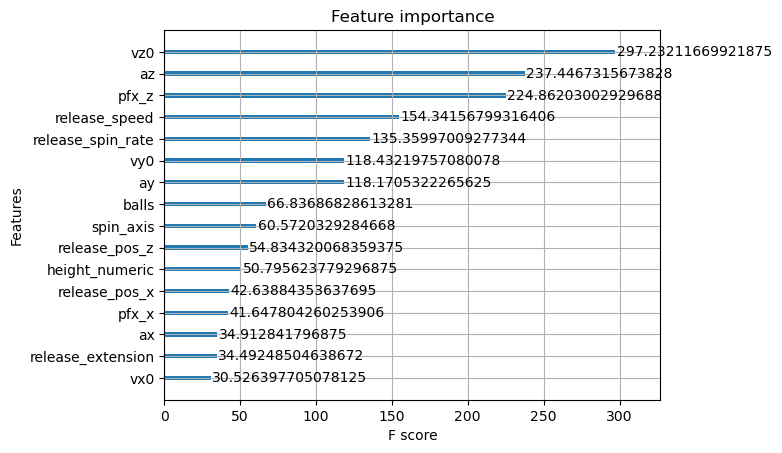

In [33]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

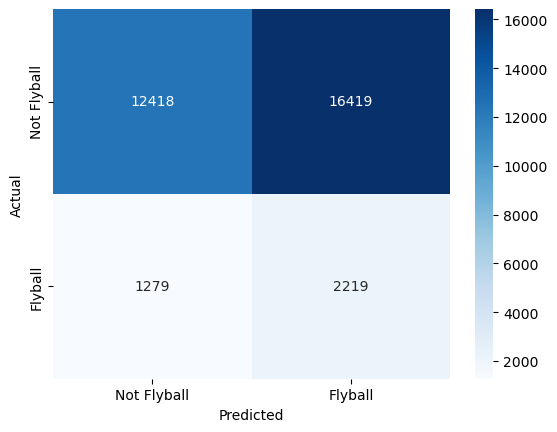

In [34]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [35]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [36]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [37]:
y_pred = final_model.predict(predictions)

In [38]:
testing_identifiers['xld'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_7208\3915381827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xld'] = y_pred


In [39]:
testing_identifiers.head()

pitch_id_raw       xld
0  663364_455139_617228_4_75_10  0.497431
1  663364_455139_617228_3_75_10  0.496556
2  663364_455139_617228_2_75_10  0.502446
3  663364_455139_617228_1_75_10  0.502646
5  663364_593428_605347_4_72_10  0.495547

In [40]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/ld_2022&3_xld.csv")